# BFuzzer

Some magick before we get started.
* %top and %%top are magicks for line and cell respectively that can be used to disable the evaluation when the notebook is exported.
* %%var is used to extract contents of the cell to `$VARS` variable.

In [1]:
TOP = True

In [2]:
from IPython.core.magic import  (Magics, magics_class, cell_magic, line_magic, line_cell_magic)
class B(dict):
    def __getattr__(self, name):
        return self.__getitem__(name)
@magics_class
class MyMagics(Magics):
    def __init__(self, shell=None,  **kwargs):
        super().__init__(shell=shell, **kwargs)
        self._vars = B()
        shell.user_ns['VARS'] = self._vars

    @cell_magic
    def var(self, line, cell):
        self._vars[line.strip()] = cell.strip()
 
    @line_cell_magic
    def top(self, line, cell=None):
        if TOP:
            if cell is None:
                cell = line
            ip = get_ipython()
            res = ip.run_cell(cell)

get_ipython().register_magics(MyMagics)

This notebook has only been tested in the specific Python versions below.

In [3]:
import sys

In [4]:
%top assert sys.version_info[0:2] in [(3, 6)]

Jupyter has the bad habit of continuing the execution sometimes after an exception has happened. This variable tells us if any exception has happened until now.

In [5]:
EXCEPTION_HAPPENED = []

In [6]:
%top IP = get_ipython()

In [7]:
from IPython.core.ultratb import AutoFormattedTB
itb = AutoFormattedTB(mode = 'Plain', tb_offset = 1)
def custom_exc(shell, etype, evalue, tb, tb_offset=None):
    global EXCEPTION_HAPPENED
    EXCEPTION_HAPPENED.append(IP.last_execution_result.execution_count + 1)
    shell.showtraceback((etype, evalue, tb), tb_offset=tb_offset)

In [8]:
%top IP.set_custom_exc((Exception,), custom_exc)

## Do

Next, we define a wrapper for command execution.

In [9]:
import subprocess
import os
import json

The `do()` command executes and saves return code, stdin and stderr.

In [10]:
class O:
    def __init__(self, **keys): self.__dict__.update(keys)
    def __repr__(self): return str(self.__dict__)

In [11]:
def do(command, env=None, shell=False, log=False, **args):
    result = subprocess.Popen(command, stdout=subprocess.PIPE, stderr = subprocess.PIPE,
                              shell=shell,
                              env=dict(os.environ, **({} if env is None else env))
                             )
    stdout, stderr = result.communicate(timeout=10)
    os.makedirs('build', exist_ok=True)
    code = result.returncode
    ecode = ((256-code) * -1) if code > 127 else code
    if log:
        with open('build/do.log', 'a+') as f:
            print(json.dumps({'cmd':command, 'env':env, 'exitcode':ecode, 'ocode':code}), env, file=f)
    return O(cmd=command,returncode=ecode, ocode=result.returncode, stdout=stdout, stderr=stderr)

In [12]:
do(['/usr/bin/false'])

{'cmd': ['/usr/bin/false'], 'returncode': 1, 'ocode': 1, 'stdout': b'', 'stderr': b''}

## Examples

### TinyC

#### C

In [13]:
%%var tinyc_src
/* file: "tinyc.c" */

/* Copyright (C) 2001 by Marc Feeley, All Rights Reserved. */

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
FILE* v = 0;
/*
 * This is a compiler for the Tiny-C language.  Tiny-C is a
 * considerably stripped down version of C and it is meant as a
 * pedagogical tool for learning about compilers.  The integer global
 * variables "a" to "z" are predefined and initialized to zero, and it
 * is not possible to declare new variables.  The compiler reads the
 * program from standard input and prints out the value of the
 * variables that are not zero.  The grammar of Tiny-C in EBNF is:
 *
 *  <program> ::= <statement>
 *  <statement> ::= "if" <paren_expr> <statement> |
 *                  "if" <paren_expr> <statement> "else" <statement> |
 *                  "while" <paren_expr> <statement> |
 *                  "do" <statement> "while" <paren_expr> ";" |
 *                  "{" { <statement> } "}" |
 *                  <expr> ";" |
 *                  ";"
 *  <paren_expr> ::= "(" <expr> ")"
 *  <expr> ::= <test> | <id> "=" <expr>
 *  <test> ::= <sum> | <sum> "<" <sum>
 *  <sum> ::= <term> | <sum> "+" <term> | <sum> "-" <term>
 *  <term> ::= <id> | <int> | <paren_expr>
 *  <id> ::= "a" | "b" | "c" | "d" | ... | "z"
 *  <int> ::= <an_unsigned_decimal_integer>
 *
 * Here are a few invocations of the compiler:
 *
 * % echo "a=b=c=2<3;" | ./a.out
 * a = 1
 * b = 1
 * c = 1
 * % echo "{ i=1; while (i<100) i=i+i; }" | ./a.out
 * i = 128
 * % echo "{ i=125; j=100; while (i-j) if (i<j) j=j-i; else i=i-j; }" | ./a.out
 * i = 25
 * j = 25
 * % echo "{ i=1; do i=i+10; while (i<50); }" | ./a.out
 * i = 51
 * % echo "{ i=1; while ((i=i+10)<50) ; }" | ./a.out
 * i = 51
 * % echo "{ i=7; if (i<5) x=1; if (i<10) y=2; }" | ./a.out
 * i = 7
 * y = 2
 *
 * The compiler does a minimal amount of error checking to help
 * highlight the structure of the compiler.
 */


/*---------------------------------------------------------------------------*/

/* Lexer. */

enum { DO_SYM, ELSE_SYM, IF_SYM, WHILE_SYM, LBRA, RBRA, LPAR, RPAR,
       PLUS, MINUS, LESS, SEMI, EQUAL, INT, ID, EOI };

char *words[] = { "do", "else", "if", "while", NULL };

int ch = ' ';
int sym;
int int_val;
char id_name[100];

void syntax_error() { fprintf(stderr, "syntax error\n"); exit(1); }
void eof_error() { fprintf(stderr, "EOF error\n"); exit(-1); }
void next_ch() { ch = getc(v); }

void next_sym()
{ again: switch (ch)
    { case ' ': case '\n': next_ch(); goto again;
      case EOF: sym = EOI; break;
      case '{': next_ch(); sym = LBRA; break;
      case '}': next_ch(); sym = RBRA; break;
      case '(': next_ch(); sym = LPAR; break;
      case ')': next_ch(); sym = RPAR; break;
      case '+': next_ch(); sym = PLUS; break;
      case '-': next_ch(); sym = MINUS; break;
      case '<': next_ch(); sym = LESS; break;
      case ';': next_ch(); sym = SEMI; break;
      case '=': next_ch(); sym = EQUAL; break;
      default:
        if (ch >= '0' && ch <= '9')
          { int_val = 0; /* missing overflow check */
            while (ch >= '0' && ch <= '9')
              { int_val = int_val*10 + (ch - '0'); next_ch(); }
            sym = INT;
          }
        else if (ch >= 'a' && ch <= 'z')
          { int i = 0; /* missing overflow check */
            while ((ch >= 'a' && ch <= 'z') || ch == '_')
              { id_name[i++] = ch; next_ch(); }
            id_name[i] = '\0';
            sym = 0;
            while (words[sym] != NULL && strcmp(words[sym], id_name) != 0)
              sym++;
            if (words[sym] == NULL) {
              if (id_name[1] == '\0') {sym = ID;} else {syntax_error();}
            }
          }
        else
          syntax_error();
    }
}

/*---------------------------------------------------------------------------*/

/* Parser. */

enum { VAR, CST, ADD, SUB, LT, SET,
       IF1, IF2, WHILE, DO, EMPTY, SEQ, EXPR, PROG };

struct node { int kind; struct node *o1, *o2, *o3; int val; };
typedef struct node node;

node *new_node(int k)
{ node *x = (node*)malloc(sizeof(node)); x->kind = k; return x; }

node *paren_expr(); /* forward declaration */

node *term()  /* <term> ::= <id> | <int> | <paren_expr> */
{ node *x;
  if (sym == ID) { x=new_node(VAR); x->val=id_name[0]-'a'; next_sym(); }
  else if (sym == INT) { x=new_node(CST); x->val=int_val; next_sym(); }
  else x = paren_expr();
  return x;
}

node *sum()  /* <sum> ::= <term> | <sum> "+" <term> | <sum> "-" <term> */
{ node *t, *x = term();
  while (sym == PLUS || sym == MINUS)
    { t=x; x=new_node(sym==PLUS?ADD:SUB); next_sym(); x->o1=t; x->o2=term(); }
  return x;
}

node *test()  /* <test> ::= <sum> | <sum> "<" <sum> */
{ node *t, *x = sum();
  if (sym == LESS)
    { t=x; x=new_node(LT); next_sym(); x->o1=t; x->o2=sum(); }
  return x;
}

node *expr()  /* <expr> ::= <test> | <id> "=" <expr> */
{ node *t, *x;
  if (sym != ID) return test();
  x = test();
  if (x->kind == VAR && sym == EQUAL)
    { t=x; x=new_node(SET); next_sym(); x->o1=t; x->o2=expr(); }
  return x;
}

node *paren_expr()  /* <paren_expr> ::= "(" <expr> ")" */
{ node *x;
  if (sym == LPAR) next_sym(); else if (sym == EOI) eof_error(); else syntax_error();
  x = expr();
  if (sym == RPAR) next_sym(); else if (sym == EOI) eof_error(); else syntax_error();
  return x;
}

node *statement()
{ node *t, *x;
  if (sym == IF_SYM)  /* "if" <paren_expr> <statement> */
    { x = new_node(IF1);
      next_sym();
      x->o1 = paren_expr();
      x->o2 = statement();
      if (sym == ELSE_SYM)  /* ... "else" <statement> */
        { x->kind = IF2;
          next_sym();
          x->o3 = statement();
        }
    }
  else if (sym == WHILE_SYM)  /* "while" <paren_expr> <statement> */
    { x = new_node(WHILE);
      next_sym();
      x->o1 = paren_expr();
      x->o2 = statement();
    }
  else if (sym == DO_SYM)  /* "do" <statement> "while" <paren_expr> ";" */
    { x = new_node(DO);
      next_sym();
      x->o1 = statement();
      if (sym == WHILE_SYM) next_sym(); else if (sym == EOI) eof_error(); else syntax_error();
      x->o2 = paren_expr();
      if (sym == SEMI) next_sym(); else if (sym == EOI) eof_error(); else syntax_error();
    }
  else if (sym == SEMI)  /* ";" */
    { x = new_node(EMPTY); next_sym(); }
  else if (sym == LBRA)  /* "{" { <statement> } "}" */
    { x = new_node(EMPTY);
      next_sym();
      while (sym != RBRA)
        { t=x; x=new_node(SEQ); x->o1=t; x->o2=statement(); }
      next_sym();
    }
  else  /* <expr> ";" */
    { x = new_node(EXPR);
      x->o1 = expr();
      if (sym == SEMI) next_sym(); else if (sym == EOI) eof_error(); else syntax_error();
    }
  return x;
}

node *program()  /* <program> ::= <statement> */
{ node *x = new_node(PROG);
  next_sym(); x->o1 = statement(); if (sym != EOI) syntax_error();
  return x;
}

/*---------------------------------------------------------------------------*/

/* Code generator. */

enum { IFETCH, ISTORE, IPUSH, IPOP, IADD, ISUB, ILT, JZ, JNZ, JMP, HALT };

typedef char code;
code object[1000], *here = object;

void g(code c) { *here++ = c; } /* missing overflow check */
code *hole() { return here++; }
void fix(code *src, code *dst) { *src = dst-src; } /* missing overflow check */

void c(node *x)
{ code *p1, *p2;
  switch (x->kind)
    { case VAR  : g(IFETCH); g(x->val); break;
      case CST  : g(IPUSH); g(x->val); break;
      case ADD  : c(x->o1); c(x->o2); g(IADD); break;
      case SUB  : c(x->o1); c(x->o2); g(ISUB); break;
      case LT   : c(x->o1); c(x->o2); g(ILT); break;
      case SET  : c(x->o2); g(ISTORE); g(x->o1->val); break;
      case IF1  : c(x->o1); g(JZ); p1=hole(); c(x->o2); fix(p1,here); break;
      case IF2  : c(x->o1); g(JZ); p1=hole(); c(x->o2); g(JMP); p2=hole();
                  fix(p1,here); c(x->o3); fix(p2,here); break;
      case WHILE: p1=here; c(x->o1); g(JZ); p2=hole(); c(x->o2);
                  g(JMP); fix(hole(),p1); fix(p2,here); break;
      case DO   : p1=here; c(x->o1); c(x->o2); g(JNZ); fix(hole(),p1); break;
      case EMPTY: break;
      case SEQ  : c(x->o1); c(x->o2); break;
      case EXPR : c(x->o1); g(IPOP); break;
      case PROG : c(x->o1); g(HALT); break;
    }
}

/*---------------------------------------------------------------------------*/

/* Virtual machine. */

int globals[26];

void run()
{ int stack[1000], *sp = stack;
  code *pc = object;
  again: switch (*pc++)
    { case IFETCH: *sp++ = globals[*pc++];               goto again;
      case ISTORE: globals[*pc++] = sp[-1];              goto again;
      case IPUSH : *sp++ = *pc++;                        goto again;
      case IPOP  : --sp;                                 goto again;
      case IADD  : sp[-2] = sp[-2] + sp[-1]; --sp;       goto again;
      case ISUB  : sp[-2] = sp[-2] - sp[-1]; --sp;       goto again;
      case ILT   : sp[-2] = sp[-2] < sp[-1]; --sp;       goto again;
      case JMP   : pc += *pc;                            goto again;
      case JZ    : if (*--sp == 0) pc += *pc; else pc++; goto again;
      case JNZ   : if (*--sp != 0) pc += *pc; else pc++; goto again;
    }
}

/*---------------------------------------------------------------------------*/

/* Main program. */

int main(int argc, char** argv)
{ int i;
  /*char buffer[1024];
  fgets(buffer, 1024, stdin);*/
  v = fopen(argv[1], "r");
  c(program());

  for (i=0; i<26; i++)
    globals[i] = 0;
  run();
  for (i=0; i<26; i++)
    if (globals[i] != 0)
      printf("%c = %d\n", 'a'+i, globals[i]);

  fclose(v);
  return 0;
}

#### Compile

In [14]:
!rm -rf ./build/tinyc
!mkdir -p ./build/tinyc

In [15]:
with open("./build/tinyc/tinyc.c", 'wb+') as f:
    f.write(VARS['tinyc_src'].encode('utf-8'))

In [16]:
!(cd build/tinyc; gcc -g -o tinyc tinyc.c)

In [17]:
!(cd build/tinyc; gcc -fprofile-arcs -ftest-coverage -g -o tinyc.cov tinyc.c)

In [18]:
with open('./build/tinyc/input.tinyc', 'wb+') as f:
    f.write(b'1')

In [19]:
ret = do(['./build/tinyc/tinyc', './build/tinyc/input.tinyc'])

In [20]:
ret

{'cmd': ['./build/tinyc/tinyc', './build/tinyc/input.tinyc'], 'returncode': -1, 'ocode': 255, 'stdout': b'', 'stderr': b'EOF error\n'}

In [21]:
assert ret.returncode == -1

#### Extract Status

In [22]:
import enum

In [23]:
class Status(enum.Enum):
    Complete = 0
    Incomplete = 1
    Incorrect = -1

In [24]:
import tempfile

In [25]:
import os
from contextlib import contextmanager

In [26]:
@contextmanager
def chdir(directory):
    owd = os.getcwd()
    try:
        os.chdir(directory)
        yield directory
    finally:
        os.chdir(owd)

In [27]:
class Validate:
    def validate(self, input_str):
        with tempfile.NamedTemporaryFile() as f:
            f.write(input_str)
            f.flush()
            res = self._exec(self.exe, f.name)
            if res.returncode == 1:
                return Status.Incorrect, None
            elif res.returncode == -1:
                return Status.Incomplete, None
            else:
                return Status.Complete, None
            
    def _cov(self, res):
        s = res.stdout.decode().split('\n')
        l = s[1].replace('Lines executed:', '').split(' ')[0][:-1]
        b = s[2].replace('Branches executed:', '').split(' ')[0][:-1]
        return (l, b)
    
    def _exec(self, exe, fname):
        return do([exe, fname])
            
    def get_cumulative_coverage(self, input_str):
        self.cov_exe = '%s.cov' % self.exe
        self.src_dir, src_ = os.path.split(self.exe)
        self.cov_src = '%s.c' % src_
        with tempfile.NamedTemporaryFile() as f:
            f.write(input_str)
            f.flush()
            res1 = self._exec(self.cov_exe, f.name)
            with chdir(self.src_dir):
                res2 = do(['gcov', '-n', '-b', self.cov_src])
                cov_result = self._cov(res2)
                return cov_result

In [28]:
class TinycValidate(Validate):
    def __init__(self, exe):
        self.exe = exe

In [29]:
tinycvalidator = TinycValidate('./build/tinyc/tinyc')

In [30]:
tinycvalidator.validate(b'1')

(<Status.Incomplete: 1>, None)

#### Generation

In [31]:
class NeedMoreException(Exception): ...
class InvalidValueException(Exception): ...
class InputLimitException(Exception): ...
class IterationLimitException(Exception): ...
class BacktrackLimitException(Exception): ...

In [32]:
def logit(v):
    print(v, file=sys.stderr)

In [33]:
import random

In [34]:
random.seed(0)

In [35]:
import sys
import itertools
import random

In [36]:
ITERATION_LIMIT=10000
INPUT_LIMIT=1000

In [37]:
SET_OF_BYTES = [bytes([i]) for i in range(256)]
SEEN_AT = []

In [38]:
def new_byte(choices):
    v = random.choice(choices)
    return v

In [39]:
def generate(validator, prev_bytes=None):
    global SEEN_AT
    all_choices = SET_OF_BYTES
    if prev_bytes is None: prev_bytes = b''
    seen = set()
    iter_limit = ITERATION_LIMIT
    while iter_limit:
        if len(prev_bytes) > INPUT_LIMIT:
            raise InputLimitException('Exhausted %d bytes' % INPUT_LIMIT)
        iter_limit -= 1
        choices = [i for i in all_choices if i not in seen]
        if not choices:
            raise BacktrackLimitException('Backtrack disabled.')
            seen, prev_bytes, choices = backtrack(prev_bytes, all_choices)

        byte = new_byte(choices)
        cur_bytes = prev_bytes + byte
        l_cur_bytes = len(cur_bytes)

        logit('%s %s' % (cur_bytes, len(cur_bytes)))

        rv, n = validator.validate(cur_bytes)
        if rv == Status.Complete:
            return cur_bytes
        elif rv == Status.Incomplete:
            seen.add(byte)  # dont explore this byte again
            prev_bytes = cur_bytes
            SEEN_AT.append(seen)
            seen = set()

            # reset this if it was modified by incorrect
            all_choices = SET_OF_BYTES
        elif rv == Status.Incorrect:
            if n is None or n == -1:
                seen.add(byte)
                continue
            else:
                raise BacktrackLimitException('Backtrack disabled..')
                logit("%s %s" % (len(choices), len(seen)))
                if n < len(SEEN_AT):
                    seen = SEEN_AT[n]
                    SEEN_AT = SEEN_AT[:n]
                seen.add(byte)
                rs = len(cur_bytes) - n
                all_choices = till_n_length_choices(SET_OF_BYTES, min(rs, 2))
                prev_bytes = prev_bytes[:n]
        else:
            raise Exception(rv)
    raise IterationLimitException('Exhausted %d loops' % ITERATION_LIMIT)

In [40]:
def till_n_length_choices(my_choices, rs):
    all_choices = []
    for r in range(1, rs+1):
        v = [bytes(i) for i in itertools.product(my_choices, repeat=r)]
        random.shuffle(v)
        all_choices.extend(v)
    return all_choices

In [41]:
def backtrack(prev_bytes, all_choices):
    global SEEN_AT
    if not prev_bytes:
        raise BacktrackLimitException('Cant backtrack beyond zero index')
    # backtrack one byte
    seen = SEEN_AT[len(prev_bytes)-1]
    SEEN_AT = SEEN_AT[:-1]
    last_byte = prev_bytes[-1]
    logit('backtracking %d %s' % (len(prev_bytes), last_byte))
    #assert (last_byte,) in seen
    prev_bytes = prev_bytes[:-1]
    choices = [i for i in all_choices if i not in seen]
    if not choices:
        return backtrack(prev_bytes, all_choices)
    return seen, prev_bytes, choices

In [42]:
generate(tinycvalidator, b'')

b'\xc5' 1
b'\xc2' 1
b'\xe5' 1
b'k' 1
b'k\x14' 2
b'kC' 2
b'k\xf9' 2
b'k\x84' 2
b'k~' 2
b'ki' 2
b'k\xf0' 2
b'k\xcd' 2
b'k\xda' 2
b'kO' 2
b'k\x7f' 2
b'k^' 2
b'k\x9d' 2
b'k\xef' 2
b'k\xf5' 2
b'k8' 2
b'k\x8a' 2
b'k$' 2
b'kL' 2
b'k%' 2
b'k\xd0' 2
b'k\x19' 2
b'k\xad' 2
b'k\xdf' 2
b'kF' 2
b'k\x97' 2
b'k\xc6' 2
b'k\xe6' 2
b'k\xab' 2
b'k)' 2
b'kY' 2
b'k\x1b' 2
b'k\xd3' 2
b'k\x12' 2
b'k\xfb' 2
b'k\xc7' 2
b'kb' 2
b'k\x8c' 2
b'k\xa6' 2
b'k\x1d' 2
b'kk' 2
b'k\x83' 2
b'k_' 2
b'k\xba' 2
b'k\xc2' 2
b'k=' 2
b'k=\xf4' 3
b'k=q' 3
b'k=q\x85' 4
b'k=q\x0f' 4
b'k=q\xd0' 4
b'k=q\xee' 4
b'k=q\x8e' 4
b'k=q\xef' 4
b'k=q\x03' 4
b'k=q\x19' 4
b'k=q\xbd' 4
b'k=q\xde' 4
b'k=qi' 4
b'k=q\xbb' 4
b'k=q\xdc' 4
b'k=q\xd1' 4
b'k=q\xb1' 4
b'k=q\xa6' 4
b'k=q\x00' 4
b'k=q\xa3' 4
b'k=q\x83' 4
b'k=q\xe4' 4
b'k=q\xf2' 4
b'k=qY' 4
b'k=qB' 4
b'k=q\xc9' 4
b'k=qX' 4
b'k=q\xc4' 4
b'k=q\xf8' 4
b'k=q\x13' 4
b'k=q5' 4
b'k=q\x9e' 4
b'k=q>' 4
b'k=qE' 4
b'k=q\xe9' 4
b'k=q)' 4
b'k=q\xeb' 4
b'k=q\x9b' 4
b'k=q\x7f' 4
b'k=q\x1c' 4
b'k=q\x18' 4
b

b'k=q;'

In [43]:
FNAME = 'file.x'

In [44]:
def create_valid_inputs(validator, n=1):
    i = 0
    parray = b''
    while True:
        created_bits = generate(validator, parray)
        logit(repr(created_bits))
        with open(FNAME, 'wb+') as f:
            f.write(created_bits)
        i += 1
        if len(created_bits) < 3 and random.randint(0,10) > 1:
            parray = created_bits
            continue
        if (i >= n): break

In [45]:
create_valid_inputs(tinycvalidator)

b'`' 1
b'\xd3' 1
b'/' 1
b'\x08' 1
b'\x9f' 1
b'\xac' 1
b'D' 1
b'}' 1
b'\x12' 1
b'\x18' 1
b'\xb6' 1
b'\xcb' 1
b'$' 1
b'\xed' 1
b'*' 1
b'\xfb' 1
b'\n' 1
b'\n)' 2
b'\n\xe6' 2
b'\n\xb4' 2
b'\n\xef' 2
b'\n\xd6' 2
b'\n\x8b' 2
b'\n\xb0' 2
b'\ne' 2
b'\ne\x8d' 3
b'\ne\x85' 3
b'\ne\xd1' 3
b'\ne<' 3
b'\ne<n' 4
b'\ne<n\xd6' 5
b'\ne<n\x94' 5
b'\ne<nF' 5
b'\ne<nt' 5
b'\ne<n\x80' 5
b'\ne<n\xad' 5
b'\ne<n\xa8' 5
b'\ne<n\xb9' 5
b'\ne<n\xf2' 5
b'\ne<n\xd2' 5
b'\ne<n\\' 5
b'\ne<n\x15' 5
b'\ne<nU' 5
b'\ne<n\xa3' 5
b'\ne<n\x1e' 5
b'\ne<n\x83' 5
b'\ne<n\x9f' 5
b'\ne<n\xae' 5
b'\ne<nY' 5
b'\ne<n\xea' 5
b'\ne<n2' 5
b'\ne<nA' 5
b'\ne<n\x04' 5
b'\ne<n\xce' 5
b'\ne<nK' 5
b'\ne<n ' 5
b'\ne<n p' 6
b'\ne<n _' 6
b'\ne<n \xcd' 6
b'\ne<n +' 6
b'\ne<n +\xaa' 7
b'\ne<n +m' 7
b'\ne<n +m\x1f' 8
b'\ne<n +m\x19' 8
b'\ne<n +m\xca' 8
b"\ne<n +m'" 8
b'\ne<n +m\xde' 8
b'\ne<n +m\xb5' 8
b'\ne<n +m;' 8
b'\ne<n +m;'


In [46]:
!cat {FNAME}


e<n +m;

In [47]:
!./build/tinyc/tinyc.cov {FNAME}

In [48]:
!(cd build/tinyc; gcov -n -b tinyc.c)

File 'tinyc.c'
Lines executed:54.78% of 157
Branches executed:73.23% of 127
Taken at least once:40.16% of 127
No calls



In [49]:
v = tinycvalidator.get_cumulative_coverage(b'e<n +m;'); v

('54.78', '73.23')

In [50]:
EXCEPTION_HAPPENED

[]

### Ini

#### H

In [51]:
%%var inih_src
/* inih -- simple .INI file parser

inih is released under the New BSD license (see LICENSE.txt). Go to the project
home page for more info:

https://github.com/benhoyt/inih

*/

#ifndef __INI_H__
#define __INI_H__

/* Make this header file easier to include in C++ code */
#ifdef __cplusplus
extern "C" {
#endif

#include <stdio.h>

/* Nonzero if ini_handler callback should accept lineno parameter. */
#ifndef INI_HANDLER_LINENO
#define INI_HANDLER_LINENO 0
#endif

/* Typedef for prototype of handler function. */
#if INI_HANDLER_LINENO
typedef int (*ini_handler)(void* user, const char* section,
                           const char* name, const char* value,
                           int lineno);
#else
typedef int (*ini_handler)(void* user, const char* section,
                           const char* name, const char* value);
#endif

/* Typedef for prototype of fgets-style reader function. */
typedef char* (*ini_reader)(char* str, int num, void* stream);

/* Parse given INI-style file. May have [section]s, name=value pairs
   (whitespace stripped), and comments starting with ';' (semicolon). Section
   is "" if name=value pair parsed before any section heading. name:value
   pairs are also supported as a concession to Python's configparser.

   For each name=value pair parsed, call handler function with given user
   pointer as well as section, name, and value (data only valid for duration
   of handler call). Handler should return nonzero on success, zero on error.

   Returns 0 on success, line number of first error on parse error (doesn't
   stop on first error), -1 on file open error, or -2 on memory allocation
   error (only when INI_USE_STACK is zero).
*/
int ini_parse(const char* filename, ini_handler handler, void* user);

/* Same as ini_parse(), but takes a FILE* instead of filename. This doesn't
   close the file when it's finished -- the caller must do that. */
int ini_parse_file(FILE* file, ini_handler handler, void* user);

/* Same as ini_parse(), but takes an ini_reader function pointer instead of
   filename. Used for implementing custom or string-based I/O (see also
   ini_parse_string). */
int ini_parse_stream(ini_reader reader, void* stream, ini_handler handler,
                     void* user);

/* Same as ini_parse(), but takes a zero-terminated string with the INI data
instead of a file. Useful for parsing INI data from a network socket or
already in memory. */
int ini_parse_string(const char* string, ini_handler handler, void* user);

/* Nonzero to allow multi-line value parsing, in the style of Python's
   configparser. If allowed, ini_parse() will call the handler with the same
   name for each subsequent line parsed. */
#ifndef INI_ALLOW_MULTILINE
#define INI_ALLOW_MULTILINE 1
#endif

/* Nonzero to allow a UTF-8 BOM sequence (0xEF 0xBB 0xBF) at the start of
   the file. See https://github.com/benhoyt/inih/issues/21 */
#ifndef INI_ALLOW_BOM
#define INI_ALLOW_BOM 1
#endif

/* Chars that begin a start-of-line comment. Per Python configparser, allow
   both ; and # comments at the start of a line by default. */
#ifndef INI_START_COMMENT_PREFIXES
#define INI_START_COMMENT_PREFIXES ";#"
#endif

/* Nonzero to allow inline comments (with valid inline comment characters
   specified by INI_INLINE_COMMENT_PREFIXES). Set to 0 to turn off and match
   Python 3.2+ configparser behaviour. */
#ifndef INI_ALLOW_INLINE_COMMENTS
#define INI_ALLOW_INLINE_COMMENTS 1
#endif
#ifndef INI_INLINE_COMMENT_PREFIXES
#define INI_INLINE_COMMENT_PREFIXES ";"
#endif

/* Nonzero to use stack for line buffer, zero to use heap (malloc/free). */
#ifndef INI_USE_STACK
#define INI_USE_STACK 1
#endif

/* Maximum line length for any line in INI file (stack or heap). Note that
   this must be 3 more than the longest line (due to '\r', '\n', and '\0'). */
#ifndef INI_MAX_LINE
#define INI_MAX_LINE 200
#endif

/* Nonzero to allow heap line buffer to grow via realloc(), zero for a
   fixed-size buffer of INI_MAX_LINE bytes. Only applies if INI_USE_STACK is
   zero. */
#ifndef INI_ALLOW_REALLOC
#define INI_ALLOW_REALLOC 0
#endif

/* Initial size in bytes for heap line buffer. Only applies if INI_USE_STACK
   is zero. */
#ifndef INI_INITIAL_ALLOC
#define INI_INITIAL_ALLOC 200
#endif

/* Stop parsing on first error (default is to keep parsing). */
#ifndef INI_STOP_ON_FIRST_ERROR
#define INI_STOP_ON_FIRST_ERROR 1
#endif

#ifdef __cplusplus
}
#endif

#endif /* __INI_H__ */

#### C

In [52]:
%%var inic_src
/* inih -- simple .INI file parser

inih is released under the New BSD license (see LICENSE.txt). Go to the project
home page for more info:

https://github.com/benhoyt/inih

*/

/* 0  - Valid
 * -1 - incomplete
 *  1 - incorrect
 * */

#if defined(_MSC_VER) && !defined(_CRT_SECURE_NO_WARNINGS)
#define _CRT_SECURE_NO_WARNINGS
#endif

#include <stdio.h>
#include <ctype.h>
#include <string.h>
#include <stdlib.h>

#include "ini.h"

#if !INI_USE_STACK
#include <stdlib.h>
#endif

#define MAX_SECTION 50
#define MAX_NAME 50

/* Used by ini_parse_string() to keep track of string parsing state. */
typedef struct {
    const char* ptr;
    size_t num_left;
} ini_parse_string_ctx;

/* Strip whitespace chars off end of given string, in place. Return s. */
static char* rstrip(char* s)
{
    char* p = s + strlen(s);
    while (p > s && isspace((unsigned char)(*--p)))
        *p = '\0';
    return s;
}

/* Return pointer to first non-whitespace char in given string. */
static char* lskip(const char* s)
{
    while (*s && isspace((unsigned char)(*s)))
        s++;
    return (char*)s;
}

/* Return pointer to first char (of chars) or inline comment in given string,
   or pointer to null at end of string if neither found. Inline comment must
   be prefixed by a whitespace character to register as a comment. */
static char* find_chars_or_comment(const char* s, const char* chars)
{
#if INI_ALLOW_INLINE_COMMENTS
    int was_space = 0;
    while (*s && (!chars || !strchr(chars, *s)) &&
           !(was_space && strchr(INI_INLINE_COMMENT_PREFIXES, *s))) {
        was_space = isspace((unsigned char)(*s));
        s++;
    }
#else
    while (*s && (!chars || !strchr(chars, *s))) {
        s++;
    }
#endif
    return (char*)s;
}

/* Version of strncpy that ensures dest (size bytes) is null-terminated. */
static char* strncpy0(char* dest, const char* src, size_t size)
{
    strncpy(dest, src, size - 1);
    dest[size - 1] = '\0';
    return dest;
}

/* See documentation in header file. */
int ini_parse_stream(ini_reader reader, void* stream, ini_handler handler,
                     void* user)
{
    /* Uses a fair bit of stack (use heap instead if you need to) */
#if INI_USE_STACK
    char line[INI_MAX_LINE];
    int max_line = INI_MAX_LINE;
#else
    char* line;
    int max_line = INI_INITIAL_ALLOC;
#endif
#if INI_ALLOW_REALLOC && !INI_USE_STACK
    char* new_line;
    int offset;
#endif
    char section[MAX_SECTION] = "";
    char prev_name[MAX_NAME] = "";

    char* start;
    char* end;
    char* name;
    char* value;
    int lineno = 0;
    int error = 0;

#if !INI_USE_STACK
    line = (char*)malloc(INI_INITIAL_ALLOC);
    if (!line) {
        return -2;
    }
#endif

#if INI_HANDLER_LINENO
#define HANDLER(u, s, n, v) handler(u, s, n, v, lineno)
#else
#define HANDLER(u, s, n, v) handler(u, s, n, v)
#endif

    /* Scan through stream line by line */
    while (reader(line, max_line, stream) != NULL) {
#if INI_ALLOW_REALLOC && !INI_USE_STACK
        offset = strlen(line);
        while (offset == max_line - 1 && line[offset - 1] != '\n') {
            max_line *= 2;
            if (max_line > INI_MAX_LINE)
                max_line = INI_MAX_LINE;
            new_line = realloc(line, max_line);
            if (!new_line) {
                free(line);
                return -2;
            }
            line = new_line;
            if (reader(line + offset, max_line - offset, stream) == NULL)
                break;
            if (max_line >= INI_MAX_LINE)
                break;
            offset += strlen(line + offset);
        }
#endif

        lineno++;

        start = line;
#if INI_ALLOW_BOM
        if (lineno == 1 && (unsigned char)start[0] == 0xEF &&
                           (unsigned char)start[1] == 0xBB &&
                           (unsigned char)start[2] == 0xBF) {
            start += 3;
        }
#endif
        start = lskip(rstrip(start));

        if (strchr(INI_START_COMMENT_PREFIXES, *start)) {
            /* Start-of-line comment */
        }
#if INI_ALLOW_MULTILINE
        else if (*prev_name && *start && start > line) {
            /* Non-blank line with leading whitespace, treat as continuation
               of previous name's value (as per Python configparser). */
            if (!HANDLER(user, section, prev_name, start) && !error)
                error = lineno;
                // Valid line:
                printf("0");
                exit(0);
                
        }
#endif
        else if (*start == '[') {
            /* A "[section]" line */
            end = find_chars_or_comment(start + 1, "]");
            if (*end == ']') {
                *end = '\0';
                strncpy0(section, start + 1, sizeof(section));
                *prev_name = '\0';
            }
            else if (!error) {
                /* No ']' found on section line */
                error = lineno;
                // Missing cloding square bracket:
                printf("2");
                exit(-1);
                
            }
        }
        else if (*start) {
            /* Not a comment, must be a name[=:]value pair */
            end = find_chars_or_comment(start, "=:");
            if (*end == '=' || *end == ':') {
                *end = '\0';
                name = rstrip(start);
                value = end + 1;
#if INI_ALLOW_INLINE_COMMENTS
                end = find_chars_or_comment(value, NULL);
                if (*end)
                    *end = '\0';
#endif
                value = lskip(value);
                rstrip(value);

                /* Valid name[=:]value pair found, call handler */
                strncpy0(prev_name, name, sizeof(prev_name));
                if (!HANDLER(user, section, name, value) && !error)
                    error = lineno;
                    // Valid line:
                    printf("0");
                    exit(0);                   
            }
            else if (!error) {
                /* No '=' or ':' found on name[=:]value line */
                error = lineno;
                // Invalid line:
                printf("4");
                exit(-1); // incorrect value found <- appending `:` makes it valid. So it is not invalid.
            }
        }

#if INI_STOP_ON_FIRST_ERROR
        if (error)
            break;
#endif
    }

#if !INI_USE_STACK
    free(line);
#endif
    // empty string or whitespace only:
    printf("0");
    exit(0);
    return error;
}

/* See documentation in header file. */
int ini_parse_file(FILE* file, ini_handler handler, void* user)
{
    return ini_parse_stream((ini_reader)fgets, file, handler, user);
}

/* See documentation in header file. */
int ini_parse(const char* filename, ini_handler handler, void* user)
{
    FILE* file;
    int error;

    file = fopen(filename, "r");
    if (!file)
        return -1;
    error = ini_parse_file(file, handler, user);
    fclose(file);
    return error;
}

/* An ini_reader function to read the next line from a string buffer. This
   is the fgets() equivalent used by ini_parse_string(). */
static char* ini_reader_string(char* str, int num, void* stream) {
    ini_parse_string_ctx* ctx = (ini_parse_string_ctx*)stream;
    const char* ctx_ptr = ctx->ptr;
    size_t ctx_num_left = ctx->num_left;
    char* strp = str;
    char c;

    if (ctx_num_left == 0 || num < 2)
        return NULL;

    while (num > 1 && ctx_num_left != 0) {
        c = *ctx_ptr++;
        ctx_num_left--;
        *strp++ = c;
        if (c == '\n')
            break;
        num--;
    }

    *strp = '\0';
    ctx->ptr = ctx_ptr;
    ctx->num_left = ctx_num_left;
    return str;
}

/* See documentation in header file. */
int ini_parse_string(const char* string, ini_handler handler, void* user) {
    ini_parse_string_ctx ctx;

    ctx.ptr = string;
    ctx.num_left = strlen(string);
    return ini_parse_stream((ini_reader)ini_reader_string, &ctx, handler,
                            user);
}

// newly added for running the code
typedef struct
{
    int empty;
} configuration;

// took the example from the README file to have sth. to parse
static int handler(void* user, const char* section, const char* name,
                   const char* value)
{
    return 1;
}

FILE* v = 0;
char* read_input() {
    int counter = 0;
    char* chars = malloc(sizeof(char) * 1000);
    char c = 0;
    while((c = fgetc(v)) != EOF){
        if (counter == 1000) {
            exit(-1);
        }
        chars[counter++] = c;
    }
    chars[counter] = '\0';
    return chars;
}

int main(int argc, char** argv) {
    configuration config;
    v = fopen(argv[1], "r");
    char* string = read_input();
    fclose(v);
    //printf(string);
    //int num = 999;
    //num = ini_parse_string(string, handler, &config);

    //char* str;
    //asprintf (&str, "%i", num);
    //printf(str);
    //printf("\n");
    //free(str);
    
    
    return ini_parse_string(string, handler, &config);

}

#### Compile

In [53]:
!rm -rf ./build/ini
!mkdir -p ./build/ini

In [54]:
with open("./build/ini/ini.c", 'wb+') as f:
    f.write(VARS['inic_src'].encode('utf-8'))

In [55]:
with open("./build/ini/ini.h", 'wb+') as f:
    f.write(VARS['inih_src'].encode('utf-8'))

In [56]:
!(cd build/ini; gcc -g -o ini ini.c)

In [57]:
!(cd build/ini; gcc -fprofile-arcs -ftest-coverage -g -o ini.cov ini.c)

In [58]:
with open('./build/ini/input.ini', 'wb+') as f:
    f.write(b'[')

In [59]:
ret = do(['./build/ini/ini', './build/ini/input.ini'])

In [60]:
ret

{'cmd': ['./build/ini/ini', './build/ini/input.ini'], 'returncode': -1, 'ocode': 255, 'stdout': b'2', 'stderr': b''}

In [61]:
assert ret.returncode == -1

#### Extract Status

In [62]:
class IniValidate(Validate):
    def __init__(self, exe):
        self.exe = exe

In [63]:
inivalidator = IniValidate('./build/ini/ini')

In [64]:
inivalidator.validate(b'[')

(<Status.Incomplete: 1>, None)

#### Generation

In [65]:
create_valid_inputs(inivalidator)

b'\x17' 1
b'\x17%' 2
b'\x17%\r' 3
b'\x17%\r?' 4
b'\x17%\r?`' 5
b'\x17%\r?`=' 6
b'\x17%\r?`='


In [66]:
!cat {FNAME}

?`=

In [67]:
!./build/ini/ini.cov {FNAME}

0

In [68]:
!(cd build/ini; gcov -n -b ini.c)

File 'ini.c'
Lines executed:64.62% of 130
Branches executed:66.67% of 78
Taken at least once:43.59% of 78
No calls



In [69]:
v = inivalidator.get_cumulative_coverage(b'#'); v

('68.46', '69.23')

In [70]:
EXCEPTION_HAPPENED

[]

### CSV

#### H

In [71]:
%%var csvh_src
#ifndef CSVPARSER_H
#define CSVPARSER_H

#include <stdio.h>

#ifdef __cplusplus
extern "C" {
#endif

typedef struct CsvRow {
    char **fields_;
    int numOfFields_;
} CsvRow;

typedef struct CsvParser {
    char *filePath_;
    char delimiter_;
    int firstLineIsHeader_;
    char *errMsg_;
    CsvRow *header_;
    FILE *fileHandler_;
	int fromString_;
	char *csvString_;
	int csvStringIter_;
} CsvParser;


// Public
CsvParser *CsvParser_new(const char *filePath, const char *delimiter, int firstLineIsHeader);
CsvParser *CsvParser_new_from_string(const char *csvString, const char *delimiter, int firstLineIsHeader);
void CsvParser_destroy(CsvParser *csvParser);
void CsvParser_destroy_row(CsvRow *csvRow);
CsvRow *CsvParser_getHeader(CsvParser *csvParser);
CsvRow *CsvParser_getRow(CsvParser *csvParser);
int CsvParser_getNumFields(CsvRow *csvRow);
char **CsvParser_getFields(CsvRow *csvRow);
const char* CsvParser_getErrorMessage(CsvParser *csvParser);

// Private
CsvRow *_CsvParser_getRow(CsvParser *csvParser);    
int _CsvParser_delimiterIsAccepted(const char *delimiter);
void _CsvParser_setErrorMessage(CsvParser *csvParser, const char *errorMessage);

#ifdef __cplusplus
}
#endif

#endif


#### C

In [72]:
%%var csvc_src
#include <stdlib.h>
#include <string.h>
#include <stdio.h>
#include <errno.h>

#include "csv.h"


/* 0  - Valid
 * -1 - incomplete
 *  1 - incorrect
 * */

#ifdef __cplusplus
extern "C" {
#endif

CsvParser *CsvParser_new(const char *filePath, const char *delimiter, int firstLineIsHeader) {
    CsvParser *csvParser = (CsvParser*)malloc(sizeof(CsvParser));
    if (filePath == NULL) {
        csvParser->filePath_ = NULL;
    } else {
        int filePathLen = strlen(filePath);
        csvParser->filePath_ = (char*)malloc((filePathLen + 1));
        strcpy(csvParser->filePath_, filePath);
    }
    csvParser->firstLineIsHeader_ = firstLineIsHeader;
    csvParser->errMsg_ = NULL;
    if (delimiter == NULL) {
        csvParser->delimiter_ = ',';
    } else if (_CsvParser_delimiterIsAccepted(delimiter)) {
        csvParser->delimiter_ = *delimiter;
    } else {
        csvParser->delimiter_ = '\0';
    }
    csvParser->header_ = NULL;
    csvParser->fileHandler_ = NULL;
	csvParser->fromString_ = 0;
	csvParser->csvString_ = NULL;
	csvParser->csvStringIter_ = 0;

    return csvParser;
}

CsvParser *CsvParser_new_from_string(const char *csvString, const char *delimiter, int firstLineIsHeader) {
	CsvParser *csvParser = CsvParser_new(NULL, delimiter, firstLineIsHeader);
	csvParser->fromString_ = 1;	
	if (csvString != NULL) {
		int csvStringLen = strlen(csvString);
		csvParser->csvString_ = (char*)malloc(csvStringLen + 1);
		strcpy(csvParser->csvString_, csvString);
	}	
	return csvParser;
}

void CsvParser_destroy(CsvParser *csvParser) {
    if (csvParser == NULL) {
        return;
    }
    if (csvParser->filePath_ != NULL) {
        free(csvParser->filePath_);
    }
    if (csvParser->errMsg_ != NULL) {
        free(csvParser->errMsg_);
    }
    if (csvParser->fileHandler_ != NULL) {
        fclose(csvParser->fileHandler_);
    }
    if (csvParser->header_ != NULL) {
        CsvParser_destroy_row(csvParser->header_);
    }
	if (csvParser->csvString_ != NULL) {
		free(csvParser->csvString_);
	}
    free(csvParser);
}

void CsvParser_destroy_row(CsvRow *csvRow) {
    int i;
    for (i = 0 ; i < csvRow->numOfFields_ ; i++) {
        free(csvRow->fields_[i]);
    }
    free(csvRow);
}

CsvRow *CsvParser_getHeader(CsvParser *csvParser) {
    if (! csvParser->firstLineIsHeader_) {
        _CsvParser_setErrorMessage(csvParser, "Cannot supply header, as current CsvParser object does not support header");
        return NULL;
    }
    if (csvParser->header_ == NULL) {
        csvParser->header_ = _CsvParser_getRow(csvParser);
    }
    return csvParser->header_;
}

CsvRow *CsvParser_getRow(CsvParser *csvParser) {
    if (csvParser->firstLineIsHeader_ && csvParser->header_ == NULL) {
        csvParser->header_ = _CsvParser_getRow(csvParser);
    }
    return _CsvParser_getRow(csvParser);
}

int CsvParser_getNumFields(CsvRow *csvRow) {
    return csvRow->numOfFields_;
}

char **CsvParser_getFields(CsvRow *csvRow) {
    return csvRow->fields_;
}

CsvRow *_CsvParser_getRow(CsvParser *csvParser) {
    int numRowRealloc = 0;
    int acceptedFields = 64;
    int acceptedCharsInField = 64;
    if (csvParser->filePath_ == NULL && (! csvParser->fromString_)) {
        _CsvParser_setErrorMessage(csvParser, "Supplied CSV file path is NULL");
        return NULL;
    }
    if (csvParser->csvString_ == NULL && csvParser->fromString_) {
        _CsvParser_setErrorMessage(csvParser, "Supplied CSV string is NULL");
        return NULL;
    }
    if (csvParser->delimiter_ == '\0') {
        _CsvParser_setErrorMessage(csvParser, "Supplied delimiter is not supported");
        return NULL;
    }
    if (! csvParser->fromString_) {
        if (csvParser->fileHandler_ == NULL) {
            csvParser->fileHandler_ = fopen(csvParser->filePath_, "r");
            if (csvParser->fileHandler_ == NULL) {
                int errorNum = errno;
                const char *errStr = strerror(errorNum);
                char *errMsg = (char*)malloc(1024 + strlen(errStr));
                strcpy(errMsg, "");
                sprintf(errMsg, "Error opening CSV file for reading: %s : %s", csvParser->filePath_, errStr);
                _CsvParser_setErrorMessage(csvParser, errMsg);
                free(errMsg);
                return NULL;
            }
        }
    }
    CsvRow *csvRow = (CsvRow*)malloc(sizeof(CsvRow));
    csvRow->fields_ = (char**)malloc(acceptedFields * sizeof(char*));
    csvRow->numOfFields_ = 0;
    int fieldIter = 0;
    char *currField = (char*)malloc(acceptedCharsInField);
    int inside_complex_field = 0;
    int currFieldCharIter = 0;
    int seriesOfQuotesLength = 0;
    int lastCharIsQuote = 0;
    int isEndOfFile = 0;
    while (1) {
        char currChar = (csvParser->fromString_) ? csvParser->csvString_[csvParser->csvStringIter_] : fgetc(csvParser->fileHandler_);
        csvParser->csvStringIter_++;
        int endOfFileIndicator;
        if (csvParser->fromString_) {
            endOfFileIndicator = (currChar == '\0');
        } else {
            endOfFileIndicator = feof(csvParser->fileHandler_);
        }
        if (endOfFileIndicator) {
            if (currFieldCharIter == 0 && fieldIter == 0) {
                exit(0);
                _CsvParser_setErrorMessage(csvParser, "Reached EOF");
                return NULL;
            }
            currChar = '\n';
            isEndOfFile = 1;
        }
        if (currChar == '\r') {
            continue;
        }
        if (currFieldCharIter == 0  && ! lastCharIsQuote) {
            if (currChar == '\"') {
                inside_complex_field = 1;
                lastCharIsQuote = 1;
                continue;
            }
        } else if (currChar == '\"') {
            seriesOfQuotesLength++;
            inside_complex_field = (seriesOfQuotesLength % 2 == 0);
            if (inside_complex_field) {
                currFieldCharIter--;
            }
        } else {
            seriesOfQuotesLength = 0;
        }
        if (isEndOfFile || ((currChar == csvParser->delimiter_ || currChar == '\n') && ! inside_complex_field) ){
            currField[lastCharIsQuote ? currFieldCharIter - 1 : currFieldCharIter] = '\0';
            csvRow->fields_[fieldIter] = (char*)malloc(currFieldCharIter + 1);
            strcpy(csvRow->fields_[fieldIter], currField);
            free(currField);
            csvRow->numOfFields_++;
            if (currChar == '\n') {
                return csvRow;
            }
            if (csvRow->numOfFields_ != 0 && csvRow->numOfFields_ % acceptedFields == 0) {
                csvRow->fields_ = (char**)realloc(csvRow->fields_, ((numRowRealloc + 2) * acceptedFields) * sizeof(char*));
                numRowRealloc++;
            }
            acceptedCharsInField = 64;
            currField = (char*)malloc(acceptedCharsInField);
            currFieldCharIter = 0;
            fieldIter++;
            inside_complex_field = 0;
        } else {
            currField[currFieldCharIter] = currChar;
            currFieldCharIter++;
            if (currFieldCharIter == acceptedCharsInField - 1) {
                acceptedCharsInField *= 2;
                currField = (char*)realloc(currField, acceptedCharsInField);
            }
        }
        lastCharIsQuote = (currChar == '\"') ? 1 : 0;
    }
}

int _CsvParser_delimiterIsAccepted(const char *delimiter) {
    char actualDelimiter = *delimiter;
    if (actualDelimiter == '\n' || actualDelimiter == '\r' || actualDelimiter == '\0' ||
            actualDelimiter == '\"') {
        return 0;
    }
    return 1;
}

void _CsvParser_setErrorMessage(CsvParser *csvParser, const char *errorMessage) {
    if (csvParser->errMsg_ != NULL) {
        free(csvParser->errMsg_);
    }
    int errMsgLen = strlen(errorMessage);
    csvParser->errMsg_ = (char*)malloc(errMsgLen + 1);
    strcpy(csvParser->errMsg_, errorMessage);
    //exit(1);
}

const char *CsvParser_getErrorMessage(CsvParser *csvParser) {
    return csvParser->errMsg_;
}


// newly added for running the code
FILE* v = 0;
char* read_input() {
    int counter = 0;
    char* chars = malloc(sizeof(char) * 1000);
    char c = 0;
    while((c = fgetc(v)) != EOF){
        if (counter == 1000) {
            exit(1);
        }
        chars[counter++] = c;
    }
    chars[counter] = '\0';
    return chars;
}

int main(int argc, char** argv) {
    v = fopen(argv[1], "r");

    char* string = read_input();
    printf("%s", string);
    fclose(v);
    int i =  0;
    //                                   file, delimiter, first_line_is_header?
    CsvParser *csvparser = CsvParser_new_from_string(string, ",", 1);
    CsvRow *header;
    CsvRow *row;

    header = CsvParser_getHeader(csvparser);
    if (header == NULL) {
        printf("%s\n", CsvParser_getErrorMessage(csvparser));
        return 1;
    }
    char **headerFields = CsvParser_getFields(header);
    for (i = 0 ; i < CsvParser_getNumFields(header) ; i++) {
        printf("TITLE: %s\n", headerFields[i]);
    }
    // CsvParser_destroy_row(header); -> causes error in current version
    while ((row = CsvParser_getRow(csvparser)) ) {
        printf("NEW LINE:\n");
        char **rowFields = CsvParser_getFields(row);
        for (i = 0 ; i < CsvParser_getNumFields(row) ; i++) {
            printf("FIELD: %s\n", rowFields[i]);
        }
        CsvParser_destroy_row(row);
    }
    CsvParser_destroy(csvparser);
    return 0;
}

#ifdef __cplusplus
}
#endif


#### Compile

In [73]:
!rm -rf ./build/csv
!mkdir -p ./build/csv

In [74]:
with open("./build/csv/csv.c", 'wb+') as f:
    f.write(VARS['csvc_src'].encode('utf-8'))

In [75]:
with open("./build/csv/csv.h", 'wb+') as f:
    f.write(VARS['csvh_src'].encode('utf-8'))

In [76]:
!(cd build/csv; gcc -g -o csv csv.c)

In [77]:
!(cd build/csv; gcc -fprofile-arcs -ftest-coverage -g -o csv.cov csv.c)

In [78]:
with open('./build/csv/input.csv', 'wb+') as f:
    f.write(b'1')

In [79]:
ret = do(['./build/csv/csv', './build/csv/input.csv'])

In [80]:
ret

{'cmd': ['./build/csv/csv', './build/csv/input.csv'], 'returncode': 0, 'ocode': 0, 'stdout': b'1TITLE: 1\n', 'stderr': b''}

In [81]:
assert ret.returncode == 0

#### Extract Status

In [82]:
class CsvValidate(Validate):
    def __init__(self, exe):
        self.exe = exe

In [83]:
csvvalidator = CsvValidate('./build/csv/csv')

In [84]:
csvvalidator.validate(b'"')

(<Status.Complete: 0>, None)

#### Generation

In [85]:
create_valid_inputs(csvvalidator)

b'\xc8' 1
b'\xc8'


In [86]:
!cat {FNAME}

�

In [87]:
!./build/csv/csv.cov {FNAME}

�TITLE: �


In [88]:
!(cd build/csv; gcov -n -b csv.c)

File 'csv.c'
Lines executed:53.67% of 218
Branches executed:68.52% of 108
Taken at least once:39.81% of 108
No calls



In [89]:
v = csvvalidator.get_cumulative_coverage(b'^'); v

('53.67', '68.52')

In [90]:
EXCEPTION_HAPPENED

[]

### MJS

#### H

In [91]:
%%var mjsh_src
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_license.h"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 *
 * This software is dual-licensed: you can redistribute it and/or modify
 * it under the terms of the GNU General Public License version 2 as
 * published by the Free Software Foundation. For the terms of this
 * license, see <http://www.gnu.org/licenses/>.
 *
 * You are free to use this software under the terms of the GNU General
 * Public License, but WITHOUT ANY WARRANTY; without even the implied
 * warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 * See the GNU General Public License for more details.
 *
 * Alternatively, you can license this software under a commercial
 * license, as set out in <https://www.cesanta.com/license>.
 */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_features.h"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_FEATURES_H_
#define MJS_FEATURES_H_

#if !defined(MJS_AGGRESSIVE_GC)
#define MJS_AGGRESSIVE_GC 0
#endif

#if !defined(MJS_MEMORY_STATS)
#define MJS_MEMORY_STATS 0
#endif

/*
 * MJS_GENERATE_JSC: if enabled, and if mmapping is also enabled (CS_MMAP),
 * then execution of any .js file will result in creation of a .jsc file with
 * precompiled bcode, and this .jsc file will be mmapped, instead of keeping
 * bcode in RAM.
 *
 * By default it's enabled (provided that CS_MMAP is defined)
 */
#if !defined(MJS_GENERATE_JSC)
#if defined(CS_MMAP)
#define MJS_GENERATE_JSC 1
#else
#define MJS_GENERATE_JSC 0
#endif
#endif

#endif /* MJS_FEATURES_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_core_public.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_CORE_PUBLIC_H_
#define MJS_CORE_PUBLIC_H_

#if !defined(_MSC_VER) || _MSC_VER >= 1700
#include <stdint.h>
#else
typedef unsigned __int64 uint64_t;
typedef int int32_t;
typedef unsigned char uint8_t;
#endif
#include <stdio.h>
#include <stddef.h>
/* Amalgamated: #include "mjs/src/mjs_license.h" */
/* Amalgamated: #include "mjs/src/mjs_features.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

#define MJS_ENABLE_DEBUG 1

/*
 *  Double-precision floating-point number, IEEE 754
 *
 *  64 bit (8 bytes) in total
 *  1  bit sign
 *  11 bits exponent
 *  52 bits mantissa
 *      7         6        5        4        3        2        1        0
 *  seeeeeee|eeeemmmm|mmmmmmmm|mmmmmmmm|mmmmmmmm|mmmmmmmm|mmmmmmmm|mmmmmmmm
 *
 * If an exponent is all-1 and mantissa is all-0, then it is an INFINITY:
 *  11111111|11110000|00000000|00000000|00000000|00000000|00000000|00000000
 *
 * If an exponent is all-1 and mantissa's MSB is 1, it is a quiet NaN:
 *  11111111|11111000|00000000|00000000|00000000|00000000|00000000|00000000
 *
 *  MJS NaN-packing:
 *    sign and exponent is 0xfff
 *    4 bits specify type (tag), must be non-zero
 *    48 bits specify value
 *
 *  11111111|1111tttt|vvvvvvvv|vvvvvvvv|vvvvvvvv|vvvvvvvv|vvvvvvvv|vvvvvvvv
 *   NaN marker |type|  48-bit placeholder for values: pointers, strings
 *
 * On 64-bit platforms, pointers are really 48 bit only, so they can fit,
 * provided they are sign extended
 */

typedef uint64_t mjs_val_t;

/* This if-0 is a dirty workaround to force etags to pick `struct mjs` */
#if 0
/* Opaque structure. MJS engine context. */
struct mjs {
  /* ... */
};
#endif

struct mjs;

typedef enum mjs_err {
  MJS_OK,
  MJS_SYNTAX_ERROR,
  MJS_REFERENCE_ERROR,
  MJS_TYPE_ERROR,
  MJS_OUT_OF_MEMORY,
  MJS_INTERNAL_ERROR,
  MJS_NOT_IMPLEMENTED_ERROR,
  MJS_FILE_READ_ERROR,
  MJS_BAD_ARGS_ERROR,

  MJS_ERRS_CNT
} mjs_err_t;
struct mjs;

/* Create MJS instance */
struct mjs *mjs_create();

struct mjs_create_opts {
  /* use non-default bytecode definition file, testing-only */
  const struct bf_code *code;
};

/*
 * Like `msj_create()`, but allows to customize initial MJS state, see `struct
 * mjs_create_opts`.
 */
struct mjs *mjs_create_opt(struct mjs_create_opts opts);

/* Destroy MJS instance */
void mjs_destroy(struct mjs *mjs);

mjs_val_t mjs_get_global(struct mjs *mjs);

/*
 * Tells the GC about an MJS value variable/field owned by C code.
 *
 * The user's C code should own mjs_val_t variables if the value's lifetime
 * crosses any invocation of `mjs_exec()` and friends, including `mjs_call()`.
 *
 * The registration of the variable prevents the GC from mistakenly treat the
 * object as garbage.
 *
 * User code should also explicitly disown the variables with `mjs_disown()`
 * once it goes out of scope or the structure containing the mjs_val_t field is
 * freed.
 *
 * Consider the following examples:
 *
 * Correct (owning is not necessary):
 * ```c
 * mjs_val_t res;
 * mjs_exec(mjs, "....some script", &res);
 * // ... use res somehow
 *
 * mjs_val_t res;
 * mjs_exec(mjs, "....some script2", &res);
 * // ... use new res somehow
 * ```
 *
 * WRONG:
 * ```c
 * mjs_val_t res1;
 * mjs_exec(mjs, "....some script", &res1);
 *
 * mjs_val_t res2;
 * mjs_exec(mjs, "....some script2", &res2);
 *
 * // ... use res1 (WRONG!) and res2
 * ```
 *
 * The code above is wrong, because after the second invocation of
 * `mjs_exec()`, the value of `res1` is invalidated.
 *
 * Correct (res1 is owned)
 * ```c
 * mjs_val_t res1 = MJS_UNDEFINED;
 * mjs_own(mjs, &res1);
 * mjs_exec(mjs, "....some script", &res1);
 *
 * mjs_val_t res2 = MJS_UNDEFINED;
 * mjs_exec(mjs, "....some script2", &res2);
 *
 * // ... use res1 and res2
 * mjs_disown(mjs, &res1);
 * ```
 *
 * NOTE that we explicly initialized `res1` to a valid value before owning it
 * (in this case, the value is `MJS_UNDEFINED`). Owning an uninitialized
 * variable is an undefined behaviour.
 *
 * Of course, it's not an error to own a variable even if it's not mandatory:
 * e.g. in the last example we could own both `res1` and `res2`. Probably it
 * would help us in the future, when we refactor the code so that `res2` has to
 * be owned, and we could forget to do that.
 *
 * Also, if the user code has some C function called from MJS, and in this C
 * function some MJS value (`mjs_val_t`) needs to be stored somewhhere and to
 * stay alive after the C function has returned, it also needs to be properly
 * owned.
 */
void mjs_own(struct mjs *mjs, mjs_val_t *v);

/*
 * Disowns the value previously owned by `mjs_own()`.
 *
 * Returns 1 if value is found, 0 otherwise.
 */
int mjs_disown(struct mjs *mjs, mjs_val_t *v);

mjs_err_t mjs_set_errorf(struct mjs *mjs, mjs_err_t err, const char *fmt, ...);

/*
 * If there is no error message already set, then it's equal to
 * `mjs_set_errorf()`.
 *
 * Otherwise, an old message gets prepended with the new one, followed by a
 * colon. (the previously set error code is kept)
 */
mjs_err_t mjs_prepend_errorf(struct mjs *mjs, mjs_err_t err, const char *fmt,
                             ...);

/*
 * Print the last error details. If print_stack_trace is non-zero, also
 * print stack trace. `msg` is the message which gets prepended to the actual
 * error message, if it's NULL, then "MJS error" is used.
 */
void mjs_print_error(struct mjs *mjs, FILE *fp, const char *msg,
                     int print_stack_trace);

/*
 * return a string representation of an error.
 * the error string might be overwritten by calls to `mjs_set_errorf`.
 */
const char *mjs_strerror(struct mjs *mjs, enum mjs_err err);

/*
 * Sets whether *.jsc files are generated when *.js file is executed. By
 * default it's 0.
 *
 * If either `MJS_GENERATE_JSC` or `CS_MMAP` is off, then this function has no
 * effect.
 */
void mjs_set_generate_jsc(struct mjs *mjs, int generate_jsc);

/*
 * When invoked from a cfunction, returns number of arguments passed to the
 * current JS function call.
 */
int mjs_nargs(struct mjs *mjs);

/*
 * When invoked from a cfunction, returns n-th argument to the current JS
 * function call.
 */
mjs_val_t mjs_arg(struct mjs *mjs, int n);

/*
 * Sets return value for the current JS function call.
 */
void mjs_return(struct mjs *mjs, mjs_val_t v);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_CORE_PUBLIC_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_ffi_public.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_FFI_PUBLIC_H_
#define MJS_FFI_PUBLIC_H_

/* Amalgamated: #include "mjs/src/mjs_core_public.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

enum mjs_ffi_ctype {
  MJS_FFI_CTYPE_NONE,
  MJS_FFI_CTYPE_USERDATA,
  MJS_FFI_CTYPE_CALLBACK,
  MJS_FFI_CTYPE_INT,
  MJS_FFI_CTYPE_BOOL,
  MJS_FFI_CTYPE_DOUBLE,
  MJS_FFI_CTYPE_FLOAT,
  MJS_FFI_CTYPE_CHAR_PTR,
  MJS_FFI_CTYPE_VOID_PTR,
  MJS_FFI_CTYPE_STRUCT_MG_STR_PTR,
  MJS_FFI_CTYPE_STRUCT_MG_STR,
  MJS_FFI_CTYPE_INVALID,
};

typedef void *(mjs_ffi_resolver_t)(void *handle, const char *symbol);

void mjs_set_ffi_resolver(struct mjs *mjs, mjs_ffi_resolver_t *dlsym);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_FFI_PUBLIC_H_ */
#ifndef MJS_EXPORT_INTERNAL_HEADERS
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_array_public.h"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

/*
 * === Arrays
 */

#ifndef MJS_ARRAY_PUBLIC_H_
#define MJS_ARRAY_PUBLIC_H_

/* Amalgamated: #include "mjs/src/mjs_core_public.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

/* Make an empty array object */
mjs_val_t mjs_mk_array(struct mjs *mjs);

/* Returns length on an array. If `arr` is not an array, 0 is returned. */
unsigned long mjs_array_length(struct mjs *mjs, mjs_val_t arr);

/* Insert value `v` in array `arr` at the end of the array. */
mjs_err_t mjs_array_push(struct mjs *mjs, mjs_val_t arr, mjs_val_t v);

/*
 * Return array member at index `index`. If `index` is out of bounds, undefined
 * is returned.
 */
mjs_val_t mjs_array_get(struct mjs *, mjs_val_t arr, unsigned long index);

/* Insert value `v` into `arr` at index `index`. */
mjs_err_t mjs_array_set(struct mjs *mjs, mjs_val_t arr, unsigned long index,
                        mjs_val_t v);

/* Returns true if the given value is an array */
int mjs_is_array(mjs_val_t v);

/* Delete value in array `arr` at index `index`, if it exists. */
void mjs_array_del(struct mjs *mjs, mjs_val_t arr, unsigned long index);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_ARRAY_PUBLIC_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_core_public.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_CORE_PUBLIC_H_
#define MJS_CORE_PUBLIC_H_

#if !defined(_MSC_VER) || _MSC_VER >= 1700
#include <stdint.h>
#else
typedef unsigned __int64 uint64_t;
typedef int int32_t;
typedef unsigned char uint8_t;
#endif
#include <stdio.h>
#include <stddef.h>
/* Amalgamated: #include "mjs/src/mjs_license.h" */
/* Amalgamated: #include "mjs/src/mjs_features.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

#define MJS_ENABLE_DEBUG 1

/*
 *  Double-precision floating-point number, IEEE 754
 *
 *  64 bit (8 bytes) in total
 *  1  bit sign
 *  11 bits exponent
 *  52 bits mantissa
 *      7         6        5        4        3        2        1        0
 *  seeeeeee|eeeemmmm|mmmmmmmm|mmmmmmmm|mmmmmmmm|mmmmmmmm|mmmmmmmm|mmmmmmmm
 *
 * If an exponent is all-1 and mantissa is all-0, then it is an INFINITY:
 *  11111111|11110000|00000000|00000000|00000000|00000000|00000000|00000000
 *
 * If an exponent is all-1 and mantissa's MSB is 1, it is a quiet NaN:
 *  11111111|11111000|00000000|00000000|00000000|00000000|00000000|00000000
 *
 *  MJS NaN-packing:
 *    sign and exponent is 0xfff
 *    4 bits specify type (tag), must be non-zero
 *    48 bits specify value
 *
 *  11111111|1111tttt|vvvvvvvv|vvvvvvvv|vvvvvvvv|vvvvvvvv|vvvvvvvv|vvvvvvvv
 *   NaN marker |type|  48-bit placeholder for values: pointers, strings
 *
 * On 64-bit platforms, pointers are really 48 bit only, so they can fit,
 * provided they are sign extended
 */

typedef uint64_t mjs_val_t;

/* This if-0 is a dirty workaround to force etags to pick `struct mjs` */
#if 0
/* Opaque structure. MJS engine context. */
struct mjs {
  /* ... */
};
#endif

struct mjs;

typedef enum mjs_err {
  MJS_OK,
  MJS_SYNTAX_ERROR,
  MJS_REFERENCE_ERROR,
  MJS_TYPE_ERROR,
  MJS_OUT_OF_MEMORY,
  MJS_INTERNAL_ERROR,
  MJS_NOT_IMPLEMENTED_ERROR,
  MJS_FILE_READ_ERROR,
  MJS_BAD_ARGS_ERROR,

  MJS_ERRS_CNT
} mjs_err_t;
struct mjs;

/* Create MJS instance */
struct mjs *mjs_create();

struct mjs_create_opts {
  /* use non-default bytecode definition file, testing-only */
  const struct bf_code *code;
};

/*
 * Like `msj_create()`, but allows to customize initial MJS state, see `struct
 * mjs_create_opts`.
 */
struct mjs *mjs_create_opt(struct mjs_create_opts opts);

/* Destroy MJS instance */
void mjs_destroy(struct mjs *mjs);

mjs_val_t mjs_get_global(struct mjs *mjs);

/*
 * Tells the GC about an MJS value variable/field owned by C code.
 *
 * The user's C code should own mjs_val_t variables if the value's lifetime
 * crosses any invocation of `mjs_exec()` and friends, including `mjs_call()`.
 *
 * The registration of the variable prevents the GC from mistakenly treat the
 * object as garbage.
 *
 * User code should also explicitly disown the variables with `mjs_disown()`
 * once it goes out of scope or the structure containing the mjs_val_t field is
 * freed.
 *
 * Consider the following examples:
 *
 * Correct (owning is not necessary):
 * ```c
 * mjs_val_t res;
 * mjs_exec(mjs, "....some script", &res);
 * // ... use res somehow
 *
 * mjs_val_t res;
 * mjs_exec(mjs, "....some script2", &res);
 * // ... use new res somehow
 * ```
 *
 * WRONG:
 * ```c
 * mjs_val_t res1;
 * mjs_exec(mjs, "....some script", &res1);
 *
 * mjs_val_t res2;
 * mjs_exec(mjs, "....some script2", &res2);
 *
 * // ... use res1 (WRONG!) and res2
 * ```
 *
 * The code above is wrong, because after the second invocation of
 * `mjs_exec()`, the value of `res1` is invalidated.
 *
 * Correct (res1 is owned)
 * ```c
 * mjs_val_t res1 = MJS_UNDEFINED;
 * mjs_own(mjs, &res1);
 * mjs_exec(mjs, "....some script", &res1);
 *
 * mjs_val_t res2 = MJS_UNDEFINED;
 * mjs_exec(mjs, "....some script2", &res2);
 *
 * // ... use res1 and res2
 * mjs_disown(mjs, &res1);
 * ```
 *
 * NOTE that we explicly initialized `res1` to a valid value before owning it
 * (in this case, the value is `MJS_UNDEFINED`). Owning an uninitialized
 * variable is an undefined behaviour.
 *
 * Of course, it's not an error to own a variable even if it's not mandatory:
 * e.g. in the last example we could own both `res1` and `res2`. Probably it
 * would help us in the future, when we refactor the code so that `res2` has to
 * be owned, and we could forget to do that.
 *
 * Also, if the user code has some C function called from MJS, and in this C
 * function some MJS value (`mjs_val_t`) needs to be stored somewhhere and to
 * stay alive after the C function has returned, it also needs to be properly
 * owned.
 */
void mjs_own(struct mjs *mjs, mjs_val_t *v);

/*
 * Disowns the value previously owned by `mjs_own()`.
 *
 * Returns 1 if value is found, 0 otherwise.
 */
int mjs_disown(struct mjs *mjs, mjs_val_t *v);

mjs_err_t mjs_set_errorf(struct mjs *mjs, mjs_err_t err, const char *fmt, ...);

/*
 * If there is no error message already set, then it's equal to
 * `mjs_set_errorf()`.
 *
 * Otherwise, an old message gets prepended with the new one, followed by a
 * colon. (the previously set error code is kept)
 */
mjs_err_t mjs_prepend_errorf(struct mjs *mjs, mjs_err_t err, const char *fmt,
                             ...);

/*
 * Print the last error details. If print_stack_trace is non-zero, also
 * print stack trace. `msg` is the message which gets prepended to the actual
 * error message, if it's NULL, then "MJS error" is used.
 */
void mjs_print_error(struct mjs *mjs, FILE *fp, const char *msg,
                     int print_stack_trace);

/*
 * return a string representation of an error.
 * the error string might be overwritten by calls to `mjs_set_errorf`.
 */
const char *mjs_strerror(struct mjs *mjs, enum mjs_err err);

/*
 * Sets whether *.jsc files are generated when *.js file is executed. By
 * default it's 0.
 *
 * If either `MJS_GENERATE_JSC` or `CS_MMAP` is off, then this function has no
 * effect.
 */
void mjs_set_generate_jsc(struct mjs *mjs, int generate_jsc);

/*
 * When invoked from a cfunction, returns number of arguments passed to the
 * current JS function call.
 */
int mjs_nargs(struct mjs *mjs);

/*
 * When invoked from a cfunction, returns n-th argument to the current JS
 * function call.
 */
mjs_val_t mjs_arg(struct mjs *mjs, int n);

/*
 * Sets return value for the current JS function call.
 */
void mjs_return(struct mjs *mjs, mjs_val_t v);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_CORE_PUBLIC_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_exec_public.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_EXEC_PUBLIC_H_
#define MJS_EXEC_PUBLIC_H_

/* Amalgamated: #include "mjs/src/mjs_core_public.h" */
#include <stdio.h>

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

mjs_err_t mjs_exec(struct mjs *, const char *src, mjs_val_t *res);
mjs_err_t mjs_exec_buf(struct mjs *, const char *src, size_t, mjs_val_t *res);

mjs_err_t mjs_exec_file(struct mjs *mjs, const char *path, mjs_val_t *res);
mjs_err_t mjs_apply(struct mjs *mjs, mjs_val_t *res, mjs_val_t func,
                    mjs_val_t this_val, int nargs, mjs_val_t *args);
mjs_err_t mjs_call(struct mjs *mjs, mjs_val_t *res, mjs_val_t func,
                   mjs_val_t this_val, int nargs, ...);
mjs_val_t mjs_get_this(struct mjs *mjs);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_EXEC_PUBLIC_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_ffi_public.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_FFI_PUBLIC_H_
#define MJS_FFI_PUBLIC_H_

/* Amalgamated: #include "mjs/src/mjs_core_public.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

enum mjs_ffi_ctype {
  MJS_FFI_CTYPE_NONE,
  MJS_FFI_CTYPE_USERDATA,
  MJS_FFI_CTYPE_CALLBACK,
  MJS_FFI_CTYPE_INT,
  MJS_FFI_CTYPE_BOOL,
  MJS_FFI_CTYPE_DOUBLE,
  MJS_FFI_CTYPE_FLOAT,
  MJS_FFI_CTYPE_CHAR_PTR,
  MJS_FFI_CTYPE_VOID_PTR,
  MJS_FFI_CTYPE_STRUCT_MG_STR_PTR,
  MJS_FFI_CTYPE_STRUCT_MG_STR,
  MJS_FFI_CTYPE_INVALID,
};

typedef void *(mjs_ffi_resolver_t)(void *handle, const char *symbol);

void mjs_set_ffi_resolver(struct mjs *mjs, mjs_ffi_resolver_t *dlsym);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_FFI_PUBLIC_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_object_public.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_OBJECT_PUBLIC_H_
#define MJS_OBJECT_PUBLIC_H_

#include <stddef.h>
/* Amalgamated: #include "mjs/src/mjs_core_public.h" */
/* Amalgamated: #include "mjs/src/mjs_ffi_public.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

/*
 * Returns true if the given value is an object or array.
 */
int mjs_is_object(mjs_val_t v);

/* Make an empty object */
mjs_val_t mjs_mk_object(struct mjs *mjs);

/* C structure layout descriptor - needed by mjs_struct_to_obj */
struct mjs_c_struct_member {
  const char *name;
  size_t offset;
  enum mjs_ffi_ctype type;
};

/* Create flat JS object from a C memory descriptor */
mjs_val_t mjs_struct_to_obj(struct mjs *mjs, const void *base,
                            const struct mjs_c_struct_member *members);

/*
 * Lookup property `name` in object `obj`. If `obj` holds no such property,
 * an `undefined` value is returned.
 *
 * If `name_len` is ~0, `name` is assumed to be NUL-terminated and
 * `strlen(name)` is used.
 */
mjs_val_t mjs_get(struct mjs *mjs, mjs_val_t obj, const char *name,
                  size_t name_len);

/*
 * Like mjs_get but with a JS string.
 */
mjs_val_t mjs_get_v(struct mjs *mjs, mjs_val_t obj, mjs_val_t name);

/*
 * Like mjs_get_v but lookup the prototype chain.
 */
mjs_val_t mjs_get_v_proto(struct mjs *mjs, mjs_val_t obj, mjs_val_t key);

/*
 * Set object property. Behaves just like JavaScript assignment.
 */
mjs_err_t mjs_set(struct mjs *mjs, mjs_val_t obj, const char *name, size_t len,
                  mjs_val_t val);

/*
 * Like mjs_set but the name is already a JS string.
 */
mjs_err_t mjs_set_v(struct mjs *mjs, mjs_val_t obj, mjs_val_t name,
                    mjs_val_t val);

/*
 * Delete own property `name` of the object `obj`. Does not follow the
 * prototype chain.
 *
 * If `name_len` is ~0, `name` is assumed to be NUL-terminated and
 * `strlen(name)` is used.
 *
 * Returns 0 on success, -1 on error.
 */
int mjs_del(struct mjs *mjs, mjs_val_t obj, const char *name, size_t len);

/*
 * Iterate over `obj` properties.
 * First call should set `iterator` to MJS_UNDEFINED.
 * Return object's key (a string), or MJS_UNDEFINED when no more keys left.
 * Do not mutate the object during iteration.
 *
 * Example:
 *   mjs_val_t key, iter = MJS_UNDEFINED;
 *   while ((key = mjs_next(mjs, obj, &iter)) != MJS_UNDEFINED) {
 *     // Do something with the obj/key ...
 *   }
 */
mjs_val_t mjs_next(struct mjs *mjs, mjs_val_t obj, mjs_val_t *iterator);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_OBJECT_PUBLIC_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_primitive_public.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_PRIMITIVE_PUBLIC_H_
#define MJS_PRIMITIVE_PUBLIC_H_

/* Amalgamated: #include "mjs/src/mjs_core_public.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

/* JavaScript `null` value */
#define MJS_NULL MJS_TAG_NULL

/* JavaScript `undefined` value */
#define MJS_UNDEFINED MJS_TAG_UNDEFINED

/* Function pointer type used in `mjs_mk_foreign_func`. */
typedef void (*mjs_func_ptr_t)(void);

/*
 * Make `null` primitive value.
 *
 * NOTE: this function is deprecated and will be removed in future releases.
 * Use `MJS_NULL` instead.
 */
mjs_val_t mjs_mk_null(void);

/* Returns true if given value is a primitive `null` value */
int mjs_is_null(mjs_val_t v);

/*
 * Make `undefined` primitive value.
 *
 * NOTE: this function is deprecated and will be removed in future releases.
 * Use `MJS_UNDEFINED` instead.
 */
mjs_val_t mjs_mk_undefined(void);

/* Returns true if given value is a primitive `undefined` value */
int mjs_is_undefined(mjs_val_t v);

/* Make numeric primitive value */
mjs_val_t mjs_mk_number(struct mjs *mjs, double num);

/*
 * Returns number value stored in `mjs_val_t` as `double`.
 *
 * Returns NaN for non-numbers.
 */
double mjs_get_double(struct mjs *mjs, mjs_val_t v);

/*
 * Returns number value stored in `mjs_val_t` as `int`. If the number value is
 * not an integer, the fraction part will be discarded.
 *
 * If the given value is a non-number, or NaN, the result is undefined.
 */
int mjs_get_int(struct mjs *mjs, mjs_val_t v);

/*
 * Like mjs_get_int but ensures that the returned type
 * is a 32-bit signed integer.
 */
int32_t mjs_get_int32(struct mjs *mjs, mjs_val_t v);

/* Returns true if given value is a primitive number value */
int mjs_is_number(mjs_val_t v);

/*
 * Make JavaScript value that holds C/C++ `void *` pointer.
 *
 * A foreign value is completely opaque and JS code cannot do anything useful
 * with it except holding it in properties and passing it around.
 * It behaves like a sealed object with no properties.
 *
 * NOTE:
 * Only valid pointers (as defined by each supported architecture) will fully
 * preserved. In particular, all supported 64-bit architectures (x86_64, ARM-64)
 * actually define a 48-bit virtual address space.
 * Foreign values will be sign-extended as required, i.e creating a foreign
 * value of something like `(void *) -1` will work as expected. This is
 * important because in some 64-bit OSs (e.g. Solaris) the user stack grows
 * downwards from the end of the address space.
 *
 * If you need to store exactly sizeof(void*) bytes of raw data where
 * `sizeof(void*)` >= 8, please use byte arrays instead.
 */
mjs_val_t mjs_mk_foreign(struct mjs *mjs, void *ptr);

/*
 * Make JavaScript value that holds C/C++ function pointer, similarly to
 * `mjs_mk_foreign`.
 */
mjs_val_t mjs_mk_foreign_func(struct mjs *mjs, mjs_func_ptr_t fn);

/*
 * Returns `void *` pointer stored in `mjs_val_t`.
 *
 * Returns NULL if the value is not a foreign pointer.
 */
void *mjs_get_ptr(struct mjs *mjs, mjs_val_t v);

/* Returns true if given value holds `void *` pointer */
int mjs_is_foreign(mjs_val_t v);

mjs_val_t mjs_mk_boolean(struct mjs *mjs, int v);
int mjs_get_bool(struct mjs *mjs, mjs_val_t v);
int mjs_is_boolean(mjs_val_t v);

mjs_val_t mjs_mk_function(struct mjs *mjs, size_t off);
int mjs_is_function(mjs_val_t v);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_PRIMITIVE_PUBLIC_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_string_public.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_STRING_PUBLIC_H_
#define MJS_STRING_PUBLIC_H_

/* Amalgamated: #include "mjs/src/mjs_core_public.h" */

#define MJS_STRING_LITERAL_MAX_LEN 128

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

/*
 * Creates a string primitive value.
 * `str` must point to the utf8 string of length `len`.
 * If `len` is ~0, `str` is assumed to be NUL-terminated and `strlen(str)` is
 * used.
 *
 * If `copy` is non-zero, the string data is copied and owned by the GC. The
 * caller can free the string data afterwards. Otherwise (`copy` is zero), the
 * caller owns the string data, and is responsible for not freeing it while it
 * is used.
 */
mjs_val_t mjs_mk_string(struct mjs *mjs, const char *str, size_t len, int copy);

/* Returns true if given value is a primitive string value */
int mjs_is_string(mjs_val_t v);

/*
 * Returns a pointer to the string stored in `mjs_val_t`.
 *
 * String length returned in `len`, which is allowed to be NULL. Returns NULL
 * if the value is not a string.
 *
 * JS strings can contain embedded NUL chars and may or may not be NUL
 * terminated.
 *
 * CAUTION: creating new JavaScript object, array, or string may kick in a
 * garbage collector, which in turn may relocate string data and invalidate
 * pointer returned by `mjs_get_string()`.
 *
 * Short JS strings are embedded inside the `mjs_val_t` value itself. This
 * is why a pointer to a `mjs_val_t` is required. It also means that the string
 * data will become invalid once that `mjs_val_t` value goes out of scope.
 */
const char *mjs_get_string(struct mjs *mjs, mjs_val_t *v, size_t *len);

/*
 * Returns a pointer to the string stored in `mjs_val_t`.
 *
 * Returns NULL if the value is not a string or if the string is not compatible
 * with a C string.
 *
 * C compatible strings contain exactly one NUL char, in terminal position.
 *
 * All strings owned by the MJS engine (see `mjs_mk_string()`) are guaranteed to
 * be NUL terminated. Out of these, those that don't include embedded NUL chars
 * are guaranteed to be C compatible.
 */
const char *mjs_get_cstring(struct mjs *mjs, mjs_val_t *v);

/*
 * Returns the standard strcmp comparison code after comparing a JS string a
 * with a possibly non null-terminated string b. NOTE: the strings are equal
 * only if their length is equal, i.e. the len field doesn't imply strncmp
 * behaviour.
 */
int mjs_strcmp(struct mjs *mjs, mjs_val_t *a, const char *b, size_t len);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_STRING_PUBLIC_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_util_public.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_UTIL_PUBLIC_H_
#define MJS_UTIL_PUBLIC_H_

/* Amalgamated: #include "mjs/src/mjs_core_public.h" */
#include <stdio.h>

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

const char *mjs_typeof(mjs_val_t v);

void mjs_fprintf(mjs_val_t v, struct mjs *mjs, FILE *fp);
void mjs_sprintf(mjs_val_t v, struct mjs *mjs, char *buf, size_t buflen);

#if MJS_ENABLE_DEBUG

void mjs_disasm(const uint8_t *code, size_t len);
void mjs_dump(struct mjs *mjs, int do_disasm);

#endif

/*
 * Returns the filename corresponding to the given bcode offset.
 */
const char *mjs_get_bcode_filename_by_offset(struct mjs *mjs, int offset);

/*
 * Returns the line number corresponding to the given bcode offset.
 */
int mjs_get_lineno_by_offset(struct mjs *mjs, int offset);

/*
 * Returns bcode offset of the corresponding call frame cf_num, where 0 means
 * the currently executing function, 1 means the first return address, etc.
 *
 * If given cf_num is too large, -1 is returned.
 */
int mjs_get_offset_by_call_frame_num(struct mjs *mjs, int cf_num);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_UTIL_PUBLIC_H_ */
#endif /* MJS_EXPORT_INTERNAL_HEADERS */

#### C

In [92]:
%%var mjsc_src
#include "mjs.h"
#ifdef MJS_MODULE_LINES
#line 1 "common/platform.h"
#endif
#ifndef CS_COMMON_PLATFORM_H_
#define CS_COMMON_PLATFORM_H_

/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 *
 * This software is dual-licensed: you can redistribute it and/or modify
 * it under the terms of the GNU General Public License version 2 as
 * published by the Free Software Foundation. For the terms of this
 * license, see <http://www.gnu.org/licenses/>.
 *
 * You are free to use this software under the terms of the GNU General
 * Public License, but WITHOUT ANY WARRANTY; without even the implied
 * warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 * See the GNU General Public License for more details.
 *
 * Alternatively, you can license this software under a commercial
 * license, as set out in <https://www.cesanta.com/license>.
 */
/*
 * For the "custom" platform, includes and dependencies can be
 * provided through mg_locals.h.
 */
#define CS_P_CUSTOM 0
#define CS_P_UNIX 1
#define CS_P_WINDOWS 2
#define CS_P_ESP32 15
#define CS_P_ESP8266 3
#define CS_P_CC3100 6
#define CS_P_CC3200 4
#define CS_P_CC3220 17
#define CS_P_MSP432 5
#define CS_P_TM4C129 14
#define CS_P_MBED 7
#define CS_P_WINCE 8
#define CS_P_NXP_LPC 13
#define CS_P_NXP_KINETIS 9
#define CS_P_NRF51 12
#define CS_P_NRF52 10
#define CS_P_PIC32 11
#define CS_P_STM32 16
/* Next id: 18 */

/* If not specified explicitly, we guess platform by defines. */
#ifndef CS_PLATFORM

#if defined(TARGET_IS_MSP432P4XX) || defined(__MSP432P401R__)
#define CS_PLATFORM CS_P_MSP432
#elif defined(cc3200) || defined(TARGET_IS_CC3200)
#define CS_PLATFORM CS_P_CC3200
#elif defined(cc3220) || defined(TARGET_IS_CC3220)
#define CS_PLATFORM CS_P_CC3220
#elif defined(__unix__) || defined(__APPLE__)
#define CS_PLATFORM CS_P_UNIX
#elif defined(WINCE)
#define CS_PLATFORM CS_P_WINCE
#elif defined(_WIN32)
#define CS_PLATFORM CS_P_WINDOWS
#elif defined(__MBED__)
#define CS_PLATFORM CS_P_MBED
#elif defined(__USE_LPCOPEN)
#define CS_PLATFORM CS_P_NXP_LPC
#elif defined(FRDM_K64F) || defined(FREEDOM)
#define CS_PLATFORM CS_P_NXP_KINETIS
#elif defined(PIC32)
#define CS_PLATFORM CS_P_PIC32
#elif defined(ESP_PLATFORM)
#define CS_PLATFORM CS_P_ESP32
#elif defined(ICACHE_FLASH)
#define CS_PLATFORM CS_P_ESP8266
#elif defined(TARGET_IS_TM4C129_RA0) || defined(TARGET_IS_TM4C129_RA1) || \
    defined(TARGET_IS_TM4C129_RA2)
#define CS_PLATFORM CS_P_TM4C129
#elif defined(STM32)
#define CS_PLATFORM CS_P_STM32
#endif

#ifndef CS_PLATFORM
#error "CS_PLATFORM is not specified and we couldn't guess it."
#endif

#endif /* !defined(CS_PLATFORM) */

#define MG_NET_IF_SOCKET 1
#define MG_NET_IF_SIMPLELINK 2
#define MG_NET_IF_LWIP_LOW_LEVEL 3
#define MG_NET_IF_PIC32 4

#define MG_SSL_IF_OPENSSL 1
#define MG_SSL_IF_MBEDTLS 2
#define MG_SSL_IF_SIMPLELINK 3

/* Amalgamated: #include "common/platforms/platform_unix.h" */
/* Amalgamated: #include "common/platforms/platform_windows.h" */
/* Amalgamated: #include "common/platforms/platform_esp32.h" */
/* Amalgamated: #include "common/platforms/platform_esp8266.h" */
/* Amalgamated: #include "common/platforms/platform_cc3100.h" */
/* Amalgamated: #include "common/platforms/platform_cc3200.h" */
/* Amalgamated: #include "common/platforms/platform_cc3220.h" */
/* Amalgamated: #include "common/platforms/platform_mbed.h" */
/* Amalgamated: #include "common/platforms/platform_nrf51.h" */
/* Amalgamated: #include "common/platforms/platform_nrf52.h" */
/* Amalgamated: #include "common/platforms/platform_wince.h" */
/* Amalgamated: #include "common/platforms/platform_nxp_lpc.h" */
/* Amalgamated: #include "common/platforms/platform_nxp_kinetis.h" */
/* Amalgamated: #include "common/platforms/platform_pic32.h" */
/* Amalgamated: #include "common/platforms/platform_stm32.h" */

/* Common stuff */

#if !defined(PRINTF_LIKE)
#if defined(__GNUC__) || defined(__clang__) || defined(__TI_COMPILER_VERSION__)
#define PRINTF_LIKE(f, a) __attribute__((format(printf, f, a)))
#else
#define PRINTF_LIKE(f, a)
#endif
#endif

#if !defined(WEAK)
#if (defined(__GNUC__) || defined(__clang__) || \
     defined(__TI_COMPILER_VERSION__)) &&       \
    !defined(_WIN32)
#define WEAK __attribute__((weak))
#else
#define WEAK
#endif
#endif

#ifdef __GNUC__
#define NORETURN __attribute__((noreturn))
#define NOINLINE __attribute__((noinline))
#define WARN_UNUSED_RESULT __attribute__((warn_unused_result))
#define NOINSTR __attribute__((no_instrument_function))
#define DO_NOT_WARN_UNUSED __attribute__((unused))
#else
#define NORETURN
#define NOINLINE
#define WARN_UNUSED_RESULT
#define NOINSTR
#define DO_NOT_WARN_UNUSED
#endif /* __GNUC__ */

#ifndef ARRAY_SIZE
#define ARRAY_SIZE(array) (sizeof(array) / sizeof(array[0]))
#endif

#endif /* CS_COMMON_PLATFORM_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/platforms/platform_windows.h"
#endif
#ifndef CS_COMMON_PLATFORMS_PLATFORM_WINDOWS_H_
#define CS_COMMON_PLATFORMS_PLATFORM_WINDOWS_H_
#if CS_PLATFORM == CS_P_WINDOWS

/*
 * MSVC++ 14.0 _MSC_VER == 1900 (Visual Studio 2015)
 * MSVC++ 12.0 _MSC_VER == 1800 (Visual Studio 2013)
 * MSVC++ 11.0 _MSC_VER == 1700 (Visual Studio 2012)
 * MSVC++ 10.0 _MSC_VER == 1600 (Visual Studio 2010)
 * MSVC++ 9.0  _MSC_VER == 1500 (Visual Studio 2008)
 * MSVC++ 8.0  _MSC_VER == 1400 (Visual Studio 2005)
 * MSVC++ 7.1  _MSC_VER == 1310 (Visual Studio 2003)
 * MSVC++ 7.0  _MSC_VER == 1300
 * MSVC++ 6.0  _MSC_VER == 1200
 * MSVC++ 5.0  _MSC_VER == 1100
 */
#ifdef _MSC_VER
#pragma warning(disable : 4127) /* FD_SET() emits warning, disable it */
#pragma warning(disable : 4204) /* missing c99 support */
#endif

#ifndef _WINSOCK_DEPRECATED_NO_WARNINGS
#define _WINSOCK_DEPRECATED_NO_WARNINGS 1
#endif

#ifndef _CRT_SECURE_NO_WARNINGS
#define _CRT_SECURE_NO_WARNINGS
#endif

#include <assert.h>
#include <direct.h>
#include <errno.h>
#include <fcntl.h>
#include <io.h>
#include <limits.h>
#include <signal.h>
#include <stddef.h>
#include <stdio.h>
#include <stdlib.h>
#include <sys/stat.h>
#include <time.h>
#include <ctype.h>

#ifdef _MSC_VER
#pragma comment(lib, "ws2_32.lib") /* Linking with winsock library */
#endif

#include <winsock2.h>
#include <ws2tcpip.h>
#include <windows.h>
#include <process.h>

#if _MSC_VER < 1700
typedef int bool;
#else
#include <stdbool.h>
#endif

#if defined(_MSC_VER) && _MSC_VER >= 1800
#define strdup _strdup
#endif

#ifndef EINPROGRESS
#define EINPROGRESS WSAEINPROGRESS
#endif
#ifndef EWOULDBLOCK
#define EWOULDBLOCK WSAEWOULDBLOCK
#endif
#ifndef __func__
#define STRX(x) #x
#define STR(x) STRX(x)
#define __func__ __FILE__ ":" STR(__LINE__)
#endif
#define snprintf _snprintf
#define vsnprintf _vsnprintf
#define to64(x) _atoi64(x)
#if !defined(__MINGW32__) && !defined(__MINGW64__)
#define popen(x, y) _popen((x), (y))
#define pclose(x) _pclose(x)
#define fileno _fileno
#endif
#if defined(_MSC_VER) && _MSC_VER >= 1400
#define fseeko(x, y, z) _fseeki64((x), (y), (z))
#else
#define fseeko(x, y, z) fseek((x), (y), (z))
#endif
#if defined(_MSC_VER) && _MSC_VER <= 1200
typedef unsigned long uintptr_t;
typedef long intptr_t;
#endif
typedef int socklen_t;
#if _MSC_VER >= 1700
#include <stdint.h>
#else
typedef signed char int8_t;
typedef unsigned char uint8_t;
typedef int int32_t;
typedef unsigned int uint32_t;
typedef short int16_t;
typedef unsigned short uint16_t;
typedef __int64 int64_t;
typedef unsigned __int64 uint64_t;
#endif
typedef SOCKET sock_t;
typedef uint32_t in_addr_t;
#ifndef UINT16_MAX
#define UINT16_MAX 65535
#endif
#ifndef UINT32_MAX
#define UINT32_MAX 4294967295
#endif
#ifndef pid_t
#define pid_t HANDLE
#endif
#define INT64_FMT "I64d"
#define INT64_X_FMT "I64x"
#define SIZE_T_FMT "Iu"
typedef struct _stati64 cs_stat_t;
#ifndef S_ISDIR
#define S_ISDIR(x) (((x) &_S_IFMT) == _S_IFDIR)
#endif
#ifndef S_ISREG
#define S_ISREG(x) (((x) &_S_IFMT) == _S_IFREG)
#endif
#define DIRSEP '\\'
#define CS_DEFINE_DIRENT

#ifndef va_copy
#ifdef __va_copy
#define va_copy __va_copy
#else
#define va_copy(x, y) (x) = (y)
#endif
#endif

#ifndef MG_MAX_HTTP_REQUEST_SIZE
#define MG_MAX_HTTP_REQUEST_SIZE 8192
#endif

#ifndef MG_MAX_HTTP_SEND_MBUF
#define MG_MAX_HTTP_SEND_MBUF 4096
#endif

#ifndef MG_MAX_HTTP_HEADERS
#define MG_MAX_HTTP_HEADERS 40
#endif

#ifndef CS_ENABLE_STDIO
#define CS_ENABLE_STDIO 1
#endif

#ifndef MG_ENABLE_BROADCAST
#define MG_ENABLE_BROADCAST 1
#endif

#ifndef MG_ENABLE_DIRECTORY_LISTING
#define MG_ENABLE_DIRECTORY_LISTING 1
#endif

#ifndef MG_ENABLE_FILESYSTEM
#define MG_ENABLE_FILESYSTEM 1
#endif

#ifndef MG_ENABLE_HTTP_CGI
#define MG_ENABLE_HTTP_CGI MG_ENABLE_FILESYSTEM
#endif

#ifndef MG_NET_IF
#define MG_NET_IF MG_NET_IF_SOCKET
#endif

unsigned int sleep(unsigned int seconds);

/* https://stackoverflow.com/questions/16647819/timegm-cross-platform */
#define timegm _mkgmtime

#define gmtime_r(a, b) \
  do {                 \
    *(b) = *gmtime(a); \
  } while (0)

#endif /* CS_PLATFORM == CS_P_WINDOWS */
#endif /* CS_COMMON_PLATFORMS_PLATFORM_WINDOWS_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/platforms/platform_unix.h"
#endif
#ifndef CS_COMMON_PLATFORMS_PLATFORM_UNIX_H_
#define CS_COMMON_PLATFORMS_PLATFORM_UNIX_H_
#if CS_PLATFORM == CS_P_UNIX

#ifndef _XOPEN_SOURCE
#define _XOPEN_SOURCE 600
#endif

/* <inttypes.h> wants this for C++ */
#ifndef __STDC_FORMAT_MACROS
#define __STDC_FORMAT_MACROS
#endif

/* C++ wants that for INT64_MAX */
#ifndef __STDC_LIMIT_MACROS
#define __STDC_LIMIT_MACROS
#endif

/* Enable fseeko() and ftello() functions */
#ifndef _LARGEFILE_SOURCE
#define _LARGEFILE_SOURCE
#endif

/* Enable 64-bit file offsets */
#ifndef _FILE_OFFSET_BITS
#define _FILE_OFFSET_BITS 64
#endif

#include <arpa/inet.h>
#include <assert.h>
#include <ctype.h>
#include <dirent.h>
#include <errno.h>
#include <fcntl.h>
#include <inttypes.h>
#include <stdint.h>
#include <limits.h>
#include <math.h>
#include <netdb.h>
#include <netinet/in.h>
#include <pthread.h>
#include <signal.h>
#include <stdarg.h>
#include <stdbool.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <sys/param.h>
#include <sys/socket.h>
#include <sys/select.h>
#include <sys/stat.h>
#include <sys/time.h>
#include <sys/types.h>
#include <unistd.h>

#ifdef __APPLE__
#include <machine/endian.h>
#ifndef BYTE_ORDER
#define LITTLE_ENDIAN __DARWIN_LITTLE_ENDIAN
#define BIG_ENDIAN __DARWIN_BIG_ENDIAN
#define PDP_ENDIAN __DARWIN_PDP_ENDIAN
#define BYTE_ORDER __DARWIN_BYTE_ORDER
#endif
#endif

/*
 * osx correctly avoids defining strtoll when compiling in strict ansi mode.
 * c++ 11 standard defines strtoll as well.
 * We require strtoll, and if your embedded pre-c99 compiler lacks one, please
 * implement a shim.
 */
#if !(defined(__cplusplus) && __cplusplus >= 201103L) && \
    !(defined(__DARWIN_C_LEVEL) && __DARWIN_C_LEVEL >= 200809L)
long long strtoll(const char *, char **, int);
#endif

typedef int sock_t;
#define INVALID_SOCKET (-1)
#define SIZE_T_FMT "zu"
typedef struct stat cs_stat_t;
#define DIRSEP '/'
#define to64(x) strtoll(x, NULL, 10)
#define INT64_FMT PRId64
#define INT64_X_FMT PRIx64

#ifndef __cdecl
#define __cdecl
#endif

#ifndef va_copy
#ifdef __va_copy
#define va_copy __va_copy
#else
#define va_copy(x, y) (x) = (y)
#endif
#endif

#define closesocket(x) close(x)

#ifndef MG_MAX_HTTP_REQUEST_SIZE
#define MG_MAX_HTTP_REQUEST_SIZE 8192
#endif

#ifndef MG_MAX_HTTP_SEND_MBUF
#define MG_MAX_HTTP_SEND_MBUF 4096
#endif

#ifndef MG_MAX_HTTP_HEADERS
#define MG_MAX_HTTP_HEADERS 40
#endif

#ifndef CS_ENABLE_STDIO
#define CS_ENABLE_STDIO 1
#endif

#ifndef MG_ENABLE_BROADCAST
#define MG_ENABLE_BROADCAST 1
#endif

#ifndef MG_ENABLE_DIRECTORY_LISTING
#define MG_ENABLE_DIRECTORY_LISTING 1
#endif

#ifndef MG_ENABLE_FILESYSTEM
#define MG_ENABLE_FILESYSTEM 1
#endif

#ifndef MG_ENABLE_HTTP_CGI
#define MG_ENABLE_HTTP_CGI MG_ENABLE_FILESYSTEM
#endif

#ifndef MG_NET_IF
#define MG_NET_IF MG_NET_IF_SOCKET
#endif

#ifndef MG_HOSTS_FILE_NAME
#define MG_HOSTS_FILE_NAME "/etc/hosts"
#endif

#ifndef MG_RESOLV_CONF_FILE_NAME
#define MG_RESOLV_CONF_FILE_NAME "/etc/resolv.conf"
#endif

#endif /* CS_PLATFORM == CS_P_UNIX */
#endif /* CS_COMMON_PLATFORMS_PLATFORM_UNIX_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/platforms/platform_esp32.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef CS_COMMON_PLATFORMS_PLATFORM_ESP32_H_
#define CS_COMMON_PLATFORMS_PLATFORM_ESP32_H_
#if CS_PLATFORM == CS_P_ESP32

#include <assert.h>
#include <ctype.h>
#include <dirent.h>
#include <fcntl.h>
#include <inttypes.h>
#include <machine/endian.h>
#include <stdbool.h>
#include <stdint.h>
#include <string.h>
#include <sys/stat.h>
#include <sys/time.h>

#define SIZE_T_FMT "u"
typedef struct stat cs_stat_t;
#define DIRSEP '/'
#define to64(x) strtoll(x, NULL, 10)
#define INT64_FMT PRId64
#define INT64_X_FMT PRIx64
#define __cdecl
#define _FILE_OFFSET_BITS 32

#define MG_LWIP 1

#ifndef MG_NET_IF
#define MG_NET_IF MG_NET_IF_SOCKET
#endif

#ifndef CS_ENABLE_STDIO
#define CS_ENABLE_STDIO 1
#endif

#endif /* CS_PLATFORM == CS_P_ESP32 */
#endif /* CS_COMMON_PLATFORMS_PLATFORM_ESP32_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/platforms/platform_esp8266.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef CS_COMMON_PLATFORMS_PLATFORM_ESP8266_H_
#define CS_COMMON_PLATFORMS_PLATFORM_ESP8266_H_
#if CS_PLATFORM == CS_P_ESP8266

#include <assert.h>
#include <ctype.h>
#include <fcntl.h>
#include <inttypes.h>
#include <machine/endian.h>
#include <stdbool.h>
#include <string.h>
#include <sys/stat.h>
#include <sys/time.h>

#define SIZE_T_FMT "u"
typedef struct stat cs_stat_t;
#define DIRSEP '/'
#if !defined(MGOS_VFS_DEFINE_DIRENT)
#define CS_DEFINE_DIRENT
#endif

#define to64(x) strtoll(x, NULL, 10)
#define INT64_FMT PRId64
#define INT64_X_FMT PRIx64
#define __cdecl
#define _FILE_OFFSET_BITS 32

#define MG_LWIP 1

/* struct timeval is defined in sys/time.h. */
#define LWIP_TIMEVAL_PRIVATE 0

#ifndef MG_NET_IF
#include <lwip/opt.h>
#if LWIP_SOCKET /* RTOS SDK has LWIP sockets */
#define MG_NET_IF MG_NET_IF_SOCKET
#else
#define MG_NET_IF MG_NET_IF_LWIP_LOW_LEVEL
#endif
#endif

#ifndef CS_ENABLE_STDIO
#define CS_ENABLE_STDIO 1
#endif

#define inet_ntop(af, src, dst, size)                                          \
  (((af) == AF_INET) ? ipaddr_ntoa_r((const ip_addr_t *) (src), (dst), (size)) \
                     : NULL)
#define inet_pton(af, src, dst) \
  (((af) == AF_INET) ? ipaddr_aton((src), (ip_addr_t *) (dst)) : 0)

#endif /* CS_PLATFORM == CS_P_ESP8266 */
#endif /* CS_COMMON_PLATFORMS_PLATFORM_ESP8266_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/platforms/platform_cc3100.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef CS_COMMON_PLATFORMS_PLATFORM_CC3100_H_
#define CS_COMMON_PLATFORMS_PLATFORM_CC3100_H_
#if CS_PLATFORM == CS_P_CC3100

#include <assert.h>
#include <ctype.h>
#include <errno.h>
#include <inttypes.h>
#include <stdint.h>
#include <string.h>
#include <time.h>

#define MG_NET_IF MG_NET_IF_SIMPLELINK
#define MG_SSL_IF MG_SSL_IF_SIMPLELINK

/*
 * CC3100 SDK and STM32 SDK include headers w/out path, just like
 * #include "simplelink.h". As result, we have to add all required directories
 * into Makefile IPATH and do the same thing (include w/out path)
 */

#include <simplelink.h>
#include <netapp.h>
#undef timeval

typedef int sock_t;
#define INVALID_SOCKET (-1)

#define to64(x) strtoll(x, NULL, 10)
#define INT64_FMT PRId64
#define INT64_X_FMT PRIx64
#define SIZE_T_FMT "u"

#define SOMAXCONN 8

const char *inet_ntop(int af, const void *src, char *dst, socklen_t size);
char *inet_ntoa(struct in_addr in);
int inet_pton(int af, const char *src, void *dst);

#endif /* CS_PLATFORM == CS_P_CC3100 */
#endif /* CS_COMMON_PLATFORMS_PLATFORM_CC3100_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/platforms/simplelink/cs_simplelink.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef CS_COMMON_PLATFORMS_SIMPLELINK_CS_SIMPLELINK_H_
#define CS_COMMON_PLATFORMS_SIMPLELINK_CS_SIMPLELINK_H_

#if defined(MG_NET_IF) && MG_NET_IF == MG_NET_IF_SIMPLELINK

/* If simplelink.h is already included, all bets are off. */
#if !defined(__SIMPLELINK_H__)

#include <stdbool.h>

#ifndef __TI_COMPILER_VERSION__
#undef __CONCAT
#undef FD_CLR
#undef FD_ISSET
#undef FD_SET
#undef FD_SETSIZE
#undef FD_ZERO
#undef fd_set
#endif

#if CS_PLATFORM == CS_P_CC3220
#include <ti/drivers/net/wifi/porting/user.h>
#include <ti/drivers/net/wifi/simplelink.h>
#include <ti/drivers/net/wifi/sl_socket.h>
#include <ti/drivers/net/wifi/netapp.h>
#else
/* We want to disable SL_INC_STD_BSD_API_NAMING, so we include user.h ourselves
 * and undef it. */
#define PROVISIONING_API_H_
#include <simplelink/user.h>
#undef PROVISIONING_API_H_
#undef SL_INC_STD_BSD_API_NAMING

#include <simplelink/include/simplelink.h>
#include <simplelink/include/netapp.h>
#endif /* CS_PLATFORM == CS_P_CC3220 */

/* Now define only the subset of the BSD API that we use.
 * Notably, close(), read() and write() are not defined. */
#define AF_INET SL_AF_INET

#define socklen_t SlSocklen_t
#define sockaddr SlSockAddr_t
#define sockaddr_in SlSockAddrIn_t
#define in_addr SlInAddr_t

#define SOCK_STREAM SL_SOCK_STREAM
#define SOCK_DGRAM SL_SOCK_DGRAM

#define htonl sl_Htonl
#define ntohl sl_Ntohl
#define htons sl_Htons
#define ntohs sl_Ntohs

#ifndef EACCES
#define EACCES SL_EACCES
#endif
#ifndef EAFNOSUPPORT
#define EAFNOSUPPORT SL_EAFNOSUPPORT
#endif
#ifndef EAGAIN
#define EAGAIN SL_EAGAIN
#endif
#ifndef EBADF
#define EBADF SL_EBADF
#endif
#ifndef EINVAL
#define EINVAL SL_EINVAL
#endif
#ifndef ENOMEM
#define ENOMEM SL_ENOMEM
#endif
#ifndef EWOULDBLOCK
#define EWOULDBLOCK SL_EWOULDBLOCK
#endif

#define SOMAXCONN 8

#ifdef __cplusplus
extern "C" {
#endif

const char *inet_ntop(int af, const void *src, char *dst, socklen_t size);
char *inet_ntoa(struct in_addr in);
int inet_pton(int af, const char *src, void *dst);

struct mg_mgr;
struct mg_connection;

typedef void (*mg_init_cb)(struct mg_mgr *mgr);
bool mg_start_task(int priority, int stack_size, mg_init_cb mg_init);

void mg_run_in_task(void (*cb)(struct mg_mgr *mgr, void *arg), void *cb_arg);

int sl_fs_init(void);

void sl_restart_cb(struct mg_mgr *mgr);

int sl_set_ssl_opts(int sock, struct mg_connection *nc);

#ifdef __cplusplus
}
#endif

#endif /* !defined(__SIMPLELINK_H__) */

/* Compatibility with older versions of SimpleLink */
#if SL_MAJOR_VERSION_NUM < 2

#define SL_ERROR_BSD_EAGAIN SL_EAGAIN
#define SL_ERROR_BSD_EALREADY SL_EALREADY
#define SL_ERROR_BSD_ENOPROTOOPT SL_ENOPROTOOPT
#define SL_ERROR_BSD_ESECDATEERROR SL_ESECDATEERROR
#define SL_ERROR_BSD_ESECSNOVERIFY SL_ESECSNOVERIFY
#define SL_ERROR_FS_FAILED_TO_ALLOCATE_MEM SL_FS_ERR_FAILED_TO_ALLOCATE_MEM
#define SL_ERROR_FS_FILE_HAS_NOT_BEEN_CLOSE_CORRECTLY \
  SL_FS_FILE_HAS_NOT_BEEN_CLOSE_CORRECTLY
#define SL_ERROR_FS_FILE_NAME_EXIST SL_FS_FILE_NAME_EXIST
#define SL_ERROR_FS_FILE_NOT_EXISTS SL_FS_ERR_FILE_NOT_EXISTS
#define SL_ERROR_FS_NO_AVAILABLE_NV_INDEX SL_FS_ERR_NO_AVAILABLE_NV_INDEX
#define SL_ERROR_FS_NOT_ENOUGH_STORAGE_SPACE SL_FS_ERR_NO_AVAILABLE_BLOCKS
#define SL_ERROR_FS_NOT_SUPPORTED SL_FS_ERR_NOT_SUPPORTED
#define SL_ERROR_FS_WRONG_FILE_NAME SL_FS_WRONG_FILE_NAME
#define SL_ERROR_FS_INVALID_HANDLE SL_FS_ERR_INVALID_HANDLE
#define SL_NETCFG_MAC_ADDRESS_GET SL_MAC_ADDRESS_GET
#define SL_SOCKET_FD_ZERO SL_FD_ZERO
#define SL_SOCKET_FD_SET SL_FD_SET
#define SL_SOCKET_FD_ISSET SL_FD_ISSET
#define SL_SO_SECURE_DOMAIN_NAME_VERIFICATION SO_SECURE_DOMAIN_NAME_VERIFICATION

#define SL_FS_READ FS_MODE_OPEN_READ
#define SL_FS_WRITE FS_MODE_OPEN_WRITE

#define SL_FI_FILE_SIZE(fi) ((fi).FileLen)
#define SL_FI_FILE_MAX_SIZE(fi) ((fi).AllocatedLen)

#define SlDeviceVersion_t SlVersionFull
#define sl_DeviceGet sl_DevGet
#define SL_DEVICE_GENERAL SL_DEVICE_GENERAL_CONFIGURATION
#define SL_LEN_TYPE _u8
#define SL_OPT_TYPE _u8

#else /* SL_MAJOR_VERSION_NUM >= 2 */

#define FS_MODE_OPEN_CREATE(max_size, flag) \
  (SL_FS_CREATE | SL_FS_CREATE_MAX_SIZE(max_size))
#define SL_FI_FILE_SIZE(fi) ((fi).Len)
#define SL_FI_FILE_MAX_SIZE(fi) ((fi).MaxSize)

#define SL_LEN_TYPE _u16
#define SL_OPT_TYPE _u16

#endif /* SL_MAJOR_VERSION_NUM < 2 */

int slfs_open(const unsigned char *fname, uint32_t flags);

#endif /* MG_NET_IF == MG_NET_IF_SIMPLELINK */

#endif /* CS_COMMON_PLATFORMS_SIMPLELINK_CS_SIMPLELINK_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/platforms/platform_cc3200.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef CS_COMMON_PLATFORMS_PLATFORM_CC3200_H_
#define CS_COMMON_PLATFORMS_PLATFORM_CC3200_H_
#if CS_PLATFORM == CS_P_CC3200

#include <assert.h>
#include <ctype.h>
#include <errno.h>
#include <inttypes.h>
#include <stdbool.h>
#include <stdint.h>
#include <string.h>
#include <time.h>

#ifndef __TI_COMPILER_VERSION__
#include <fcntl.h>
#include <sys/time.h>
#endif

#define MG_NET_IF MG_NET_IF_SIMPLELINK
#define MG_SSL_IF MG_SSL_IF_SIMPLELINK

/* Only SPIFFS supports directories, SLFS does not. */
#if defined(CC3200_FS_SPIFFS) && !defined(MG_ENABLE_DIRECTORY_LISTING)
#define MG_ENABLE_DIRECTORY_LISTING 1
#endif

/* Amalgamated: #include "common/platforms/simplelink/cs_simplelink.h" */

typedef int sock_t;
#define INVALID_SOCKET (-1)
#define SIZE_T_FMT "u"
typedef struct stat cs_stat_t;
#define DIRSEP '/'
#define to64(x) strtoll(x, NULL, 10)
#define INT64_FMT PRId64
#define INT64_X_FMT PRIx64
#define __cdecl

#define fileno(x) -1

/* Some functions we implement for Mongoose. */

#ifdef __cplusplus
extern "C" {
#endif

#ifdef __TI_COMPILER_VERSION__
struct SlTimeval_t;
#define timeval SlTimeval_t
int gettimeofday(struct timeval *t, void *tz);
int settimeofday(const struct timeval *tv, const void *tz);

int asprintf(char **strp, const char *fmt, ...);

#endif

/* TI's libc does not have stat & friends, add them. */
#ifdef __TI_COMPILER_VERSION__

#include <file.h>

typedef unsigned int mode_t;
typedef size_t _off_t;
typedef long ssize_t;

struct stat {
  int st_ino;
  mode_t st_mode;
  int st_nlink;
  time_t st_mtime;
  off_t st_size;
};

int _stat(const char *pathname, struct stat *st);
int stat(const char *pathname, struct stat *st);

#define __S_IFMT 0170000

#define __S_IFDIR 0040000
#define __S_IFCHR 0020000
#define __S_IFREG 0100000

#define __S_ISTYPE(mode, mask) (((mode) &__S_IFMT) == (mask))

#define S_IFDIR __S_IFDIR
#define S_IFCHR __S_IFCHR
#define S_IFREG __S_IFREG
#define S_ISDIR(mode) __S_ISTYPE((mode), __S_IFDIR)
#define S_ISREG(mode) __S_ISTYPE((mode), __S_IFREG)

/* 5.x series compilers don't have va_copy, 16.x do. */
#if __TI_COMPILER_VERSION__ < 16000000
#define va_copy(apc, ap) ((apc) = (ap))
#endif

#endif /* __TI_COMPILER_VERSION__ */

#ifdef CC3200_FS_SLFS
#define MG_FS_SLFS
#endif

#if (defined(CC3200_FS_SPIFFS) || defined(CC3200_FS_SLFS)) && \
    !defined(MG_ENABLE_FILESYSTEM)
#define MG_ENABLE_FILESYSTEM 1
#define CS_DEFINE_DIRENT
#endif

#ifndef CS_ENABLE_STDIO
#define CS_ENABLE_STDIO 1
#endif

#ifdef __cplusplus
}
#endif

#endif /* CS_PLATFORM == CS_P_CC3200 */
#endif /* CS_COMMON_PLATFORMS_PLATFORM_CC3200_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/platforms/platform_cc3220.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef CS_COMMON_PLATFORMS_PLATFORM_CC3220_H_
#define CS_COMMON_PLATFORMS_PLATFORM_CC3220_H_
#if CS_PLATFORM == CS_P_CC3220

#include <assert.h>
#include <ctype.h>
#include <errno.h>
#include <inttypes.h>
#include <stdbool.h>
#include <stdint.h>
#include <string.h>
#include <time.h>

#ifndef __TI_COMPILER_VERSION__
#include <fcntl.h>
#include <sys/time.h>
#endif

#define MG_NET_IF MG_NET_IF_SIMPLELINK
#ifndef MG_SSL_IF
#define MG_SSL_IF MG_SSL_IF_SIMPLELINK
#endif

/* Only SPIFFS supports directories, SLFS does not. */
#if defined(CC3220_FS_SPIFFS) && !defined(MG_ENABLE_DIRECTORY_LISTING)
#define MG_ENABLE_DIRECTORY_LISTING 1
#endif

/* Amalgamated: #include "common/platforms/simplelink/cs_simplelink.h" */

typedef int sock_t;
#define INVALID_SOCKET (-1)
#define SIZE_T_FMT "u"
typedef struct stat cs_stat_t;
#define DIRSEP '/'
#define to64(x) strtoll(x, NULL, 10)
#define INT64_FMT PRId64
#define INT64_X_FMT PRIx64
#define __cdecl

#define fileno(x) -1

/* Some functions we implement for Mongoose. */

#ifdef __cplusplus
extern "C" {
#endif

#ifdef __TI_COMPILER_VERSION__
struct SlTimeval_t;
#define timeval SlTimeval_t
int gettimeofday(struct timeval *t, void *tz);
int settimeofday(const struct timeval *tv, const void *tz);

int asprintf(char **strp, const char *fmt, ...);

#endif

/* TI's libc does not have stat & friends, add them. */
#ifdef __TI_COMPILER_VERSION__

#include <file.h>

typedef unsigned int mode_t;
typedef size_t _off_t;
typedef long ssize_t;

struct stat {
  int st_ino;
  mode_t st_mode;
  int st_nlink;
  time_t st_mtime;
  off_t st_size;
};

int _stat(const char *pathname, struct stat *st);
int stat(const char *pathname, struct stat *st);

#define __S_IFMT 0170000

#define __S_IFDIR 0040000
#define __S_IFCHR 0020000
#define __S_IFREG 0100000

#define __S_ISTYPE(mode, mask) (((mode) &__S_IFMT) == (mask))

#define S_IFDIR __S_IFDIR
#define S_IFCHR __S_IFCHR
#define S_IFREG __S_IFREG
#define S_ISDIR(mode) __S_ISTYPE((mode), __S_IFDIR)
#define S_ISREG(mode) __S_ISTYPE((mode), __S_IFREG)

#endif /* __TI_COMPILER_VERSION__ */

#ifndef CS_ENABLE_STDIO
#define CS_ENABLE_STDIO 1
#endif

#ifdef __cplusplus
}
#endif

#endif /* CS_PLATFORM == CS_P_CC3220 */
#endif /* CS_COMMON_PLATFORMS_PLATFORM_CC3200_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/platforms/platform_mbed.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef CS_COMMON_PLATFORMS_PLATFORM_MBED_H_
#define CS_COMMON_PLATFORMS_PLATFORM_MBED_H_
#if CS_PLATFORM == CS_P_MBED

/*
 * mbed.h contains C++ code (e.g. templates), thus, it should be processed
 * only if included directly to startup file (ex: main.cpp)
 */
#ifdef __cplusplus
/* Amalgamated: #include "mbed.h" */
#endif /* __cplusplus */

#include <assert.h>
#include <ctype.h>
#include <errno.h>
#include <inttypes.h>
#include <stdint.h>
#include <string.h>
#include <time.h>
#include <sys/stat.h>
#include <sys/types.h>
#include <fcntl.h>
#include <stdio.h>

typedef struct stat cs_stat_t;
#define DIRSEP '/'

#ifndef CS_ENABLE_STDIO
#define CS_ENABLE_STDIO 1
#endif

/*
 * mbed can be compiled with the ARM compiler which
 * just doesn't come with a gettimeofday shim
 * because it's a BSD API and ARM targets embedded
 * non-unix platforms.
 */
#if defined(__ARMCC_VERSION) || defined(__ICCARM__)
#define _TIMEVAL_DEFINED
#define gettimeofday _gettimeofday

/* copied from GCC on ARM; for some reason useconds are signed */
typedef long suseconds_t; /* microseconds (signed) */
struct timeval {
  time_t tv_sec;       /* seconds */
  suseconds_t tv_usec; /* and microseconds */
};

#endif

#if MG_NET_IF == MG_NET_IF_SIMPLELINK

#define MG_SIMPLELINK_NO_OSI 1

#include <simplelink.h>

typedef int sock_t;
#define INVALID_SOCKET (-1)

#define to64(x) strtoll(x, NULL, 10)
#define INT64_FMT PRId64
#define INT64_X_FMT PRIx64
#define SIZE_T_FMT "u"

#define SOMAXCONN 8

const char *inet_ntop(int af, const void *src, char *dst, socklen_t size);
char *inet_ntoa(struct in_addr in);
int inet_pton(int af, const char *src, void *dst);
int inet_aton(const char *cp, struct in_addr *inp);
in_addr_t inet_addr(const char *cp);

#endif /* MG_NET_IF == MG_NET_IF_SIMPLELINK */

#endif /* CS_PLATFORM == CS_P_MBED */
#endif /* CS_COMMON_PLATFORMS_PLATFORM_MBED_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/platforms/platform_nrf51.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */
#ifndef CS_COMMON_PLATFORMS_PLATFORM_NRF51_H_
#define CS_COMMON_PLATFORMS_PLATFORM_NRF51_H_
#if CS_PLATFORM == CS_P_NRF51

#include <assert.h>
#include <ctype.h>
#include <inttypes.h>
#include <stdint.h>
#include <string.h>
#include <time.h>

#define to64(x) strtoll(x, NULL, 10)

#define MG_NET_IF MG_NET_IF_LWIP_LOW_LEVEL
#define MG_LWIP 1
#define MG_ENABLE_IPV6 1

/*
 * For ARM C Compiler, make lwip to export `struct timeval`; for other
 * compilers, suppress it.
 */
#if !defined(__ARMCC_VERSION)
#define LWIP_TIMEVAL_PRIVATE 0
#else
struct timeval;
int gettimeofday(struct timeval *tp, void *tzp);
#endif

#define INT64_FMT PRId64
#define SIZE_T_FMT "u"

/*
 * ARM C Compiler doesn't have strdup, so we provide it
 */
#define CS_ENABLE_STRDUP defined(__ARMCC_VERSION)

#endif /* CS_PLATFORM == CS_P_NRF51 */
#endif /* CS_COMMON_PLATFORMS_PLATFORM_NRF51_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/platforms/platform_nrf52.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */
#ifndef CS_COMMON_PLATFORMS_PLATFORM_NRF52_H_
#define CS_COMMON_PLATFORMS_PLATFORM_NRF52_H_
#if CS_PLATFORM == CS_P_NRF52

#include <assert.h>
#include <ctype.h>
#include <errno.h>
#include <inttypes.h>
#include <stdbool.h>
#include <stdint.h>
#include <string.h>
#include <time.h>

#define to64(x) strtoll(x, NULL, 10)

#define MG_NET_IF MG_NET_IF_LWIP_LOW_LEVEL
#define MG_LWIP 1
#define MG_ENABLE_IPV6 1

#if !defined(ENOSPC)
#define ENOSPC 28 /* No space left on device */
#endif

/*
 * For ARM C Compiler, make lwip to export `struct timeval`; for other
 * compilers, suppress it.
 */
#if !defined(__ARMCC_VERSION)
#define LWIP_TIMEVAL_PRIVATE 0
#endif

#define INT64_FMT PRId64
#define SIZE_T_FMT "u"

/*
 * ARM C Compiler doesn't have strdup, so we provide it
 */
#define CS_ENABLE_STRDUP defined(__ARMCC_VERSION)

#endif /* CS_PLATFORM == CS_P_NRF52 */
#endif /* CS_COMMON_PLATFORMS_PLATFORM_NRF52_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/platforms/platform_wince.h"
#endif
#ifndef CS_COMMON_PLATFORMS_PLATFORM_WINCE_H_
#define CS_COMMON_PLATFORMS_PLATFORM_WINCE_H_

#if CS_PLATFORM == CS_P_WINCE

/*
 * MSVC++ 14.0 _MSC_VER == 1900 (Visual Studio 2015)
 * MSVC++ 12.0 _MSC_VER == 1800 (Visual Studio 2013)
 * MSVC++ 11.0 _MSC_VER == 1700 (Visual Studio 2012)
 * MSVC++ 10.0 _MSC_VER == 1600 (Visual Studio 2010)
 * MSVC++ 9.0  _MSC_VER == 1500 (Visual Studio 2008)
 * MSVC++ 8.0  _MSC_VER == 1400 (Visual Studio 2005)
 * MSVC++ 7.1  _MSC_VER == 1310 (Visual Studio 2003)
 * MSVC++ 7.0  _MSC_VER == 1300
 * MSVC++ 6.0  _MSC_VER == 1200
 * MSVC++ 5.0  _MSC_VER == 1100
 */
#pragma warning(disable : 4127) /* FD_SET() emits warning, disable it */
#pragma warning(disable : 4204) /* missing c99 support */

#ifndef _WINSOCK_DEPRECATED_NO_WARNINGS
#define _WINSOCK_DEPRECATED_NO_WARNINGS 1
#endif

#ifndef _CRT_SECURE_NO_WARNINGS
#define _CRT_SECURE_NO_WARNINGS
#endif

#include <assert.h>
#include <limits.h>
#include <stddef.h>
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#pragma comment(lib, "ws2.lib") /* Linking with WinCE winsock library */

#include <winsock2.h>
#include <ws2tcpip.h>
#include <windows.h>

#define strdup _strdup

#ifndef EINPROGRESS
#define EINPROGRESS WSAEINPROGRESS
#endif

#ifndef EWOULDBLOCK
#define EWOULDBLOCK WSAEWOULDBLOCK
#endif

#ifndef EAGAIN
#define EAGAIN EWOULDBLOCK
#endif

#ifndef __func__
#define STRX(x) #x
#define STR(x) STRX(x)
#define __func__ __FILE__ ":" STR(__LINE__)
#endif

#define snprintf _snprintf
#define fileno _fileno
#define vsnprintf _vsnprintf
#define sleep(x) Sleep((x) *1000)
#define to64(x) _atoi64(x)
#define rmdir _rmdir

#if defined(_MSC_VER) && _MSC_VER >= 1400
#define fseeko(x, y, z) _fseeki64((x), (y), (z))
#else
#define fseeko(x, y, z) fseek((x), (y), (z))
#endif

typedef int socklen_t;

#if _MSC_VER >= 1700
#include <stdint.h>
#else
typedef signed char int8_t;
typedef unsigned char uint8_t;
typedef int int32_t;
typedef unsigned int uint32_t;
typedef short int16_t;
typedef unsigned short uint16_t;
typedef __int64 int64_t;
typedef unsigned __int64 uint64_t;
#endif

typedef SOCKET sock_t;
typedef uint32_t in_addr_t;

#ifndef UINT16_MAX
#define UINT16_MAX 65535
#endif

#ifndef UINT32_MAX
#define UINT32_MAX 4294967295
#endif

#ifndef pid_t
#define pid_t HANDLE
#endif

#define INT64_FMT "I64d"
#define INT64_X_FMT "I64x"
/* TODO(alashkin): check if this is correct */
#define SIZE_T_FMT "u"

#define DIRSEP '\\'
#define CS_DEFINE_DIRENT

#ifndef va_copy
#ifdef __va_copy
#define va_copy __va_copy
#else
#define va_copy(x, y) (x) = (y)
#endif
#endif

#ifndef MG_MAX_HTTP_REQUEST_SIZE
#define MG_MAX_HTTP_REQUEST_SIZE 8192
#endif

#ifndef MG_MAX_HTTP_SEND_MBUF
#define MG_MAX_HTTP_SEND_MBUF 4096
#endif

#ifndef MG_MAX_HTTP_HEADERS
#define MG_MAX_HTTP_HEADERS 40
#endif

#ifndef CS_ENABLE_STDIO
#define CS_ENABLE_STDIO 1
#endif

#define abort() DebugBreak();

#ifndef BUFSIZ
#define BUFSIZ 4096
#endif
/*
 * Explicitly disabling MG_ENABLE_THREADS for WinCE
 * because they are enabled for _WIN32 by default
 */
#ifndef MG_ENABLE_THREADS
#define MG_ENABLE_THREADS 0
#endif

#ifndef MG_ENABLE_FILESYSTEM
#define MG_ENABLE_FILESYSTEM 1
#endif

#ifndef MG_NET_IF
#define MG_NET_IF MG_NET_IF_SOCKET
#endif

typedef struct _stati64 {
  uint32_t st_mtime;
  uint32_t st_size;
  uint32_t st_mode;
} cs_stat_t;

/*
 * WinCE 6.0 has a lot of useful definitions in ATL (not windows.h) headers
 * use #ifdefs to avoid conflicts
 */

#ifndef ENOENT
#define ENOENT ERROR_PATH_NOT_FOUND
#endif

#ifndef EACCES
#define EACCES ERROR_ACCESS_DENIED
#endif

#ifndef ENOMEM
#define ENOMEM ERROR_NOT_ENOUGH_MEMORY
#endif

#ifndef _UINTPTR_T_DEFINED
typedef unsigned int *uintptr_t;
#endif

#define _S_IFREG 2
#define _S_IFDIR 4

#ifndef S_ISDIR
#define S_ISDIR(x) (((x) &_S_IFDIR) != 0)
#endif

#ifndef S_ISREG
#define S_ISREG(x) (((x) &_S_IFREG) != 0)
#endif

int open(const char *filename, int oflag, int pmode);
int _wstati64(const wchar_t *path, cs_stat_t *st);
const char *strerror();

#endif /* CS_PLATFORM == CS_P_WINCE */
#endif /* CS_COMMON_PLATFORMS_PLATFORM_WINCE_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/platforms/platform_nxp_lpc.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef CS_COMMON_PLATFORMS_PLATFORM_NXP_LPC_H_
#define CS_COMMON_PLATFORMS_PLATFORM_NXP_LPC_H_

#if CS_PLATFORM == CS_P_NXP_LPC

#include <ctype.h>
#include <stdint.h>
#include <string.h>

#define SIZE_T_FMT "u"
typedef struct stat cs_stat_t;
#define INT64_FMT "lld"
#define INT64_X_FMT "llx"
#define __cdecl

#define MG_LWIP 1

#define MG_NET_IF MG_NET_IF_LWIP_LOW_LEVEL

/*
 * LPCXpress comes with 3 C library implementations: Newlib, NewlibNano and
 *Redlib.
 * See https://community.nxp.com/message/630860 for more details.
 *
 * Redlib is the default and lacks certain things, so we provide them.
 */
#ifdef __REDLIB_INTERFACE_VERSION__

/* Let LWIP define timeval for us. */
#define LWIP_TIMEVAL_PRIVATE 1

#define va_copy(d, s) __builtin_va_copy(d, s)

#define CS_ENABLE_TO64 1
#define to64(x) cs_to64(x)

#define CS_ENABLE_STRDUP 1

#else

#include <sys/time.h>
#define LWIP_TIMEVAL_PRIVATE 0
#define to64(x) strtoll(x, NULL, 10)

#endif

#endif /* CS_PLATFORM == CS_P_NXP_LPC */
#endif /* CS_COMMON_PLATFORMS_PLATFORM_NXP_LPC_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/platforms/platform_nxp_kinetis.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef CS_COMMON_PLATFORMS_PLATFORM_NXP_KINETIS_H_
#define CS_COMMON_PLATFORMS_PLATFORM_NXP_KINETIS_H_

#if CS_PLATFORM == CS_P_NXP_KINETIS

#include <ctype.h>
#include <inttypes.h>
#include <string.h>
#include <sys/time.h>

#define SIZE_T_FMT "u"
typedef struct stat cs_stat_t;
#define to64(x) strtoll(x, NULL, 10)
#define INT64_FMT "lld"
#define INT64_X_FMT "llx"
#define __cdecl

#define MG_LWIP 1

#define MG_NET_IF MG_NET_IF_LWIP_LOW_LEVEL

/* struct timeval is defined in sys/time.h. */
#define LWIP_TIMEVAL_PRIVATE 0

#endif /* CS_PLATFORM == CS_P_NXP_KINETIS */
#endif /* CS_COMMON_PLATFORMS_PLATFORM_NXP_KINETIS_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/platforms/platform_pic32.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef CS_COMMON_PLATFORMS_PLATFORM_PIC32_H_
#define CS_COMMON_PLATFORMS_PLATFORM_PIC32_H_

#if CS_PLATFORM == CS_P_PIC32

#define MG_NET_IF MG_NET_IF_PIC32

#include <stdint.h>
#include <time.h>
#include <ctype.h>
#include <stdlib.h>

#include <system_config.h>
#include <system_definitions.h>

#include <sys/types.h>

typedef TCP_SOCKET sock_t;
#define to64(x) strtoll(x, NULL, 10)

#define SIZE_T_FMT "lu"
#define INT64_FMT "lld"

#ifndef CS_ENABLE_STDIO
#define CS_ENABLE_STDIO 1
#endif

char *inet_ntoa(struct in_addr in);

#endif /* CS_PLATFORM == CS_P_PIC32 */

#endif /* CS_COMMON_PLATFORMS_PLATFORM_PIC32_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/platforms/platform_stm32.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef CS_COMMON_PLATFORMS_PLATFORM_STM32_H_
#define CS_COMMON_PLATFORMS_PLATFORM_STM32_H_
#if CS_PLATFORM == CS_P_STM32

#include <ctype.h>
#include <errno.h>
#include <fcntl.h>
#include <stdint.h>
#include <stdio.h>
#include <string.h>
#include <sys/stat.h>
#include <sys/time.h>
#include <sys/types.h>
#include <unistd.h>
#include <dirent.h>

#include <stm32_sdk_hal.h>

#define to64(x) strtoll(x, NULL, 10)
#define INT64_FMT PRId64
#define SIZE_T_FMT "u"
typedef struct stat cs_stat_t;
#define DIRSEP '/'

#ifndef CS_ENABLE_STDIO
#define CS_ENABLE_STDIO 1
#endif

#ifndef MG_ENABLE_FILESYSTEM
#define MG_ENABLE_FILESYSTEM 1
#endif

#endif /* CS_PLATFORM == CS_P_STM32 */
#endif /* CS_COMMON_PLATFORMS_PLATFORM_STM32_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/cs_dbg.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef CS_COMMON_CS_DBG_H_
#define CS_COMMON_CS_DBG_H_

/* Amalgamated: #include "common/platform.h" */

#if CS_ENABLE_STDIO
#include <stdio.h>
#endif

#ifndef CS_ENABLE_DEBUG
#define CS_ENABLE_DEBUG 0
#endif

#ifndef CS_LOG_ENABLE_TS_DIFF
#define CS_LOG_ENABLE_TS_DIFF 0
#endif

#ifdef __cplusplus
extern "C" {
#endif /* __cplusplus */

/*
 * Log level; `LL_INFO` is the default. Use `cs_log_set_level()` to change it.
 */
enum cs_log_level {
  LL_NONE = -1,
  LL_ERROR = 0,
  LL_WARN = 1,
  LL_INFO = 2,
  LL_DEBUG = 3,
  LL_VERBOSE_DEBUG = 4,

  _LL_MIN = -2,
  _LL_MAX = 5,
};

/*
 * Set max log level to print; messages with the level above the given one will
 * not be printed.
 */
void cs_log_set_level(enum cs_log_level level);

/*
 * Set log filter. NULL (a default) logs everything.
 * Otherwise, function name and file name will be tested against the given
 * pattern, and only matching messages will be printed.
 *
 * For the pattern syntax, refer to `mg_match_prefix()` in `str_util.h`.
 *
 * Example:
 * ```c
 * void foo(void) {
 *   LOG(LL_INFO, ("hello from foo"));
 * }
 *
 * void bar(void) {
 *   LOG(LL_INFO, ("hello from bar"));
 * }
 *
 * void test(void) {
 *   cs_log_set_filter(NULL);
 *   foo();
 *   bar();
 *
 *   cs_log_set_filter("f*");
 *   foo();
 *   bar(); // Will NOT print anything
 *
 *   cs_log_set_filter("bar");
 *   foo(); // Will NOT print anything
 *   bar();
 * }
 * ```
 */
void cs_log_set_filter(const char *pattern);

/*
 * Helper function which prints message prefix with the given `level`, function
 * name `func` and `filename`. If message should be printed (accordingly to the
 * current log level and filter), prints the prefix and returns 1, otherwise
 * returns 0.
 *
 * Clients should typically just use `LOG()` macro.
 */
int cs_log_print_prefix(enum cs_log_level level, const char *func,
                        const char *filename);

extern enum cs_log_level cs_log_threshold;

#if CS_ENABLE_STDIO

/*
 * Set file to write logs into. If `NULL`, logs go to `stderr`.
 */
void cs_log_set_file(FILE *file);

/*
 * Prints log to the current log file, appends "\n" in the end and flushes the
 * stream.
 */
void cs_log_printf(const char *fmt, ...) PRINTF_LIKE(1, 2);

/*
 * Format and print message `x` with the given level `l`. Example:
 *
 * ```c
 * LOG(LL_INFO, ("my info message: %d", 123));
 * LOG(LL_DEBUG, ("my debug message: %d", 123));
 * ```
 */
#define LOG(l, x)                                                    \
  do {                                                               \
    if (cs_log_print_prefix(l, __func__, __FILE__)) cs_log_printf x; \
  } while (0)

#ifndef CS_NDEBUG

/*
 * Shortcut for `LOG(LL_VERBOSE_DEBUG, (...))`
 */
#define DBG(x) LOG(LL_VERBOSE_DEBUG, x)

#else /* NDEBUG */

#define DBG(x)

#endif

#else /* CS_ENABLE_STDIO */

#define LOG(l, x)
#define DBG(x)

#endif

#ifdef __cplusplus
}
#endif /* __cplusplus */

#endif /* CS_COMMON_CS_DBG_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/cs_time.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef CS_COMMON_CS_TIME_H_
#define CS_COMMON_CS_TIME_H_

#include <time.h>

/* Amalgamated: #include "common/platform.h" */

#ifdef __cplusplus
extern "C" {
#endif /* __cplusplus */

/* Sub-second granularity time(). */
double cs_time(void);

/*
 * Similar to (non-standard) timegm, converts broken-down time into the number
 * of seconds since Unix Epoch.
 */
double cs_timegm(const struct tm *tm);

#ifdef __cplusplus
}
#endif /* __cplusplus */

#endif /* CS_COMMON_CS_TIME_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/mg_str.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef CS_COMMON_MG_STR_H_
#define CS_COMMON_MG_STR_H_

#include <stddef.h>

#ifdef __cplusplus
extern "C" {
#endif

/* Describes chunk of memory */
struct mg_str {
  const char *p; /* Memory chunk pointer */
  size_t len;    /* Memory chunk length */
};

/*
 * Helper function for creating mg_str struct from plain C string.
 * `NULL` is allowed and becomes `{NULL, 0}`.
 */
struct mg_str mg_mk_str(const char *s);

/*
 * Like `mg_mk_str`, but takes string length explicitly.
 */
struct mg_str mg_mk_str_n(const char *s, size_t len);

/* Macro for initializing mg_str. */
#define MG_MK_STR(str_literal) \
  { str_literal, sizeof(str_literal) - 1 }
#define MG_NULL_STR \
  { NULL, 0 }

/*
 * Cross-platform version of `strcmp()` where where first string is
 * specified by `struct mg_str`.
 */
int mg_vcmp(const struct mg_str *str2, const char *str1);

/*
 * Cross-platform version of `strncasecmp()` where first string is
 * specified by `struct mg_str`.
 */
int mg_vcasecmp(const struct mg_str *str2, const char *str1);

/* Creates a copy of s (heap-allocated). */
struct mg_str mg_strdup(const struct mg_str s);

/*
 * Creates a copy of s (heap-allocated).
 * Resulting string is NUL-terminated (but NUL is not included in len).
 */
struct mg_str mg_strdup_nul(const struct mg_str s);

/*
 * Locates character in a string.
 */
const char *mg_strchr(const struct mg_str s, int c);

/*
 * Compare two `mg_str`s; return value is the same as `strcmp`.
 */
int mg_strcmp(const struct mg_str str1, const struct mg_str str2);

/*
 * Like `mg_strcmp`, but compares at most `n` characters.
 */
int mg_strncmp(const struct mg_str str1, const struct mg_str str2, size_t n);

/*
 * Finds the first occurrence of a substring `needle` in the `haystack`.
 */
const char *mg_strstr(const struct mg_str haystack, const struct mg_str needle);

#ifdef __cplusplus
}
#endif

#endif /* CS_COMMON_MG_STR_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/str_util.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef CS_COMMON_STR_UTIL_H_
#define CS_COMMON_STR_UTIL_H_

#include <stdarg.h>
#include <stdlib.h>

/* Amalgamated: #include "common/mg_str.h" */
/* Amalgamated: #include "common/platform.h" */

#ifndef CS_ENABLE_STRDUP
#define CS_ENABLE_STRDUP 0
#endif

#ifndef CS_ENABLE_TO64
#define CS_ENABLE_TO64 0
#endif

/*
 * Expands to a string representation of its argument: e.g.
 * `CS_STRINGIFY_LIT(5) expands to "5"`
 */
#define CS_STRINGIFY_LIT(x) #x

/*
 * Expands to a string representation of its argument, which is allowed
 * to be a macro: e.g.
 *
 * #define FOO 123
 * CS_STRINGIFY_MACRO(FOO)
 *
 * expands to 123.
 */
#define CS_STRINGIFY_MACRO(x) CS_STRINGIFY_LIT(x)

#ifdef __cplusplus
extern "C" {
#endif

/*
 * Equivalent of standard `strnlen()`.
 */
size_t c_strnlen(const char *s, size_t maxlen);

/*
 * Equivalent of standard `snprintf()`.
 */
int c_snprintf(char *buf, size_t buf_size, const char *format, ...)
    PRINTF_LIKE(3, 4);

/*
 * Equivalent of standard `vsnprintf()`.
 */
int c_vsnprintf(char *buf, size_t buf_size, const char *format, va_list ap);

/*
 * Find the first occurrence of find in s, where the search is limited to the
 * first slen characters of s.
 */
const char *c_strnstr(const char *s, const char *find, size_t slen);

/*
 * Stringify binary data. Output buffer size must be 2 * size_of_input + 1
 * because each byte of input takes 2 bytes in string representation
 * plus 1 byte for the terminating \0 character.
 */
void cs_to_hex(char *to, const unsigned char *p, size_t len);

/*
 * Convert stringified binary data back to binary.
 * Does the reverse of `cs_to_hex()`.
 */
void cs_from_hex(char *to, const char *p, size_t len);

#if CS_ENABLE_STRDUP
/*
 * Equivalent of standard `strdup()`, defined if only `CS_ENABLE_STRDUP` is 1.
 */
char *strdup(const char *src);
#endif

#if CS_ENABLE_TO64
#include <stdint.h>
/*
 * Simple string -> int64 conversion routine.
 */
int64_t cs_to64(const char *s);
#endif

/*
 * Cross-platform version of `strncasecmp()`.
 */
int mg_ncasecmp(const char *s1, const char *s2, size_t len);

/*
 * Cross-platform version of `strcasecmp()`.
 */
int mg_casecmp(const char *s1, const char *s2);

/*
 * Prints message to the buffer. If the buffer is large enough to hold the
 * message, it returns buffer. If buffer is to small, it allocates a large
 * enough buffer on heap and returns allocated buffer.
 * This is a supposed use case:
 *
 * ```c
 *    char buf[5], *p = buf;
 *    mg_avprintf(&p, sizeof(buf), "%s", "hi there");
 *    use_p_somehow(p);
 *    if (p != buf) {
 *      free(p);
 *    }
 * ```
 *
 * The purpose of this is to avoid malloc-ing if generated strings are small.
 */
int mg_asprintf(char **buf, size_t size, const char *fmt, ...)
    PRINTF_LIKE(3, 4);

/* Same as mg_asprintf, but takes varargs list. */
int mg_avprintf(char **buf, size_t size, const char *fmt, va_list ap);

/*
 * A helper function for traversing a comma separated list of values.
 * It returns a list pointer shifted to the next value or NULL if the end
 * of the list found.
 * The value is stored in a val vector. If the value has a form "x=y", then
 * eq_val vector is initialised to point to the "y" part, and val vector length
 * is adjusted to point only to "x".
 * If the list is just a comma separated list of entries, like "aa,bb,cc" then
 * `eq_val` will contain zero-length string.
 *
 * The purpose of this function is to parse comma separated string without
 * any copying/memory allocation.
 */
const char *mg_next_comma_list_entry(const char *list, struct mg_str *val,
                                     struct mg_str *eq_val);

/*
 * Like `mg_next_comma_list_entry()`, but takes `list` as `struct mg_str`.
 */
struct mg_str mg_next_comma_list_entry_n(struct mg_str list, struct mg_str *val,
                                         struct mg_str *eq_val);

/*
 * Matches 0-terminated string (mg_match_prefix) or string with given length
 * mg_match_prefix_n against a glob pattern. Glob syntax:
 * ```
 * - * matches zero or more characters until a slash character /
 * - ** matches zero or more characters
 * - ? Matches exactly one character which is not a slash /
 * - | or ,  divides alternative patterns
 * - any other character matches itself
 * ```
 * Match is case-insensitive. Return number of bytes matched.
 * Examples:
 * ```
 * mg_match_prefix("a*f", len, "abcdefgh") == 6
 * mg_match_prefix("a*f", len, "abcdexgh") == 0
 * mg_match_prefix("a*f|de*,xy", len, "defgh") == 5
 * mg_match_prefix("?*", len, "abc") == 3
 * mg_match_prefix("?*", len, "") == 0
 * ```
 */
size_t mg_match_prefix(const char *pattern, int pattern_len, const char *str);

/*
 * Like `mg_match_prefix()`, but takes `pattern` and `str` as `struct mg_str`.
 */
size_t mg_match_prefix_n(const struct mg_str pattern, const struct mg_str str);

#ifdef __cplusplus
}
#endif

#endif /* CS_COMMON_STR_UTIL_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/cs_file.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef CS_COMMON_CS_FILE_H_
#define CS_COMMON_CS_FILE_H_

/* Amalgamated: #include "common/platform.h" */

#ifdef __cplusplus
extern "C" {
#endif /* __cplusplus */

/*
 * Read whole file `path` in memory. It is responsibility of the caller
 * to `free()` allocated memory. File content is guaranteed to be
 * '\0'-terminated. File size is returned in `size` variable, which does not
 * count terminating `\0`.
 * Return: allocated memory, or NULL on error.
 */
char *cs_read_file(const char *path, size_t *size);

#ifdef CS_MMAP
/*
 * Only on platforms which support mmapping: mmap file `path` to the returned
 * address. File size is written to `*size`.
 */
char *cs_mmap_file(const char *path, size_t *size);
#endif

#ifdef __cplusplus
}
#endif /* __cplusplus */

#endif /* CS_COMMON_CS_FILE_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/mbuf.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

/*
 * === Memory Buffers
 *
 * Mbufs are mutable/growing memory buffers, like C++ strings.
 * Mbuf can append data to the end of a buffer or insert data into arbitrary
 * position in the middle of a buffer. The buffer grows automatically when
 * needed.
 */

#ifndef CS_COMMON_MBUF_H_
#define CS_COMMON_MBUF_H_

#include <stdlib.h>
/* Amalgamated: #include "common/platform.h" */

#if defined(__cplusplus)
extern "C" {
#endif

#ifndef MBUF_SIZE_MULTIPLIER
#define MBUF_SIZE_MULTIPLIER 1.5
#endif

#ifndef MBUF_SIZE_MAX_HEADROOM
#ifdef BUFSIZ
#define MBUF_SIZE_MAX_HEADROOM BUFSIZ
#else
#define MBUF_SIZE_MAX_HEADROOM 1024
#endif
#endif

/* Memory buffer descriptor */
struct mbuf {
  char *buf;   /* Buffer pointer */
  size_t len;  /* Data length. Data is located between offset 0 and len. */
  size_t size; /* Buffer size allocated by realloc(1). Must be >= len */
};

/*
 * Initialises an Mbuf.
 * `initial_capacity` specifies the initial capacity of the mbuf.
 */
void mbuf_init(struct mbuf *, size_t initial_capacity);

/* Frees the space allocated for the mbuffer and resets the mbuf structure. */
void mbuf_free(struct mbuf *);

/*
 * Appends data to the Mbuf.
 *
 * Returns the number of bytes appended or 0 if out of memory.
 */
size_t mbuf_append(struct mbuf *, const void *data, size_t data_size);

/*
 * Inserts data at a specified offset in the Mbuf.
 *
 * Existing data will be shifted forwards and the buffer will
 * be grown if necessary.
 * Returns the number of bytes inserted.
 */
size_t mbuf_insert(struct mbuf *, size_t, const void *, size_t);

/* Removes `data_size` bytes from the beginning of the buffer. */
void mbuf_remove(struct mbuf *, size_t data_size);

/*
 * Resizes an Mbuf.
 *
 * If `new_size` is smaller than buffer's `len`, the
 * resize is not performed.
 */
void mbuf_resize(struct mbuf *, size_t new_size);

/* Shrinks an Mbuf by resizing its `size` to `len`. */
void mbuf_trim(struct mbuf *);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* CS_COMMON_MBUF_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/mg_mem.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef CS_COMMON_MG_MEM_H_
#define CS_COMMON_MG_MEM_H_

#ifdef __cplusplus
extern "C" {
#endif

#ifndef MG_MALLOC
#define MG_MALLOC malloc
#endif

#ifndef MG_CALLOC
#define MG_CALLOC calloc
#endif

#ifndef MG_REALLOC
#define MG_REALLOC realloc
#endif

#ifndef MG_FREE
#define MG_FREE free
#endif

#ifdef __cplusplus
}
#endif

#endif /* CS_COMMON_MG_MEM_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "frozen/frozen.h"
#endif
/*
 * Copyright (c) 2004-2013 Sergey Lyubka <valenok@gmail.com>
 * Copyright (c) 2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef CS_FROZEN_FROZEN_H_
#define CS_FROZEN_FROZEN_H_

#ifdef __cplusplus
extern "C" {
#endif /* __cplusplus */

#include <stdarg.h>
#include <stddef.h>
#include <stdio.h>

#if defined(_WIN32) && _MSC_VER < 1700
typedef int bool;
enum { false = 0, true = 1 };
#else
#include <stdbool.h>
#endif

/* JSON token type */
enum json_token_type {
  JSON_TYPE_INVALID = 0, /* memsetting to 0 should create INVALID value */
  JSON_TYPE_STRING,
  JSON_TYPE_NUMBER,
  JSON_TYPE_TRUE,
  JSON_TYPE_FALSE,
  JSON_TYPE_NULL,
  JSON_TYPE_OBJECT_START,
  JSON_TYPE_OBJECT_END,
  JSON_TYPE_ARRAY_START,
  JSON_TYPE_ARRAY_END,

  JSON_TYPES_CNT
};

/*
 * Structure containing token type and value. Used in `json_walk()` and
 * `json_scanf()` with the format specifier `%T`.
 */
struct json_token {
  const char *ptr;           /* Points to the beginning of the value */
  int len;                   /* Value length */
  enum json_token_type type; /* Type of the token, possible values are above */
};

#define JSON_INVALID_TOKEN \
  { 0, 0, JSON_TYPE_INVALID }

/* Error codes */
#define JSON_STRING_INVALID -1
#define JSON_STRING_INCOMPLETE -2

/*
 * Callback-based SAX-like API.
 *
 * Property name and length is given only if it's available: i.e. if current
 * event is an object's property. In other cases, `name` is `NULL`. For
 * example, name is never given:
 *   - For the first value in the JSON string;
 *   - For events JSON_TYPE_OBJECT_END and JSON_TYPE_ARRAY_END
 *
 * E.g. for the input `{ "foo": 123, "bar": [ 1, 2, { "baz": true } ] }`,
 * the sequence of callback invocations will be as follows:
 *
 * - type: JSON_TYPE_OBJECT_START, name: NULL, path: "", value: NULL
 * - type: JSON_TYPE_NUMBER, name: "foo", path: ".foo", value: "123"
 * - type: JSON_TYPE_ARRAY_START,  name: "bar", path: ".bar", value: NULL
 * - type: JSON_TYPE_NUMBER, name: "0", path: ".bar[0]", value: "1"
 * - type: JSON_TYPE_NUMBER, name: "1", path: ".bar[1]", value: "2"
 * - type: JSON_TYPE_OBJECT_START, name: "2", path: ".bar[2]", value: NULL
 * - type: JSON_TYPE_TRUE, name: "baz", path: ".bar[2].baz", value: "true"
 * - type: JSON_TYPE_OBJECT_END, name: NULL, path: ".bar[2]", value: "{ \"baz\":
 *true }"
 * - type: JSON_TYPE_ARRAY_END, name: NULL, path: ".bar", value: "[ 1, 2, {
 *\"baz\": true } ]"
 * - type: JSON_TYPE_OBJECT_END, name: NULL, path: "", value: "{ \"foo\": 123,
 *\"bar\": [ 1, 2, { \"baz\": true } ] }"
 */
typedef void (*json_walk_callback_t)(void *callback_data, const char *name,
                                     size_t name_len, const char *path,
                                     const struct json_token *token);

/*
 * Parse `json_string`, invoking `callback` in a way similar to SAX parsers;
 * see `json_walk_callback_t`.
 * Return number of processed bytes, or a negative error code.
 */
int json_walk(const char *json_string, int json_string_length,
              json_walk_callback_t callback, void *callback_data);

/*
 * JSON generation API.
 * struct json_out abstracts output, allowing alternative printing plugins.
 */
struct json_out {
  int (*printer)(struct json_out *, const char *str, size_t len);
  union {
    struct {
      char *buf;
      size_t size;
      size_t len;
    } buf;
    void *data;
    FILE *fp;
  } u;
};

extern int json_printer_buf(struct json_out *, const char *, size_t);
extern int json_printer_file(struct json_out *, const char *, size_t);

#define JSON_OUT_BUF(buf, len) \
  {                            \
    json_printer_buf, {        \
      { buf, len, 0 }          \
    }                          \
  }
#define JSON_OUT_FILE(fp)   \
  {                         \
    json_printer_file, {    \
      { (char *) fp, 0, 0 } \
    }                       \
  }

typedef int (*json_printf_callback_t)(struct json_out *, va_list *ap);

/*
 * Generate formatted output into a given sting buffer.
 * This is a superset of printf() function, with extra format specifiers:
 *  - `%B` print json boolean, `true` or `false`. Accepts an `int`.
 *  - `%Q` print quoted escaped string or `null`. Accepts a `const char *`.
 *  - `%.*Q` same as `%Q`, but with length. Accepts `int`, `const char *`
 *  - `%V` print quoted base64-encoded string. Accepts a `const char *`, `int`.
 *  - `%H` print quoted hex-encoded string. Accepts a `int`, `const char *`.
 *  - `%M` invokes a json_printf_callback_t function. That callback function
 *  can consume more parameters.
 *
 * Return number of bytes printed. If the return value is bigger than the
 * supplied buffer, that is an indicator of overflow. In the overflow case,
 * overflown bytes are not printed.
 */
int json_printf(struct json_out *, const char *fmt, ...);
int json_vprintf(struct json_out *, const char *fmt, va_list ap);

/*
 * Same as json_printf, but prints to a file.
 * File is created if does not exist. File is truncated if already exists.
 */
int json_fprintf(const char *file_name, const char *fmt, ...);
int json_vfprintf(const char *file_name, const char *fmt, va_list ap);

/*
 * Print JSON into an allocated 0-terminated string.
 * Return allocated string, or NULL on error.
 * Example:
 *
 * ```c
 *   char *str = json_asprintf("{a:%H}", 3, "abc");
 *   printf("%s\n", str);  // Prints "616263"
 *   free(str);
 * ```
 */
char *json_asprintf(const char *fmt, ...);
char *json_vasprintf(const char *fmt, va_list ap);

/*
 * Helper %M callback that prints contiguous C arrays.
 * Consumes void *array_ptr, size_t array_size, size_t elem_size, char *fmt
 * Return number of bytes printed.
 */
int json_printf_array(struct json_out *, va_list *ap);

/*
 * Scan JSON string `str`, performing scanf-like conversions according to `fmt`.
 * This is a `scanf()` - like function, with following differences:
 *
 * 1. Object keys in the format string may be not quoted, e.g. "{key: %d}"
 * 2. Order of keys in an object is irrelevant.
 * 3. Several extra format specifiers are supported:
 *    - %B: consumes `int *` (or `char *`, if `sizeof(bool) == sizeof(char)`),
 *       expects boolean `true` or `false`.
 *    - %Q: consumes `char **`, expects quoted, JSON-encoded string. Scanned
 *       string is malloc-ed, caller must free() the string.
 *    - %V: consumes `char **`, `int *`. Expects base64-encoded string.
 *       Result string is base64-decoded, malloced and NUL-terminated.
 *       The length of result string is stored in `int *` placeholder.
 *       Caller must free() the result.
 *    - %H: consumes `int *`, `char **`.
 *       Expects a hex-encoded string, e.g. "fa014f".
 *       Result string is hex-decoded, malloced and NUL-terminated.
 *       The length of the result string is stored in `int *` placeholder.
 *       Caller must free() the result.
 *    - %M: consumes custom scanning function pointer and
 *       `void *user_data` parameter - see json_scanner_t definition.
 *    - %T: consumes `struct json_token *`, fills it out with matched token.
 *
 * Return number of elements successfully scanned & converted.
 * Negative number means scan error.
 */
int json_scanf(const char *str, int str_len, const char *fmt, ...);
int json_vscanf(const char *str, int str_len, const char *fmt, va_list ap);

/* json_scanf's %M handler  */
typedef void (*json_scanner_t)(const char *str, int len, void *user_data);

/*
 * Helper function to scan array item with given path and index.
 * Fills `token` with the matched JSON token.
 * Return -1 if no array element found, otherwise non-negative token length.
 */
int json_scanf_array_elem(const char *s, int len, const char *path, int index,
                          struct json_token *token);

/*
 * Unescape JSON-encoded string src,slen into dst, dlen.
 * src and dst may overlap.
 * If destination buffer is too small (or zero-length), result string is not
 * written but the length is counted nevertheless (similar to snprintf).
 * Return the length of unescaped string in bytes.
 */
int json_unescape(const char *src, int slen, char *dst, int dlen);

/*
 * Escape a string `str`, `str_len` into the printer `out`.
 * Return the number of bytes printed.
 */
int json_escape(struct json_out *out, const char *str, size_t str_len);

/*
 * Read the whole file in memory.
 * Return malloc-ed file content, or NULL on error. The caller must free().
 */
char *json_fread(const char *file_name);

/*
 * Update given JSON string `s,len` by changing the value at given `json_path`.
 * The result is saved to `out`. If `json_fmt` == NULL, that deletes the key.
 * If path is not present, missing keys are added. Array path without an
 * index pushes a value to the end of an array.
 * Return 1 if the string was changed, 0 otherwise.
 *
 * Example:  s is a JSON string { "a": 1, "b": [ 2 ] }
 *   json_setf(s, len, out, ".a", "7");     // { "a": 7, "b": [ 2 ] }
 *   json_setf(s, len, out, ".b", "7");     // { "a": 1, "b": 7 }
 *   json_setf(s, len, out, ".b[]", "7");   // { "a": 1, "b": [ 2,7 ] }
 *   json_setf(s, len, out, ".b", NULL);    // { "a": 1 }
 */
int json_setf(const char *s, int len, struct json_out *out,
              const char *json_path, const char *json_fmt, ...);

int json_vsetf(const char *s, int len, struct json_out *out,
               const char *json_path, const char *json_fmt, va_list ap);

/*
 * Pretty-print JSON string `s,len` into `out`.
 * Return number of processed bytes in `s`.
 */
int json_prettify(const char *s, int len, struct json_out *out);

/*
 * Prettify JSON file `file_name`.
 * Return number of processed bytes, or negative number of error.
 * On error, file content is not modified.
 */
int json_prettify_file(const char *file_name);

/*
 * Iterate over an object at given JSON `path`.
 * On each iteration, fill the `key` and `val` tokens. It is OK to pass NULL
 * for `key`, or `val`, in which case they won't be populated.
 * Return an opaque value suitable for the next iteration, or NULL when done.
 *
 * Example:
 *
 * ```c
 * void *h = NULL;
 * struct json_token key, val;
 * while ((h = json_next_key(s, len, h, ".foo", &key, &val)) != NULL) {
 *   printf("[%.*s] -> [%.*s]\n", key.len, key.ptr, val.len, val.ptr);
 * }
 * ```
 */
void *json_next_key(const char *s, int len, void *handle, const char *path,
                    struct json_token *key, struct json_token *val);

/*
 * Iterate over an array at given JSON `path`.
 * Similar to `json_next_key`, but fills array index `idx` instead of `key`.
 */
void *json_next_elem(const char *s, int len, void *handle, const char *path,
                     int *idx, struct json_token *val);

#ifdef __cplusplus
}
#endif /* __cplusplus */

#endif /* CS_FROZEN_FROZEN_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/ffi/ffi.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_FFI_FFI_H_
#define MJS_FFI_FFI_H_

/* Amalgamated: #include "common/platform.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

/*
 * Maximum number of word-sized args to ffi-ed function. If at least one
 * of the args is double, only 2 args are allowed.
 */
#define FFI_MAX_ARGS_CNT 6

typedef void(ffi_fn_t)(void);

typedef intptr_t ffi_word_t;

enum ffi_ctype {
  FFI_CTYPE_WORD,
  FFI_CTYPE_BOOL,
  FFI_CTYPE_FLOAT,
  FFI_CTYPE_DOUBLE,
};

struct ffi_arg {
  enum ffi_ctype ctype;
  union {
    uint64_t i;
    double d;
    float f;
  } v;
};

int ffi_call(ffi_fn_t *func, int nargs, struct ffi_arg *res,
             struct ffi_arg *args);

void ffi_set_word(struct ffi_arg *arg, ffi_word_t v);
void ffi_set_bool(struct ffi_arg *arg, bool v);
void ffi_set_ptr(struct ffi_arg *arg, void *v);
void ffi_set_double(struct ffi_arg *arg, double v);
void ffi_set_float(struct ffi_arg *arg, float v);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_FFI_FFI_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_internal.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_INTERNAL_H_
#define MJS_INTERNAL_H_

#include <assert.h>
#include <ctype.h>
#include <math.h>
#include <stdarg.h>
#include <stdio.h>
#include <string.h>

#ifndef FAST
#define FAST
#endif

#ifndef STATIC
#define STATIC
#endif

#ifndef ENDL
#define ENDL "\n"
#endif

#ifdef MJS_EXPOSE_PRIVATE
#define MJS_PRIVATE
#define MJS_EXTERN extern
#else
#define MJS_PRIVATE static
#define MJS_EXTERN static
#endif

#ifndef ARRAY_SIZE
#define ARRAY_SIZE(x) (sizeof(x) / sizeof((x)[0]))
#endif

#if !defined(WEAK)
#if (defined(__GNUC__) || defined(__TI_COMPILER_VERSION__)) && !defined(_WIN32)
#define WEAK __attribute__((weak))
#else
#define WEAK
#endif
#endif

#ifndef CS_ENABLE_STDIO
#define CS_ENABLE_STDIO 1
#endif

/* Amalgamated: #include "common/cs_dbg.h" */
/* Amalgamated: #include "common/cs_file.h" */
/* Amalgamated: #include "common/mbuf.h" */

#if defined(_WIN32) && _MSC_VER < 1700
typedef signed char int8_t;
typedef unsigned char uint8_t;
typedef int int32_t;
typedef unsigned int uint32_t;
typedef short int16_t;
typedef unsigned short uint16_t;
typedef __int64 int64_t;
typedef unsigned long uintptr_t;
#define STRX(x) #x
#define STR(x) STRX(x)
#define __func__ __FILE__ ":" STR(__LINE__)
// #define snprintf _snprintf
#define vsnprintf _vsnprintf
#define isnan(x) _isnan(x)
#define va_copy(x, y) (x) = (y)
#define CS_DEFINE_DIRENT
#include <windows.h>
#else
#if defined(__unix__) || defined(__APPLE__)
#include <dlfcn.h>
#endif
#endif

/*
 * Number of bytes reserved for the jump offset initially. The most practical
 * value is 1, but for testing it's useful to set it to 0 and to some large
 * value as well (like, 4), to make sure that the code behaves correctly under
 * all circumstances.
 */
#ifndef MJS_INIT_OFFSET_SIZE
#define MJS_INIT_OFFSET_SIZE 1
#endif

#endif /* MJS_INTERNAL_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_license.h"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 *
 * This software is dual-licensed: you can redistribute it and/or modify
 * it under the terms of the GNU General Public License version 2 as
 * published by the Free Software Foundation. For the terms of this
 * license, see <http://www.gnu.org/licenses/>.
 *
 * You are free to use this software under the terms of the GNU General
 * Public License, but WITHOUT ANY WARRANTY; without even the implied
 * warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 * See the GNU General Public License for more details.
 *
 * Alternatively, you can license this software under a commercial
 * license, as set out in <https://www.cesanta.com/license>.
 */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_features.h"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_FEATURES_H_
#define MJS_FEATURES_H_

#if !defined(MJS_AGGRESSIVE_GC)
#define MJS_AGGRESSIVE_GC 0
#endif

#if !defined(MJS_MEMORY_STATS)
#define MJS_MEMORY_STATS 0
#endif

/*
 * MJS_GENERATE_JSC: if enabled, and if mmapping is also enabled (CS_MMAP),
 * then execution of any .js file will result in creation of a .jsc file with
 * precompiled bcode, and this .jsc file will be mmapped, instead of keeping
 * bcode in RAM.
 *
 * By default it's enabled (provided that CS_MMAP is defined)
 */
#if !defined(MJS_GENERATE_JSC)
#if defined(CS_MMAP)
#define MJS_GENERATE_JSC 1
#else
#define MJS_GENERATE_JSC 0
#endif
#endif

#endif /* MJS_FEATURES_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_core_public.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_CORE_PUBLIC_H_
#define MJS_CORE_PUBLIC_H_

#if !defined(_MSC_VER) || _MSC_VER >= 1700
#include <stdint.h>
#else
typedef unsigned __int64 uint64_t;
typedef int int32_t;
typedef unsigned char uint8_t;
#endif
#include <stdio.h>
#include <stddef.h>
/* Amalgamated: #include "mjs/src/mjs_license.h" */
/* Amalgamated: #include "mjs/src/mjs_features.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

#define MJS_ENABLE_DEBUG 1

/*
 *  Double-precision floating-point number, IEEE 754
 *
 *  64 bit (8 bytes) in total
 *  1  bit sign
 *  11 bits exponent
 *  52 bits mantissa
 *      7         6        5        4        3        2        1        0
 *  seeeeeee|eeeemmmm|mmmmmmmm|mmmmmmmm|mmmmmmmm|mmmmmmmm|mmmmmmmm|mmmmmmmm
 *
 * If an exponent is all-1 and mantissa is all-0, then it is an INFINITY:
 *  11111111|11110000|00000000|00000000|00000000|00000000|00000000|00000000
 *
 * If an exponent is all-1 and mantissa's MSB is 1, it is a quiet NaN:
 *  11111111|11111000|00000000|00000000|00000000|00000000|00000000|00000000
 *
 *  MJS NaN-packing:
 *    sign and exponent is 0xfff
 *    4 bits specify type (tag), must be non-zero
 *    48 bits specify value
 *
 *  11111111|1111tttt|vvvvvvvv|vvvvvvvv|vvvvvvvv|vvvvvvvv|vvvvvvvv|vvvvvvvv
 *   NaN marker |type|  48-bit placeholder for values: pointers, strings
 *
 * On 64-bit platforms, pointers are really 48 bit only, so they can fit,
 * provided they are sign extended
 */

typedef uint64_t mjs_val_t;

/* This if-0 is a dirty workaround to force etags to pick `struct mjs` */
#if 0
/* Opaque structure. MJS engine context. */
struct mjs {
  /* ... */
};
#endif

struct mjs;

typedef enum mjs_err {
  MJS_OK,
  MJS_SYNTAX_ERROR,
  MJS_REFERENCE_ERROR,
  MJS_TYPE_ERROR,
  MJS_OUT_OF_MEMORY,
  MJS_INTERNAL_ERROR,
  MJS_NOT_IMPLEMENTED_ERROR,
  MJS_FILE_READ_ERROR,
  MJS_BAD_ARGS_ERROR,

  MJS_ERRS_CNT
} mjs_err_t;
struct mjs;

/* Create MJS instance */
struct mjs *mjs_create();

struct mjs_create_opts {
  /* use non-default bytecode definition file, testing-only */
  const struct bf_code *code;
};

/*
 * Like `msj_create()`, but allows to customize initial MJS state, see `struct
 * mjs_create_opts`.
 */
struct mjs *mjs_create_opt(struct mjs_create_opts opts);

/* Destroy MJS instance */
void mjs_destroy(struct mjs *mjs);

mjs_val_t mjs_get_global(struct mjs *mjs);

/*
 * Tells the GC about an MJS value variable/field owned by C code.
 *
 * The user's C code should own mjs_val_t variables if the value's lifetime
 * crosses any invocation of `mjs_exec()` and friends, including `mjs_call()`.
 *
 * The registration of the variable prevents the GC from mistakenly treat the
 * object as garbage.
 *
 * User code should also explicitly disown the variables with `mjs_disown()`
 * once it goes out of scope or the structure containing the mjs_val_t field is
 * freed.
 *
 * Consider the following examples:
 *
 * Correct (owning is not necessary):
 * ```c
 * mjs_val_t res;
 * mjs_exec(mjs, "....some script", &res);
 * // ... use res somehow
 *
 * mjs_val_t res;
 * mjs_exec(mjs, "....some script2", &res);
 * // ... use new res somehow
 * ```
 *
 * WRONG:
 * ```c
 * mjs_val_t res1;
 * mjs_exec(mjs, "....some script", &res1);
 *
 * mjs_val_t res2;
 * mjs_exec(mjs, "....some script2", &res2);
 *
 * // ... use res1 (WRONG!) and res2
 * ```
 *
 * The code above is wrong, because after the second invocation of
 * `mjs_exec()`, the value of `res1` is invalidated.
 *
 * Correct (res1 is owned)
 * ```c
 * mjs_val_t res1 = MJS_UNDEFINED;
 * mjs_own(mjs, &res1);
 * mjs_exec(mjs, "....some script", &res1);
 *
 * mjs_val_t res2 = MJS_UNDEFINED;
 * mjs_exec(mjs, "....some script2", &res2);
 *
 * // ... use res1 and res2
 * mjs_disown(mjs, &res1);
 * ```
 *
 * NOTE that we explicly initialized `res1` to a valid value before owning it
 * (in this case, the value is `MJS_UNDEFINED`). Owning an uninitialized
 * variable is an undefined behaviour.
 *
 * Of course, it's not an error to own a variable even if it's not mandatory:
 * e.g. in the last example we could own both `res1` and `res2`. Probably it
 * would help us in the future, when we refactor the code so that `res2` has to
 * be owned, and we could forget to do that.
 *
 * Also, if the user code has some C function called from MJS, and in this C
 * function some MJS value (`mjs_val_t`) needs to be stored somewhhere and to
 * stay alive after the C function has returned, it also needs to be properly
 * owned.
 */
void mjs_own(struct mjs *mjs, mjs_val_t *v);

/*
 * Disowns the value previously owned by `mjs_own()`.
 *
 * Returns 1 if value is found, 0 otherwise.
 */
int mjs_disown(struct mjs *mjs, mjs_val_t *v);

mjs_err_t mjs_set_errorf(struct mjs *mjs, mjs_err_t err, const char *fmt, ...);

/*
 * If there is no error message already set, then it's equal to
 * `mjs_set_errorf()`.
 *
 * Otherwise, an old message gets prepended with the new one, followed by a
 * colon. (the previously set error code is kept)
 */
mjs_err_t mjs_prepend_errorf(struct mjs *mjs, mjs_err_t err, const char *fmt,
                             ...);

/*
 * Print the last error details. If print_stack_trace is non-zero, also
 * print stack trace. `msg` is the message which gets prepended to the actual
 * error message, if it's NULL, then "MJS error" is used.
 */
void mjs_print_error(struct mjs *mjs, FILE *fp, const char *msg,
                     int print_stack_trace);

/*
 * return a string representation of an error.
 * the error string might be overwritten by calls to `mjs_set_errorf`.
 */
const char *mjs_strerror(struct mjs *mjs, enum mjs_err err);

/*
 * Sets whether *.jsc files are generated when *.js file is executed. By
 * default it's 0.
 *
 * If either `MJS_GENERATE_JSC` or `CS_MMAP` is off, then this function has no
 * effect.
 */
void mjs_set_generate_jsc(struct mjs *mjs, int generate_jsc);

/*
 * When invoked from a cfunction, returns number of arguments passed to the
 * current JS function call.
 */
int mjs_nargs(struct mjs *mjs);

/*
 * When invoked from a cfunction, returns n-th argument to the current JS
 * function call.
 */
mjs_val_t mjs_arg(struct mjs *mjs, int n);

/*
 * Sets return value for the current JS function call.
 */
void mjs_return(struct mjs *mjs, mjs_val_t v);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_CORE_PUBLIC_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_array_public.h"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

/*
 * === Arrays
 */

#ifndef MJS_ARRAY_PUBLIC_H_
#define MJS_ARRAY_PUBLIC_H_

/* Amalgamated: #include "mjs/src/mjs_core_public.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

/* Make an empty array object */
mjs_val_t mjs_mk_array(struct mjs *mjs);

/* Returns length on an array. If `arr` is not an array, 0 is returned. */
unsigned long mjs_array_length(struct mjs *mjs, mjs_val_t arr);

/* Insert value `v` in array `arr` at the end of the array. */
mjs_err_t mjs_array_push(struct mjs *mjs, mjs_val_t arr, mjs_val_t v);

/*
 * Return array member at index `index`. If `index` is out of bounds, undefined
 * is returned.
 */
mjs_val_t mjs_array_get(struct mjs *, mjs_val_t arr, unsigned long index);

/* Insert value `v` into `arr` at index `index`. */
mjs_err_t mjs_array_set(struct mjs *mjs, mjs_val_t arr, unsigned long index,
                        mjs_val_t v);

/* Returns true if the given value is an array */
int mjs_is_array(mjs_val_t v);

/* Delete value in array `arr` at index `index`, if it exists. */
void mjs_array_del(struct mjs *mjs, mjs_val_t arr, unsigned long index);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_ARRAY_PUBLIC_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_array.h"
#endif
/*
 * Copyright (c) 2014 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_ARRAY_H_
#define MJS_ARRAY_H_

/* Amalgamated: #include "mjs/src/mjs_internal.h" */
/* Amalgamated: #include "mjs/src/mjs_array_public.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

MJS_PRIVATE mjs_val_t
mjs_array_get2(struct mjs *mjs, mjs_val_t arr, unsigned long index, int *has);

MJS_PRIVATE void mjs_array_splice(struct mjs *mjs);

MJS_PRIVATE void mjs_array_push_internal(struct mjs *mjs);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_ARRAY_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_ffi_public.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_FFI_PUBLIC_H_
#define MJS_FFI_PUBLIC_H_

/* Amalgamated: #include "mjs/src/mjs_core_public.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

enum mjs_ffi_ctype {
  MJS_FFI_CTYPE_NONE,
  MJS_FFI_CTYPE_USERDATA,
  MJS_FFI_CTYPE_CALLBACK,
  MJS_FFI_CTYPE_INT,
  MJS_FFI_CTYPE_BOOL,
  MJS_FFI_CTYPE_DOUBLE,
  MJS_FFI_CTYPE_FLOAT,
  MJS_FFI_CTYPE_CHAR_PTR,
  MJS_FFI_CTYPE_VOID_PTR,
  MJS_FFI_CTYPE_STRUCT_MG_STR_PTR,
  MJS_FFI_CTYPE_STRUCT_MG_STR,
  MJS_FFI_CTYPE_INVALID,
};

typedef void *(mjs_ffi_resolver_t)(void *handle, const char *symbol);

void mjs_set_ffi_resolver(struct mjs *mjs, mjs_ffi_resolver_t *dlsym);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_FFI_PUBLIC_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_ffi.h"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_FFI_H_
#define MJS_FFI_H_

/* Amalgamated: #include "mjs/src/ffi/ffi.h" */
/* Amalgamated: #include "mjs/src/mjs_ffi_public.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

mjs_ffi_resolver_t dlsym;

#define MJS_CB_ARGS_MAX_CNT 6
#define MJS_CB_SIGNATURE_MAX_SIZE (MJS_CB_ARGS_MAX_CNT + 1 /* return type */)

typedef uint8_t mjs_ffi_ctype_t;

enum ffi_sig_type {
  FFI_SIG_FUNC,
  FFI_SIG_CALLBACK,
};

/*
 * Parsed FFI signature
 */
struct mjs_ffi_sig {
  /*
   * Callback signature, corresponds to the arg of type MJS_FFI_CTYPE_CALLBACK
   * TODO(dfrank): probably we'll need to support multiple callback/userdata
   * pairs
   *
   * NOTE(dfrank): instances of this structure are grouped into GC arenas and
   * managed by GC, and for the GC mark to work, the first element should be
   * a pointer (so that the two LSBs are not used).
   */
  struct mjs_ffi_sig *cb_sig;

  /*
   * The first item is the return value type (for `void`, `MJS_FFI_CTYPE_NONE`
   * is used); the rest are arguments. If some argument is
   * `MJS_FFI_CTYPE_NONE`, it means that there are no more arguments.
   */
  mjs_ffi_ctype_t val_types[MJS_CB_SIGNATURE_MAX_SIZE];

  /*
   * Function to call. If `is_callback` is not set, then it's the function
   * obtained by dlsym; otherwise it's a pointer to the appropriate callback
   * implementation.
   */
  ffi_fn_t *fn;

  /* Number of arguments in the signature */
  int8_t args_cnt;

  /*
   * If set, then the signature represents the callback (as opposed to a normal
   * function), and `fn` points to the suitable callback implementation.
   */
  unsigned is_callback : 1;
  unsigned is_valid : 1;
};
typedef struct mjs_ffi_sig mjs_ffi_sig_t;

/* Initialize new FFI signature */
MJS_PRIVATE void mjs_ffi_sig_init(mjs_ffi_sig_t *sig);
/* Copy existing FFI signature */
MJS_PRIVATE void mjs_ffi_sig_copy(mjs_ffi_sig_t *to, const mjs_ffi_sig_t *from);
/* Free FFI signature. NOTE: the pointer `sig` itself is not freed */
MJS_PRIVATE void mjs_ffi_sig_free(mjs_ffi_sig_t *sig);

/*
 * Creates a new FFI signature from the GC arena, and return mjs_val_t which
 * wraps it.
 */
MJS_PRIVATE mjs_val_t mjs_mk_ffi_sig(struct mjs *mjs);

/*
 * Checks whether the given value is a FFI signature.
 */
MJS_PRIVATE int mjs_is_ffi_sig(mjs_val_t v);

/*
 * Wraps FFI signature structure into mjs_val_t value.
 */
MJS_PRIVATE mjs_val_t mjs_ffi_sig_to_value(struct mjs_ffi_sig *psig);

/*
 * Extracts a pointer to the FFI signature struct from the mjs_val_t value.
 */
MJS_PRIVATE struct mjs_ffi_sig *mjs_get_ffi_sig_struct(mjs_val_t v);

/*
 * A wrapper for mjs_ffi_sig_free() suitable to use as a GC cell destructor.
 */
MJS_PRIVATE void mjs_ffi_sig_destructor(struct mjs *mjs, void *psig);

MJS_PRIVATE int mjs_ffi_sig_set_val_type(mjs_ffi_sig_t *sig, int idx,
                                         mjs_ffi_ctype_t type);
MJS_PRIVATE int mjs_ffi_sig_validate(struct mjs *mjs, mjs_ffi_sig_t *sig,
                                     enum ffi_sig_type sig_type);
MJS_PRIVATE int mjs_ffi_is_regular_word(mjs_ffi_ctype_t type);
MJS_PRIVATE int mjs_ffi_is_regular_word_or_void(mjs_ffi_ctype_t type);

struct mjs_ffi_cb_args {
  struct mjs_ffi_cb_args *next;
  struct mjs *mjs;
  mjs_ffi_sig_t sig;
  mjs_val_t func;
  mjs_val_t userdata;
};
typedef struct mjs_ffi_cb_args ffi_cb_args_t;

/*
 * cfunction:
 * Parses the FFI signature string and returns a value wrapping mjs_ffi_sig_t.
 */
MJS_PRIVATE mjs_err_t mjs_ffi_call(struct mjs *mjs);

/*
 * cfunction:
 * Performs the FFI signature call.
 */
MJS_PRIVATE mjs_err_t mjs_ffi_call2(struct mjs *mjs);

MJS_PRIVATE void mjs_ffi_cb_free(struct mjs *);
MJS_PRIVATE void mjs_ffi_args_free_list(struct mjs *mjs);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_FFI_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_mm.h"
#endif
/*
 * Copyright (c) 2014-2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_MM_H_
#define MJS_MM_H_

/* Amalgamated: #include "mjs/src/mjs_internal.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

struct mjs;

typedef void (*gc_cell_destructor_t)(struct mjs *mjs, void *);

struct gc_block {
  struct gc_block *next;
  struct gc_cell *base;
  size_t size;
};

struct gc_arena {
  struct gc_block *blocks;
  size_t size_increment;
  struct gc_cell *free; /* head of free list */
  size_t cell_size;

#if MJS_MEMORY_STATS
  unsigned long allocations; /* cumulative counter of allocations */
  unsigned long garbage;     /* cumulative counter of garbage */
  unsigned long alive;       /* number of living cells */
#endif

  gc_cell_destructor_t destructor;
};

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_MM_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_gc.h"
#endif
/*
 * Copyright (c) 2014 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_GC_H_
#define MJS_GC_H_

/* Amalgamated: #include "mjs/src/mjs_core.h" */
/* Amalgamated: #include "mjs/src/mjs_mm.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

/*
 * performs arithmetics on gc_cell pointers as if they were arena->cell_size
 * bytes wide
 */
#define GC_CELL_OP(arena, cell, op, arg) \
  ((struct gc_cell *) (((char *) (cell)) op((arg) * (arena)->cell_size)))

struct gc_cell {
  union {
    struct gc_cell *link;
    uintptr_t word;
  } head;
};

/*
 * Perform garbage collection.
 * Pass true to full in order to reclaim unused heap back to the OS.
 */
void mjs_gc(struct mjs *mjs, int full);

MJS_PRIVATE int gc_strings_is_gc_needed(struct mjs *mjs);

/* perform gc if not inhibited */
MJS_PRIVATE int maybe_gc(struct mjs *mjs);

MJS_PRIVATE struct mjs_object *new_object(struct mjs *);
MJS_PRIVATE struct mjs_property *new_property(struct mjs *);
MJS_PRIVATE struct mjs_ffi_sig *new_ffi_sig(struct mjs *mjs);

MJS_PRIVATE void gc_mark(struct mjs *mjs, mjs_val_t *val);

MJS_PRIVATE void gc_arena_init(struct gc_arena *, size_t, size_t, size_t);
MJS_PRIVATE void gc_arena_destroy(struct mjs *, struct gc_arena *a);
MJS_PRIVATE void gc_sweep(struct mjs *, struct gc_arena *, size_t);
MJS_PRIVATE void *gc_alloc_cell(struct mjs *, struct gc_arena *);

MJS_PRIVATE uint64_t gc_string_mjs_val_to_offset(mjs_val_t v);

/* return 0 if v is an object/function with a bad pointer */
MJS_PRIVATE int gc_check_val(struct mjs *mjs, mjs_val_t v);

/* checks whether a pointer is within the ranges of an arena */
MJS_PRIVATE int gc_check_ptr(const struct gc_arena *a, const void *p);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_GC_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_core.h"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_CORE_H
#define MJS_CORE_H

/* Amalgamated: #include "mjs/src/mjs_ffi.h" */
/* Amalgamated: #include "mjs/src/mjs_gc.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

#define JUMP_INSTRUCTION_SIZE 2

enum mjs_type {
  /* Primitive types */
  MJS_TYPE_UNDEFINED,
  MJS_TYPE_NULL,
  MJS_TYPE_BOOLEAN,
  MJS_TYPE_NUMBER,
  MJS_TYPE_STRING,
  MJS_TYPE_FOREIGN,

  /* Different classes of Object type */
  MJS_TYPE_OBJECT_GENERIC,
  MJS_TYPE_OBJECT_ARRAY,
  MJS_TYPE_OBJECT_FUNCTION,
  /*
   * TODO(dfrank): if we support prototypes, need to add items for them here
   */

  MJS_TYPES_CNT
};

enum mjs_call_stack_frame_item {
  CALL_STACK_FRAME_ITEM_RETVAL_STACK_IDX, /* TOS */
  CALL_STACK_FRAME_ITEM_LOOP_ADDR_IDX,
  CALL_STACK_FRAME_ITEM_SCOPE_IDX,
  CALL_STACK_FRAME_ITEM_RETURN_ADDR,
  CALL_STACK_FRAME_ITEM_THIS,

  CALL_STACK_FRAME_ITEMS_CNT
};

/*
 * A tag is made of the sign bit and the 4 lower order bits of byte 6.
 * So in total we have 32 possible tags.
 *
 * Tag (1,0) however cannot hold a zero payload otherwise it's interpreted as an
 * INFINITY; for simplicity we're just not going to use that combination.
 */
#define MAKE_TAG(s, t) \
  ((uint64_t)(s) << 63 | (uint64_t) 0x7ff0 << 48 | (uint64_t)(t) << 48)

#define MJS_TAG_OBJECT MAKE_TAG(1, 1)
#define MJS_TAG_FOREIGN MAKE_TAG(1, 2)
#define MJS_TAG_UNDEFINED MAKE_TAG(1, 3)
#define MJS_TAG_BOOLEAN MAKE_TAG(1, 4)
#define MJS_TAG_NAN MAKE_TAG(1, 5)
#define MJS_TAG_STRING_I MAKE_TAG(1, 6)  /* Inlined string len < 5 */
#define MJS_TAG_STRING_5 MAKE_TAG(1, 7)  /* Inlined string len 5 */
#define MJS_TAG_STRING_O MAKE_TAG(1, 8)  /* Owned string */
#define MJS_TAG_STRING_F MAKE_TAG(1, 9)  /* Foreign string */
#define MJS_TAG_STRING_C MAKE_TAG(1, 10) /* String chunk */
#define MJS_TAG_STRING_D MAKE_TAG(1, 11) /* Dictionary string  */
#define MJS_TAG_ARRAY MAKE_TAG(1, 12)
#define MJS_TAG_FUNCTION MAKE_TAG(1, 13)
#define MJS_TAG_FUNCTION_FFI MAKE_TAG(1, 14)
#define MJS_TAG_NULL MAKE_TAG(1, 15)

#define MJS_TAG_MASK MAKE_TAG(1, 15)

struct mjs_vals {
  /* Current `this` value  */
  mjs_val_t this_obj;
  mjs_val_t dataview_proto;

  /*
   * The object against which the last `OP_GET` was invoked. Needed for
   * "method invocation pattern".
   */
  mjs_val_t last_getprop_obj;
};

struct mjs_bcode_part {
  /* Global index of the bcode part */
  size_t start_idx;

  /* Actual bcode data */
  struct {
    const char *p; /* Memory chunk pointer */
    size_t len;    /* Memory chunk length */
  } data;

  /*
   * Result of evaluation (not parsing: if there is an error during parsing,
   * the bcode is not even committed). It is used to determine whether we
   * need to evaluate the file: if file was already evaluated, and the result
   * was MJS_OK, then we won't evaluate it again. Otherwise, we will.
   */
  mjs_err_t exec_res : 4;

  /* If set, bcode data does not need to be freed */
  unsigned in_rom : 1;
};

struct mjs {
  struct mbuf bcode_gen;
  struct mbuf bcode_parts;
  size_t bcode_len;
  struct mbuf stack;
  struct mbuf call_stack;
  struct mbuf arg_stack;
  struct mbuf scopes;          /* Scope objects */
  struct mbuf loop_addresses;  /* Addresses for breaks & continues */
  struct mbuf owned_strings;   /* Sequence of (varint len, char data[]) */
  struct mbuf foreign_strings; /* Sequence of (varint len, char *data) */
  struct mbuf owned_values;
  struct mbuf json_visited_stack;
  struct mjs_vals vals;
  char *error_msg;
  char *stack_trace;
  enum mjs_err error;
  mjs_ffi_resolver_t *dlsym;  /* Symbol resolver function for FFI */
  ffi_cb_args_t *ffi_cb_args; /* List of FFI args descriptors */
  size_t cur_bcode_offset;

  struct gc_arena object_arena;
  struct gc_arena property_arena;
  struct gc_arena ffi_sig_arena;

  unsigned inhibit_gc : 1;
  unsigned need_gc : 1;
  unsigned generate_jsc : 1;
};

/*
 * Bcode header: type of the items, and item numbers.
 */
typedef uint32_t mjs_header_item_t;
enum mjs_header_items {
  MJS_HDR_ITEM_TOTAL_SIZE,   /* Total size of the bcode (not counting the
                                OP_BCODE_HEADER byte) */
  MJS_HDR_ITEM_BCODE_OFFSET, /* Offset to the start of the actual bcode (not
                                counting the OP_BCODE_HEADER byte) */
  MJS_HDR_ITEM_MAP_OFFSET,   /* Offset to the start of offset-to-line_no mapping
                                k*/

  MJS_HDR_ITEMS_CNT
};

MJS_PRIVATE size_t mjs_get_func_addr(mjs_val_t v);

MJS_PRIVATE int mjs_getretvalpos(struct mjs *mjs);

MJS_PRIVATE enum mjs_type mjs_get_type(mjs_val_t v);

/*
 * Prints stack trace starting from the given bcode offset; other offsets
 * (if any) will be fetched from the call_stack.
 */
MJS_PRIVATE void mjs_gen_stack_trace(struct mjs *mjs, size_t offset);

MJS_PRIVATE mjs_val_t vtop(struct mbuf *m);
MJS_PRIVATE size_t mjs_stack_size(const struct mbuf *m);
MJS_PRIVATE mjs_val_t *vptr(struct mbuf *m, int idx);
MJS_PRIVATE void push_mjs_val(struct mbuf *m, mjs_val_t v);
MJS_PRIVATE mjs_val_t mjs_pop_val(struct mbuf *m);
MJS_PRIVATE mjs_val_t mjs_pop(struct mjs *mjs);
MJS_PRIVATE void mjs_push(struct mjs *mjs, mjs_val_t v);
MJS_PRIVATE void mjs_die(struct mjs *mjs);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_CORE_H */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_conversion.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_CONVERSION_H_
#define MJS_CONVERSION_H_

/* Amalgamated: #include "mjs/src/mjs_internal.h" */
/* Amalgamated: #include "mjs/src/mjs_core.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

/*
 * Tries to convert `mjs_val_t` to a string, returns MJS_OK if successful.
 * String is returned as a pair of pointers: `char **p, size_t *sizep`.
 *
 * Caller must also provide a non-null `need_free`, and if it is non-zero,
 * then the string `*p` should be freed by the caller.
 *
 * MJS does not support `toString()` and `valueOf()`, so, passing an object
 * always results in `MJS_TYPE_ERROR`.
 */
MJS_PRIVATE mjs_err_t mjs_to_string(struct mjs *mjs, mjs_val_t *v, char **p,
                                    size_t *sizep, int *need_free);

/*
 * Converts value to boolean as in the expression `if (v)`.
 */
MJS_PRIVATE mjs_val_t mjs_to_boolean_v(struct mjs *mjs, mjs_val_t v);

MJS_PRIVATE int mjs_is_truthy(struct mjs *mjs, mjs_val_t v);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_CONVERSION_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_object_public.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_OBJECT_PUBLIC_H_
#define MJS_OBJECT_PUBLIC_H_

#include <stddef.h>
/* Amalgamated: #include "mjs/src/mjs_core_public.h" */
/* Amalgamated: #include "mjs/src/mjs_ffi_public.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

/*
 * Returns true if the given value is an object or array.
 */
int mjs_is_object(mjs_val_t v);

/* Make an empty object */
mjs_val_t mjs_mk_object(struct mjs *mjs);

/* C structure layout descriptor - needed by mjs_struct_to_obj */
struct mjs_c_struct_member {
  const char *name;
  size_t offset;
  enum mjs_ffi_ctype type;
};

/* Create flat JS object from a C memory descriptor */
mjs_val_t mjs_struct_to_obj(struct mjs *mjs, const void *base,
                            const struct mjs_c_struct_member *members);

/*
 * Lookup property `name` in object `obj`. If `obj` holds no such property,
 * an `undefined` value is returned.
 *
 * If `name_len` is ~0, `name` is assumed to be NUL-terminated and
 * `strlen(name)` is used.
 */
mjs_val_t mjs_get(struct mjs *mjs, mjs_val_t obj, const char *name,
                  size_t name_len);

/*
 * Like mjs_get but with a JS string.
 */
mjs_val_t mjs_get_v(struct mjs *mjs, mjs_val_t obj, mjs_val_t name);

/*
 * Like mjs_get_v but lookup the prototype chain.
 */
mjs_val_t mjs_get_v_proto(struct mjs *mjs, mjs_val_t obj, mjs_val_t key);

/*
 * Set object property. Behaves just like JavaScript assignment.
 */
mjs_err_t mjs_set(struct mjs *mjs, mjs_val_t obj, const char *name, size_t len,
                  mjs_val_t val);

/*
 * Like mjs_set but the name is already a JS string.
 */
mjs_err_t mjs_set_v(struct mjs *mjs, mjs_val_t obj, mjs_val_t name,
                    mjs_val_t val);

/*
 * Delete own property `name` of the object `obj`. Does not follow the
 * prototype chain.
 *
 * If `name_len` is ~0, `name` is assumed to be NUL-terminated and
 * `strlen(name)` is used.
 *
 * Returns 0 on success, -1 on error.
 */
int mjs_del(struct mjs *mjs, mjs_val_t obj, const char *name, size_t len);

/*
 * Iterate over `obj` properties.
 * First call should set `iterator` to MJS_UNDEFINED.
 * Return object's key (a string), or MJS_UNDEFINED when no more keys left.
 * Do not mutate the object during iteration.
 *
 * Example:
 *   mjs_val_t key, iter = MJS_UNDEFINED;
 *   while ((key = mjs_next(mjs, obj, &iter)) != MJS_UNDEFINED) {
 *     // Do something with the obj/key ...
 *   }
 */
mjs_val_t mjs_next(struct mjs *mjs, mjs_val_t obj, mjs_val_t *iterator);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_OBJECT_PUBLIC_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_object.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_OBJECT_H_
#define MJS_OBJECT_H_

/* Amalgamated: #include "mjs/src/mjs_object_public.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

struct mjs;

struct mjs_property {
  struct mjs_property *next; /* Linkage in struct mjs_object::properties */
  mjs_val_t name;            /* Property name (a string) */
  mjs_val_t value;           /* Property value */
};

struct mjs_object {
  struct mjs_property *properties;
};

MJS_PRIVATE struct mjs_object *get_object_struct(mjs_val_t v);
MJS_PRIVATE struct mjs_property *mjs_get_own_property(struct mjs *mjs,
                                                      mjs_val_t obj,
                                                      const char *name,
                                                      size_t len);

MJS_PRIVATE struct mjs_property *mjs_get_own_property_v(struct mjs *mjs,
                                                        mjs_val_t obj,
                                                        mjs_val_t key);

/*
 * A worker function for `mjs_set()` and `mjs_set_v()`: it takes name as both
 * ptr+len and mjs_val_t. If `name` pointer is not NULL, it takes precedence
 * over `name_v`.
 */
MJS_PRIVATE mjs_err_t mjs_set_internal(struct mjs *mjs, mjs_val_t obj,
                                       mjs_val_t name_v, char *name,
                                       size_t name_len, mjs_val_t val);

/*
 * Implementation of `Object.create(proto)`
 */
MJS_PRIVATE void mjs_op_create_object(struct mjs *mjs);

#define MJS_PROTO_PROP_NAME "__p" /* Make it < 5 chars */

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_OBJECT_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_primitive_public.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_PRIMITIVE_PUBLIC_H_
#define MJS_PRIMITIVE_PUBLIC_H_

/* Amalgamated: #include "mjs/src/mjs_core_public.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

/* JavaScript `null` value */
#define MJS_NULL MJS_TAG_NULL

/* JavaScript `undefined` value */
#define MJS_UNDEFINED MJS_TAG_UNDEFINED

/* Function pointer type used in `mjs_mk_foreign_func`. */
typedef void (*mjs_func_ptr_t)(void);

/*
 * Make `null` primitive value.
 *
 * NOTE: this function is deprecated and will be removed in future releases.
 * Use `MJS_NULL` instead.
 */
mjs_val_t mjs_mk_null(void);

/* Returns true if given value is a primitive `null` value */
int mjs_is_null(mjs_val_t v);

/*
 * Make `undefined` primitive value.
 *
 * NOTE: this function is deprecated and will be removed in future releases.
 * Use `MJS_UNDEFINED` instead.
 */
mjs_val_t mjs_mk_undefined(void);

/* Returns true if given value is a primitive `undefined` value */
int mjs_is_undefined(mjs_val_t v);

/* Make numeric primitive value */
mjs_val_t mjs_mk_number(struct mjs *mjs, double num);

/*
 * Returns number value stored in `mjs_val_t` as `double`.
 *
 * Returns NaN for non-numbers.
 */
double mjs_get_double(struct mjs *mjs, mjs_val_t v);

/*
 * Returns number value stored in `mjs_val_t` as `int`. If the number value is
 * not an integer, the fraction part will be discarded.
 *
 * If the given value is a non-number, or NaN, the result is undefined.
 */
int mjs_get_int(struct mjs *mjs, mjs_val_t v);

/*
 * Like mjs_get_int but ensures that the returned type
 * is a 32-bit signed integer.
 */
int32_t mjs_get_int32(struct mjs *mjs, mjs_val_t v);

/* Returns true if given value is a primitive number value */
int mjs_is_number(mjs_val_t v);

/*
 * Make JavaScript value that holds C/C++ `void *` pointer.
 *
 * A foreign value is completely opaque and JS code cannot do anything useful
 * with it except holding it in properties and passing it around.
 * It behaves like a sealed object with no properties.
 *
 * NOTE:
 * Only valid pointers (as defined by each supported architecture) will fully
 * preserved. In particular, all supported 64-bit architectures (x86_64, ARM-64)
 * actually define a 48-bit virtual address space.
 * Foreign values will be sign-extended as required, i.e creating a foreign
 * value of something like `(void *) -1` will work as expected. This is
 * important because in some 64-bit OSs (e.g. Solaris) the user stack grows
 * downwards from the end of the address space.
 *
 * If you need to store exactly sizeof(void*) bytes of raw data where
 * `sizeof(void*)` >= 8, please use byte arrays instead.
 */
mjs_val_t mjs_mk_foreign(struct mjs *mjs, void *ptr);

/*
 * Make JavaScript value that holds C/C++ function pointer, similarly to
 * `mjs_mk_foreign`.
 */
mjs_val_t mjs_mk_foreign_func(struct mjs *mjs, mjs_func_ptr_t fn);

/*
 * Returns `void *` pointer stored in `mjs_val_t`.
 *
 * Returns NULL if the value is not a foreign pointer.
 */
void *mjs_get_ptr(struct mjs *mjs, mjs_val_t v);

/* Returns true if given value holds `void *` pointer */
int mjs_is_foreign(mjs_val_t v);

mjs_val_t mjs_mk_boolean(struct mjs *mjs, int v);
int mjs_get_bool(struct mjs *mjs, mjs_val_t v);
int mjs_is_boolean(mjs_val_t v);

mjs_val_t mjs_mk_function(struct mjs *mjs, size_t off);
int mjs_is_function(mjs_val_t v);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_PRIMITIVE_PUBLIC_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_primitive.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_PRIMITIVE_H
#define MJS_PRIMITIVE_H

/* Amalgamated: #include "mjs/src/mjs_primitive_public.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

/*
 * Convert a pointer to mjs_val_t. If pointer is not valid, mjs crashes.
 */
MJS_PRIVATE mjs_val_t mjs_legit_pointer_to_value(void *p);

/*
 * Convert a pointer to mjs_val_t. If pointer is not valid, error is set
 * in the mjs context.
 */
MJS_PRIVATE mjs_val_t mjs_pointer_to_value(struct mjs *mjs, void *p);

/*
 * Extracts a pointer from the mjs_val_t value.
 */
MJS_PRIVATE void *get_ptr(mjs_val_t v);

/*
 * Implementation for JS isNaN()
 */
MJS_PRIVATE void mjs_op_isnan(struct mjs *mjs);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_PRIMITIVE_H */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_string_public.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_STRING_PUBLIC_H_
#define MJS_STRING_PUBLIC_H_

/* Amalgamated: #include "mjs/src/mjs_core_public.h" */

#define MJS_STRING_LITERAL_MAX_LEN 128

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

/*
 * Creates a string primitive value.
 * `str` must point to the utf8 string of length `len`.
 * If `len` is ~0, `str` is assumed to be NUL-terminated and `strlen(str)` is
 * used.
 *
 * If `copy` is non-zero, the string data is copied and owned by the GC. The
 * caller can free the string data afterwards. Otherwise (`copy` is zero), the
 * caller owns the string data, and is responsible for not freeing it while it
 * is used.
 */
mjs_val_t mjs_mk_string(struct mjs *mjs, const char *str, size_t len, int copy);

/* Returns true if given value is a primitive string value */
int mjs_is_string(mjs_val_t v);

/*
 * Returns a pointer to the string stored in `mjs_val_t`.
 *
 * String length returned in `len`, which is allowed to be NULL. Returns NULL
 * if the value is not a string.
 *
 * JS strings can contain embedded NUL chars and may or may not be NUL
 * terminated.
 *
 * CAUTION: creating new JavaScript object, array, or string may kick in a
 * garbage collector, which in turn may relocate string data and invalidate
 * pointer returned by `mjs_get_string()`.
 *
 * Short JS strings are embedded inside the `mjs_val_t` value itself. This
 * is why a pointer to a `mjs_val_t` is required. It also means that the string
 * data will become invalid once that `mjs_val_t` value goes out of scope.
 */
const char *mjs_get_string(struct mjs *mjs, mjs_val_t *v, size_t *len);

/*
 * Returns a pointer to the string stored in `mjs_val_t`.
 *
 * Returns NULL if the value is not a string or if the string is not compatible
 * with a C string.
 *
 * C compatible strings contain exactly one NUL char, in terminal position.
 *
 * All strings owned by the MJS engine (see `mjs_mk_string()`) are guaranteed to
 * be NUL terminated. Out of these, those that don't include embedded NUL chars
 * are guaranteed to be C compatible.
 */
const char *mjs_get_cstring(struct mjs *mjs, mjs_val_t *v);

/*
 * Returns the standard strcmp comparison code after comparing a JS string a
 * with a possibly non null-terminated string b. NOTE: the strings are equal
 * only if their length is equal, i.e. the len field doesn't imply strncmp
 * behaviour.
 */
int mjs_strcmp(struct mjs *mjs, mjs_val_t *a, const char *b, size_t len);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_STRING_PUBLIC_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_string.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_STRING_H_
#define MJS_STRING_H_

/* Amalgamated: #include "mjs/src/mjs_internal.h" */
/* Amalgamated: #include "mjs/src/mjs_string_public.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

/*
 * Size of the extra space for strings mbuf that is needed to avoid frequent
 * reallocations
 */
#define _MJS_STRING_BUF_RESERVE 100

MJS_PRIVATE unsigned long cstr_to_ulong(const char *s, size_t len, int *ok);
MJS_PRIVATE mjs_err_t
str_to_ulong(struct mjs *mjs, mjs_val_t v, int *ok, unsigned long *res);
MJS_PRIVATE int s_cmp(struct mjs *mjs, mjs_val_t a, mjs_val_t b);
MJS_PRIVATE mjs_val_t s_concat(struct mjs *mjs, mjs_val_t a, mjs_val_t b);

MJS_PRIVATE void embed_string(struct mbuf *m, size_t offset, const char *p,
                              size_t len, uint8_t /*enum embstr_flags*/ flags);

MJS_PRIVATE void mjs_mkstr(struct mjs *mjs);

MJS_PRIVATE void mjs_string_slice(struct mjs *mjs);
MJS_PRIVATE void mjs_string_index_of(struct mjs *mjs);
MJS_PRIVATE void mjs_string_char_code_at(struct mjs *mjs);

#define EMBSTR_ZERO_TERM 1
#define EMBSTR_UNESCAPE 2

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_STRING_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_util_public.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_UTIL_PUBLIC_H_
#define MJS_UTIL_PUBLIC_H_

/* Amalgamated: #include "mjs/src/mjs_core_public.h" */
#include <stdio.h>

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

const char *mjs_typeof(mjs_val_t v);

void mjs_fprintf(mjs_val_t v, struct mjs *mjs, FILE *fp);
void mjs_sprintf(mjs_val_t v, struct mjs *mjs, char *buf, size_t buflen);

#if MJS_ENABLE_DEBUG

void mjs_disasm(const uint8_t *code, size_t len);
void mjs_dump(struct mjs *mjs, int do_disasm);

#endif

/*
 * Returns the filename corresponding to the given bcode offset.
 */
const char *mjs_get_bcode_filename_by_offset(struct mjs *mjs, int offset);

/*
 * Returns the line number corresponding to the given bcode offset.
 */
int mjs_get_lineno_by_offset(struct mjs *mjs, int offset);

/*
 * Returns bcode offset of the corresponding call frame cf_num, where 0 means
 * the currently executing function, 1 means the first return address, etc.
 *
 * If given cf_num is too large, -1 is returned.
 */
int mjs_get_offset_by_call_frame_num(struct mjs *mjs, int cf_num);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_UTIL_PUBLIC_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_util.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_UTIL_H_
#define MJS_UTIL_H_

/* Amalgamated: #include "frozen.h" */
/* Amalgamated: #include "mjs/src/mjs_core.h" */
/* Amalgamated: #include "mjs/src/mjs_util_public.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

struct mjs_bcode_part;

MJS_PRIVATE const char *opcodetostr(uint8_t opcode);
MJS_PRIVATE size_t mjs_disasm_single(const uint8_t *code, size_t i);
MJS_PRIVATE const char *mjs_stringify_type(enum mjs_type t);

/*
 * Checks that the given argument is provided, and checks its type. If check
 * fails, sets error in the mjs context, and returns 0; otherwise returns 1.
 *
 * If `arg_num` >= 0, checks argument; otherwise (`arg_num` is negative) checks
 * `this`. `arg_name` is used for the error message only. If `parg` is not
 * NULL, writes resulting value at this location in case of success.
 */
MJS_PRIVATE int mjs_check_arg(struct mjs *mjs, int arg_num,
                              const char *arg_name, enum mjs_type expected_type,
                              mjs_val_t *parg);

/*
 * mjs_normalize_idx takes and index in the string and the string size, and
 * returns the index which is >= 0 and <= size. Negative index is interpreted
 * as size + index.
 */
MJS_PRIVATE int mjs_normalize_idx(int idx, int size);

MJS_PRIVATE const char *mjs_get_bcode_filename(struct mjs *mjs,
                                               struct mjs_bcode_part *bp);

/* Print JS value `v` to the JSON stream `out`. */
void mjs_jprintf(mjs_val_t v, struct mjs *mjs, struct json_out *out);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_UTIL_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "common/cs_varint.h"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef CS_COMMON_CS_VARINT_H_
#define CS_COMMON_CS_VARINT_H_

#if defined(_WIN32) && _MSC_VER < 1700
typedef unsigned char uint8_t;
typedef unsigned __int64 uint64_t;
#else
#include <stdbool.h>
#include <stdint.h>
#include <stdlib.h>
#endif

#ifdef __cplusplus
extern "C" {
#endif

/* Returns number of bytes required to encode `num`. */
size_t cs_varint_llen(uint64_t num);

/*
 * Encodes `num` into `buf`.
 * Returns number of bytes required to encode `num`.
 * Note: return value may be greater than `buf_size` but the function will only
 * write `buf_size` bytes.
 */
size_t cs_varint_encode(uint64_t num, uint8_t *buf, size_t buf_size);

/*
 * Decodes varint stored in `buf`.
 * Stores the number of bytes consumed into `llen`.
 * If there aren't enough bytes in `buf` to decode a number, returns false.
 */
bool cs_varint_decode(const uint8_t *buf, size_t buf_size, uint64_t *num,
                      size_t *llen);

uint64_t cs_varint_decode_unsafe(const uint8_t *buf, int *llen);

#ifdef __cplusplus
}
#endif

#endif /* CS_COMMON_CS_VARINT_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_bcode.h"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_BCODE_H_
#define MJS_BCODE_H_

/* Amalgamated: #include "mjs/src/mjs_internal.h" */

/* Amalgamated: #include "mjs/src/mjs_core.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

enum mjs_opcode {
  OP_NOP,               /* ( -- ) */
  OP_DROP,              /* ( a -- ) */
  OP_DUP,               /* ( a -- a a ) */
  OP_SWAP,              /* ( a b -- b a ) */
  OP_JMP,               /* ( -- ) */
  OP_JMP_TRUE,          /* ( -- ) */
  OP_JMP_NEUTRAL_TRUE,  /* ( -- ) */
  OP_JMP_FALSE,         /* ( -- ) */
  OP_JMP_NEUTRAL_FALSE, /* ( -- ) */
  OP_FIND_SCOPE,        /* ( a -- a b ) */
  OP_PUSH_SCOPE,        /* ( -- a ) */
  OP_PUSH_STR,          /* ( -- a ) */
  OP_PUSH_TRUE,         /* ( -- a ) */
  OP_PUSH_FALSE,        /* ( -- a ) */
  OP_PUSH_INT,          /* ( -- a ) */
  OP_PUSH_DBL,          /* ( -- a ) */
  OP_PUSH_NULL,         /* ( -- a ) */
  OP_PUSH_UNDEF,        /* ( -- a ) */
  OP_PUSH_OBJ,          /* ( -- a ) */
  OP_PUSH_ARRAY,        /* ( -- a ) */
  OP_PUSH_FUNC,         /* ( -- a ) */
  OP_PUSH_THIS,         /* ( -- a ) */
  OP_GET,               /* ( key obj  -- obj[key] ) */
  OP_CREATE,            /* ( key obj -- ) */
  OP_EXPR,              /* ( ... -- a ) */
  OP_APPEND,            /* ( a b -- ) */
  OP_SET_ARG,           /* ( a -- a ) */
  OP_NEW_SCOPE,         /* ( -- ) */
  OP_DEL_SCOPE,         /* ( -- ) */
  OP_CALL,              /* ( func param1 param2 ... num_params -- result ) */
  OP_RETURN,            /* ( -- ) */
  OP_LOOP,         /* ( -- ) Push break & continue addresses to loop_labels */
  OP_BREAK,        /* ( -- ) */
  OP_CONTINUE,     /* ( -- ) */
  OP_SETRETVAL,    /* ( a -- ) */
  OP_EXIT,         /* ( -- ) */
  OP_BCODE_HEADER, /* ( -- ) */
  OP_ARGS,         /* ( -- ) Mark the beginning of function call arguments */
  OP_FOR_IN_NEXT,  /* ( name obj iter_ptr -- name obj iter_ptr_next ) */
  OP_MAX
};

struct pstate;
struct mjs;

MJS_PRIVATE void emit_byte(struct pstate *pstate, uint8_t byte);
MJS_PRIVATE void emit_int(struct pstate *pstate, int64_t n);
MJS_PRIVATE void emit_str(struct pstate *pstate, const char *ptr, size_t len);

/*
 * Inserts provided offset `v` at the offset `offset`.
 *
 * Returns delta at which the code was moved; the delta can be any: 0 or
 * positive or negative.
 */
MJS_PRIVATE int mjs_bcode_insert_offset(struct pstate *p, struct mjs *mjs,
                                        size_t offset, size_t v);

/*
 * Adds a new bcode part; does not retain `bp`.
 */
MJS_PRIVATE void mjs_bcode_part_add(struct mjs *mjs,
                                    const struct mjs_bcode_part *bp);

/*
 * Returns bcode part by the bcode number
 */
MJS_PRIVATE struct mjs_bcode_part *mjs_bcode_part_get(struct mjs *mjs, int num);

/*
 * Returns bcode part by the global bcode offset
 */
MJS_PRIVATE struct mjs_bcode_part *mjs_bcode_part_get_by_offset(struct mjs *mjs,
                                                                size_t offset);

/*
 * Returns a number of bcode parts
 */
MJS_PRIVATE int mjs_bcode_parts_cnt(struct mjs *mjs);

/*
 * Adds the bcode being generated (mjs->bcode_gen) as a next bcode part
 */
MJS_PRIVATE void mjs_bcode_commit(struct mjs *mjs);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_BCODE_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_internal.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_INTERNAL_H_
#define MJS_INTERNAL_H_

#include <assert.h>
#include <ctype.h>
#include <math.h>
#include <stdarg.h>
#include <stdio.h>
#include <string.h>

#ifndef FAST
#define FAST
#endif

#ifndef STATIC
#define STATIC
#endif

#ifndef ENDL
#define ENDL "\n"
#endif

#ifdef MJS_EXPOSE_PRIVATE
#define MJS_PRIVATE
#define MJS_EXTERN extern
#else
#define MJS_PRIVATE static
#define MJS_EXTERN static
#endif

#ifndef ARRAY_SIZE
#define ARRAY_SIZE(x) (sizeof(x) / sizeof((x)[0]))
#endif

#if !defined(WEAK)
#if (defined(__GNUC__) || defined(__TI_COMPILER_VERSION__)) && !defined(_WIN32)
#define WEAK __attribute__((weak))
#else
#define WEAK
#endif
#endif

#ifndef CS_ENABLE_STDIO
#define CS_ENABLE_STDIO 1
#endif

/* Amalgamated: #include "common/cs_dbg.h" */
/* Amalgamated: #include "common/cs_file.h" */
/* Amalgamated: #include "common/mbuf.h" */

#if defined(_WIN32) && _MSC_VER < 1700
typedef signed char int8_t;
typedef unsigned char uint8_t;
typedef int int32_t;
typedef unsigned int uint32_t;
typedef short int16_t;
typedef unsigned short uint16_t;
typedef __int64 int64_t;
typedef unsigned long uintptr_t;
#define STRX(x) #x
#define STR(x) STRX(x)
#define __func__ __FILE__ ":" STR(__LINE__)
// #define snprintf _snprintf
#define vsnprintf _vsnprintf
#define isnan(x) _isnan(x)
#define va_copy(x, y) (x) = (y)
#define CS_DEFINE_DIRENT
#include <windows.h>
#else
#if defined(__unix__) || defined(__APPLE__)
#include <dlfcn.h>
#endif
#endif

/*
 * Number of bytes reserved for the jump offset initially. The most practical
 * value is 1, but for testing it's useful to set it to 0 and to some large
 * value as well (like, 4), to make sure that the code behaves correctly under
 * all circumstances.
 */
#ifndef MJS_INIT_OFFSET_SIZE
#define MJS_INIT_OFFSET_SIZE 1
#endif

#endif /* MJS_INTERNAL_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_tok.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_TOK_H_
#define MJS_TOK_H_

/* Amalgamated: #include "mjs_internal.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

struct tok {
  int tok;
  int len;
  const char *ptr;
};

struct pstate {
  const char *file_name; /* Source code file name */
  const char *buf;       /* Nul-terminated source code buffer */
  const char *pos;       /* Current position */
  int line_no;           /* Line number */
  int last_emitted_line_no;
  struct mbuf offset_lineno_map;
  int prev_tok;   /* Previous token, for prefix increment / decrement */
  struct tok tok; /* Parsed token */
  struct mjs *mjs;
  int start_bcode_idx; /* Index in mjs->bcode at which parsing was started */
  int cur_idx; /* Index in mjs->bcode at which newly generated code is inserted
                  */
  int depth;
};

enum {
  TOK_EOF,
  TOK_INVALID,

  TOK_COLON,
  TOK_SEMICOLON,
  TOK_COMMA,
  TOK_ASSIGN,
  TOK_OPEN_CURLY,
  TOK_CLOSE_CURLY,
  TOK_OPEN_PAREN,
  TOK_CLOSE_PAREN,
  TOK_OPEN_BRACKET,
  TOK_CLOSE_BRACKET,
  TOK_MUL,
  TOK_PLUS,
  TOK_MINUS,
  TOK_DIV,
  TOK_REM,
  TOK_AND,
  TOK_OR,
  TOK_XOR,
  TOK_DOT,
  TOK_QUESTION,
  TOK_NOT,
  TOK_TILDA,
  TOK_LT,
  TOK_GT,
  TOK_LSHIFT,
  TOK_RSHIFT,
  TOK_MINUS_MINUS,
  TOK_PLUS_PLUS,
  TOK_PLUS_ASSIGN,
  TOK_MINUS_ASSIGN,
  TOK_MUL_ASSIGN,
  TOK_DIV_ASSIGN,
  TOK_AND_ASSIGN,
  TOK_OR_ASSIGN,
  TOK_REM_ASSIGN,
  TOK_XOR_ASSIGN,
  TOK_EQ,
  TOK_NE,
  TOK_LE,
  TOK_GE,
  TOK_LOGICAL_AND,
  TOK_LOGICAL_OR,
  TOK_EQ_EQ,
  TOK_NE_NE,
  TOK_LSHIFT_ASSIGN,
  TOK_RSHIFT_ASSIGN,
  TOK_URSHIFT,
  TOK_URSHIFT_ASSIGN,

  TOK_UNARY_PLUS,
  TOK_UNARY_MINUS,
  TOK_POSTFIX_PLUS,
  TOK_POSTFIX_MINUS,

  TOK_NUM = 200, /* Make sure they don't clash with ascii '+', '{', etc */
  TOK_STR,
  TOK_IDENT,
  TOK_KEYWORD_BREAK,
  TOK_KEYWORD_CASE,
  TOK_KEYWORD_CATCH,
  TOK_KEYWORD_CONTINUE,
  TOK_KEYWORD_DEBUGGER,
  TOK_KEYWORD_DEFAULT,
  TOK_KEYWORD_DELETE,
  TOK_KEYWORD_DO,
  TOK_KEYWORD_ELSE,
  TOK_KEYWORD_FALSE,
  TOK_KEYWORD_FINALLY,
  TOK_KEYWORD_FOR,
  TOK_KEYWORD_FUNCTION,
  TOK_KEYWORD_IF,
  TOK_KEYWORD_IN,
  TOK_KEYWORD_INSTANCEOF,
  TOK_KEYWORD_NEW,
  TOK_KEYWORD_NULL,
  TOK_KEYWORD_RETURN,
  TOK_KEYWORD_SWITCH,
  TOK_KEYWORD_THIS,
  TOK_KEYWORD_THROW,
  TOK_KEYWORD_TRUE,
  TOK_KEYWORD_TRY,
  TOK_KEYWORD_TYPEOF,
  TOK_KEYWORD_VAR,
  TOK_KEYWORD_VOID,
  TOK_KEYWORD_WHILE,
  TOK_KEYWORD_WITH,
  TOK_KEYWORD_LET,
  TOK_KEYWORD_UNDEFINED,
  TOK_MAX
};

MJS_PRIVATE void pinit(const char *file_name, const char *buf, struct pstate *);
MJS_PRIVATE int pnext(struct pstate *);
MJS_PRIVATE int mjs_is_ident(int c);
MJS_PRIVATE int mjs_is_digit(int c);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_TOK_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_dataview.h"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_DATAVIEW_H_
#define MJS_DATAVIEW_H_

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

/*
 * Functions for memory introspection.
 * These are supposed to be FFI-ed and used from the JS environment.
 */

void *mjs_mem_to_ptr(unsigned int val);
void *mjs_mem_get_ptr(void *base, int offset);
void mjs_mem_set_ptr(void *ptr, void *val);
double mjs_mem_get_dbl(void *ptr);
void mjs_mem_set_dbl(void *ptr, double val);
double mjs_mem_get_uint(void *ptr, int size, int bigendian);
double mjs_mem_get_int(void *ptr, int size, int bigendian);
void mjs_mem_set_uint(void *ptr, unsigned int val, int size, int bigendian);
void mjs_mem_set_int(void *ptr, int val, int size, int bigendian);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_DATAVIEW_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_exec_public.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_EXEC_PUBLIC_H_
#define MJS_EXEC_PUBLIC_H_

/* Amalgamated: #include "mjs/src/mjs_core_public.h" */
#include <stdio.h>

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

mjs_err_t mjs_exec(struct mjs *, const char *src, mjs_val_t *res);
mjs_err_t mjs_exec_buf(struct mjs *, const char *src, size_t, mjs_val_t *res);

mjs_err_t mjs_exec_file(struct mjs *mjs, const char *path, mjs_val_t *res);
mjs_err_t mjs_apply(struct mjs *mjs, mjs_val_t *res, mjs_val_t func,
                    mjs_val_t this_val, int nargs, mjs_val_t *args);
mjs_err_t mjs_call(struct mjs *mjs, mjs_val_t *res, mjs_val_t func,
                   mjs_val_t this_val, int nargs, ...);
mjs_val_t mjs_get_this(struct mjs *mjs);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_EXEC_PUBLIC_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_exec.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_EXEC_H_
#define MJS_EXEC_H_

/* Amalgamated: #include "mjs/src/mjs_exec_public.h" */

/*
 * A special bcode offset value which causes mjs_execute() to exit immediately;
 * used in mjs_apply().
 */
#define MJS_BCODE_OFFSET_EXIT ((size_t) 0x7fffffff)

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

MJS_PRIVATE mjs_err_t mjs_execute(struct mjs *mjs, size_t off, mjs_val_t *res);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_EXEC_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_json.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_JSON_H_
#define MJS_JSON_H_

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

MJS_PRIVATE mjs_err_t to_json_or_debug(struct mjs *mjs, mjs_val_t v, char *buf,
                                       size_t size, size_t *res_len,
                                       uint8_t is_debug);

MJS_PRIVATE mjs_err_t mjs_json_stringify(struct mjs *mjs, mjs_val_t v,
                                         char *buf, size_t size, char **res);
MJS_PRIVATE void mjs_op_json_stringify(struct mjs *mjs);
MJS_PRIVATE void mjs_op_json_parse(struct mjs *mjs);

MJS_PRIVATE mjs_err_t
mjs_json_parse(struct mjs *mjs, const char *str, size_t len, mjs_val_t *res);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_JSON_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_builtin.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_BUILTIN_H_
#define MJS_BUILTIN_H_

/* Amalgamated: #include "mjs/src/mjs_core_public.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

void mjs_init_builtin(struct mjs *mjs, mjs_val_t obj);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_BUILTIN_H_ */
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_parser.h"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

#ifndef MJS_PARSER_H
#define MJS_PARSER_H

/* Amalgamated: #include "mjs/src/mjs_internal.h" */

#if defined(__cplusplus)
extern "C" {
#endif /* __cplusplus */

MJS_PRIVATE mjs_err_t
mjs_parse(const char *path, const char *buf, struct mjs *);

#if defined(__cplusplus)
}
#endif /* __cplusplus */

#endif /* MJS_PARSER_H */
#ifndef MJS_EXPORT_INTERNAL_HEADERS
#ifdef MJS_MODULE_LINES
#line 1 "common/cs_dbg.c"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

/* Amalgamated: #include "common/cs_dbg.h" */

#include <stdarg.h>
#include <stdio.h>
#include <string.h>

/* Amalgamated: #include "common/cs_time.h" */
/* Amalgamated: #include "common/str_util.h" */

enum cs_log_level cs_log_threshold WEAK =
#if CS_ENABLE_DEBUG
    LL_VERBOSE_DEBUG;
#else
    LL_ERROR;
#endif

static char *s_filter_pattern = NULL;
static size_t s_filter_pattern_len;

void cs_log_set_filter(const char *pattern) WEAK;

#if CS_ENABLE_STDIO

FILE *cs_log_file WEAK = NULL;

#if CS_LOG_ENABLE_TS_DIFF
double cs_log_ts WEAK;
#endif

enum cs_log_level cs_log_cur_msg_level WEAK = LL_NONE;

void cs_log_set_filter(const char *pattern) {
  free(s_filter_pattern);
  if (pattern != NULL) {
    s_filter_pattern = strdup(pattern);
    s_filter_pattern_len = strlen(pattern);
  } else {
    s_filter_pattern = NULL;
    s_filter_pattern_len = 0;
  }
}

int cs_log_print_prefix(enum cs_log_level, const char *, const char *) WEAK;
int cs_log_print_prefix(enum cs_log_level level, const char *func,
                        const char *filename) {
  char prefix[21];

  if (level > cs_log_threshold) return 0;
  if (s_filter_pattern != NULL &&
      mg_match_prefix(s_filter_pattern, s_filter_pattern_len, func) == 0 &&
      mg_match_prefix(s_filter_pattern, s_filter_pattern_len, filename) == 0) {
    return 0;
  }

  strncpy(prefix, func, 20);
  prefix[20] = '\0';
  if (cs_log_file == NULL) cs_log_file = stderr;
  cs_log_cur_msg_level = level;
  fprintf(cs_log_file, "%-20s ", prefix);
#if CS_LOG_ENABLE_TS_DIFF
  {
    double now = cs_time();
    fprintf(cs_log_file, "%7u ", (unsigned int) ((now - cs_log_ts) * 1000000));
    cs_log_ts = now;
  }
#endif
  return 1;
}

void cs_log_printf(const char *fmt, ...) WEAK;
void cs_log_printf(const char *fmt, ...) {
  va_list ap;
  va_start(ap, fmt);
  vfprintf(cs_log_file, fmt, ap);
  va_end(ap);
  fputc('\n', cs_log_file);
  fflush(cs_log_file);
  cs_log_cur_msg_level = LL_NONE;
}

void cs_log_set_file(FILE *file) WEAK;
void cs_log_set_file(FILE *file) {
  cs_log_file = file;
}

#else

void cs_log_set_filter(const char *pattern) {
  (void) pattern;
}

#endif /* CS_ENABLE_STDIO */

void cs_log_set_level(enum cs_log_level level) WEAK;
void cs_log_set_level(enum cs_log_level level) {
  cs_log_threshold = level;
#if CS_LOG_ENABLE_TS_DIFF && CS_ENABLE_STDIO
  cs_log_ts = cs_time();
#endif
}
#ifdef MJS_MODULE_LINES
#line 1 "common/cs_file.c"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

/* Amalgamated: #include "common/cs_file.h" */

#include <stdio.h>
#include <stdlib.h>

#ifdef CS_MMAP
#include <fcntl.h>
#include <sys/mman.h>
#include <sys/stat.h>
#endif

#ifndef EXCLUDE_COMMON
char *cs_read_file(const char *path, size_t *size) WEAK;
char *cs_read_file(const char *path, size_t *size) {
  FILE *fp;
  char *data = NULL;
  if ((fp = fopen(path, "rb")) == NULL) {
  } else if (fseek(fp, 0, SEEK_END) != 0) {
    fclose(fp);
  } else {
    *size = ftell(fp);
    data = (char *) malloc(*size + 1);
    if (data != NULL) {
      fseek(fp, 0, SEEK_SET); /* Some platforms might not have rewind(), Oo */
      if (fread(data, 1, *size, fp) != *size) {
        free(data);
        return NULL;
      }
      data[*size] = '\0';
    }
    fclose(fp);
  }
  return data;
}
#endif /* EXCLUDE_COMMON */

#ifdef CS_MMAP
char *cs_mmap_file(const char *path, size_t *size) WEAK;
char *cs_mmap_file(const char *path, size_t *size) {
  char *r;
  int fd = open(path, O_RDONLY, 0);
  struct stat st;
  if (fd < 0) return NULL;
  fstat(fd, &st);
  *size = (size_t) st.st_size;
  r = (char *) mmap(NULL, st.st_size, PROT_READ, MAP_PRIVATE, fd, 0);
  if (r == MAP_FAILED) return NULL;
  return r;
}
#endif
#ifdef MJS_MODULE_LINES
#line 1 "common/cs_varint.c"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

/* Amalgamated: #include "cs_varint.h" */

size_t cs_varint_llen(uint64_t num) {
  size_t llen = 0;

  do {
    llen++;
  } while (num >>= 7);

  return llen;
}

size_t cs_varint_encode(uint64_t num, uint8_t *buf, size_t buf_size) {
  size_t llen = 0;

  do {
    uint8_t byte = num & 0x7f;
    num >>= 7;
    if (num != 0) byte |= 0x80;
    if (llen < buf_size) *buf++ = byte;
    llen++;
  } while (num != 0);

  return llen;
}

bool cs_varint_decode(const uint8_t *buf, size_t buf_size, uint64_t *num,
                      size_t *llen) {
  size_t i = 0, shift = 0;
  uint64_t n = 0;

  do {
    if (i == buf_size || i == (8 * sizeof(*num) / 7 + 1)) return false;
    /*
     * Each byte of varint contains 7 bits, in little endian order.
     * MSB is a continuation bit: it tells whether next byte is used.
     */
    n |= ((uint64_t)(buf[i] & 0x7f)) << shift;
    /*
     * First we increment i, then check whether it is within boundary and
     * whether decoded byte had continuation bit set.
     */
    i++;
    shift += 7;
  } while (shift < sizeof(uint64_t) * 8 && (buf[i - 1] & 0x80));

  *num = n;
  *llen = i;

  return true;
}

uint64_t cs_varint_decode_unsafe(const uint8_t *buf, int *llen) {
  uint64_t v;
  size_t l;
  cs_varint_decode(buf, ~0, &v, &l);
  *llen = l;
  return v;
}
#ifdef MJS_MODULE_LINES
#line 1 "common/mbuf.c"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef EXCLUDE_COMMON

#include <assert.h>
#include <string.h>
/* Amalgamated: #include "common/mbuf.h" */

#ifndef MBUF_REALLOC
#define MBUF_REALLOC realloc
#endif

#ifndef MBUF_FREE
#define MBUF_FREE free
#endif

void mbuf_init(struct mbuf *mbuf, size_t initial_size) WEAK;
void mbuf_init(struct mbuf *mbuf, size_t initial_size) {
  mbuf->len = mbuf->size = 0;
  mbuf->buf = NULL;
  mbuf_resize(mbuf, initial_size);
}

void mbuf_free(struct mbuf *mbuf) WEAK;
void mbuf_free(struct mbuf *mbuf) {
  if (mbuf->buf != NULL) {
    MBUF_FREE(mbuf->buf);
    mbuf_init(mbuf, 0);
  }
}

void mbuf_resize(struct mbuf *a, size_t new_size) WEAK;
void mbuf_resize(struct mbuf *a, size_t new_size) {
  if (new_size > a->size || (new_size < a->size && new_size >= a->len)) {
    char *buf = (char *) MBUF_REALLOC(a->buf, new_size);
    /*
     * In case realloc fails, there's not much we can do, except keep things as
     * they are. Note that NULL is a valid return value from realloc when
     * size == 0, but that is covered too.
     */
    if (buf == NULL && new_size != 0) return;
    a->buf = buf;
    a->size = new_size;
  }
}

void mbuf_trim(struct mbuf *mbuf) WEAK;
void mbuf_trim(struct mbuf *mbuf) {
  mbuf_resize(mbuf, mbuf->len);
}

size_t mbuf_insert(struct mbuf *a, size_t off, const void *buf, size_t) WEAK;
size_t mbuf_insert(struct mbuf *a, size_t off, const void *buf, size_t len) {
  char *p = NULL;

  assert(a != NULL);
  assert(a->len <= a->size);
  assert(off <= a->len);

  /* check overflow */
  if (~(size_t) 0 - (size_t) a->buf < len) return 0;

  if (a->len + len <= a->size) {
    memmove(a->buf + off + len, a->buf + off, a->len - off);
    if (buf != NULL) {
      memcpy(a->buf + off, buf, len);
    }
    a->len += len;
  } else {
    size_t min_size = (a->len + len);
    size_t new_size = (size_t)(min_size * MBUF_SIZE_MULTIPLIER);
    if (new_size - min_size > MBUF_SIZE_MAX_HEADROOM) {
      new_size = min_size + MBUF_SIZE_MAX_HEADROOM;
    }
    p = (char *) MBUF_REALLOC(a->buf, new_size);
    if (p == NULL && new_size != min_size) {
      new_size = min_size;
      p = (char *) MBUF_REALLOC(a->buf, new_size);
    }
    if (p != NULL) {
      a->buf = p;
      if (off != a->len) {
        memmove(a->buf + off + len, a->buf + off, a->len - off);
      }
      if (buf != NULL) memcpy(a->buf + off, buf, len);
      a->len += len;
      a->size = new_size;
    } else {
      len = 0;
    }
  }

  return len;
}

size_t mbuf_append(struct mbuf *a, const void *buf, size_t len) WEAK;
size_t mbuf_append(struct mbuf *a, const void *buf, size_t len) {
  return mbuf_insert(a, a->len, buf, len);
}

void mbuf_remove(struct mbuf *mb, size_t n) WEAK;
void mbuf_remove(struct mbuf *mb, size_t n) {
  if (n > 0 && n <= mb->len) {
    memmove(mb->buf, mb->buf + n, mb->len - n);
    mb->len -= n;
  }
}

#endif /* EXCLUDE_COMMON */
#ifdef MJS_MODULE_LINES
#line 1 "common/mg_str.c"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

/* Amalgamated: #include "common/mg_mem.h" */
/* Amalgamated: #include "common/mg_str.h" */
/* Amalgamated: #include "common/platform.h" */

#include <stdlib.h>
#include <string.h>

int mg_ncasecmp(const char *s1, const char *s2, size_t len) WEAK;

struct mg_str mg_mk_str(const char *s) WEAK;
struct mg_str mg_mk_str(const char *s) {
  struct mg_str ret = {s, 0};
  if (s != NULL) ret.len = strlen(s);
  return ret;
}

struct mg_str mg_mk_str_n(const char *s, size_t len) WEAK;
struct mg_str mg_mk_str_n(const char *s, size_t len) {
  struct mg_str ret = {s, len};
  return ret;
}

int mg_vcmp(const struct mg_str *str1, const char *str2) WEAK;
int mg_vcmp(const struct mg_str *str1, const char *str2) {
  size_t n2 = strlen(str2), n1 = str1->len;
  int r = strncmp(str1->p, str2, (n1 < n2) ? n1 : n2);
  if (r == 0) {
    return n1 - n2;
  }
  return r;
}

int mg_vcasecmp(const struct mg_str *str1, const char *str2) WEAK;
int mg_vcasecmp(const struct mg_str *str1, const char *str2) {
  size_t n2 = strlen(str2), n1 = str1->len;
  int r = mg_ncasecmp(str1->p, str2, (n1 < n2) ? n1 : n2);
  if (r == 0) {
    return n1 - n2;
  }
  return r;
}

static struct mg_str mg_strdup_common(const struct mg_str s,
                                      int nul_terminate) {
  struct mg_str r = {NULL, 0};
  if (s.len > 0 && s.p != NULL) {
    char *sc = (char *) MG_MALLOC(s.len + (nul_terminate ? 1 : 0));
    if (sc != NULL) {
      memcpy(sc, s.p, s.len);
      if (nul_terminate) sc[s.len] = '\0';
      r.p = sc;
      r.len = s.len;
    }
  }
  return r;
}

struct mg_str mg_strdup(const struct mg_str s) WEAK;
struct mg_str mg_strdup(const struct mg_str s) {
  return mg_strdup_common(s, 0 /* NUL-terminate */);
}

struct mg_str mg_strdup_nul(const struct mg_str s) WEAK;
struct mg_str mg_strdup_nul(const struct mg_str s) {
  return mg_strdup_common(s, 1 /* NUL-terminate */);
}

const char *mg_strchr(const struct mg_str s, int c) WEAK;
const char *mg_strchr(const struct mg_str s, int c) {
  size_t i;
  for (i = 0; i < s.len; i++) {
    if (s.p[i] == c) return &s.p[i];
  }
  return NULL;
}

int mg_strcmp(const struct mg_str str1, const struct mg_str str2) WEAK;
int mg_strcmp(const struct mg_str str1, const struct mg_str str2) {
  size_t i = 0;
  while (i < str1.len && i < str2.len) {
    if (str1.p[i] < str2.p[i]) return -1;
    if (str1.p[i] > str2.p[i]) return 1;
    i++;
  }
  if (i < str1.len) return 1;
  if (i < str2.len) return -1;
  return 0;
}

int mg_strncmp(const struct mg_str, const struct mg_str, size_t n) WEAK;
int mg_strncmp(const struct mg_str str1, const struct mg_str str2, size_t n) {
  struct mg_str s1 = str1;
  struct mg_str s2 = str2;

  if (s1.len > n) {
    s1.len = n;
  }
  if (s2.len > n) {
    s2.len = n;
  }
  return mg_strcmp(s1, s2);
}

const char *mg_strstr(const struct mg_str haystack,
                      const struct mg_str needle) WEAK;
const char *mg_strstr(const struct mg_str haystack,
                      const struct mg_str needle) {
  size_t i;
  if (needle.len > haystack.len) return NULL;
  for (i = 0; i <= haystack.len - needle.len; i++) {
    if (memcmp(haystack.p + i, needle.p, needle.len) == 0) {
      return haystack.p + i;
    }
  }
  return NULL;
}
#ifdef MJS_MODULE_LINES
#line 1 "common/str_util.c"
#endif
/*
 * Copyright (c) 2014-2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#ifndef EXCLUDE_COMMON

/* Amalgamated: #include "common/str_util.h" */
/* Amalgamated: #include "common/mg_mem.h" */
/* Amalgamated: #include "common/platform.h" */

#ifndef C_DISABLE_BUILTIN_SNPRINTF
#define C_DISABLE_BUILTIN_SNPRINTF 0
#endif

/* Amalgamated: #include "common/mg_mem.h" */

size_t c_strnlen(const char *s, size_t maxlen) WEAK;
size_t c_strnlen(const char *s, size_t maxlen) {
  size_t l = 0;
  for (; l < maxlen && s[l] != '\0'; l++) {
  }
  return l;
}

#define C_SNPRINTF_APPEND_CHAR(ch)       \
  do {                                   \
    if (i < (int) buf_size) buf[i] = ch; \
    i++;                                 \
  } while (0)

#define C_SNPRINTF_FLAG_ZERO 1

#if C_DISABLE_BUILTIN_SNPRINTF
int c_vsnprintf(char *buf, size_t buf_size, const char *fmt, va_list ap) WEAK;
int c_vsnprintf(char *buf, size_t buf_size, const char *fmt, va_list ap) {
  return vsnprintf(buf, buf_size, fmt, ap);
}
#else
static int c_itoa(char *buf, size_t buf_size, int64_t num, int base, int flags,
                  int field_width) {
  char tmp[40];
  int i = 0, k = 0, neg = 0;

  if (num < 0) {
    neg++;
    num = -num;
  }

  /* Print into temporary buffer - in reverse order */
  do {
    int rem = num % base;
    if (rem < 10) {
      tmp[k++] = '0' + rem;
    } else {
      tmp[k++] = 'a' + (rem - 10);
    }
    num /= base;
  } while (num > 0);

  /* Zero padding */
  if (flags && C_SNPRINTF_FLAG_ZERO) {
    while (k < field_width && k < (int) sizeof(tmp) - 1) {
      tmp[k++] = '0';
    }
  }

  /* And sign */
  if (neg) {
    tmp[k++] = '-';
  }

  /* Now output */
  while (--k >= 0) {
    C_SNPRINTF_APPEND_CHAR(tmp[k]);
  }

  return i;
}

int c_vsnprintf(char *buf, size_t buf_size, const char *fmt, va_list ap) WEAK;
int c_vsnprintf(char *buf, size_t buf_size, const char *fmt, va_list ap) {
  int ch, i = 0, len_mod, flags, precision, field_width;

  while ((ch = *fmt++) != '\0') {
    if (ch != '%') {
      C_SNPRINTF_APPEND_CHAR(ch);
    } else {
      /*
       * Conversion specification:
       *   zero or more flags (one of: # 0 - <space> + ')
       *   an optional minimum  field  width (digits)
       *   an  optional precision (. followed by digits, or *)
       *   an optional length modifier (one of: hh h l ll L q j z t)
       *   conversion specifier (one of: d i o u x X e E f F g G a A c s p n)
       */
      flags = field_width = precision = len_mod = 0;

      /* Flags. only zero-pad flag is supported. */
      if (*fmt == '0') {
        flags |= C_SNPRINTF_FLAG_ZERO;
      }

      /* Field width */
      while (*fmt >= '0' && *fmt <= '9') {
        field_width *= 10;
        field_width += *fmt++ - '0';
      }
      /* Dynamic field width */
      if (*fmt == '*') {
        field_width = va_arg(ap, int);
        fmt++;
      }

      /* Precision */
      if (*fmt == '.') {
        fmt++;
        if (*fmt == '*') {
          precision = va_arg(ap, int);
          fmt++;
        } else {
          while (*fmt >= '0' && *fmt <= '9') {
            precision *= 10;
            precision += *fmt++ - '0';
          }
        }
      }

      /* Length modifier */
      switch (*fmt) {
        case 'h':
        case 'l':
        case 'L':
        case 'I':
        case 'q':
        case 'j':
        case 'z':
        case 't':
          len_mod = *fmt++;
          if (*fmt == 'h') {
            len_mod = 'H';
            fmt++;
          }
          if (*fmt == 'l') {
            len_mod = 'q';
            fmt++;
          }
          break;
      }

      ch = *fmt++;
      if (ch == 's') {
        const char *s = va_arg(ap, const char *); /* Always fetch parameter */
        int j;
        int pad = field_width - (precision >= 0 ? c_strnlen(s, precision) : 0);
        for (j = 0; j < pad; j++) {
          C_SNPRINTF_APPEND_CHAR(' ');
        }

        /* `s` may be NULL in case of %.*s */
        if (s != NULL) {
          /* Ignore negative and 0 precisions */
          for (j = 0; (precision <= 0 || j < precision) && s[j] != '\0'; j++) {
            C_SNPRINTF_APPEND_CHAR(s[j]);
          }
        }
      } else if (ch == 'c') {
        ch = va_arg(ap, int); /* Always fetch parameter */
        C_SNPRINTF_APPEND_CHAR(ch);
      } else if (ch == 'd' && len_mod == 0) {
        i += c_itoa(buf + i, buf_size - i, va_arg(ap, int), 10, flags,
                    field_width);
      } else if (ch == 'd' && len_mod == 'l') {
        i += c_itoa(buf + i, buf_size - i, va_arg(ap, long), 10, flags,
                    field_width);
#ifdef SSIZE_MAX
      } else if (ch == 'd' && len_mod == 'z') {
        i += c_itoa(buf + i, buf_size - i, va_arg(ap, ssize_t), 10, flags,
                    field_width);
#endif
      } else if (ch == 'd' && len_mod == 'q') {
        i += c_itoa(buf + i, buf_size - i, va_arg(ap, int64_t), 10, flags,
                    field_width);
      } else if ((ch == 'x' || ch == 'u') && len_mod == 0) {
        i += c_itoa(buf + i, buf_size - i, va_arg(ap, unsigned),
                    ch == 'x' ? 16 : 10, flags, field_width);
      } else if ((ch == 'x' || ch == 'u') && len_mod == 'l') {
        i += c_itoa(buf + i, buf_size - i, va_arg(ap, unsigned long),
                    ch == 'x' ? 16 : 10, flags, field_width);
      } else if ((ch == 'x' || ch == 'u') && len_mod == 'z') {
        i += c_itoa(buf + i, buf_size - i, va_arg(ap, size_t),
                    ch == 'x' ? 16 : 10, flags, field_width);
      } else if (ch == 'p') {
        unsigned long num = (unsigned long) (uintptr_t) va_arg(ap, void *);
        C_SNPRINTF_APPEND_CHAR('0');
        C_SNPRINTF_APPEND_CHAR('x');
        i += c_itoa(buf + i, buf_size - i, num, 16, flags, 0);
      } else {
#ifndef NO_LIBC
        /*
         * TODO(lsm): abort is not nice in a library, remove it
         * Also, ESP8266 SDK doesn't have it
         */
        abort();
#endif
      }
    }
  }

  /* Zero-terminate the result */
  if (buf_size > 0) {
    buf[i < (int) buf_size ? i : (int) buf_size - 1] = '\0';
  }

  return i;
}
#endif

int c_snprintf(char *buf, size_t buf_size, const char *fmt, ...) WEAK;
int c_snprintf(char *buf, size_t buf_size, const char *fmt, ...) {
  int result;
  va_list ap;
  va_start(ap, fmt);
  result = c_vsnprintf(buf, buf_size, fmt, ap);
  va_end(ap);
  return result;
}

#ifdef _WIN32
int to_wchar(const char *path, wchar_t *wbuf, size_t wbuf_len) {
  int ret;
  char buf[MAX_PATH * 2], buf2[MAX_PATH * 2], *p;

  strncpy(buf, path, sizeof(buf));
  buf[sizeof(buf) - 1] = '\0';

  /* Trim trailing slashes. Leave backslash for paths like "X:\" */
  p = buf + strlen(buf) - 1;
  while (p > buf && p[-1] != ':' && (p[0] == '\\' || p[0] == '/')) *p-- = '\0';

  memset(wbuf, 0, wbuf_len * sizeof(wchar_t));
  ret = MultiByteToWideChar(CP_UTF8, 0, buf, -1, wbuf, (int) wbuf_len);

  /*
   * Convert back to Unicode. If doubly-converted string does not match the
   * original, something is fishy, reject.
   */
  WideCharToMultiByte(CP_UTF8, 0, wbuf, (int) wbuf_len, buf2, sizeof(buf2),
                      NULL, NULL);
  if (strcmp(buf, buf2) != 0) {
    wbuf[0] = L'\0';
    ret = 0;
  }

  return ret;
}
#endif /* _WIN32 */

/* The simplest O(mn) algorithm. Better implementation are GPLed */
const char *c_strnstr(const char *s, const char *find, size_t slen) WEAK;
const char *c_strnstr(const char *s, const char *find, size_t slen) {
  size_t find_length = strlen(find);
  size_t i;

  for (i = 0; i < slen; i++) {
    if (i + find_length > slen) {
      return NULL;
    }

    if (strncmp(&s[i], find, find_length) == 0) {
      return &s[i];
    }
  }

  return NULL;
}

#if CS_ENABLE_STRDUP
char *strdup(const char *src) WEAK;
char *strdup(const char *src) {
  size_t len = strlen(src) + 1;
  char *ret = MG_MALLOC(len);
  if (ret != NULL) {
    strcpy(ret, src);
  }
  return ret;
}
#endif

void cs_to_hex(char *to, const unsigned char *p, size_t len) WEAK;
void cs_to_hex(char *to, const unsigned char *p, size_t len) {
  static const char *hex = "0123456789abcdef";

  for (; len--; p++) {
    *to++ = hex[p[0] >> 4];
    *to++ = hex[p[0] & 0x0f];
  }
  *to = '\0';
}

static int fourbit(int ch) {
  if (ch >= '0' && ch <= '9') {
    return ch - '0';
  } else if (ch >= 'a' && ch <= 'f') {
    return ch - 'a' + 10;
  } else if (ch >= 'A' && ch <= 'F') {
    return ch - 'A' + 10;
  }
  return 0;
}

void cs_from_hex(char *to, const char *p, size_t len) WEAK;
void cs_from_hex(char *to, const char *p, size_t len) {
  size_t i;

  for (i = 0; i < len; i += 2) {
    *to++ = (fourbit(p[i]) << 4) + fourbit(p[i + 1]);
  }
  *to = '\0';
}

#if CS_ENABLE_TO64
int64_t cs_to64(const char *s) WEAK;
int64_t cs_to64(const char *s) {
  int64_t result = 0;
  int64_t neg = 1;
  while (*s && isspace((unsigned char) *s)) s++;
  if (*s == '-') {
    neg = -1;
    s++;
  }
  while (isdigit((unsigned char) *s)) {
    result *= 10;
    result += (*s - '0');
    s++;
  }
  return result * neg;
}
#endif

static int str_util_lowercase(const char *s) {
  return tolower(*(const unsigned char *) s);
}

int mg_ncasecmp(const char *s1, const char *s2, size_t len) WEAK;
int mg_ncasecmp(const char *s1, const char *s2, size_t len) {
  int diff = 0;

  if (len > 0) do {
      diff = str_util_lowercase(s1++) - str_util_lowercase(s2++);
    } while (diff == 0 && s1[-1] != '\0' && --len > 0);

  return diff;
}

int mg_casecmp(const char *s1, const char *s2) WEAK;
int mg_casecmp(const char *s1, const char *s2) {
  return mg_ncasecmp(s1, s2, (size_t) ~0);
}

int mg_asprintf(char **buf, size_t size, const char *fmt, ...) WEAK;
int mg_asprintf(char **buf, size_t size, const char *fmt, ...) {
  int ret;
  va_list ap;
  va_start(ap, fmt);
  ret = mg_avprintf(buf, size, fmt, ap);
  va_end(ap);
  return ret;
}

int mg_avprintf(char **buf, size_t size, const char *fmt, va_list ap) WEAK;
int mg_avprintf(char **buf, size_t size, const char *fmt, va_list ap) {
  va_list ap_copy;
  int len;

  va_copy(ap_copy, ap);
  len = vsnprintf(*buf, size, fmt, ap_copy);
  va_end(ap_copy);

  if (len < 0) {
    /* eCos and Windows are not standard-compliant and return -1 when
     * the buffer is too small. Keep allocating larger buffers until we
     * succeed or out of memory. */
    *buf = NULL; /* LCOV_EXCL_START */
    while (len < 0) {
      MG_FREE(*buf);
      if (size == 0) {
        size = 5;
      }
      size *= 2;
      if ((*buf = (char *) MG_MALLOC(size)) == NULL) {
        len = -1;
        break;
      }
      va_copy(ap_copy, ap);
      len = vsnprintf(*buf, size - 1, fmt, ap_copy);
      va_end(ap_copy);
    }

    /*
     * Microsoft version of vsnprintf() is not always null-terminated, so put
     * the terminator manually
     */
    (*buf)[len] = 0;
    /* LCOV_EXCL_STOP */
  } else if (len >= (int) size) {
    /* Standard-compliant code path. Allocate a buffer that is large enough. */
    if ((*buf = (char *) MG_MALLOC(len + 1)) == NULL) {
      len = -1; /* LCOV_EXCL_LINE */
    } else {    /* LCOV_EXCL_LINE */
      va_copy(ap_copy, ap);
      len = vsnprintf(*buf, len + 1, fmt, ap_copy);
      va_end(ap_copy);
    }
  }

  return len;
}

const char *mg_next_comma_list_entry(const char *, struct mg_str *,
                                     struct mg_str *) WEAK;
const char *mg_next_comma_list_entry(const char *list, struct mg_str *val,
                                     struct mg_str *eq_val) {
  struct mg_str ret = mg_next_comma_list_entry_n(mg_mk_str(list), val, eq_val);
  return ret.p;
}

struct mg_str mg_next_comma_list_entry_n(struct mg_str list, struct mg_str *val,
                                         struct mg_str *eq_val) WEAK;
struct mg_str mg_next_comma_list_entry_n(struct mg_str list, struct mg_str *val,
                                         struct mg_str *eq_val) {
  if (list.len == 0) {
    /* End of the list */
    list = mg_mk_str(NULL);
  } else {
    const char *chr = NULL;
    *val = list;

    if ((chr = mg_strchr(*val, ',')) != NULL) {
      /* Comma found. Store length and shift the list ptr */
      val->len = chr - val->p;
      chr++;
      list.len -= (chr - list.p);
      list.p = chr;
    } else {
      /* This value is the last one */
      list = mg_mk_str_n(list.p + list.len, 0);
    }

    if (eq_val != NULL) {
      /* Value has form "x=y", adjust pointers and lengths */
      /* so that val points to "x", and eq_val points to "y". */
      eq_val->len = 0;
      eq_val->p = (const char *) memchr(val->p, '=', val->len);
      if (eq_val->p != NULL) {
        eq_val->p++; /* Skip over '=' character */
        eq_val->len = val->p + val->len - eq_val->p;
        val->len = (eq_val->p - val->p) - 1;
      }
    }
  }

  return list;
}

size_t mg_match_prefix_n(const struct mg_str, const struct mg_str) WEAK;
size_t mg_match_prefix_n(const struct mg_str pattern, const struct mg_str str) {
  const char *or_str;
  size_t res = 0, len = 0, i = 0, j = 0;

  if ((or_str = (const char *) memchr(pattern.p, '|', pattern.len)) != NULL ||
      (or_str = (const char *) memchr(pattern.p, ',', pattern.len)) != NULL) {
    struct mg_str pstr = {pattern.p, (size_t)(or_str - pattern.p)};
    res = mg_match_prefix_n(pstr, str);
    if (res > 0) return res;
    pstr.p = or_str + 1;
    pstr.len = (pattern.p + pattern.len) - (or_str + 1);
    return mg_match_prefix_n(pstr, str);
  }

  for (; i < pattern.len && j < str.len; i++, j++) {
    if (pattern.p[i] == '?') {
      continue;
    } else if (pattern.p[i] == '*') {
      i++;
      if (i < pattern.len && pattern.p[i] == '*') {
        i++;
        len = str.len - j;
      } else {
        len = 0;
        while (j + len < str.len && str.p[j + len] != '/') len++;
      }
      if (i == pattern.len || (pattern.p[i] == '$' && i == pattern.len - 1))
        return j + len;
      do {
        const struct mg_str pstr = {pattern.p + i, pattern.len - i};
        const struct mg_str sstr = {str.p + j + len, str.len - j - len};
        res = mg_match_prefix_n(pstr, sstr);
      } while (res == 0 && len != 0 && len-- > 0);
      return res == 0 ? 0 : j + res + len;
    } else if (str_util_lowercase(&pattern.p[i]) !=
               str_util_lowercase(&str.p[j])) {
      break;
    }
  }
  if (i < pattern.len && pattern.p[i] == '$') {
    return j == str.len ? str.len : 0;
  }
  return i == pattern.len ? j : 0;
}

size_t mg_match_prefix(const char *, int, const char *) WEAK;
size_t mg_match_prefix(const char *pattern, int pattern_len, const char *str) {
  const struct mg_str pstr = {pattern, (size_t) pattern_len};
  struct mg_str s = {str, 0};
  if (str != NULL) s.len = strlen(str);
  return mg_match_prefix_n(pstr, s);
}

#endif /* EXCLUDE_COMMON */
#ifdef MJS_MODULE_LINES
#line 1 "frozen/frozen.c"
#endif
/*
 * Copyright (c) 2004-2013 Sergey Lyubka <valenok@gmail.com>
 * Copyright (c) 2018 Cesanta Software Limited
 * All rights reserved
 *
 * Licensed under the Apache License, Version 2.0 (the ""License"");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an ""AS IS"" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

#define _CRT_SECURE_NO_WARNINGS /* Disable deprecation warning in VS2005+ */

/* Amalgamated: #include "frozen.h" */
#include <ctype.h>
#include <stdarg.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#if !defined(WEAK)
#if (defined(__GNUC__) || defined(__TI_COMPILER_VERSION__)) && !defined(_WIN32)
#define WEAK __attribute__((weak))
#else
#define WEAK
#endif
#endif

#ifdef _WIN32
#undef snprintf
#undef vsnprintf
#define snprintf cs_win_snprintf
#define vsnprintf cs_win_vsnprintf
int cs_win_snprintf(char *str, size_t size, const char *format, ...);
int cs_win_vsnprintf(char *str, size_t size, const char *format, va_list ap);
#if _MSC_VER >= 1700
#include <stdint.h>
#else
typedef _int64 int64_t;
typedef unsigned _int64 uint64_t;
#endif
#define PRId64 "I64d"
#define PRIu64 "I64u"
#else /* _WIN32 */
/* <inttypes.h> wants this for C++ */
#ifndef __STDC_FORMAT_MACROS
#define __STDC_FORMAT_MACROS
#endif
#include <inttypes.h>
#endif /* _WIN32 */

#ifndef INT64_FMT
#define INT64_FMT PRId64
#endif
#ifndef UINT64_FMT
#define UINT64_FMT PRIu64
#endif

#ifndef va_copy
#define va_copy(x, y) x = y
#endif

#ifndef JSON_MAX_PATH_LEN
#define JSON_MAX_PATH_LEN 256
#endif

struct frozen {
  const char *end;
  const char *cur;

  const char *cur_name;
  size_t cur_name_len;

  /* For callback API */
  char path[JSON_MAX_PATH_LEN];
  size_t path_len;
  void *callback_data;
  json_walk_callback_t callback;
};

struct fstate {
  const char *ptr;
  size_t path_len;
};

#define SET_STATE(fr, ptr, str, len)              \
  struct fstate fstate = {(ptr), (fr)->path_len}; \
  append_to_path((fr), (str), (len));

#define CALL_BACK(fr, tok, value, len)                                        \
  do {                                                                        \
    if ((fr)->callback &&                                                     \
        ((fr)->path_len == 0 || (fr)->path[(fr)->path_len - 1] != '.')) {     \
      struct json_token t = {(value), (len), (tok)};                          \
                                                                              \
      /* Call the callback with the given value and current name */           \
      (fr)->callback((fr)->callback_data, (fr)->cur_name, (fr)->cur_name_len, \
                     (fr)->path, &t);                                         \
                                                                              \
      /* Reset the name */                                                    \
      (fr)->cur_name = NULL;                                                  \
      (fr)->cur_name_len = 0;                                                 \
    }                                                                         \
  } while (0)

static int append_to_path(struct frozen *f, const char *str, int size) {
  int n = f->path_len;
  int left = sizeof(f->path) - n - 1;
  if (size > left) size = left;
  memcpy(f->path + n, str, size);
  f->path[n + size] = '\0';
  f->path_len += size;
  return n;
}

static void truncate_path(struct frozen *f, size_t len) {
  f->path_len = len;
  f->path[len] = '\0';
}

static int parse_object(struct frozen *f);
static int parse_value(struct frozen *f);

#define EXPECT(cond, err_code)      \
  do {                              \
    if (!(cond)) return (err_code); \
  } while (0)

#define TRY(expr)          \
  do {                     \
    int _n = expr;         \
    if (_n < 0) return _n; \
  } while (0)

#define END_OF_STRING (-1)

static int left(const struct frozen *f) {
  return f->end - f->cur;
}

static int is_space(int ch) {
  return ch == ' ' || ch == '\t' || ch == '\r' || ch == '\n';
}

static void skip_whitespaces(struct frozen *f) {
  while (f->cur < f->end && is_space(*f->cur)) f->cur++;
}

static int cur(struct frozen *f) {
  skip_whitespaces(f);
  return f->cur >= f->end ? END_OF_STRING : *(unsigned char *) f->cur;
}

static int test_and_skip(struct frozen *f, int expected) {
  int ch = cur(f);
  if (ch == expected) {
    f->cur++;
    return 0;
  }
  return ch == END_OF_STRING ? JSON_STRING_INCOMPLETE : JSON_STRING_INVALID;
}

static int is_alpha(int ch) {
  return (ch >= 'a' && ch <= 'z') || (ch >= 'A' && ch <= 'Z');
}

static int is_digit(int ch) {
  return ch >= '0' && ch <= '9';
}

static int is_hex_digit(int ch) {
  return is_digit(ch) || (ch >= 'a' && ch <= 'f') || (ch >= 'A' && ch <= 'F');
}

static int get_escape_len(const char *s, int len) {
  switch (*s) {
    case 'u':
      return len < 6 ? JSON_STRING_INCOMPLETE
                     : is_hex_digit(s[1]) && is_hex_digit(s[2]) &&
                               is_hex_digit(s[3]) && is_hex_digit(s[4])
                           ? 5
                           : JSON_STRING_INVALID;
    case '"':
    case '\\':
    case '/':
    case 'b':
    case 'f':
    case 'n':
    case 'r':
    case 't':
      return len < 2 ? JSON_STRING_INCOMPLETE : 1;
    default:
      return JSON_STRING_INVALID;
  }
}

/* identifier = letter { letter | digit | '_' } */
static int parse_identifier(struct frozen *f) {
  EXPECT(is_alpha(cur(f)), JSON_STRING_INVALID);
  {
    SET_STATE(f, f->cur, "", 0);
    while (f->cur < f->end &&
           (*f->cur == '_' || is_alpha(*f->cur) || is_digit(*f->cur))) {
      f->cur++;
    }
    truncate_path(f, fstate.path_len);
    CALL_BACK(f, JSON_TYPE_STRING, fstate.ptr, f->cur - fstate.ptr);
  }
  return 0;
}

static int get_utf8_char_len(unsigned char ch) {
  if ((ch & 0x80) == 0) return 1;
  switch (ch & 0xf0) {
    case 0xf0:
      return 4;
    case 0xe0:
      return 3;
    default:
      return 2;
  }
}

/* string = '"' { quoted_printable_chars } '"' */
static int parse_string(struct frozen *f) {
  int n, ch = 0, len = 0;
  TRY(test_and_skip(f, '"'));
  {
    SET_STATE(f, f->cur, "", 0);
    for (; f->cur < f->end; f->cur += len) {
      ch = *(unsigned char *) f->cur;
      len = get_utf8_char_len((unsigned char) ch);
      EXPECT(ch >= 32 && len > 0, JSON_STRING_INVALID); /* No control chars */
      EXPECT(len <= left(f), JSON_STRING_INCOMPLETE);
      if (ch == '\\') {
        EXPECT((n = get_escape_len(f->cur + 1, left(f))) > 0, n);
        len += n;
      } else if (ch == '"') {
        truncate_path(f, fstate.path_len);
        CALL_BACK(f, JSON_TYPE_STRING, fstate.ptr, f->cur - fstate.ptr);
        f->cur++;
        break;
      };
    }
  }
  return ch == '"' ? 0 : JSON_STRING_INCOMPLETE;
}

/* number = [ '-' ] digit+ [ '.' digit+ ] [ ['e'|'E'] ['+'|'-'] digit+ ] */
static int parse_number(struct frozen *f) {
  int ch = cur(f);
  SET_STATE(f, f->cur, "", 0);
  if (ch == '-') f->cur++;
  EXPECT(f->cur < f->end, JSON_STRING_INCOMPLETE);
  EXPECT(is_digit(f->cur[0]), JSON_STRING_INVALID);
  while (f->cur < f->end && is_digit(f->cur[0])) f->cur++;
  if (f->cur < f->end && f->cur[0] == '.') {
    f->cur++;
    EXPECT(f->cur < f->end, JSON_STRING_INCOMPLETE);
    EXPECT(is_digit(f->cur[0]), JSON_STRING_INVALID);
    while (f->cur < f->end && is_digit(f->cur[0])) f->cur++;
  }
  if (f->cur < f->end && (f->cur[0] == 'e' || f->cur[0] == 'E')) {
    f->cur++;
    EXPECT(f->cur < f->end, JSON_STRING_INCOMPLETE);
    if ((f->cur[0] == '+' || f->cur[0] == '-')) f->cur++;
    EXPECT(f->cur < f->end, JSON_STRING_INCOMPLETE);
    EXPECT(is_digit(f->cur[0]), JSON_STRING_INVALID);
    while (f->cur < f->end && is_digit(f->cur[0])) f->cur++;
  }
  truncate_path(f, fstate.path_len);
  CALL_BACK(f, JSON_TYPE_NUMBER, fstate.ptr, f->cur - fstate.ptr);
  return 0;
}

/* array = '[' [ value { ',' value } ] ']' */
static int parse_array(struct frozen *f) {
  int i = 0, current_path_len;
  char buf[20];
  CALL_BACK(f, JSON_TYPE_ARRAY_START, NULL, 0);
  TRY(test_and_skip(f, '['));
  {
    {
      SET_STATE(f, f->cur - 1, "", 0);
      while (cur(f) != ']') {
        snprintf(buf, sizeof(buf), "[%d]", i);
        i++;
        current_path_len = append_to_path(f, buf, strlen(buf));
        f->cur_name =
            f->path + strlen(f->path) - strlen(buf) + 1 /*opening brace*/;
        f->cur_name_len = strlen(buf) - 2 /*braces*/;
        TRY(parse_value(f));
        truncate_path(f, current_path_len);
        if (cur(f) == ',') f->cur++;
      }
      TRY(test_and_skip(f, ']'));
      truncate_path(f, fstate.path_len);
      CALL_BACK(f, JSON_TYPE_ARRAY_END, fstate.ptr, f->cur - fstate.ptr);
    }
  }
  return 0;
}

static int expect(struct frozen *f, const char *s, int len,
                  enum json_token_type tok_type) {
  int i, n = left(f);
  SET_STATE(f, f->cur, "", 0);
  for (i = 0; i < len; i++) {
    if (i >= n) return JSON_STRING_INCOMPLETE;
    if (f->cur[i] != s[i]) return JSON_STRING_INVALID;
  }
  f->cur += len;
  truncate_path(f, fstate.path_len);

  CALL_BACK(f, tok_type, fstate.ptr, f->cur - fstate.ptr);

  return 0;
}

/* value = 'null' | 'true' | 'false' | number | string | array | object */
static int parse_value(struct frozen *f) {
  int ch = cur(f);

  switch (ch) {
    case '"':
      TRY(parse_string(f));
      break;
    case '{':
      TRY(parse_object(f));
      break;
    case '[':
      TRY(parse_array(f));
      break;
    case 'n':
      TRY(expect(f, "null", 4, JSON_TYPE_NULL));
      break;
    case 't':
      TRY(expect(f, "true", 4, JSON_TYPE_TRUE));
      break;
    case 'f':
      TRY(expect(f, "false", 5, JSON_TYPE_FALSE));
      break;
    case '-':
    case '0':
    case '1':
    case '2':
    case '3':
    case '4':
    case '5':
    case '6':
    case '7':
    case '8':
    case '9':
      TRY(parse_number(f));
      break;
    default:
      return ch == END_OF_STRING ? JSON_STRING_INCOMPLETE : JSON_STRING_INVALID;
  }

  return 0;
}

/* key = identifier | string */
static int parse_key(struct frozen *f) {
  int ch = cur(f);
  if (is_alpha(ch)) {
    TRY(parse_identifier(f));
  } else if (ch == '"') {
    TRY(parse_string(f));
  } else {
    return ch == END_OF_STRING ? JSON_STRING_INCOMPLETE : JSON_STRING_INVALID;
  }
  return 0;
}

/* pair = key ':' value */
static int parse_pair(struct frozen *f) {
  int current_path_len;
  const char *tok;
  skip_whitespaces(f);
  tok = f->cur;
  TRY(parse_key(f));
  {
    f->cur_name = *tok == '"' ? tok + 1 : tok;
    f->cur_name_len = *tok == '"' ? f->cur - tok - 2 : f->cur - tok;
    current_path_len = append_to_path(f, f->cur_name, f->cur_name_len);
  }
  TRY(test_and_skip(f, ':'));
  TRY(parse_value(f));
  truncate_path(f, current_path_len);
  return 0;
}

/* object = '{' pair { ',' pair } '}' */
static int parse_object(struct frozen *f) {
  CALL_BACK(f, JSON_TYPE_OBJECT_START, NULL, 0);
  TRY(test_and_skip(f, '{'));
  {
    SET_STATE(f, f->cur - 1, ".", 1);
    while (cur(f) != '}') {
      TRY(parse_pair(f));
      if (cur(f) == ',') f->cur++;
    }
    TRY(test_and_skip(f, '}'));
    truncate_path(f, fstate.path_len);
    CALL_BACK(f, JSON_TYPE_OBJECT_END, fstate.ptr, f->cur - fstate.ptr);
  }
  return 0;
}

static int doit(struct frozen *f) {
  if (f->cur == 0 || f->end < f->cur) return JSON_STRING_INVALID;
  if (f->end == f->cur) return JSON_STRING_INCOMPLETE;
  return parse_value(f);
}

int json_escape(struct json_out *out, const char *p, size_t len) WEAK;
int json_escape(struct json_out *out, const char *p, size_t len) {
  size_t i, cl, n = 0;
  const char *hex_digits = "0123456789abcdef";
  const char *specials = "btnvfr";

  for (i = 0; i < len; i++) {
    unsigned char ch = ((unsigned char *) p)[i];
    if (ch == '"' || ch == '\\') {
      n += out->printer(out, "\\", 1);
      n += out->printer(out, p + i, 1);
    } else if (ch >= '\b' && ch <= '\r') {
      n += out->printer(out, "\\", 1);
      n += out->printer(out, &specials[ch - '\b'], 1);
    } else if (isprint(ch)) {
      n += out->printer(out, p + i, 1);
    } else if ((cl = get_utf8_char_len(ch)) == 1) {
      n += out->printer(out, "\\u00", 4);
      n += out->printer(out, &hex_digits[(ch >> 4) % 0xf], 1);
      n += out->printer(out, &hex_digits[ch % 0xf], 1);
    } else {
      n += out->printer(out, p + i, cl);
      i += cl - 1;
    }
  }

  return n;
}

int json_printer_buf(struct json_out *out, const char *buf, size_t len) WEAK;
int json_printer_buf(struct json_out *out, const char *buf, size_t len) {
  size_t avail = out->u.buf.size - out->u.buf.len;
  size_t n = len < avail ? len : avail;
  memcpy(out->u.buf.buf + out->u.buf.len, buf, n);
  out->u.buf.len += n;
  if (out->u.buf.size > 0) {
    size_t idx = out->u.buf.len;
    if (idx >= out->u.buf.size) idx = out->u.buf.size - 1;
    out->u.buf.buf[idx] = '\0';
  }
  return len;
}

int json_printer_file(struct json_out *out, const char *buf, size_t len) WEAK;
int json_printer_file(struct json_out *out, const char *buf, size_t len) {
  return fwrite(buf, 1, len, out->u.fp);
}

static int b64idx(int c) {
  if (c < 26) {
    return c + 'A';
  } else if (c < 52) {
    return c - 26 + 'a';
  } else if (c < 62) {
    return c - 52 + '0';
  } else {
    return c == 62 ? '+' : '/';
  }
}

static int b64rev(int c) {
  if (c >= 'A' && c <= 'Z') {
    return c - 'A';
  } else if (c >= 'a' && c <= 'z') {
    return c + 26 - 'a';
  } else if (c >= '0' && c <= '9') {
    return c + 52 - '0';
  } else if (c == '+') {
    return 62;
  } else if (c == '/') {
    return 63;
  } else {
    return 64;
  }
}

static unsigned char hexdec(const char *s) {
#define HEXTOI(x) (x >= '0' && x <= '9' ? x - '0' : x - 'W')
  int a = tolower(*(const unsigned char *) s);
  int b = tolower(*(const unsigned char *) (s + 1));
  return (HEXTOI(a) << 4) | HEXTOI(b);
}

static int b64enc(struct json_out *out, const unsigned char *p, int n) {
  char buf[4];
  int i, len = 0;
  for (i = 0; i < n; i += 3) {
    int a = p[i], b = i + 1 < n ? p[i + 1] : 0, c = i + 2 < n ? p[i + 2] : 0;
    buf[0] = b64idx(a >> 2);
    buf[1] = b64idx((a & 3) << 4 | (b >> 4));
    buf[2] = b64idx((b & 15) << 2 | (c >> 6));
    buf[3] = b64idx(c & 63);
    if (i + 1 >= n) buf[2] = '=';
    if (i + 2 >= n) buf[3] = '=';
    len += out->printer(out, buf, sizeof(buf));
  }
  return len;
}

static int b64dec(const char *src, int n, char *dst) {
  const char *end = src + n;
  int len = 0;
  while (src + 3 < end) {
    int a = b64rev(src[0]), b = b64rev(src[1]), c = b64rev(src[2]),
        d = b64rev(src[3]);
    dst[len++] = (a << 2) | (b >> 4);
    if (src[2] != '=') {
      dst[len++] = (b << 4) | (c >> 2);
      if (src[3] != '=') {
        dst[len++] = (c << 6) | d;
      }
    }
    src += 4;
  }
  return len;
}

int json_vprintf(struct json_out *out, const char *fmt, va_list xap) WEAK;
int json_vprintf(struct json_out *out, const char *fmt, va_list xap) {
  int len = 0;
  const char *quote = "\"", *null = "null";
  va_list ap;
  va_copy(ap, xap);

  while (*fmt != '\0') {
    if (strchr(":, \r\n\t[]{}\"", *fmt) != NULL) {
      len += out->printer(out, fmt, 1);
      fmt++;
    } else if (fmt[0] == '%') {
      char buf[21];
      size_t skip = 2;

      if (fmt[1] == 'l' && fmt[2] == 'l' && (fmt[3] == 'd' || fmt[3] == 'u')) {
        int64_t val = va_arg(ap, int64_t);
        const char *fmt2 = fmt[3] == 'u' ? "%" UINT64_FMT : "%" INT64_FMT;
        snprintf(buf, sizeof(buf), fmt2, val);
        len += out->printer(out, buf, strlen(buf));
        skip += 2;
      } else if (fmt[1] == 'z' && fmt[2] == 'u') {
        size_t val = va_arg(ap, size_t);
        snprintf(buf, sizeof(buf), "%lu", (unsigned long) val);
        len += out->printer(out, buf, strlen(buf));
        skip += 1;
      } else if (fmt[1] == 'M') {
        json_printf_callback_t f = va_arg(ap, json_printf_callback_t);
        len += f(out, &ap);
      } else if (fmt[1] == 'B') {
        int val = va_arg(ap, int);
        const char *str = val ? "true" : "false";
        len += out->printer(out, str, strlen(str));
      } else if (fmt[1] == 'H') {
        const char *hex = "0123456789abcdef";
        int i, n = va_arg(ap, int);
        const unsigned char *p = va_arg(ap, const unsigned char *);
        len += out->printer(out, quote, 1);
        for (i = 0; i < n; i++) {
          len += out->printer(out, &hex[(p[i] >> 4) & 0xf], 1);
          len += out->printer(out, &hex[p[i] & 0xf], 1);
        }
        len += out->printer(out, quote, 1);
      } else if (fmt[1] == 'V') {
        const unsigned char *p = va_arg(ap, const unsigned char *);
        int n = va_arg(ap, int);
        len += out->printer(out, quote, 1);
        len += b64enc(out, p, n);
        len += out->printer(out, quote, 1);
      } else if (fmt[1] == 'Q' ||
                 (fmt[1] == '.' && fmt[2] == '*' && fmt[3] == 'Q')) {
        size_t l = 0;
        const char *p;

        if (fmt[1] == '.') {
          l = (size_t) va_arg(ap, int);
          skip += 2;
        }
        p = va_arg(ap, char *);

        if (p == NULL) {
          len += out->printer(out, null, 4);
        } else {
          if (fmt[1] == 'Q') {
            l = strlen(p);
          }
          len += out->printer(out, quote, 1);
          len += json_escape(out, p, l);
          len += out->printer(out, quote, 1);
        }
      } else {
        /*
         * we delegate printing to the system printf.
         * The goal here is to delegate all modifiers parsing to the system
         * printf, as you can see below we still have to parse the format
         * types.
         *
         * Currently, %s with strings longer than 20 chars will require
         * double-buffering (an auxiliary buffer will be allocated from heap).
         * TODO(dfrank): reimplement %s and %.*s in order to avoid that.
         */

        const char *end_of_format_specifier = "sdfFgGlhuIcx.*-0123456789";
        int n = strspn(fmt + 1, end_of_format_specifier);
        char *pbuf = buf;
        int need_len, size = sizeof(buf);
        char fmt2[20];
        va_list ap_copy;
        strncpy(fmt2, fmt,
                n + 1 > (int) sizeof(fmt2) ? sizeof(fmt2) : (size_t) n + 1);
        fmt2[n + 1] = '\0';

        va_copy(ap_copy, ap);
        need_len = vsnprintf(pbuf, size, fmt2, ap_copy);
        va_end(ap_copy);

        if (need_len < 0) {
          /*
           * Windows & eCos vsnprintf implementation return -1 on overflow
           * instead of needed size.
           */
          pbuf = NULL;
          while (need_len < 0) {
            free(pbuf);
            size *= 2;
            if ((pbuf = (char *) malloc(size)) == NULL) break;
            va_copy(ap_copy, ap);
            need_len = vsnprintf(pbuf, size, fmt2, ap_copy);
            va_end(ap_copy);
          }
        } else if (need_len >= (int) sizeof(buf)) {
          /*
           * resulting string doesn't fit into a stack-allocated buffer `buf`,
           * so we need to allocate a new buffer from heap and use it
           */
          if ((pbuf = (char *) malloc(need_len + 1)) != NULL) {
            va_copy(ap_copy, ap);
            vsnprintf(pbuf, need_len + 1, fmt2, ap_copy);
            va_end(ap_copy);
          }
        }
        if (pbuf == NULL) {
          buf[0] = '\0';
          pbuf = buf;
        }

        /*
         * however we need to parse the type ourselves in order to advance
         * the va_list by the correct amount; there is no portable way to
         * inherit the advancement made by vprintf.
         * 32-bit (linux or windows) passes va_list by value.
         */
        if ((n + 1 == strlen("%" PRId64) && strcmp(fmt2, "%" PRId64) == 0) ||
            (n + 1 == strlen("%" PRIu64) && strcmp(fmt2, "%" PRIu64) == 0)) {
          (void) va_arg(ap, int64_t);
        } else if (strcmp(fmt2, "%.*s") == 0) {
          (void) va_arg(ap, int);
          (void) va_arg(ap, char *);
        } else {
          switch (fmt2[n]) {
            case 'u':
            case 'd':
              (void) va_arg(ap, int);
              break;
            case 'g':
            case 'f':
              (void) va_arg(ap, double);
              break;
            case 'p':
              (void) va_arg(ap, void *);
              break;
            default:
              /* many types are promoted to int */
              (void) va_arg(ap, int);
          }
        }

        len += out->printer(out, pbuf, strlen(pbuf));
        skip = n + 1;

        /* If buffer was allocated from heap, free it */
        if (pbuf != buf) {
          free(pbuf);
          pbuf = NULL;
        }
      }
      fmt += skip;
    } else if (*fmt == '_' || is_alpha(*fmt)) {
      len += out->printer(out, quote, 1);
      while (*fmt == '_' || is_alpha(*fmt) || is_digit(*fmt)) {
        len += out->printer(out, fmt, 1);
        fmt++;
      }
      len += out->printer(out, quote, 1);
    } else {
      len += out->printer(out, fmt, 1);
      fmt++;
    }
  }
  va_end(ap);

  return len;
}

int json_printf(struct json_out *out, const char *fmt, ...) WEAK;
int json_printf(struct json_out *out, const char *fmt, ...) {
  int n;
  va_list ap;
  va_start(ap, fmt);
  n = json_vprintf(out, fmt, ap);
  va_end(ap);
  return n;
}

int json_printf_array(struct json_out *out, va_list *ap) WEAK;
int json_printf_array(struct json_out *out, va_list *ap) {
  int len = 0;
  char *arr = va_arg(*ap, char *);
  size_t i, arr_size = va_arg(*ap, size_t);
  size_t elem_size = va_arg(*ap, size_t);
  const char *fmt = va_arg(*ap, char *);
  len += json_printf(out, "[", 1);
  for (i = 0; arr != NULL && i < arr_size / elem_size; i++) {
    union {
      int64_t i;
      double d;
    } val;
    memcpy(&val, arr + i * elem_size,
           elem_size > sizeof(val) ? sizeof(val) : elem_size);
    if (i > 0) len += json_printf(out, ", ");
    if (strchr(fmt, 'f') != NULL) {
      len += json_printf(out, fmt, val.d);
    } else {
      len += json_printf(out, fmt, val.i);
    }
  }
  len += json_printf(out, "]", 1);
  return len;
}

#ifdef _WIN32
int cs_win_vsnprintf(char *str, size_t size, const char *format,
                     va_list ap) WEAK;
int cs_win_vsnprintf(char *str, size_t size, const char *format, va_list ap) {
  int res = _vsnprintf(str, size, format, ap);
  va_end(ap);
  if (res >= size) {
    str[size - 1] = '\0';
  }
  return res;
}

int cs_win_snprintf(char *str, size_t size, const char *format, ...) WEAK;
int cs_win_snprintf(char *str, size_t size, const char *format, ...) {
  int res;
  va_list ap;
  va_start(ap, format);
  res = vsnprintf(str, size, format, ap);
  va_end(ap);
  return res;
}
#endif /* _WIN32 */

int json_walk(const char *json_string, int json_string_length,
              json_walk_callback_t callback, void *callback_data) WEAK;
int json_walk(const char *json_string, int json_string_length,
              json_walk_callback_t callback, void *callback_data) {
  struct frozen frozen;

  memset(&frozen, 0, sizeof(frozen));
  frozen.end = json_string + json_string_length;
  frozen.cur = json_string;
  frozen.callback_data = callback_data;
  frozen.callback = callback;

  TRY(doit(&frozen));

  return frozen.cur - json_string;
}

struct scan_array_info {
  int found;
  char path[JSON_MAX_PATH_LEN];
  struct json_token *token;
};

static void json_scanf_array_elem_cb(void *callback_data, const char *name,
                                     size_t name_len, const char *path,
                                     const struct json_token *token) {
  struct scan_array_info *info = (struct scan_array_info *) callback_data;

  (void) name;
  (void) name_len;

  if (strcmp(path, info->path) == 0) {
    *info->token = *token;
    info->found = 1;
  }
}

int json_scanf_array_elem(const char *s, int len, const char *path, int idx,
                          struct json_token *token) WEAK;
int json_scanf_array_elem(const char *s, int len, const char *path, int idx,
                          struct json_token *token) {
  struct scan_array_info info;
  info.token = token;
  info.found = 0;
  memset(token, 0, sizeof(*token));
  snprintf(info.path, sizeof(info.path), "%s[%d]", path, idx);
  json_walk(s, len, json_scanf_array_elem_cb, &info);
  return info.found ? token->len : -1;
}

struct json_scanf_info {
  int num_conversions;
  char *path;
  const char *fmt;
  void *target;
  void *user_data;
  int type;
};

int json_unescape(const char *src, int slen, char *dst, int dlen) WEAK;
int json_unescape(const char *src, int slen, char *dst, int dlen) {
  char *send = (char *) src + slen, *dend = dst + dlen, *orig_dst = dst, *p;
  const char *esc1 = "\"\\/bfnrt", *esc2 = "\"\\/\b\f\n\r\t";

  while (src < send) {
    if (*src == '\\') {
      if (++src >= send) return JSON_STRING_INCOMPLETE;
      if (*src == 'u') {
        /* TODO(lsm): \uXXXX escapes drag utf8 lib... Do it at some stage */
        return JSON_STRING_INVALID;
      } else if ((p = (char *) strchr(esc1, *src)) != NULL) {
        if (dst < dend) *dst = esc2[p - esc1];
      } else {
        return JSON_STRING_INVALID;
      }
    } else {
      if (dst < dend) *dst = *src;
    }
    dst++;
    src++;
  }

  return dst - orig_dst;
}

static void json_scanf_cb(void *callback_data, const char *name,
                          size_t name_len, const char *path,
                          const struct json_token *token) {
  struct json_scanf_info *info = (struct json_scanf_info *) callback_data;
  char buf[32]; /* Must be enough to hold numbers */

  (void) name;
  (void) name_len;

  if (strcmp(path, info->path) != 0) {
    /* It's not the path we're looking for, so, just ignore this callback */
    return;
  }

  if (token->ptr == NULL) {
    /*
     * We're not interested here in the events for which we have no value;
     * namely, JSON_TYPE_OBJECT_START and JSON_TYPE_ARRAY_START
     */
    return;
  }

  switch (info->type) {
    case 'B':
      info->num_conversions++;
      switch (sizeof(bool)) {
        case sizeof(char):
          *(char *) info->target = (token->type == JSON_TYPE_TRUE ? 1 : 0);
          break;
        case sizeof(int):
          *(int *) info->target = (token->type == JSON_TYPE_TRUE ? 1 : 0);
          break;
        default:
          /* should never be here */
          abort();
      }
      break;
    case 'M': {
      union {
        void *p;
        json_scanner_t f;
      } u = {info->target};
      info->num_conversions++;
      u.f(token->ptr, token->len, info->user_data);
      break;
    }
    case 'Q': {
      char **dst = (char **) info->target;
      if (token->type == JSON_TYPE_NULL) {
        *dst = NULL;
      } else {
        int unescaped_len = json_unescape(token->ptr, token->len, NULL, 0);
        if (unescaped_len >= 0 &&
            (*dst = (char *) malloc(unescaped_len + 1)) != NULL) {
          info->num_conversions++;
          if (json_unescape(token->ptr, token->len, *dst, unescaped_len) ==
              unescaped_len) {
            (*dst)[unescaped_len] = '\0';
          } else {
            free(*dst);
            *dst = NULL;
          }
        }
      }
      break;
    }
    case 'H': {
      char **dst = (char **) info->user_data;
      int i, len = token->len / 2;
      *(int *) info->target = len;
      if ((*dst = (char *) malloc(len + 1)) != NULL) {
        for (i = 0; i < len; i++) {
          (*dst)[i] = hexdec(token->ptr + 2 * i);
        }
        (*dst)[len] = '\0';
        info->num_conversions++;
      }
      break;
    }
    case 'V': {
      char **dst = (char **) info->target;
      int len = token->len * 4 / 3 + 2;
      if ((*dst = (char *) malloc(len + 1)) != NULL) {
        int n = b64dec(token->ptr, token->len, *dst);
        (*dst)[n] = '\0';
        *(int *) info->user_data = n;
        info->num_conversions++;
      }
      break;
    }
    case 'T':
      info->num_conversions++;
      *(struct json_token *) info->target = *token;
      break;
    default:
      /* Before scanf, copy into tmp buffer in order to 0-terminate it */
      if (token->len < (int) sizeof(buf)) {
        memcpy(buf, token->ptr, token->len);
        buf[token->len] = '\0';
        info->num_conversions += sscanf(buf, info->fmt, info->target);
      }
      break;
  }
}

int json_vscanf(const char *s, int len, const char *fmt, va_list ap) WEAK;
int json_vscanf(const char *s, int len, const char *fmt, va_list ap) {
  char path[JSON_MAX_PATH_LEN] = "", fmtbuf[20];
  int i = 0;
  char *p = NULL;
  struct json_scanf_info info = {0, path, fmtbuf, NULL, NULL, 0};

  while (fmt[i] != '\0') {
    if (fmt[i] == '{') {
      strcat(path, ".");
      i++;
    } else if (fmt[i] == '}') {
      if ((p = strrchr(path, '.')) != NULL) *p = '\0';
      i++;
    } else if (fmt[i] == '%') {
      info.target = va_arg(ap, void *);
      info.type = fmt[i + 1];
      switch (fmt[i + 1]) {
        case 'M':
        case 'V':
        case 'H':
          info.user_data = va_arg(ap, void *);
        /* FALLTHROUGH */
        case 'B':
        case 'Q':
        case 'T':
          i += 2;
          break;
        default: {
          const char *delims = ", \t\r\n]}";
          int conv_len = strcspn(fmt + i + 1, delims) + 1;
          snprintf(fmtbuf, sizeof(fmtbuf), "%.*s", conv_len, fmt + i);
          i += conv_len;
          i += strspn(fmt + i, delims);
          break;
        }
      }
      json_walk(s, len, json_scanf_cb, &info);
    } else if (is_alpha(fmt[i]) || get_utf8_char_len(fmt[i]) > 1) {
      const char *delims = ": \r\n\t";
      int key_len = strcspn(&fmt[i], delims);
      if ((p = strrchr(path, '.')) != NULL) p[1] = '\0';
      sprintf(path + strlen(path), "%.*s", key_len, &fmt[i]);
      i += key_len + strspn(fmt + i + key_len, delims);
    } else {
      i++;
    }
  }
  return info.num_conversions;
}

int json_scanf(const char *str, int len, const char *fmt, ...) WEAK;
int json_scanf(const char *str, int len, const char *fmt, ...) {
  int result;
  va_list ap;
  va_start(ap, fmt);
  result = json_vscanf(str, len, fmt, ap);
  va_end(ap);
  return result;
}

int json_vfprintf(const char *file_name, const char *fmt, va_list ap) WEAK;
int json_vfprintf(const char *file_name, const char *fmt, va_list ap) {
  int res = -1;
  FILE *fp = fopen(file_name, "wb");
  if (fp != NULL) {
    struct json_out out = JSON_OUT_FILE(fp);
    res = json_vprintf(&out, fmt, ap);
    fputc('\n', fp);
    fclose(fp);
  }
  return res;
}

int json_fprintf(const char *file_name, const char *fmt, ...) WEAK;
int json_fprintf(const char *file_name, const char *fmt, ...) {
  int result;
  va_list ap;
  va_start(ap, fmt);
  result = json_vfprintf(file_name, fmt, ap);
  va_end(ap);
  return result;
}

char *json_fread(const char *path) WEAK;
char *json_fread(const char *path) {
  FILE *fp;
  char *data = NULL;
  if ((fp = fopen(path, "rb")) == NULL) {
  } else if (fseek(fp, 0, SEEK_END) != 0) {
    fclose(fp);
  } else {
    long size = ftell(fp);
    if (size > 0 && (data = (char *) malloc(size + 1)) != NULL) {
      fseek(fp, 0, SEEK_SET); /* Some platforms might not have rewind(), Oo */
      if (fread(data, 1, size, fp) != (size_t) size) {
        free(data);
        data = NULL;
      } else {
        data[size] = '\0';
      }
    }
    fclose(fp);
  }
  return data;
}

struct json_setf_data {
  const char *json_path;
  const char *base; /* Pointer to the source JSON string */
  int matched;      /* Matched part of json_path */
  int pos;          /* Offset of the mutated value begin */
  int end;          /* Offset of the mutated value end */
  int prev;         /* Offset of the previous token end */
};

static int get_matched_prefix_len(const char *s1, const char *s2) {
  int i = 0;
  while (s1[i] && s2[i] && s1[i] == s2[i]) i++;
  return i;
}

static void json_vsetf_cb(void *userdata, const char *name, size_t name_len,
                          const char *path, const struct json_token *t) {
  struct json_setf_data *data = (struct json_setf_data *) userdata;
  int off, len = get_matched_prefix_len(path, data->json_path);
  if (t->ptr == NULL) return;
  off = t->ptr - data->base;
  // printf("--%d %s %d\n", t->type, path, off);
  if (len > data->matched) data->matched = len;

  /*
   * If there is no exact path match, set the mutation position to tbe end
   * of the object or array
   */
  if (len < data->matched && data->pos == 0 &&
      (t->type == JSON_TYPE_OBJECT_END || t->type == JSON_TYPE_ARRAY_END)) {
    data->pos = data->end = data->prev;
  }

  /* Exact path match. Set mutation position to the value of this token */
  if (strcmp(path, data->json_path) == 0 && t->type != JSON_TYPE_OBJECT_START &&
      t->type != JSON_TYPE_ARRAY_START) {
    data->pos = off;
    data->end = off + t->len;
  }

  /*
   * For deletion, we need to know where the previous value ends, because
   * we don't know where matched value key starts.
   * When the mutation position is not yet set, remember each value end.
   * When the mutation position is already set, but it is at the beginning
   * of the object/array, we catch the end of the object/array and see
   * whether the object/array start is closer then previously stored prev.
   */
  if (data->pos == 0) {
    data->prev = off + t->len; /* pos is not yet set */
  } else if ((t->ptr[0] == '[' || t->ptr[0] == '{') && off + 1 < data->pos &&
             off + 1 > data->prev) {
    data->prev = off + 1;
  }
  (void) name;
  (void) name_len;
}

int json_vsetf(const char *s, int len, struct json_out *out,
               const char *json_path, const char *json_fmt, va_list ap) WEAK;
int json_vsetf(const char *s, int len, struct json_out *out,
               const char *json_path, const char *json_fmt, va_list ap) {
  struct json_setf_data data;
  memset(&data, 0, sizeof(data));
  data.json_path = json_path;
  data.base = s;
  data.end = len;
  // printf("S:[%.*s] %s %p\n", len, s, json_path, json_fmt);
  json_walk(s, len, json_vsetf_cb, &data);
  // printf("-> %d %d %d\n", data.prev, data.pos, data.end);
  if (json_fmt == NULL) {
    /* Deletion codepath */
    json_printf(out, "%.*s", data.prev, s);
    /* Trim comma after the value that begins at object/array start */
    if (s[data.prev - 1] == '{' || s[data.prev - 1] == '[') {
      int i = data.end;
      while (i < len && is_space(s[i])) i++;
      if (s[i] == ',') data.end = i + 1; /* Point after comma */
    }
    json_printf(out, "%.*s", len - data.end, s + data.end);
  } else {
    /* Modification codepath */
    int n, off = data.matched, depth = 0;

    /* Print the unchanged beginning */
    json_printf(out, "%.*s", data.pos, s);

    /* Add missing keys */
    while ((n = strcspn(&json_path[off], ".[")) > 0) {
      if (s[data.prev - 1] != '{' && s[data.prev - 1] != '[' && depth == 0) {
        json_printf(out, ",");
      }
      if (off > 0 && json_path[off - 1] != '.') break;
      json_printf(out, "%.*Q:", 1, json_path + off);
      off += n;
      if (json_path[off] != '\0') {
        json_printf(out, "%c", json_path[off] == '.' ? '{' : '[');
        depth++;
        off++;
      }
    }
    /* Print the new value */
    json_vprintf(out, json_fmt, ap);

    /* Close brackets/braces of the added missing keys */
    for (; off > data.matched; off--) {
      int ch = json_path[off];
      const char *p = ch == '.' ? "}" : ch == '[' ? "]" : "";
      json_printf(out, "%s", p);
    }

    /* Print the rest of the unchanged string */
    json_printf(out, "%.*s", len - data.end, s + data.end);
  }
  return data.end > data.pos ? 1 : 0;
}

int json_setf(const char *s, int len, struct json_out *out,
              const char *json_path, const char *json_fmt, ...) WEAK;
int json_setf(const char *s, int len, struct json_out *out,
              const char *json_path, const char *json_fmt, ...) {
  int result;
  va_list ap;
  va_start(ap, json_fmt);
  result = json_vsetf(s, len, out, json_path, json_fmt, ap);
  va_end(ap);
  return result;
}

struct prettify_data {
  struct json_out *out;
  int level;
  int last_token;
};

static void indent(struct json_out *out, int level) {
  while (level-- > 0) out->printer(out, "  ", 2);
}

static void print_key(struct prettify_data *pd, const char *path,
                      const char *name, int name_len) {
  if (pd->last_token != JSON_TYPE_INVALID &&
      pd->last_token != JSON_TYPE_ARRAY_START &&
      pd->last_token != JSON_TYPE_OBJECT_START) {
    pd->out->printer(pd->out, ",", 1);
  }
  if (path[0] != '\0') pd->out->printer(pd->out, "\n", 1);
  indent(pd->out, pd->level);
  if (path[0] != '\0' && path[strlen(path) - 1] != ']') {
    pd->out->printer(pd->out, "\"", 1);
    pd->out->printer(pd->out, name, (int) name_len);
    pd->out->printer(pd->out, "\"", 1);
    pd->out->printer(pd->out, ": ", 2);
  }
}

static void prettify_cb(void *userdata, const char *name, size_t name_len,
                        const char *path, const struct json_token *t) {
  struct prettify_data *pd = (struct prettify_data *) userdata;
  switch (t->type) {
    case JSON_TYPE_OBJECT_START:
    case JSON_TYPE_ARRAY_START:
      print_key(pd, path, name, name_len);
      pd->out->printer(pd->out, t->type == JSON_TYPE_ARRAY_START ? "[" : "{",
                       1);
      pd->level++;
      break;
    case JSON_TYPE_OBJECT_END:
    case JSON_TYPE_ARRAY_END:
      pd->level--;
      if (pd->last_token != JSON_TYPE_INVALID &&
          pd->last_token != JSON_TYPE_ARRAY_START &&
          pd->last_token != JSON_TYPE_OBJECT_START) {
        pd->out->printer(pd->out, "\n", 1);
        indent(pd->out, pd->level);
      }
      pd->out->printer(pd->out, t->type == JSON_TYPE_ARRAY_END ? "]" : "}", 1);
      break;
    case JSON_TYPE_NUMBER:
    case JSON_TYPE_NULL:
    case JSON_TYPE_TRUE:
    case JSON_TYPE_FALSE:
    case JSON_TYPE_STRING:
      print_key(pd, path, name, name_len);
      if (t->type == JSON_TYPE_STRING) pd->out->printer(pd->out, "\"", 1);
      pd->out->printer(pd->out, t->ptr, t->len);
      if (t->type == JSON_TYPE_STRING) pd->out->printer(pd->out, "\"", 1);
      break;
    default:
      break;
  }
  pd->last_token = t->type;
}

int json_prettify(const char *s, int len, struct json_out *out) WEAK;
int json_prettify(const char *s, int len, struct json_out *out) {
  struct prettify_data pd = {out, 0, JSON_TYPE_INVALID};
  return json_walk(s, len, prettify_cb, &pd);
}

int json_prettify_file(const char *file_name) WEAK;
int json_prettify_file(const char *file_name) {
  int res = -1;
  char *s = json_fread(file_name);
  FILE *fp;
  if (s != NULL && (fp = fopen(file_name, "wb")) != NULL) {
    struct json_out out = JSON_OUT_FILE(fp);
    res = json_prettify(s, strlen(s), &out);
    if (res < 0) {
      /* On error, restore the old content */
      fclose(fp);
      fp = fopen(file_name, "wb");
      fseek(fp, 0, SEEK_SET);
      fwrite(s, 1, strlen(s), fp);
    } else {
      fputc('\n', fp);
    }
    fclose(fp);
  }
  free(s);
  return res;
}

struct next_data {
  void *handle;            // Passed handle. Changed if a next entry is found
  const char *path;        // Path to the iterated object/array
  int path_len;            // Path length - optimisation
  int found;               // Non-0 if found the next entry
  struct json_token *key;  // Object's key
  struct json_token *val;  // Object's value
  int *idx;                // Array index
};

static void next_set_key(struct next_data *d, const char *name, int name_len,
                         int is_array) {
  if (is_array) {
    /* Array. Set index and reset key  */
    if (d->key != NULL) {
      d->key->len = 0;
      d->key->ptr = NULL;
    }
    if (d->idx != NULL) *d->idx = atoi(name);
  } else {
    /* Object. Set key and make index -1 */
    if (d->key != NULL) {
      d->key->ptr = name;
      d->key->len = name_len;
    }
    if (d->idx != NULL) *d->idx = -1;
  }
}

static void next_cb(void *userdata, const char *name, size_t name_len,
                    const char *path, const struct json_token *t) {
  struct next_data *d = (struct next_data *) userdata;
  const char *p = path + d->path_len;
  if (d->found) return;
  if (d->path_len >= (int) strlen(path)) return;
  if (strncmp(d->path, path, d->path_len) != 0) return;
  if (strchr(p + 1, '.') != NULL) return; /* More nested objects - skip */
  if (strchr(p + 1, '[') != NULL) return; /* Ditto for arrays */
  // {OBJECT,ARRAY}_END types do not pass name, _START does. Save key.
  if (t->type == JSON_TYPE_OBJECT_START || t->type == JSON_TYPE_ARRAY_START) {
    // printf("SAV %s %d %p\n", path, t->type, t->ptr);
    next_set_key(d, name, name_len, p[0] == '[');
  } else if (d->handle == NULL || d->handle < (void *) t->ptr) {
    // printf("END %s %d %p\n", path, t->type, t->ptr);
    if (t->type != JSON_TYPE_OBJECT_END && t->type != JSON_TYPE_ARRAY_END) {
      next_set_key(d, name, name_len, p[0] == '[');
    }
    if (d->val != NULL) *d->val = *t;
    d->handle = (void *) t->ptr;
    d->found = 1;
  }
}

static void *json_next(const char *s, int len, void *handle, const char *path,
                       struct json_token *key, struct json_token *val, int *i) {
  struct json_token tmpval, *v = val == NULL ? &tmpval : val;
  struct json_token tmpkey, *k = key == NULL ? &tmpkey : key;
  int tmpidx, *pidx = i == NULL ? &tmpidx : i;
  struct next_data data = {handle, path, strlen(path), 0, k, v, pidx};
  json_walk(s, len, next_cb, &data);
  return data.found ? data.handle : NULL;
}

void *json_next_key(const char *s, int len, void *handle, const char *path,
                    struct json_token *key, struct json_token *val) WEAK;
void *json_next_key(const char *s, int len, void *handle, const char *path,
                    struct json_token *key, struct json_token *val) {
  return json_next(s, len, handle, path, key, val, NULL);
}

void *json_next_elem(const char *s, int len, void *handle, const char *path,
                     int *idx, struct json_token *val) WEAK;
void *json_next_elem(const char *s, int len, void *handle, const char *path,
                     int *idx, struct json_token *val) {
  return json_next(s, len, handle, path, NULL, val, idx);
}

static int json_sprinter(struct json_out *out, const char *str, size_t len) {
  size_t old_len = out->u.buf.buf == NULL ? 0 : strlen(out->u.buf.buf);
  size_t new_len = len + old_len;
  char *p = (char *) realloc(out->u.buf.buf, new_len + 1);
  if (p != NULL) {
    memcpy(p + old_len, str, len);
    p[new_len] = '\0';
    out->u.buf.buf = p;
  }
  return len;
}

char *json_vasprintf(const char *fmt, va_list ap) WEAK;
char *json_vasprintf(const char *fmt, va_list ap) {
  struct json_out out;
  memset(&out, 0, sizeof(out));
  out.printer = json_sprinter;
  json_vprintf(&out, fmt, ap);
  return out.u.buf.buf;
}

char *json_asprintf(const char *fmt, ...) WEAK;
char *json_asprintf(const char *fmt, ...) {
  char *result = NULL;
  va_list ap;
  va_start(ap, fmt);
  result = json_vasprintf(fmt, ap);
  va_end(ap);
  return result;
}
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/ffi/ffi.c"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

/* Amalgamated: #include "mjs/src/ffi/ffi.h" */

#define IS_W(arg) ((arg).ctype == FFI_CTYPE_WORD)
#define IS_D(arg) ((arg).ctype == FFI_CTYPE_DOUBLE)
#define IS_F(arg) ((arg).ctype == FFI_CTYPE_FLOAT)

#define W(arg) ((ffi_word_t)(arg).v.i)
#define D(arg) ((arg).v.d)
#define F(arg) ((arg).v.f)

void ffi_set_word(struct ffi_arg *arg, ffi_word_t v) {
  arg->ctype = FFI_CTYPE_WORD;
  arg->v.i = v;
}

void ffi_set_bool(struct ffi_arg *arg, bool v) {
  arg->ctype = FFI_CTYPE_BOOL;
  arg->v.i = v;
}

void ffi_set_ptr(struct ffi_arg *arg, void *v) {
  ffi_set_word(arg, (ffi_word_t) v);
}

void ffi_set_double(struct ffi_arg *arg, double v) {
  arg->ctype = FFI_CTYPE_DOUBLE;
  arg->v.d = v;
}

void ffi_set_float(struct ffi_arg *arg, float v) {
  arg->ctype = FFI_CTYPE_FLOAT;
  arg->v.f = v;
}

/*
 * The ARM ABI uses only 4 32-bit registers for paramter passing.
 * Xtensa call0 calling-convention (as used by Espressif) has 6.
 *
 * Focusing only on implementing FFI with registers means we can simplify a lot.
 *
 * ARM has some quasi-alignment rules when mixing double and integers as
 * arguments. Only:
 *   a) double, int32_t, int32_t
 *   b) int32_t, double
 * would fit in 4 registers. (the same goes for uint64_t).
 *
 * In order to simplify further, when a double-width argument is present, we
 * allow only two arguments.
 */

/*
 * We need to support x86_64 in order to support local tests.
 * x86_64 has more and wider registers, but unlike the two main
 * embedded platforms we target it has a separate register file for
 * integer values and for floating point values (both for passing args and
 * return values). E.g. if a double value is passed as a second argument
 * it gets passed in the first available floating point register.
 *
 * I.e, the compiler generates exactly the same code for:
 *
 * void foo(int a, double b) {...}
 *
 * and
 *
 * void foo(double b, int a) {...}
 *
 *
 */

typedef ffi_word_t (*w4w_t)(ffi_word_t, ffi_word_t, ffi_word_t, ffi_word_t);
typedef ffi_word_t (*w5w_t)(ffi_word_t, ffi_word_t, ffi_word_t, ffi_word_t,
                            ffi_word_t);
typedef ffi_word_t (*w6w_t)(ffi_word_t, ffi_word_t, ffi_word_t, ffi_word_t,
                            ffi_word_t, ffi_word_t);

typedef ffi_word_t (*wdw_t)(double, ffi_word_t);
typedef ffi_word_t (*wwd_t)(ffi_word_t, double);
typedef ffi_word_t (*wdd_t)(double, double);

typedef ffi_word_t (*wwwd_t)(ffi_word_t, ffi_word_t, double);
typedef ffi_word_t (*wwdw_t)(ffi_word_t, double, ffi_word_t);
typedef ffi_word_t (*wwdd_t)(ffi_word_t, double, double);
typedef ffi_word_t (*wdww_t)(double, ffi_word_t, ffi_word_t);
typedef ffi_word_t (*wdwd_t)(double, ffi_word_t, double);
typedef ffi_word_t (*wddw_t)(double, double, ffi_word_t);
typedef ffi_word_t (*wddd_t)(double, double, double);

typedef ffi_word_t (*wfw_t)(float, ffi_word_t);
typedef ffi_word_t (*wwf_t)(ffi_word_t, float);
typedef ffi_word_t (*wff_t)(float, float);

typedef ffi_word_t (*wwwf_t)(ffi_word_t, ffi_word_t, float);
typedef ffi_word_t (*wwfw_t)(ffi_word_t, float, ffi_word_t);
typedef ffi_word_t (*wwff_t)(ffi_word_t, float, float);
typedef ffi_word_t (*wfww_t)(float, ffi_word_t, ffi_word_t);
typedef ffi_word_t (*wfwf_t)(float, ffi_word_t, float);
typedef ffi_word_t (*wffw_t)(float, float, ffi_word_t);
typedef ffi_word_t (*wfff_t)(float, float, float);

typedef bool (*b4w_t)(ffi_word_t, ffi_word_t, ffi_word_t, ffi_word_t);
typedef bool (*b5w_t)(ffi_word_t, ffi_word_t, ffi_word_t, ffi_word_t,
                      ffi_word_t);
typedef bool (*b6w_t)(ffi_word_t, ffi_word_t, ffi_word_t, ffi_word_t,
                      ffi_word_t, ffi_word_t);
typedef bool (*bdw_t)(double, ffi_word_t);
typedef bool (*bwd_t)(ffi_word_t, double);
typedef bool (*bdd_t)(double, double);

typedef bool (*bwwd_t)(ffi_word_t, ffi_word_t, double);
typedef bool (*bwdw_t)(ffi_word_t, double, ffi_word_t);
typedef bool (*bwdd_t)(ffi_word_t, double, double);
typedef bool (*bdww_t)(double, ffi_word_t, ffi_word_t);
typedef bool (*bdwd_t)(double, ffi_word_t, double);
typedef bool (*bddw_t)(double, double, ffi_word_t);
typedef bool (*bddd_t)(double, double, double);

typedef bool (*bfw_t)(float, ffi_word_t);
typedef bool (*bwf_t)(ffi_word_t, float);
typedef bool (*bff_t)(float, float);

typedef bool (*bwwf_t)(ffi_word_t, ffi_word_t, float);
typedef bool (*bwfw_t)(ffi_word_t, float, ffi_word_t);
typedef bool (*bwff_t)(ffi_word_t, float, float);
typedef bool (*bfww_t)(float, ffi_word_t, ffi_word_t);
typedef bool (*bfwf_t)(float, ffi_word_t, float);
typedef bool (*bffw_t)(float, float, ffi_word_t);
typedef bool (*bfff_t)(float, float, float);

typedef double (*d4w_t)(ffi_word_t, ffi_word_t, ffi_word_t, ffi_word_t);
typedef double (*d5w_t)(ffi_word_t, ffi_word_t, ffi_word_t, ffi_word_t,
                        ffi_word_t);
typedef double (*d6w_t)(ffi_word_t, ffi_word_t, ffi_word_t, ffi_word_t,
                        ffi_word_t, ffi_word_t);
typedef double (*ddw_t)(double, ffi_word_t);
typedef double (*dwd_t)(ffi_word_t, double);
typedef double (*ddd_t)(double, double);

typedef double (*dwwd_t)(ffi_word_t, ffi_word_t, double);
typedef double (*dwdw_t)(ffi_word_t, double, ffi_word_t);
typedef double (*dwdd_t)(ffi_word_t, double, double);
typedef double (*ddww_t)(double, ffi_word_t, ffi_word_t);
typedef double (*ddwd_t)(double, ffi_word_t, double);
typedef double (*dddw_t)(double, double, ffi_word_t);
typedef double (*dddd_t)(double, double, double);

typedef float (*f4w_t)(ffi_word_t, ffi_word_t, ffi_word_t, ffi_word_t);
typedef float (*f5w_t)(ffi_word_t, ffi_word_t, ffi_word_t, ffi_word_t,
                       ffi_word_t);
typedef float (*f6w_t)(ffi_word_t, ffi_word_t, ffi_word_t, ffi_word_t,
                       ffi_word_t, ffi_word_t);
typedef float (*ffw_t)(float, ffi_word_t);
typedef float (*fwf_t)(ffi_word_t, float);
typedef float (*fff_t)(float, float);

typedef float (*fwwf_t)(ffi_word_t, ffi_word_t, float);
typedef float (*fwfw_t)(ffi_word_t, float, ffi_word_t);
typedef float (*fwff_t)(ffi_word_t, float, float);
typedef float (*ffww_t)(float, ffi_word_t, ffi_word_t);
typedef float (*ffwf_t)(float, ffi_word_t, float);
typedef float (*fffw_t)(float, float, ffi_word_t);
typedef float (*ffff_t)(float, float, float);

int ffi_call(ffi_fn_t *func, int nargs, struct ffi_arg *res,
             struct ffi_arg *args) {
  int i, doubles = 0, floats = 0;

  if (nargs > 6) return -1;
  for (i = 0; i < nargs; i++) {
    doubles += (IS_D(args[i]));
    floats += (IS_F(args[i]));
  }

  /* Doubles and floats are not supported together atm */
  if (doubles > 0 && floats > 0) {
    return -1;
  }

  switch (res->ctype) {
    case FFI_CTYPE_WORD: { /* {{{ */
      ffi_word_t r;
      if (doubles == 0) {
        if (floats == 0) {
          /*
           * No double and no float args: we currently support up to 6
           * word-sized arguments
           */
          if (nargs <= 4) {
            w4w_t f = (w4w_t) func;
            r = f(W(args[0]), W(args[1]), W(args[2]), W(args[3]));
          } else if (nargs == 5) {
            w5w_t f = (w5w_t) func;
            r = f(W(args[0]), W(args[1]), W(args[2]), W(args[3]), W(args[4]));
          } else if (nargs == 6) {
            w6w_t f = (w6w_t) func;
            r = f(W(args[0]), W(args[1]), W(args[2]), W(args[3]), W(args[4]),
                  W(args[5]));
          } else {
            abort();
          }
        } else {
          /* There are some floats */
          switch (nargs) {
            case 0:
            case 1:
            case 2:
              if (IS_F(args[0]) && IS_F(args[1])) {
                wff_t f = (wff_t) func;
                r = f(F(args[0]), F(args[1]));
              } else if (IS_F(args[0])) {
                wfw_t f = (wfw_t) func;
                r = f(F(args[0]), W(args[1]));
              } else {
                wwf_t f = (wwf_t) func;
                r = f(W(args[0]), F(args[1]));
              }
              break;

            case 3:
              if (IS_W(args[0]) && IS_W(args[1]) && IS_F(args[2])) {
                wwwf_t f = (wwwf_t) func;
                r = f(W(args[0]), W(args[1]), F(args[2]));
              } else if (IS_W(args[0]) && IS_F(args[1]) && IS_W(args[2])) {
                wwfw_t f = (wwfw_t) func;
                r = f(W(args[0]), F(args[1]), W(args[2]));
              } else if (IS_W(args[0]) && IS_F(args[1]) && IS_F(args[2])) {
                wwff_t f = (wwff_t) func;
                r = f(W(args[0]), F(args[1]), F(args[2]));
              } else if (IS_F(args[0]) && IS_W(args[1]) && IS_W(args[2])) {
                wfww_t f = (wfww_t) func;
                r = f(F(args[0]), W(args[1]), W(args[2]));
              } else if (IS_F(args[0]) && IS_W(args[1]) && IS_F(args[2])) {
                wfwf_t f = (wfwf_t) func;
                r = f(F(args[0]), W(args[1]), F(args[2]));
              } else if (IS_F(args[0]) && IS_F(args[1]) && IS_W(args[2])) {
                wffw_t f = (wffw_t) func;
                r = f(F(args[0]), F(args[1]), W(args[2]));
              } else if (IS_F(args[0]) && IS_F(args[1]) && IS_F(args[2])) {
                wfff_t f = (wfff_t) func;
                r = f(F(args[0]), F(args[1]), F(args[2]));
              } else {
                // The above checks should be exhaustive
                abort();
              }
              break;
            default:
              return -1;
          }
        }
      } else {
        /* There are some doubles */
        switch (nargs) {
          case 0:
          case 1:
          case 2:
            if (IS_D(args[0]) && IS_D(args[1])) {
              wdd_t f = (wdd_t) func;
              r = f(D(args[0]), D(args[1]));
            } else if (IS_D(args[0])) {
              wdw_t f = (wdw_t) func;
              r = f(D(args[0]), W(args[1]));
            } else {
              wwd_t f = (wwd_t) func;
              r = f(W(args[0]), D(args[1]));
            }
            break;

          case 3:
            if (IS_W(args[0]) && IS_W(args[1]) && IS_D(args[2])) {
              wwwd_t f = (wwwd_t) func;
              r = f(W(args[0]), W(args[1]), D(args[2]));
            } else if (IS_W(args[0]) && IS_D(args[1]) && IS_W(args[2])) {
              wwdw_t f = (wwdw_t) func;
              r = f(W(args[0]), D(args[1]), W(args[2]));
            } else if (IS_W(args[0]) && IS_D(args[1]) && IS_D(args[2])) {
              wwdd_t f = (wwdd_t) func;
              r = f(W(args[0]), D(args[1]), D(args[2]));
            } else if (IS_D(args[0]) && IS_W(args[1]) && IS_W(args[2])) {
              wdww_t f = (wdww_t) func;
              r = f(D(args[0]), W(args[1]), W(args[2]));
            } else if (IS_D(args[0]) && IS_W(args[1]) && IS_D(args[2])) {
              wdwd_t f = (wdwd_t) func;
              r = f(D(args[0]), W(args[1]), D(args[2]));
            } else if (IS_D(args[0]) && IS_D(args[1]) && IS_W(args[2])) {
              wddw_t f = (wddw_t) func;
              r = f(D(args[0]), D(args[1]), W(args[2]));
            } else if (IS_D(args[0]) && IS_D(args[1]) && IS_D(args[2])) {
              wddd_t f = (wddd_t) func;
              r = f(D(args[0]), D(args[1]), D(args[2]));
            } else {
              // The above checks should be exhaustive
              abort();
            }
            break;
          default:
            return -1;
        }
      }
      res->v.i = (uint64_t) r;
    } break;               /* }}} */
    case FFI_CTYPE_BOOL: { /* {{{ */
      ffi_word_t r;
      if (doubles == 0) {
        if (floats == 0) {
          /*
           * No double and no float args: we currently support up to 6
           * word-sized arguments
           */
          if (nargs <= 4) {
            b4w_t f = (b4w_t) func;
            r = f(W(args[0]), W(args[1]), W(args[2]), W(args[3]));
          } else if (nargs == 5) {
            b5w_t f = (b5w_t) func;
            r = f(W(args[0]), W(args[1]), W(args[2]), W(args[3]), W(args[4]));
          } else if (nargs == 6) {
            b6w_t f = (b6w_t) func;
            r = f(W(args[0]), W(args[1]), W(args[2]), W(args[3]), W(args[4]),
                  W(args[5]));
          } else {
            abort();
          }
        } else {
          /* There are some floats */
          switch (nargs) {
            case 0:
            case 1:
            case 2:
              if (IS_F(args[0]) && IS_F(args[1])) {
                bff_t f = (bff_t) func;
                r = f(F(args[0]), F(args[1]));
              } else if (IS_F(args[0])) {
                bfw_t f = (bfw_t) func;
                r = f(F(args[0]), W(args[1]));
              } else {
                bwf_t f = (bwf_t) func;
                r = f(W(args[0]), F(args[1]));
              }
              break;

            case 3:
              if (IS_W(args[0]) && IS_W(args[1]) && IS_F(args[2])) {
                bwwf_t f = (bwwf_t) func;
                r = f(W(args[0]), W(args[1]), F(args[2]));
              } else if (IS_W(args[0]) && IS_F(args[1]) && IS_W(args[2])) {
                bwfw_t f = (bwfw_t) func;
                r = f(W(args[0]), F(args[1]), W(args[2]));
              } else if (IS_W(args[0]) && IS_F(args[1]) && IS_F(args[2])) {
                bwff_t f = (bwff_t) func;
                r = f(W(args[0]), F(args[1]), F(args[2]));
              } else if (IS_F(args[0]) && IS_W(args[1]) && IS_W(args[2])) {
                bfww_t f = (bfww_t) func;
                r = f(F(args[0]), W(args[1]), W(args[2]));
              } else if (IS_F(args[0]) && IS_W(args[1]) && IS_F(args[2])) {
                bfwf_t f = (bfwf_t) func;
                r = f(F(args[0]), W(args[1]), F(args[2]));
              } else if (IS_F(args[0]) && IS_F(args[1]) && IS_W(args[2])) {
                bffw_t f = (bffw_t) func;
                r = f(F(args[0]), F(args[1]), W(args[2]));
              } else if (IS_F(args[0]) && IS_F(args[1]) && IS_F(args[2])) {
                bfff_t f = (bfff_t) func;
                r = f(F(args[0]), F(args[1]), F(args[2]));
              } else {
                // The above checks should be exhaustive
                abort();
              }
              break;
            default:
              return -1;
          }
        }
      } else {
        /* There are some doubles */
        switch (nargs) {
          case 0:
          case 1:
          case 2:
            if (IS_D(args[0]) && IS_D(args[1])) {
              bdd_t f = (bdd_t) func;
              r = f(D(args[0]), D(args[1]));
            } else if (IS_D(args[0])) {
              bdw_t f = (bdw_t) func;
              r = f(D(args[0]), W(args[1]));
            } else {
              bwd_t f = (bwd_t) func;
              r = f(W(args[0]), D(args[1]));
            }
            break;

          case 3:
            if (IS_W(args[0]) && IS_W(args[1]) && IS_D(args[2])) {
              bwwd_t f = (bwwd_t) func;
              r = f(W(args[0]), W(args[1]), D(args[2]));
            } else if (IS_W(args[0]) && IS_D(args[1]) && IS_W(args[2])) {
              bwdw_t f = (bwdw_t) func;
              r = f(W(args[0]), D(args[1]), W(args[2]));
            } else if (IS_W(args[0]) && IS_D(args[1]) && IS_D(args[2])) {
              bwdd_t f = (bwdd_t) func;
              r = f(W(args[0]), D(args[1]), D(args[2]));
            } else if (IS_D(args[0]) && IS_W(args[1]) && IS_W(args[2])) {
              bdww_t f = (bdww_t) func;
              r = f(D(args[0]), W(args[1]), W(args[2]));
            } else if (IS_D(args[0]) && IS_W(args[1]) && IS_D(args[2])) {
              bdwd_t f = (bdwd_t) func;
              r = f(D(args[0]), W(args[1]), D(args[2]));
            } else if (IS_D(args[0]) && IS_D(args[1]) && IS_W(args[2])) {
              bddw_t f = (bddw_t) func;
              r = f(D(args[0]), D(args[1]), W(args[2]));
            } else if (IS_D(args[0]) && IS_D(args[1]) && IS_D(args[2])) {
              bddd_t f = (bddd_t) func;
              r = f(D(args[0]), D(args[1]), D(args[2]));
            } else {
              // The above checks should be exhaustive
              abort();
            }
            break;
          default:
            return -1;
        }
      }
      res->v.i = (uint64_t) r;
    } break;                 /* }}} */
    case FFI_CTYPE_DOUBLE: { /* {{{ */
      double r;
      if (doubles == 0) {
        /* No double args: we currently support up to 6 word-sized arguments
         */
        if (nargs <= 4) {
          d4w_t f = (d4w_t) func;
          r = f(W(args[0]), W(args[1]), W(args[2]), W(args[3]));
        } else if (nargs == 5) {
          d5w_t f = (d5w_t) func;
          r = f(W(args[0]), W(args[1]), W(args[2]), W(args[3]), W(args[4]));
        } else if (nargs == 6) {
          d6w_t f = (d6w_t) func;
          r = f(W(args[0]), W(args[1]), W(args[2]), W(args[3]), W(args[4]),
                W(args[5]));
        } else {
          abort();
        }
      } else {
        switch (nargs) {
          case 0:
          case 1:
          case 2:
            if (IS_D(args[0]) && IS_D(args[1])) {
              ddd_t f = (ddd_t) func;
              r = f(D(args[0]), D(args[1]));
            } else if (IS_D(args[0])) {
              ddw_t f = (ddw_t) func;
              r = f(D(args[0]), W(args[1]));
            } else {
              dwd_t f = (dwd_t) func;
              r = f(W(args[0]), D(args[1]));
            }
            break;

          case 3:
            if (IS_W(args[0]) && IS_W(args[1]) && IS_D(args[2])) {
              dwwd_t f = (dwwd_t) func;
              r = f(W(args[0]), W(args[1]), D(args[2]));
            } else if (IS_W(args[0]) && IS_D(args[1]) && IS_W(args[2])) {
              dwdw_t f = (dwdw_t) func;
              r = f(W(args[0]), D(args[1]), W(args[2]));
            } else if (IS_W(args[0]) && IS_D(args[1]) && IS_D(args[2])) {
              dwdd_t f = (dwdd_t) func;
              r = f(W(args[0]), D(args[1]), D(args[2]));
            } else if (IS_D(args[0]) && IS_W(args[1]) && IS_W(args[2])) {
              ddww_t f = (ddww_t) func;
              r = f(D(args[0]), W(args[1]), W(args[2]));
            } else if (IS_D(args[0]) && IS_W(args[1]) && IS_D(args[2])) {
              ddwd_t f = (ddwd_t) func;
              r = f(D(args[0]), W(args[1]), D(args[2]));
            } else if (IS_D(args[0]) && IS_D(args[1]) && IS_W(args[2])) {
              dddw_t f = (dddw_t) func;
              r = f(D(args[0]), D(args[1]), W(args[2]));
            } else if (IS_D(args[0]) && IS_D(args[1]) && IS_D(args[2])) {
              dddd_t f = (dddd_t) func;
              r = f(D(args[0]), D(args[1]), D(args[2]));
            } else {
              // The above checks should be exhaustive
              abort();
            }
            break;
          default:
            return -1;
        }
      }
      res->v.d = r;
    } break;                /* }}} */
    case FFI_CTYPE_FLOAT: { /* {{{ */
      double r;
      if (floats == 0) {
        /* No float args: we currently support up to 6 word-sized arguments
         */
        if (nargs <= 4) {
          f4w_t f = (f4w_t) func;
          r = f(W(args[0]), W(args[1]), W(args[2]), W(args[3]));
        } else if (nargs == 5) {
          f5w_t f = (f5w_t) func;
          r = f(W(args[0]), W(args[1]), W(args[2]), W(args[3]), W(args[4]));
        } else if (nargs == 6) {
          f6w_t f = (f6w_t) func;
          r = f(W(args[0]), W(args[1]), W(args[2]), W(args[3]), W(args[4]),
                W(args[5]));
        } else {
          abort();
        }
      } else {
        /* There are some float args */
        switch (nargs) {
          case 0:
          case 1:
          case 2:
            if (IS_F(args[0]) && IS_F(args[1])) {
              fff_t f = (fff_t) func;
              r = f(F(args[0]), F(args[1]));
            } else if (IS_F(args[0])) {
              ffw_t f = (ffw_t) func;
              r = f(F(args[0]), W(args[1]));
            } else {
              fwf_t f = (fwf_t) func;
              r = f(W(args[0]), F(args[1]));
            }
            break;

          case 3:
            if (IS_W(args[0]) && IS_W(args[1]) && IS_F(args[2])) {
              fwwf_t f = (fwwf_t) func;
              r = f(W(args[0]), W(args[1]), F(args[2]));
            } else if (IS_W(args[0]) && IS_F(args[1]) && IS_W(args[2])) {
              fwfw_t f = (fwfw_t) func;
              r = f(W(args[0]), F(args[1]), W(args[2]));
            } else if (IS_W(args[0]) && IS_F(args[1]) && IS_F(args[2])) {
              fwff_t f = (fwff_t) func;
              r = f(W(args[0]), F(args[1]), F(args[2]));
            } else if (IS_F(args[0]) && IS_W(args[1]) && IS_W(args[2])) {
              ffww_t f = (ffww_t) func;
              r = f(F(args[0]), W(args[1]), W(args[2]));
            } else if (IS_F(args[0]) && IS_W(args[1]) && IS_F(args[2])) {
              ffwf_t f = (ffwf_t) func;
              r = f(F(args[0]), W(args[1]), F(args[2]));
            } else if (IS_F(args[0]) && IS_F(args[1]) && IS_W(args[2])) {
              fffw_t f = (fffw_t) func;
              r = f(F(args[0]), F(args[1]), W(args[2]));
            } else if (IS_F(args[0]) && IS_F(args[1]) && IS_F(args[2])) {
              ffff_t f = (ffff_t) func;
              r = f(F(args[0]), F(args[1]), F(args[2]));
            } else {
              // The above checks should be exhaustive
              abort();
            }
            break;
          default:
            return -1;
        }
      }
      res->v.f = r;
    } break; /* }}} */
  }

  return 0;
}
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_array.c"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

#include <stdio.h>
/* Amalgamated: #include "common/str_util.h" */
/* Amalgamated: #include "mjs/src/mjs_array.h" */
/* Amalgamated: #include "mjs/src/mjs_conversion.h" */
/* Amalgamated: #include "mjs/src/mjs_core.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */
/* Amalgamated: #include "mjs/src/mjs_object.h" */
/* Amalgamated: #include "mjs/src/mjs_primitive.h" */
/* Amalgamated: #include "mjs/src/mjs_string.h" */
/* Amalgamated: #include "mjs/src/mjs_util.h" */

#define SPLICE_NEW_ITEM_IDX 2

/* like c_snprintf but returns `size` if write is truncated */
static int v_sprintf_s(char *buf, size_t size, const char *fmt, ...) {
  size_t n;
  va_list ap;
  va_start(ap, fmt);
  n = c_vsnprintf(buf, size, fmt, ap);
  if (n > size) {
    return size;
  }
  return n;
}

mjs_val_t mjs_mk_array(struct mjs *mjs) {
  mjs_val_t ret = mjs_mk_object(mjs);
  /* change the tag to MJS_TAG_ARRAY */
  ret &= ~MJS_TAG_MASK;
  ret |= MJS_TAG_ARRAY;
  return ret;
}

int mjs_is_array(mjs_val_t v) {
  return (v & MJS_TAG_MASK) == MJS_TAG_ARRAY;
}

mjs_val_t mjs_array_get(struct mjs *mjs, mjs_val_t arr, unsigned long index) {
  return mjs_array_get2(mjs, arr, index, NULL);
}

mjs_val_t mjs_array_get2(struct mjs *mjs, mjs_val_t arr, unsigned long index,
                         int *has) {
  mjs_val_t res = MJS_UNDEFINED;

  if (has != NULL) {
    *has = 0;
  }

  if (mjs_is_object(arr)) {
    struct mjs_property *p;
    char buf[20];
    int n = v_sprintf_s(buf, sizeof(buf), "%lu", index);
    p = mjs_get_own_property(mjs, arr, buf, n);
    if (p != NULL) {
      if (has != NULL) {
        *has = 1;
      }
      res = p->value;
    }
  }

  return res;
}

unsigned long mjs_array_length(struct mjs *mjs, mjs_val_t v) {
  struct mjs_property *p;
  unsigned long len = 0;

  if (!mjs_is_object(v)) {
    len = 0;
    goto clean;
  }

  for (p = get_object_struct(v)->properties; p != NULL; p = p->next) {
    int ok = 0;
    unsigned long n = 0;
    str_to_ulong(mjs, p->name, &ok, &n);
    if (ok && n >= len && n < 0xffffffff) {
      len = n + 1;
    }
  }

clean:
  return len;
}

mjs_err_t mjs_array_set(struct mjs *mjs, mjs_val_t arr, unsigned long index,
                        mjs_val_t v) {
  mjs_err_t ret = MJS_OK;

  if (mjs_is_object(arr)) {
    char buf[20];
    int n = v_sprintf_s(buf, sizeof(buf), "%lu", index);
    ret = mjs_set(mjs, arr, buf, n, v);
  } else {
    ret = MJS_TYPE_ERROR;
  }

  return ret;
}

void mjs_array_del(struct mjs *mjs, mjs_val_t arr, unsigned long index) {
  char buf[20];
  int n = v_sprintf_s(buf, sizeof(buf), "%lu", index);
  mjs_del(mjs, arr, buf, n);
}

mjs_err_t mjs_array_push(struct mjs *mjs, mjs_val_t arr, mjs_val_t v) {
  return mjs_array_set(mjs, arr, mjs_array_length(mjs, arr), v);
}

MJS_PRIVATE void mjs_array_push_internal(struct mjs *mjs) {
  mjs_err_t rcode = MJS_OK;
  mjs_val_t ret = MJS_UNDEFINED;
  int nargs = mjs_nargs(mjs);
  int i;

  /* Make sure that `this` is an array */
  if (!mjs_check_arg(mjs, -1 /*this*/, "this", MJS_TYPE_OBJECT_ARRAY, NULL)) {
    goto clean;
  }

  /* Push all args */
  for (i = 0; i < nargs; i++) {
    rcode = mjs_array_push(mjs, mjs->vals.this_obj, mjs_arg(mjs, i));
    if (rcode != MJS_OK) {
      mjs_prepend_errorf(mjs, rcode, "");
      goto clean;
    }
  }

  /* Return the new array length */
  ret = mjs_mk_number(mjs, mjs_array_length(mjs, mjs->vals.this_obj));

clean:
  mjs_return(mjs, ret);
  return;
}

static void move_item(struct mjs *mjs, mjs_val_t arr, unsigned long from,
                      unsigned long to) {
  mjs_val_t cur = mjs_array_get(mjs, arr, from);
  mjs_array_set(mjs, arr, to, cur);
  mjs_array_del(mjs, arr, from);
}

MJS_PRIVATE void mjs_array_splice(struct mjs *mjs) {
  int nargs = mjs_nargs(mjs);
  mjs_err_t rcode = MJS_OK;
  mjs_val_t ret = mjs_mk_array(mjs);
  mjs_val_t start_v = MJS_UNDEFINED;
  mjs_val_t deleteCount_v = MJS_UNDEFINED;
  int start = 0;
  int arr_len;
  int delete_cnt = 0;
  int new_items_cnt = 0;
  int delta = 0;
  int i;

  /* Make sure that `this` is an array */
  if (!mjs_check_arg(mjs, -1 /*this*/, "this", MJS_TYPE_OBJECT_ARRAY, NULL)) {
    goto clean;
  }

  /* Get array length */
  arr_len = mjs_array_length(mjs, mjs->vals.this_obj);

  /* get start from arg 0 */
  if (!mjs_check_arg(mjs, 0, "start", MJS_TYPE_NUMBER, &start_v)) {
    goto clean;
  }
  start = mjs_normalize_idx(mjs_get_int(mjs, start_v), arr_len);

  /* Handle deleteCount */
  if (nargs >= SPLICE_NEW_ITEM_IDX) {
    /* deleteCount is given; use it */
    if (!mjs_check_arg(mjs, 1, "deleteCount", MJS_TYPE_NUMBER,
                       &deleteCount_v)) {
      goto clean;
    }
    delete_cnt = mjs_get_int(mjs, deleteCount_v);
    new_items_cnt = nargs - SPLICE_NEW_ITEM_IDX;
  } else {
    /* deleteCount is not given; assume the end of the array */
    delete_cnt = arr_len - start;
  }
  if (delete_cnt > arr_len - start) {
    delete_cnt = arr_len - start;
  } else if (delete_cnt < 0) {
    delete_cnt = 0;
  }

  /* delta at which subsequent array items should be moved */
  delta = new_items_cnt - delete_cnt;

  /*
   * copy items which are going to be deleted to the separate array (will be
   * returned)
   */
  for (i = 0; i < delete_cnt; i++) {
    mjs_val_t cur = mjs_array_get(mjs, mjs->vals.this_obj, start + i);
    rcode = mjs_array_push(mjs, ret, cur);
    if (rcode != MJS_OK) {
      mjs_prepend_errorf(mjs, rcode, "");
      goto clean;
    }
  }

  /* If needed, move subsequent items */
  if (delta < 0) {
    for (i = start; i < arr_len; i++) {
      if (i >= start - delta) {
        move_item(mjs, mjs->vals.this_obj, i, i + delta);
      } else {
        mjs_array_del(mjs, mjs->vals.this_obj, i);
      }
    }
  } else if (delta > 0) {
    for (i = arr_len - 1; i >= start; i--) {
      move_item(mjs, mjs->vals.this_obj, i, i + delta);
    }
  }

  /* Set new items to the array */
  for (i = 0; i < nargs - SPLICE_NEW_ITEM_IDX; i++) {
    mjs_array_set(mjs, mjs->vals.this_obj, start + i,
                  mjs_arg(mjs, SPLICE_NEW_ITEM_IDX + i));
  }

clean:
  mjs_return(mjs, ret);
}
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_bcode.c"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

/* Amalgamated: #include "common/cs_varint.h" */

/* Amalgamated: #include "mjs/src/mjs_internal.h" */
/* Amalgamated: #include "mjs/src/mjs_bcode.h" */
/* Amalgamated: #include "mjs/src/mjs_core.h" */
/* Amalgamated: #include "mjs/src/mjs_tok.h" */

static void add_lineno_map_item(struct pstate *pstate) {
  if (pstate->last_emitted_line_no < pstate->line_no) {
    int offset = pstate->cur_idx - pstate->start_bcode_idx;
    size_t offset_llen = cs_varint_llen(offset);
    size_t lineno_llen = cs_varint_llen(pstate->line_no);
    mbuf_resize(&pstate->offset_lineno_map,
                pstate->offset_lineno_map.size + offset_llen + lineno_llen);

    /* put offset */
    cs_varint_encode(offset, (uint8_t *) pstate->offset_lineno_map.buf +
                                 pstate->offset_lineno_map.len,
                     offset_llen);
    pstate->offset_lineno_map.len += offset_llen;

    /* put line_no */
    cs_varint_encode(pstate->line_no,
                     (uint8_t *) pstate->offset_lineno_map.buf +
                         pstate->offset_lineno_map.len,
                     lineno_llen);
    pstate->offset_lineno_map.len += lineno_llen;

    pstate->last_emitted_line_no = pstate->line_no;
  }
}

MJS_PRIVATE void emit_byte(struct pstate *pstate, uint8_t byte) {
  add_lineno_map_item(pstate);
  mbuf_insert(&pstate->mjs->bcode_gen, pstate->cur_idx, &byte, sizeof(byte));
  pstate->cur_idx += sizeof(byte);
}

MJS_PRIVATE void emit_int(struct pstate *pstate, int64_t n) {
  struct mbuf *b = &pstate->mjs->bcode_gen;
  size_t llen = cs_varint_llen(n);
  add_lineno_map_item(pstate);
  mbuf_insert(b, pstate->cur_idx, NULL, llen);
  cs_varint_encode(n, (uint8_t *) b->buf + pstate->cur_idx, llen);
  pstate->cur_idx += llen;
}

MJS_PRIVATE void emit_str(struct pstate *pstate, const char *ptr, size_t len) {
  struct mbuf *b = &pstate->mjs->bcode_gen;
  size_t llen = cs_varint_llen(len);
  add_lineno_map_item(pstate);
  mbuf_insert(b, pstate->cur_idx, NULL, llen + len);
  cs_varint_encode(len, (uint8_t *) b->buf + pstate->cur_idx, llen);
  memcpy(b->buf + pstate->cur_idx + llen, ptr, len);
  pstate->cur_idx += llen + len;
}

MJS_PRIVATE int mjs_bcode_insert_offset(struct pstate *p, struct mjs *mjs,
                                        size_t offset, size_t v) {
  int llen = (int) cs_varint_llen(v);
  int diff = llen - MJS_INIT_OFFSET_SIZE;
  assert(offset < mjs->bcode_gen.len);
  if (diff > 0) {
    mbuf_resize(&mjs->bcode_gen, mjs->bcode_gen.size + diff);
  }
  /*
   * Offset is going to take more than one was reserved, so, move the data
   * forward
   */
  memmove(mjs->bcode_gen.buf + offset + llen,
          mjs->bcode_gen.buf + offset + MJS_INIT_OFFSET_SIZE,
          mjs->bcode_gen.len - offset - MJS_INIT_OFFSET_SIZE);
  mjs->bcode_gen.len += diff;
  cs_varint_encode(v, (uint8_t *) mjs->bcode_gen.buf + offset, llen);

  /*
   * If current parsing index is after the offset at which we've inserted new
   * varint, the index might need to be adjusted
   */
  if (p->cur_idx >= (int) offset) {
    p->cur_idx += diff;
  }
  return diff;
}

MJS_PRIVATE void mjs_bcode_part_add(struct mjs *mjs,
                                    const struct mjs_bcode_part *bp) {
  mbuf_append(&mjs->bcode_parts, bp, sizeof(*bp));
}

MJS_PRIVATE struct mjs_bcode_part *mjs_bcode_part_get(struct mjs *mjs,
                                                      int num) {
  assert(num < mjs_bcode_parts_cnt(mjs));
  return (struct mjs_bcode_part *) (mjs->bcode_parts.buf +
                                    num * sizeof(struct mjs_bcode_part));
}

MJS_PRIVATE struct mjs_bcode_part *mjs_bcode_part_get_by_offset(struct mjs *mjs,
                                                                size_t offset) {
  int i;
  int parts_cnt = mjs_bcode_parts_cnt(mjs);
  struct mjs_bcode_part *bp = NULL;

  if (offset >= mjs->bcode_len) {
    return NULL;
  }

  for (i = 0; i < parts_cnt; i++) {
    bp = mjs_bcode_part_get(mjs, i);
    if (offset < bp->start_idx + bp->data.len) {
      break;
    }
  }

  /* given the non-corrupted data, the needed part must be found */
  assert(i < parts_cnt);

  return bp;
}

MJS_PRIVATE int mjs_bcode_parts_cnt(struct mjs *mjs) {
  return mjs->bcode_parts.len / sizeof(struct mjs_bcode_part);
}

MJS_PRIVATE void mjs_bcode_commit(struct mjs *mjs) {
  struct mjs_bcode_part bp;
  memset(&bp, 0, sizeof(bp));

  /* Make sure the bcode doesn't occupy any extra space */
  mbuf_trim(&mjs->bcode_gen);

  /* Transfer the ownership of the bcode data */
  bp.data.p = mjs->bcode_gen.buf;
  bp.data.len = mjs->bcode_gen.len;
  mbuf_init(&mjs->bcode_gen, 0);

  bp.start_idx = mjs->bcode_len;
  bp.exec_res = MJS_ERRS_CNT;

  mjs_bcode_part_add(mjs, &bp);

  mjs->bcode_len += bp.data.len;
}
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_builtin.c"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

/* Amalgamated: #include "mjs/src/mjs_bcode.h" */
/* Amalgamated: #include "mjs/src/mjs_core.h" */
/* Amalgamated: #include "mjs/src/mjs_dataview.h" */
/* Amalgamated: #include "mjs/src/mjs_exec.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */
/* Amalgamated: #include "mjs/src/mjs_json.h" */
/* Amalgamated: #include "mjs/src/mjs_object.h" */
/* Amalgamated: #include "mjs/src/mjs_primitive.h" */
/* Amalgamated: #include "mjs/src/mjs_string.h" */
/* Amalgamated: #include "mjs/src/mjs_util.h" */

static void mjs_print(struct mjs *mjs) {
  size_t i, num_args = mjs_nargs(mjs);
  for (i = 0; i < num_args; i++) {
    mjs_fprintf(mjs_arg(mjs, i), mjs, stdout);
    putchar(' ');
  }
  putchar('\n');
  mjs_return(mjs, MJS_UNDEFINED);
}

/*
 * If the file with the given filename was already loaded, returns the
 * corresponding bcode part; otherwise returns NULL.
 */
static struct mjs_bcode_part *mjs_get_loaded_file_bcode(struct mjs *mjs,
                                                        const char *filename) {
  int parts_cnt = mjs_bcode_parts_cnt(mjs);
  int i;

  if (filename == NULL) {
    return 0;
  }

  for (i = 0; i < parts_cnt; i++) {
    struct mjs_bcode_part *bp = mjs_bcode_part_get(mjs, i);
    const char *cur_fn = mjs_get_bcode_filename(mjs, bp);
    if (strcmp(filename, cur_fn) == 0) {
      return bp;
    }
  }
  return NULL;
}

static void mjs_load(struct mjs *mjs) {
  mjs_val_t res = MJS_UNDEFINED;
  mjs_val_t arg0 = mjs_arg(mjs, 0);
  mjs_val_t arg1 = mjs_arg(mjs, 1);
  int custom_global = 0; /* whether the custom global object was provided */

  if (mjs_is_string(arg0)) {
    const char *path = mjs_get_cstring(mjs, &arg0);
    struct mjs_bcode_part *bp = NULL;
    mjs_err_t ret;

    if (mjs_is_object(arg1)) {
      custom_global = 1;
      push_mjs_val(&mjs->scopes, arg1);
    }
    bp = mjs_get_loaded_file_bcode(mjs, path);
    if (bp == NULL) {
      /* File was not loaded before, so, load */
      ret = mjs_exec_file(mjs, path, &res);
    } else {
      /*
       * File was already loaded before, so if it was evaluated successfully,
       * then skip the evaluation at all (and assume MJS_OK); otherwise
       * re-evaluate it again.
       *
       * However, if the custom global object was provided, then reevaluate
       * the file in any case.
       */
      if (bp->exec_res != MJS_OK || custom_global) {
        ret = mjs_execute(mjs, bp->start_idx, &res);
      } else {
        ret = MJS_OK;
      }
    }
    if (ret != MJS_OK) {
      /*
       * arg0 and path might be invalidated by executing a file, so refresh
       * them
       */
      arg0 = mjs_arg(mjs, 0);
      path = mjs_get_cstring(mjs, &arg0);
      mjs_prepend_errorf(mjs, ret, "failed to exec file \"%s\"", path);
      goto clean;
    }

  clean:
    if (custom_global) {
      mjs_pop_val(&mjs->scopes);
    }
  }
  mjs_return(mjs, res);
}

static void mjs_get_mjs(struct mjs *mjs) {
  mjs_return(mjs, mjs_mk_foreign(mjs, mjs));
}

static void mjs_chr(struct mjs *mjs) {
  mjs_val_t arg0 = mjs_arg(mjs, 0), res = MJS_NULL;
  int n = mjs_get_int(mjs, arg0);
  if (mjs_is_number(arg0) && n >= 0 && n <= 255) {
    uint8_t s = n;
    res = mjs_mk_string(mjs, (const char *) &s, sizeof(s), 1);
  }
  mjs_return(mjs, res);
}

static void mjs_do_gc(struct mjs *mjs) {
  mjs_val_t arg0 = mjs_arg(mjs, 0);
  mjs_gc(mjs, mjs_is_boolean(arg0) ? mjs_get_bool(mjs, arg0) : 0);
  mjs_return(mjs, arg0);
}

static void mjs_s2o(struct mjs *mjs) {
  mjs_return(mjs,
             mjs_struct_to_obj(mjs, mjs_get_ptr(mjs, mjs_arg(mjs, 0)),
                               (const struct mjs_c_struct_member *) mjs_get_ptr(
                                   mjs, mjs_arg(mjs, 1))));
}

void mjs_init_builtin(struct mjs *mjs, mjs_val_t obj) {
  mjs_val_t v;

  mjs_set(mjs, obj, "global", ~0, obj);

  mjs_set(mjs, obj, "load", ~0,
          mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_load));
  mjs_set(mjs, obj, "print", ~0,
          mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_print));
  mjs_set(mjs, obj, "ffi", ~0,
          mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_ffi_call));
  mjs_set(mjs, obj, "ffi_cb_free", ~0,
          mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_ffi_cb_free));
  mjs_set(mjs, obj, "mkstr", ~0,
          mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_mkstr));
  mjs_set(mjs, obj, "getMJS", ~0,
          mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_get_mjs));
  mjs_set(mjs, obj, "die", ~0,
          mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_die));
  mjs_set(mjs, obj, "gc", ~0,
          mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_do_gc));
  mjs_set(mjs, obj, "chr", ~0,
          mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_chr));
  mjs_set(mjs, obj, "s2o", ~0,
          mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_s2o));

  /*
   * Populate JSON.parse() and JSON.stringify()
   */
  v = mjs_mk_object(mjs);
  mjs_set(mjs, v, "stringify", ~0,
          mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_op_json_stringify));
  mjs_set(mjs, v, "parse", ~0,
          mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_op_json_parse));
  mjs_set(mjs, obj, "JSON", ~0, v);

  /*
   * Populate Object.create()
   */
  v = mjs_mk_object(mjs);
  mjs_set(mjs, v, "create", ~0,
          mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_op_create_object));
  mjs_set(mjs, obj, "Object", ~0, v);

  /*
   * Populate numeric stuff
   */
  mjs_set(mjs, obj, "NaN", ~0, MJS_TAG_NAN);
  mjs_set(mjs, obj, "isNaN", ~0,
          mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_op_isnan));
}
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_conversion.c"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

/* Amalgamated: #include "mjs/src/mjs_conversion.h" */
/* Amalgamated: #include "mjs/src/mjs_object.h" */
/* Amalgamated: #include "mjs/src/mjs_primitive.h" */
/* Amalgamated: #include "mjs/src/mjs_string.h" */
/* Amalgamated: #include "mjs/src/mjs_util.h" */

MJS_PRIVATE mjs_err_t mjs_to_string(struct mjs *mjs, mjs_val_t *v, char **p,
                                    size_t *sizep, int *need_free) {
  mjs_err_t ret = MJS_OK;

  *p = NULL;
  *sizep = 0;
  *need_free = 0;

  if (mjs_is_string(*v)) {
    *p = (char *) mjs_get_string(mjs, v, sizep);
  } else if (mjs_is_number(*v)) {
    char buf[50] = "";
    struct json_out out = JSON_OUT_BUF(buf, sizeof(buf));
    mjs_jprintf(*v, mjs, &out);
    *sizep = strlen(buf);
    *p = malloc(*sizep + 1);
    if (*p == NULL) {
      ret = MJS_OUT_OF_MEMORY;
      goto clean;
    }
    memmove(*p, buf, *sizep+1);
    *need_free = 1;
  } else if (mjs_is_boolean(*v)) {
    if (mjs_get_bool(mjs, *v)) {
      *p = "true";
      *sizep = 4;
    } else {
      *p = "false";
      *sizep = 5;
    }
  } else if (mjs_is_undefined(*v)) {
    *p = "undefined";
    *sizep = 9;
  } else if (mjs_is_null(*v)) {
    *p = "null";
    *sizep = 4;
  } else if (mjs_is_object(*v)) {
    ret = MJS_TYPE_ERROR;
    mjs_set_errorf(mjs, ret,
                   "conversion from object to string is not supported");
  } else if (mjs_is_foreign(*v)) {
    *p = "TODO_foreign";
    *sizep = 12;
  } else {
    ret = MJS_TYPE_ERROR;
    mjs_set_errorf(mjs, ret, "unknown type to convert to string");
  }

clean:
  return ret;
}

MJS_PRIVATE mjs_val_t mjs_to_boolean_v(struct mjs *mjs, mjs_val_t v) {
  size_t len;
  int is_truthy;

  is_truthy =
      ((mjs_is_boolean(v) && mjs_get_bool(mjs, v)) ||
       (mjs_is_number(v) && mjs_get_double(mjs, v) != 0.0) ||
       (mjs_is_string(v) && mjs_get_string(mjs, &v, &len) && len > 0) ||
       (mjs_is_function(v)) || (mjs_is_foreign(v)) || (mjs_is_object(v))) &&
      v != MJS_TAG_NAN;

  return mjs_mk_boolean(mjs, is_truthy);
}

MJS_PRIVATE int mjs_is_truthy(struct mjs *mjs, mjs_val_t v) {
  return mjs_get_bool(mjs, mjs_to_boolean_v(mjs, v));
}
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_core.c"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

/* Amalgamated: #include "common/cs_varint.h" */
/* Amalgamated: #include "common/str_util.h" */

/* Amalgamated: #include "mjs/src/mjs_bcode.h" */
/* Amalgamated: #include "mjs/src/mjs_builtin.h" */
/* Amalgamated: #include "mjs/src/mjs_core.h" */
/* Amalgamated: #include "mjs/src/mjs_exec.h" */
/* Amalgamated: #include "mjs/src/mjs_ffi.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */
/* Amalgamated: #include "mjs/src/mjs_license.h" */
/* Amalgamated: #include "mjs/src/mjs_object.h" */
/* Amalgamated: #include "mjs/src/mjs_primitive.h" */
/* Amalgamated: #include "mjs/src/mjs_string.h" */
/* Amalgamated: #include "mjs/src/mjs_util.h" */

#ifndef MJS_OBJECT_ARENA_SIZE
#define MJS_OBJECT_ARENA_SIZE 20
#endif
#ifndef MJS_PROPERTY_ARENA_SIZE
#define MJS_PROPERTY_ARENA_SIZE 20
#endif
#ifndef MJS_FUNC_FFI_ARENA_SIZE
#define MJS_FUNC_FFI_ARENA_SIZE 20
#endif

#ifndef MJS_OBJECT_ARENA_INC_SIZE
#define MJS_OBJECT_ARENA_INC_SIZE 10
#endif
#ifndef MJS_PROPERTY_ARENA_INC_SIZE
#define MJS_PROPERTY_ARENA_INC_SIZE 10
#endif
#ifndef MJS_FUNC_FFI_ARENA_INC_SIZE
#define MJS_FUNC_FFI_ARENA_INC_SIZE 10
#endif

void mjs_destroy(struct mjs *mjs) {
  {
    int parts_cnt = mjs_bcode_parts_cnt(mjs);
    int i;
    for (i = 0; i < parts_cnt; i++) {
      struct mjs_bcode_part *bp = mjs_bcode_part_get(mjs, i);
      if (!bp->in_rom) {
        free((void *) bp->data.p);
      }
    }
  }

  mbuf_free(&mjs->bcode_gen);
  mbuf_free(&mjs->bcode_parts);
  mbuf_free(&mjs->stack);
  mbuf_free(&mjs->call_stack);
  mbuf_free(&mjs->arg_stack);
  mbuf_free(&mjs->owned_strings);
  mbuf_free(&mjs->foreign_strings);
  mbuf_free(&mjs->owned_values);
  mbuf_free(&mjs->scopes);
  mbuf_free(&mjs->loop_addresses);
  mbuf_free(&mjs->json_visited_stack);
  free(mjs->error_msg);
  free(mjs->stack_trace);
  mjs_ffi_args_free_list(mjs);
  gc_arena_destroy(mjs, &mjs->object_arena);
  gc_arena_destroy(mjs, &mjs->property_arena);
  gc_arena_destroy(mjs, &mjs->ffi_sig_arena);
  free(mjs);
}

struct mjs *mjs_create(void) {
  mjs_val_t global_object;
  struct mjs *mjs = calloc(1, sizeof(*mjs));
  mbuf_init(&mjs->stack, 0);
  mbuf_init(&mjs->call_stack, 0);
  mbuf_init(&mjs->arg_stack, 0);
  mbuf_init(&mjs->owned_strings, 0);
  mbuf_init(&mjs->foreign_strings, 0);
  mbuf_init(&mjs->bcode_gen, 0);
  mbuf_init(&mjs->bcode_parts, 0);
  mbuf_init(&mjs->owned_values, 0);
  mbuf_init(&mjs->scopes, 0);
  mbuf_init(&mjs->loop_addresses, 0);
  mbuf_init(&mjs->json_visited_stack, 0);

  mjs->bcode_len = 0;

  /*
   * The compacting GC exploits the null terminator of the previous string as a
   * marker.
   */
  {
    char z = 0;
    mbuf_append(&mjs->owned_strings, &z, 1);
  }

  gc_arena_init(&mjs->object_arena, sizeof(struct mjs_object),
                MJS_OBJECT_ARENA_SIZE, MJS_OBJECT_ARENA_INC_SIZE);
  gc_arena_init(&mjs->property_arena, sizeof(struct mjs_property),
                MJS_PROPERTY_ARENA_SIZE, MJS_PROPERTY_ARENA_INC_SIZE);
  gc_arena_init(&mjs->ffi_sig_arena, sizeof(struct mjs_ffi_sig),
                MJS_FUNC_FFI_ARENA_SIZE, MJS_FUNC_FFI_ARENA_INC_SIZE);
  mjs->ffi_sig_arena.destructor = mjs_ffi_sig_destructor;

  global_object = mjs_mk_object(mjs);
  mjs_init_builtin(mjs, global_object);
  mjs_set_ffi_resolver(mjs, dlsym);
  push_mjs_val(&mjs->scopes, global_object);
  mjs->vals.this_obj = MJS_UNDEFINED;
  mjs->vals.dataview_proto = MJS_UNDEFINED;

  return mjs;
}

mjs_err_t mjs_set_errorf(struct mjs *mjs, mjs_err_t err, const char *fmt, ...) {
  va_list ap;
  va_start(ap, fmt);
  free(mjs->error_msg);
  mjs->error_msg = NULL;
  mjs->error = err;
  if (fmt != NULL) {
    mg_avprintf(&mjs->error_msg, 0, fmt, ap);
  }
  va_end(ap);
  return err;
}

mjs_err_t mjs_prepend_errorf(struct mjs *mjs, mjs_err_t err, const char *fmt,
                             ...) {
  char *old_error_msg = mjs->error_msg;
  char *new_error_msg = NULL;
  va_list ap;
  va_start(ap, fmt);

  /* err should never be MJS_OK here */
  assert(err != MJS_OK);

  mjs->error_msg = NULL;
  /* set error if only it wasn't already set to some error */
  if (mjs->error == MJS_OK) {
    mjs->error = err;
  }
  mg_avprintf(&new_error_msg, 0, fmt, ap);
  va_end(ap);

  if (old_error_msg != NULL) {
    mg_asprintf(&mjs->error_msg, 0, "%s: %s", new_error_msg, old_error_msg);
    free(new_error_msg);
    free(old_error_msg);
  } else {
    mjs->error_msg = new_error_msg;
  }
  return err;
}

void mjs_print_error(struct mjs *mjs, FILE *fp, const char *msg,
                     int print_stack_trace) {
  if (print_stack_trace && mjs->stack_trace != NULL) {
    fprintf(fp, "%s", mjs->stack_trace);
  }

  if (msg == NULL) {
    msg = "MJS error";
  }

  fprintf(fp, "%s: %s\n", msg, mjs_strerror(mjs, mjs->error));
}

MJS_PRIVATE void mjs_die(struct mjs *mjs) {
  mjs_val_t msg_v = MJS_UNDEFINED;
  const char *msg = NULL;
  size_t msg_len = 0;

  /* get idx from arg 0 */
  if (!mjs_check_arg(mjs, 0, "msg", MJS_TYPE_STRING, &msg_v)) {
    goto clean;
  }

  msg = mjs_get_string(mjs, &msg_v, &msg_len);

  /* TODO(dfrank): take error type as an argument */
  mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "%.*s", (int) msg_len, msg);

clean:
  mjs_return(mjs, MJS_UNDEFINED);
}

const char *mjs_strerror(struct mjs *mjs, enum mjs_err err) {
  const char *err_names[] = {
      "NO_ERROR",        "SYNTAX_ERROR",    "REFERENCE_ERROR",
      "TYPE_ERROR",      "OUT_OF_MEMORY",   "INTERNAL_ERROR",
      "NOT_IMPLEMENTED", "FILE_OPEN_ERROR", "BAD_ARGUMENTS"};
  return mjs->error_msg == NULL || mjs->error_msg[0] == '\0' ? err_names[err]
                                                             : mjs->error_msg;
}

MJS_PRIVATE size_t mjs_get_func_addr(mjs_val_t v) {
  return v & ~MJS_TAG_MASK;
}

MJS_PRIVATE enum mjs_type mjs_get_type(mjs_val_t v) {
  int tag;
  if (mjs_is_number(v)) {
    return MJS_TYPE_NUMBER;
  }
  tag = (v & MJS_TAG_MASK) >> 48;
  switch (tag) {
    case MJS_TAG_FOREIGN >> 48:
      return MJS_TYPE_FOREIGN;
    case MJS_TAG_UNDEFINED >> 48:
      return MJS_TYPE_UNDEFINED;
    case MJS_TAG_OBJECT >> 48:
      return MJS_TYPE_OBJECT_GENERIC;
    case MJS_TAG_ARRAY >> 48:
      return MJS_TYPE_OBJECT_ARRAY;
    case MJS_TAG_FUNCTION >> 48:
      return MJS_TYPE_OBJECT_FUNCTION;
    case MJS_TAG_STRING_I >> 48:
    case MJS_TAG_STRING_O >> 48:
    case MJS_TAG_STRING_F >> 48:
    case MJS_TAG_STRING_D >> 48:
    case MJS_TAG_STRING_5 >> 48:
      return MJS_TYPE_STRING;
    case MJS_TAG_BOOLEAN >> 48:
      return MJS_TYPE_BOOLEAN;
    case MJS_TAG_NULL >> 48:
      return MJS_TYPE_NULL;
    default:
      abort();
      return MJS_TYPE_UNDEFINED;
  }
}

mjs_val_t mjs_get_global(struct mjs *mjs) {
  return *vptr(&mjs->scopes, 0);
}

static void mjs_append_stack_trace_line(struct mjs *mjs, size_t offset) {
  if (offset != MJS_BCODE_OFFSET_EXIT) {
    const char *filename = mjs_get_bcode_filename_by_offset(mjs, offset);
    int line_no = mjs_get_lineno_by_offset(mjs, offset);
    char *new_line = NULL;
    const char *fmt = "  at %s:%d\n";
    if (filename == NULL) {
      fprintf(stderr,
              "ERROR during stack trace generation: wrong bcode offset %d\n",
              (int) offset);
      filename = "<unknown-filename>";
    }
    mg_asprintf(&new_line, 0, fmt, filename, line_no);

    if (mjs->stack_trace != NULL) {
      char *old = mjs->stack_trace;
      mg_asprintf(&mjs->stack_trace, 0, "%s%s", mjs->stack_trace, new_line);
      free(old);
      free(new_line);
    } else {
      mjs->stack_trace = new_line;
    }
  }
}

MJS_PRIVATE void mjs_gen_stack_trace(struct mjs *mjs, size_t offset) {
  mjs_append_stack_trace_line(mjs, offset);
  while (mjs->call_stack.len >=
         sizeof(mjs_val_t) * CALL_STACK_FRAME_ITEMS_CNT) {
    int i;

    /* set current offset to it to the offset stored in the frame */
    offset = mjs_get_int(
        mjs, *vptr(&mjs->call_stack, -1 - CALL_STACK_FRAME_ITEM_RETURN_ADDR));

    /* pop frame from the call stack */
    for (i = 0; i < CALL_STACK_FRAME_ITEMS_CNT; i++) {
      mjs_pop_val(&mjs->call_stack);
    }

    mjs_append_stack_trace_line(mjs, offset);
  }
}

void mjs_own(struct mjs *mjs, mjs_val_t *v) {
  mbuf_append(&mjs->owned_values, &v, sizeof(v));
}

int mjs_disown(struct mjs *mjs, mjs_val_t *v) {
  mjs_val_t **vp = (mjs_val_t **) (mjs->owned_values.buf +
                                   mjs->owned_values.len - sizeof(v));

  for (; (char *) vp >= mjs->owned_values.buf; vp--) {
    if (*vp == v) {
      *vp = *(mjs_val_t **) (mjs->owned_values.buf + mjs->owned_values.len -
                             sizeof(v));
      mjs->owned_values.len -= sizeof(v);
      return 1;
    }
  }

  return 0;
}

/*
 * Returns position in the data stack at which the called function is located,
 * and which should be later replaced with the returned value.
 */
MJS_PRIVATE int mjs_getretvalpos(struct mjs *mjs) {
  int pos;
  mjs_val_t *ppos = vptr(&mjs->call_stack, -1);
  // LOG(LL_INFO, ("ppos: %p %d", ppos, mjs_stack_size(&mjs->call_stack)));
  assert(ppos != NULL && mjs_is_number(*ppos));
  pos = mjs_get_int(mjs, *ppos) - 1;
  assert(pos < (int) mjs_stack_size(&mjs->stack));
  return pos;
}

int mjs_nargs(struct mjs *mjs) {
  int top = mjs_stack_size(&mjs->stack);
  int pos = mjs_getretvalpos(mjs) + 1;
  // LOG(LL_INFO, ("top: %d pos: %d", top, pos));
  return pos > 0 && pos < top ? top - pos : 0;
}

mjs_val_t mjs_arg(struct mjs *mjs, int arg_index) {
  mjs_val_t res = MJS_UNDEFINED;
  int top = mjs_stack_size(&mjs->stack);
  int pos = mjs_getretvalpos(mjs) + 1;
  // LOG(LL_INFO, ("idx %d pos: %d", arg_index, pos));
  if (pos > 0 && pos + arg_index < top) {
    res = *vptr(&mjs->stack, pos + arg_index);
  }
  return res;
}

void mjs_return(struct mjs *mjs, mjs_val_t v) {
  int pos = mjs_getretvalpos(mjs);
  // LOG(LL_INFO, ("pos: %d", pos));
  mjs->stack.len = sizeof(mjs_val_t) * pos;
  mjs_push(mjs, v);
}

MJS_PRIVATE mjs_val_t vtop(struct mbuf *m) {
  size_t size = mjs_stack_size(m);
  return size > 0 ? *vptr(m, size - 1) : MJS_UNDEFINED;
}

MJS_PRIVATE size_t mjs_stack_size(const struct mbuf *m) {
  return m->len / sizeof(mjs_val_t);
}

MJS_PRIVATE mjs_val_t *vptr(struct mbuf *m, int idx) {
  int size = mjs_stack_size(m);
  if (idx < 0) idx = size + idx;
  return idx >= 0 && idx < size ? &((mjs_val_t *) m->buf)[idx] : NULL;
}

MJS_PRIVATE mjs_val_t mjs_pop(struct mjs *mjs) {
  if (mjs->stack.len == 0) {
    mjs_set_errorf(mjs, MJS_INTERNAL_ERROR, "stack underflow");
    return MJS_UNDEFINED;
  } else {
    return mjs_pop_val(&mjs->stack);
  }
}

MJS_PRIVATE void push_mjs_val(struct mbuf *m, mjs_val_t v) {
  mbuf_append(m, &v, sizeof(v));
}

MJS_PRIVATE mjs_val_t mjs_pop_val(struct mbuf *m) {
  mjs_val_t v = MJS_UNDEFINED;
  assert(m->len >= sizeof(v));
  if (m->len >= sizeof(v)) {
    memcpy(&v, m->buf + m->len - sizeof(v), sizeof(v));
    m->len -= sizeof(v);
  }
  return v;
}

MJS_PRIVATE void mjs_push(struct mjs *mjs, mjs_val_t v) {
  push_mjs_val(&mjs->stack, v);
}

void mjs_set_generate_jsc(struct mjs *mjs, int generate_jsc) {
  mjs->generate_jsc = generate_jsc;
}
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_dataview.c"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

/* Amalgamated: #include "mjs/src/mjs_exec_public.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */
/* Amalgamated: #include "mjs/src/mjs_object.h" */
/* Amalgamated: #include "mjs/src/mjs_primitive.h" */
/* Amalgamated: #include "mjs/src/mjs_util.h" */

void *mjs_mem_to_ptr(unsigned val) {
  return (void *) (uintptr_t) val;
}

void *mjs_mem_get_ptr(void *base, int offset) {
  return (char *) base + offset;
}

void mjs_mem_set_ptr(void *ptr, void *val) {
  *(void **) ptr = val;
}

double mjs_mem_get_dbl(void *ptr) {
  double v;
  memcpy(&v, ptr, sizeof(v));
  return v;
}

void mjs_mem_set_dbl(void *ptr, double val) {
  memcpy(ptr, &val, sizeof(val));
}

/*
 * TODO(dfrank): add support for unsigned ints to ffi and use
 * unsigned int here
 */
double mjs_mem_get_uint(void *ptr, int size, int bigendian) {
  uint8_t *p = (uint8_t *) ptr;
  int i, inc = bigendian ? 1 : -1;
  unsigned int res = 0;
  p += bigendian ? 0 : size - 1;
  for (i = 0; i < size; i++, p += inc) {
    res <<= 8;
    res |= *p;
  }
  return res;
}

/*
 * TODO(dfrank): add support for unsigned ints to ffi and use
 * unsigned int here
 */
double mjs_mem_get_int(void *ptr, int size, int bigendian) {
  uint8_t *p = (uint8_t *) ptr;
  int i, inc = bigendian ? 1 : -1;
  int res = 0;
  p += bigendian ? 0 : size - 1;

  for (i = 0; i < size; i++, p += inc) {
    res <<= 8;
    res |= *p;
  }

  /* sign-extend */
  {
    int extra = sizeof(res) - size;
    for (i = 0; i < extra; i++) res <<= 8;
    for (i = 0; i < extra; i++) res >>= 8;
  }

  return res;
}

void mjs_mem_set_uint(void *ptr, unsigned int val, int size, int bigendian) {
  uint8_t *p = (uint8_t *) ptr + (bigendian ? size - 1 : 0);
  int i, inc = bigendian ? -1 : 1;
  for (i = 0; i < size; i++, p += inc) {
    *p = val & 0xff;
    val >>= 8;
  }
}

void mjs_mem_set_int(void *ptr, int val, int size, int bigendian) {
  mjs_mem_set_uint(ptr, val, size, bigendian);
}
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_exec.c"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

/* Amalgamated: #include "common/cs_file.h" */
/* Amalgamated: #include "common/cs_varint.h" */

/* Amalgamated: #include "mjs/src/mjs_array.h" */
/* Amalgamated: #include "mjs/src/mjs_bcode.h" */
/* Amalgamated: #include "mjs/src/mjs_conversion.h" */
/* Amalgamated: #include "mjs/src/mjs_core.h" */
/* Amalgamated: #include "mjs/src/mjs_exec.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */
/* Amalgamated: #include "mjs/src/mjs_object.h" */
/* Amalgamated: #include "mjs/src/mjs_parser.h" */
/* Amalgamated: #include "mjs/src/mjs_primitive.h" */
/* Amalgamated: #include "mjs/src/mjs_string.h" */
/* Amalgamated: #include "mjs/src/mjs_tok.h" */
/* Amalgamated: #include "mjs/src/mjs_util.h" */

#if MJS_GENERATE_JSC && defined(CS_MMAP)
#include <sys/mman.h>
#endif

/*
 * Pushes call stack frame. Offset is a global bcode offset. Retval_stack_idx
 * is an index in mjs->stack at which return value should be written later.
 */
static void call_stack_push_frame(struct mjs *mjs, size_t offset,
                                  mjs_val_t retval_stack_idx) {
  /* Pop `this` value, and apply it */
  mjs_val_t this_obj = mjs_pop_val(&mjs->arg_stack);

  /*
   * NOTE: the layout is described by enum mjs_call_stack_frame_item
   */
  push_mjs_val(&mjs->call_stack, mjs->vals.this_obj);
  mjs->vals.this_obj = this_obj;

  push_mjs_val(&mjs->call_stack, mjs_mk_number(mjs, (double) offset));
  push_mjs_val(&mjs->call_stack,
               mjs_mk_number(mjs, (double) mjs_stack_size(&mjs->scopes)));
  push_mjs_val(
      &mjs->call_stack,
      mjs_mk_number(mjs, (double) mjs_stack_size(&mjs->loop_addresses)));
  push_mjs_val(&mjs->call_stack, retval_stack_idx);
}

/*
 * Restores call stack frame. Returns the return address.
 */
static size_t call_stack_restore_frame(struct mjs *mjs) {
  size_t retval_stack_idx, return_address, scope_index, loop_addr_index;
  assert(mjs_stack_size(&mjs->call_stack) >= CALL_STACK_FRAME_ITEMS_CNT);

  /*
   * NOTE: the layout is described by enum mjs_call_stack_frame_item
   */
  retval_stack_idx = mjs_get_int(mjs, mjs_pop_val(&mjs->call_stack));
  loop_addr_index = mjs_get_int(mjs, mjs_pop_val(&mjs->call_stack));
  scope_index = mjs_get_int(mjs, mjs_pop_val(&mjs->call_stack));
  return_address = mjs_get_int(mjs, mjs_pop_val(&mjs->call_stack));
  mjs->vals.this_obj = mjs_pop_val(&mjs->call_stack);

  /* Remove created scopes */
  while (mjs_stack_size(&mjs->scopes) > scope_index) {
    mjs_pop_val(&mjs->scopes);
  }

  /* Remove loop addresses */
  while (mjs_stack_size(&mjs->loop_addresses) > loop_addr_index) {
    mjs_pop_val(&mjs->loop_addresses);
  }

  /* Shrink stack, leave return value on top */
  mjs->stack.len = retval_stack_idx * sizeof(mjs_val_t);

  /* Jump to the return address */
  return return_address;
}

static mjs_val_t mjs_find_scope(struct mjs *mjs, mjs_val_t key) {
  size_t num_scopes = mjs_stack_size(&mjs->scopes);
  while (num_scopes > 0) {
    mjs_val_t scope = *vptr(&mjs->scopes, num_scopes - 1);
    num_scopes--;
    if (mjs_get_own_property_v(mjs, scope, key) != NULL) return scope;
  }
  mjs_set_errorf(mjs, MJS_REFERENCE_ERROR, "[%s] is not defined",
                 mjs_get_cstring(mjs, &key));
  return MJS_UNDEFINED;
}

mjs_val_t mjs_get_this(struct mjs *mjs) {
  return mjs->vals.this_obj;
}

static double do_arith_op(double da, double db, int op, bool *resnan) {
  *resnan = false;

  if (isnan(da) || isnan(db)) {
    *resnan = true;
    return 0;
  }
  /* clang-format off */
  switch (op) {
    case TOK_MINUS:   return da - db;
    case TOK_PLUS:    return da + db;
    case TOK_MUL:     return da * db;
    case TOK_DIV:
      if (db != 0) {
        return da / db;
      } else {
        /* TODO(dfrank): add support for Infinity and return it here */
        *resnan = true;
        return 0;
      }
    case TOK_REM:
      /*
       * TODO(dfrank): probably support remainder operation as it is in JS
       * (which works with non-integer divisor).
       */
      db = (int) db;
      if (db != 0) {
        bool neg = false;
        if (da < 0) {
          neg = true;
          da = -da;
        }
        if (db < 0) {
          db = -db;
        }
        da = (double) ((int64_t) da % (int64_t) db);
        if (neg) {
          da = -da;
        }
        return da;
      } else {
        *resnan = true;
        return 0;
      }
    case TOK_AND:     return (double) ((int64_t) da & (int64_t) db);
    case TOK_OR:      return (double) ((int64_t) da | (int64_t) db);
    case TOK_XOR:     return (double) ((int64_t) da ^ (int64_t) db);
    case TOK_LSHIFT:  return (double) ((int64_t) da << (int64_t) db);
    case TOK_RSHIFT:  return (double) ((int64_t) da >> (int64_t) db);
    case TOK_URSHIFT: return (double) ((uint32_t) da >> (uint32_t) db);
  }
  /* clang-format on */
  *resnan = true;
  return 0;
}

static void set_no_autoconversion_error(struct mjs *mjs) {
  mjs_prepend_errorf(mjs, MJS_TYPE_ERROR,
                     "implicit type conversion is prohibited");
}

static mjs_val_t do_op(struct mjs *mjs, mjs_val_t a, mjs_val_t b, int op) {
  mjs_val_t ret = MJS_UNDEFINED;
  bool resnan = false;
  if ((mjs_is_foreign(a) || mjs_is_number(a)) &&
      (mjs_is_foreign(b) || mjs_is_number(b))) {
    int is_result_ptr = 0;
    double da, db, result;

    if (mjs_is_foreign(a) && mjs_is_foreign(b)) {
      /* When two operands are pointers, only subtraction is supported */
      if (op != TOK_MINUS) {
        mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "invalid operands");
      }
    } else if (mjs_is_foreign(a) || mjs_is_foreign(b)) {
      /*
       * When one of the operands is a pointer, only + and - are supported,
       * and the result is a pointer.
       */
      if (op != TOK_MINUS && op != TOK_PLUS) {
        mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "invalid operands");
      }
      is_result_ptr = 1;
    }
    da = mjs_is_number(a) ? mjs_get_double(mjs, a)
                          : (double) (uintptr_t) mjs_get_ptr(mjs, a);
    db = mjs_is_number(b) ? mjs_get_double(mjs, b)
                          : (double) (uintptr_t) mjs_get_ptr(mjs, b);
    result = do_arith_op(da, db, op, &resnan);
    if (resnan) {
      ret = MJS_TAG_NAN;
    } else {
      /*
       * If at least one of the operands was a pointer, result should also be
       * a pointer
       */
      ret = is_result_ptr ? mjs_mk_foreign(mjs, (void *) (uintptr_t) result)
                          : mjs_mk_number(mjs, result);
    }
  } else if (mjs_is_string(a) && mjs_is_string(b) && (op == TOK_PLUS)) {
    ret = s_concat(mjs, a, b);
  } else {
    set_no_autoconversion_error(mjs);
  }
  return ret;
}

static void op_assign(struct mjs *mjs, int op) {
  mjs_val_t val = mjs_pop(mjs);
  mjs_val_t obj = mjs_pop(mjs);
  mjs_val_t key = mjs_pop(mjs);
  if (mjs_is_object(obj) && mjs_is_string(key)) {
    mjs_val_t v = mjs_get_v(mjs, obj, key);
    mjs_set_v(mjs, obj, key, do_op(mjs, v, val, op));
    mjs_push(mjs, v);
  } else {
    mjs_set_errorf(mjs, MJS_TYPE_ERROR, "invalid operand");
  }
}

static int check_equal(struct mjs *mjs, mjs_val_t a, mjs_val_t b) {
  int ret = 0;
  if (a == MJS_TAG_NAN && b == MJS_TAG_NAN) {
    ret = 0;
  } else if (a == b) {
    ret = 1;
  } else if (mjs_is_number(a) && mjs_is_number(b)) {
    /*
     * The case of equal numbers is handled above, so here the result is always
     * false
     */
    ret = 0;
  } else if (mjs_is_string(a) && mjs_is_string(b)) {
    ret = s_cmp(mjs, a, b) == 0;
  } else if (mjs_is_foreign(a) && b == MJS_NULL) {
    ret = mjs_get_ptr(mjs, a) == NULL;
  } else if (a == MJS_NULL && mjs_is_foreign(b)) {
    ret = mjs_get_ptr(mjs, b) == NULL;
  } else {
    ret = 0;
  }
  return ret;
}

static void exec_expr(struct mjs *mjs, int op) {
  switch (op) {
    case TOK_DOT:
      break;
    case TOK_MINUS:
    case TOK_PLUS:
    case TOK_MUL:
    case TOK_DIV:
    case TOK_REM:
    case TOK_XOR:
    case TOK_AND:
    case TOK_OR:
    case TOK_LSHIFT:
    case TOK_RSHIFT:
    case TOK_URSHIFT: {
      mjs_val_t b = mjs_pop(mjs);
      mjs_val_t a = mjs_pop(mjs);
      mjs_push(mjs, do_op(mjs, a, b, op));
      break;
    }
    case TOK_UNARY_MINUS: {
      double a = mjs_get_double(mjs, mjs_pop(mjs));
      mjs_push(mjs, mjs_mk_number(mjs, -a));
      break;
    }
    case TOK_NOT: {
      mjs_val_t val = mjs_pop(mjs);
      mjs_push(mjs, mjs_mk_boolean(mjs, !mjs_is_truthy(mjs, val)));
      break;
    }
    case TOK_TILDA: {
      double a = mjs_get_double(mjs, mjs_pop(mjs));
      mjs_push(mjs, mjs_mk_number(mjs, (double) (~(int64_t) a)));
      break;
    }
    case TOK_UNARY_PLUS:
      break;
    case TOK_EQ:
      mjs_set_errorf(mjs, MJS_NOT_IMPLEMENTED_ERROR, "Use ===, not ==");
      break;
    case TOK_NE:
      mjs_set_errorf(mjs, MJS_NOT_IMPLEMENTED_ERROR, "Use !==, not !=");
      break;
    case TOK_EQ_EQ: {
      mjs_val_t a = mjs_pop(mjs);
      mjs_val_t b = mjs_pop(mjs);
      mjs_push(mjs, mjs_mk_boolean(mjs, check_equal(mjs, a, b)));
      break;
    }
    case TOK_NE_NE: {
      mjs_val_t a = mjs_pop(mjs);
      mjs_val_t b = mjs_pop(mjs);
      mjs_push(mjs, mjs_mk_boolean(mjs, !check_equal(mjs, a, b)));
      break;
    }
    case TOK_LT: {
      double b = mjs_get_double(mjs, mjs_pop(mjs));
      double a = mjs_get_double(mjs, mjs_pop(mjs));
      mjs_push(mjs, mjs_mk_boolean(mjs, a < b));
      break;
    }
    case TOK_GT: {
      double b = mjs_get_double(mjs, mjs_pop(mjs));
      double a = mjs_get_double(mjs, mjs_pop(mjs));
      mjs_push(mjs, mjs_mk_boolean(mjs, a > b));
      break;
    }
    case TOK_LE: {
      double b = mjs_get_double(mjs, mjs_pop(mjs));
      double a = mjs_get_double(mjs, mjs_pop(mjs));
      mjs_push(mjs, mjs_mk_boolean(mjs, a <= b));
      break;
    }
    case TOK_GE: {
      double b = mjs_get_double(mjs, mjs_pop(mjs));
      double a = mjs_get_double(mjs, mjs_pop(mjs));
      mjs_push(mjs, mjs_mk_boolean(mjs, a >= b));
      break;
    }
    case TOK_ASSIGN: {
      mjs_val_t val = mjs_pop(mjs);
      mjs_val_t obj = mjs_pop(mjs);
      mjs_val_t key = mjs_pop(mjs);
      if (mjs_is_object(obj)) {
        mjs_set_v(mjs, obj, key, val);
      } else if (mjs_is_foreign(obj)) {
        /*
         * We don't have setters, so in order to support properties which behave
         * like setters, we have to parse key right here, instead of having real
         * built-in prototype objects
         */

        int ikey = mjs_get_int(mjs, key);
        int ival = mjs_get_int(mjs, val);

        if (!mjs_is_number(key)) {
          mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "index must be a number");
          val = MJS_UNDEFINED;
        } else if (!mjs_is_number(val) || ival < 0 || ival > 0xff) {
          mjs_prepend_errorf(mjs, MJS_TYPE_ERROR,
                             "only number 0 .. 255 can be assigned");
          val = MJS_UNDEFINED;
        } else {
          uint8_t *ptr = (uint8_t *) mjs_get_ptr(mjs, obj);
          *(ptr + ikey) = (uint8_t) ival;
        }
      } else {
        mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "unsupported object type");
      }
      mjs_push(mjs, val);
      break;
    }
    case TOK_POSTFIX_PLUS: {
      mjs_val_t obj = mjs_pop(mjs);
      mjs_val_t key = mjs_pop(mjs);
      if (mjs_is_object(obj) && mjs_is_string(key)) {
        mjs_val_t v = mjs_get_v(mjs, obj, key);
        mjs_val_t v1 = do_op(mjs, v, mjs_mk_number(mjs, 1), TOK_PLUS);
        mjs_set_v(mjs, obj, key, v1);
        mjs_push(mjs, v);
      } else {
        mjs_set_errorf(mjs, MJS_TYPE_ERROR, "invalid operand for ++");
      }
      break;
    }
    case TOK_POSTFIX_MINUS: {
      mjs_val_t obj = mjs_pop(mjs);
      mjs_val_t key = mjs_pop(mjs);
      if (mjs_is_object(obj) && mjs_is_string(key)) {
        mjs_val_t v = mjs_get_v(mjs, obj, key);
        mjs_val_t v1 = do_op(mjs, v, mjs_mk_number(mjs, 1), TOK_MINUS);
        mjs_set_v(mjs, obj, key, v1);
        mjs_push(mjs, v);
      } else {
        mjs_set_errorf(mjs, MJS_TYPE_ERROR, "invalid operand for --");
      }
      break;
    }
    case TOK_MINUS_MINUS: {
      mjs_val_t obj = mjs_pop(mjs);
      mjs_val_t key = mjs_pop(mjs);
      if (mjs_is_object(obj) && mjs_is_string(key)) {
        mjs_val_t v = mjs_get_v(mjs, obj, key);
        v = do_op(mjs, v, mjs_mk_number(mjs, 1), TOK_MINUS);
        mjs_set_v(mjs, obj, key, v);
        mjs_push(mjs, v);
      } else {
        mjs_set_errorf(mjs, MJS_TYPE_ERROR, "invalid operand for --");
      }
      break;
    }
    case TOK_PLUS_PLUS: {
      mjs_val_t obj = mjs_pop(mjs);
      mjs_val_t key = mjs_pop(mjs);
      if (mjs_is_object(obj) && mjs_is_string(key)) {
        mjs_val_t v = mjs_get_v(mjs, obj, key);
        v = do_op(mjs, v, mjs_mk_number(mjs, 1), TOK_PLUS);
        mjs_set_v(mjs, obj, key, v);
        mjs_push(mjs, v);
      } else {
        mjs_set_errorf(mjs, MJS_TYPE_ERROR, "invalid operand for ++");
      }
      break;
    }
    /*
     * NOTE: TOK_LOGICAL_AND and TOK_LOGICAL_OR don't need to be here, because
     * they are just naturally handled by the short-circuit evaluation.
     * See PARSE_LTR_BINOP() macro in mjs_parser.c.
     */

    /* clang-format off */
    case TOK_MINUS_ASSIGN:    op_assign(mjs, TOK_MINUS);    break;
    case TOK_PLUS_ASSIGN:     op_assign(mjs, TOK_PLUS);     break;
    case TOK_MUL_ASSIGN:      op_assign(mjs, TOK_MUL);      break;
    case TOK_DIV_ASSIGN:      op_assign(mjs, TOK_DIV);      break;
    case TOK_REM_ASSIGN:      op_assign(mjs, TOK_REM);      break;
    case TOK_AND_ASSIGN:      op_assign(mjs, TOK_AND);      break;
    case TOK_OR_ASSIGN:       op_assign(mjs, TOK_OR);       break;
    case TOK_XOR_ASSIGN:      op_assign(mjs, TOK_XOR);      break;
    case TOK_LSHIFT_ASSIGN:   op_assign(mjs, TOK_LSHIFT);   break;
    case TOK_RSHIFT_ASSIGN:   op_assign(mjs, TOK_RSHIFT);   break;
    case TOK_URSHIFT_ASSIGN:  op_assign(mjs, TOK_URSHIFT);  break;
    case TOK_COMMA: break;
    /* clang-format on */
    case TOK_KEYWORD_TYPEOF:
      mjs_push(mjs, mjs_mk_string(mjs, mjs_typeof(mjs_pop(mjs)), ~0, 1));
      break;
    default:
      LOG(LL_ERROR, ("Unknown expr: %d", op));
      break;
  }
}

static int getprop_builtin_string(struct mjs *mjs, mjs_val_t val,
                                  const char *name, size_t name_len,
                                  mjs_val_t *res) {
  int isnum = 0;
  int idx = cstr_to_ulong(name, name_len, &isnum);

  if (strcmp(name, "length") == 0) {
    size_t val_len;
    mjs_get_string(mjs, &val, &val_len);
    *res = mjs_mk_number(mjs, (double) val_len);
    return 1;
  } else if (strcmp(name, "at") == 0 || strcmp(name, "charCodeAt") == 0) {
    *res = mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_string_char_code_at);
    return 1;
  } else if (strcmp(name, "indexOf") == 0) {
    *res = mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_string_index_of);
    return 1;
  } else if (strcmp(name, "slice") == 0) {
    *res = mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_string_slice);
    return 1;
  } else if (isnum) {
    /*
     * string subscript: return a new one-byte string if the index
     * is not out of bounds
     */
    size_t val_len;
    const char *str = mjs_get_string(mjs, &val, &val_len);
    if (idx >= 0 && idx < (int) val_len) {
      *res = mjs_mk_string(mjs, str + idx, 1, 1);
    } else {
      *res = MJS_UNDEFINED;
    }
    return 1;
  }
  return 0;
}

static int getprop_builtin_array(struct mjs *mjs, mjs_val_t val,
                                 const char *name, size_t name_len,
                                 mjs_val_t *res) {
  if (strcmp(name, "splice") == 0) {
    *res = mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_array_splice);
    return 1;
  } else if (strcmp(name, "push") == 0) {
    *res = mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_array_push_internal);
    return 1;
  } else if (strcmp(name, "length") == 0) {
    *res = mjs_mk_number(mjs, mjs_array_length(mjs, val));
    return 1;
  }

  (void) name_len;
  return 0;
}

static int getprop_builtin_foreign(struct mjs *mjs, mjs_val_t val,
                                   const char *name, size_t name_len,
                                   mjs_val_t *res) {
  int isnum = 0;
  int idx = cstr_to_ulong(name, name_len, &isnum);

  if (!isnum) {
    mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "index must be a number");
  } else {
    uint8_t *ptr = (uint8_t *) mjs_get_ptr(mjs, val);
    *res = mjs_mk_number(mjs, *(ptr + idx));
  }
  return 1;
}

static void mjs_apply_(struct mjs *mjs) {
  mjs_val_t res = MJS_UNDEFINED, *args = NULL;
  mjs_val_t func = mjs->vals.this_obj, v = mjs_arg(mjs, 1);
  int i, nargs = 0;
  if (mjs_is_array(v)) {
    nargs = mjs_array_length(mjs, v);
    args = calloc(nargs, sizeof(args[0]));
    for (i = 0; i < nargs; i++) args[i] = mjs_array_get(mjs, v, i);
  }
  mjs_apply(mjs, &res, func, mjs_arg(mjs, 0), nargs, args);
  free(args);
  mjs_return(mjs, res);
}

static int getprop_builtin(struct mjs *mjs, mjs_val_t val, mjs_val_t name,
                           mjs_val_t *res) {
  size_t n;
  char *s = NULL;
  int need_free = 0;
  int handled = 0;

  mjs_err_t err = mjs_to_string(mjs, &name, &s, &n, &need_free);

  if (err == MJS_OK) {
    if (mjs_is_string(val)) {
      handled = getprop_builtin_string(mjs, val, s, n, res);
    } else if (s != NULL && n == 5 && strncmp(s, "apply", n) == 0) {
      *res = mjs_mk_foreign_func(mjs, (mjs_func_ptr_t) mjs_apply_);
      handled = 1;
    } else if (mjs_is_array(val)) {
      handled = getprop_builtin_array(mjs, val, s, n, res);
    } else if (mjs_is_foreign(val)) {
      handled = getprop_builtin_foreign(mjs, val, s, n, res);
    }
  }

  if (need_free) {
    free(s);
    s = NULL;
  }

  return handled;
}

MJS_PRIVATE mjs_err_t mjs_execute(struct mjs *mjs, size_t off, mjs_val_t *res) {
  size_t i;
  uint8_t prev_opcode = OP_MAX;
  uint8_t opcode = OP_MAX;

  /*
   * remember lengths of all stacks, they will be restored in case of an error
   */
  int stack_len = mjs->stack.len;
  int call_stack_len = mjs->call_stack.len;
  int arg_stack_len = mjs->arg_stack.len;
  int scopes_len = mjs->scopes.len;
  int loop_addresses_len = mjs->loop_addresses.len;
  size_t start_off = off;
  const uint8_t *code;

  struct mjs_bcode_part bp = *mjs_bcode_part_get_by_offset(mjs, off);

  mjs_set_errorf(mjs, MJS_OK, NULL);
  free(mjs->stack_trace);
  mjs->stack_trace = NULL;

  off -= bp.start_idx;

  for (i = off; i < bp.data.len; i++) {
    mjs->cur_bcode_offset = i;

    if (mjs->need_gc) {
      if (maybe_gc(mjs)) {
        mjs->need_gc = 0;
      }
    }
#if MJS_AGGRESSIVE_GC
    maybe_gc(mjs);
#endif

    code = (const uint8_t *) bp.data.p;
    mjs_disasm_single(code, i);
    prev_opcode = opcode;
    opcode = code[i];
    switch (opcode) {
      case OP_BCODE_HEADER: {
        mjs_header_item_t bcode_offset;
        memcpy(&bcode_offset,
               code + i + 1 +
                   sizeof(mjs_header_item_t) * MJS_HDR_ITEM_BCODE_OFFSET,
               sizeof(bcode_offset));
        i += bcode_offset;
      } break;
      case OP_PUSH_NULL:
        mjs_push(mjs, mjs_mk_null());
        break;
      case OP_PUSH_UNDEF:
        mjs_push(mjs, mjs_mk_undefined());
        break;
      case OP_PUSH_FALSE:
        mjs_push(mjs, mjs_mk_boolean(mjs, 0));
        break;
      case OP_PUSH_TRUE:
        mjs_push(mjs, mjs_mk_boolean(mjs, 1));
        break;
      case OP_PUSH_OBJ:
        mjs_push(mjs, mjs_mk_object(mjs));
        break;
      case OP_PUSH_ARRAY:
        mjs_push(mjs, mjs_mk_array(mjs));
        break;
      case OP_PUSH_FUNC: {
        int llen, n = cs_varint_decode_unsafe(&code[i + 1], &llen);
        mjs_push(mjs, mjs_mk_function(mjs, bp.start_idx + i - n));
        i += llen;
        break;
      }
      case OP_PUSH_THIS:
        mjs_push(mjs, mjs->vals.this_obj);
        break;
      case OP_JMP: {
        int llen, n = cs_varint_decode_unsafe(&code[i + 1], &llen);
        i += n + llen;
        break;
      }
      case OP_JMP_FALSE: {
        int llen, n = cs_varint_decode_unsafe(&code[i + 1], &llen);
        i += llen;
        if (!mjs_is_truthy(mjs, mjs_pop(mjs))) {
          mjs_push(mjs, MJS_UNDEFINED);
          i += n;
        }
        break;
      }
      /*
       * OP_JMP_NEUTRAL_... ops are like as OP_JMP_..., but they are completely
       * stack-neutral: they just check the TOS, and increment instruction
       * pointer if the TOS is truthy/falsy.
       */
      case OP_JMP_NEUTRAL_TRUE: {
        int llen, n = cs_varint_decode_unsafe(&code[i + 1], &llen);
        i += llen;
        if (mjs_is_truthy(mjs, vtop(&mjs->stack))) {
          i += n;
        }
        break;
      }
      case OP_JMP_NEUTRAL_FALSE: {
        int llen, n = cs_varint_decode_unsafe(&code[i + 1], &llen);
        i += llen;
        if (!mjs_is_truthy(mjs, vtop(&mjs->stack))) {
          i += n;
        }
        break;
      }
      case OP_FIND_SCOPE: {
        mjs_val_t key = vtop(&mjs->stack);
        mjs_push(mjs, mjs_find_scope(mjs, key));
        break;
      }
      case OP_CREATE: {
        mjs_val_t obj = mjs_pop(mjs);
        mjs_val_t key = mjs_pop(mjs);
        if (mjs_get_own_property_v(mjs, obj, key) == NULL) {
          mjs_set_v(mjs, obj, key, MJS_UNDEFINED);
        }
        break;
      }
      case OP_APPEND: {
        mjs_val_t val = mjs_pop(mjs);
        mjs_val_t arr = mjs_pop(mjs);
        mjs_err_t err = mjs_array_push(mjs, arr, val);
        if (err != MJS_OK) {
          mjs_set_errorf(mjs, MJS_TYPE_ERROR, "append to non-array");
        }
        break;
      }
      case OP_GET: {
        mjs_val_t obj = mjs_pop(mjs);
        mjs_val_t key = mjs_pop(mjs);
        mjs_val_t val = MJS_UNDEFINED;

        if (!getprop_builtin(mjs, obj, key, &val)) {
          if (mjs_is_object(obj)) {
            val = mjs_get_v_proto(mjs, obj, key);
          } else {
            mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "type error");
          }
        }

        mjs_push(mjs, val);
        if (prev_opcode != OP_FIND_SCOPE) {
          /*
           * Previous opcode was not OP_FIND_SCOPE, so it's some "custom"
           * object which might be used as `this`, so, save it
           */
          mjs->vals.last_getprop_obj = obj;
        } else {
          /*
           * Previous opcode was OP_FIND_SCOPE, so we're getting value from
           * the scope, and it should *not* be used as `this`
           */
          mjs->vals.last_getprop_obj = MJS_UNDEFINED;
        }
        break;
      }
      case OP_DEL_SCOPE:
        if (mjs->scopes.len <= 1) {
          mjs_set_errorf(mjs, MJS_INTERNAL_ERROR, "scopes underflow");
        } else {
          mjs_pop_val(&mjs->scopes);
        }
        break;
      case OP_NEW_SCOPE:
        push_mjs_val(&mjs->scopes, mjs_mk_object(mjs));
        break;
      case OP_PUSH_SCOPE:
        assert(mjs_stack_size(&mjs->scopes) > 0);
        mjs_push(mjs, vtop(&mjs->scopes));
        break;
      case OP_PUSH_STR: {
        int llen, n = cs_varint_decode_unsafe(&code[i + 1], &llen);
        mjs_push(mjs, mjs_mk_string(mjs, (char *) code + i + 1 + llen, n, 1));
        i += llen + n;
        break;
      }
      case OP_PUSH_INT: {
        int llen;
        int64_t n = cs_varint_decode_unsafe(&code[i + 1], &llen);
        mjs_push(mjs, mjs_mk_number(mjs, (double) n));
        i += llen;
        break;
      }
      case OP_PUSH_DBL: {
        int llen, n = cs_varint_decode_unsafe(&code[i + 1], &llen);
        mjs_push(mjs, mjs_mk_number(
                          mjs, strtod((char *) code + i + 1 + llen, NULL)));
        i += llen + n;
        break;
      }
      case OP_FOR_IN_NEXT: {
        /*
         * Data stack layout:
         * ...                                    <-- Bottom of the data stack
         * <iterator_variable_name>   (string)
         * <object_that_is_iterated>  (object)
         * <iterator_foreign_ptr>                 <-- Top of the data stack
         */
        mjs_val_t *iterator = vptr(&mjs->stack, -1);
        mjs_val_t obj = *vptr(&mjs->stack, -2);
        if (mjs_is_object(obj)) {
          mjs_val_t var_name = *vptr(&mjs->stack, -3);
          mjs_val_t key = mjs_next(mjs, obj, iterator);
          if (key != MJS_UNDEFINED) {
            mjs_val_t scope = mjs_find_scope(mjs, var_name);
            mjs_set_v(mjs, scope, var_name, key);
          }
        } else {
          mjs_set_errorf(mjs, MJS_TYPE_ERROR,
                         "can't iterate over non-object value");
        }
        break;
      }
      case OP_RETURN: {
        /*
         * Return address is saved as a global bcode offset, so we need to
         * convert it to the local offset
         */
        size_t off_ret = call_stack_restore_frame(mjs);
        if (off_ret != MJS_BCODE_OFFSET_EXIT) {
          bp = *mjs_bcode_part_get_by_offset(mjs, off_ret);
          code = (const uint8_t *) bp.data.p;
          i = off_ret - bp.start_idx;
          LOG(LL_VERBOSE_DEBUG, ("RETURNING TO %d", (int) off_ret + 1));
        } else {
          goto clean;
        }
        // mjs_dump(mjs, 0, stdout);
        break;
      }
      case OP_ARGS: {
        /*
         * If OP_ARGS follows OP_GET, then last_getprop_obj is set to `this`
         * value; otherwise, last_getprop_obj is irrelevant and we have to
         * reset it to `undefined`
         */
        if (prev_opcode != OP_GET) {
          mjs->vals.last_getprop_obj = MJS_UNDEFINED;
        }

        /*
         * Push last_getprop_obj, which is going to be used as `this`, see
         * OP_CALL
         */
        push_mjs_val(&mjs->arg_stack, mjs->vals.last_getprop_obj);
        /*
         * Push current size of data stack, it's needed to place arguments
         * properly
         */
        push_mjs_val(&mjs->arg_stack,
                     mjs_mk_number(mjs, (double) mjs_stack_size(&mjs->stack)));
        break;
      }
      case OP_CALL: {
        // LOG(LL_INFO, ("BEFORE CALL"));
        // mjs_dump(mjs, 0, stdout);
        int func_pos;
        mjs_val_t *func;
        mjs_val_t retval_stack_idx = vtop(&mjs->arg_stack);
        func_pos = mjs_get_int(mjs, retval_stack_idx) - 1;
        func = vptr(&mjs->stack, func_pos);

        /* Drop data stack size (pushed by OP_ARGS) */
        mjs_pop_val(&mjs->arg_stack);

        if (mjs_is_function(*func)) {
          size_t off_call;
          call_stack_push_frame(mjs, bp.start_idx + i, retval_stack_idx);

          /*
           * Function offset is a global bcode offset, so we need to convert it
           * to the local offset
           */
          off_call = mjs_get_func_addr(*func) - 1;
          bp = *mjs_bcode_part_get_by_offset(mjs, off_call);
          code = (const uint8_t *) bp.data.p;
          i = off_call - bp.start_idx;

          *func = MJS_UNDEFINED;  // Return value
          // LOG(LL_VERBOSE_DEBUG, ("CALLING  %d", i + 1));
        } else if (mjs_is_string(*func) || mjs_is_ffi_sig(*func)) {
          /* Call ffi-ed function */

          call_stack_push_frame(mjs, bp.start_idx + i, retval_stack_idx);

          /* Perform the ffi-ed function call */
          mjs_ffi_call2(mjs);

          call_stack_restore_frame(mjs);
        } else if (mjs_is_foreign(*func)) {
          /* Call cfunction */

          call_stack_push_frame(mjs, bp.start_idx + i, retval_stack_idx);

          /* Perform the cfunction call */
          ((void (*) (struct mjs *)) mjs_get_ptr(mjs, *func))(mjs);

          call_stack_restore_frame(mjs);
        } else {
          mjs_set_errorf(mjs, MJS_TYPE_ERROR, "calling non-callable");
        }
        break;
      }
      case OP_SET_ARG: {
        int llen1, llen2, n,
            arg_no = cs_varint_decode_unsafe(&code[i + 1], &llen1);
        mjs_val_t obj, key, v;
        n = cs_varint_decode_unsafe(&code[i + llen1 + 1], &llen2);
        key = mjs_mk_string(mjs, (char *) code + i + 1 + llen1 + llen2, n, 1);
        obj = vtop(&mjs->scopes);
        v = mjs_arg(mjs, arg_no);
        mjs_set_v(mjs, obj, key, v);
        i += llen1 + llen2 + n;
        break;
      }
      case OP_SETRETVAL: {
        if (mjs_stack_size(&mjs->call_stack) < CALL_STACK_FRAME_ITEMS_CNT) {
          mjs_set_errorf(mjs, MJS_INTERNAL_ERROR, "cannot return");
        } else {
          size_t retval_pos = mjs_get_int(
              mjs, *vptr(&mjs->call_stack,
                         -1 - CALL_STACK_FRAME_ITEM_RETVAL_STACK_IDX));
          *vptr(&mjs->stack, retval_pos - 1) = mjs_pop(mjs);
        }
        // LOG(LL_INFO, ("AFTER SETRETVAL"));
        // mjs_dump(mjs, 0, stdout);
        break;
      }
      case OP_EXPR: {
        int op = code[i + 1];
        exec_expr(mjs, op);
        i++;
        break;
      }
      case OP_DROP: {
        mjs_pop(mjs);
        break;
      }
      case OP_DUP: {
        mjs_push(mjs, vtop(&mjs->stack));
        break;
      }
      case OP_SWAP: {
        mjs_val_t a = mjs_pop(mjs);
        mjs_val_t b = mjs_pop(mjs);
        mjs_push(mjs, a);
        mjs_push(mjs, b);
        break;
      }
      case OP_LOOP: {
        int l1, l2, off = cs_varint_decode_unsafe(&code[i + 1], &l1);
        /* push scope index */
        push_mjs_val(&mjs->loop_addresses,
                     mjs_mk_number(mjs, (double) mjs_stack_size(&mjs->scopes)));

        /* push break offset */
        push_mjs_val(
            &mjs->loop_addresses,
            mjs_mk_number(mjs, (double) (i + 1 /* OP_LOOP */ + l1 + off)));
        off = cs_varint_decode_unsafe(&code[i + 1 + l1], &l2);

        /* push continue offset */
        push_mjs_val(
            &mjs->loop_addresses,
            mjs_mk_number(mjs, (double) (i + 1 /* OP_LOOP*/ + l1 + l2 + off)));
        i += l1 + l2;
        break;
      }
      case OP_CONTINUE: {
        if (mjs_stack_size(&mjs->loop_addresses) >= 3) {
          size_t scopes_len = mjs_get_int(mjs, *vptr(&mjs->loop_addresses, -3));
          assert(mjs_stack_size(&mjs->scopes) >= scopes_len);
          mjs->scopes.len = scopes_len * sizeof(mjs_val_t);

          /* jump to "continue" address */
          i = mjs_get_int(mjs, vtop(&mjs->loop_addresses)) - 1;
        } else {
          mjs_set_errorf(mjs, MJS_SYNTAX_ERROR, "misplaced 'continue'");
        }
      } break;
      case OP_BREAK: {
        if (mjs_stack_size(&mjs->loop_addresses) >= 3) {
          size_t scopes_len;
          /* drop "continue" address */
          mjs_pop_val(&mjs->loop_addresses);

          /* pop "break" address and jump to it */
          i = mjs_get_int(mjs, mjs_pop_val(&mjs->loop_addresses)) - 1;

          /* restore scope index */
          scopes_len = mjs_get_int(mjs, mjs_pop_val(&mjs->loop_addresses));
          assert(mjs_stack_size(&mjs->scopes) >= scopes_len);
          mjs->scopes.len = scopes_len * sizeof(mjs_val_t);

          LOG(LL_VERBOSE_DEBUG, ("BREAKING TO %d", (int) i + 1));
        } else {
          mjs_set_errorf(mjs, MJS_SYNTAX_ERROR, "misplaced 'break'");
        }
      } break;
      case OP_NOP:
        break;
      case OP_EXIT:
        i = bp.data.len;
        break;
      default:
#if MJS_ENABLE_DEBUG
        mjs_dump(mjs, 1);
#endif
        mjs_set_errorf(mjs, MJS_INTERNAL_ERROR, "Unknown opcode: %d, off %d+%d",
                       (int) opcode, (int) bp.start_idx, (int) i);
        i = bp.data.len;
        break;
    }
    if (mjs->error != MJS_OK) {
      mjs_gen_stack_trace(mjs, bp.start_idx + i - 1 /* undo the i++ */);

      /* restore stack lenghts */
      mjs->stack.len = stack_len;
      mjs->call_stack.len = call_stack_len;
      mjs->arg_stack.len = arg_stack_len;
      mjs->scopes.len = scopes_len;
      mjs->loop_addresses.len = loop_addresses_len;

      /* script will evaluate to `undefined` */
      mjs_push(mjs, MJS_UNDEFINED);
      break;
    }
  }

clean:
  /* Remember result of the evaluation of this bcode part */
  mjs_bcode_part_get_by_offset(mjs, start_off)->exec_res = mjs->error;

  *res = mjs_pop(mjs);
  return mjs->error;
}

MJS_PRIVATE mjs_err_t mjs_exec_internal(struct mjs *mjs, const char *path,
                                        const char *src, int generate_jsc,
                                        mjs_val_t *res) {
  size_t off = mjs->bcode_len;
  mjs_val_t r = MJS_UNDEFINED;
  mjs->error = mjs_parse(path, src, mjs);
  if (cs_log_threshold >= LL_VERBOSE_DEBUG) mjs_dump(mjs, 1);
  if (generate_jsc == -1) generate_jsc = mjs->generate_jsc;
  if (mjs->error == MJS_OK) {
#if MJS_GENERATE_JSC && defined(CS_MMAP)
    if (generate_jsc && path != NULL) {
      const char *jsext = ".js";
      int basename_len = (int) strlen(path) - strlen(jsext);
      if (basename_len > 0 && strcmp(path + basename_len, jsext) == 0) {
        /* source file has a .js extension: create a .jsc counterpart */
        int rewrite = 1;
        int read_mmapped = 1;

        /* construct .jsc filename */
        const char *jscext = ".jsc";
        char filename_jsc[basename_len + strlen(jscext) + 1 /* nul-term */];
        memcpy(filename_jsc, path, basename_len);
        strcpy(filename_jsc + basename_len, jscext);

        /* get last bcode part */
        struct mjs_bcode_part *bp =
            mjs_bcode_part_get(mjs, mjs_bcode_parts_cnt(mjs) - 1);

        /*
         * before writing .jsc file, check if it already exists and has the
         * same contents
         *
         * TODO(dfrank): probably store crc32 before the bcode data, and only
         * compare it.
         */
        {
          size_t size;
          char *data = cs_mmap_file(filename_jsc, &size);
          if (data != NULL) {
            if (size == bp->data.len) {
              if (memcmp(data, bp->data.p, size) == 0) {
                /* .jsc file is up to date, so don't rewrite it */
                rewrite = 0;
              }
            }
            munmap(data, size);
          }
        }

        /* try to open .jsc file for writing */
        if (rewrite) {
          FILE *fp = fopen(filename_jsc, "wb");
          if (fp != NULL) {
            /* write last bcode part to .jsc */
            fwrite(bp->data.p, bp->data.len, 1, fp);
            fclose(fp);
          } else {
            LOG(LL_WARN, ("Failed to open %s for writing", filename_jsc));
            read_mmapped = 0;
          }
        }

        if (read_mmapped) {
          /* free RAM buffer with last bcode part */
          free((void *) bp->data.p);

          /* mmap .jsc file and set last bcode part buffer to it */
          bp->data.p = cs_mmap_file(filename_jsc, &bp->data.len);
          bp->in_rom = 1;
        }
      }
    }
#else
    (void) generate_jsc;
#endif

    mjs_execute(mjs, off, &r);
  } else {
      return mjs->error;
  }
  if (res != NULL) *res = r;
  return MJS_OK;
//  return mjs->error;
}

mjs_err_t mjs_exec(struct mjs *mjs, const char *src, mjs_val_t *res) {
  return mjs_exec_internal(mjs, "<stdin>", src, 0 /* generate_jsc */, res);
}

mjs_err_t mjs_exec_file(struct mjs *mjs, const char *path, mjs_val_t *res) {
  mjs_err_t error = MJS_FILE_READ_ERROR;
  mjs_val_t r = MJS_UNDEFINED;
  size_t size;
  char *source_code = cs_read_file(path, &size);

  if (source_code == NULL) {
    error = MJS_FILE_READ_ERROR;
    mjs_prepend_errorf(mjs, error, "failed to read file \"%s\"", path);
    goto clean;
  }

  r = MJS_UNDEFINED;
  error = mjs_exec_internal(mjs, path, source_code, -1, &r);
  free(source_code);

clean:
  if (res != NULL) *res = r;
  return error;
}

mjs_err_t mjs_call(struct mjs *mjs, mjs_val_t *res, mjs_val_t func,
                   mjs_val_t this_val, int nargs, ...) {
  va_list ap;
  int i;
  mjs_err_t ret;
  mjs_val_t *args = calloc(nargs, sizeof(mjs_val_t));
  va_start(ap, nargs);
  for (i = 0; i < nargs; i++) {
    args[i] = va_arg(ap, mjs_val_t);
  }
  va_end(ap);

  ret = mjs_apply(mjs, res, func, this_val, nargs, args);

  free(args);
  return ret;
}

mjs_err_t mjs_apply(struct mjs *mjs, mjs_val_t *res, mjs_val_t func,
                    mjs_val_t this_val, int nargs, mjs_val_t *args) {
  mjs_val_t r, prev_this_val, retval_stack_idx, *resp;
  int i;

  if (!mjs_is_function(func) && !mjs_is_foreign(func) &&
      !mjs_is_ffi_sig(func)) {
    return mjs_set_errorf(mjs, MJS_TYPE_ERROR, "calling non-callable");
  }

  LOG(LL_VERBOSE_DEBUG, ("applying func %d", (int) mjs_get_func_addr(func)));

  prev_this_val = mjs->vals.this_obj;

  /* Push callable which will be later replaced with the return value */
  mjs_push(mjs, func);
  resp = vptr(&mjs->stack, -1);

  /* Remember index by which return value should be written */
  retval_stack_idx = mjs_mk_number(mjs, (double) mjs_stack_size(&mjs->stack));

  // Push all arguments
  for (i = 0; i < nargs; i++) {
    mjs_push(mjs, args[i]);
  }

  /* Push this value to arg_stack, call_stack_push_frame() expects that */
  push_mjs_val(&mjs->arg_stack, this_val);

  /* Push call stack frame, just like OP_CALL does that */
  call_stack_push_frame(mjs, MJS_BCODE_OFFSET_EXIT, retval_stack_idx);

  if (mjs_is_foreign(func)) {
    ((void (*) (struct mjs *)) mjs_get_ptr(mjs, func))(mjs);
    if (res != NULL) *res = *resp;
  } else if (mjs_is_ffi_sig(func)) {
    mjs_ffi_call2(mjs);
    if (res != NULL) *res = *resp;
  } else {
    size_t addr = mjs_get_func_addr(func);
    mjs_execute(mjs, addr, &r);
    if (res != NULL) *res = r;
  }

  /*
   * If there was an error, we need to restore frame and do the cleanup
   * which is otherwise done by OP_RETURN
   */
  if (mjs->error != MJS_OK) {
    call_stack_restore_frame(mjs);

    // Pop cell at which the returned value should've been written
    mjs_pop(mjs);
  }
  mjs->vals.this_obj = prev_this_val;

  return mjs->error;
}
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_ffi.c"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

/* Amalgamated: #include "common/mg_str.h" */

/* Amalgamated: #include "mjs/src/ffi/ffi.h" */
/* Amalgamated: #include "mjs/src/mjs_core.h" */
/* Amalgamated: #include "mjs/src/mjs_exec.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */
/* Amalgamated: #include "mjs/src/mjs_primitive.h" */
/* Amalgamated: #include "mjs/src/mjs_string.h" */
/* Amalgamated: #include "mjs/src/mjs_util.h" */

/*
 * on linux this is enabled only if __USE_GNU is defined, but we cannot set it
 * because dlfcn could have been included already.
 */
#ifndef RTLD_DEFAULT
#define RTLD_DEFAULT NULL
#endif

static ffi_fn_t *get_cb_impl_by_signature(const mjs_ffi_sig_t *sig);

/*
 * Data of the two related arguments: callback function pointer and the
 * userdata for it
 */
struct cbdata {
  /* JS callback function */
  mjs_val_t func;
  /* JS userdata */
  mjs_val_t userdata;

  /* index of the function pointer param */
  int8_t func_idx;
  /* index of the userdata param */
  int8_t userdata_idx;
};

void mjs_set_ffi_resolver(struct mjs *mjs, mjs_ffi_resolver_t *dlsym) {
  mjs->dlsym = dlsym;
}

static mjs_ffi_ctype_t parse_cval_type(struct mjs *mjs, const char *s,
                                       const char *e) {
  struct mg_str ms = MG_NULL_STR;
  /* Trim leading and trailing whitespace */
  while (s < e && isspace((int) *s)) s++;
  while (e > s && isspace((int) e[-1])) e--;
  ms.p = s;
  ms.len = e - s;
  if (mg_vcmp(&ms, "void") == 0) {
    return MJS_FFI_CTYPE_NONE;
  } else if (mg_vcmp(&ms, "userdata") == 0) {
    return MJS_FFI_CTYPE_USERDATA;
  } else if (mg_vcmp(&ms, "int") == 0) {
    return MJS_FFI_CTYPE_INT;
  } else if (mg_vcmp(&ms, "bool") == 0) {
    return MJS_FFI_CTYPE_BOOL;
  } else if (mg_vcmp(&ms, "double") == 0) {
    return MJS_FFI_CTYPE_DOUBLE;
  } else if (mg_vcmp(&ms, "float") == 0) {
    return MJS_FFI_CTYPE_FLOAT;
  } else if (mg_vcmp(&ms, "char*") == 0 || mg_vcmp(&ms, "char *") == 0) {
    return MJS_FFI_CTYPE_CHAR_PTR;
  } else if (mg_vcmp(&ms, "void*") == 0 || mg_vcmp(&ms, "void *") == 0) {
    return MJS_FFI_CTYPE_VOID_PTR;
  } else if (mg_vcmp(&ms, "struct mg_str") == 0) {
    return MJS_FFI_CTYPE_STRUCT_MG_STR;
  } else if (mg_vcmp(&ms, "struct mg_str *") == 0 ||
             mg_vcmp(&ms, "struct mg_str*") == 0) {
    return MJS_FFI_CTYPE_STRUCT_MG_STR_PTR;
  } else {
    mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "failed to parse val type \"%.*s\"",
                       (int) ms.len, ms.p);
    return MJS_FFI_CTYPE_INVALID;
  }
}

static const char *find_paren(const char *s, const char *e) {
  for (; s < e; s++) {
    if (*s == '(') return s;
  }
  return NULL;
}

static const char *find_closing_paren(const char *s, const char *e) {
  int nesting = 1;
  while (s < e) {
    if (*s == '(') {
      nesting++;
    } else if (*s == ')') {
      if (--nesting == 0) break;
    }
    s++;
  }
  return (s < e ? s : NULL);
}

MJS_PRIVATE mjs_err_t mjs_parse_ffi_signature(struct mjs *mjs, const char *s,
                                              int sig_len, mjs_ffi_sig_t *sig,
                                              enum ffi_sig_type sig_type) {
  mjs_err_t ret = MJS_OK;
  int vtidx = 0;
  const char *cur, *e, *tmp_e, *tmp;
  struct mg_str rt = MG_NULL_STR, fn = MG_NULL_STR, args = MG_NULL_STR;
  mjs_ffi_ctype_t val_type = MJS_FFI_CTYPE_INVALID;
  if (sig_len == ~0) {
    sig_len = strlen(s);
  }
  e = s + sig_len;

  mjs_ffi_sig_init(sig);

  /* Skip leading spaces */
  for (cur = s; cur < e && isspace((int) *cur); cur++)
    ;

  /* FInd the first set of parens */
  tmp_e = find_paren(cur, e);
  if (tmp_e == NULL || tmp_e - s < 2) {
    ret = MJS_TYPE_ERROR;
    mjs_prepend_errorf(mjs, ret, "1");
    goto clean;
  }
  tmp = find_closing_paren(tmp_e + 1, e);
  if (tmp == NULL) {
    ret = MJS_TYPE_ERROR;
    mjs_prepend_errorf(mjs, ret, "2");
    goto clean;
  }

  /* Now see if we have a second set of parens */
  args.p = find_paren(tmp + 1, e);
  if (args.p == NULL) {
    /* We don't - it's a regular function signature */
    fn.p = tmp_e - 1;
    while (fn.p > cur && isspace((int) *fn.p)) fn.p--;
    while (fn.p > cur && (isalnum((int) *fn.p) || *fn.p == '_')) {
      fn.p--;
      fn.len++;
    }
    fn.p++;
    rt.p = cur;
    rt.len = fn.p - rt.p;
    /* Stuff inside parens is args */
    args.p = tmp_e + 1;
    args.len = tmp - args.p;
  } else {
    /* We do - it's a function pointer, like void (*foo)(...).
     * Stuff inside the first pair of parens is the function name */
    fn.p = tmp + 1;
    fn.len = args.p - tmp;
    rt.p = cur;
    rt.len = tmp_e - rt.p;
    args.p++;
    tmp = find_closing_paren(args.p, e);
    if (tmp == NULL) {
      ret = MJS_TYPE_ERROR;
      mjs_prepend_errorf(mjs, ret, "3");
      goto clean;
    }
    args.len = tmp - args.p;
    /*
     * We ignore the name and leave sig->fn NULL here, but it will later be
     * set to the appropriate callback implementation.
     */
    sig->is_callback = 1;
  }

  val_type = parse_cval_type(mjs, rt.p, rt.p + rt.len);
  if (val_type == MJS_FFI_CTYPE_INVALID) {
    ret = mjs->error;
    goto clean;
  }
  mjs_ffi_sig_set_val_type(sig, vtidx++, val_type);

  /* Parse function name {{{ */
  if (!sig->is_callback) {
    char buf[100];
    if (mjs->dlsym == NULL) {
      ret = MJS_TYPE_ERROR;
      mjs_prepend_errorf(mjs, ret,
                         "resolver is not set, call mjs_set_ffi_resolver");
      goto clean;
    }

    snprintf(buf, sizeof(buf), "%.*s", (int) fn.len, fn.p);
    sig->fn = (ffi_fn_t *) mjs->dlsym(RTLD_DEFAULT, buf);
    if (sig->fn == NULL) {
      ret = MJS_TYPE_ERROR;
      mjs_prepend_errorf(mjs, ret, "dlsym('%s') failed", buf);
      goto clean;
    }
  } else {
    tmp_e = strchr(tmp_e, ')');
    if (tmp_e == NULL) {
      ret = MJS_TYPE_ERROR;
      goto clean;
    }
  }

  /* Advance cur to the beginning of the arg list */
  cur = tmp_e = args.p;

  /* Parse all args {{{ */
  while (tmp_e - args.p < (ptrdiff_t) args.len) {
    int level = 0; /* nested parens level */
    int is_fp = 0; /* set to 1 is current arg is a callback function ptr */
    tmp_e = cur;

    /* Advance tmp_e until the next arg separator */
    while (*tmp_e && (level > 0 || (*tmp_e != ',' && *tmp_e != ')'))) {
      switch (*tmp_e) {
        case '(':
          level++;
          /*
           * only function pointer params can have parens, so, set the flag
           * that it's going to be a function pointer
           */
          is_fp = 1;
          break;
        case ')':
          level--;
          break;
      }
      tmp_e++;
    }

    if (tmp_e == cur) break;

    /* Parse current arg */
    if (is_fp) {
      /* Current argument is a callback function pointer */
      if (sig->cb_sig != NULL) {
        /*
         * We already have parsed some callback argument. Currently we don't
         * support more than one callback argument, so, return error
         * TODO(dfrank): probably improve
         */
        ret = MJS_TYPE_ERROR;
        mjs_prepend_errorf(mjs, ret, "only one callback is allowed");
        goto clean;
      }

      sig->cb_sig = calloc(sizeof(*sig->cb_sig), 1);
      ret = mjs_parse_ffi_signature(mjs, cur, tmp_e - cur, sig->cb_sig,
                                    FFI_SIG_CALLBACK);
      if (ret != MJS_OK) {
        mjs_ffi_sig_free(sig->cb_sig);
        free(sig->cb_sig);
        sig->cb_sig = NULL;
        goto clean;
      }
      val_type = MJS_FFI_CTYPE_CALLBACK;
    } else {
      /* Some non-function argument */
      val_type = parse_cval_type(mjs, cur, tmp_e);
      if (val_type == MJS_FFI_CTYPE_INVALID) {
        /* parse_cval_type() has already set error message */
        ret = MJS_TYPE_ERROR;
        goto clean;
      }
    }

    if (!mjs_ffi_sig_set_val_type(sig, vtidx++, val_type)) {
      ret = MJS_TYPE_ERROR;
      mjs_prepend_errorf(mjs, ret, "too many callback args");
      goto clean;
    }

    if (*tmp_e == ',') {
      /* Advance cur to the next argument */
      cur = tmp_e + 1;
      while (*cur == ' ') cur++;
    } else {
      /* No more arguments */
      break;
    }
  }
  /* }}} */

  /* Analyze the results and see if they are obviously wrong */
  mjs_ffi_sig_validate(mjs, sig, sig_type);
  if (!sig->is_valid) {
    ret = MJS_TYPE_ERROR;
    goto clean;
  }

  /* If the signature represents a callback, find the suitable implementation */
  if (sig->is_callback) {
    sig->fn = get_cb_impl_by_signature(sig);
    if (sig->fn == NULL) {
      ret = MJS_TYPE_ERROR;
      mjs_prepend_errorf(mjs, ret,
                         "the callback signature is valid, but there's "
                         "no existing callback implementation for it");
      goto clean;
    }
  }

clean:
  if (ret != MJS_OK) {
    mjs_prepend_errorf(mjs, ret, "bad ffi signature: \"%.*s\"", sig_len, s);
    sig->is_valid = 0;
  }
  return ret;
}

/* C callbacks implementation {{{ */

/* An argument or a return value for C callback impl */
union ffi_cb_data_val {
  void *p;
  uintptr_t w;
  double d;
  float f;
};

struct ffi_cb_data {
  union ffi_cb_data_val args[MJS_CB_ARGS_MAX_CNT];
};

static union ffi_cb_data_val ffi_cb_impl_generic(void *param,
                                                 struct ffi_cb_data *data) {
  struct mjs_ffi_cb_args *cbargs = (struct mjs_ffi_cb_args *) param;
  mjs_val_t *args, res = MJS_UNDEFINED;
  union ffi_cb_data_val ret;
  int i;
  struct mjs *mjs = cbargs->mjs;
  mjs_ffi_ctype_t return_ctype = MJS_FFI_CTYPE_NONE;
  mjs_err_t err;

  memset(&ret, 0, sizeof(ret));
  mjs_own(mjs, &res);

  /* There must be at least one argument: a userdata */
  assert(cbargs->sig.args_cnt > 0);

  /* Create JS arguments */
  args = calloc(1, sizeof(mjs_val_t) * cbargs->sig.args_cnt);
  for (i = 0; i < cbargs->sig.args_cnt; i++) {
    mjs_ffi_ctype_t val_type =
        cbargs->sig.val_types[i + 1 /* first val_type is return value type */];
    switch (val_type) {
      case MJS_FFI_CTYPE_USERDATA:
        args[i] = cbargs->userdata;
        break;
      case MJS_FFI_CTYPE_INT:
        args[i] = mjs_mk_number(mjs, (double) data->args[i].w);
        break;
      case MJS_FFI_CTYPE_BOOL:
        args[i] = mjs_mk_boolean(mjs, !!data->args[i].w);
        break;
      case MJS_FFI_CTYPE_CHAR_PTR: {
        const char *s = (char *) data->args[i].w;
        if (s == NULL) s = "";
        args[i] = mjs_mk_string(mjs, s, ~0, 1);
        break;
      }
      case MJS_FFI_CTYPE_VOID_PTR:
        args[i] = mjs_mk_foreign(mjs, (void *) data->args[i].w);
        break;
      case MJS_FFI_CTYPE_DOUBLE:
        args[i] = mjs_mk_number(mjs, data->args[i].d);
        break;
      case MJS_FFI_CTYPE_FLOAT:
        args[i] = mjs_mk_number(mjs, data->args[i].f);
        break;
      case MJS_FFI_CTYPE_STRUCT_MG_STR_PTR: {
        struct mg_str *s = (struct mg_str *) (void *) data->args[i].w;
        args[i] = mjs_mk_string(mjs, s->p, s->len, 1);
        break;
      }
      default:
        /* should never be here */
        LOG(LL_ERROR, ("unexpected val type for arg #%d: %d\n", i, val_type));
        abort();
    }
  }

  /*
   * save return ctype outside of `cbargs` before calling the callback, because
   * callback might call `ffi_cb_free()`, which will effectively invalidate
   * `cbargs`
   */
  return_ctype = cbargs->sig.val_types[0];

  /* Call JS function */
  LOG(LL_VERBOSE_DEBUG, ("calling JS callback void-void %d from C",
                         mjs_get_int(mjs, cbargs->func)));
  err = mjs_apply(mjs, &res, cbargs->func, MJS_UNDEFINED, cbargs->sig.args_cnt,
                  args);
  /*
   * cbargs might be invalidated by the callback (if it called ffi_cb_free), so
   * null it out
   */
  cbargs = NULL;
  if (err != MJS_OK) {
    /*
     * There's not much we can do about the error here; let's at least print it
     */
    mjs_print_error(mjs, stderr, "MJS callback error",
                    1 /* print_stack_trace */);

    goto clean;
  }

  /* Get return value, if needed */
  switch (return_ctype) {
    case MJS_FFI_CTYPE_NONE:
      /* do nothing */
      break;
    case MJS_FFI_CTYPE_INT:
      ret.w = mjs_get_int(mjs, res);
      break;
    case MJS_FFI_CTYPE_BOOL:
      ret.w = mjs_get_bool(mjs, res);
      break;
    case MJS_FFI_CTYPE_VOID_PTR:
      ret.p = mjs_get_ptr(mjs, res);
      break;
    case MJS_FFI_CTYPE_DOUBLE:
      ret.d = mjs_get_double(mjs, res);
      break;
    case MJS_FFI_CTYPE_FLOAT:
      ret.f = (float) mjs_get_double(mjs, res);
      break;
    default:
      /* should never be here */
      LOG(LL_ERROR, ("unexpected return val type %d\n", return_ctype));
      abort();
  }

clean:
  free(args);
  mjs_disown(mjs, &res);
  return ret;
}

static void ffi_init_cb_data_wwww(struct ffi_cb_data *data, uintptr_t w0,
                                  uintptr_t w1, uintptr_t w2, uintptr_t w3,
                                  uintptr_t w4, uintptr_t w5) {
  memset(data, 0, sizeof(*data));
  data->args[0].w = w0;
  data->args[1].w = w1;
  data->args[2].w = w2;
  data->args[3].w = w3;
  data->args[4].w = w4;
  data->args[5].w = w5;
}

static uintptr_t ffi_cb_impl_wpwwwww(uintptr_t w0, uintptr_t w1, uintptr_t w2,
                                     uintptr_t w3, uintptr_t w4, uintptr_t w5) {
  struct ffi_cb_data data;
  ffi_init_cb_data_wwww(&data, w0, w1, w2, w3, w4, w5);
  return ffi_cb_impl_generic((void *) w0, &data).w;
}

static uintptr_t ffi_cb_impl_wwpwwww(uintptr_t w0, uintptr_t w1, uintptr_t w2,
                                     uintptr_t w3, uintptr_t w4, uintptr_t w5) {
  struct ffi_cb_data data;
  ffi_init_cb_data_wwww(&data, w0, w1, w2, w3, w4, w5);
  return ffi_cb_impl_generic((void *) w1, &data).w;
}

static uintptr_t ffi_cb_impl_wwwpwww(uintptr_t w0, uintptr_t w1, uintptr_t w2,
                                     uintptr_t w3, uintptr_t w4, uintptr_t w5) {
  struct ffi_cb_data data;
  ffi_init_cb_data_wwww(&data, w0, w1, w2, w3, w4, w5);
  return ffi_cb_impl_generic((void *) w2, &data).w;
}

static uintptr_t ffi_cb_impl_wwwwpww(uintptr_t w0, uintptr_t w1, uintptr_t w2,
                                     uintptr_t w3, uintptr_t w4, uintptr_t w5) {
  struct ffi_cb_data data;
  ffi_init_cb_data_wwww(&data, w0, w1, w2, w3, w4, w5);
  return ffi_cb_impl_generic((void *) w3, &data).w;
}

static uintptr_t ffi_cb_impl_wwwwwpw(uintptr_t w0, uintptr_t w1, uintptr_t w2,
                                     uintptr_t w3, uintptr_t w4, uintptr_t w5) {
  struct ffi_cb_data data;
  ffi_init_cb_data_wwww(&data, w0, w1, w2, w3, w4, w5);
  return ffi_cb_impl_generic((void *) w4, &data).w;
}

static uintptr_t ffi_cb_impl_wwwwwwp(uintptr_t w0, uintptr_t w1, uintptr_t w2,
                                     uintptr_t w3, uintptr_t w4, uintptr_t w5) {
  struct ffi_cb_data data;
  ffi_init_cb_data_wwww(&data, w0, w1, w2, w3, w4, w5);
  return ffi_cb_impl_generic((void *) w5, &data).w;
}

static uintptr_t ffi_cb_impl_wpd(uintptr_t w0, double d1) {
  struct ffi_cb_data data;

  memset(&data, 0, sizeof(data));
  data.args[0].w = w0;
  data.args[1].d = d1;

  return ffi_cb_impl_generic((void *) w0, &data).w;
}

static uintptr_t ffi_cb_impl_wdp(double d0, uintptr_t w1) {
  struct ffi_cb_data data;

  memset(&data, 0, sizeof(data));
  data.args[0].d = d0;
  data.args[1].w = w1;

  return ffi_cb_impl_generic((void *) w1, &data).w;
}
/* }}} */

static struct mjs_ffi_cb_args **ffi_get_matching(struct mjs_ffi_cb_args **plist,
                                                 mjs_val_t func,
                                                 mjs_val_t userdata) {
  for (; *plist != NULL; plist = &((*plist)->next)) {
    if ((*plist)->func == func && (*plist)->userdata == userdata) {
      break;
    }
  }
  return plist;
}

static ffi_fn_t *get_cb_impl_by_signature(const mjs_ffi_sig_t *sig) {
  if (sig->is_valid) {
    int i;
    int double_cnt = 0;
    int float_cnt = 0;
    int userdata_idx = 0 /* not a valid value: index 0 means return value */;

    for (i = 1 /*0th item is a return value*/; i < MJS_CB_SIGNATURE_MAX_SIZE;
         i++) {
      mjs_ffi_ctype_t type = sig->val_types[i];
      switch (type) {
        case MJS_FFI_CTYPE_DOUBLE:
          double_cnt++;
          break;
        case MJS_FFI_CTYPE_FLOAT:
          float_cnt++;
          break;
        case MJS_FFI_CTYPE_USERDATA:
          assert(userdata_idx == 0); /* Otherwise is_valid should be 0 */
          userdata_idx = i;
          break;
        default:
          break;
      }
    }

    if (float_cnt > 0) {
      /* TODO(dfrank): add support for floats in callbacks */
      return NULL;
    }

    assert(userdata_idx > 0); /* Otherwise is_valid should be 0 */

    if (sig->args_cnt <= MJS_CB_ARGS_MAX_CNT) {
      if (mjs_ffi_is_regular_word_or_void(sig->val_types[0])) {
        /* Return type is a word or void */
        switch (double_cnt) {
          case 0:
            /* No double arguments */
            switch (userdata_idx) {
              case 1:
                return (ffi_fn_t *) ffi_cb_impl_wpwwwww;
              case 2:
                return (ffi_fn_t *) ffi_cb_impl_wwpwwww;
              case 3:
                return (ffi_fn_t *) ffi_cb_impl_wwwpwww;
              case 4:
                return (ffi_fn_t *) ffi_cb_impl_wwwwpww;
              case 5:
                return (ffi_fn_t *) ffi_cb_impl_wwwwwpw;
              case 6:
                return (ffi_fn_t *) ffi_cb_impl_wwwwwwp;
              default:
                /* should never be here */
                abort();
            }
            break;
          case 1:
            /* 1 double argument */
            switch (userdata_idx) {
              case 1:
                return (ffi_fn_t *) ffi_cb_impl_wpd;
              case 2:
                return (ffi_fn_t *) ffi_cb_impl_wdp;
            }
            break;
        }
      }
    } else {
      /* Too many arguments for the built-in callback impls */
      /* TODO(dfrank): add support for custom app-dependent resolver */
    }
  }

  return NULL;
}

MJS_PRIVATE mjs_val_t mjs_ffi_sig_to_value(struct mjs_ffi_sig *psig) {
  if (psig == NULL) {
    return MJS_NULL;
  } else {
    return mjs_legit_pointer_to_value(psig) | MJS_TAG_FUNCTION_FFI;
  }
}

MJS_PRIVATE int mjs_is_ffi_sig(mjs_val_t v) {
  return (v & MJS_TAG_MASK) == MJS_TAG_FUNCTION_FFI;
}

MJS_PRIVATE struct mjs_ffi_sig *mjs_get_ffi_sig_struct(mjs_val_t v) {
  struct mjs_ffi_sig *ret = NULL;
  assert(mjs_is_ffi_sig(v));
  ret = (struct mjs_ffi_sig *) get_ptr(v);
  return ret;
}

MJS_PRIVATE mjs_val_t mjs_mk_ffi_sig(struct mjs *mjs) {
  struct mjs_ffi_sig *psig = new_ffi_sig(mjs);
  mjs_ffi_sig_init(psig);
  return mjs_ffi_sig_to_value(psig);
}

MJS_PRIVATE void mjs_ffi_sig_destructor(struct mjs *mjs, void *psig) {
  mjs_ffi_sig_free((mjs_ffi_sig_t *) psig);
  (void) mjs;
}

MJS_PRIVATE mjs_err_t mjs_ffi_call(struct mjs *mjs) {
  mjs_err_t e = MJS_OK;
  const char *sig_str = NULL;
  mjs_val_t sig_str_v = mjs_arg(mjs, 0);
  mjs_val_t ret_v = MJS_UNDEFINED;
  struct mjs_ffi_sig *psig = mjs_get_ffi_sig_struct(mjs_mk_ffi_sig(mjs));
  size_t sig_str_len;

  sig_str = mjs_get_string(mjs, &sig_str_v, &sig_str_len);
  e = mjs_parse_ffi_signature(mjs, sig_str, sig_str_len, psig, FFI_SIG_FUNC);
  if (e != MJS_OK) goto clean;
  ret_v = mjs_ffi_sig_to_value(psig);

clean:
  mjs_return(mjs, ret_v);
  return e;
}

MJS_PRIVATE mjs_err_t mjs_ffi_call2(struct mjs *mjs) {
  mjs_err_t ret = MJS_OK;
  mjs_ffi_sig_t *psig = NULL;
  mjs_ffi_ctype_t rtype;
  mjs_val_t sig_v = *vptr(&mjs->stack, mjs_getretvalpos(mjs));

  int i, nargs;
  struct ffi_arg res;
  struct ffi_arg args[FFI_MAX_ARGS_CNT];
  struct cbdata cbdata;

  /* TODO(dfrank): support multiple callbacks */
  mjs_val_t resv = mjs_mk_undefined();

  /*
   * String arguments, needed to support short strings which are packed into
   * mjs_val_t itself
   */
  mjs_val_t argvs[FFI_MAX_ARGS_CNT];
  struct mg_str argvmgstr[FFI_MAX_ARGS_CNT];

  if (mjs_is_ffi_sig(sig_v)) {
    psig = mjs_get_ffi_sig_struct(sig_v);
  } else {
    ret = MJS_TYPE_ERROR;
    mjs_prepend_errorf(mjs, ret, "non-ffi-callable value");
    goto clean;
  }

  memset(&cbdata, 0, sizeof(cbdata));
  cbdata.func_idx = -1;
  cbdata.userdata_idx = -1;

  rtype = psig->val_types[0];

  switch (rtype) {
    case MJS_FFI_CTYPE_DOUBLE:
      res.ctype = FFI_CTYPE_DOUBLE;
      break;
    case MJS_FFI_CTYPE_FLOAT:
      res.ctype = FFI_CTYPE_FLOAT;
      break;
    case MJS_FFI_CTYPE_BOOL:
      res.ctype = FFI_CTYPE_BOOL;
      break;
    case MJS_FFI_CTYPE_USERDATA:
    case MJS_FFI_CTYPE_INT:
    case MJS_FFI_CTYPE_CHAR_PTR:
    case MJS_FFI_CTYPE_VOID_PTR:
    case MJS_FFI_CTYPE_NONE:
      res.ctype = FFI_CTYPE_WORD;
      break;

    case MJS_FFI_CTYPE_INVALID:
      ret = MJS_TYPE_ERROR;
      mjs_prepend_errorf(mjs, ret, "wrong ffi return type");
      goto clean;
  }
  res.v.i = 0;

  nargs =
      mjs_stack_size(&mjs->stack) - mjs_get_int(mjs, vtop(&mjs->call_stack));

  if (nargs != psig->args_cnt) {
    ret = MJS_TYPE_ERROR;
    mjs_prepend_errorf(mjs, ret, "got %d actuals, but function takes %d args",
                       nargs, psig->args_cnt);
    goto clean;
  }

  for (i = 0; i < nargs; i++) {
    mjs_val_t arg = mjs_arg(mjs, i);

    switch (psig->val_types[1 /* retval type */ + i]) {
      case MJS_FFI_CTYPE_NONE:
        /*
         * Void argument: in any case, it's an error, because if C function
         * takes no arguments, then the FFI-ed JS function should be called
         * without any arguments, and thus we'll not face "void" here.
         */
        ret = MJS_TYPE_ERROR;
        if (i == 0) {
          /* FFI signature is correct, but invocation is wrong */
          mjs_prepend_errorf(mjs, ret, "ffi-ed function takes no arguments");
        } else {
          /*
           * FFI signature is wrong: we can't have "void" as a non-first
           * "argument"
           */
          mjs_prepend_errorf(mjs, ret, "bad ffi arg #%d type: \"void\"", i);
        }

        goto clean;
      case MJS_FFI_CTYPE_USERDATA:
        /* Userdata for the callback */
        if (cbdata.userdata_idx != -1) {
          ret = MJS_TYPE_ERROR;
          mjs_prepend_errorf(mjs, ret, "two or more userdata args: #%d and %d",
                             cbdata.userdata_idx, i);

          goto clean;
        }
        cbdata.userdata = arg;
        cbdata.userdata_idx = i;
        break;
      case MJS_FFI_CTYPE_INT: {
        int intval = 0;
        if (mjs_is_number(arg)) {
          intval = mjs_get_int(mjs, arg);
        } else if (mjs_is_boolean(arg)) {
          intval = mjs_get_bool(mjs, arg);
        } else {
          ret = MJS_TYPE_ERROR;
          mjs_prepend_errorf(
              mjs, ret, "actual arg #%d is not an int (the type idx is: %s)", i,
              mjs_typeof(arg));
        }
        ffi_set_word(&args[i], intval);
      } break;
      case MJS_FFI_CTYPE_STRUCT_MG_STR_PTR: {
        if (!mjs_is_string(arg)) {
          ret = MJS_TYPE_ERROR;
          mjs_prepend_errorf(
              mjs, ret, "actual arg #%d is not a string (the type idx is: %s)",
              i, mjs_typeof(arg));
          goto clean;
        }
        argvs[i] = arg;
        argvmgstr[i].p = mjs_get_string(mjs, &argvs[i], &argvmgstr[i].len);
        /*
         * String argument should be saved separately in order to support
         * short strings (which are packed into mjs_val_t itself)
         */
        ffi_set_ptr(&args[i], (void *) &argvmgstr[i]);
        break;
      }
      case MJS_FFI_CTYPE_BOOL: {
        int intval = 0;
        if (mjs_is_number(arg)) {
          intval = !!mjs_get_int(mjs, arg);
        } else if (mjs_is_boolean(arg)) {
          intval = mjs_get_bool(mjs, arg);
        } else {
          ret = MJS_TYPE_ERROR;
          mjs_prepend_errorf(
              mjs, ret, "actual arg #%d is not a bool (the type idx is: %s)", i,
              mjs_typeof(arg));
        }
        ffi_set_word(&args[i], intval);
      } break;
      case MJS_FFI_CTYPE_DOUBLE:
        ffi_set_double(&args[i], mjs_get_double(mjs, arg));
        break;
      case MJS_FFI_CTYPE_FLOAT:
        ffi_set_float(&args[i], (float) mjs_get_double(mjs, arg));
        break;
      case MJS_FFI_CTYPE_CHAR_PTR: {
        size_t s;
        if (mjs_is_string(arg)) {
          /*
           * String argument should be saved separately in order to support
           * short strings (which are packed into mjs_val_t itself)
           */
          argvs[i] = arg;
          ffi_set_ptr(&args[i], (void *) mjs_get_string(mjs, &argvs[i], &s));
        } else if (mjs_is_null(arg)) {
          ffi_set_ptr(&args[i], NULL);
        } else {
          ret = MJS_TYPE_ERROR;
          mjs_prepend_errorf(
              mjs, ret, "actual arg #%d is not a string (the type idx is: %s)",
              i, mjs_typeof(arg));
          goto clean;
        }
      } break;
      case MJS_FFI_CTYPE_VOID_PTR:
        if (mjs_is_string(arg)) {
          size_t n;
          /*
           * String argument should be saved separately in order to support
           * short strings (which are packed into mjs_val_t itself)
           */
          argvs[i] = arg;
          ffi_set_ptr(&args[i], (void *) mjs_get_string(mjs, &argvs[i], &n));
        } else if (mjs_is_foreign(arg)) {
          ffi_set_ptr(&args[i], (void *) mjs_get_ptr(mjs, arg));
        } else if (mjs_is_null(arg)) {
          ffi_set_ptr(&args[i], NULL);
        } else {
          ret = MJS_TYPE_ERROR;
          mjs_prepend_errorf(mjs, ret, "actual arg #%d is not a ptr", i);
          goto clean;
        }
        break;
      case MJS_FFI_CTYPE_CALLBACK:
        if (mjs_is_function(arg) || mjs_is_foreign(arg) ||
            mjs_is_ffi_sig(arg)) {
          /*
           * Current argument is a callback function pointer: remember the given
           * JS function and the argument index
           */
          cbdata.func = arg;
          cbdata.func_idx = i;
        } else {
          ret = MJS_TYPE_ERROR;
          mjs_prepend_errorf(mjs, ret,
                             "actual arg #%d is not a function, but %s", i,
                             mjs_stringify_type((enum mjs_type) arg));
          goto clean;
        }
        break;
      case MJS_FFI_CTYPE_INVALID:
        /* parse_cval_type() has already set a more detailed error */
        ret = MJS_TYPE_ERROR;
        mjs_prepend_errorf(mjs, ret, "wrong arg type");
        goto clean;
      default:
        abort();
        break;
    }
  }

  if (cbdata.userdata_idx >= 0 && cbdata.func_idx >= 0) {
    struct mjs_ffi_cb_args *cbargs = NULL;
    struct mjs_ffi_cb_args **pitem = NULL;

    /* the function takes a callback */

    /*
     * Get cbargs: either reuse the existing one (if the matching item exists),
     * or create a new one.
     */
    pitem = ffi_get_matching(&mjs->ffi_cb_args, cbdata.func, cbdata.userdata);
    if (*pitem == NULL) {
      /* No matching cbargs item; we need to add a new one */
      cbargs = calloc(1, sizeof(*cbargs));
      cbargs->mjs = mjs;
      cbargs->func = cbdata.func;
      cbargs->userdata = cbdata.userdata;
      mjs_ffi_sig_copy(&cbargs->sig, psig->cb_sig);

      /* Establish a link to the newly allocated item */
      *pitem = cbargs;
    } else {
      /* Found matching item: reuse it */
      cbargs = *pitem;
    }

    {
      union {
        ffi_fn_t *fn;
        void *p;
      } u;
      u.fn = psig->cb_sig->fn;
      ffi_set_ptr(&args[cbdata.func_idx], u.p);
      ffi_set_ptr(&args[cbdata.userdata_idx], cbargs);
    }
  } else if (!(cbdata.userdata_idx == -1 && cbdata.func_idx == -1)) {
    /*
     * incomplete signature: it contains either the function pointer or
     * userdata. It should contain both or none.
     *
     * It should be handled in mjs_parse_ffi_signature().
     */
    abort();
  }

  ffi_call(psig->fn, nargs, &res, args);

  switch (rtype) {
    case MJS_FFI_CTYPE_CHAR_PTR: {
      const char *s = (const char *) (uintptr_t) res.v.i;
      if (s != NULL) {
        resv = mjs_mk_string(mjs, s, ~0, 1);
      } else {
        resv = MJS_NULL;
      }
      break;
    }
    case MJS_FFI_CTYPE_VOID_PTR:
      resv = mjs_mk_foreign(mjs, (void *) (uintptr_t) res.v.i);
      break;
    case MJS_FFI_CTYPE_INT:
      resv = mjs_mk_number(mjs, (int) res.v.i);
      break;
    case MJS_FFI_CTYPE_BOOL:
      resv = mjs_mk_boolean(mjs, !!res.v.i);
      break;
    case MJS_FFI_CTYPE_DOUBLE:
      resv = mjs_mk_number(mjs, res.v.d);
      break;
    case MJS_FFI_CTYPE_FLOAT:
      resv = mjs_mk_number(mjs, res.v.f);
      break;
    default:
      resv = mjs_mk_undefined();
      break;
  }

clean:
  /*
   * If there was some error, prepend an error message with the subject
   * signature
   */
  if (ret != MJS_OK) {
    mjs_prepend_errorf(mjs, ret, "failed to call FFIed function");
    /* TODO(dfrank) stringify mjs_ffi_sig_t in some human-readable format */
  }
  mjs_return(mjs, resv);

  return ret;
}

/*
 * TODO(dfrank): make it return boolean (when booleans are supported), instead
 * of a number
 */
MJS_PRIVATE void mjs_ffi_cb_free(struct mjs *mjs) {
  mjs_val_t ret = mjs_mk_number(mjs, 0);
  mjs_val_t func = mjs_arg(mjs, 0);
  mjs_val_t userdata = mjs_arg(mjs, 1);

  if (mjs_is_function(func)) {
    struct mjs_ffi_cb_args **pitem =
        ffi_get_matching(&mjs->ffi_cb_args, func, userdata);
    if (*pitem != NULL) {
      /* Found matching item: remove it from the linked list, and free */
      struct mjs_ffi_cb_args *cbargs = *pitem;
      *pitem = cbargs->next;
      mjs_ffi_sig_free(&cbargs->sig);
      free(cbargs);
      ret = mjs_mk_number(mjs, 1);
    }
  } else {
    mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "missing argument 'func'");
  }

  mjs_return(mjs, ret);
}

void mjs_ffi_args_free_list(struct mjs *mjs) {
  ffi_cb_args_t *next = mjs->ffi_cb_args;

  while (next != NULL) {
    ffi_cb_args_t *cur = next;
    next = next->next;
    free(cur);
  }
}

MJS_PRIVATE void mjs_ffi_sig_init(mjs_ffi_sig_t *sig) {
  memset(sig, 0, sizeof(*sig));
}

MJS_PRIVATE void mjs_ffi_sig_copy(mjs_ffi_sig_t *to,
                                  const mjs_ffi_sig_t *from) {
  memcpy(to, from, sizeof(*to));
  if (from->cb_sig != NULL) {
    to->cb_sig = calloc(sizeof(*to->cb_sig), 1);
    mjs_ffi_sig_copy(to->cb_sig, from->cb_sig);
  }
}

MJS_PRIVATE void mjs_ffi_sig_free(mjs_ffi_sig_t *sig) {
  if (sig->cb_sig != NULL) {
    free(sig->cb_sig);
    sig->cb_sig = NULL;
  }
}

MJS_PRIVATE int mjs_ffi_sig_set_val_type(mjs_ffi_sig_t *sig, int idx,
                                         mjs_ffi_ctype_t type) {
  if (idx < MJS_CB_SIGNATURE_MAX_SIZE) {
    sig->val_types[idx] = type;
    return 1;
  } else {
    /* Index is too large */
    return 0;
  }
}

MJS_PRIVATE int mjs_ffi_sig_validate(struct mjs *mjs, mjs_ffi_sig_t *sig,
                                     enum ffi_sig_type sig_type) {
  int ret = 0;
  int i;
  int callback_idx = 0;
  int userdata_idx = 0;

  sig->is_valid = 0;

  switch (sig_type) {
    case FFI_SIG_FUNC:
      /* Make sure return type is fine */
      if (sig->val_types[0] != MJS_FFI_CTYPE_NONE &&
          sig->val_types[0] != MJS_FFI_CTYPE_INT &&
          sig->val_types[0] != MJS_FFI_CTYPE_BOOL &&
          sig->val_types[0] != MJS_FFI_CTYPE_DOUBLE &&
          sig->val_types[0] != MJS_FFI_CTYPE_FLOAT &&
          sig->val_types[0] != MJS_FFI_CTYPE_VOID_PTR &&
          sig->val_types[0] != MJS_FFI_CTYPE_CHAR_PTR) {
        mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "invalid return value type");
        goto clean;
      }
      break;
    case FFI_SIG_CALLBACK:
      /* Make sure return type is fine */
      if (sig->val_types[0] != MJS_FFI_CTYPE_NONE &&
          sig->val_types[0] != MJS_FFI_CTYPE_INT &&
          sig->val_types[0] != MJS_FFI_CTYPE_BOOL &&
          sig->val_types[0] != MJS_FFI_CTYPE_DOUBLE &&
          sig->val_types[0] != MJS_FFI_CTYPE_FLOAT &&
          sig->val_types[0] != MJS_FFI_CTYPE_VOID_PTR) {
        mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "invalid return value type");
        goto clean;
      }
  }

  /* Handle argument types */
  for (i = 1; i < MJS_CB_SIGNATURE_MAX_SIZE; i++) {
    mjs_ffi_ctype_t type = sig->val_types[i];
    switch (type) {
      case MJS_FFI_CTYPE_USERDATA:
        if (userdata_idx != 0) {
          /* There must be at most one userdata arg, but we have more */
          mjs_prepend_errorf(mjs, MJS_TYPE_ERROR,
                             "more than one userdata arg: #%d and #%d",
                             (userdata_idx - 1), (i - 1));
          goto clean;
        }
        userdata_idx = i;
        break;
      case MJS_FFI_CTYPE_CALLBACK:
        switch (sig_type) {
          case FFI_SIG_FUNC:
            break;
          case FFI_SIG_CALLBACK:
            mjs_prepend_errorf(mjs, MJS_TYPE_ERROR,
                               "callback can't take another callback");
            goto clean;
        }
        callback_idx = i;
        break;
      case MJS_FFI_CTYPE_INT:
      case MJS_FFI_CTYPE_BOOL:
      case MJS_FFI_CTYPE_VOID_PTR:
      case MJS_FFI_CTYPE_CHAR_PTR:
      case MJS_FFI_CTYPE_STRUCT_MG_STR_PTR:
      case MJS_FFI_CTYPE_DOUBLE:
      case MJS_FFI_CTYPE_FLOAT:
        /* Do nothing */
        break;
      case MJS_FFI_CTYPE_NONE:
        /* No more arguments */
        goto args_over;
      default:
        mjs_prepend_errorf(mjs, MJS_INTERNAL_ERROR, "invalid ffi_ctype: %d",
                           type);
        goto clean;
    }

    sig->args_cnt++;
  }
args_over:

  switch (sig_type) {
    case FFI_SIG_FUNC:
      if (!((callback_idx > 0 && userdata_idx > 0) ||
            (callback_idx == 0 && userdata_idx == 0))) {
        mjs_prepend_errorf(mjs, MJS_TYPE_ERROR,
                           "callback and userdata should be either both "
                           "present or both absent");
        goto clean;
      }
      break;
    case FFI_SIG_CALLBACK:
      if (userdata_idx == 0) {
        /* No userdata arg */
        mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "no userdata arg");
        goto clean;
      }
      break;
  }

  ret = 1;

clean:
  if (ret) {
    sig->is_valid = 1;
  }
  return ret;
}

MJS_PRIVATE int mjs_ffi_is_regular_word(mjs_ffi_ctype_t type) {
  switch (type) {
    case MJS_FFI_CTYPE_INT:
    case MJS_FFI_CTYPE_BOOL:
      return 1;
    default:
      return 0;
  }
}

MJS_PRIVATE int mjs_ffi_is_regular_word_or_void(mjs_ffi_ctype_t type) {
  return (type == MJS_FFI_CTYPE_NONE || mjs_ffi_is_regular_word(type));
}

#ifdef _WIN32
void *dlsym(void *handle, const char *name) {
  static HANDLE msvcrt_dll;
  void *sym = NULL;
  if (msvcrt_dll == NULL) msvcrt_dll = GetModuleHandle("msvcrt.dll");
  if ((sym = GetProcAddress(GetModuleHandle(NULL), name)) == NULL) {
    sym = GetProcAddress(msvcrt_dll, name);
  }
  return sym;
}
#elif !defined(__unix__) && !defined(__APPLE__)
void *dlsym(void *handle, const char *name) {
  (void) handle;
  (void) name;
  return NULL;
}
#endif
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_gc.c"
#endif
/*
 * Copyright (c) 2014 Cesanta Software Limited
 * All rights reserved
 */

#include <stdio.h>

/* Amalgamated: #include "common/cs_varint.h" */
/* Amalgamated: #include "common/mbuf.h" */

/* Amalgamated: #include "mjs/src/mjs_core.h" */
/* Amalgamated: #include "mjs/src/mjs_ffi.h" */
/* Amalgamated: #include "mjs/src/mjs_gc.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */
/* Amalgamated: #include "mjs/src/mjs_object.h" */
/* Amalgamated: #include "mjs/src/mjs_primitive.h" */
/* Amalgamated: #include "mjs/src/mjs_string.h" */

/*
 * Macros for marking reachable things: use bit 0.
 */
#define MARK(p) (((struct gc_cell *) (p))->head.word |= 1)
#define UNMARK(p) (((struct gc_cell *) (p))->head.word &= ~1)
#define MARKED(p) (((struct gc_cell *) (p))->head.word & 1)

/*
 * Similar to `MARK()` / `UNMARK()` / `MARKED()`, but `.._FREE` counterparts
 * are intended to mark free cells (as opposed to used ones), so they use
 * bit 1.
 */
#define MARK_FREE(p) (((struct gc_cell *) (p))->head.word |= 2)
#define UNMARK_FREE(p) (((struct gc_cell *) (p))->head.word &= ~2)
#define MARKED_FREE(p) (((struct gc_cell *) (p))->head.word & 2)

/*
 * When each arena has that or less free cells, GC will be scheduled
 */
#define GC_ARENA_CELLS_RESERVE 2

static struct gc_block *gc_new_block(struct gc_arena *a, size_t size);
static void gc_free_block(struct gc_block *b);
static void gc_mark_mbuf_pt(struct mjs *mjs, const struct mbuf *mbuf);

MJS_PRIVATE struct mjs_object *new_object(struct mjs *mjs) {
  return (struct mjs_object *) gc_alloc_cell(mjs, &mjs->object_arena);
}

MJS_PRIVATE struct mjs_property *new_property(struct mjs *mjs) {
  return (struct mjs_property *) gc_alloc_cell(mjs, &mjs->property_arena);
}

MJS_PRIVATE struct mjs_ffi_sig *new_ffi_sig(struct mjs *mjs) {
  return (struct mjs_ffi_sig *) gc_alloc_cell(mjs, &mjs->ffi_sig_arena);
}

/* Initializes a new arena. */
MJS_PRIVATE void gc_arena_init(struct gc_arena *a, size_t cell_size,
                               size_t initial_size, size_t size_increment) {
  assert(cell_size >= sizeof(uintptr_t));

  memset(a, 0, sizeof(*a));
  a->cell_size = cell_size;
  a->size_increment = size_increment;
  a->blocks = gc_new_block(a, initial_size);
}

MJS_PRIVATE void gc_arena_destroy(struct mjs *mjs, struct gc_arena *a) {
  struct gc_block *b;

  if (a->blocks != NULL) {
    gc_sweep(mjs, a, 0);
    for (b = a->blocks; b != NULL;) {
      struct gc_block *tmp;
      tmp = b;
      b = b->next;
      gc_free_block(tmp);
    }
  }
}

static void gc_free_block(struct gc_block *b) {
  free(b->base);
  free(b);
}

static struct gc_block *gc_new_block(struct gc_arena *a, size_t size) {
  struct gc_cell *cur;
  struct gc_block *b;

  b = (struct gc_block *) calloc(1, sizeof(*b));
  if (b == NULL) abort();

  b->size = size;
  b->base = (struct gc_cell *) calloc(a->cell_size, b->size);
  if (b->base == NULL) abort();

  for (cur = GC_CELL_OP(a, b->base, +, 0);
       cur < GC_CELL_OP(a, b->base, +, b->size);
       cur = GC_CELL_OP(a, cur, +, 1)) {
    cur->head.link = a->free;
    a->free = cur;
  }

  return b;
}

/*
 * Returns whether the given arena has GC_ARENA_CELLS_RESERVE or less free
 * cells
 */
static int gc_arena_is_gc_needed(struct gc_arena *a) {
  struct gc_cell *r = a->free;
  int i;

  for (i = 0; i <= GC_ARENA_CELLS_RESERVE; i++, r = r->head.link) {
    if (r == NULL) {
      return 1;
    }
  }

  return 0;
}

MJS_PRIVATE int gc_strings_is_gc_needed(struct mjs *mjs) {
  struct mbuf *m = &mjs->owned_strings;
  return (double) m->len / (double) m->size > 0.9;
}

MJS_PRIVATE void *gc_alloc_cell(struct mjs *mjs, struct gc_arena *a) {
  struct gc_cell *r;

  if (a->free == NULL) {
    struct gc_block *b = gc_new_block(a, a->size_increment);
    b->next = a->blocks;
    a->blocks = b;
  }
  r = a->free;

  UNMARK(r);

  a->free = r->head.link;

#if MJS_MEMORY_STATS
  a->allocations++;
  a->alive++;
#endif

  /* Schedule GC if needed */
  if (gc_arena_is_gc_needed(a)) {
    mjs->need_gc = 1;
  }

  /*
   * TODO(mkm): minor opt possible since most of the fields
   * are overwritten downstream, but not worth the yak shave time
   * when fields are added to GC-able structures */
  memset(r, 0, a->cell_size);
  return (void *) r;
}

/*
 * Scans the arena and add all unmarked cells to the free list.
 *
 * Empty blocks get deallocated. The head of the free list will contais cells
 * from the last (oldest) block. Cells will thus be allocated in block order.
 */
void gc_sweep(struct mjs *mjs, struct gc_arena *a, size_t start) {
  struct gc_block *b;
  struct gc_cell *cur;
  struct gc_block **prevp = &a->blocks;
#if MJS_MEMORY_STATS
  a->alive = 0;
#endif

  /*
   * Before we sweep, we should mark all free cells in a way that is
   * distinguishable from marked used cells.
   */
  {
    struct gc_cell *next;
    for (cur = a->free; cur != NULL; cur = next) {
      next = cur->head.link;
      MARK_FREE(cur);
    }
  }

  /*
   * We'll rebuild the whole `free` list, so initially we just reset it
   */
  a->free = NULL;

  for (b = a->blocks; b != NULL;) {
    size_t freed_in_block = 0;
    /*
     * if it turns out that this block is 100% garbage
     * we can release the whole block, but the addition
     * of it's cells to the free list has to be undone.
     */
    struct gc_cell *prev_free = a->free;

    for (cur = GC_CELL_OP(a, b->base, +, start);
         cur < GC_CELL_OP(a, b->base, +, b->size);
         cur = GC_CELL_OP(a, cur, +, 1)) {
      if (MARKED(cur)) {
        /* The cell is used and marked  */
        UNMARK(cur);
#if MJS_MEMORY_STATS
        a->alive++;
#endif
      } else {
        /*
         * The cell is either:
         * - free
         * - garbage that's about to be freed
         */

        if (MARKED_FREE(cur)) {
          /* The cell is free, so, just unmark it */
          UNMARK_FREE(cur);
        } else {
          /*
           * The cell is used and should be freed: call the destructor and
           * reset the memory
           */
          if (a->destructor != NULL) {
            a->destructor(mjs, cur);
          }
          memset(cur, 0, a->cell_size);
        }

        /* Add this cell to the `free` list */
        cur->head.link = a->free;
        a->free = cur;
        freed_in_block++;
#if MJS_MEMORY_STATS
        a->garbage++;
#endif
      }
    }

    /*
     * don't free the initial block, which is at the tail
     * because it has a special size aimed at reducing waste
     * and simplifying initial startup. TODO(mkm): improve
     * */
    if (b->next != NULL && freed_in_block == b->size) {
      *prevp = b->next;
      gc_free_block(b);
      b = *prevp;
      a->free = prev_free;
    } else {
      prevp = &b->next;
      b = b->next;
    }
  }
}

/* Mark an FFI signature */
static void gc_mark_ffi_sig(struct mjs *mjs, mjs_val_t *v) {
  struct mjs_ffi_sig *psig;

  assert(mjs_is_ffi_sig(*v));

  psig = mjs_get_ffi_sig_struct(*v);

  /*
   * we treat all object like things like objects but they might be functions,
   * gc_check_val checks the appropriate arena per actual value type.
   */
  if (!gc_check_val(mjs, *v)) {
    abort();
  }

  if (MARKED(psig)) return;

  MARK(psig);
}

/* Mark an object */
static void gc_mark_object(struct mjs *mjs, mjs_val_t *v) {
  struct mjs_object *obj_base;
  struct mjs_property *prop;
  struct mjs_property *next;

  assert(mjs_is_object(*v));

  obj_base = get_object_struct(*v);

  /*
   * we treat all object like things like objects but they might be functions,
   * gc_check_val checks the appropriate arena per actual value type.
   */
  if (!gc_check_val(mjs, *v)) {
    abort();
  }

  if (MARKED(obj_base)) return;

  /* mark object itself, and its properties */
  for ((prop = obj_base->properties), MARK(obj_base); prop != NULL;
       prop = next) {
    if (!gc_check_ptr(&mjs->property_arena, prop)) {
      abort();
    }

    gc_mark(mjs, &prop->name);
    gc_mark(mjs, &prop->value);

    next = prop->next;
    MARK(prop);
  }

  /* mark object's prototype */
  /*
   * We dropped support for object prototypes in MJS.
   * If we ever bring it back, don't forget to mark it
   */
  /* gc_mark(mjs, mjs_get_proto(mjs, v)); */
}

/* Mark a string value */
static void gc_mark_string(struct mjs *mjs, mjs_val_t *v) {
  mjs_val_t h, tmp = 0;
  char *s;

  /* clang-format off */

  /*
   * If a value points to an unmarked string we shall:
   *  1. save the first 6 bytes of the string
   *     since we need to be able to distinguish real values from
   *     the saved first 6 bytes of the string, we need to tag the chunk
   *     as MJS_TAG_STRING_C
   *  2. encode value's address (v) into the first 6 bytes of the string.
   *  3. put the saved 8 bytes (tag + chunk) back into the value.
   *  4. mark the string by putting '\1' in the NUL terminator of the previous
   *     string chunk.
   *
   * If a value points to an already marked string we shall:
   *     (0, <6 bytes of a pointer to a mjs_val_t>), hence we have to skip
   *     the first byte. We tag the value pointer as a MJS_TAG_FOREIGN
   *     so that it won't be followed during recursive mark.
   *
   *  ... the rest is the same
   *
   *  Note: 64-bit pointers can be represented with 48-bits
   */

  /* clang-format on */

  assert((*v & MJS_TAG_MASK) == MJS_TAG_STRING_O);

  s = mjs->owned_strings.buf + gc_string_mjs_val_to_offset(*v);
  assert(s < mjs->owned_strings.buf + mjs->owned_strings.len);
  if (s[-1] == '\0') {
    memcpy(&tmp, s, sizeof(tmp) - 2);
    tmp |= MJS_TAG_STRING_C;
  } else {
    memcpy(&tmp, s, sizeof(tmp) - 2);
    tmp |= MJS_TAG_FOREIGN;
  }

  h = (mjs_val_t)(uintptr_t) v;
  s[-1] = 1;
  memcpy(s, &h, sizeof(h) - 2);
  memcpy(v, &tmp, sizeof(tmp));
}

MJS_PRIVATE void gc_mark(struct mjs *mjs, mjs_val_t *v) {
  if (mjs_is_object(*v)) {
    gc_mark_object(mjs, v);
  }
  if (mjs_is_ffi_sig(*v)) {
    gc_mark_ffi_sig(mjs, v);
  }
  if ((*v & MJS_TAG_MASK) == MJS_TAG_STRING_O) {
    gc_mark_string(mjs, v);
  }
}

MJS_PRIVATE uint64_t gc_string_mjs_val_to_offset(mjs_val_t v) {
  return (((uint64_t)(uintptr_t) get_ptr(v)) & ~MJS_TAG_MASK);
}

MJS_PRIVATE mjs_val_t gc_string_val_from_offset(uint64_t s) {
  return s | MJS_TAG_STRING_O;
}

void gc_compact_strings(struct mjs *mjs) {
  char *p = mjs->owned_strings.buf + 1;
  uint64_t h, next, head = 1;
  int len, llen;

  while (p < mjs->owned_strings.buf + mjs->owned_strings.len) {
    if (p[-1] == '\1') {
      /* relocate and update ptrs */
      h = 0;
      memcpy(&h, p, sizeof(h) - 2);

      /*
       * relocate pointers until we find the tail.
       * The tail is marked with MJS_TAG_STRING_C,
       * while mjs_val_t link pointers are tagged with MJS_TAG_FOREIGN
       */
      for (; (h & MJS_TAG_MASK) != MJS_TAG_STRING_C; h = next) {
        h &= ~MJS_TAG_MASK;
        memcpy(&next, (char *) (uintptr_t) h, sizeof(h));

        *(mjs_val_t *) (uintptr_t) h = gc_string_val_from_offset(head);
      }
      h &= ~MJS_TAG_MASK;

      /*
       * the tail contains the first 6 bytes we stole from
       * the actual string.
       */
      len = cs_varint_decode_unsafe((unsigned char *) &h, &llen);
      len += llen + 1;

      /*
       * restore the saved 6 bytes
       * TODO(mkm): think about endianness
       */
      memcpy(p, &h, sizeof(h) - 2);

      /*
       * and relocate the string data by packing it to the left.
       */
      memmove(mjs->owned_strings.buf + head, p, len);
      mjs->owned_strings.buf[head - 1] = 0x0;
      p += len;
      head += len;
    } else {
      len = cs_varint_decode_unsafe((unsigned char *) p, &llen);
      len += llen + 1;

      p += len;
    }
  }

  mjs->owned_strings.len = head;
}

MJS_PRIVATE int maybe_gc(struct mjs *mjs) {
  if (!mjs->inhibit_gc) {
    mjs_gc(mjs, 0);
    return 1;
  }
  return 0;
}

/*
 * mark an array of `mjs_val_t` values (*not pointers* to them)
 */
static void gc_mark_val_array(struct mjs *mjs, mjs_val_t *vals, size_t len) {
  mjs_val_t *vp;
  for (vp = vals; vp < vals + len; vp++) {
    gc_mark(mjs, vp);
  }
}

/*
 * mark an mbuf containing *pointers* to `mjs_val_t` values
 */
static void gc_mark_mbuf_pt(struct mjs *mjs, const struct mbuf *mbuf) {
  mjs_val_t **vp;
  for (vp = (mjs_val_t **) mbuf->buf; (char *) vp < mbuf->buf + mbuf->len;
       vp++) {
    gc_mark(mjs, *vp);
  }
}

/*
 * mark an mbuf containing `mjs_val_t` values (*not pointers* to them)
 */
static void gc_mark_mbuf_val(struct mjs *mjs, const struct mbuf *mbuf) {
  gc_mark_val_array(mjs, (mjs_val_t *) mbuf->buf,
                    mbuf->len / sizeof(mjs_val_t));
}

static void gc_mark_ffi_cbargs_list(struct mjs *mjs, ffi_cb_args_t *cbargs) {
  for (; cbargs != NULL; cbargs = cbargs->next) {
    gc_mark(mjs, &cbargs->func);
    gc_mark(mjs, &cbargs->userdata);
  }
}

/* Perform garbage collection */
void mjs_gc(struct mjs *mjs, int full) {
  gc_mark_val_array(mjs, (mjs_val_t *) &mjs->vals,
                    sizeof(mjs->vals) / sizeof(mjs_val_t));

  gc_mark_mbuf_pt(mjs, &mjs->owned_values);
  gc_mark_mbuf_val(mjs, &mjs->scopes);
  gc_mark_mbuf_val(mjs, &mjs->stack);
  gc_mark_mbuf_val(mjs, &mjs->call_stack);

  gc_mark_ffi_cbargs_list(mjs, mjs->ffi_cb_args);

  gc_compact_strings(mjs);

  gc_sweep(mjs, &mjs->object_arena, 0);
  gc_sweep(mjs, &mjs->property_arena, 0);
  gc_sweep(mjs, &mjs->ffi_sig_arena, 0);

  if (full) {
    /*
     * In case of full GC, we also resize strings buffer, but we still leave
     * some extra space (at most, `_MJS_STRING_BUF_RESERVE`) in order to avoid
     * frequent reallocations
     */
    size_t trimmed_size = mjs->owned_strings.len + _MJS_STRING_BUF_RESERVE;
    if (trimmed_size < mjs->owned_strings.size) {
      mbuf_resize(&mjs->owned_strings, trimmed_size);
    }
  }
}

MJS_PRIVATE int gc_check_val(struct mjs *mjs, mjs_val_t v) {
  if (mjs_is_object(v)) {
    return gc_check_ptr(&mjs->object_arena, get_object_struct(v));
  }
  if (mjs_is_ffi_sig(v)) {
    return gc_check_ptr(&mjs->ffi_sig_arena, mjs_get_ffi_sig_struct(v));
  }
  return 1;
}

MJS_PRIVATE int gc_check_ptr(const struct gc_arena *a, const void *ptr) {
  const struct gc_cell *p = (const struct gc_cell *) ptr;
  struct gc_block *b;
  for (b = a->blocks; b != NULL; b = b->next) {
    if (p >= b->base && p < GC_CELL_OP(a, b->base, +, b->size)) {
      return 1;
    }
  }
  return 0;
}
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_json.c"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

/* Amalgamated: #include "common/str_util.h" */
/* Amalgamated: #include "frozen.h" */
/* Amalgamated: #include "mjs/src/mjs_array.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */
/* Amalgamated: #include "mjs/src/mjs_conversion.h" */
/* Amalgamated: #include "mjs/src/mjs_core.h" */
/* Amalgamated: #include "mjs/src/mjs_object.h" */
/* Amalgamated: #include "mjs/src/mjs_primitive.h" */
/* Amalgamated: #include "mjs/src/mjs_string.h" */

#define BUF_LEFT(size, used) (((size_t)(used) < (size)) ? ((size) - (used)) : 0)

/*
 * Returns whether the value of given type should be skipped when generating
 * JSON output
 *
 * So far it always returns 0, but we might add some logic later, if we
 * implement some non-jsonnable objects
 */
static int should_skip_for_json(enum mjs_type type) {
  int ret;
  switch (type) {
    /* All permitted values */
    case MJS_TYPE_NULL:
    case MJS_TYPE_BOOLEAN:
    case MJS_TYPE_NUMBER:
    case MJS_TYPE_STRING:
    case MJS_TYPE_OBJECT_GENERIC:
    case MJS_TYPE_OBJECT_ARRAY:
      ret = 0;
      break;
    default:
      ret = 1;
      break;
  }
  return ret;
}

static const char *hex_digits = "0123456789abcdef";
static char *append_hex(char *buf, char *limit, uint8_t c) {
  if (buf < limit) *buf++ = 'u';
  if (buf < limit) *buf++ = '0';
  if (buf < limit) *buf++ = '0';
  if (buf < limit) *buf++ = hex_digits[(int) ((c >> 4) % 0xf)];
  if (buf < limit) *buf++ = hex_digits[(int) (c & 0xf)];
  return buf;
}

/*
 * Appends quoted s to buf. Any double quote contained in s will be escaped.
 * Returns the number of characters that would have been added,
 * like snprintf.
 * If size is zero it doesn't output anything but keeps counting.
 */
static int snquote(char *buf, size_t size, const char *s, size_t len) {
  char *limit = buf + size;
  const char *end;
  /*
   * String single character escape sequence:
   * http://www.ecma-international.org/ecma-262/6.0/index.html#table-34
   *
   * 0x8 -> \b
   * 0x9 -> \t
   * 0xa -> \n
   * 0xb -> \v
   * 0xc -> \f
   * 0xd -> \r
   */
  const char *specials = "btnvfr";
  size_t i = 0;

  i++;
  if (buf < limit) *buf++ = '"';

  for (end = s + len; s < end; s++) {
    if (*s == '"' || *s == '\\') {
      i++;
      if (buf < limit) *buf++ = '\\';
    } else if (*s >= '\b' && *s <= '\r') {
      i += 2;
      if (buf < limit) *buf++ = '\\';
      if (buf < limit) *buf++ = specials[*s - '\b'];
      continue;
    } else if ((unsigned char) *s < '\b' || (*s > '\r' && *s < ' ')) {
      i += 6 /* \uXXXX */;
      if (buf < limit) *buf++ = '\\';
      buf = append_hex(buf, limit, (uint8_t) *s);
      continue;
    }
    i++;
    if (buf < limit) *buf++ = *s;
  }

  i++;
  if (buf < limit) *buf++ = '"';

  if (buf < limit) {
    *buf = '\0';
  } else if (size != 0) {
    /*
     * There is no room for the NULL char, but the size wasn't zero, so we can
     * safely put NULL in the previous byte
     */
    *(buf - 1) = '\0';
  }
  return i;
}

MJS_PRIVATE mjs_err_t to_json_or_debug(struct mjs *mjs, mjs_val_t v, char *buf,
                                       size_t size, size_t *res_len,
                                       uint8_t is_debug) {
  mjs_val_t el;
  char *vp;
  mjs_err_t rcode = MJS_OK;
  size_t len = 0;
  /*
   * TODO(dfrank) : also push all `mjs_val_t`s that are declared below
   */

  if (size > 0) *buf = '\0';

  if (!is_debug && should_skip_for_json(mjs_get_type(v))) {
    goto clean;
  }

  for (vp = mjs->json_visited_stack.buf;
       vp < mjs->json_visited_stack.buf + mjs->json_visited_stack.len;
       vp += sizeof(mjs_val_t)) {
    if (*(mjs_val_t *) vp == v) {
      strncpy(buf, "[Circular]", size);
      len = 10;
      goto clean;
    }
  }

  switch (mjs_get_type(v)) {
    case MJS_TYPE_NULL:
    case MJS_TYPE_BOOLEAN:
    case MJS_TYPE_NUMBER:
    case MJS_TYPE_UNDEFINED:
    case MJS_TYPE_FOREIGN:
      /* For those types, regular `mjs_to_string()` works */
      {
        /* TODO: refactor: mjs_to_string allocates memory every time */
        char *p = NULL;
        int need_free = 0;
        rcode = mjs_to_string(mjs, &v, &p, &len, &need_free);
        c_snprintf(buf, size, "%.*s", (int) len, p);
        if (need_free) {
          free(p);
        }
      }
      goto clean;

    case MJS_TYPE_STRING: {
      /*
       * For strings we can't just use `primitive_to_str()`, because we need
       * quoted value
       */
      size_t n;
      const char *str = mjs_get_string(mjs, &v, &n);
      len = snquote(buf, size, str, n);
      goto clean;
    }

    case MJS_TYPE_OBJECT_FUNCTION:
    case MJS_TYPE_OBJECT_GENERIC: {
      char *b = buf;
      struct mjs_property *prop = NULL;
      struct mjs_object *o = NULL;

      mbuf_append(&mjs->json_visited_stack, (char *) &v, sizeof(v));
      b += c_snprintf(b, BUF_LEFT(size, b - buf), "{");
      o = get_object_struct(v);
      for (prop = o->properties; prop != NULL; prop = prop->next) {
        size_t n;
        const char *s;
        if (!is_debug && should_skip_for_json(mjs_get_type(prop->value))) {
          continue;
        }
        if (b - buf != 1) { /* Not the first property to be printed */
          b += c_snprintf(b, BUF_LEFT(size, b - buf), ",");
        }
        s = mjs_get_string(mjs, &prop->name, &n);
        b += c_snprintf(b, BUF_LEFT(size, b - buf), "\"%.*s\":", (int) n, s);
        {
          size_t tmp = 0;
          rcode = to_json_or_debug(mjs, prop->value, b, BUF_LEFT(size, b - buf),
                                   &tmp, is_debug);
          if (rcode != MJS_OK) {
            goto clean_iter;
          }
          b += tmp;
        }
      }

      b += c_snprintf(b, BUF_LEFT(size, b - buf), "}");
      mjs->json_visited_stack.len -= sizeof(v);

    clean_iter:
      len = b - buf;
      goto clean;
    }
    case MJS_TYPE_OBJECT_ARRAY: {
      int has;
      char *b = buf;
      size_t i, alen = mjs_array_length(mjs, v);
      mbuf_append(&mjs->json_visited_stack, (char *) &v, sizeof(v));
      b += c_snprintf(b, BUF_LEFT(size, b - buf), "[");
      for (i = 0; i < alen; i++) {
        el = mjs_array_get2(mjs, v, i, &has);
        if (has) {
          size_t tmp = 0;
          if (!is_debug && should_skip_for_json(mjs_get_type(el))) {
            b += c_snprintf(b, BUF_LEFT(size, b - buf), "null");
          } else {
            rcode = to_json_or_debug(mjs, el, b, BUF_LEFT(size, b - buf), &tmp,
                                     is_debug);
            if (rcode != MJS_OK) {
              goto clean;
            }
          }
          b += tmp;
        } else {
          b += c_snprintf(b, BUF_LEFT(size, b - buf), "null");
        }
        if (i != alen - 1) {
          b += c_snprintf(b, BUF_LEFT(size, b - buf), ",");
        }
      }
      b += c_snprintf(b, BUF_LEFT(size, b - buf), "]");
      mjs->json_visited_stack.len -= sizeof(v);
      len = b - buf;
      goto clean;
    }

    case MJS_TYPES_CNT:
      abort();
  }

  abort();

  len = 0; /* for compilers that don't know about abort() */
  goto clean;

clean:
  if (rcode != MJS_OK) {
    len = 0;
  }
  if (res_len != NULL) {
    *res_len = len;
  }
  return rcode;
}

MJS_PRIVATE mjs_err_t mjs_json_stringify(struct mjs *mjs, mjs_val_t v,
                                         char *buf, size_t size, char **res) {
  mjs_err_t rcode = MJS_OK;
  char *p = buf;
  size_t len;

  to_json_or_debug(mjs, v, buf, size, &len, 0);

  if (len >= size) {
    /* Buffer is not large enough. Allocate a bigger one */
    p = (char *) malloc(len + 1);
    rcode = mjs_json_stringify(mjs, v, p, len + 1, res);
    assert(*res == p);
    goto clean;
  } else {
    *res = p;
    goto clean;
  }

clean:
  /*
   * If we're going to return an error, and we allocated a buffer, then free
   * it. Otherwise, caller should free it.
   */
  if (rcode != MJS_OK && p != buf) {
    free(p);
  }
  return rcode;
}

/*
 * JSON parsing frame: a separate frame is allocated for each nested
 * object/array during parsing
 */
struct json_parse_frame {
  mjs_val_t val;
  struct json_parse_frame *up;
};

/*
 * Context for JSON parsing by means of json_walk()
 */
struct json_parse_ctx {
  struct mjs *mjs;
  mjs_val_t result;
  struct json_parse_frame *frame;
  enum mjs_err rcode;
};

/* Allocate JSON parse frame */
static struct json_parse_frame *alloc_json_frame(struct json_parse_ctx *ctx,
                                                 mjs_val_t v) {
  struct json_parse_frame *frame =
      (struct json_parse_frame *) calloc(sizeof(struct json_parse_frame), 1);
  frame->val = v;
  mjs_own(ctx->mjs, &frame->val);
  return frame;
}

/* Free JSON parse frame, return the previous one (which may be NULL) */
static struct json_parse_frame *free_json_frame(
    struct json_parse_ctx *ctx, struct json_parse_frame *frame) {
  struct json_parse_frame *up = frame->up;
  mjs_disown(ctx->mjs, &frame->val);
  free(frame);
  return up;
}

/* Callback for json_walk() */
static void frozen_cb(void *data, const char *name, size_t name_len,
                      const char *path, const struct json_token *token) {
  struct json_parse_ctx *ctx = (struct json_parse_ctx *) data;
  mjs_val_t v = MJS_UNDEFINED;

  (void) path;

  mjs_own(ctx->mjs, &v);

  switch (token->type) {
    case JSON_TYPE_STRING: {
      char *dst;
      if (token->len > 0 && (dst = malloc(token->len)) != NULL) {
        int len = json_unescape(token->ptr, token->len, dst, token->len);
        if (len < 0) {
          mjs_prepend_errorf(ctx->mjs, MJS_TYPE_ERROR, "invalid JSON string");
          break;
        }
        v = mjs_mk_string(ctx->mjs, dst, len, 1 /* copy */);
        free(dst);
      } else {
        /*
         * This branch is for 0-len strings, and for malloc errors
         * TODO(lsm): on malloc error, propagate the error upstream
         */
        v = mjs_mk_string(ctx->mjs, "", 0, 1 /* copy */);
      }
      break;
    }
    case JSON_TYPE_NUMBER:
      v = mjs_mk_number(ctx->mjs, strtod(token->ptr, NULL));
      break;
    case JSON_TYPE_TRUE:
      v = mjs_mk_boolean(ctx->mjs, 1);
      break;
    case JSON_TYPE_FALSE:
      v = mjs_mk_boolean(ctx->mjs, 0);
      break;
    case JSON_TYPE_NULL:
      v = MJS_NULL;
      break;
    case JSON_TYPE_OBJECT_START:
      v = mjs_mk_object(ctx->mjs);
      break;
    case JSON_TYPE_ARRAY_START:
      v = mjs_mk_array(ctx->mjs);
      break;

    case JSON_TYPE_OBJECT_END:
    case JSON_TYPE_ARRAY_END: {
      /* Object or array has finished: deallocate its frame */
      ctx->frame = free_json_frame(ctx, ctx->frame);
    } break;

    default:
      LOG(LL_ERROR, ("Wrong token type %d\n", token->type));
      break;
  }

  if (!mjs_is_undefined(v)) {
    if (name != NULL && name_len != 0) {
      /* Need to define a property on the current object/array */
      if (mjs_is_object(ctx->frame->val)) {
        mjs_set(ctx->mjs, ctx->frame->val, name, name_len, v);
      } else if (mjs_is_array(ctx->frame->val)) {
        /*
         * TODO(dfrank): consult name_len. Currently it's not a problem due to
         * the implementation details of frozen, but it might change
         */
        int idx = (int) strtod(name, NULL);
        mjs_array_set(ctx->mjs, ctx->frame->val, idx, v);
      } else {
        LOG(LL_ERROR, ("Current value is neither object nor array\n"));
      }
    } else {
      /* This is a root value */
      assert(ctx->frame == NULL);

      /*
       * This value will also be the overall result of JSON parsing
       * (it's already owned by the `mjs_alt_json_parse()`)
       */
      ctx->result = v;
    }

    if (token->type == JSON_TYPE_OBJECT_START ||
        token->type == JSON_TYPE_ARRAY_START) {
      /* New object or array has just started, so we need to allocate a frame
       * for it */
      struct json_parse_frame *new_frame = alloc_json_frame(ctx, v);
      new_frame->up = ctx->frame;
      ctx->frame = new_frame;
    }
  }

  mjs_disown(ctx->mjs, &v);
}

MJS_PRIVATE mjs_err_t
mjs_json_parse(struct mjs *mjs, const char *str, size_t len, mjs_val_t *res) {
  struct json_parse_ctx *ctx =
      (struct json_parse_ctx *) calloc(sizeof(struct json_parse_ctx), 1);
  int json_res;
  enum mjs_err rcode = MJS_OK;

  ctx->mjs = mjs;
  ctx->result = MJS_UNDEFINED;
  ctx->frame = NULL;
  ctx->rcode = MJS_OK;

  mjs_own(mjs, &ctx->result);

  {
    /*
     * We have to reallocate the buffer before invoking json_walk, because
     * frozen_cb can create new strings, which can result in the reallocation
     * of mjs string mbuf, invalidating the `str` pointer.
     */
    char *stmp = malloc(len);
    memcpy(stmp, str, len);
    json_res = json_walk(stmp, len, frozen_cb, ctx);
    free(stmp);
    stmp = NULL;

    /* str might have been invalidated, so null it out */
    str = NULL;
  }

  if (ctx->rcode != MJS_OK) {
    rcode = ctx->rcode;
    mjs_prepend_errorf(mjs, rcode, "invalid JSON string");
  } else if (json_res < 0) {
    /* There was an error during parsing */
    rcode = MJS_TYPE_ERROR;
    mjs_prepend_errorf(mjs, rcode, "invalid JSON string");
  } else {
    /* Expression is parsed successfully */
    *res = ctx->result;

    /* There should be no allocated frames */
    assert(ctx->frame == NULL);
  }

  if (rcode != MJS_OK) {
    /* There might be some allocated frames in case of malformed JSON */
    while (ctx->frame != NULL) {
      ctx->frame = free_json_frame(ctx, ctx->frame);
    }
  }

  mjs_disown(mjs, &ctx->result);
  free(ctx);

  return rcode;
}

MJS_PRIVATE void mjs_op_json_stringify(struct mjs *mjs) {
  mjs_val_t ret = MJS_UNDEFINED;
  mjs_val_t val = mjs_arg(mjs, 0);

  if (mjs_nargs(mjs) < 1) {
    mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "missing a value to stringify");
  } else {
    char *p = NULL;
    if (mjs_json_stringify(mjs, val, NULL, 0, &p) == MJS_OK) {
      ret = mjs_mk_string(mjs, p, ~0, 1 /* copy */);
      free(p);
    }
  }

  mjs_return(mjs, ret);
}

MJS_PRIVATE void mjs_op_json_parse(struct mjs *mjs) {
  mjs_val_t ret = MJS_UNDEFINED;
  mjs_val_t arg0 = mjs_arg(mjs, 0);

  if (mjs_is_string(arg0)) {
    size_t len;
    const char *str = mjs_get_string(mjs, &arg0, &len);
    mjs_json_parse(mjs, str, len, &ret);
  } else {
    mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "string argument required");
  }

  mjs_return(mjs, ret);
}
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_main.c"
#endif
/*
 * Copyright (c) 2014-2017 Cesanta Software Limited
 * All rights reserved
 */


// #include <dlfcn.h>

/* Amalgamated: #include "mjs/src/mjs_core.h" */
/* Amalgamated: #include "mjs/src/mjs_exec.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */
/* Amalgamated: #include "mjs/src/mjs_primitive.h" */
/* Amalgamated: #include "mjs/src/mjs_util.h" */

// added to conform afl
char* read_input() {
    int counter = 0;
    char* chars = malloc(sizeof(char) * 1000);
    char c = 0;
    while((c = fgetc(stdin)) != EOF){
        if (counter == 1000) {
            exit(1);
        }
        chars[counter++] = c;
    }
    chars[counter] = '\0';
    return chars;
}
// end adding

int main(int argc, char *argv[]) {
  struct mjs *mjs = mjs_create();
  mjs_val_t res = MJS_UNDEFINED;
  mjs_err_t err = MJS_OK;
  int i;

  for (i = 1; i < argc && argv[i][0] == '-' && err == MJS_OK; i++) {
    if (strcmp(argv[i], "-l") == 0 && i + 1 < argc) {
      cs_log_set_level(atoi(argv[++i]));
    } else if (strcmp(argv[i], "-j") == 0) {
      mjs_set_generate_jsc(mjs, 1);
    } else if (strcmp(argv[i], "-e") == 0 && i + 1 < argc) {
      err = mjs_exec(mjs, argv[++i], &res);
    } else if (strcmp(argv[i], "-f") == 0 && i + 1 < argc) {
      err = mjs_exec_file(mjs, argv[++i], &res);
    } else if (strcmp(argv[i], "-h") == 0 || strcmp(argv[i], "--help") == 0) {
      printf("mJS (c) Cesanta, built: " __DATE__ "\n");
      printf("Usage:\n");
      printf("%s [OPTIONS] [js_file ...]\n", argv[0]);
      printf("OPTIONS:\n");
      printf("  -e string    - Execute JavaScript expression\n");
      printf("  -j           - Enable code precompiling to .jsc files\n");
      printf("  -f js_file   - Execute code from .js JavaScript file\n");
      printf("  -l level     - Set debug level, from 0 to 5\n");
      return EXIT_SUCCESS;
    } else {
      fprintf(stderr, "Unknown flag: [%s]\n", argv[i]);
      return EXIT_FAILURE;
    }
  }

  if (err != MJS_OK) {
        mjs_print_error(mjs, stdout, NULL, 1 /* print_stack_trace */);
        return EXIT_FAILURE;
  }
  /*err = mjs_exec(mjs, read_input(), &res);

  if (err == MJS_OK) {
    mjs_fprintf(res, mjs, stdout);
    putchar('\n');
  } else {
    mjs_print_error(mjs, stdout, NULL, 1 / * print_stack_trace * /);
  }*/
  mjs_destroy(mjs);

  return EXIT_SUCCESS;
}
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_object.c"
#endif
/*
 * Copyright (c) 2016 Cesanta Software Limited
 * All rights reserved
 */

/* Amalgamated: #include "mjs/src/mjs_object.h" */
/* Amalgamated: #include "mjs/src/mjs_conversion.h" */
/* Amalgamated: #include "mjs/src/mjs_core.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */
/* Amalgamated: #include "mjs/src/mjs_primitive.h" */
/* Amalgamated: #include "mjs/src/mjs_string.h" */
/* Amalgamated: #include "mjs/src/mjs_util.h" */

/* Amalgamated: #include "common/mg_str.h" */

MJS_PRIVATE mjs_val_t mjs_object_to_value(struct mjs_object *o) {
  if (o == NULL) {
    return MJS_NULL;
  } else {
    return mjs_legit_pointer_to_value(o) | MJS_TAG_OBJECT;
  }
}

MJS_PRIVATE struct mjs_object *get_object_struct(mjs_val_t v) {
  struct mjs_object *ret = NULL;
  if (mjs_is_null(v)) {
    ret = NULL;
  } else {
    assert(mjs_is_object(v));
    ret = (struct mjs_object *) get_ptr(v);
  }
  return ret;
}

mjs_val_t mjs_mk_object(struct mjs *mjs) {
  struct mjs_object *o = new_object(mjs);
  if (o == NULL) {
    return MJS_NULL;
  }
  (void) mjs;
  o->properties = NULL;
  return mjs_object_to_value(o);
}

int mjs_is_object(mjs_val_t v) {
  return (v & MJS_TAG_MASK) == MJS_TAG_OBJECT ||
         (v & MJS_TAG_MASK) == MJS_TAG_ARRAY;
}

MJS_PRIVATE struct mjs_property *mjs_get_own_property(struct mjs *mjs,
                                                      mjs_val_t obj,
                                                      const char *name,
                                                      size_t len) {
  struct mjs_property *p;
  struct mjs_object *o;

  if (!mjs_is_object(obj)) {
    return NULL;
  }

  o = get_object_struct(obj);

  if (len <= 5) {
    mjs_val_t ss = mjs_mk_string(mjs, name, len, 1);
    for (p = o->properties; p != NULL; p = p->next) {
      if (p->name == ss) return p;
    }
  } else {
    for (p = o->properties; p != NULL; p = p->next) {
      if (mjs_strcmp(mjs, &p->name, name, len) == 0) return p;
    }
    return p;
  }

  return NULL;
}

MJS_PRIVATE struct mjs_property *mjs_get_own_property_v(struct mjs *mjs,
                                                        mjs_val_t obj,
                                                        mjs_val_t key) {
  size_t n;
  char *s = NULL;
  int need_free = 0;
  struct mjs_property *p = NULL;
  mjs_err_t err = mjs_to_string(mjs, &key, &s, &n, &need_free);
  if (err == MJS_OK) {
    p = mjs_get_own_property(mjs, obj, s, n);
  }
  if (need_free) free(s);
  return p;
}

MJS_PRIVATE struct mjs_property *mjs_mk_property(struct mjs *mjs,
                                                 mjs_val_t name,
                                                 mjs_val_t value) {
  struct mjs_property *p = new_property(mjs);
  p->next = NULL;
  p->name = name;
  p->value = value;
  return p;
}

mjs_val_t mjs_get(struct mjs *mjs, mjs_val_t obj, const char *name,
                  size_t name_len) {
  struct mjs_property *p;

  if (name_len == (size_t) ~0) {
    name_len = strlen(name);
  }

  p = mjs_get_own_property(mjs, obj, name, name_len);
  if (p == NULL) {
    return MJS_UNDEFINED;
  } else {
    return p->value;
  }
}

mjs_val_t mjs_get_v(struct mjs *mjs, mjs_val_t obj, mjs_val_t name) {
  size_t n;
  char *s = NULL;
  int need_free = 0;
  mjs_val_t ret = MJS_UNDEFINED;

  mjs_err_t err = mjs_to_string(mjs, &name, &s, &n, &need_free);

  if (err == MJS_OK) {
    /* Successfully converted name value to string: get the property */
    ret = mjs_get(mjs, obj, s, n);
  }

  if (need_free) {
    free(s);
    s = NULL;
  }
  return ret;
}

mjs_val_t mjs_get_v_proto(struct mjs *mjs, mjs_val_t obj, mjs_val_t key) {
  struct mjs_property *p;
  mjs_val_t pn = mjs_mk_string(mjs, MJS_PROTO_PROP_NAME, ~0, 1);
  if ((p = mjs_get_own_property_v(mjs, obj, key)) != NULL) return p->value;
  if ((p = mjs_get_own_property_v(mjs, obj, pn)) == NULL) return MJS_UNDEFINED;
  return mjs_get_v_proto(mjs, p->value, key);
}

mjs_err_t mjs_set(struct mjs *mjs, mjs_val_t obj, const char *name,
                  size_t name_len, mjs_val_t val) {
  return mjs_set_internal(mjs, obj, MJS_UNDEFINED, (char *) name, name_len,
                          val);
}

mjs_err_t mjs_set_v(struct mjs *mjs, mjs_val_t obj, mjs_val_t name,
                    mjs_val_t val) {
  return mjs_set_internal(mjs, obj, name, NULL, 0, val);
}

MJS_PRIVATE mjs_err_t mjs_set_internal(struct mjs *mjs, mjs_val_t obj,
                                       mjs_val_t name_v, char *name,
                                       size_t name_len, mjs_val_t val) {
  mjs_err_t rcode = MJS_OK;

  struct mjs_property *p;

  int need_free = 0;

  if (name == NULL) {
    /* Pointer was not provided, so obtain one from the name_v. */
    rcode = mjs_to_string(mjs, &name_v, &name, &name_len, &need_free);
    if (rcode != MJS_OK) {
      goto clean;
    }
  } else {
    /*
     * Pointer was provided, so we ignore name_v. Here we set it to undefined,
     * and the actual value will be calculated later if needed.
     */
    name_v = MJS_UNDEFINED;
  }

  p = mjs_get_own_property(mjs, obj, name, name_len);

  if (p == NULL) {
    struct mjs_object *o;
    if (!mjs_is_object(obj)) {
      return MJS_REFERENCE_ERROR;
    }

    /*
     * name_v might be not a string here. In this case, we need to create a new
     * `name_v`, which will be a string.
     */
    if (!mjs_is_string(name_v)) {
      name_v = mjs_mk_string(mjs, name, name_len, 1);
    }

    p = mjs_mk_property(mjs, name_v, val);

    o = get_object_struct(obj);
    p->next = o->properties;
    o->properties = p;
  }

  p->value = val;

clean:
  if (need_free) {
    free(name);
    name = NULL;
  }
  return rcode;
}

MJS_PRIVATE void mjs_destroy_property(struct mjs_property **p) {
  *p = NULL;
}

/*
 * See comments in `object_public.h`
 */
int mjs_del(struct mjs *mjs, mjs_val_t obj, const char *name, size_t len) {
  struct mjs_property *prop, *prev;

  if (!mjs_is_object(obj)) {
    return -1;
  }
  if (len == (size_t) ~0) {
    len = strlen(name);
  }
  for (prev = NULL, prop = get_object_struct(obj)->properties; prop != NULL;
       prev = prop, prop = prop->next) {
    size_t n;
    const char *s = mjs_get_string(mjs, &prop->name, &n);
    if (n == len && strncmp(s, name, len) == 0) {
      if (prev) {
        prev->next = prop->next;
      } else {
        get_object_struct(obj)->properties = prop->next;
      }
      mjs_destroy_property(&prop);
      return 0;
    }
  }
  return -1;
}

mjs_val_t mjs_next(struct mjs *mjs, mjs_val_t obj, mjs_val_t *iterator) {
  struct mjs_property *p = NULL;
  mjs_val_t key = MJS_UNDEFINED;

  if (*iterator == MJS_UNDEFINED) {
    struct mjs_object *o = get_object_struct(obj);
    p = o->properties;
  } else {
    p = ((struct mjs_property *) get_ptr(*iterator))->next;
  }

  if (p == NULL) {
    *iterator = MJS_UNDEFINED;
  } else {
    key = p->name;
    *iterator = mjs_mk_foreign(mjs, p);
  }

  return key;
}

MJS_PRIVATE void mjs_op_create_object(struct mjs *mjs) {
  mjs_val_t ret = MJS_UNDEFINED;
  mjs_val_t proto_v = mjs_arg(mjs, 0);

  if (!mjs_check_arg(mjs, 0, "proto", MJS_TYPE_OBJECT_GENERIC, &proto_v)) {
    goto clean;
  }

  ret = mjs_mk_object(mjs);
  mjs_set(mjs, ret, MJS_PROTO_PROP_NAME, ~0, proto_v);

clean:
  mjs_return(mjs, ret);
}

mjs_val_t mjs_struct_to_obj(struct mjs *mjs, const void *base,
                            const struct mjs_c_struct_member *def) {
  mjs_val_t obj;
  if (base == NULL || def == NULL) return MJS_UNDEFINED;
  obj = mjs_mk_object(mjs);
  mjs_own(mjs, &obj); /* Pin the object while it is being built */
  for (; def->name != NULL; def++) {
    const char *ptr = (const char *) base + def->offset;
    switch (def->type) {
      case MJS_FFI_CTYPE_INT: {
        double value = (double) (*(int *) ptr);
        mjs_set(mjs, obj, def->name, ~0, mjs_mk_number(mjs, value));
        break;
      }
      case MJS_FFI_CTYPE_CHAR_PTR: {
        const char *value = *(const char **) ptr;
        mjs_set(mjs, obj, def->name, ~0, mjs_mk_string(mjs, value, ~0, 1));
        break;
      }
      case MJS_FFI_CTYPE_DOUBLE: {
        mjs_set(mjs, obj, def->name, ~0, mjs_mk_number(mjs, *(double *) ptr));
        break;
      }
      case MJS_FFI_CTYPE_STRUCT_MG_STR: {
        const struct mg_str *s = (const struct mg_str *) ptr;
        mjs_set(mjs, obj, def->name, ~0, mjs_mk_string(mjs, s->p, s->len, 1));
        break;
      }
      case MJS_FFI_CTYPE_STRUCT_MG_STR_PTR: {
        const struct mg_str *s = *(const struct mg_str **) ptr;
        mjs_set(mjs, obj, def->name, ~0, mjs_mk_string(mjs, s->p, s->len, 1));
        break;
      }
      case MJS_FFI_CTYPE_FLOAT: {
        float value = *(float *) ptr;
        mjs_set(mjs, obj, def->name, ~0, mjs_mk_number(mjs, value));
        break;
      }
      case MJS_FFI_CTYPE_VOID_PTR: {
        mjs_set(mjs, obj, def->name, ~0, mjs_mk_foreign(mjs, *(void **) ptr));
        break;
      }
      case MJS_FFI_CTYPE_BOOL: {
        mjs_set(mjs, obj, def->name, ~0, mjs_mk_boolean(mjs, *(bool *) ptr));
        break;
      }
      default:
        obj = MJS_UNDEFINED;
        goto clean;
    }
  }
clean:
  mjs_disown(mjs, &obj);
  return obj;
}
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_parser.c"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

/* Amalgamated: #include "common/cs_varint.h" */

/* Amalgamated: #include "mjs/src/mjs_bcode.h" */
/* Amalgamated: #include "mjs/src/mjs_core.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */
/* Amalgamated: #include "mjs/src/mjs_parser.h" */
/* Amalgamated: #include "mjs/src/mjs_string.h" */
/* Amalgamated: #include "mjs/src/mjs_tok.h" */

#ifndef MAX_TOKS_IN_EXPR
#define MAX_TOKS_IN_EXPR 40
#endif


#define FAIL_ERR(p, code)                                                      \
  do {                                                                         \
    mjs_set_errorf(p->mjs, code, "parse error at line %d: [%.*s]", p->line_no, \
                   10, p->tok.ptr);                                            \
    mjs_print_error(p->mjs, stdout, NULL, 1 /* print_stack_trace */);             \
    if (strlen(p->tok.ptr) == 0) { exit(-1); } else {exit(1);} \
    exit(EXIT_FAILURE);                                                        \
                       /*return code;*/                                                               \
  } while (0)

#define pnext1(p)                                    \
  do {                                               \
    LOG(LL_VERBOSE_DEBUG, ("  PNEXT %d", __LINE__)); \
    pnext(p);                                        \
  } while (0)

#define SYNTAX_ERROR(p) FAIL_ERR(p, MJS_SYNTAX_ERROR)
#undef EXPECT
#define EXPECT(p, t)       \
  if ((p)->tok.tok != (t)) \
    SYNTAX_ERROR(p);       \
  else                     \
    pnext1(p);

static mjs_err_t parse_statement(struct pstate *p);
static mjs_err_t parse_expr(struct pstate *p);

static int ptest(struct pstate *p) {
  struct pstate saved = *p;
  int tok = pnext(p);
  *p = saved;
  return tok;
}

static int s_unary_ops[] = {TOK_NOT, TOK_TILDA, TOK_PLUS_PLUS, TOK_MINUS_MINUS,
                            TOK_KEYWORD_TYPEOF, TOK_MINUS, TOK_PLUS, TOK_EOF};
static int s_comparison_ops[] = {TOK_LT, TOK_LE, TOK_GT, TOK_GE, TOK_EOF};
static int s_postfix_ops[] = {TOK_PLUS_PLUS, TOK_MINUS_MINUS, TOK_EOF};
static int s_equality_ops[] = {TOK_EQ, TOK_NE, TOK_EQ_EQ, TOK_NE_NE, TOK_EOF};
static int s_assign_ops[] = {
    TOK_ASSIGN,         TOK_PLUS_ASSIGN, TOK_MINUS_ASSIGN,  TOK_MUL_ASSIGN,
    TOK_DIV_ASSIGN,     TOK_REM_ASSIGN,  TOK_LSHIFT_ASSIGN, TOK_RSHIFT_ASSIGN,
    TOK_URSHIFT_ASSIGN, TOK_AND_ASSIGN,  TOK_XOR_ASSIGN,    TOK_OR_ASSIGN,
    TOK_EOF};

static int findtok(int *toks, int tok) {
  int i = 0;
  while (tok != toks[i] && toks[i] != TOK_EOF) i++;
  return toks[i];
}

static void emit_op(struct pstate *pstate, int tok) {
  assert(tok >= 0 && tok <= 255);
  emit_byte(pstate, OP_EXPR);
  emit_byte(pstate, (uint8_t) tok);
}

#define BINOP_STACK_FRAME_SIZE 16
#define STACK_LIMIT 8192

// Intentionally left as macro rather than a function, to let the
// compiler to inline calls and mimimize runtime stack usage.
#define PARSE_LTR_BINOP(p, f1, f2, ops, prev_op)                               \
  do {                                                                         \
    mjs_err_t res = MJS_OK;                                                    \
    p->depth++;                                                                \
    if (p->depth > (STACK_LIMIT / BINOP_STACK_FRAME_SIZE)) {                   \
      mjs_set_errorf(p->mjs, MJS_SYNTAX_ERROR, "parser stack overflow");       \
      res = MJS_SYNTAX_ERROR;                                                  \
      goto binop_clean;                                                        \
    }                                                                          \
    if ((res = f1(p, TOK_EOF)) != MJS_OK) goto binop_clean;                    \
    if (prev_op != TOK_EOF) emit_op(p, prev_op);                               \
    if (findtok(ops, p->tok.tok) != TOK_EOF) {                                 \
      int op = p->tok.tok;                                                     \
      size_t off_if = 0;                                                       \
      /* For AND/OR, implement short-circuit evaluation */                     \
      if (ops[0] == TOK_LOGICAL_AND || ops[0] == TOK_LOGICAL_OR) {             \
        emit_byte(p,                                                           \
                  (uint8_t)(ops[0] == TOK_LOGICAL_AND ? OP_JMP_NEUTRAL_FALSE   \
                                                      : OP_JMP_NEUTRAL_TRUE)); \
        off_if = p->cur_idx;                                                   \
        emit_init_offset(p);                                                   \
        /* No need to emit TOK_LOGICAL_AND and TOK_LOGICAL_OR: */              \
        /* Just drop the first value, and evaluate the second one. */          \
        emit_byte(p, (uint8_t) OP_DROP);                                       \
        op = TOK_EOF;                                                          \
      }                                                                        \
      pnext1(p);                                                               \
      if ((res = f2(p, op)) != MJS_OK) goto binop_clean;                       \
                                                                               \
      if (off_if != 0) {                                                       \
        mjs_bcode_insert_offset(p, p->mjs, off_if,                             \
                                p->cur_idx - off_if - MJS_INIT_OFFSET_SIZE);   \
      }                                                                        \
    }                                                                          \
  binop_clean:                                                                 \
    p->depth--;                                                                \
    return res;                                                                \
  } while (0)

#define PARSE_RTL_BINOP(p, f1, f2, ops, prev_op)        \
  do {                                                  \
    mjs_err_t res = MJS_OK;                             \
    (void) prev_op;                                     \
    if ((res = f1(p, TOK_EOF)) != MJS_OK) return res;   \
    if (findtok(ops, p->tok.tok) != TOK_EOF) {          \
      int op = p->tok.tok;                              \
      pnext1(p);                                        \
      if ((res = f2(p, TOK_EOF)) != MJS_OK) return res; \
      emit_op(p, op);                                   \
    }                                                   \
    return res;                                         \
  } while (0)

#if MJS_INIT_OFFSET_SIZE > 0
static void emit_init_offset(struct pstate *p) {
  size_t i;
  for (i = 0; i < MJS_INIT_OFFSET_SIZE; i++) {
    emit_byte(p, 0);
  }
}
#else
static void emit_init_offset(struct pstate *p) {
  (void) p;
}
#endif

static mjs_err_t parse_statement_list(struct pstate *p, int et) {
  mjs_err_t res = MJS_OK;
  int drop = 0;
  pnext1(p);
  while (res == MJS_OK && p->tok.tok != TOK_EOF && p->tok.tok != et) {
    if (drop) emit_byte(p, OP_DROP);
    res = parse_statement(p);
    drop = 1;
    while (p->tok.tok == TOK_SEMICOLON) pnext1(p);
  }

  /*
   * Client code expects statement list to contain a value, so if the statement
   * list was empty, push `undefined`.
   */
  if (!drop) {
    emit_byte(p, OP_PUSH_UNDEF);
  }
  return res;
}

static mjs_err_t parse_block(struct pstate *p, int mkscope) {
  mjs_err_t res = MJS_OK;
  p->depth++;
  if (p->depth > (STACK_LIMIT / BINOP_STACK_FRAME_SIZE)) {
    mjs_set_errorf(p->mjs, MJS_SYNTAX_ERROR, "parser stack overflow");
    res = MJS_SYNTAX_ERROR;
    return res;
  }
  LOG(LL_VERBOSE_DEBUG, ("[%.*s]", 10, p->tok.ptr));
  if (mkscope) emit_byte(p, OP_NEW_SCOPE);
  res = parse_statement_list(p, TOK_CLOSE_CURLY);
  EXPECT(p, TOK_CLOSE_CURLY);
  if (mkscope) emit_byte(p, OP_DEL_SCOPE);
  return res;
}

static mjs_err_t parse_function(struct pstate *p) {
  size_t prologue, off;
  int arg_no = 0;
  int name_provided = 0;
  mjs_err_t res = MJS_OK;

  EXPECT(p, TOK_KEYWORD_FUNCTION);

  if (p->tok.tok == TOK_IDENT) {
    /* Function name was provided */
    struct tok tmp = p->tok;
    name_provided = 1;
    emit_byte(p, OP_PUSH_STR);
    emit_str(p, tmp.ptr, tmp.len);
    emit_byte(p, OP_PUSH_SCOPE);
    emit_byte(p, OP_CREATE);
    emit_byte(p, OP_PUSH_STR);
    emit_str(p, tmp.ptr, tmp.len);
    emit_byte(p, OP_FIND_SCOPE);
    pnext1(p);
  }

  emit_byte(p, OP_JMP);
  off = p->cur_idx;
  emit_init_offset(p);

  prologue = p->cur_idx;

  EXPECT(p, TOK_OPEN_PAREN);
  emit_byte(p, OP_NEW_SCOPE);
  // Emit names of function arguments
  while (p->tok.tok != TOK_CLOSE_PAREN) {
    if (p->tok.tok != TOK_IDENT) SYNTAX_ERROR(p);
    emit_byte(p, OP_SET_ARG);
    emit_int(p, arg_no);
    arg_no++;
    emit_str(p, p->tok.ptr, p->tok.len);
    if (ptest(p) == TOK_COMMA) pnext1(p);
    pnext1(p);
  }
  EXPECT(p, TOK_CLOSE_PAREN);
  if ((res = parse_block(p, 0)) != MJS_OK) return res;
  emit_byte(p, OP_RETURN);
  prologue += mjs_bcode_insert_offset(p, p->mjs, off,
                                      p->cur_idx - off - MJS_INIT_OFFSET_SIZE);
  emit_byte(p, OP_PUSH_FUNC);
  emit_int(p, p->cur_idx - 1 /* OP_PUSH_FUNC */ - prologue);
  if (name_provided) {
    emit_op(p, TOK_ASSIGN);
  }

  return res;
}

static mjs_err_t parse_object_literal(struct pstate *p) {
  mjs_err_t res = MJS_OK;
  EXPECT(p, TOK_OPEN_CURLY);
  emit_byte(p, OP_PUSH_OBJ);
  while (p->tok.tok != TOK_CLOSE_CURLY) {
    if (p->tok.tok != TOK_IDENT && p->tok.tok != TOK_STR) SYNTAX_ERROR(p);
    emit_byte(p, OP_DUP);
    emit_byte(p, OP_PUSH_STR);
    emit_str(p, p->tok.ptr, p->tok.len);
    emit_byte(p, OP_SWAP);
    pnext1(p);
    EXPECT(p, TOK_COLON);
    if ((res = parse_expr(p)) != MJS_OK) return res;
    emit_op(p, TOK_ASSIGN);
    emit_byte(p, OP_DROP);
    if (p->tok.tok == TOK_COMMA) {
      pnext1(p);
    } else if (p->tok.tok != TOK_CLOSE_CURLY) {
      SYNTAX_ERROR(p);
    }
  }
  return res;
}

static mjs_err_t parse_array_literal(struct pstate *p) {
  mjs_err_t res = MJS_OK;
  EXPECT(p, TOK_OPEN_BRACKET);
  emit_byte(p, OP_PUSH_ARRAY);
  while (p->tok.tok != TOK_CLOSE_BRACKET) {
    emit_byte(p, OP_DUP);
    if ((res = parse_expr(p)) != MJS_OK) return res;
    emit_byte(p, OP_APPEND);
    if (p->tok.tok == TOK_COMMA) pnext1(p);
  }
  return res;
}

static enum mjs_err parse_literal(struct pstate *p, const struct tok *t) {
  struct mbuf *bcode_gen = &p->mjs->bcode_gen;
  enum mjs_err res = MJS_OK;
  int tok = t->tok;
  LOG(LL_VERBOSE_DEBUG, ("[%.*s] %p", p->tok.len, p->tok.ptr, (void *) &t));
  switch (t->tok) {
    case TOK_KEYWORD_FALSE:
      emit_byte(p, OP_PUSH_FALSE);
      break;
    case TOK_KEYWORD_TRUE:
      emit_byte(p, OP_PUSH_TRUE);
      break;
    case TOK_KEYWORD_UNDEFINED:
      emit_byte(p, OP_PUSH_UNDEF);
      break;
    case TOK_KEYWORD_NULL:
      emit_byte(p, OP_PUSH_NULL);
      break;
    case TOK_IDENT: {
      int prev_tok = p->prev_tok;
      int next_tok = ptest(p);
      emit_byte(p, OP_PUSH_STR);
      emit_str(p, t->ptr, t->len);
      emit_byte(p, (uint8_t)(prev_tok == TOK_DOT ? OP_SWAP : OP_FIND_SCOPE));
      if (!findtok(s_assign_ops, next_tok) &&
          !findtok(s_postfix_ops, next_tok) &&
          /* TODO(dfrank): fix: it doesn't work for prefix ops */
          !findtok(s_postfix_ops, prev_tok)) {
        emit_byte(p, OP_GET);
      }
      break;
    }
    case TOK_NUM: {
      double iv, d = strtod(t->ptr, NULL);
      unsigned long uv = strtoul(t->ptr + 2, NULL, 16);
      if (t->ptr[0] == '0' && t->ptr[1] == 'x') d = uv;
      if (modf(d, &iv) == 0) {
        emit_byte(p, OP_PUSH_INT);
        emit_int(p, (int64_t) d);
      } else {
        emit_byte(p, OP_PUSH_DBL);
        emit_str(p, t->ptr, t->len);
      }
      break;
    }
    case TOK_STR: {
      size_t oldlen;
      emit_byte(p, OP_PUSH_STR);
      oldlen = bcode_gen->len;
      embed_string(bcode_gen, p->cur_idx, t->ptr, t->len, EMBSTR_UNESCAPE);
      p->cur_idx += bcode_gen->len - oldlen;
    } break;
    case TOK_OPEN_BRACKET:
      res = parse_array_literal(p);
      break;
    case TOK_OPEN_CURLY:
      res = parse_object_literal(p);
      break;
    case TOK_OPEN_PAREN:
      pnext1(p);
      res = parse_expr(p);
      if (p->tok.tok != TOK_CLOSE_PAREN) SYNTAX_ERROR(p);
      break;
    case TOK_KEYWORD_FUNCTION:
      res = parse_function(p);
      break;
    case TOK_KEYWORD_THIS:
      emit_byte(p, OP_PUSH_THIS);
      break;
    default:
      SYNTAX_ERROR(p);
  }
  if (tok != TOK_KEYWORD_FUNCTION) pnext1(p);
  return res;
}

static mjs_err_t parse_call_dot_mem(struct pstate *p, int prev_op) {
  int ops[] = {TOK_DOT, TOK_OPEN_PAREN, TOK_OPEN_BRACKET, TOK_EOF};
  mjs_err_t res = MJS_OK;
  if ((res = parse_literal(p, &p->tok)) != MJS_OK) return res;
  while (findtok(ops, p->tok.tok) != TOK_EOF) {
    if (p->tok.tok == TOK_OPEN_BRACKET) {
      int prev_tok = p->prev_tok;
      EXPECT(p, TOK_OPEN_BRACKET);
      if ((res = parse_expr(p)) != MJS_OK) return res;
      emit_byte(p, OP_SWAP);
      EXPECT(p, TOK_CLOSE_BRACKET);
      if (!findtok(s_assign_ops, p->tok.tok) &&
          !findtok(s_postfix_ops, p->tok.tok) &&
          /* TODO(dfrank): fix: it doesn't work for prefix ops */
          !findtok(s_postfix_ops, prev_tok)) {
        emit_byte(p, OP_GET);
      }
    } else if (p->tok.tok == TOK_OPEN_PAREN) {
      EXPECT(p, TOK_OPEN_PAREN);
      emit_byte(p, OP_ARGS);
      while (p->tok.tok != TOK_CLOSE_PAREN) {
        if ((res = parse_expr(p)) != MJS_OK) return res;
        if (p->tok.tok == TOK_COMMA) pnext1(p);
      }
      emit_byte(p, OP_CALL);
      EXPECT(p, TOK_CLOSE_PAREN);
    } else if (p->tok.tok == TOK_DOT) {
      EXPECT(p, TOK_DOT);
      if ((res = parse_call_dot_mem(p, TOK_DOT)) != MJS_OK) return res;
    }
  }
  (void) prev_op;
  return res;
}

static mjs_err_t parse_postfix(struct pstate *p, int prev_op) {
  mjs_err_t res = MJS_OK;
  if ((res = parse_call_dot_mem(p, prev_op)) != MJS_OK) return res;
  if (p->tok.tok == TOK_PLUS_PLUS || p->tok.tok == TOK_MINUS_MINUS) {
    int op = p->tok.tok == TOK_PLUS_PLUS ? TOK_POSTFIX_PLUS : TOK_POSTFIX_MINUS;
    emit_op(p, op);
    pnext1(p);
  }
  return res;
}

static mjs_err_t parse_unary(struct pstate *p, int prev_op) {
  mjs_err_t res = MJS_OK;
  int op = TOK_EOF;
  if (findtok(s_unary_ops, p->tok.tok) != TOK_EOF) {
    op = p->tok.tok;
    pnext1(p);
  }
  if (findtok(s_unary_ops, p->tok.tok) != TOK_EOF) {
    res = parse_unary(p, prev_op);
  } else {
    res = parse_postfix(p, prev_op);
  }
  if (res != MJS_OK) return res;
  if (op != TOK_EOF) {
    if (op == TOK_MINUS) op = TOK_UNARY_MINUS;
    if (op == TOK_PLUS) op = TOK_UNARY_PLUS;
    emit_op(p, op);
  }
  return res;
}

static mjs_err_t parse_mul_div_rem(struct pstate *p, int prev_op) {
  int ops[] = {TOK_MUL, TOK_DIV, TOK_REM, TOK_EOF};
  PARSE_LTR_BINOP(p, parse_unary, parse_mul_div_rem, ops, prev_op);
}

static mjs_err_t parse_plus_minus(struct pstate *p, int prev_op) {
  int ops[] = {TOK_PLUS, TOK_MINUS, TOK_EOF};
  PARSE_LTR_BINOP(p, parse_mul_div_rem, parse_plus_minus, ops, prev_op);
}

static mjs_err_t parse_shifts(struct pstate *p, int prev_op) {
  int ops[] = {TOK_LSHIFT, TOK_RSHIFT, TOK_URSHIFT, TOK_EOF};
  PARSE_LTR_BINOP(p, parse_plus_minus, parse_shifts, ops, prev_op);
}

static mjs_err_t parse_comparison(struct pstate *p, int prev_op) {
  PARSE_LTR_BINOP(p, parse_shifts, parse_comparison, s_comparison_ops, prev_op);
}

static mjs_err_t parse_equality(struct pstate *p, int prev_op) {
  PARSE_LTR_BINOP(p, parse_comparison, parse_equality, s_equality_ops, prev_op);
}

static mjs_err_t parse_bitwise_and(struct pstate *p, int prev_op) {
  int ops[] = {TOK_AND, TOK_EOF};
  PARSE_LTR_BINOP(p, parse_equality, parse_bitwise_and, ops, prev_op);
}

static mjs_err_t parse_bitwise_xor(struct pstate *p, int prev_op) {
  int ops[] = {TOK_XOR, TOK_EOF};
  PARSE_LTR_BINOP(p, parse_bitwise_and, parse_bitwise_xor, ops, prev_op);
}

static mjs_err_t parse_bitwise_or(struct pstate *p, int prev_op) {
  int ops[] = {TOK_OR, TOK_EOF};
  PARSE_LTR_BINOP(p, parse_bitwise_xor, parse_bitwise_or, ops, prev_op);
}

static mjs_err_t parse_logical_and(struct pstate *p, int prev_op) {
  int ops[] = {TOK_LOGICAL_AND, TOK_EOF};
  PARSE_LTR_BINOP(p, parse_bitwise_or, parse_logical_and, ops, prev_op);
}

static mjs_err_t parse_logical_or(struct pstate *p, int prev_op) {
  int ops[] = {TOK_LOGICAL_OR, TOK_EOF};
  PARSE_LTR_BINOP(p, parse_logical_and, parse_logical_or, ops, prev_op);
}

static mjs_err_t parse_ternary(struct pstate *p, int prev_op) {
  mjs_err_t res = MJS_OK;
  if ((res = parse_logical_or(p, TOK_EOF)) != MJS_OK) return res;
  if (prev_op != TOK_EOF) emit_op(p, prev_op);

  if (p->tok.tok == TOK_QUESTION) {
    size_t off_if, off_endif, off_else;
    EXPECT(p, TOK_QUESTION);

    emit_byte(p, OP_JMP_FALSE);
    off_if = p->cur_idx;
    emit_init_offset(p);

    if ((res = parse_ternary(p, TOK_EOF)) != MJS_OK) return res;

    emit_byte(p, OP_JMP);
    off_else = p->cur_idx;
    emit_init_offset(p);
    off_endif = p->cur_idx;

    emit_byte(p, OP_DROP);

    EXPECT(p, TOK_COLON);
    if ((res = parse_ternary(p, TOK_EOF)) != MJS_OK) return res;

    /*
     * NOTE: if inserting offset causes the code to move, off_endif needs to be
     * adjusted
     */
    off_endif += mjs_bcode_insert_offset(
        p, p->mjs, off_else, p->cur_idx - off_else - MJS_INIT_OFFSET_SIZE);

    mjs_bcode_insert_offset(p, p->mjs, off_if,
                            off_endif - off_if - MJS_INIT_OFFSET_SIZE);
  }

  return res;
}

static mjs_err_t parse_assignment(struct pstate *p, int prev_op) {
  PARSE_RTL_BINOP(p, parse_ternary, parse_assignment, s_assign_ops, prev_op);
}

static mjs_err_t parse_expr(struct pstate *p) {
  return parse_assignment(p, TOK_EOF);
}

static mjs_err_t parse_let(struct pstate *p) {
  mjs_err_t res = MJS_OK;
  LOG(LL_VERBOSE_DEBUG, ("[%.*s]", 10, p->tok.ptr));
  EXPECT(p, TOK_KEYWORD_LET);
  for (;;) {
    struct tok tmp = p->tok;
    EXPECT(p, TOK_IDENT);

    emit_byte(p, OP_PUSH_STR);
    emit_str(p, tmp.ptr, tmp.len);
    emit_byte(p, OP_PUSH_SCOPE);
    emit_byte(p, OP_CREATE);

    if (p->tok.tok == TOK_ASSIGN) {
      pnext1(p);
      emit_byte(p, OP_PUSH_STR);
      emit_str(p, tmp.ptr, tmp.len);
      emit_byte(p, OP_FIND_SCOPE);
      if ((res = parse_expr(p)) != MJS_OK) return res;
      emit_op(p, TOK_ASSIGN);
    } else {
      emit_byte(p, OP_PUSH_UNDEF);
    }
    if (p->tok.tok == TOK_COMMA) {
      emit_byte(p, OP_DROP);
      pnext1(p);
    }
    if (p->tok.tok == TOK_SEMICOLON || p->tok.tok == TOK_EOF) break;
  }
  return res;
}

static mjs_err_t parse_block_or_stmt(struct pstate *p, int cs) {
  if (ptest(p) == TOK_OPEN_CURLY) {
    return parse_block(p, cs);
  } else {
    return parse_statement(p);
  }
}

static mjs_err_t parse_for_in(struct pstate *p) {
  mjs_err_t res = MJS_OK;
  size_t off_b, off_check_end;

  /* new scope should be pushed before OP_LOOP instruction */
  emit_byte(p, OP_NEW_SCOPE);

  /* Put iterator variable name to the stack */
  if (p->tok.tok == TOK_KEYWORD_LET) {
    EXPECT(p, TOK_KEYWORD_LET);
    emit_byte(p, OP_PUSH_STR);
    emit_str(p, p->tok.ptr, p->tok.len);
    emit_byte(p, OP_PUSH_SCOPE);
    emit_byte(p, OP_CREATE);
  }
  emit_byte(p, OP_PUSH_STR);
  emit_str(p, p->tok.ptr, p->tok.len);

  /* Put object to the stack */
  EXPECT(p, TOK_IDENT);
  EXPECT(p, TOK_KEYWORD_IN);
  parse_expr(p);
  EXPECT(p, TOK_CLOSE_PAREN);

  emit_byte(p, OP_PUSH_UNDEF); /* Push iterator */

  /* Before parsing condition statement, push break/continue offsets  */
  emit_byte(p, OP_LOOP);
  off_b = p->cur_idx;
  emit_init_offset(p);
  emit_byte(p, 0); /* Point OP_CONTINUE to the next instruction */

  emit_byte(p, OP_FOR_IN_NEXT);
  emit_byte(p, OP_DUP);
  emit_byte(p, OP_JMP_FALSE);
  off_check_end = p->cur_idx;
  emit_init_offset(p);

  // Parse loop body
  if (p->tok.tok == TOK_OPEN_CURLY) {
    if ((res = parse_statement_list(p, TOK_CLOSE_CURLY)) != MJS_OK) return res;
    pnext1(p);
  } else {
    if ((res = parse_statement(p)) != MJS_OK) return res;
  }
  emit_byte(p, OP_DROP);
  emit_byte(p, OP_CONTINUE);

  /* jump cond -> break */
  mjs_bcode_insert_offset(p, p->mjs, off_check_end,
                          p->cur_idx - off_check_end - MJS_INIT_OFFSET_SIZE);

  /* NOTE: jump C -> cond link is already established, it's constant: zero */

  emit_byte(p, OP_BREAK);

  /* jump B -> cond */
  mjs_bcode_insert_offset(p, p->mjs, off_b,
                          p->cur_idx - off_b - MJS_INIT_OFFSET_SIZE);

  emit_byte(p, OP_DROP);
  emit_byte(p, OP_DROP);
  emit_byte(p, OP_DROP);
  emit_byte(p, OP_DEL_SCOPE);

  return res;
}

static int check_for_in(struct pstate *p) {
  struct pstate saved = *p;
  int forin = 0;
  if (p->tok.tok == TOK_KEYWORD_LET) pnext1(p);
  if (p->tok.tok == TOK_IDENT) {
    pnext1(p);
    if (p->tok.tok == TOK_KEYWORD_IN) forin = 1;
  }
  *p = saved;
  return forin;
}

static mjs_err_t parse_for(struct pstate *p) {
  mjs_err_t res = MJS_OK;
  size_t off_b, off_c, off_init_end;
  size_t off_incr_begin, off_cond_begin, off_cond_end;
  int buf_cur_idx;

  LOG(LL_VERBOSE_DEBUG, ("[%.*s]", 10, p->tok.ptr));
  EXPECT(p, TOK_KEYWORD_FOR);
  EXPECT(p, TOK_OPEN_PAREN);

  /* Look forward - is it for..in ? */
  if (check_for_in(p)) return parse_for_in(p);

  /*
   * BC is a break+continue offsets (a part of OP_LOOP opcode)
   *
   *  BC init  incr  cond  body  break  del_scope
   *  ||    |  ^     ^  |        ^      ^
   *  ||    +--|-----+  |        |      |
   *  |+-------+        +--------+      |
   *  +---------------------------------+
   *
   * The order to setup links:
   *
   *   cond -> break
   *   init -> cond
   *   C -> incr
   *   B -> del_scope
   */

  /* new scope should be pushed before OP_LOOP instruction */
  emit_byte(p, OP_NEW_SCOPE);

  /* Before parsing condition statement, push break/continue offsets  */
  emit_byte(p, OP_LOOP);
  off_b = p->cur_idx;
  emit_init_offset(p);
  off_c = p->cur_idx;
  emit_init_offset(p);

  /* Parse init statement */
  if (p->tok.tok == TOK_KEYWORD_LET) {
    if ((res = parse_let(p)) != MJS_OK) return res;
  } else {
    if ((res = parse_expr(p)) != MJS_OK) return res;
  }
  EXPECT(p, TOK_SEMICOLON);
  emit_byte(p, OP_DROP);

  emit_byte(p, OP_JMP);
  off_init_end = p->cur_idx;
  emit_init_offset(p);

  off_incr_begin = p->cur_idx;
  off_cond_begin = p->cur_idx;

  /* Parse cond statement */
  if ((res = parse_expr(p)) != MJS_OK) return res;
  EXPECT(p, TOK_SEMICOLON);

  /* Parse incr statement */
  /* Incr statement should be placed before cond, so, adjust cur_idx */
  buf_cur_idx = p->cur_idx;
  p->cur_idx = off_incr_begin;

  if ((res = parse_expr(p)) != MJS_OK) return res;
  EXPECT(p, TOK_CLOSE_PAREN);
  emit_byte(p, OP_DROP);

  /*
   * Now incr is inserted before cond, so we adjust cur_idx back, and set
   * off_cond_begin to the correct value
   */
  {
    int incr_size = p->cur_idx - off_incr_begin;
    off_cond_begin += incr_size;
    p->cur_idx = buf_cur_idx + incr_size;
  }

  /* p->cur_idx is now at the end of "cond" */
  /* Exit the loop if false */
  emit_byte(p, OP_JMP_FALSE);
  off_cond_end = p->cur_idx;
  emit_init_offset(p);

  /* Parse loop body */
  if (p->tok.tok == TOK_OPEN_CURLY) {
    if ((res = parse_statement_list(p, TOK_CLOSE_CURLY)) != MJS_OK) return res;
    pnext1(p);
  } else {
    if ((res = parse_statement(p)) != MJS_OK) return res;
  }
  emit_byte(p, OP_DROP);
  emit_byte(p, OP_CONTINUE);

  /* p->cur_idx is at the "break" item now */

  /* jump cond -> break */
  mjs_bcode_insert_offset(p, p->mjs, off_cond_end,
                          p->cur_idx - off_cond_end - MJS_INIT_OFFSET_SIZE);

  /* jump init -> cond (and adjust off_incr_begin which may move) */
  off_incr_begin += mjs_bcode_insert_offset(
      p, p->mjs, off_init_end,
      off_cond_begin - off_init_end - MJS_INIT_OFFSET_SIZE);

  /* jump C -> incr */
  mjs_bcode_insert_offset(p, p->mjs, off_c,
                          off_incr_begin - off_c - MJS_INIT_OFFSET_SIZE);

  emit_byte(p, OP_BREAK);

  /* jump B -> del_scope */
  mjs_bcode_insert_offset(p, p->mjs, off_b,
                          p->cur_idx - off_b - MJS_INIT_OFFSET_SIZE);

  emit_byte(p, OP_DEL_SCOPE);

  return res;
}

static mjs_err_t parse_while(struct pstate *p) {
  size_t off_cond_end, off_b;
  mjs_err_t res = MJS_OK;

  EXPECT(p, TOK_KEYWORD_WHILE);
  EXPECT(p, TOK_OPEN_PAREN);

  /* new scope should be pushed before OP_LOOP instruction */
  emit_byte(p, OP_NEW_SCOPE);

  /*
   * BC is a break+continue offsets (a part of OP_LOOP opcode)
   *
   *   BC cond body break del_scope
   *   || ^  |      ^     ^
   *   || |  |      |     |
   *   |+-+  +------+     |
   *   +------------------+
   *
   * The order to setup links:
   *
   *    cond -> break
   *    C -> cond
   *    B -> del_scope
   */

  emit_byte(p, OP_LOOP);
  off_b = p->cur_idx;
  emit_init_offset(p);
  emit_byte(p, 0); /* Point OP_CONTINUE to the next instruction */

  // parse condition statement
  if ((res = parse_expr(p)) != MJS_OK) return res;
  EXPECT(p, TOK_CLOSE_PAREN);

  // Exit the loop if false
  emit_byte(p, OP_JMP_FALSE);
  off_cond_end = p->cur_idx;
  emit_init_offset(p);

  // Parse loop body
  if (p->tok.tok == TOK_OPEN_CURLY) {
    if ((res = parse_statement_list(p, TOK_CLOSE_CURLY)) != MJS_OK) return res;
    pnext1(p);
  } else {
    if ((res = parse_statement(p)) != MJS_OK) return res;
  }
  emit_byte(p, OP_DROP);
  emit_byte(p, OP_CONTINUE);

  /* jump cond -> break */
  mjs_bcode_insert_offset(p, p->mjs, off_cond_end,
                          p->cur_idx - off_cond_end - MJS_INIT_OFFSET_SIZE);

  /* NOTE: jump C -> cond link is already established, it's constant: zero */

  emit_byte(p, OP_BREAK);

  /* jump B -> cond */
  mjs_bcode_insert_offset(p, p->mjs, off_b,
                          p->cur_idx - off_b - MJS_INIT_OFFSET_SIZE);

  emit_byte(p, OP_DEL_SCOPE);
  return res;
}

static mjs_err_t parse_if(struct pstate *p) {
  size_t off_if, off_endif;
  mjs_err_t res = MJS_OK;
  LOG(LL_VERBOSE_DEBUG, ("[%.*s]", 10, p->tok.ptr));
  EXPECT(p, TOK_KEYWORD_IF);
  EXPECT(p, TOK_OPEN_PAREN);
  if ((res = parse_expr(p)) != MJS_OK) return res;

  emit_byte(p, OP_JMP_FALSE);
  off_if = p->cur_idx;
  emit_init_offset(p);

  EXPECT(p, TOK_CLOSE_PAREN);
  if ((res = parse_block_or_stmt(p, 1)) != MJS_OK) return res;

  if (p->tok.tok == TOK_KEYWORD_ELSE) {
    /*
     * Else clause is present, so, if the condition is not true, the jump
     * target (off_endif) should be not the current offset, but the offset
     * after jump-over-else opcode
     */
    size_t off_else, off_endelse;
    pnext1(p);
    emit_byte(p, OP_JMP);
    off_else = p->cur_idx;
    emit_init_offset(p);
    off_endif = p->cur_idx;

    emit_byte(p, OP_DROP);
    if ((res = parse_block_or_stmt(p, 1)) != MJS_OK) return res;
    off_endelse = p->cur_idx;

    /*
     * NOTE: if inserting offset causes the code to move, off_endif needs to be
     * adjusted
     */
    off_endif += mjs_bcode_insert_offset(
        p, p->mjs, off_else, off_endelse - off_else - MJS_INIT_OFFSET_SIZE);
  } else {
    /* Else clause is not present, so, current offset is a jump target
     * (off_endif) */
    off_endif = p->cur_idx;
  }

  mjs_bcode_insert_offset(p, p->mjs, off_if,
                          off_endif - off_if - MJS_INIT_OFFSET_SIZE);

  return res;
}

static void pstate_revert(struct pstate *p, struct pstate *old,
                          int old_bcode_gen_len) {
  p->pos = old->pos;
  p->line_no = old->line_no;
  p->last_emitted_line_no = old->last_emitted_line_no;
  p->offset_lineno_map.len = old->offset_lineno_map.len;
  p->prev_tok = old->prev_tok;
  p->tok = old->tok;
  p->mjs->bcode_gen.len = old_bcode_gen_len;
  p->cur_idx = old->cur_idx;
  p->depth = old->depth;
}

static mjs_err_t parse_return(struct pstate *p) {
  int old_bcode_gen_len;
  struct pstate p_saved;
  EXPECT(p, TOK_KEYWORD_RETURN);
  p_saved = *p;
  old_bcode_gen_len = p->mjs->bcode_gen.len;
  if (parse_expr(p) != MJS_OK) {
    /*
     * Failed to parse an expression to return, so return the parser to the
     * prior state and push undefined.
     */
    pstate_revert(p, &p_saved, old_bcode_gen_len);
    emit_byte(p, OP_PUSH_UNDEF);
  }
  emit_byte(p, OP_SETRETVAL);
  emit_byte(p, OP_RETURN);
  return MJS_OK;
}

static mjs_err_t parse_statement(struct pstate *p) {
  LOG(LL_VERBOSE_DEBUG, ("[%.*s]", 10, p->tok.ptr));
  switch (p->tok.tok) {
    case TOK_SEMICOLON:
      emit_byte(p, OP_PUSH_UNDEF);
      pnext1(p);
      return MJS_OK;
    case TOK_KEYWORD_LET:
      return parse_let(p);
    case TOK_OPEN_CURLY:
      return parse_block(p, 1);
    case TOK_KEYWORD_RETURN:
      return parse_return(p);
    case TOK_KEYWORD_FOR:
      return parse_for(p);
    case TOK_KEYWORD_WHILE:
      return parse_while(p);
    case TOK_KEYWORD_BREAK:
      emit_byte(p, OP_PUSH_UNDEF);
      emit_byte(p, OP_BREAK);
      pnext1(p);
      return MJS_OK;
    case TOK_KEYWORD_CONTINUE:
      emit_byte(p, OP_CONTINUE);
      pnext1(p);
      return MJS_OK;
    case TOK_KEYWORD_IF:
      return parse_if(p);
    case TOK_KEYWORD_CASE:
    case TOK_KEYWORD_CATCH:
    case TOK_KEYWORD_DELETE:
    case TOK_KEYWORD_DO:
    case TOK_KEYWORD_INSTANCEOF:
    case TOK_KEYWORD_NEW:
    case TOK_KEYWORD_SWITCH:
    case TOK_KEYWORD_THROW:
    case TOK_KEYWORD_TRY:
    case TOK_KEYWORD_VAR:
    case TOK_KEYWORD_VOID:
    case TOK_KEYWORD_WITH:
      mjs_set_errorf(p->mjs, MJS_SYNTAX_ERROR, "[%.*s] is not implemented",
                     p->tok.len, p->tok.ptr);
      return MJS_SYNTAX_ERROR;
    default: {
      mjs_err_t res = MJS_OK;
      for (;;) {
        if ((res = parse_expr(p)) != MJS_OK) return res;
        if (p->tok.tok != TOK_COMMA) break;
        emit_byte(p, OP_DROP);
        pnext1(p);
      }
      return res;
    }
  }
}

MJS_PRIVATE mjs_err_t
mjs_parse(const char *path, const char *buf, struct mjs *mjs) {
  mjs_err_t res = MJS_OK;
  struct pstate p;
  size_t start_idx, llen;
  int map_len;
  mjs_header_item_t bcode_offset, map_offset, total_size;

  pinit(path, buf, &p);
  p.mjs = mjs;
  p.cur_idx = p.mjs->bcode_gen.len;
  emit_byte(&p, OP_BCODE_HEADER);

  /*
   * TODO(dfrank): don't access mjs->bcode_gen directly, use emit_... API which
   * takes care of p->cur_idx
   */

  /* Remember starting bcode position, and reserve the room for bcode header */
  start_idx = p.mjs->bcode_gen.len;
  mbuf_append(&p.mjs->bcode_gen, NULL,
              sizeof(mjs_header_item_t) * MJS_HDR_ITEMS_CNT);

  /* Append NULL-terminated filename */
  mbuf_append(&p.mjs->bcode_gen, path, strlen(path) + 1 /* null-terminate */);

  bcode_offset = p.mjs->bcode_gen.len - start_idx;
  memcpy(p.mjs->bcode_gen.buf + start_idx +
             sizeof(mjs_header_item_t) * MJS_HDR_ITEM_BCODE_OFFSET,
         &bcode_offset, sizeof(mjs_header_item_t));

  p.start_bcode_idx = p.mjs->bcode_gen.len;
  p.cur_idx = p.mjs->bcode_gen.len;

  res = parse_statement_list(&p, TOK_EOF);
  emit_byte(&p, OP_EXIT);

  /* remember map offset */
  map_offset = p.mjs->bcode_gen.len - start_idx;
  memcpy(p.mjs->bcode_gen.buf + start_idx +
             sizeof(mjs_header_item_t) * MJS_HDR_ITEM_MAP_OFFSET,
         &map_offset, sizeof(mjs_header_item_t));

  /* put map length varint */
  map_len = p.offset_lineno_map.len;
  llen = cs_varint_llen(map_len);
  mbuf_resize(&p.mjs->bcode_gen, p.mjs->bcode_gen.size + llen);
  cs_varint_encode(
      map_len, (uint8_t *) p.mjs->bcode_gen.buf + p.mjs->bcode_gen.len, llen);
  p.mjs->bcode_gen.len += llen;

  /* put the map itself */
  mbuf_append(&p.mjs->bcode_gen, p.offset_lineno_map.buf,
              p.offset_lineno_map.len);

  total_size = p.mjs->bcode_gen.len - start_idx;
  memcpy(p.mjs->bcode_gen.buf + start_idx +
             sizeof(mjs_header_item_t) * MJS_HDR_ITEM_TOTAL_SIZE,
         &total_size, sizeof(mjs_header_item_t));

  mbuf_free(&p.offset_lineno_map);

  /*
   * If parsing was successful, commit the bcode; otherwise drop generated
   * bcode
   */
  if (res == MJS_OK) {
    mjs_bcode_commit(mjs);
  } else {
    mbuf_free(&mjs->bcode_gen);
  }

  return res;
}
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_primitive.c"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

/* Amalgamated: #include "mjs/src/mjs_core.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */
/* Amalgamated: #include "mjs/src/mjs_primitive.h" */

mjs_val_t mjs_mk_null(void) {
  return MJS_NULL;
}

int mjs_is_null(mjs_val_t v) {
  return v == MJS_NULL;
}

mjs_val_t mjs_mk_undefined(void) {
  return MJS_UNDEFINED;
}

int mjs_is_undefined(mjs_val_t v) {
  return v == MJS_UNDEFINED;
}

mjs_val_t mjs_mk_number(struct mjs *mjs, double v) {
  mjs_val_t res;
  (void) mjs;
  /* not every NaN is a JS NaN */
  if (isnan(v)) {
    res = MJS_TAG_NAN;
  } else {
    union {
      double d;
      mjs_val_t r;
    } u;
    u.d = v;
    res = u.r;
  }
  return res;
}

static double get_double(mjs_val_t v) {
  union {
    double d;
    mjs_val_t v;
  } u;
  u.v = v;
  /* Due to NaN packing, any non-numeric value is already a valid NaN value */
  return u.d;
}

double mjs_get_double(struct mjs *mjs, mjs_val_t v) {
  (void) mjs;
  return get_double(v);
}

int mjs_get_int(struct mjs *mjs, mjs_val_t v) {
  (void) mjs;
  /*
   * NOTE(dfrank): without double cast, all numbers >= 0x80000000 are always
   * converted to exactly 0x80000000.
   */
  return (int) (unsigned int) get_double(v);
}

int32_t mjs_get_int32(struct mjs *mjs, mjs_val_t v) {
  (void) mjs;
  return (int32_t) get_double(v);
}

int mjs_is_number(mjs_val_t v) {
  return v == MJS_TAG_NAN || !isnan(get_double(v));
}

mjs_val_t mjs_mk_boolean(struct mjs *mjs, int v) {
  (void) mjs;
  return (v ? 1 : 0) | MJS_TAG_BOOLEAN;
}

int mjs_get_bool(struct mjs *mjs, mjs_val_t v) {
  (void) mjs;
  if (mjs_is_boolean(v)) {
    return v & 1;
  } else {
    return 0;
  }
}

int mjs_is_boolean(mjs_val_t v) {
  return (v & MJS_TAG_MASK) == MJS_TAG_BOOLEAN;
}

#define MJS_IS_POINTER_LEGIT(n) \
  (((n) &MJS_TAG_MASK) == 0 || ((n) &MJS_TAG_MASK) == (~0 & MJS_TAG_MASK))

MJS_PRIVATE mjs_val_t mjs_pointer_to_value(struct mjs *mjs, void *p) {
  uint64_t n = ((uint64_t)(uintptr_t) p);

  if (!MJS_IS_POINTER_LEGIT(n)) {
    mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "invalid pointer value: %p", p);
  }
  return n & ~MJS_TAG_MASK;
}

MJS_PRIVATE mjs_val_t mjs_legit_pointer_to_value(void *p) {
  uint64_t n = ((uint64_t)(uintptr_t) p);

  assert(MJS_IS_POINTER_LEGIT(n));
  return n & ~MJS_TAG_MASK;
}

MJS_PRIVATE void *get_ptr(mjs_val_t v) {
  return (void *) (uintptr_t)(v & 0xFFFFFFFFFFFFUL);
}

void *mjs_get_ptr(struct mjs *mjs, mjs_val_t v) {
  (void) mjs;
  if (!mjs_is_foreign(v)) {
    return NULL;
  }
  return get_ptr(v);
}

mjs_val_t mjs_mk_foreign(struct mjs *mjs, void *p) {
  (void) mjs;
  return mjs_pointer_to_value(mjs, p) | MJS_TAG_FOREIGN;
}

mjs_val_t mjs_mk_foreign_func(struct mjs *mjs, mjs_func_ptr_t fn) {
  union {
    mjs_func_ptr_t fn;
    void *p;
  } u;
  u.fn = fn;
  (void) mjs;
  return mjs_pointer_to_value(mjs, u.p) | MJS_TAG_FOREIGN;
}

int mjs_is_foreign(mjs_val_t v) {
  return (v & MJS_TAG_MASK) == MJS_TAG_FOREIGN;
}

mjs_val_t mjs_mk_function(struct mjs *mjs, size_t off) {
  (void) mjs;
  return (mjs_val_t) off | MJS_TAG_FUNCTION;
}

int mjs_is_function(mjs_val_t v) {
  return (v & MJS_TAG_MASK) == MJS_TAG_FUNCTION;
}

MJS_PRIVATE void mjs_op_isnan(struct mjs *mjs) {
  mjs_val_t ret = MJS_UNDEFINED;
  mjs_val_t val = mjs_arg(mjs, 0);

  ret = mjs_mk_boolean(mjs, val == MJS_TAG_NAN);

  mjs_return(mjs, ret);
}
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_string.c"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

/* Amalgamated: #include "mjs/src/mjs_string.h" */
/* Amalgamated: #include "common/cs_varint.h" */
/* Amalgamated: #include "common/mg_str.h" */
/* Amalgamated: #include "mjs/src/mjs_conversion.h" */
/* Amalgamated: #include "mjs/src/mjs_core.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */
/* Amalgamated: #include "mjs/src/mjs_primitive.h" */
/* Amalgamated: #include "mjs/src/mjs_util.h" */

// No UTF
typedef unsigned short Rune;
static int chartorune(Rune *rune, const char *str) {
  *rune = *(unsigned char *) str;
  return 1;
}
static int runetochar(char *str, Rune *rune) {
  str[0] = (char) *rune;
  return 1;
}

#ifndef MJS_STRING_BUF_RESERVE
#define MJS_STRING_BUF_RESERVE 100
#endif

MJS_PRIVATE size_t unescape(const char *s, size_t len, char *to);

MJS_PRIVATE void embed_string(struct mbuf *m, size_t offset, const char *p,
                              size_t len, uint8_t /*enum embstr_flags*/ flags);

/* TODO(lsm): NaN payload location depends on endianness, make crossplatform */
#define GET_VAL_NAN_PAYLOAD(v) ((char *) &(v))

int mjs_is_string(mjs_val_t v) {
  uint64_t t = v & MJS_TAG_MASK;
  return t == MJS_TAG_STRING_I || t == MJS_TAG_STRING_F ||
         t == MJS_TAG_STRING_O || t == MJS_TAG_STRING_5 ||
         t == MJS_TAG_STRING_D;
}

mjs_val_t mjs_mk_string(struct mjs *mjs, const char *p, size_t len, int copy) {
  struct mbuf *m;
  mjs_val_t offset, tag = MJS_TAG_STRING_F;
  if (len == 0) {
    /*
     * Zero length for foreign string has a special meaning (that the foreign
     * string is not inlined into mjs_val_t), so when creating a zero-length
     * string, we always assume it'll be owned. Since the length is zero, it
     * doesn't matter anyway.
     */
    copy = 1;
  }
  m = copy ? &mjs->owned_strings : &mjs->foreign_strings;
  offset = m->len;

  if (len == ~((size_t) 0)) len = strlen(p);

  if (copy) {
    /* owned string */
    if (len <= 4) {
      char *s = GET_VAL_NAN_PAYLOAD(offset) + 1;
      offset = 0;
      if (p != 0) {
        memcpy(s, p, len);
      }
      s[-1] = len;
      tag = MJS_TAG_STRING_I;
    } else if (len == 5) {
      char *s = GET_VAL_NAN_PAYLOAD(offset);
      offset = 0;
      if (p != 0) {
        memcpy(s, p, len);
      }
      tag = MJS_TAG_STRING_5;
      // } else if ((dict_index = v_find_string_in_dictionary(p, len)) >= 0) {
      //   offset = 0;
      //   GET_VAL_NAN_PAYLOAD(offset)[0] = dict_index;
      //   tag = MJS_TAG_STRING_D;
    } else {
      if (gc_strings_is_gc_needed(mjs)) {
        mjs->need_gc = 1;
      }

      /*
       * Before embedding new string, check if the reallocation is needed.  If
       * so, perform the reallocation by calling `mbuf_resize` manually, since
       * we need to preallocate some extra space (`MJS_STRING_BUF_RESERVE`)
       */
      if ((m->len + len) > m->size) {
        char *prev_buf = m->buf;
        mbuf_resize(m, m->len + len + MJS_STRING_BUF_RESERVE);

        /*
         * There is a corner case: when the source pointer is located within
         * the mbuf. In this case, we should adjust the pointer, because it
         * might have just been reallocated.
         */
        if (p >= prev_buf && p < (prev_buf + m->len)) {
          p += (m->buf - prev_buf);
        }
      }

      embed_string(m, m->len, p, len, EMBSTR_ZERO_TERM);
      tag = MJS_TAG_STRING_O;
    }
  } else {
    /* foreign string */
    if (sizeof(void *) <= 4 && len <= (1 << 15)) {
      /* small foreign strings can fit length and ptr in the mjs_val_t */
      offset = (uint64_t) len << 32 | (uint64_t)(uintptr_t) p;
    } else {
      /* bigger strings need indirection that uses ram */
      size_t pos = m->len;
      size_t llen = cs_varint_llen(len);

      /* allocate space for len and ptr */
      mbuf_insert(m, pos, NULL, llen + sizeof(p));

      cs_varint_encode(len, (uint8_t *) (m->buf + pos), llen);
      memcpy(m->buf + pos + llen, &p, sizeof(p));
    }
    tag = MJS_TAG_STRING_F;
  }

  /* NOTE(lsm): don't use pointer_to_value, 32-bit ptrs will truncate */
  return (offset & ~MJS_TAG_MASK) | tag;
}

/* Get a pointer to string and string length. */
const char *mjs_get_string(struct mjs *mjs, mjs_val_t *v, size_t *sizep) {
  uint64_t tag = v[0] & MJS_TAG_MASK;
  const char *p = NULL;
  size_t size = 0, llen;

  if (!mjs_is_string(*v)) {
    goto clean;
  }

  if (tag == MJS_TAG_STRING_I) {
    p = GET_VAL_NAN_PAYLOAD(*v) + 1;
    size = p[-1];
  } else if (tag == MJS_TAG_STRING_5) {
    p = GET_VAL_NAN_PAYLOAD(*v);
    size = 5;
    // } else if (tag == MJS_TAG_STRING_D) {
    //   int index = ((unsigned char *) GET_VAL_NAN_PAYLOAD(*v))[0];
    //   size = v_dictionary_strings[index].len;
    //   p = v_dictionary_strings[index].p;
  } else if (tag == MJS_TAG_STRING_O) {
    size_t offset = (size_t) gc_string_mjs_val_to_offset(*v);
    char *s = mjs->owned_strings.buf + offset;
    uint64_t v = 0;
    if (offset < mjs->owned_strings.len &&
        cs_varint_decode((uint8_t *) s, mjs->owned_strings.len - offset, &v,
                         &llen)) {
      size = v;
      p = s + llen;
    } else {
      goto clean;
    }
  } else if (tag == MJS_TAG_STRING_F) {
    /*
     * short foreign strings on <=32-bit machines can be encoded in a compact
     * form:
     *
     *     7         6        5        4        3        2        1        0
     *  11111111|1111tttt|llllllll|llllllll|ssssssss|ssssssss|ssssssss|ssssssss
     *
     * Strings longer than 2^26 will be indireceted through the foreign_strings
     * mbuf.
     *
     * We don't use a different tag to represent those two cases. Instead, all
     * foreign strings represented with the help of the foreign_strings mbuf
     * will have the upper 16-bits of the payload set to zero. This allows us to
     * represent up to 477 million foreign strings longer than 64k.
     */
    uint16_t len = (*v >> 32) & 0xFFFF;
    if (sizeof(void *) <= 4 && len != 0) {
      size = (size_t) len;
      p = (const char *) (uintptr_t) *v;
    } else {
      size_t offset = (size_t) gc_string_mjs_val_to_offset(*v);
      char *s = mjs->foreign_strings.buf + offset;
      uint64_t v = 0;
      if (offset < mjs->foreign_strings.len &&
          cs_varint_decode((uint8_t *) s, mjs->foreign_strings.len - offset, &v,
                           &llen)) {
        size = v;
        memcpy((char **) &p, s + llen, sizeof(p));
      } else {
        goto clean;
      }
    }
  } else {
    assert(0);
  }

clean:
  if (sizep != NULL) {
    *sizep = size;
  }
  return p;
}

const char *mjs_get_cstring(struct mjs *mjs, mjs_val_t *value) {
  size_t size;
  const char *s = mjs_get_string(mjs, value, &size);
  if (s == NULL) return NULL;
  if (s[size] != 0 || strlen(s) != size) {
    return NULL;
  }
  return s;
}

int mjs_strcmp(struct mjs *mjs, mjs_val_t *a, const char *b, size_t len) {
  size_t n;
  const char *s;
  if (len == (size_t) ~0) len = strlen(b);
  s = mjs_get_string(mjs, a, &n);
  if (n != len) {
    return n - len;
  }
  return strncmp(s, b, len);
}

MJS_PRIVATE unsigned long cstr_to_ulong(const char *s, size_t len, int *ok) {
  char *e;
  unsigned long res = strtoul(s, &e, 10);
  *ok = (e == s + len) && len != 0;
  return res;
}

MJS_PRIVATE mjs_err_t
str_to_ulong(struct mjs *mjs, mjs_val_t v, int *ok, unsigned long *res) {
  enum mjs_err ret = MJS_OK;
  size_t len = 0;
  const char *p = mjs_get_string(mjs, &v, &len);
  *res = cstr_to_ulong(p, len, ok);

  return ret;
}

MJS_PRIVATE int s_cmp(struct mjs *mjs, mjs_val_t a, mjs_val_t b) {
  size_t a_len, b_len;
  const char *a_ptr, *b_ptr;

  a_ptr = mjs_get_string(mjs, &a, &a_len);
  b_ptr = mjs_get_string(mjs, &b, &b_len);

  if (a_len == b_len) {
    return memcmp(a_ptr, b_ptr, a_len);
  }
  if (a_len > b_len) {
    return 1;
  } else if (a_len < b_len) {
    return -1;
  } else {
    return 0;
  }
}

MJS_PRIVATE mjs_val_t s_concat(struct mjs *mjs, mjs_val_t a, mjs_val_t b) {
  size_t a_len, b_len, res_len;
  const char *a_ptr, *b_ptr, *res_ptr;
  mjs_val_t res;

  /* Find out lengths of both srtings */
  a_ptr = mjs_get_string(mjs, &a, &a_len);
  b_ptr = mjs_get_string(mjs, &b, &b_len);

  /* Create a placeholder string */
  res = mjs_mk_string(mjs, NULL, a_len + b_len, 1);

  /* mjs_mk_string() may have reallocated mbuf - revalidate pointers */
  a_ptr = mjs_get_string(mjs, &a, &a_len);
  b_ptr = mjs_get_string(mjs, &b, &b_len);

  /* Copy strings into the placeholder */
  res_ptr = mjs_get_string(mjs, &res, &res_len);
  memcpy((char *) res_ptr, a_ptr, a_len);
  memcpy((char *) res_ptr + a_len, b_ptr, b_len);

  return res;
}

MJS_PRIVATE void mjs_string_slice(struct mjs *mjs) {
  int nargs = mjs_nargs(mjs);
  mjs_val_t ret = mjs_mk_number(mjs, 0);
  mjs_val_t beginSlice_v = MJS_UNDEFINED;
  mjs_val_t endSlice_v = MJS_UNDEFINED;
  int beginSlice = 0;
  int endSlice = 0;
  size_t size;
  const char *s = NULL;

  /* get string from `this` */
  if (!mjs_check_arg(mjs, -1 /*this*/, "this", MJS_TYPE_STRING, NULL)) {
    goto clean;
  }
  s = mjs_get_string(mjs, &mjs->vals.this_obj, &size);

  /* get idx from arg 0 */
  if (!mjs_check_arg(mjs, 0, "beginSlice", MJS_TYPE_NUMBER, &beginSlice_v)) {
    goto clean;
  }
  beginSlice = mjs_normalize_idx(mjs_get_int(mjs, beginSlice_v), size);

  if (nargs >= 2) {
    /* endSlice is given; use it */
    /* get idx from arg 0 */
    if (!mjs_check_arg(mjs, 1, "endSlice", MJS_TYPE_NUMBER, &endSlice_v)) {
      goto clean;
    }
    endSlice = mjs_normalize_idx(mjs_get_int(mjs, endSlice_v), size);
  } else {
    /* endSlice is not given; assume the end of the string */
    endSlice = size;
  }

  if (endSlice < beginSlice) {
    endSlice = beginSlice;
  }

  ret = mjs_mk_string(mjs, s + beginSlice, endSlice - beginSlice, 1);

clean:
  mjs_return(mjs, ret);
}

MJS_PRIVATE void mjs_string_index_of(struct mjs *mjs) {
  mjs_val_t ret = mjs_mk_number(mjs, -1);
  mjs_val_t substr_v = MJS_UNDEFINED;
  mjs_val_t idx_v = MJS_UNDEFINED;
  int idx = 0;
  const char *str = NULL, *substr = NULL;
  size_t str_len = 0, substr_len = 0;

  if (!mjs_check_arg(mjs, -1 /* this */, "this", MJS_TYPE_STRING, NULL)) {
    goto clean;
  }
  str = mjs_get_string(mjs, &mjs->vals.this_obj, &str_len);

  if (!mjs_check_arg(mjs, 0, "searchValue", MJS_TYPE_STRING, &substr_v)) {
    goto clean;
  }
  substr = mjs_get_string(mjs, &substr_v, &substr_len);
  if (mjs_nargs(mjs) > 1) {
    if (!mjs_check_arg(mjs, 1, "fromIndex", MJS_TYPE_NUMBER, &idx_v)) {
      goto clean;
    }
    idx = mjs_get_int(mjs, idx_v);
    if (idx < 0) idx = 0;
    if ((size_t) idx > str_len) idx = str_len;
  }
  {
    const char *substr_p;
    struct mg_str mgstr, mgsubstr;
    mgstr.p = str + idx;
    mgstr.len = str_len - idx;
    mgsubstr.p = substr;
    mgsubstr.len = substr_len;
    substr_p = mg_strstr(mgstr, mgsubstr);
    if (substr_p != NULL) {
      ret = mjs_mk_number(mjs, (int) (substr_p - str));
    }
  }

clean:
  mjs_return(mjs, ret);
}

MJS_PRIVATE void mjs_string_char_code_at(struct mjs *mjs) {
  mjs_val_t ret = MJS_UNDEFINED;
  mjs_val_t idx_v = MJS_UNDEFINED;
  int idx = 0;
  size_t size;
  const char *s = NULL;

  /* get string from `this` */
  if (!mjs_check_arg(mjs, -1 /*this*/, "this", MJS_TYPE_STRING, NULL)) {
    goto clean;
  }
  s = mjs_get_string(mjs, &mjs->vals.this_obj, &size);

  /* get idx from arg 0 */
  if (!mjs_check_arg(mjs, 0, "index", MJS_TYPE_NUMBER, &idx_v)) {
    goto clean;
  }
  idx = mjs_normalize_idx(mjs_get_int(mjs, idx_v), size);
  if (idx >= 0 && idx < (int) size) {
    ret = mjs_mk_number(mjs, ((unsigned char *) s)[idx]);
  }

clean:
  mjs_return(mjs, ret);
}

MJS_PRIVATE void mjs_mkstr(struct mjs *mjs) {
  int nargs = mjs_nargs(mjs);
  mjs_val_t ret = MJS_UNDEFINED;

  char *ptr = NULL;
  int offset = 0;
  int len = 0;
  int copy = 0;

  mjs_val_t ptr_v = MJS_UNDEFINED;
  mjs_val_t offset_v = MJS_UNDEFINED;
  mjs_val_t len_v = MJS_UNDEFINED;
  mjs_val_t copy_v = MJS_UNDEFINED;

  if (nargs == 2) {
    ptr_v = mjs_arg(mjs, 0);
    len_v = mjs_arg(mjs, 1);
  } else if (nargs == 3) {
    ptr_v = mjs_arg(mjs, 0);
    offset_v = mjs_arg(mjs, 1);
    len_v = mjs_arg(mjs, 2);
  } else if (nargs == 4) {
    ptr_v = mjs_arg(mjs, 0);
    offset_v = mjs_arg(mjs, 1);
    len_v = mjs_arg(mjs, 2);
    copy_v = mjs_arg(mjs, 3);
  } else {
    mjs_prepend_errorf(mjs, MJS_TYPE_ERROR,
                       "mkstr takes 2, 3 or 4 arguments: (ptr, len), (ptr, "
                       "offset, len) or (ptr, offset, len, copy)");
    goto clean;
  }

  if (!mjs_is_foreign(ptr_v)) {
    mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "ptr should be a foreign pointer");
    goto clean;
  }

  if (offset_v != MJS_UNDEFINED && !mjs_is_number(offset_v)) {
    mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "offset should be a number");
    goto clean;
  }

  if (!mjs_is_number(len_v)) {
    mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "len should be a number");
    goto clean;
  }

  copy = mjs_is_truthy(mjs, copy_v);

  /* all arguments are fine */

  ptr = (char *) mjs_get_ptr(mjs, ptr_v);
  if (offset_v != MJS_UNDEFINED) {
    offset = mjs_get_int(mjs, offset_v);
  }
  len = mjs_get_int(mjs, len_v);

  ret = mjs_mk_string(mjs, ptr + offset, len, copy);

clean:
  mjs_return(mjs, ret);
}

enum unescape_error {
  SLRE_INVALID_HEX_DIGIT,
  SLRE_INVALID_ESC_CHAR,
  SLRE_UNTERM_ESC_SEQ,
};

static int hex(int c) {
  if (c >= '0' && c <= '9') return c - '0';
  if (c >= 'a' && c <= 'f') return c - 'a' + 10;
  if (c >= 'A' && c <= 'F') return c - 'A' + 10;
  return -SLRE_INVALID_HEX_DIGIT;
}

static int nextesc(const char **p) {
  const unsigned char *s = (unsigned char *) (*p)++;
  switch (*s) {
    case 0:
      return -SLRE_UNTERM_ESC_SEQ;
    case 'c':
      ++*p;
      return *s & 31;
    case 'b':
      return '\b';
    case 't':
      return '\t';
    case 'n':
      return '\n';
    case 'v':
      return '\v';
    case 'f':
      return '\f';
    case 'r':
      return '\r';
    case '\\':
      return '\\';
    case 'u':
      if (isxdigit(s[1]) && isxdigit(s[2]) && isxdigit(s[3]) &&
          isxdigit(s[4])) {
        (*p) += 4;
        return hex(s[1]) << 12 | hex(s[2]) << 8 | hex(s[3]) << 4 | hex(s[4]);
      }
      return -SLRE_INVALID_HEX_DIGIT;
    case 'x':
      if (isxdigit(s[1]) && isxdigit(s[2])) {
        (*p) += 2;
        return (hex(s[1]) << 4) | hex(s[2]);
      }
      return -SLRE_INVALID_HEX_DIGIT;
    default:
      return -SLRE_INVALID_ESC_CHAR;
  }
}

MJS_PRIVATE size_t unescape(const char *s, size_t len, char *to) {
  const char *end = s + len;
  size_t n = 0;
  char tmp[4];
  Rune r;

  while (s < end) {
    s += chartorune(&r, s);
    if (r == '\\' && s < end) {
      switch (*s) {
        case '"':
          s++, r = '"';
          break;
        case '\'':
          s++, r = '\'';
          break;
        case '\n':
          s++, r = '\n';
          break;
        default: {
          const char *tmp_s = s;
          int i = nextesc(&s);
          switch (i) {
            case -SLRE_INVALID_ESC_CHAR:
              r = '\\';
              s = tmp_s;
              n += runetochar(to == NULL ? tmp : to + n, &r);
              s += chartorune(&r, s);
              break;
            case -SLRE_INVALID_HEX_DIGIT:
            default:
              r = i;
          }
        }
      }
    }
    n += runetochar(to == NULL ? tmp : to + n, &r);
  }

  return n;
}

MJS_PRIVATE void embed_string(struct mbuf *m, size_t offset, const char *p,
                              size_t len, uint8_t /*enum embstr_flags*/ flags) {
  char *old_base = m->buf;
  uint8_t p_backed_by_mbuf = p >= old_base && p < old_base + m->len;
  size_t n = (flags & EMBSTR_UNESCAPE) ? unescape(p, len, NULL) : len;

  /* Calculate how many bytes length takes */
  size_t k = cs_varint_llen(n);

  /* total length: varing length + string len + zero-term */
  size_t tot_len = k + n + !!(flags & EMBSTR_ZERO_TERM);

  /* Allocate buffer */
  mbuf_insert(m, offset, NULL, tot_len);

  /* Fixup p if it was relocated by mbuf_insert() above */
  if (p_backed_by_mbuf) {
    p += m->buf - old_base;
  }

  /* Write length */
  cs_varint_encode(n, (unsigned char *) m->buf + offset, k);

  /* Write string */
  if (p != 0) {
    if (flags & EMBSTR_UNESCAPE) {
      unescape(p, len, m->buf + offset + k);
    } else {
      memcpy(m->buf + offset + k, p, len);
    }
  }

  /* add NULL-terminator if needed */
  if (flags & EMBSTR_ZERO_TERM) {
    m->buf[offset + tot_len - 1] = '\0';
  }
}
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_tok.c"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

#include <stdlib.h>
#include <string.h>

/* Amalgamated: #include "common/cs_dbg.h" */
/* Amalgamated: #include "mjs/src/mjs_tok.h" */

MJS_PRIVATE void pinit(const char *file_name, const char *buf,
                       struct pstate *p) {
  memset(p, 0, sizeof(*p));
  p->line_no = 1;
  p->last_emitted_line_no = 1;
  p->file_name = file_name;
  p->buf = p->pos = buf;
  mbuf_init(&p->offset_lineno_map, 0);
}

// We're not relying on the target libc ctype, as it may incorrectly
// handle negative arguments, e.g. isspace(-1).
static int mjs_is_space(int c) {
  return c == ' ' || c == '\r' || c == '\n' || c == '\t' || c == '\f' || c == '\v';
}

MJS_PRIVATE int mjs_is_digit(int c) {
  return c >= '0' && c <= '9';
}

static int mjs_is_alpha(int c) {
  return (c >= 'a' && c <= 'z') || (c >= 'A' && c <= 'Z');
}

MJS_PRIVATE int mjs_is_ident(int c) {
  return c == '_' || c == '$' || mjs_is_alpha(c);
}

// Try to parse a token that can take one or two chars.
static int longtok(struct pstate *p, const char *first_chars,
                   const char *second_chars) {
  if (strchr(first_chars, p->pos[0]) == NULL) return TOK_EOF;
  if (p->pos[1] != '\0' && strchr(second_chars, p->pos[1]) != NULL) {
    p->tok.len++;
    p->pos++;
    return p->pos[-1] << 8 | p->pos[0];
  }
  return p->pos[0];
}

// Try to parse a token that takes exactly 3 chars.
static int longtok3(struct pstate *p, char a, char b, char c) {
  if (p->pos[0] == a && p->pos[1] == b && p->pos[2] == c) {
    p->tok.len += 2;
    p->pos += 2;
    return p->pos[-2] << 16 | p->pos[-1] << 8 | p->pos[0];
  }
  return TOK_EOF;
}

// Try to parse a token that takes exactly 4 chars.
static int longtok4(struct pstate *p, char a, char b, char c, char d) {
  if (p->pos[0] == a && p->pos[1] == b && p->pos[2] == c && p->pos[3] == d) {
    p->tok.len += 3;
    p->pos += 3;
    return p->pos[-3] << 24 | p->pos[-2] << 16 | p->pos[-1] << 8 | p->pos[0];
  }
  return TOK_EOF;
}

static int getnum(struct pstate *p) {
  if (p->pos[0] == '0' && p->pos[1] == 'x') {
    // MSVC6 strtod cannot parse 0x... numbers, thus this ugly workaround.
    strtoul(p->pos + 2, (char **) &p->pos, 16);
  } else {
    strtod(p->pos, (char **) &p->pos);
  }
  p->tok.len = p->pos - p->tok.ptr;
  p->pos--;
  return TOK_NUM;
}

static int is_reserved_word_token(const char *s, int len) {
  const char *reserved[] = {
      "break",     "case",   "catch", "continue",   "debugger", "default",
      "delete",    "do",     "else",  "false",      "finally",  "for",
      "function",  "if",     "in",    "instanceof", "new",      "null",
      "return",    "switch", "this",  "throw",      "true",     "try",
      "typeof",    "var",    "void",  "while",      "with",     "let",
      "undefined", NULL};
  int i;
  if (!mjs_is_alpha(s[0])) return 0;
  for (i = 0; reserved[i] != NULL; i++) {
    if (len == (int) strlen(reserved[i]) && strncmp(s, reserved[i], len) == 0)
      return i + 1;
  }
  return 0;
}

static int getident(struct pstate *p) {
  while (mjs_is_ident(p->pos[0]) || mjs_is_digit(p->pos[0])) p->pos++;
  p->tok.len = p->pos - p->tok.ptr;
  p->pos--;
  return TOK_IDENT;
}

static int getstr(struct pstate *p) {
  int quote = *p->pos++;
  p->tok.ptr++;
  while (p->pos[0] != '\0' && p->pos[0] != quote) {
    if (p->pos[0] == '\\' && p->pos[1] != '\0' &&
        (p->pos[1] == quote || strchr("bfnrtv\\", p->pos[1]) != NULL)) {
      p->pos += 2;
    } else {
      p->pos++;
    }
  }
  p->tok.len = p->pos - p->tok.ptr;
  return TOK_STR;
}

static void skip_spaces_and_comments(struct pstate *p) {
  const char *pos;
  do {
    pos = p->pos;
    while (mjs_is_space(p->pos[0])) {
      if (p->pos[0] == '\n') p->line_no++;
      p->pos++;
    }
    if (p->pos[0] == '/' && p->pos[1] == '/') {
      while (p->pos[0] != '\0' && p->pos[0] != '\n') p->pos++;
    }
    if (p->pos[0] == '/' && p->pos[1] == '*') {
      p->pos += 2;
      while (p->pos[0] != '\0') {
        if (p->pos[0] == '\n') p->line_no++;
        if (p->pos[0] == '*' && p->pos[1] == '/') {
          p->pos += 2;
          break;
        }
        p->pos++;
      }
    }
  } while (pos < p->pos);
}

static int ptranslate(int tok) {
#define DT(a, b) ((a) << 8 | (b))
#define TT(a, b, c) ((a) << 16 | (b) << 8 | (c))
#define QT(a, b, c, d) ((a) << 24 | (b) << 16 | (c) << 8 | (d))
  /* Map token ID produced by mjs_tok.c to token ID produced by lemon */
  /* clang-format off */
  switch (tok) {
    case ':': return TOK_COLON;
    case ';': return TOK_SEMICOLON;
    case ',': return TOK_COMMA;
    case '=': return TOK_ASSIGN;
    case '{': return TOK_OPEN_CURLY;
    case '}': return TOK_CLOSE_CURLY;
    case '(': return TOK_OPEN_PAREN;
    case ')': return TOK_CLOSE_PAREN;
    case '[': return TOK_OPEN_BRACKET;
    case ']': return TOK_CLOSE_BRACKET;
    case '*': return TOK_MUL;
    case '+': return TOK_PLUS;
    case '-': return TOK_MINUS;
    case '/': return TOK_DIV;
    case '%': return TOK_REM;
    case '&': return TOK_AND;
    case '|': return TOK_OR;
    case '^': return TOK_XOR;
    case '.': return TOK_DOT;
    case '?': return TOK_QUESTION;
    case '!': return TOK_NOT;
    case '~': return TOK_TILDA;
    case '<': return TOK_LT;
    case '>': return TOK_GT;
    case DT('<','<'): return TOK_LSHIFT;
    case DT('>','>'): return TOK_RSHIFT;
    case DT('-','-'): return TOK_MINUS_MINUS;
    case DT('+','+'): return TOK_PLUS_PLUS;
    case DT('+','='): return TOK_PLUS_ASSIGN;
    case DT('-','='): return TOK_MINUS_ASSIGN;
    case DT('*','='): return TOK_MUL_ASSIGN;
    case DT('/','='): return TOK_DIV_ASSIGN;
    case DT('&','='): return TOK_AND_ASSIGN;
    case DT('|','='): return TOK_OR_ASSIGN;
    case DT('%','='): return TOK_REM_ASSIGN;
    case DT('^','='): return TOK_XOR_ASSIGN;
    case DT('=','='): return TOK_EQ;
    case DT('!','='): return TOK_NE;
    case DT('<','='): return TOK_LE;
    case DT('>','='): return TOK_GE;
    case DT('&','&'): return TOK_LOGICAL_AND;
    case DT('|','|'): return TOK_LOGICAL_OR;
    case TT('=','=','='): return TOK_EQ_EQ;
    case TT('!','=','='): return TOK_NE_NE;
    case TT('<','<','='): return TOK_LSHIFT_ASSIGN;
    case TT('>','>','='): return TOK_RSHIFT_ASSIGN;
    case TT('>','>','>'): return TOK_URSHIFT;
    case QT('>','>','>','='): return TOK_URSHIFT_ASSIGN;
  }
  /* clang-format on */
  return tok;
}

MJS_PRIVATE int pnext(struct pstate *p) {
  int tmp, tok = TOK_INVALID;

  skip_spaces_and_comments(p);
  p->tok.ptr = p->pos;
  p->tok.len = 1;

  if (p->pos[0] == '\0') {
    tok = TOK_EOF;
  } if (mjs_is_digit(p->pos[0])) {
    tok = getnum(p);
  } else if (p->pos[0] == '\'' || p->pos[0] == '"') {
    tok = getstr(p);
  } else if (mjs_is_ident(p->pos[0])) {
    tok = getident(p);
    /*
     * NOTE: getident() has side effects on `p`, and `is_reserved_word_token()`
     * relies on them. Since in C the order of evaluation of the operands is
     * undefined, `is_reserved_word_token()` should be called in a separate
     * statement.
     */
    tok += is_reserved_word_token(p->tok.ptr, p->tok.len);
  } else if (strchr(",.:;{}[]()?", p->pos[0]) != NULL) {
    tok = p->pos[0];
  } else if ((tmp = longtok3(p, '<', '<', '=')) != TOK_EOF ||
             (tmp = longtok3(p, '>', '>', '=')) != TOK_EOF ||
             (tmp = longtok4(p, '>', '>', '>', '=')) != TOK_EOF ||
             (tmp = longtok3(p, '>', '>', '>')) != TOK_EOF ||
             (tmp = longtok3(p, '=', '=', '=')) != TOK_EOF ||
             (tmp = longtok3(p, '!', '=', '=')) != TOK_EOF ||
             (tmp = longtok(p, "&", "&=")) != TOK_EOF ||
             (tmp = longtok(p, "|", "|=")) != TOK_EOF ||
             (tmp = longtok(p, "<", "<=")) != TOK_EOF ||
             (tmp = longtok(p, ">", ">=")) != TOK_EOF ||
             (tmp = longtok(p, "-", "-=")) != TOK_EOF ||
             (tmp = longtok(p, "+", "+=")) != TOK_EOF) {
    tok = tmp;
  } else if ((tmp = longtok(p, "^~+-%/*<>=!|&", "=")) != TOK_EOF) {
    tok = tmp;
  }
  if (p->pos[0] != '\0') p->pos++;
  LOG(LL_VERBOSE_DEBUG, ("  --> %d [%.*s]", tok, p->tok.len, p->tok.ptr));
  p->prev_tok = p->tok.tok;
  p->tok.tok = ptranslate(tok);
  return p->tok.tok;
}
#ifdef MJS_MODULE_LINES
#line 1 "mjs/src/mjs_util.c"
#endif
/*
 * Copyright (c) 2017 Cesanta Software Limited
 * All rights reserved
 */

/* Amalgamated: #include "common/cs_varint.h" */
/* Amalgamated: #include "frozen.h" */
/* Amalgamated: #include "mjs/src/mjs_array.h" */
/* Amalgamated: #include "mjs/src/mjs_bcode.h" */
/* Amalgamated: #include "mjs/src/mjs_core.h" */
/* Amalgamated: #include "mjs/src/mjs_internal.h" */
/* Amalgamated: #include "mjs/src/mjs_object.h" */
/* Amalgamated: #include "mjs/src/mjs_primitive.h" */
/* Amalgamated: #include "mjs/src/mjs_string.h" */
/* Amalgamated: #include "mjs/src/mjs_util.h" */
/* Amalgamated: #include "mjs/src/mjs_tok.h" */

const char *mjs_typeof(mjs_val_t v) {
  return mjs_stringify_type(mjs_get_type(v));
}

MJS_PRIVATE const char *mjs_stringify_type(enum mjs_type t) {
  switch (t) {
    case MJS_TYPE_NUMBER:
      return "number";
    case MJS_TYPE_BOOLEAN:
      return "boolean";
    case MJS_TYPE_STRING:
      return "string";
    case MJS_TYPE_OBJECT_ARRAY:
      return "array";
    case MJS_TYPE_OBJECT_GENERIC:
      return "object";
    case MJS_TYPE_FOREIGN:
      return "foreign_ptr";
    case MJS_TYPE_OBJECT_FUNCTION:
      return "function";
    case MJS_TYPE_NULL:
      return "null";
    case MJS_TYPE_UNDEFINED:
      return "undefined";
    default:
      return "???";
  }
}

void mjs_jprintf(mjs_val_t v, struct mjs *mjs, struct json_out *out) {
  if (mjs_is_number(v)) {
    double iv, d = mjs_get_double(mjs, v);
    if (modf(d, &iv) == 0) {
      json_printf(out, "%" INT64_FMT, (int64_t) d);
    } else {
      json_printf(out, "%f", mjs_get_double(mjs, v));
    }
  } else if (mjs_is_boolean(v)) {
    json_printf(out, "%s", mjs_get_bool(mjs, v) ? "true" : "false");
  } else if (mjs_is_string(v)) {
    size_t i, size;
    const char *s = mjs_get_string(mjs, &v, &size);
    for (i = 0; i < size; i++) {
      int ch = ((unsigned char *) s)[i];
      if (isprint(ch)) {
        json_printf(out, "%c", ch);
      } else {
        json_printf(out, "%s%02x", "\\x", ch);
      }
    }
  } else if (mjs_is_array(v)) {
    json_printf(out, "%s", "<array>");
  } else if (mjs_is_object(v)) {
    json_printf(out, "%s", "<object>");
  } else if (mjs_is_foreign(v)) {
    json_printf(out, "%s%lx%s", "<foreign_ptr@",
                (unsigned long) (uintptr_t) mjs_get_ptr(mjs, v), ">");
  } else if (mjs_is_function(v)) {
    json_printf(out, "%s%d%s", "<function@", (int) mjs_get_func_addr(v), ">");
  } else if (mjs_is_null(v)) {
    json_printf(out, "%s", "null");
  } else if (mjs_is_undefined(v)) {
    json_printf(out, "%s", "undefined");
  } else {
    json_printf(out, "%s%" INT64_FMT "%s", "<???", (int64_t) v, ">");
  }
}

void mjs_sprintf(mjs_val_t v, struct mjs *mjs, char *buf, size_t n) {
  struct json_out out = JSON_OUT_BUF(buf, n);
  mjs_jprintf(v, mjs, &out);
}

void mjs_fprintf(mjs_val_t v, struct mjs *mjs, FILE *fp) {
  struct json_out out = JSON_OUT_FILE(fp);
  mjs_jprintf(v, mjs, &out);
}

#if MJS_ENABLE_DEBUG

MJS_PRIVATE const char *opcodetostr(uint8_t opcode) {
  static const char *names[] = {
      "NOP", "DROP", "DUP", "SWAP", "JMP", "JMP_TRUE", "JMP_NEUTRAL_TRUE",
      "JMP_FALSE", "JMP_NEUTRAL_FALSE", "FIND_SCOPE", "PUSH_SCOPE", "PUSH_STR",
      "PUSH_TRUE", "PUSH_FALSE", "PUSH_INT", "PUSH_DBL", "PUSH_NULL",
      "PUSH_UNDEF", "PUSH_OBJ", "PUSH_ARRAY", "PUSH_FUNC", "PUSH_THIS", "GET",
      "CREATE", "EXPR", "APPEND", "SET_ARG", "NEW_SCOPE", "DEL_SCOPE", "CALL",
      "RETURN", "LOOP", "BREAK", "CONTINUE", "SETRETVAL", "EXIT", "BCODE_HDR",
      "ARGS", "FOR_IN_NEXT",
  };
  const char *name = "???";
  assert(ARRAY_SIZE(names) == OP_MAX);
  if (opcode < ARRAY_SIZE(names)) name = names[opcode];
  return name;
}

MJS_PRIVATE size_t mjs_disasm_single(const uint8_t *code, size_t i) {
  char buf[40];
  size_t start_i = i;
  size_t llen;
  uint64_t n;

  snprintf(buf, sizeof(buf), "\t%-3u %-8s", (unsigned) i, opcodetostr(code[i]));

  switch (code[i]) {
    case OP_PUSH_FUNC: {
      cs_varint_decode(&code[i + 1], ~0, &n, &llen);
      LOG(LL_VERBOSE_DEBUG, ("%s %04u", buf, (unsigned) (i - n)));
      i += llen;
      break;
    }
    case OP_PUSH_INT: {
      cs_varint_decode(&code[i + 1], ~0, &n, &llen);
      LOG(LL_VERBOSE_DEBUG, ("%s\t%lu", buf, (unsigned long) n));
      i += llen;
      break;
    }
    case OP_SET_ARG: {
      size_t llen2;
      uint64_t arg_no;
      cs_varint_decode(&code[i + 1], ~0, &arg_no, &llen);
      cs_varint_decode(&code[i + llen + 1], ~0, &n, &llen2);
      LOG(LL_VERBOSE_DEBUG, ("%s\t[%.*s] %u", buf, (int) n,
                             code + i + 1 + llen + llen2, (unsigned) arg_no));
      i += llen + llen2 + n;
      break;
    }
    case OP_PUSH_STR:
    case OP_PUSH_DBL: {
      cs_varint_decode(&code[i + 1], ~0, &n, &llen);
      LOG(LL_VERBOSE_DEBUG, ("%s\t[%.*s]", buf, (int) n, code + i + 1 + llen));
      i += llen + n;
      break;
    }
    case OP_JMP:
    case OP_JMP_TRUE:
    case OP_JMP_NEUTRAL_TRUE:
    case OP_JMP_FALSE:
    case OP_JMP_NEUTRAL_FALSE: {
      cs_varint_decode(&code[i + 1], ~0, &n, &llen);
      LOG(LL_VERBOSE_DEBUG,
          ("%s\t%u", buf,
           (unsigned) (i + n + llen +
                       1 /* becaue i will be incremented on the usual terms */)));
      i += llen;
      break;
    }
    case OP_LOOP: {
      size_t l1, l2;
      uint64_t n1, n2;
      cs_varint_decode(&code[i + 1], ~0, &n1, &l1);
      cs_varint_decode(&code[i + l1 + 1], ~0, &n2, &l2);
      LOG(LL_VERBOSE_DEBUG,
          ("%s\tB:%lu C:%lu (%d)", buf,
           (unsigned long) (i + 1 /* OP_LOOP */ + l1 + n1),
           (unsigned long) (i + 1 /* OP_LOOP */ + l1 + l2 + n2), (int) i));
      i += l1 + l2;
      break;
    }
    case OP_EXPR: {
      int op = code[i + 1];
      const char *name = "???";
      /* clang-format off */
      switch (op) {
        case TOK_DOT:       name = "."; break;
        case TOK_MINUS:     name = "-"; break;
        case TOK_PLUS:      name = "+"; break;
        case TOK_MUL:       name = "*"; break;
        case TOK_DIV:       name = "/"; break;
        case TOK_REM:       name = "%"; break;
        case TOK_XOR:       name = "^"; break;
        case TOK_AND:       name = "&"; break;
        case TOK_OR:        name = "|"; break;
        case TOK_LSHIFT:    name = "<<"; break;
        case TOK_RSHIFT:    name = ">>"; break;
        case TOK_URSHIFT:   name = ">>>"; break;
        case TOK_UNARY_MINUS:   name = "- (unary)"; break;
        case TOK_UNARY_PLUS:    name = "+ (unary)"; break;
        case TOK_NOT:       name = "!"; break;
        case TOK_TILDA:     name = "~"; break;
        case TOK_EQ:        name = "=="; break;
        case TOK_NE:        name = "!="; break;
        case TOK_EQ_EQ:     name = "==="; break;
        case TOK_NE_NE:     name = "!=="; break;
        case TOK_LT:        name = "<"; break;
        case TOK_GT:        name = ">"; break;
        case TOK_LE:        name = "<="; break;
        case TOK_GE:        name = ">="; break;
        case TOK_ASSIGN:    name = "="; break;
        case TOK_POSTFIX_PLUS:  name = "++ (postfix)"; break;
        case TOK_POSTFIX_MINUS: name = "-- (postfix)"; break;
        case TOK_MINUS_MINUS:   name = "--"; break;
        case TOK_PLUS_PLUS:     name = "++"; break;
        case TOK_LOGICAL_AND:   name = "&&"; break;
        case TOK_LOGICAL_OR:    name = "||"; break;
        case TOK_KEYWORD_TYPEOF:  name = "typeof"; break;
        case TOK_PLUS_ASSIGN:     name = "+="; break;
        case TOK_MINUS_ASSIGN:    name = "-="; break;
        case TOK_MUL_ASSIGN:      name = "*="; break;
        case TOK_DIV_ASSIGN:      name = "/="; break;
        case TOK_REM_ASSIGN:      name = "%="; break;
        case TOK_XOR_ASSIGN:      name = "^="; break;
        case TOK_AND_ASSIGN:      name = "&="; break;
        case TOK_OR_ASSIGN:       name = "|="; break;
        case TOK_LSHIFT_ASSIGN:   name = "<<="; break;
        case TOK_RSHIFT_ASSIGN:   name = ">>="; break;
        case TOK_URSHIFT_ASSIGN:  name = ">>>="; break;
      }
      /* clang-format on */
      LOG(LL_VERBOSE_DEBUG, ("%s\t%s", buf, name));
      i++;
      break;
    }
    case OP_BCODE_HEADER: {
      size_t start = 0;
      mjs_header_item_t map_offset = 0, total_size = 0;
      start = i;
      memcpy(&total_size, &code[i + 1], sizeof(total_size));
      memcpy(&map_offset,
             &code[i + 1 + MJS_HDR_ITEM_MAP_OFFSET * sizeof(total_size)],
             sizeof(map_offset));
      i += sizeof(mjs_header_item_t) * MJS_HDR_ITEMS_CNT;
      LOG(LL_VERBOSE_DEBUG, ("%s\t[%s] end:%lu map_offset: %lu", buf,
                             &code[i + 1], (unsigned long) start + total_size,
                             (unsigned long) start + map_offset));
      i += strlen((char *) (code + i + 1)) + 1;
      break;
    }
    default:
      LOG(LL_VERBOSE_DEBUG, ("%s", buf));
      break;
  }
  return i - start_i;
}

void mjs_disasm(const uint8_t *code, size_t len) {
  size_t i, start = 0;
  mjs_header_item_t map_offset = 0, total_size = 0;

  for (i = 0; i < len; i++) {
    size_t delta = mjs_disasm_single(code, i);
    if (code[i] == OP_BCODE_HEADER) {
      start = i;
      memcpy(&total_size, &code[i + 1], sizeof(total_size));
      memcpy(&map_offset,
             &code[i + 1 + MJS_HDR_ITEM_MAP_OFFSET * sizeof(total_size)],
             sizeof(map_offset));
    }

    i += delta;

    if (map_offset > 0 && i == start + map_offset) {
      i = start + total_size - 1;
      continue;
    }
  }
}

static void mjs_dump_obj_stack(const char *name, const struct mbuf *m,
                               struct mjs *mjs) {
  char buf[50];
  size_t i, n;
  n = mjs_stack_size(m);
  LOG(LL_VERBOSE_DEBUG, ("%12s (%d elems): ", name, (int) n));
  for (i = 0; i < n; i++) {
    mjs_sprintf(((mjs_val_t *) m->buf)[i], mjs, buf, sizeof(buf));
    LOG(LL_VERBOSE_DEBUG, ("%34s", buf));
  }
}

void mjs_dump(struct mjs *mjs, int do_disasm) {
  LOG(LL_VERBOSE_DEBUG, ("------- MJS VM DUMP BEGIN"));
  mjs_dump_obj_stack("DATA_STACK", &mjs->stack, mjs);
  mjs_dump_obj_stack("CALL_STACK", &mjs->call_stack, mjs);
  mjs_dump_obj_stack("SCOPES", &mjs->scopes, mjs);
  mjs_dump_obj_stack("LOOP_OFFSETS", &mjs->loop_addresses, mjs);
  mjs_dump_obj_stack("ARG_STACK", &mjs->arg_stack, mjs);
  if (do_disasm) {
    int parts_cnt = mjs_bcode_parts_cnt(mjs);
    int i;
    LOG(LL_VERBOSE_DEBUG, ("%23s", "CODE:"));
    for (i = 0; i < parts_cnt; i++) {
      struct mjs_bcode_part *bp = mjs_bcode_part_get(mjs, i);
      mjs_disasm((uint8_t *) bp->data.p, bp->data.len);
    }
  }
  LOG(LL_VERBOSE_DEBUG, ("------- MJS VM DUMP END"));
}

MJS_PRIVATE int mjs_check_arg(struct mjs *mjs, int arg_num,
                              const char *arg_name, enum mjs_type expected_type,
                              mjs_val_t *parg) {
  mjs_val_t arg = MJS_UNDEFINED;
  enum mjs_type actual_type;

  if (arg_num >= 0) {
    int nargs = mjs_nargs(mjs);
    if (nargs < arg_num + 1) {
      mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "missing argument %s", arg_name);
      return 0;
    }

    arg = mjs_arg(mjs, arg_num);
  } else {
    /* use `this` */
    arg = mjs->vals.this_obj;
  }

  actual_type = mjs_get_type(arg);
  if (actual_type != expected_type) {
    mjs_prepend_errorf(mjs, MJS_TYPE_ERROR, "%s should be a %s, %s given",
                       arg_name, mjs_stringify_type(expected_type),
                       mjs_stringify_type(actual_type));
    return 0;
  }

  if (parg != NULL) {
    *parg = arg;
  }

  return 1;
}

MJS_PRIVATE int mjs_normalize_idx(int idx, int size) {
  if (idx < 0) {
    idx = size + idx;
    if (idx < 0) {
      idx = 0;
    }
  }
  if (idx > size) {
    idx = size;
  }
  return idx;
}

MJS_PRIVATE const char *mjs_get_bcode_filename(struct mjs *mjs,
                                               struct mjs_bcode_part *bp) {
  (void) mjs;
  return bp->data.p + 1 /* OP_BCODE_HEADER */ +
         sizeof(mjs_header_item_t) * MJS_HDR_ITEMS_CNT;
}

const char *mjs_get_bcode_filename_by_offset(struct mjs *mjs, int offset) {
  const char *ret = NULL;
  struct mjs_bcode_part *bp = mjs_bcode_part_get_by_offset(mjs, offset);
  if (bp != NULL) {
    ret = mjs_get_bcode_filename(mjs, bp);
  }
  return ret;
}

int mjs_get_lineno_by_offset(struct mjs *mjs, int offset) {
  size_t llen;
  uint64_t map_len;
  int prev_line_no, ret = 1;
  struct mjs_bcode_part *bp = mjs_bcode_part_get_by_offset(mjs, offset);
  uint8_t *p, *pe;
  if (bp != NULL) {
    mjs_header_item_t map_offset, bcode_offset;
    memcpy(&map_offset, bp->data.p + 1 /* OP_BCODE_HEADER */ +
                            sizeof(mjs_header_item_t) * MJS_HDR_ITEM_MAP_OFFSET,
           sizeof(map_offset));

    memcpy(&bcode_offset,
           bp->data.p + 1 /* OP_BCODE_HEADER */ +
               sizeof(mjs_header_item_t) * MJS_HDR_ITEM_BCODE_OFFSET,
           sizeof(bcode_offset));

    offset -= (1 /* OP_BCODE_HEADER */ + bcode_offset) + bp->start_idx;

    /* get pointer to the length of the map followed by the map itself */
    p = (uint8_t *) bp->data.p + 1 /* OP_BCODE_HEADER */ + map_offset;

    cs_varint_decode(p, ~0, &map_len, &llen);
    p += llen;
    pe = p + map_len;

    prev_line_no = 1;
    while (p < pe) {
      uint64_t cur_offset, line_no;
      cs_varint_decode(p, ~0, &cur_offset, &llen);
      p += llen;
      cs_varint_decode(p, ~0, &line_no, &llen);
      p += llen;

      if (cur_offset >= (uint64_t) offset) {
        ret = prev_line_no;
        break;
      }
      prev_line_no = line_no;
    }
  }
  return ret;
}

int mjs_get_offset_by_call_frame_num(struct mjs *mjs, int cf_num) {
  int ret = -1;
  if (cf_num == 0) {
    /* Return current bcode offset */
    ret = mjs->cur_bcode_offset;
  } else if (cf_num > 0 &&
             mjs->call_stack.len >=
                 sizeof(mjs_val_t) * CALL_STACK_FRAME_ITEMS_CNT * cf_num) {
    /* Get offset from the call_stack */
    int pos = CALL_STACK_FRAME_ITEM_RETURN_ADDR +
              CALL_STACK_FRAME_ITEMS_CNT * (cf_num - 1);
    mjs_val_t val = *vptr(&mjs->call_stack, -1 - pos);
    ret = mjs_get_int(mjs, val);
  }
  return ret;
}

#endif
#endif /* MJS_EXPORT_INTERNAL_HEADERS */


#### Compile

In [93]:
!rm -rf ./build/mjs
!mkdir -p ./build/mjs

In [94]:
with open("./build/mjs/mjs.c", 'wb+') as f:
    f.write(VARS['mjsc_src'].encode('utf-8'))

In [95]:
with open("./build/mjs/mjs.h", 'wb+') as f:
    f.write(VARS['mjsh_src'].encode('utf-8'))

In [96]:
!(cd build/mjs; gcc -g -o mjs mjs.c)

In [97]:
!(cd build/mjs; gcc -fprofile-arcs -ftest-coverage -g -o mjs.cov mjs.c)

In [98]:
with open('./build/mjs/input.mjs', 'wb+') as f:
    f.write(b'1')

In [99]:
ret = do(['./build/mjs/mjs', './build/mjs/input.mjs'])

In [100]:
ret

{'cmd': ['./build/mjs/mjs', './build/mjs/input.mjs'], 'returncode': 0, 'ocode': 0, 'stdout': b'', 'stderr': b''}

In [101]:
assert ret.returncode == 0

#### Extract Status

In [102]:
class MjsValidate(Validate):
    def __init__(self, exe):
        self.exe = exe

    def _exec(self, exe, fname):
        return do([exe, '-f', fname])

    def _cov(self, res):
        s = res.stdout.decode().split('\n')
        assert s[5] == "File 'mjs.c'"
        l = s[6].replace('Lines executed:', '').split(' ')[0][:-1]
        b = s[7].replace('Branches executed:', '').split(' ')[0][:-1]
        return (l, b)

In [103]:
mjsvalidator = MjsValidate('./build/mjs/mjs')

In [104]:
mjsvalidator.validate(b'"')

(<Status.Complete: 0>, None)

#### Generation

In [105]:
create_valid_inputs(mjsvalidator)

b'\xbd' 1
b'\xd6' 1
b'\xfd' 1
b'\x1d' 1
b'\t' 1
b'\t'
b'\t\x0b' 2
b'\t\x0b'
b'\t\x0b^' 3
b'\t\x0b\xb8' 3
b'\t\x0b\x1f' 3
b'\t\x0b|' 3
b'\t\x0b6' 3
b'\t\x0b6'


In [106]:
!cat {FNAME}

	6

In [107]:
!./build/mjs/mjs.cov {FNAME}

In [108]:
!(cd build/mjs; gcov -n -b mjs.c)

File '/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/math.h'
Lines executed:0.00% of 6
No branches
No calls

File 'mjs.c'
Lines executed:7.47% of 5755
Branches executed:4.64% of 4012
Taken at least once:2.89% of 4012
No calls



In [109]:
v = mjsvalidator.get_cumulative_coverage(b'\xf5\x1f\x0b'); v

('11.76', '10.77')

In [110]:
EXCEPTION_HAPPENED

[]

### CJSON

#### H

In [111]:
%%var cjsonh_src
/*
  Copyright (c) 2009-2017 Dave Gamble and cJSON contributors

  Permission is hereby granted, free of charge, to any person obtaining a copy
  of this software and associated documentation files (the "Software"), to deal
  in the Software without restriction, including without limitation the rights
  to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
  copies of the Software, and to permit persons to whom the Software is
  furnished to do so, subject to the following conditions:

  The above copyright notice and this permission notice shall be included in
  all copies or substantial portions of the Software.

  THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
  IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
  FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
  AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
  LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
  OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
  THE SOFTWARE.
*/

#ifndef cJSON__h
#define cJSON__h

#ifdef __cplusplus
extern "C"
{
#endif

#if !defined(__WINDOWS__) && (defined(WIN32) || defined(WIN64) || defined(_MSC_VER) || defined(_WIN32))
#define __WINDOWS__
#endif

#ifdef __WINDOWS__

/* When compiling for windows, we specify a specific calling convention to avoid issues where we are being called from a project with a different default calling convention.  For windows you have 3 define options:

CJSON_HIDE_SYMBOLS - Define this in the case where you don't want to ever dllexport symbols
CJSON_EXPORT_SYMBOLS - Define this on library build when you want to dllexport symbols (default)
CJSON_IMPORT_SYMBOLS - Define this if you want to dllimport symbol

For *nix builds that support visibility attribute, you can define similar behavior by

setting default visibility to hidden by adding
-fvisibility=hidden (for gcc)
or
-xldscope=hidden (for sun cc)
to CFLAGS

then using the CJSON_API_VISIBILITY flag to "export" the same symbols the way CJSON_EXPORT_SYMBOLS does

*/

#define CJSON_CDECL __cdecl
#define CJSON_STDCALL __stdcall

/* export symbols by default, this is necessary for copy pasting the C and header file */
#if !defined(CJSON_HIDE_SYMBOLS) && !defined(CJSON_IMPORT_SYMBOLS) && !defined(CJSON_EXPORT_SYMBOLS)
#define CJSON_EXPORT_SYMBOLS
#endif

#if defined(CJSON_HIDE_SYMBOLS)
#define CJSON_PUBLIC(type)   type CJSON_STDCALL
#elif defined(CJSON_EXPORT_SYMBOLS)
#define CJSON_PUBLIC(type)   __declspec(dllexport) type CJSON_STDCALL
#elif defined(CJSON_IMPORT_SYMBOLS)
#define CJSON_PUBLIC(type)   __declspec(dllimport) type CJSON_STDCALL
#endif
#else /* !__WINDOWS__ */
#define CJSON_CDECL
#define CJSON_STDCALL

#if (defined(__GNUC__) || defined(__SUNPRO_CC) || defined (__SUNPRO_C)) && defined(CJSON_API_VISIBILITY)
#define CJSON_PUBLIC(type)   __attribute__((visibility("default"))) type
#else
#define CJSON_PUBLIC(type) type
#endif
#endif

/* project version */
#define CJSON_VERSION_MAJOR 1
#define CJSON_VERSION_MINOR 7
#define CJSON_VERSION_PATCH 8

#include <stddef.h>

/* cJSON Types: */
#define cJSON_Invalid (0)
#define cJSON_False  (1 << 0)
#define cJSON_True   (1 << 1)
#define cJSON_NULL   (1 << 2)
#define cJSON_Number (1 << 3)
#define cJSON_String (1 << 4)
#define cJSON_Array  (1 << 5)
#define cJSON_Object (1 << 6)
#define cJSON_Raw    (1 << 7) /* raw json */

#define cJSON_IsReference 256
#define cJSON_StringIsConst 512

/* The cJSON structure: */
typedef struct cJSON
{
    /* next/prev allow you to walk array/object chains. Alternatively, use GetArraySize/GetArrayItem/GetObjectItem */
    struct cJSON *next;
    struct cJSON *prev;
    /* An array or object item will have a child pointer pointing to a chain of the items in the array/object. */
    struct cJSON *child;

    /* The type of the item, as above. */
    int type;

    /* The item's string, if type==cJSON_String  and type == cJSON_Raw */
    char *valuestring;
    /* writing to valueint is DEPRECATED, use cJSON_SetNumberValue instead */
    int valueint;
    /* The item's number, if type==cJSON_Number */
    double valuedouble;

    /* The item's name string, if this item is the child of, or is in the list of subitems of an object. */
    char *string;
} cJSON;

typedef struct cJSON_Hooks
{
      /* malloc/free are CDECL on Windows regardless of the default calling convention of the compiler, so ensure the hooks allow passing those functions directly. */
      void *(CJSON_CDECL *malloc_fn)(size_t sz);
      void (CJSON_CDECL *free_fn)(void *ptr);
} cJSON_Hooks;

typedef int cJSON_bool;

/* Limits how deeply nested arrays/objects can be before cJSON rejects to parse them.
 * This is to prevent stack overflows. */
#ifndef CJSON_NESTING_LIMIT
#define CJSON_NESTING_LIMIT 1000
#endif

/* returns the version of cJSON as a string */
CJSON_PUBLIC(const char*) cJSON_Version(void);

/* Supply malloc, realloc and free functions to cJSON */
CJSON_PUBLIC(void) cJSON_InitHooks(cJSON_Hooks* hooks);

/* Memory Management: the caller is always responsible to free the results from all variants of cJSON_Parse (with cJSON_Delete) and cJSON_Print (with stdlib free, cJSON_Hooks.free_fn, or cJSON_free as appropriate). The exception is cJSON_PrintPreallocated, where the caller has full responsibility of the buffer. */
/* Supply a block of JSON, and this returns a cJSON object you can interrogate. */
CJSON_PUBLIC(cJSON *) cJSON_Parse(const char *value);
/* ParseWithOpts allows you to require (and check) that the JSON is null terminated, and to retrieve the pointer to the final byte parsed. */
/* If you supply a ptr in return_parse_end and parsing fails, then return_parse_end will contain a pointer to the error so will match cJSON_GetErrorPtr(). */
CJSON_PUBLIC(cJSON *) cJSON_ParseWithOpts(const char *value, const char **return_parse_end, cJSON_bool require_null_terminated);

/* Render a cJSON entity to text for transfer/storage. */
CJSON_PUBLIC(char *) cJSON_Print(const cJSON *item);
/* Render a cJSON entity to text for transfer/storage without any formatting. */
CJSON_PUBLIC(char *) cJSON_PrintUnformatted(const cJSON *item);
/* Render a cJSON entity to text using a buffered strategy. prebuffer is a guess at the final size. guessing well reduces reallocation. fmt=0 gives unformatted, =1 gives formatted */
CJSON_PUBLIC(char *) cJSON_PrintBuffered(const cJSON *item, int prebuffer, cJSON_bool fmt);
/* Render a cJSON entity to text using a buffer already allocated in memory with given length. Returns 1 on success and 0 on failure. */
/* NOTE: cJSON is not always 100% accurate in estimating how much memory it will use, so to be safe allocate 5 bytes more than you actually need */
CJSON_PUBLIC(cJSON_bool) cJSON_PrintPreallocated(cJSON *item, char *buffer, const int length, const cJSON_bool format);
/* Delete a cJSON entity and all subentities. */
CJSON_PUBLIC(void) cJSON_Delete(cJSON *c);

/* Returns the number of items in an array (or object). */
CJSON_PUBLIC(int) cJSON_GetArraySize(const cJSON *array);
/* Retrieve item number "index" from array "array". Returns NULL if unsuccessful. */
CJSON_PUBLIC(cJSON *) cJSON_GetArrayItem(const cJSON *array, int index);
/* Get item "string" from object. Case insensitive. */
CJSON_PUBLIC(cJSON *) cJSON_GetObjectItem(const cJSON * const object, const char * const string);
CJSON_PUBLIC(cJSON *) cJSON_GetObjectItemCaseSensitive(const cJSON * const object, const char * const string);
CJSON_PUBLIC(cJSON_bool) cJSON_HasObjectItem(const cJSON *object, const char *string);
/* For analysing failed parses. This returns a pointer to the parse error. You'll probably need to look a few chars back to make sense of it. Defined when cJSON_Parse() returns 0. 0 when cJSON_Parse() succeeds. */
CJSON_PUBLIC(const char *) cJSON_GetErrorPtr(void);

/* Check if the item is a string and return its valuestring */
CJSON_PUBLIC(char *) cJSON_GetStringValue(cJSON *item);

/* These functions check the type of an item */
CJSON_PUBLIC(cJSON_bool) cJSON_IsInvalid(const cJSON * const item);
CJSON_PUBLIC(cJSON_bool) cJSON_IsFalse(const cJSON * const item);
CJSON_PUBLIC(cJSON_bool) cJSON_IsTrue(const cJSON * const item);
CJSON_PUBLIC(cJSON_bool) cJSON_IsBool(const cJSON * const item);
CJSON_PUBLIC(cJSON_bool) cJSON_IsNull(const cJSON * const item);
CJSON_PUBLIC(cJSON_bool) cJSON_IsNumber(const cJSON * const item);
CJSON_PUBLIC(cJSON_bool) cJSON_IsString(const cJSON * const item);
CJSON_PUBLIC(cJSON_bool) cJSON_IsArray(const cJSON * const item);
CJSON_PUBLIC(cJSON_bool) cJSON_IsObject(const cJSON * const item);
CJSON_PUBLIC(cJSON_bool) cJSON_IsRaw(const cJSON * const item);

/* These calls create a cJSON item of the appropriate type. */
CJSON_PUBLIC(cJSON *) cJSON_CreateNull(void);
CJSON_PUBLIC(cJSON *) cJSON_CreateTrue(void);
CJSON_PUBLIC(cJSON *) cJSON_CreateFalse(void);
CJSON_PUBLIC(cJSON *) cJSON_CreateBool(cJSON_bool boolean);
CJSON_PUBLIC(cJSON *) cJSON_CreateNumber(double num);
CJSON_PUBLIC(cJSON *) cJSON_CreateString(const char *string);
/* raw json */
CJSON_PUBLIC(cJSON *) cJSON_CreateRaw(const char *raw);
CJSON_PUBLIC(cJSON *) cJSON_CreateArray(void);
CJSON_PUBLIC(cJSON *) cJSON_CreateObject(void);

/* Create a string where valuestring references a string so
 * it will not be freed by cJSON_Delete */
CJSON_PUBLIC(cJSON *) cJSON_CreateStringReference(const char *string);
/* Create an object/arrray that only references it's elements so
 * they will not be freed by cJSON_Delete */
CJSON_PUBLIC(cJSON *) cJSON_CreateObjectReference(const cJSON *child);
CJSON_PUBLIC(cJSON *) cJSON_CreateArrayReference(const cJSON *child);

/* These utilities create an Array of count items. */
CJSON_PUBLIC(cJSON *) cJSON_CreateIntArray(const int *numbers, int count);
CJSON_PUBLIC(cJSON *) cJSON_CreateFloatArray(const float *numbers, int count);
CJSON_PUBLIC(cJSON *) cJSON_CreateDoubleArray(const double *numbers, int count);
CJSON_PUBLIC(cJSON *) cJSON_CreateStringArray(const char **strings, int count);

/* Append item to the specified array/object. */
CJSON_PUBLIC(void) cJSON_AddItemToArray(cJSON *array, cJSON *item);
CJSON_PUBLIC(void) cJSON_AddItemToObject(cJSON *object, const char *string, cJSON *item);
/* Use this when string is definitely const (i.e. a literal, or as good as), and will definitely survive the cJSON object.
 * WARNING: When this function was used, make sure to always check that (item->type & cJSON_StringIsConst) is zero before
 * writing to `item->string` */
CJSON_PUBLIC(void) cJSON_AddItemToObjectCS(cJSON *object, const char *string, cJSON *item);
/* Append reference to item to the specified array/object. Use this when you want to add an existing cJSON to a new cJSON, but don't want to corrupt your existing cJSON. */
CJSON_PUBLIC(void) cJSON_AddItemReferenceToArray(cJSON *array, cJSON *item);
CJSON_PUBLIC(void) cJSON_AddItemReferenceToObject(cJSON *object, const char *string, cJSON *item);

/* Remove/Detatch items from Arrays/Objects. */
CJSON_PUBLIC(cJSON *) cJSON_DetachItemViaPointer(cJSON *parent, cJSON * const item);
CJSON_PUBLIC(cJSON *) cJSON_DetachItemFromArray(cJSON *array, int which);
CJSON_PUBLIC(void) cJSON_DeleteItemFromArray(cJSON *array, int which);
CJSON_PUBLIC(cJSON *) cJSON_DetachItemFromObject(cJSON *object, const char *string);
CJSON_PUBLIC(cJSON *) cJSON_DetachItemFromObjectCaseSensitive(cJSON *object, const char *string);
CJSON_PUBLIC(void) cJSON_DeleteItemFromObject(cJSON *object, const char *string);
CJSON_PUBLIC(void) cJSON_DeleteItemFromObjectCaseSensitive(cJSON *object, const char *string);

/* Update array items. */
CJSON_PUBLIC(void) cJSON_InsertItemInArray(cJSON *array, int which, cJSON *newitem); /* Shifts pre-existing items to the right. */
CJSON_PUBLIC(cJSON_bool) cJSON_ReplaceItemViaPointer(cJSON * const parent, cJSON * const item, cJSON * replacement);
CJSON_PUBLIC(void) cJSON_ReplaceItemInArray(cJSON *array, int which, cJSON *newitem);
CJSON_PUBLIC(void) cJSON_ReplaceItemInObject(cJSON *object,const char *string,cJSON *newitem);
CJSON_PUBLIC(void) cJSON_ReplaceItemInObjectCaseSensitive(cJSON *object,const char *string,cJSON *newitem);

/* Duplicate a cJSON item */
CJSON_PUBLIC(cJSON *) cJSON_Duplicate(const cJSON *item, cJSON_bool recurse);
/* Duplicate will create a new, identical cJSON item to the one you pass, in new memory that will
need to be released. With recurse!=0, it will duplicate any children connected to the item.
The item->next and ->prev pointers are always zero on return from Duplicate. */
/* Recursively compare two cJSON items for equality. If either a or b is NULL or invalid, they will be considered unequal.
 * case_sensitive determines if object keys are treated case sensitive (1) or case insensitive (0) */
CJSON_PUBLIC(cJSON_bool) cJSON_Compare(const cJSON * const a, const cJSON * const b, const cJSON_bool case_sensitive);


CJSON_PUBLIC(void) cJSON_Minify(char *json);

/* Helper functions for creating and adding items to an object at the same time.
 * They return the added item or NULL on failure. */
CJSON_PUBLIC(cJSON*) cJSON_AddNullToObject(cJSON * const object, const char * const name);
CJSON_PUBLIC(cJSON*) cJSON_AddTrueToObject(cJSON * const object, const char * const name);
CJSON_PUBLIC(cJSON*) cJSON_AddFalseToObject(cJSON * const object, const char * const name);
CJSON_PUBLIC(cJSON*) cJSON_AddBoolToObject(cJSON * const object, const char * const name, const cJSON_bool boolean);
CJSON_PUBLIC(cJSON*) cJSON_AddNumberToObject(cJSON * const object, const char * const name, const double number);
CJSON_PUBLIC(cJSON*) cJSON_AddStringToObject(cJSON * const object, const char * const name, const char * const string);
CJSON_PUBLIC(cJSON*) cJSON_AddRawToObject(cJSON * const object, const char * const name, const char * const raw);
CJSON_PUBLIC(cJSON*) cJSON_AddObjectToObject(cJSON * const object, const char * const name);
CJSON_PUBLIC(cJSON*) cJSON_AddArrayToObject(cJSON * const object, const char * const name);

/* When assigning an integer value, it needs to be propagated to valuedouble too. */
#define cJSON_SetIntValue(object, number) ((object) ? (object)->valueint = (object)->valuedouble = (number) : (number))
/* helper for the cJSON_SetNumberValue macro */
CJSON_PUBLIC(double) cJSON_SetNumberHelper(cJSON *object, double number);
#define cJSON_SetNumberValue(object, number) ((object != NULL) ? cJSON_SetNumberHelper(object, (double)number) : (number))

/* Macro for iterating over an array or object */
#define cJSON_ArrayForEach(element, array) for(element = (array != NULL) ? (array)->child : NULL; element != NULL; element = element->next)

/* malloc/free objects using the malloc/free functions that have been set with cJSON_InitHooks */
CJSON_PUBLIC(void *) cJSON_malloc(size_t size);
CJSON_PUBLIC(void) cJSON_free(void *object);

#ifdef __cplusplus
}
#endif

#endif

#### C

In [112]:
%%var cjsonc_src
/*
  Copyright (c) 2009-2017 Dave Gamble and cJSON contributors

  Permission is hereby granted, free of charge, to any person obtaining a copy
  of this software and associated documentation files (the "Software"), to deal
  in the Software without restriction, including without limitation the rights
  to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
  copies of the Software, and to permit persons to whom the Software is
  furnished to do so, subject to the following conditions:

  The above copyright notice and this permission notice shall be included in
  all copies or substantial portions of the Software.

  THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
  IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
  FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
  AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
  LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
  OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
  THE SOFTWARE.
*/

/* cJSON */
/* JSON parser in C. */

/* disable warnings about old C89 functions in MSVC */
#if !defined(_CRT_SECURE_NO_DEPRECATE) && defined(_MSC_VER)
#define _CRT_SECURE_NO_DEPRECATE
#endif

#ifdef __GNUC__
#pragma GCC visibility push(default)
#endif
#if defined(_MSC_VER)
#pragma warning (push)
/* disable warning about single line comments in system headers */
#pragma warning (disable : 4001)
#endif

#include <string.h>
#include <stdio.h>
#include <math.h>
#include <stdlib.h>
#include <limits.h>
#include <ctype.h>

#ifdef ENABLE_LOCALES
#include <locale.h>
#endif

#if defined(_MSC_VER)
#pragma warning (pop)
#endif
#ifdef __GNUC__
#pragma GCC visibility pop
#endif

#include "cjson.h"

/* define our own boolean type */
#define true ((cJSON_bool)1)
#define false ((cJSON_bool)0)

typedef struct {
    const unsigned char *json;
    size_t position;
} error;
static error global_error = { NULL, 0 };

CJSON_PUBLIC(const char *) cJSON_GetErrorPtr(void)
{
    return (const char*) (global_error.json + global_error.position);
}

CJSON_PUBLIC(char *) cJSON_GetStringValue(cJSON *item) {
    if (!cJSON_IsString(item)) {
        return NULL;
    }

    return item->valuestring;
}

/* This is a safeguard to prevent copy-pasters from using incompatible C and header files */
#if (CJSON_VERSION_MAJOR != 1) || (CJSON_VERSION_MINOR != 7) || (CJSON_VERSION_PATCH != 8)
    #error cJSON.h and cJSON.c have different versions. Make sure that both have the same.
#endif

CJSON_PUBLIC(const char*) cJSON_Version(void)
{
    static char version[15];
    sprintf(version, "%i.%i.%i", CJSON_VERSION_MAJOR, CJSON_VERSION_MINOR, CJSON_VERSION_PATCH);

    return version;
}

/* Case insensitive string comparison, doesn't consider two NULL pointers equal though */
static int case_insensitive_strcmp(const unsigned char *string1, const unsigned char *string2)
{
    if ((string1 == NULL) || (string2 == NULL))
    {
        return 1;
    }

    if (string1 == string2)
    {
        return 0;
    }

    for(; tolower(*string1) == tolower(*string2); (void)string1++, string2++)
    {
        if (*string1 == '\0')
        {
            return 0;
        }
    }

    return tolower(*string1) - tolower(*string2);
}

typedef struct internal_hooks
{
    void *(CJSON_CDECL *allocate)(size_t size);
    void (CJSON_CDECL *deallocate)(void *pointer);
    void *(CJSON_CDECL *reallocate)(void *pointer, size_t size);
} internal_hooks;

#if defined(_MSC_VER)
/* work around MSVC error C2322: '...' address of dillimport '...' is not static */
static void * CJSON_CDECL internal_malloc(size_t size)
{
    return malloc(size);
}
static void CJSON_CDECL internal_free(void *pointer)
{
    free(pointer);
}
static void * CJSON_CDECL internal_realloc(void *pointer, size_t size)
{
    return realloc(pointer, size);
}
#else
#define internal_malloc malloc
#define internal_free free
#define internal_realloc realloc
#endif

static internal_hooks global_hooks = { internal_malloc, internal_free, internal_realloc };

static unsigned char* cJSON_strdup(const unsigned char* string, const internal_hooks * const hooks)
{
    size_t length = 0;
    unsigned char *copy = NULL;

    if (string == NULL)
    {
        return NULL;
    }

    length = strlen((const char*)string) + sizeof("");
    copy = (unsigned char*)hooks->allocate(length);
    if (copy == NULL)
    {
        return NULL;
    }
    memcpy(copy, string, length);

    return copy;
}

CJSON_PUBLIC(void) cJSON_InitHooks(cJSON_Hooks* hooks)
{
    if (hooks == NULL)
    {
        /* Reset hooks */
        global_hooks.allocate = malloc;
        global_hooks.deallocate = free;
        global_hooks.reallocate = realloc;
        return;
    }

    global_hooks.allocate = malloc;
    if (hooks->malloc_fn != NULL)
    {
        global_hooks.allocate = hooks->malloc_fn;
    }

    global_hooks.deallocate = free;
    if (hooks->free_fn != NULL)
    {
        global_hooks.deallocate = hooks->free_fn;
    }

    /* use realloc only if both free and malloc are used */
    global_hooks.reallocate = NULL;
    if ((global_hooks.allocate == malloc) && (global_hooks.deallocate == free))
    {
        global_hooks.reallocate = realloc;
    }
}

/* Internal constructor. */
static cJSON *cJSON_New_Item(const internal_hooks * const hooks)
{
    cJSON* node = (cJSON*)hooks->allocate(sizeof(cJSON));
    if (node)
    {
        memset(node, '\0', sizeof(cJSON));
    }

    return node;
}

/* Delete a cJSON structure. */
CJSON_PUBLIC(void) cJSON_Delete(cJSON *item)
{
    cJSON *next = NULL;
    while (item != NULL)
    {
        next = item->next;
        if (!(item->type & cJSON_IsReference) && (item->child != NULL))
        {
            cJSON_Delete(item->child);
        }
        if (!(item->type & cJSON_IsReference) && (item->valuestring != NULL))
        {
            global_hooks.deallocate(item->valuestring);
        }
        if (!(item->type & cJSON_StringIsConst) && (item->string != NULL))
        {
            global_hooks.deallocate(item->string);
        }
        global_hooks.deallocate(item);
        item = next;
    }
}

/* get the decimal point character of the current locale */
static unsigned char get_decimal_point(void)
{
#ifdef ENABLE_LOCALES
    struct lconv *lconv = localeconv();
    return (unsigned char) lconv->decimal_point[0];
#else
    return '.';
#endif
}

typedef struct
{
    const unsigned char *content;
    size_t length;
    size_t offset;
    size_t depth; /* How deeply nested (in arrays/objects) is the input at the current offset. */
    internal_hooks hooks;
} parse_buffer;

/* check if the given size is left to read in a given parse buffer (starting with 1) */
#define can_read(buffer, size) ((buffer != NULL) && (((buffer)->offset + size) <= (buffer)->length))
/* check if the buffer can be accessed at the given index (starting with 0) */
#define can_access_at_index(buffer, index) ((buffer != NULL) && (((buffer)->offset + index) < (buffer)->length))
#define cannot_access_at_index(buffer, index) (!can_access_at_index(buffer, index))
/* get a pointer to the buffer at the position */
#define buffer_at_offset(buffer) ((buffer)->content + (buffer)->offset)

/* Parse the input text to generate a number, and populate the result into item. */
static cJSON_bool parse_number(cJSON * const item, parse_buffer * const input_buffer)
{
    double number = 0;
    unsigned char *after_end = NULL;
    unsigned char number_c_string[64];
    unsigned char decimal_point = get_decimal_point();
    size_t i = 0;

    if ((input_buffer == NULL) || (input_buffer->content == NULL))
    {
        return false;
    }

    /* copy the number into a temporary buffer and replace '.' with the decimal point
     * of the current locale (for strtod)
     * This also takes care of '\0' not necessarily being available for marking the end of the input */
    for (i = 0; (i < (sizeof(number_c_string) - 1)) && can_access_at_index(input_buffer, i); i++)
    {
        switch (buffer_at_offset(input_buffer)[i])
        {
            case '0':
            case '1':
            case '2':
            case '3':
            case '4':
            case '5':
            case '6':
            case '7':
            case '8':
            case '9':
            case '+':
            case '-':
            case 'e':
            case 'E':
                number_c_string[i] = buffer_at_offset(input_buffer)[i];
                break;

            case '.':
                number_c_string[i] = decimal_point;
                break;

            default:
                goto loop_end;
        }
    }
loop_end:
    number_c_string[i] = '\0';

    number = strtod((const char*)number_c_string, (char**)&after_end);
    if (number_c_string == after_end)
    {
        return false; /* parse_error */
    }

    item->valuedouble = number;

    /* use saturation in case of overflow */
    if (number >= INT_MAX)
    {
        item->valueint = INT_MAX;
    }
    else if (number <= (double)INT_MIN)
    {
        item->valueint = INT_MIN;
    }
    else
    {
        item->valueint = (int)number;
    }

    item->type = cJSON_Number;

    input_buffer->offset += (size_t)(after_end - number_c_string);
    return true;
}

/* don't ask me, but the original cJSON_SetNumberValue returns an integer or double */
CJSON_PUBLIC(double) cJSON_SetNumberHelper(cJSON *object, double number)
{
    if (number >= INT_MAX)
    {
        object->valueint = INT_MAX;
    }
    else if (number <= (double)INT_MIN)
    {
        object->valueint = INT_MIN;
    }
    else
    {
        object->valueint = (int)number;
    }

    return object->valuedouble = number;
}

typedef struct
{
    unsigned char *buffer;
    size_t length;
    size_t offset;
    size_t depth; /* current nesting depth (for formatted printing) */
    cJSON_bool noalloc;
    cJSON_bool format; /* is this print a formatted print */
    internal_hooks hooks;
} printbuffer;

/* realloc printbuffer if necessary to have at least "needed" bytes more */
static unsigned char* ensure(printbuffer * const p, size_t needed)
{
    unsigned char *newbuffer = NULL;
    size_t newsize = 0;

    if ((p == NULL) || (p->buffer == NULL))
    {
        return NULL;
    }

    if ((p->length > 0) && (p->offset >= p->length))
    {
        /* make sure that offset is valid */
        return NULL;
    }

    if (needed > INT_MAX)
    {
        /* sizes bigger than INT_MAX are currently not supported */
        return NULL;
    }

    needed += p->offset + 1;
    if (needed <= p->length)
    {
        return p->buffer + p->offset;
    }

    if (p->noalloc) {
        return NULL;
    }

    /* calculate new buffer size */
    if (needed > (INT_MAX / 2))
    {
        /* overflow of int, use INT_MAX if possible */
        if (needed <= INT_MAX)
        {
            newsize = INT_MAX;
        }
        else
        {
            return NULL;
        }
    }
    else
    {
        newsize = needed * 2;
    }

    if (p->hooks.reallocate != NULL)
    {
        /* reallocate with realloc if available */
        newbuffer = (unsigned char*)p->hooks.reallocate(p->buffer, newsize);
        if (newbuffer == NULL)
        {
            p->hooks.deallocate(p->buffer);
            p->length = 0;
            p->buffer = NULL;

            return NULL;
        }
    }
    else
    {
        /* otherwise reallocate manually */
        newbuffer = (unsigned char*)p->hooks.allocate(newsize);
        if (!newbuffer)
        {
            p->hooks.deallocate(p->buffer);
            p->length = 0;
            p->buffer = NULL;

            return NULL;
        }
        if (newbuffer)
        {
            memcpy(newbuffer, p->buffer, p->offset + 1);
        }
        p->hooks.deallocate(p->buffer);
    }
    p->length = newsize;
    p->buffer = newbuffer;

    return newbuffer + p->offset;
}

/* calculate the new length of the string in a printbuffer and update the offset */
static void update_offset(printbuffer * const buffer)
{
    const unsigned char *buffer_pointer = NULL;
    if ((buffer == NULL) || (buffer->buffer == NULL))
    {
        return;
    }
    buffer_pointer = buffer->buffer + buffer->offset;

    buffer->offset += strlen((const char*)buffer_pointer);
}

/* Render the number nicely from the given item into a string. */
static cJSON_bool print_number(const cJSON * const item, printbuffer * const output_buffer)
{
    unsigned char *output_pointer = NULL;
    double d = item->valuedouble;
    int length = 0;
    size_t i = 0;
    unsigned char number_buffer[26]; /* temporary buffer to print the number into */
    unsigned char decimal_point = get_decimal_point();
    double test;

    if (output_buffer == NULL)
    {
        return false;
    }

    /* This checks for NaN and Infinity */
    if ((d * 0) != 0)
    {
        length = sprintf((char*)number_buffer, "null");
    }
    else
    {
        /* Try 15 decimal places of precision to avoid nonsignificant nonzero digits */
        length = sprintf((char*)number_buffer, "%1.15g", d);

        /* Check whether the original double can be recovered */
        if ((sscanf((char*)number_buffer, "%lg", &test) != 1) || ((double)test != d))
        {
            /* If not, print with 17 decimal places of precision */
            length = sprintf((char*)number_buffer, "%1.17g", d);
        }
    }

    /* sprintf failed or buffer overrun occured */
    if ((length < 0) || (length > (int)(sizeof(number_buffer) - 1)))
    {
        return false;
    }

    /* reserve appropriate space in the output */
    output_pointer = ensure(output_buffer, (size_t)length + sizeof(""));
    if (output_pointer == NULL)
    {
        return false;
    }

    /* copy the printed number to the output and replace locale
     * dependent decimal point with '.' */
    for (i = 0; i < ((size_t)length); i++)
    {
        if (number_buffer[i] == decimal_point)
        {
            output_pointer[i] = '.';
            continue;
        }

        output_pointer[i] = number_buffer[i];
    }
    output_pointer[i] = '\0';

    output_buffer->offset += (size_t)length;

    return true;
}

/* parse 4 digit hexadecimal number */
static unsigned parse_hex4(const unsigned char * const input)
{
    unsigned int h = 0;
    size_t i = 0;

    for (i = 0; i < 4; i++)
    {
        /* parse digit */
        if ((input[i] >= '0') && (input[i] <= '9'))
        {
            h += (unsigned int) input[i] - '0';
        }
        else if ((input[i] >= 'A') && (input[i] <= 'F'))
        {
            h += (unsigned int) 10 + input[i] - 'A';
        }
        else if ((input[i] >= 'a') && (input[i] <= 'f'))
        {
            h += (unsigned int) 10 + input[i] - 'a';
        }
        else /* invalid */
        {
            return 0;
        }

        if (i < 3)
        {
            /* shift left to make place for the next nibble */
            h = h << 4;
        }
    }

    return h;
}

/* converts a UTF-16 literal to UTF-8
 * A literal can be one or two sequences of the form \uXXXX */
static unsigned char utf16_literal_to_utf8(const unsigned char * const input_pointer, const unsigned char * const input_end, unsigned char **output_pointer)
{
    long unsigned int codepoint = 0;
    unsigned int first_code = 0;
    const unsigned char *first_sequence = input_pointer;
    unsigned char utf8_length = 0;
    unsigned char utf8_position = 0;
    unsigned char sequence_length = 0;
    unsigned char first_byte_mark = 0;

    if ((input_end - first_sequence) < 6)
    {
        /* input ends unexpectedly */
        goto fail;
    }

    /* get the first utf16 sequence */
    first_code = parse_hex4(first_sequence + 2);

    /* check that the code is valid */
    if (((first_code >= 0xDC00) && (first_code <= 0xDFFF)))
    {
        goto fail;
    }

    /* UTF16 surrogate pair */
    if ((first_code >= 0xD800) && (first_code <= 0xDBFF))
    {
        const unsigned char *second_sequence = first_sequence + 6;
        unsigned int second_code = 0;
        sequence_length = 12; /* \uXXXX\uXXXX */

        if ((input_end - second_sequence) < 6)
        {
            /* input ends unexpectedly */
            goto fail;
        }

        if ((second_sequence[0] != '\\') || (second_sequence[1] != 'u'))
        {
            /* missing second half of the surrogate pair */
            goto fail;
        }

        /* get the second utf16 sequence */
        second_code = parse_hex4(second_sequence + 2);
        /* check that the code is valid */
        if ((second_code < 0xDC00) || (second_code > 0xDFFF))
        {
            /* invalid second half of the surrogate pair */
            goto fail;
        }


        /* calculate the unicode codepoint from the surrogate pair */
        codepoint = 0x10000 + (((first_code & 0x3FF) << 10) | (second_code & 0x3FF));
    }
    else
    {
        sequence_length = 6; /* \uXXXX */
        codepoint = first_code;
    }

    /* encode as UTF-8
     * takes at maximum 4 bytes to encode:
     * 11110xxx 10xxxxxx 10xxxxxx 10xxxxxx */
    if (codepoint < 0x80)
    {
        /* normal ascii, encoding 0xxxxxxx */
        utf8_length = 1;
    }
    else if (codepoint < 0x800)
    {
        /* two bytes, encoding 110xxxxx 10xxxxxx */
        utf8_length = 2;
        first_byte_mark = 0xC0; /* 11000000 */
    }
    else if (codepoint < 0x10000)
    {
        /* three bytes, encoding 1110xxxx 10xxxxxx 10xxxxxx */
        utf8_length = 3;
        first_byte_mark = 0xE0; /* 11100000 */
    }
    else if (codepoint <= 0x10FFFF)
    {
        /* four bytes, encoding 1110xxxx 10xxxxxx 10xxxxxx 10xxxxxx */
        utf8_length = 4;
        first_byte_mark = 0xF0; /* 11110000 */
    }
    else
    {
        /* invalid unicode codepoint */
        goto fail;
    }

    /* encode as utf8 */
    for (utf8_position = (unsigned char)(utf8_length - 1); utf8_position > 0; utf8_position--)
    {
        /* 10xxxxxx */
        (*output_pointer)[utf8_position] = (unsigned char)((codepoint | 0x80) & 0xBF);
        codepoint >>= 6;
    }
    /* encode first byte */
    if (utf8_length > 1)
    {
        (*output_pointer)[0] = (unsigned char)((codepoint | first_byte_mark) & 0xFF);
    }
    else
    {
        (*output_pointer)[0] = (unsigned char)(codepoint & 0x7F);
    }

    *output_pointer += utf8_length;

    return sequence_length;

fail:
    return 0;
}

/* Parse the input text into an unescaped cinput, and populate item. */
static cJSON_bool parse_string(cJSON * const item, parse_buffer * const input_buffer)
{
    const unsigned char *input_pointer = buffer_at_offset(input_buffer) + 1;
    const unsigned char *input_end = buffer_at_offset(input_buffer) + 1;
    unsigned char *output_pointer = NULL;
    unsigned char *output = NULL;

    /* not a string */
    if (buffer_at_offset(input_buffer)[0] != '\"')
    {
        if (buffer_at_offset(input_buffer)[0] == NULL)
        {
            printf("Need more chars 003.\n");
            exit(-1);
            goto fail;
        }
        goto fail;
    }


    {
        /* calculate approximate size of the output (overestimate) */
        size_t allocation_length = 0;
        size_t skipped_bytes = 0;
        while (((size_t)(input_end - input_buffer->content) < input_buffer->length) && (*input_end != '\"'))
        {
            /* is escape sequence */
            if (input_end[0] == '\\')
            {
                if ((size_t)(input_end + 1 - input_buffer->content) >= input_buffer->length)
                {
                    /* prevent buffer overflow when last input character is a backslash */
                    goto fail;
                }
                skipped_bytes++;
                input_end++;
            }
            input_end++;
        }
        if (((size_t)(input_end - input_buffer->content) >= input_buffer->length) || (*input_end != '\"'))
        {
            printf("Need more chars.\n");
            exit(-1);
            goto fail; /* string ended unexpectedly */
        }

        /* This is at most how much we need for the output */
        allocation_length = (size_t) (input_end - buffer_at_offset(input_buffer)) - skipped_bytes;
        output = (unsigned char*)input_buffer->hooks.allocate(allocation_length + sizeof(""));
        if (output == NULL)
        {
            goto fail; /* allocation failure */
        }
    }

    output_pointer = output;
    /* loop through the string literal */
    while (input_pointer < input_end)
    {
        if (*input_pointer != '\\')
        {
            *output_pointer++ = *input_pointer++;
        }
        /* escape sequence */
        else
        {
            unsigned char sequence_length = 2;
            if ((input_end - input_pointer) < 1)
            {
                goto fail;
            }

            switch (input_pointer[1])
            {
                case 'b':
                    *output_pointer++ = '\b';
                    break;
                case 'f':
                    *output_pointer++ = '\f';
                    break;
                case 'n':
                    *output_pointer++ = '\n';
                    break;
                case 'r':
                    *output_pointer++ = '\r';
                    break;
                case 't':
                    *output_pointer++ = '\t';
                    break;
                case '\"':
                case '\\':
                case '/':
                    *output_pointer++ = input_pointer[1];
                    break;

                /* UTF-16 literal */
                case 'u':
                    sequence_length = utf16_literal_to_utf8(input_pointer, input_end, &output_pointer);
                    if (sequence_length == 0)
                    {
                        /* failed to convert UTF16-literal to UTF-8 */
                        goto fail;
                    }
                    break;

                default:
                    goto fail;
            }
            input_pointer += sequence_length;
        }
    }

    /* zero terminate the output */
    *output_pointer = '\0';

    item->type = cJSON_String;
    item->valuestring = (char*)output;

    input_buffer->offset = (size_t) (input_end - input_buffer->content);
    input_buffer->offset++;

    return true;

fail:
    if (output != NULL)
    {
        input_buffer->hooks.deallocate(output);
    }

    if (input_pointer != NULL)
    {
        input_buffer->offset = (size_t)(input_pointer - input_buffer->content);
    }

    return false;
}

/* Render the cstring provided to an escaped version that can be printed. */
static cJSON_bool print_string_ptr(const unsigned char * const input, printbuffer * const output_buffer)
{
    const unsigned char *input_pointer = NULL;
    unsigned char *output = NULL;
    unsigned char *output_pointer = NULL;
    size_t output_length = 0;
    /* numbers of additional characters needed for escaping */
    size_t escape_characters = 0;

    if (output_buffer == NULL)
    {
        return false;
    }

    /* empty string */
    if (input == NULL)
    {
        output = ensure(output_buffer, sizeof("\"\""));
        if (output == NULL)
        {
            return false;
        }
        strcpy((char*)output, "\"\"");

        return true;
    }

    /* set "flag" to 1 if something needs to be escaped */
    for (input_pointer = input; *input_pointer; input_pointer++)
    {
        switch (*input_pointer)
        {
            case '\"':
            case '\\':
            case '\b':
            case '\f':
            case '\n':
            case '\r':
            case '\t':
                /* one character escape sequence */
                escape_characters++;
                break;
            default:
                if (*input_pointer < 32)
                {
                    /* UTF-16 escape sequence uXXXX */
                    escape_characters += 5;
                }
                break;
        }
    }
    output_length = (size_t)(input_pointer - input) + escape_characters;

    output = ensure(output_buffer, output_length + sizeof("\"\""));
    if (output == NULL)
    {
        return false;
    }

    /* no characters have to be escaped */
    if (escape_characters == 0)
    {
        output[0] = '\"';
        memcpy(output + 1, input, output_length);
        output[output_length + 1] = '\"';
        output[output_length + 2] = '\0';

        return true;
    }

    output[0] = '\"';
    output_pointer = output + 1;
    /* copy the string */
    for (input_pointer = input; *input_pointer != '\0'; (void)input_pointer++, output_pointer++)
    {
        if ((*input_pointer > 31) && (*input_pointer != '\"') && (*input_pointer != '\\'))
        {
            /* normal character, copy */
            *output_pointer = *input_pointer;
        }
        else
        {
            /* character needs to be escaped */
            *output_pointer++ = '\\';
            switch (*input_pointer)
            {
                case '\\':
                    *output_pointer = '\\';
                    break;
                case '\"':
                    *output_pointer = '\"';
                    break;
                case '\b':
                    *output_pointer = 'b';
                    break;
                case '\f':
                    *output_pointer = 'f';
                    break;
                case '\n':
                    *output_pointer = 'n';
                    break;
                case '\r':
                    *output_pointer = 'r';
                    break;
                case '\t':
                    *output_pointer = 't';
                    break;
                default:
                    /* escape and print as unicode codepoint */
                    sprintf((char*)output_pointer, "u%04x", *input_pointer);
                    output_pointer += 4;
                    break;
            }
        }
    }
    output[output_length + 1] = '\"';
    output[output_length + 2] = '\0';

    return true;
}

/* Invoke print_string_ptr (which is useful) on an item. */
static cJSON_bool print_string(const cJSON * const item, printbuffer * const p)
{
    return print_string_ptr((unsigned char*)item->valuestring, p);
}

/* Predeclare these prototypes. */
static cJSON_bool parse_value(cJSON * const item, parse_buffer * const input_buffer);
static cJSON_bool print_value(const cJSON * const item, printbuffer * const output_buffer);
static cJSON_bool parse_array(cJSON * const item, parse_buffer * const input_buffer);
static cJSON_bool print_array(const cJSON * const item, printbuffer * const output_buffer);
static cJSON_bool parse_object(cJSON * const item, parse_buffer * const input_buffer);
static cJSON_bool print_object(const cJSON * const item, printbuffer * const output_buffer);

/* Utility to jump whitespace and cr/lf */
static parse_buffer *buffer_skip_whitespace(parse_buffer * const buffer)
{
    if ((buffer == NULL) || (buffer->content == NULL))
    {
        return NULL;
    }

    while (can_access_at_index(buffer, 0) && (buffer_at_offset(buffer)[0] <= 32))
    {
       buffer->offset++;
    }

    if (buffer->offset == buffer->length)
    {
        buffer->offset--;
    }

    return buffer;
}

/* skip the UTF-8 BOM (byte order mark) if it is at the beginning of a buffer */
static parse_buffer *skip_utf8_bom(parse_buffer * const buffer)
{
    if ((buffer == NULL) || (buffer->content == NULL) || (buffer->offset != 0))
    {
        return NULL;
    }

    if (can_access_at_index(buffer, 4) && (strncmp((const char*)buffer_at_offset(buffer), "\xEF\xBB\xBF", 3) == 0))
    {
        buffer->offset += 3;
    }

    return buffer;
}

/* Parse an object - create a new root, and populate. */
CJSON_PUBLIC(cJSON *) cJSON_ParseWithOpts(const char *value, const char **return_parse_end, cJSON_bool require_null_terminated)
{
    parse_buffer buffer = { 0, 0, 0, 0, { 0, 0, 0 } };
    cJSON *item = NULL;

    /* reset error position */
    global_error.json = NULL;
    global_error.position = 0;

    if (value == NULL)
    {
        goto fail;
    }

    buffer.content = (const unsigned char*)value;
    buffer.length = strlen((const char*)value) + sizeof("");
    buffer.offset = 0;
    buffer.hooks = global_hooks;

    item = cJSON_New_Item(&global_hooks);
    if (item == NULL) /* memory fail */
    {
        goto fail;
    }

    if (!parse_value(item, buffer_skip_whitespace(skip_utf8_bom(&buffer))))
    {
        /* parse failure. ep is set. */
        goto fail;
    }

    /* if we require null-terminated JSON without appended garbage, skip and then check for a null terminator */
    if (require_null_terminated)
    {
        buffer_skip_whitespace(&buffer);
        if ((buffer.offset >= buffer.length) || buffer_at_offset(&buffer)[0] != '\0')
        {
            goto fail;
        }
    }
    if (return_parse_end)
    {
        *return_parse_end = (const char*)buffer_at_offset(&buffer);
    }

    return item;

fail:
    if (item != NULL)
    {
        cJSON_Delete(item);
    }

    if (value != NULL)
    {
        error local_error;
        local_error.json = (const unsigned char*)value;
        local_error.position = 0;

        if (buffer.offset < buffer.length)
        {
            local_error.position = buffer.offset;
        }
        else if (buffer.length > 0)
        {
            local_error.position = buffer.length - 1;
        }

        if (return_parse_end != NULL)
        {
            *return_parse_end = (const char*)local_error.json + local_error.position;
        }

        global_error = local_error;
    }

    return NULL;
}

/* Default options for cJSON_Parse */
CJSON_PUBLIC(cJSON *) cJSON_Parse(const char *value)
{
    return cJSON_ParseWithOpts(value, 0, 0);
}

#define cjson_min(a, b) ((a < b) ? a : b)

static unsigned char *print(const cJSON * const item, cJSON_bool format, const internal_hooks * const hooks)
{
    static const size_t default_buffer_size = 256;
    printbuffer buffer[1];
    unsigned char *printed = NULL;

    memset(buffer, 0, sizeof(buffer));

    /* create buffer */
    buffer->buffer = (unsigned char*) hooks->allocate(default_buffer_size);
    buffer->length = default_buffer_size;
    buffer->format = format;
    buffer->hooks = *hooks;
    if (buffer->buffer == NULL)
    {
        goto fail;
    }

    /* print the value */
    if (!print_value(item, buffer))
    {
        goto fail;
    }
    update_offset(buffer);

    /* check if reallocate is available */
    if (hooks->reallocate != NULL)
    {
        printed = (unsigned char*) hooks->reallocate(buffer->buffer, buffer->offset + 1);
        if (printed == NULL) {
            goto fail;
        }
        buffer->buffer = NULL;
    }
    else /* otherwise copy the JSON over to a new buffer */
    {
        printed = (unsigned char*) hooks->allocate(buffer->offset + 1);
        if (printed == NULL)
        {
            goto fail;
        }
        memcpy(printed, buffer->buffer, cjson_min(buffer->length, buffer->offset + 1));
        printed[buffer->offset] = '\0'; /* just to be sure */

        /* free the buffer */
        hooks->deallocate(buffer->buffer);
    }

    return printed;

fail:
    if (buffer->buffer != NULL)
    {
        hooks->deallocate(buffer->buffer);
    }

    if (printed != NULL)
    {
        hooks->deallocate(printed);
    }

    return NULL;
}

/* Render a cJSON item/entity/structure to text. */
CJSON_PUBLIC(char *) cJSON_Print(const cJSON *item)
{
    return (char*)print(item, true, &global_hooks);
}

CJSON_PUBLIC(char *) cJSON_PrintUnformatted(const cJSON *item)
{
    return (char*)print(item, false, &global_hooks);
}

CJSON_PUBLIC(char *) cJSON_PrintBuffered(const cJSON *item, int prebuffer, cJSON_bool fmt)
{
    printbuffer p = { 0, 0, 0, 0, 0, 0, { 0, 0, 0 } };

    if (prebuffer < 0)
    {
        return NULL;
    }

    p.buffer = (unsigned char*)global_hooks.allocate((size_t)prebuffer);
    if (!p.buffer)
    {
        return NULL;
    }

    p.length = (size_t)prebuffer;
    p.offset = 0;
    p.noalloc = false;
    p.format = fmt;
    p.hooks = global_hooks;

    if (!print_value(item, &p))
    {
        global_hooks.deallocate(p.buffer);
        return NULL;
    }

    return (char*)p.buffer;
}

CJSON_PUBLIC(cJSON_bool) cJSON_PrintPreallocated(cJSON *item, char *buf, const int len, const cJSON_bool fmt)
{
    printbuffer p = { 0, 0, 0, 0, 0, 0, { 0, 0, 0 } };

    if ((len < 0) || (buf == NULL))
    {
        return false;
    }

    p.buffer = (unsigned char*)buf;
    p.length = (size_t)len;
    p.offset = 0;
    p.noalloc = true;
    p.format = fmt;
    p.hooks = global_hooks;

    return print_value(item, &p);
}

/* Parser core - when encountering text, process appropriately. */
static cJSON_bool parse_value(cJSON * const item, parse_buffer * const input_buffer)
{
    if ((input_buffer == NULL) || (input_buffer->content == NULL))
    {
        return false; /* no input */
    }

    if (cannot_access_at_index(input_buffer, 0) || (buffer_at_offset(input_buffer)[0] == NULL))
    {
        printf("Need more chars 001.\n");
        exit(-1);
        return false; /* no input */
    }

    /* parse the different types of values */
    /* null */
    if (can_read(input_buffer, 4) && (strncmp((const char*)buffer_at_offset(input_buffer), "null", 4) == 0))
    {
        item->type = cJSON_NULL;
        input_buffer->offset += 4;
        return true;
    }
    /* false */
    if (can_read(input_buffer, 5) && (strncmp((const char*)buffer_at_offset(input_buffer), "false", 5) == 0))
    {
        item->type = cJSON_False;
        input_buffer->offset += 5;
        return true;
    }
    /* true */
    if (can_read(input_buffer, 4) && (strncmp((const char*)buffer_at_offset(input_buffer), "true", 4) == 0))
    {
        item->type = cJSON_True;
        item->valueint = 1;
        input_buffer->offset += 4;
        return true;
    }
    /* string */
    if (can_access_at_index(input_buffer, 0) && (buffer_at_offset(input_buffer)[0] == '\"'))
    {
        return parse_string(item, input_buffer);
    }
    /* number */
    if (can_access_at_index(input_buffer, 0) && ((buffer_at_offset(input_buffer)[0] == '-') || ((buffer_at_offset(input_buffer)[0] >= '0') && (buffer_at_offset(input_buffer)[0] <= '9'))))
    {
        return parse_number(item, input_buffer);
    }
    /* array */
    if (can_access_at_index(input_buffer, 0) && (buffer_at_offset(input_buffer)[0] == '['))
    {
        return parse_array(item, input_buffer);
    }
    /* object */
    if (can_access_at_index(input_buffer, 0) && (buffer_at_offset(input_buffer)[0] == '{'))
    {
        return parse_object(item, input_buffer);
    }

    return false;
}

/* Render a value to text. */
static cJSON_bool print_value(const cJSON * const item, printbuffer * const output_buffer)
{
    unsigned char *output = NULL;

    if ((item == NULL) || (output_buffer == NULL))
    {
        return false;
    }

    switch ((item->type) & 0xFF)
    {
        case cJSON_NULL:
            output = ensure(output_buffer, 5);
            if (output == NULL)
            {
                return false;
            }
            strcpy((char*)output, "null");
            return true;

        case cJSON_False:
            output = ensure(output_buffer, 6);
            if (output == NULL)
            {
                return false;
            }
            strcpy((char*)output, "false");
            return true;

        case cJSON_True:
            output = ensure(output_buffer, 5);
            if (output == NULL)
            {
                return false;
            }
            strcpy((char*)output, "true");
            return true;

        case cJSON_Number:
            return print_number(item, output_buffer);

        case cJSON_Raw:
        {
            size_t raw_length = 0;
            if (item->valuestring == NULL)
            {
                return false;
            }

            raw_length = strlen(item->valuestring) + sizeof("");
            output = ensure(output_buffer, raw_length);
            if (output == NULL)
            {
                return false;
            }
            memcpy(output, item->valuestring, raw_length);
            return true;
        }

        case cJSON_String:
            return print_string(item, output_buffer);

        case cJSON_Array:
            return print_array(item, output_buffer);

        case cJSON_Object:
            return print_object(item, output_buffer);

        default:
            return false;
    }
}

/* Build an array from input text. */
static cJSON_bool parse_array(cJSON * const item, parse_buffer * const input_buffer)
{
    cJSON *head = NULL; /* head of the linked list */
    cJSON *current_item = NULL;

    if (input_buffer->depth >= CJSON_NESTING_LIMIT)
    {
        return false; /* to deeply nested */
    }
    input_buffer->depth++;

    if (buffer_at_offset(input_buffer)[0] != '[')
    {
        /* not an array */
        goto fail;
    }

    input_buffer->offset++;
    buffer_skip_whitespace(input_buffer);
    if (can_access_at_index(input_buffer, 0) && (buffer_at_offset(input_buffer)[0] == ']'))
    {
        /* empty array */
        goto success;
    }

    /* check if we skipped to the end of the buffer */
    if (cannot_access_at_index(input_buffer, 0))
    {
        input_buffer->offset--;
        goto fail;
    }

    /* step back to character in front of the first element */
    input_buffer->offset--;
    /* loop through the comma separated array elements */
    do
    {
        /* allocate next item */
        cJSON *new_item = cJSON_New_Item(&(input_buffer->hooks));
        if (new_item == NULL)
        {
            goto fail; /* allocation failure */
        }

        /* attach next item to list */
        if (head == NULL)
        {
            /* start the linked list */
            current_item = head = new_item;
        }
        else
        {
            /* add to the end and advance */
            current_item->next = new_item;
            new_item->prev = current_item;
            current_item = new_item;
        }

        /* parse next value */
        input_buffer->offset++;
        buffer_skip_whitespace(input_buffer);
        if (!parse_value(current_item, input_buffer))
        {
            goto fail; /* failed to parse value */
        }
        buffer_skip_whitespace(input_buffer);
    }
    while (can_access_at_index(input_buffer, 0) && (buffer_at_offset(input_buffer)[0] == ','));

    if (cannot_access_at_index(input_buffer, 0) || buffer_at_offset(input_buffer)[0] != ']')
    {
        printf("Need more chars.\n");
        exit(-1);
        goto fail; /* expected end of array */
    }

success:
    input_buffer->depth--;

    item->type = cJSON_Array;
    item->child = head;

    input_buffer->offset++;

    return true;

fail:
    if (head != NULL)
    {
        cJSON_Delete(head);
    }

    return false;
}

/* Render an array to text */
static cJSON_bool print_array(const cJSON * const item, printbuffer * const output_buffer)
{
    unsigned char *output_pointer = NULL;
    size_t length = 0;
    cJSON *current_element = item->child;

    if (output_buffer == NULL)
    {
        return false;
    }

    /* Compose the output array. */
    /* opening square bracket */
    output_pointer = ensure(output_buffer, 1);
    if (output_pointer == NULL)
    {
        return false;
    }

    *output_pointer = '[';
    output_buffer->offset++;
    output_buffer->depth++;

    while (current_element != NULL)
    {
        if (!print_value(current_element, output_buffer))
        {
            return false;
        }
        update_offset(output_buffer);
        if (current_element->next)
        {
            length = (size_t) (output_buffer->format ? 2 : 1);
            output_pointer = ensure(output_buffer, length + 1);
            if (output_pointer == NULL)
            {
                return false;
            }
            *output_pointer++ = ',';
            if(output_buffer->format)
            {
                *output_pointer++ = ' ';
            }
            *output_pointer = '\0';
            output_buffer->offset += length;
        }
        current_element = current_element->next;
    }

    output_pointer = ensure(output_buffer, 2);
    if (output_pointer == NULL)
    {
        return false;
    }
    *output_pointer++ = ']';
    *output_pointer = '\0';
    output_buffer->depth--;

    return true;
}

/* Build an object from the text. */
static cJSON_bool parse_object(cJSON * const item, parse_buffer * const input_buffer)
{
    cJSON *head = NULL; /* linked list head */
    cJSON *current_item = NULL;

    if (input_buffer->depth >= CJSON_NESTING_LIMIT)
    {
        return false; /* to deeply nested */
    }
    input_buffer->depth++;

    if (cannot_access_at_index(input_buffer, 0) || (buffer_at_offset(input_buffer)[0] != '{'))
    {
        goto fail; /* not an object */
    }

    input_buffer->offset++;
    buffer_skip_whitespace(input_buffer);
    if (can_access_at_index(input_buffer, 0) && (buffer_at_offset(input_buffer)[0] == '}'))
    {
        goto success; /* empty object */
    }

    /* check if we skipped to the end of the buffer */
    if (cannot_access_at_index(input_buffer, 0))
    {
        input_buffer->offset--;
        goto fail;
    }

    /* step back to character in front of the first element */
    input_buffer->offset--;
    /* loop through the comma separated array elements */
    do
    {
        /* allocate next item */
        cJSON *new_item = cJSON_New_Item(&(input_buffer->hooks));
        if (new_item == NULL)
        {
            goto fail; /* allocation failure */
        }

        /* attach next item to list */
        if (head == NULL)
        {
            /* start the linked list */
            current_item = head = new_item;
        }
        else
        {
            /* add to the end and advance */
            current_item->next = new_item;
            new_item->prev = current_item;
            current_item = new_item;
        }

        /* parse the name of the child */
        input_buffer->offset++;
        buffer_skip_whitespace(input_buffer);
        if (!parse_string(current_item, input_buffer))
        {
            goto fail; /* faile to parse name */
        }
        buffer_skip_whitespace(input_buffer);

        /* swap valuestring and string, because we parsed the name */
        current_item->string = current_item->valuestring;
        current_item->valuestring = NULL;

        if (cannot_access_at_index(input_buffer, 0) || (buffer_at_offset(input_buffer)[0] != ':'))
        {
            goto fail; /* invalid object */
        }

        /* parse the value */
        input_buffer->offset++;
        buffer_skip_whitespace(input_buffer);
        if (!parse_value(current_item, input_buffer))
        {
            goto fail; /* failed to parse value */
        }
        buffer_skip_whitespace(input_buffer);
    }
    while (can_access_at_index(input_buffer, 0) && (buffer_at_offset(input_buffer)[0] == ','));

    if (cannot_access_at_index(input_buffer, 0) || (buffer_at_offset(input_buffer)[0] != '}'))
    {
        printf("Need more chars.\n");
        exit(-1);
        goto fail; /* expected end of object */
    }

success:
    input_buffer->depth--;

    item->type = cJSON_Object;
    item->child = head;

    input_buffer->offset++;
    return true;

fail:
    if (head != NULL)
    {
        cJSON_Delete(head);
    }

    return false;
}

/* Render an object to text. */
static cJSON_bool print_object(const cJSON * const item, printbuffer * const output_buffer)
{
    unsigned char *output_pointer = NULL;
    size_t length = 0;
    cJSON *current_item = item->child;

    if (output_buffer == NULL)
    {
        return false;
    }

    /* Compose the output: */
    length = (size_t) (output_buffer->format ? 2 : 1); /* fmt: {\n */
    output_pointer = ensure(output_buffer, length + 1);
    if (output_pointer == NULL)
    {
        return false;
    }

    *output_pointer++ = '{';
    output_buffer->depth++;
    if (output_buffer->format)
    {
        *output_pointer++ = '\n';
    }
    output_buffer->offset += length;

    while (current_item)
    {
        if (output_buffer->format)
        {
            size_t i;
            output_pointer = ensure(output_buffer, output_buffer->depth);
            if (output_pointer == NULL)
            {
                return false;
            }
            for (i = 0; i < output_buffer->depth; i++)
            {
                *output_pointer++ = '\t';
            }
            output_buffer->offset += output_buffer->depth;
        }

        /* print key */
        if (!print_string_ptr((unsigned char*)current_item->string, output_buffer))
        {
            return false;
        }
        update_offset(output_buffer);

        length = (size_t) (output_buffer->format ? 2 : 1);
        output_pointer = ensure(output_buffer, length);
        if (output_pointer == NULL)
        {
            return false;
        }
        *output_pointer++ = ':';
        if (output_buffer->format)
        {
            *output_pointer++ = '\t';
        }
        output_buffer->offset += length;

        /* print value */
        if (!print_value(current_item, output_buffer))
        {
            return false;
        }
        update_offset(output_buffer);

        /* print comma if not last */
        length = ((size_t)(output_buffer->format ? 1 : 0) + (size_t)(current_item->next ? 1 : 0));
        output_pointer = ensure(output_buffer, length + 1);
        if (output_pointer == NULL)
        {
            return false;
        }
        if (current_item->next)
        {
            *output_pointer++ = ',';
        }

        if (output_buffer->format)
        {
            *output_pointer++ = '\n';
        }
        *output_pointer = '\0';
        output_buffer->offset += length;

        current_item = current_item->next;
    }

    output_pointer = ensure(output_buffer, output_buffer->format ? (output_buffer->depth + 1) : 2);
    if (output_pointer == NULL)
    {
        return false;
    }
    if (output_buffer->format)
    {
        size_t i;
        for (i = 0; i < (output_buffer->depth - 1); i++)
        {
            *output_pointer++ = '\t';
        }
    }
    *output_pointer++ = '}';
    *output_pointer = '\0';
    output_buffer->depth--;

    return true;
}

/* Get Array size/item / object item. */
CJSON_PUBLIC(int) cJSON_GetArraySize(const cJSON *array)
{
    cJSON *child = NULL;
    size_t size = 0;

    if (array == NULL)
    {
        return 0;
    }

    child = array->child;

    while(child != NULL)
    {
        size++;
        child = child->next;
    }

    /* FIXME: Can overflow here. Cannot be fixed without breaking the API */

    return (int)size;
}

static cJSON* get_array_item(const cJSON *array, size_t index)
{
    cJSON *current_child = NULL;

    if (array == NULL)
    {
        return NULL;
    }

    current_child = array->child;
    while ((current_child != NULL) && (index > 0))
    {
        index--;
        current_child = current_child->next;
    }

    return current_child;
}

CJSON_PUBLIC(cJSON *) cJSON_GetArrayItem(const cJSON *array, int index)
{
    if (index < 0)
    {
        return NULL;
    }

    return get_array_item(array, (size_t)index);
}

static cJSON *get_object_item(const cJSON * const object, const char * const name, const cJSON_bool case_sensitive)
{
    cJSON *current_element = NULL;

    if ((object == NULL) || (name == NULL))
    {
        return NULL;
    }

    current_element = object->child;
    if (case_sensitive)
    {
        while ((current_element != NULL) && (strcmp(name, current_element->string) != 0))
        {
            current_element = current_element->next;
        }
    }
    else
    {
        while ((current_element != NULL) && (case_insensitive_strcmp((const unsigned char*)name, (const unsigned char*)(current_element->string)) != 0))
        {
            current_element = current_element->next;
        }
    }

    return current_element;
}

CJSON_PUBLIC(cJSON *) cJSON_GetObjectItem(const cJSON * const object, const char * const string)
{
    return get_object_item(object, string, false);
}

CJSON_PUBLIC(cJSON *) cJSON_GetObjectItemCaseSensitive(const cJSON * const object, const char * const string)
{
    return get_object_item(object, string, true);
}

CJSON_PUBLIC(cJSON_bool) cJSON_HasObjectItem(const cJSON *object, const char *string)
{
    return cJSON_GetObjectItem(object, string) ? 1 : 0;
}

/* Utility for array list handling. */
static void suffix_object(cJSON *prev, cJSON *item)
{
    prev->next = item;
    item->prev = prev;
}

/* Utility for handling references. */
static cJSON *create_reference(const cJSON *item, const internal_hooks * const hooks)
{
    cJSON *reference = NULL;
    if (item == NULL)
    {
        return NULL;
    }

    reference = cJSON_New_Item(hooks);
    if (reference == NULL)
    {
        return NULL;
    }

    memcpy(reference, item, sizeof(cJSON));
    reference->string = NULL;
    reference->type |= cJSON_IsReference;
    reference->next = reference->prev = NULL;
    return reference;
}

static cJSON_bool add_item_to_array(cJSON *array, cJSON *item)
{
    cJSON *child = NULL;

    if ((item == NULL) || (array == NULL))
    {
        return false;
    }

    child = array->child;

    if (child == NULL)
    {
        /* list is empty, start new one */
        array->child = item;
    }
    else
    {
        /* append to the end */
        while (child->next)
        {
            child = child->next;
        }
        suffix_object(child, item);
    }

    return true;
}

/* Add item to array/object. */
CJSON_PUBLIC(void) cJSON_AddItemToArray(cJSON *array, cJSON *item)
{
    add_item_to_array(array, item);
}

#if defined(__clang__) || (defined(__GNUC__)  && ((__GNUC__ > 4) || ((__GNUC__ == 4) && (__GNUC_MINOR__ > 5))))
    #pragma GCC diagnostic push
#endif
#ifdef __GNUC__
#pragma GCC diagnostic ignored "-Wcast-qual"
#endif
/* helper function to cast away const */
static void* cast_away_const(const void* string)
{
    return (void*)string;
}
#if defined(__clang__) || (defined(__GNUC__)  && ((__GNUC__ > 4) || ((__GNUC__ == 4) && (__GNUC_MINOR__ > 5))))
    #pragma GCC diagnostic pop
#endif


static cJSON_bool add_item_to_object(cJSON * const object, const char * const string, cJSON * const item, const internal_hooks * const hooks, const cJSON_bool constant_key)
{
    char *new_key = NULL;
    int new_type = cJSON_Invalid;

    if ((object == NULL) || (string == NULL) || (item == NULL))
    {
        return false;
    }

    if (constant_key)
    {
        new_key = (char*)cast_away_const(string);
        new_type = item->type | cJSON_StringIsConst;
    }
    else
    {
        new_key = (char*)cJSON_strdup((const unsigned char*)string, hooks);
        if (new_key == NULL)
        {
            return false;
        }

        new_type = item->type & ~cJSON_StringIsConst;
    }

    if (!(item->type & cJSON_StringIsConst) && (item->string != NULL))
    {
        hooks->deallocate(item->string);
    }

    item->string = new_key;
    item->type = new_type;

    return add_item_to_array(object, item);
}

CJSON_PUBLIC(void) cJSON_AddItemToObject(cJSON *object, const char *string, cJSON *item)
{
    add_item_to_object(object, string, item, &global_hooks, false);
}

/* Add an item to an object with constant string as key */
CJSON_PUBLIC(void) cJSON_AddItemToObjectCS(cJSON *object, const char *string, cJSON *item)
{
    add_item_to_object(object, string, item, &global_hooks, true);
}

CJSON_PUBLIC(void) cJSON_AddItemReferenceToArray(cJSON *array, cJSON *item)
{
    if (array == NULL)
    {
        return;
    }

    add_item_to_array(array, create_reference(item, &global_hooks));
}

CJSON_PUBLIC(void) cJSON_AddItemReferenceToObject(cJSON *object, const char *string, cJSON *item)
{
    if ((object == NULL) || (string == NULL))
    {
        return;
    }

    add_item_to_object(object, string, create_reference(item, &global_hooks), &global_hooks, false);
}

CJSON_PUBLIC(cJSON*) cJSON_AddNullToObject(cJSON * const object, const char * const name)
{
    cJSON *null = cJSON_CreateNull();
    if (add_item_to_object(object, name, null, &global_hooks, false))
    {
        return null;
    }

    cJSON_Delete(null);
    return NULL;
}

CJSON_PUBLIC(cJSON*) cJSON_AddTrueToObject(cJSON * const object, const char * const name)
{
    cJSON *true_item = cJSON_CreateTrue();
    if (add_item_to_object(object, name, true_item, &global_hooks, false))
    {
        return true_item;
    }

    cJSON_Delete(true_item);
    return NULL;
}

CJSON_PUBLIC(cJSON*) cJSON_AddFalseToObject(cJSON * const object, const char * const name)
{
    cJSON *false_item = cJSON_CreateFalse();
    if (add_item_to_object(object, name, false_item, &global_hooks, false))
    {
        return false_item;
    }

    cJSON_Delete(false_item);
    return NULL;
}

CJSON_PUBLIC(cJSON*) cJSON_AddBoolToObject(cJSON * const object, const char * const name, const cJSON_bool boolean)
{
    cJSON *bool_item = cJSON_CreateBool(boolean);
    if (add_item_to_object(object, name, bool_item, &global_hooks, false))
    {
        return bool_item;
    }

    cJSON_Delete(bool_item);
    return NULL;
}

CJSON_PUBLIC(cJSON*) cJSON_AddNumberToObject(cJSON * const object, const char * const name, const double number)
{
    cJSON *number_item = cJSON_CreateNumber(number);
    if (add_item_to_object(object, name, number_item, &global_hooks, false))
    {
        return number_item;
    }

    cJSON_Delete(number_item);
    return NULL;
}

CJSON_PUBLIC(cJSON*) cJSON_AddStringToObject(cJSON * const object, const char * const name, const char * const string)
{
    cJSON *string_item = cJSON_CreateString(string);
    if (add_item_to_object(object, name, string_item, &global_hooks, false))
    {
        return string_item;
    }

    cJSON_Delete(string_item);
    return NULL;
}

CJSON_PUBLIC(cJSON*) cJSON_AddRawToObject(cJSON * const object, const char * const name, const char * const raw)
{
    cJSON *raw_item = cJSON_CreateRaw(raw);
    if (add_item_to_object(object, name, raw_item, &global_hooks, false))
    {
        return raw_item;
    }

    cJSON_Delete(raw_item);
    return NULL;
}

CJSON_PUBLIC(cJSON*) cJSON_AddObjectToObject(cJSON * const object, const char * const name)
{
    cJSON *object_item = cJSON_CreateObject();
    if (add_item_to_object(object, name, object_item, &global_hooks, false))
    {
        return object_item;
    }

    cJSON_Delete(object_item);
    return NULL;
}

CJSON_PUBLIC(cJSON*) cJSON_AddArrayToObject(cJSON * const object, const char * const name)
{
    cJSON *array = cJSON_CreateArray();
    if (add_item_to_object(object, name, array, &global_hooks, false))
    {
        return array;
    }

    cJSON_Delete(array);
    return NULL;
}

CJSON_PUBLIC(cJSON *) cJSON_DetachItemViaPointer(cJSON *parent, cJSON * const item)
{
    if ((parent == NULL) || (item == NULL))
    {
        return NULL;
    }

    if (item->prev != NULL)
    {
        /* not the first element */
        item->prev->next = item->next;
    }
    if (item->next != NULL)
    {
        /* not the last element */
        item->next->prev = item->prev;
    }

    if (item == parent->child)
    {
        /* first element */
        parent->child = item->next;
    }
    /* make sure the detached item doesn't point anywhere anymore */
    item->prev = NULL;
    item->next = NULL;

    return item;
}

CJSON_PUBLIC(cJSON *) cJSON_DetachItemFromArray(cJSON *array, int which)
{
    if (which < 0)
    {
        return NULL;
    }

    return cJSON_DetachItemViaPointer(array, get_array_item(array, (size_t)which));
}

CJSON_PUBLIC(void) cJSON_DeleteItemFromArray(cJSON *array, int which)
{
    cJSON_Delete(cJSON_DetachItemFromArray(array, which));
}

CJSON_PUBLIC(cJSON *) cJSON_DetachItemFromObject(cJSON *object, const char *string)
{
    cJSON *to_detach = cJSON_GetObjectItem(object, string);

    return cJSON_DetachItemViaPointer(object, to_detach);
}

CJSON_PUBLIC(cJSON *) cJSON_DetachItemFromObjectCaseSensitive(cJSON *object, const char *string)
{
    cJSON *to_detach = cJSON_GetObjectItemCaseSensitive(object, string);

    return cJSON_DetachItemViaPointer(object, to_detach);
}

CJSON_PUBLIC(void) cJSON_DeleteItemFromObject(cJSON *object, const char *string)
{
    cJSON_Delete(cJSON_DetachItemFromObject(object, string));
}

CJSON_PUBLIC(void) cJSON_DeleteItemFromObjectCaseSensitive(cJSON *object, const char *string)
{
    cJSON_Delete(cJSON_DetachItemFromObjectCaseSensitive(object, string));
}

/* Replace array/object items with new ones. */
CJSON_PUBLIC(void) cJSON_InsertItemInArray(cJSON *array, int which, cJSON *newitem)
{
    cJSON *after_inserted = NULL;

    if (which < 0)
    {
        return;
    }

    after_inserted = get_array_item(array, (size_t)which);
    if (after_inserted == NULL)
    {
        add_item_to_array(array, newitem);
        return;
    }

    newitem->next = after_inserted;
    newitem->prev = after_inserted->prev;
    after_inserted->prev = newitem;
    if (after_inserted == array->child)
    {
        array->child = newitem;
    }
    else
    {
        newitem->prev->next = newitem;
    }
}

CJSON_PUBLIC(cJSON_bool) cJSON_ReplaceItemViaPointer(cJSON * const parent, cJSON * const item, cJSON * replacement)
{
    if ((parent == NULL) || (replacement == NULL) || (item == NULL))
    {
        return false;
    }

    if (replacement == item)
    {
        return true;
    }

    replacement->next = item->next;
    replacement->prev = item->prev;

    if (replacement->next != NULL)
    {
        replacement->next->prev = replacement;
    }
    if (replacement->prev != NULL)
    {
        replacement->prev->next = replacement;
    }
    if (parent->child == item)
    {
        parent->child = replacement;
    }

    item->next = NULL;
    item->prev = NULL;
    cJSON_Delete(item);

    return true;
}

CJSON_PUBLIC(void) cJSON_ReplaceItemInArray(cJSON *array, int which, cJSON *newitem)
{
    if (which < 0)
    {
        return;
    }

    cJSON_ReplaceItemViaPointer(array, get_array_item(array, (size_t)which), newitem);
}

static cJSON_bool replace_item_in_object(cJSON *object, const char *string, cJSON *replacement, cJSON_bool case_sensitive)
{
    if ((replacement == NULL) || (string == NULL))
    {
        return false;
    }

    /* replace the name in the replacement */
    if (!(replacement->type & cJSON_StringIsConst) && (replacement->string != NULL))
    {
        cJSON_free(replacement->string);
    }
    replacement->string = (char*)cJSON_strdup((const unsigned char*)string, &global_hooks);
    replacement->type &= ~cJSON_StringIsConst;

    cJSON_ReplaceItemViaPointer(object, get_object_item(object, string, case_sensitive), replacement);

    return true;
}

CJSON_PUBLIC(void) cJSON_ReplaceItemInObject(cJSON *object, const char *string, cJSON *newitem)
{
    replace_item_in_object(object, string, newitem, false);
}

CJSON_PUBLIC(void) cJSON_ReplaceItemInObjectCaseSensitive(cJSON *object, const char *string, cJSON *newitem)
{
    replace_item_in_object(object, string, newitem, true);
}

/* Create basic types: */
CJSON_PUBLIC(cJSON *) cJSON_CreateNull(void)
{
    cJSON *item = cJSON_New_Item(&global_hooks);
    if(item)
    {
        item->type = cJSON_NULL;
    }

    return item;
}

CJSON_PUBLIC(cJSON *) cJSON_CreateTrue(void)
{
    cJSON *item = cJSON_New_Item(&global_hooks);
    if(item)
    {
        item->type = cJSON_True;
    }

    return item;
}

CJSON_PUBLIC(cJSON *) cJSON_CreateFalse(void)
{
    cJSON *item = cJSON_New_Item(&global_hooks);
    if(item)
    {
        item->type = cJSON_False;
    }

    return item;
}

CJSON_PUBLIC(cJSON *) cJSON_CreateBool(cJSON_bool b)
{
    cJSON *item = cJSON_New_Item(&global_hooks);
    if(item)
    {
        item->type = b ? cJSON_True : cJSON_False;
    }

    return item;
}

CJSON_PUBLIC(cJSON *) cJSON_CreateNumber(double num)
{
    cJSON *item = cJSON_New_Item(&global_hooks);
    if(item)
    {
        item->type = cJSON_Number;
        item->valuedouble = num;

        /* use saturation in case of overflow */
        if (num >= INT_MAX)
        {
            item->valueint = INT_MAX;
        }
        else if (num <= (double)INT_MIN)
        {
            item->valueint = INT_MIN;
        }
        else
        {
            item->valueint = (int)num;
        }
    }

    return item;
}

CJSON_PUBLIC(cJSON *) cJSON_CreateString(const char *string)
{
    cJSON *item = cJSON_New_Item(&global_hooks);
    if(item)
    {
        item->type = cJSON_String;
        item->valuestring = (char*)cJSON_strdup((const unsigned char*)string, &global_hooks);
        if(!item->valuestring)
        {
            cJSON_Delete(item);
            return NULL;
        }
    }

    return item;
}

CJSON_PUBLIC(cJSON *) cJSON_CreateStringReference(const char *string)
{
    cJSON *item = cJSON_New_Item(&global_hooks);
    if (item != NULL)
    {
        item->type = cJSON_String | cJSON_IsReference;
        item->valuestring = (char*)cast_away_const(string);
    }

    return item;
}

CJSON_PUBLIC(cJSON *) cJSON_CreateObjectReference(const cJSON *child)
{
    cJSON *item = cJSON_New_Item(&global_hooks);
    if (item != NULL) {
        item->type = cJSON_Object | cJSON_IsReference;
        item->child = (cJSON*)cast_away_const(child);
    }

    return item;
}

CJSON_PUBLIC(cJSON *) cJSON_CreateArrayReference(const cJSON *child) {
    cJSON *item = cJSON_New_Item(&global_hooks);
    if (item != NULL) {
        item->type = cJSON_Array | cJSON_IsReference;
        item->child = (cJSON*)cast_away_const(child);
    }

    return item;
}

CJSON_PUBLIC(cJSON *) cJSON_CreateRaw(const char *raw)
{
    cJSON *item = cJSON_New_Item(&global_hooks);
    if(item)
    {
        item->type = cJSON_Raw;
        item->valuestring = (char*)cJSON_strdup((const unsigned char*)raw, &global_hooks);
        if(!item->valuestring)
        {
            cJSON_Delete(item);
            return NULL;
        }
    }

    return item;
}

CJSON_PUBLIC(cJSON *) cJSON_CreateArray(void)
{
    cJSON *item = cJSON_New_Item(&global_hooks);
    if(item)
    {
        item->type=cJSON_Array;
    }

    return item;
}

CJSON_PUBLIC(cJSON *) cJSON_CreateObject(void)
{
    cJSON *item = cJSON_New_Item(&global_hooks);
    if (item)
    {
        item->type = cJSON_Object;
    }

    return item;
}

/* Create Arrays: */
CJSON_PUBLIC(cJSON *) cJSON_CreateIntArray(const int *numbers, int count)
{
    size_t i = 0;
    cJSON *n = NULL;
    cJSON *p = NULL;
    cJSON *a = NULL;

    if ((count < 0) || (numbers == NULL))
    {
        return NULL;
    }

    a = cJSON_CreateArray();
    for(i = 0; a && (i < (size_t)count); i++)
    {
        n = cJSON_CreateNumber(numbers[i]);
        if (!n)
        {
            cJSON_Delete(a);
            return NULL;
        }
        if(!i)
        {
            a->child = n;
        }
        else
        {
            suffix_object(p, n);
        }
        p = n;
    }

    return a;
}

CJSON_PUBLIC(cJSON *) cJSON_CreateFloatArray(const float *numbers, int count)
{
    size_t i = 0;
    cJSON *n = NULL;
    cJSON *p = NULL;
    cJSON *a = NULL;

    if ((count < 0) || (numbers == NULL))
    {
        return NULL;
    }

    a = cJSON_CreateArray();

    for(i = 0; a && (i < (size_t)count); i++)
    {
        n = cJSON_CreateNumber((double)numbers[i]);
        if(!n)
        {
            cJSON_Delete(a);
            return NULL;
        }
        if(!i)
        {
            a->child = n;
        }
        else
        {
            suffix_object(p, n);
        }
        p = n;
    }

    return a;
}

CJSON_PUBLIC(cJSON *) cJSON_CreateDoubleArray(const double *numbers, int count)
{
    size_t i = 0;
    cJSON *n = NULL;
    cJSON *p = NULL;
    cJSON *a = NULL;

    if ((count < 0) || (numbers == NULL))
    {
        return NULL;
    }

    a = cJSON_CreateArray();

    for(i = 0;a && (i < (size_t)count); i++)
    {
        n = cJSON_CreateNumber(numbers[i]);
        if(!n)
        {
            cJSON_Delete(a);
            return NULL;
        }
        if(!i)
        {
            a->child = n;
        }
        else
        {
            suffix_object(p, n);
        }
        p = n;
    }

    return a;
}

CJSON_PUBLIC(cJSON *) cJSON_CreateStringArray(const char **strings, int count)
{
    size_t i = 0;
    cJSON *n = NULL;
    cJSON *p = NULL;
    cJSON *a = NULL;

    if ((count < 0) || (strings == NULL))
    {
        return NULL;
    }

    a = cJSON_CreateArray();

    for (i = 0; a && (i < (size_t)count); i++)
    {
        n = cJSON_CreateString(strings[i]);
        if(!n)
        {
            cJSON_Delete(a);
            return NULL;
        }
        if(!i)
        {
            a->child = n;
        }
        else
        {
            suffix_object(p,n);
        }
        p = n;
    }

    return a;
}

/* Duplication */
CJSON_PUBLIC(cJSON *) cJSON_Duplicate(const cJSON *item, cJSON_bool recurse)
{
    cJSON *newitem = NULL;
    cJSON *child = NULL;
    cJSON *next = NULL;
    cJSON *newchild = NULL;

    /* Bail on bad ptr */
    if (!item)
    {
        goto fail;
    }
    /* Create new item */
    newitem = cJSON_New_Item(&global_hooks);
    if (!newitem)
    {
        goto fail;
    }
    /* Copy over all vars */
    newitem->type = item->type & (~cJSON_IsReference);
    newitem->valueint = item->valueint;
    newitem->valuedouble = item->valuedouble;
    if (item->valuestring)
    {
        newitem->valuestring = (char*)cJSON_strdup((unsigned char*)item->valuestring, &global_hooks);
        if (!newitem->valuestring)
        {
            goto fail;
        }
    }
    if (item->string)
    {
        newitem->string = (item->type&cJSON_StringIsConst) ? item->string : (char*)cJSON_strdup((unsigned char*)item->string, &global_hooks);
        if (!newitem->string)
        {
            goto fail;
        }
    }
    /* If non-recursive, then we're done! */
    if (!recurse)
    {
        return newitem;
    }
    /* Walk the ->next chain for the child. */
    child = item->child;
    while (child != NULL)
    {
        newchild = cJSON_Duplicate(child, true); /* Duplicate (with recurse) each item in the ->next chain */
        if (!newchild)
        {
            goto fail;
        }
        if (next != NULL)
        {
            /* If newitem->child already set, then crosswire ->prev and ->next and move on */
            next->next = newchild;
            newchild->prev = next;
            next = newchild;
        }
        else
        {
            /* Set newitem->child and move to it */
            newitem->child = newchild;
            next = newchild;
        }
        child = child->next;
    }

    return newitem;

fail:
    if (newitem != NULL)
    {
        cJSON_Delete(newitem);
    }

    return NULL;
}

CJSON_PUBLIC(void) cJSON_Minify(char *json)
{
    unsigned char *into = (unsigned char*)json;

    if (json == NULL)
    {
        return;
    }

    while (*json)
    {
        if (*json == ' ')
        {
            json++;
        }
        else if (*json == '\t')
        {
            /* Whitespace characters. */
            json++;
        }
        else if (*json == '\r')
        {
            json++;
        }
        else if (*json=='\n')
        {
            json++;
        }
        else if ((*json == '/') && (json[1] == '/'))
        {
            /* double-slash comments, to end of line. */
            while (*json && (*json != '\n'))
            {
                json++;
            }
        }
        else if ((*json == '/') && (json[1] == '*'))
        {
            /* multiline comments. */
            while (*json && !((*json == '*') && (json[1] == '/')))
            {
                json++;
            }
            json += 2;
        }
        else if (*json == '\"')
        {
            /* string literals, which are \" sensitive. */
            *into++ = (unsigned char)*json++;
            while (*json && (*json != '\"'))
            {
                if (*json == '\\')
                {
                    *into++ = (unsigned char)*json++;
                }
                *into++ = (unsigned char)*json++;
            }
            *into++ = (unsigned char)*json++;
        }
        else
        {
            /* All other characters. */
            *into++ = (unsigned char)*json++;
        }
    }

    /* and null-terminate. */
    *into = '\0';
}

CJSON_PUBLIC(cJSON_bool) cJSON_IsInvalid(const cJSON * const item)
{
    if (item == NULL)
    {
        return false;
    }

    return (item->type & 0xFF) == cJSON_Invalid;
}

CJSON_PUBLIC(cJSON_bool) cJSON_IsFalse(const cJSON * const item)
{
    if (item == NULL)
    {
        return false;
    }

    return (item->type & 0xFF) == cJSON_False;
}

CJSON_PUBLIC(cJSON_bool) cJSON_IsTrue(const cJSON * const item)
{
    if (item == NULL)
    {
        return false;
    }

    return (item->type & 0xff) == cJSON_True;
}


CJSON_PUBLIC(cJSON_bool) cJSON_IsBool(const cJSON * const item)
{
    if (item == NULL)
    {
        return false;
    }

    return (item->type & (cJSON_True | cJSON_False)) != 0;
}
CJSON_PUBLIC(cJSON_bool) cJSON_IsNull(const cJSON * const item)
{
    if (item == NULL)
    {
        return false;
    }

    return (item->type & 0xFF) == cJSON_NULL;
}

CJSON_PUBLIC(cJSON_bool) cJSON_IsNumber(const cJSON * const item)
{
    if (item == NULL)
    {
        return false;
    }

    return (item->type & 0xFF) == cJSON_Number;
}

CJSON_PUBLIC(cJSON_bool) cJSON_IsString(const cJSON * const item)
{
    if (item == NULL)
    {
        return false;
    }

    return (item->type & 0xFF) == cJSON_String;
}

CJSON_PUBLIC(cJSON_bool) cJSON_IsArray(const cJSON * const item)
{
    if (item == NULL)
    {
        return false;
    }

    return (item->type & 0xFF) == cJSON_Array;
}

CJSON_PUBLIC(cJSON_bool) cJSON_IsObject(const cJSON * const item)
{
    if (item == NULL)
    {
        return false;
    }

    return (item->type & 0xFF) == cJSON_Object;
}

CJSON_PUBLIC(cJSON_bool) cJSON_IsRaw(const cJSON * const item)
{
    if (item == NULL)
    {
        return false;
    }

    return (item->type & 0xFF) == cJSON_Raw;
}

CJSON_PUBLIC(cJSON_bool) cJSON_Compare(const cJSON * const a, const cJSON * const b, const cJSON_bool case_sensitive)
{
    if ((a == NULL) || (b == NULL) || ((a->type & 0xFF) != (b->type & 0xFF)) || cJSON_IsInvalid(a))
    {
        return false;
    }

    /* check if type is valid */
    switch (a->type & 0xFF)
    {
        case cJSON_False:
        case cJSON_True:
        case cJSON_NULL:
        case cJSON_Number:
        case cJSON_String:
        case cJSON_Raw:
        case cJSON_Array:
        case cJSON_Object:
            break;

        default:
            return false;
    }

    /* identical objects are equal */
    if (a == b)
    {
        return true;
    }

    switch (a->type & 0xFF)
    {
        /* in these cases and equal type is enough */
        case cJSON_False:
        case cJSON_True:
        case cJSON_NULL:
            return true;

        case cJSON_Number:
            if (a->valuedouble == b->valuedouble)
            {
                return true;
            }
            return false;

        case cJSON_String:
        case cJSON_Raw:
            if ((a->valuestring == NULL) || (b->valuestring == NULL))
            {
                return false;
            }
            if (strcmp(a->valuestring, b->valuestring) == 0)
            {
                return true;
            }

            return false;

        case cJSON_Array:
        {
            cJSON *a_element = a->child;
            cJSON *b_element = b->child;

            for (; (a_element != NULL) && (b_element != NULL);)
            {
                if (!cJSON_Compare(a_element, b_element, case_sensitive))
                {
                    return false;
                }

                a_element = a_element->next;
                b_element = b_element->next;
            }

            /* one of the arrays is longer than the other */
            if (a_element != b_element) {
                return false;
            }

            return true;
        }

        case cJSON_Object:
        {
            cJSON *a_element = NULL;
            cJSON *b_element = NULL;
            cJSON_ArrayForEach(a_element, a)
            {
                /* TODO This has O(n^2) runtime, which is horrible! */
                b_element = get_object_item(b, a_element->string, case_sensitive);
                if (b_element == NULL)
                {
                    return false;
                }

                if (!cJSON_Compare(a_element, b_element, case_sensitive))
                {
                    return false;
                }
            }

            /* doing this twice, once on a and b to prevent true comparison if a subset of b
             * TODO: Do this the proper way, this is just a fix for now */
            cJSON_ArrayForEach(b_element, b)
            {
                a_element = get_object_item(a, b_element->string, case_sensitive);
                if (a_element == NULL)
                {
                    return false;
                }

                if (!cJSON_Compare(b_element, a_element, case_sensitive))
                {
                    return false;
                }
            }

            return true;
        }

        default:
            return false;
    }
}

CJSON_PUBLIC(void *) cJSON_malloc(size_t size)
{
    return global_hooks.allocate(size);
}

CJSON_PUBLIC(void) cJSON_free(void *object)
{
    global_hooks.deallocate(object);
}

// newly added for running the code
// this is the argv version, for afl there is a stdin version

FILE* v = 0;
char* read_input() {
    int counter = 0;
    char* chars = malloc(sizeof(char) * 1000);
    char c = 0;
    while((c = fgetc(v)) != EOF){
        if (counter == 1000) {
            exit(1);
        }
        chars[counter++] = c;
    }
    chars[counter] = '\0';
    return chars;
}

int main(int argc, char** argv) {
    v = fopen(argv[1], "r");
    char* string = read_input();
    printf(string);
    cJSON *json = cJSON_Parse(string);
    fclose(v);
    if (json == NULL) {
        printf("Invalid json.\n");
        exit(1);
    }
    //printf(cJSON_Print(json));
    exit(0);

}

#### Compile

In [113]:
!rm -rf ./build/cjson
!mkdir -p ./build/cjson

In [114]:
with open("./build/cjson/cjson.c", 'wb+') as f:
    f.write(VARS['cjsonc_src'].encode('utf-8'))

In [115]:
with open("./build/cjson/cjson.h", 'wb+') as f:
    f.write(VARS['cjsonh_src'].encode('utf-8'))

In [116]:
!(cd build/cjson; gcc -g -o cjson cjson.c)

cjson.c:708:47: warning: comparison between pointer and integer ('unsigned char'
      and 'void *') [-Wpointer-integer-compare]
        if (buffer_at_offset(input_buffer)[0] == NULL)
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ^  ~~~~
cjson.c:1228:87: warning: comparison between pointer and integer
      ('unsigned char' and 'void *') [-Wpointer-integer-compare]
  ...0) || (buffer_at_offset(input_buffer)[0] == NULL))
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ^  ~~~~
cjson.c:2975:12: warning: format string is not a string literal
      (potentially insecure) [-Wformat-security]
    printf(string);
           ^~~~~~
cjson.c:2975:12: note: treat the string as an argument to avoid this
    printf(string);
           ^
           "%s", 
3 warnings generated.


In [117]:
!(cd build/cjson; gcc -fprofile-arcs -ftest-coverage -g -o cjson.cov cjson.c)

cjson.c:708:47: warning: comparison between pointer and integer ('unsigned char'
      and 'void *') [-Wpointer-integer-compare]
        if (buffer_at_offset(input_buffer)[0] == NULL)
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ^  ~~~~
cjson.c:1228:87: warning: comparison between pointer and integer
      ('unsigned char' and 'void *') [-Wpointer-integer-compare]
  ...0) || (buffer_at_offset(input_buffer)[0] == NULL))
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ^  ~~~~
cjson.c:2975:12: warning: format string is not a string literal
      (potentially insecure) [-Wformat-security]
    printf(string);
           ^~~~~~
cjson.c:2975:12: note: treat the string as an argument to avoid this
    printf(string);
           ^
           "%s", 
3 warnings generated.


In [118]:
with open('./build/cjson/input.cjson', 'wb+') as f:
    f.write(b'1')

In [119]:
ret = do(['./build/cjson/cjson', './build/cjson/input.cjson'])

In [120]:
ret

{'cmd': ['./build/cjson/cjson', './build/cjson/input.cjson'], 'returncode': 0, 'ocode': 0, 'stdout': b'1', 'stderr': b''}

In [121]:
assert ret.returncode == 0

#### Extract Status

In [122]:
class CjsonValidate(Validate):
    def __init__(self, exe):
        self.exe = exe

In [123]:
cjsonvalidator = CjsonValidate('./build/cjson/cjson')

In [124]:
cjsonvalidator.validate(b'"')

(<Status.Incomplete: 1>, None)

#### Generation

In [125]:
create_valid_inputs(cjsonvalidator)

b'\x1f' 1
b'\x1f\x0b' 2
b'\x1f\x0b\xd9' 3
b'\x1f\x0b\x9e' 3
b'\x1f\x0b\x19' 3
b'\x1f\x0b\x19\x85' 4
b'\x1f\x0b\x19\x11' 4
b'\x1f\x0b\x19\x11q' 5
b'\x1f\x0b\x19\x11\x12' 5
b'\x1f\x0b\x19\x11\x12\x9a' 6
b'\x1f\x0b\x19\x11\x12Y' 6
b'\x1f\x0b\x19\x11\x12p' 6
b'\x1f\x0b\x19\x11\x12.' 6
b'\x1f\x0b\x19\x11\x12\x0f' 6
b'\x1f\x0b\x19\x11\x12\x0f\xef' 7
b'\x1f\x0b\x19\x11\x12\x0f\n' 7
b'\x1f\x0b\x19\x11\x12\x0f\n3' 8
b'\x1f\x0b\x19\x11\x12\x0f\n3'


In [126]:
!od -x {FNAME}

0000000      0b1f    1119    0f12    330a                                
0000010


In [127]:
!./build/cjson/cjson.cov {FNAME}


3

In [128]:
!(cd build/cjson; gcov -n -b cjson.c)

File 'cjson.c'
Lines executed:6.10% of 1459
Branches executed:12.68% of 883
Taken at least once:5.89% of 883
No calls



In [129]:
v = cjsonvalidator.get_cumulative_coverage(b'3'); v

('6.10', '12.68')

In [130]:
EXCEPTION_HAPPENED

[]

# Experiments

First, we regenrate the data files for `pFuzzer`.

In [401]:
!make pFuzz

/Library/Developer/CommandLineTools/usr/bin/make clean
find . -name __pycache__ -type d -print0 -prune | xargs -0 -- rm -r
for i in examples/cjson/ examples/csv/ examples/ini/ examples/mjs/ examples/tiny/; do (cd $i; make clean); done
rm -rf *.o cjson __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
rm -rf *.o csvparser __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
rm -rf *.o ini __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
rm -rf *.o mjs __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
rm -rf *.o tiny __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
rm -rf examples/results_*.json
/Library/Developer/CommandLineTools/usr/bin/make compile
for i in examples/cjson/ examples/csv/ examples/ini/ examples/mjs/ examples/tiny/; do (cd $i; make); done
gcc -g -o cjson cJSON.c
cJSON.c:708:47: warning: comparison between pointer and integer ('unsigned char'
      and 'void *') [-Wpointer-integer-compare]
        if (buffer_at_offset(input_buffer)[0] == NULL)
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [402]:
!tail -1 pfuzzer/results_*

==> pfuzzer/results_cjson.json <==
{"output": ["1", "3", "c"], "cumcoverage": ["6.72", "13.36"], "time": 205.210058}

==> pfuzzer/results_csvparser.json <==
{"output": ["g", "A"], "cumcoverage": ["58.72", "74.07"], "time": 755.510525}

==> pfuzzer/results_ini.json <==
{"output": ["#", "\\"], "cumcoverage": ["67.69", "69.23"], "time": 76.643049}

==> pfuzzer/results_mjs.json <==
{"output": ["0"], "cumcoverage": ["20.97", "19.97"], "time": 9215.95248}

==> pfuzzer/results_tiny.json <==
{"output": [";"], "cumcoverage": ["67.95", "82.68"], "time": 880.840498}


Now, we are ready to do the bFuzzer experiments.

In [131]:
from datetime import datetime

In [132]:
class timeit():
    def __enter__(self):
        self.tic = datetime.now()
        return self
    def __exit__(self, *args, **kwargs):
        self.delta = datetime.now() - self.tic
        self.runtime = (self.delta.microseconds, self.delta)

In [133]:
def valid_input(validator):
    global SEEN_AT
    parray = b''
    while True:
        created_bits = None
        try:
            created_bits = generate(validator, parray)
        except InputLimitException as e:
            print(str(e))
            SEEN_AT.clear()
            continue
        except IterationLimitException as e:
            print(str(e))
            SEEN_AT.clear()
            continue
        except BacktrackLimitException as e:
            print(str(e))
            SEEN_AT.clear()
            return
        print(repr(created_bits), file=sys.stderr)
        if len(created_bits) < 3 and random.randint(0,10) > 1:
            parray = created_bits
            continue
        if random.randrange(len(created_bits)) == 0:
            parray = created_bits
            continue
        if created_bits is None:
            continue
        SEEN_AT.clear()
        return created_bits


In [134]:
import time

In [135]:
def run_for(validator, name, secs=None):
    start = time.time()
    if secs is None:
        secs = 10
    lst_generated = []
    with open('build/results_%s.json' % name, 'a+') as f:
        while (time.time() - start) < secs:
            i = valid_input(validator)
            c = validator.get_cumulative_coverage(i)
            lst_generated.append((i,c))
            print(json.dumps({'output':[j for j in i], 
                              'cumcoverage': c,
                              'time': (time.time() - start)}), 
                  file=f, flush=True)
    return lst_generated

In [136]:
time_to_run = 3600

## TinyC

In [137]:
def logit(v):
    ...

In [138]:
!rm -f build/results_tinyc.json

In [139]:
tinyc_lst  = run_for(tinycvalidator, 'tinyc', time_to_run); len(tinyc_lst)

b'3+h+s-a<e +b+h +56\n\n\n-151\n+c -9;'
b'(f=(x<l+d -w\n+r) -66<y\n)+c-c-f<b\n+48960382412\n-(g<l+d+7 -k\n+l\n+l-a\n) ;'
b'9<a;'
b'f<o+f;'
b'b<30 \n+p   +p\n+6 -p\n;'
b'809+c;'
b'z<62-i\n;'
b'z<62-i\n; '
b'j;'
b'j;\n'
b'd+d;'
b'3-p;'
b';'
b'; '
b';  '
b';   '
b'r-z+\ny-r;'
b'6564-63 -x+a +81585+n+m;'
b'v\n ;'
b'0;'
b'0;\n'
b'g<1 -b+41+ 88+z -9828+82 ;'
b'd\n=h+r+k  +l;'
b'h<w-i\n  ;'
b'w=u\n-q<r+s-757-x-v\n +e-8284;'
b'l-y<71507\n -u;'
b'q;'
b'147 +k\n\n<n\n;'
b'o;'
b'o;\n'
b'p<w+l+r\n-4;'
b'9250;'
b'9250; '
b'571;'
b'571;\n'


Exhausted 10000 loops


b'h ;'
b's=w;'
b'0251;'
b'5839+p+m \n-r -j<h;'
b';'
b'; '
b'; \n'
b'x -j-\nz+2  +n\n +g-n\n<8;'
b'h=v\n-907;'
b' r +5\n-n+774\n <5 \n;'
b'6;'
b'6; '
b'6; \n'
b'z +u;'
b'z +u; '
b'j=i=1\n-58 <f\n-(0\n\n+o\n<\nq+081523-92+s\n\n+e);'
b'35;'
b'35; '
b'e-i<a+r-y +q-v;'
b'd -250901 -l -t<p\n;'
b'o -i\n;'
b'x -w-x-e<j \n\n+8-7028-8;'
b'e=(2\n\n\n)+19<r +71-07-a\n+75 -q+t;'
b'139 <2 -h -w\n\n-u+j-p\n-m+b;'
b'593\n<369271424784682189161+m;'
b'x+j +32-43 +u<52-r+28932\n+z \n \n+d -29+41+\n244606\n-v\n +s;'
b't\n -s \n\n;'
b'v+00+2-725;'
b'f+l;'
b't=p;'
b't=p; '
b'1017;'
b'81 +d<g\n;'
b'if \n\n(g\n<939+705)m;'
b'2- z-x+k+m-n<((z<8507)\n<a-g+c+a+56-o \n-o-g\n+m+y-y -m) ;'
b' m<520-g-e   +059096  +x;'
b'n+y-8-m-74 +95;'
b';'
b'; '
b';  '
b'1417521454 + n;'
b'w =t=u+z \n\n;'
b'8;'
b'8;\n'
b'8;\n\n'
b'l< i\n\n+m-e -r-h+ d+e +j -b+i\n-633\n;'
b'72< 5380-v\n+\nu-380;'
b'z<i;'
b'z<i;\n'
b'c-43\n  <g-989706\n\n-\n2660086;'
b'q;'
b'q; '
b'0922695\n+47509\n\n-r-w\n;'
b'if((03-5+\n22<(o+\nq\n<k \n  )-l+g-h+

Exhausted 10000 loops


b'q+b+7\n \n\n<449- k;'
b'k=j+9<c\n\n +84-4 +p-7;'
b'o-69703;'
b'k=567-s<h-p;'
b'f;'
b'f;\n'
b'(0<b\n  \n );'
b'(0<b\n  \n );\n'
b'i-31 -e-e -9;'
b'z+6+e ;'
b's-y;'
b'o;'
b'o;\n'
b'n \n  +y-i<68+a-q;'
b'x=s\n+0130146<1059  ;'
b'75493;'
b'7\n-r+s\n\n+m<v;'
b'x-l<h  \n+f\n+r\n -e;'
b'00452;'
b'h=9390-\n459260+844\n-h +\n2+o<o +e;'
b';'
b';\n'
b';\n '
b'w=w=w;'
b'i\n=p=48+j +p;'
b't<m+t +2\n-u+3159 +x\n -g;'
b'v;'
b'y =y\n\n\n \n ;'
b'n;'
b'n; '
b'u  -86 +b\n;'
b'8-n -m-945854 -g<316-3-r-p\n;'
b'h-j;'
b'1-h-a+l +d\n;'
b'8308<l;'
b'e\n-e<n   -h\n+v-i-j-f+074 +j\n\n\n +v -191+ b;'
b'e=x-x<a;'
b'o -b<v\n\n-n\n -i\n+549315582203+ 79416017+r ;'
b'83652;'
b'35\n\n\n;'
b's;'
b's;\n'
b'{ }'
b'v<6\n- r\n+c\n+h+o;'
b'd-f<z-e\n-\no+9007+y-32101 \n;'
b' d\n-4+d\n-310;'
b'4264;'
b'738647\n +x-x+r\n+j\n <r ;'
b'(n+u+f)\n\n -\n30<\nh-6692-7\n;'
b'n =d+q-6+h-f-5-u;'
b'n =d+q-6+h-f-5-u; '
b'c;'
b'c; '
b's ;'
b'r;'
b'r; '
b'e=l<f -9-7251345831;'
b'(h\n+z\n)<\nm-800;'
b'v<n;'
b'(n+461)\n+n\n\n+w;'
b'a=9;'
b

Exhausted 10000 loops


b'12375+k\n;'
b'z+d ;'
b'66+q-91  -f-\nw ;'
b'\nb\n +23095613971<x\n+s;'
b'r-x -p<g+\nd-z;'


Exhausted 10000 loops


b'w<r-z-h\n-i;'
b'u\n \n-e-4\n;'
b'0+j+9-z+a;'
b'k ;'
b'o ;'
b'4503+r;'
b'63203203523;'
b'627+5\n<t-z;'
b'h;'
b'h;\n'
b'h;\n\n'
b'18213<w- g-(t-03<m +496427\n+x \n\n+56+v \n-i\n);'
b'g ;'
b'g ;\n'
b'i;'
b'i; '
b'i; \n'
b'n+810;'
b'n+810; '
b'n+810;  '
b'7\n+l\n\n-n-y\n<(n=e=z+2384678);'
b'r+z\n+t+u\n+i-e\n+y\n+w   ;'
b'a\n<a-( j+n)+l-(y\n\n-t<u +z)+h-f;'
b'61+004  ;'
b'61+004  ;\n'
b'7\n-d+h+r;'


Exhausted 10000 loops


b'd<s-z;'
b'd<s-z;\n'
b'l+t+f;'
b'p;'
b'p;\n'
b'c;'
b'c;\n'
b'a+c-4+a<q+6023\n\n+s-o\n+z+64;'
b'j<61+u-5;'
b'i-6\n+04\n ;'
b'1846379\n;'
b'g;'
b'g; '
b'99-l-376-k  \n;'
b'u<k  ;'
b'c\n-y-l ;'
b'o;'
b'o;\n'
b'o;\n\n'
b's\n=a-o\n  ;'
b'z+h-g;'
b'5;'
b'5; '
b'h=m= a\n-9 \n \n<p-h\n \n+u-e  \n-i\n+k\n+5797 \n+235482693\n +r \n;'
b'6137686215+p<f+r\n\n\n+d-93+q -j-z+1345 -4- s \n+k\n\n+d -p-33 ;'
b'{n=\nt\n -0 <8887;;h+i-w   +w\n  +j;v<e +l +y-(r+5<t -4692719\n-w-987301\n);l+ e\n+d ;p+r ;u ;;5274+g \n-k-z -o\n-g \n\n\n+w+o;6\n-\nn <j\n;i<o-b;v-s-o;l+500765\n-6;x + u;s<b -x;0+\nq+10\n+l+ g<e+\nc \n\n+r;f=a=w=p\n<x\n+a-a;}'


Exhausted 10000 loops


b'41\n;'
b'i+d-\nk-a<d-m \n+h+e\n-9;'


Exhausted 10000 loops


b'e+i<c;'
b'b -7;'
b'y  ;'
b'l-5 \n;'
b'0-k;'
b'801+w<z\n-e\n;'
b'r=92810\n+(j-v -x)\n-t ;'
b'p+q+w\n \n\n  ;'
b'p<8\n;'
b'p<8\n;\n'
b'06+h;'
b'(6\n-4451 )+i\n;'
b'y;'
b'y; '
b'32<x-x -p\n+5;'
b' \nb\n\n-\nc+39+v-l -b;'
b';'
b'; '
b'; \n'
b'\n68130812;'
b'(n);'
b'i\n -a;'
b'g-z\n\n-j+27+s;'
b'l<10;'
b'i\n;'
b'i\n;\n'
b';'
b'; '
b';  '
b'51 ;'
b'u-88 -u-t\n\n<k-76 -v\n+q;'


Exhausted 10000 loops


b';'
b'; '
b'; \n'
b'j<i;'
b'p\n-\n3\n+e   ;'
b'9<z\n;'
b'9<z\n;\n'
b'{80 <u-y;z  +p+j+t-t-z  +10+e+j\n-32 -d +j;4-h-k -m-h-c\n -40 ;i =g=o<t+z\n \n  +25-j+1\n\n  +1\n;c\n\n<c\n+1 \n\n+w+c-b-h-753-8+q+9+f\n+972-(w\n\n-m )+\nw+29   +x+s  +i\n-d;5;v+639586;s=j\n<247\n -d;2076\n-2426+z +i<5+r +9+(17+46\n )\n\n-d;v;t;\n(582-814)\n-744;d;w-a-162319\n+e;i-\nx\n<y+31-i;n -e+b-8358-j<e\n\n-w-y+y\n+k-4 \n  -z-37; ;w  ;;3+85\n\n<k-p+0\n+77\n;(v =k <\nm\n+3523023 );z+d-l+1+t;c-4;w;b<p \n+ h   ;}'
b'q=3870330742\n<s-\n342 +k;'
b't\n<d+g \n;'
b'k=03\n +a+s+i\n-s+(86-s\n<z )+4+b-e+0959;'
b'713 \n\n<s-o-7+d+y -6;'
b'f+x\n-i\n\n\n-q\n<r  ;'
b'517277+s-r \n\n;'
b'903\n;'
b't + t;'
b'70173\n-f;'
b'y  =q=r-3+m+n <61821+937;'
b'e;'
b'e; '
b'r<a-57\n \n+w+7258\n\n-e;'
b'g=v   +q<p\n  ;'
b'q+d <t\n ;'
b'v\n\n+f<g+h\n-u;'
b'e<q+(k=69593 -97+b+p \n<y+g-l\n   +d+ m+s+e-i)\n-62848+p-y-78\n;'
b'z=l=341 ;'
b'z=l=341 ;\n'
b'h;'
b'h; '
b'p\n=(k<l\n)\n<7\n-e+v+ 8762+z-b-b\n - o-g \n ;'
b'054962+ 671+i;'
b'e ;'
b'e ;

Exhausted 10000 loops


b'd<108852+r -j\n;'
b'd<108852+r -j\n; '
b'w ;'
b'4\n\n;'
b'\n9  <r;'
b'\n9  <r;\n'
b'73<t+0\n  ;'
b'73<t+0\n  ;\n'
b'91-008265 ;'
b'x\n<(x);'
b'c<b-m ;'
b'c<b-m ;\n'
b'm;'
b'm;\n'
b'm;\n '
b'111424;'
b' x=a-4<u\n   +9386\n\n;'
b'e=g\n\n;'
b'p-415470280\n-i \n<h-9\n ;'
b'w+z<m-i \n-42118-z;'
b'w+z<m-i \n-42118-z;\n'
b'820;'
b'z+e<y-y+s+7724;'
b'c-k<\nz  ;'
b'6534786+02588<4051+j+69;'
b'56-k<j\n+h+3+p\n;'
b'56-k<j\n+h+3+p\n; '
b'w+2\n<n\n\n \n\n;'
b'c<t;'
b'4;'
b'4;\n'
b'u-q;'
b'x =w=e<p+2505890351+h \n ;'
b'o \n;'
b's;'
b's;\n'
b'1\n\n;'
b'l+d-o+119<06+z +(\n0)\n-h+2833080723  ;'
b'f-v\n+q+0 \n\n +o\n+26  <f +n-\nq ;'
b'r<(5 <h\n-l\n)+v- i;'
b'83<s\n\n -x+x+7355\n;'
b'6<63-0-7\n+v+b;'
b'y=v -d-149\n<p  +n-e\n ;'
b'  n- g<m\n-l\n\n+59522296 ;'
b'i ;'
b'i ; '
b'i ; \n'
b'w\n-p\n-i-f+\n8804+ \nn\n-z;'
b'9<o-a\n +g+n-v+c-u\n-n-k\n- s+f;'
b'x-35\n<e-y-n-37\n\n+a\n+r \n+375 \n   ;'
b'j+l;'
b'26;'
b'r-h-(w ) -t+l-v+m-05\n\n<a\n+x;'
b'k<2;'
b'k=d<u-27\n;'
b'j =7 <4512;'
b'661925-a-v \n\n-t -m<

486

In [140]:
!wc -l build/results_tinyc.json

     486 build/results_tinyc.json


In [141]:
!tail build/results_tinyc.json

{"output": [116, 10, 32, 32, 45, 104, 10, 43, 54, 54, 56, 49, 45, 111, 43, 49, 59], "cumcoverage": ["83.44", "87.40"], "time": 3570.2051272392273}
{"output": [54, 45, 50, 56, 56, 60, 104, 43, 10, 97, 59], "cumcoverage": ["83.44", "87.40"], "time": 3571.5656204223633}
{"output": [121, 59, 32], "cumcoverage": ["83.44", "87.40"], "time": 3572.2131702899933}
{"output": [97, 43, 40, 102, 61, 101, 32, 10, 60, 103, 45, 109, 45, 106, 32, 43, 115, 32, 10, 43, 114, 10, 10, 41, 43, 109, 59], "cumcoverage": ["83.44", "87.40"], "time": 3578.9831013679504}
{"output": [111, 59, 32], "cumcoverage": ["83.44", "87.40"], "time": 3580.539349079132}
{"output": [117, 32, 60, 118, 10, 43, 40, 100, 41, 10, 32, 43, 105, 10, 43, 50, 55, 52, 45, 10, 56, 49, 51, 52, 57, 56, 49, 10, 59, 32], "cumcoverage": ["83.44", "87.40"], "time": 3588.2562222480774}
{"output": [102, 43, 109, 10, 59], "cumcoverage": ["83.44", "87.40"], "time": 3590.5573551654816}
{"output": [32, 59, 32, 10, 32], "cumcoverage": ["83.44", "87.40"

## Ini

In [142]:
!rm -f build/results_ini.json

In [143]:
ini_lst  = run_for(inivalidator, 'ini', time_to_run); len(ini_lst)

Exhausted 1000 bytes


b'o\x06\xf3\xe1+\x87\t\xc7\xab\xa2\xaaS\xeeb\xf1+?\x0b\xa6\xc3='


Exhausted 1000 bytes


b'\x8a\x94e\xe3\x82\x9b$ul\xda\xea\x9fd\xa0\x84\xa4\xec\xd5\x8c\x11\xdc\x85\x01 ='
b'%\x0b\xc7#/cit\xc7c\x9b\xd7\xdfc\xac\t\xa8\xb1qV\xc2/\x8ciRV\xa5\xfd\x90\x0fUw\xe55G85\x10_\xc0\xaay:'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x7f\x8f\xdf\x04\x91\xb7\x05\x82g\x9ek\xd5I\xf8rJ\x03;\r\xfb\x83O\xcb\xa5>?\x16\x8a\xb5O\xc6\xf2\x89.\x05,Od\x013\xe4\xc0\xbe\x87\xfbo\xaf\xce\x9aF^\x17\x92V\x01~l\xd4\x03b\x08g\xc2\xf3E7;\x7f\x92U\x94\xefo\xd9<\x91z\x81\x9b\r\xb5f\x96A\xfcw\xb1C\xba\xbcED\x03!\xb3\x04\x8d\xd7b*\xdeq\x82HY\xb1\x8b\xf3='
b'`\x0cE\x07X\xc6\xbb\xd2\xae\xb1:'
b"\xa4\xb0c\xf7t\x0e\xa5ub\xcdm\x19T\x06o\xf3Q\xd3i~,\xc3\xd68\x06\x1c\x97xC\xda\xa8'z\x02r\x1aw\x9f\xa9\xd6\x1dL6j\x9f\xe27\x8e\x1f:"


Exhausted 1000 bytes


b'>\x8e\x94\xfd\x16\xc1J\xbc@\x03n\xb0,\x87\x80,\xf9-='


Exhausted 1000 bytes


b'\x9fZK:'


Exhausted 1000 bytes


b'\xcd\x03\xca\xba\xb24\xddP\x87\xedW(\xfe\xf8\x91\xccD\xe0f\xa5\xcc\x12\xc0\x85\xf9\xb7\x85e\xaf\xc5(\xb7*lA\r\xfa\x97\x90\xc9\xd3.\xed\xf14\xde2$\xf3\x9e\xe5V\xd4\x8d\x88\xe6\x8b\x89\xab.\tx&\x17\xdb\x06\xc71\x9b\xd1\x11\xe6s\xc6}\xbf\xb1y\x13\x02d[a\x0e\x94+\x81\xae7\x9d9\x9c\xda\x0b\x87l\xd5@\xbfZ+\xf8x\x85\xa1(\xa8W\x0f\xf3\x1f\x13\x03\x97\x1dKg\xd9LX7\xce\x91Gon\xc8\xcc\xef/#f\x98`P\x7fg\x89\xa6\xc3\x01\xe9\x8a\x87h\x1b3\xc3\xafuS\x03\x1ann\xf3\xd6\xebvJ,\xb8\x1c\xe4\x89\xef \x0c\xb0\xfb\x92\x87-\xfa\xbd\xac\x11\xd4;\x9fN:'
b'\r'
b'\r>\xaa\xea\xd4JH\x0b5\xebe\x84\xc3\x12r\x17\x90\xae)\xb0\xd5\xa5!\x95\xcdo\x8e!WzS\xbca\x03\xe7J\xd3\xa6\xeevoT\x9b\xe3trx='


Exhausted 1000 bytes


b'\x99)>\xc1(\xe8PA\xb9\x87;L0\xbd^\xb6\xd1B\xaa]o\xd9\xce`\xf2\xb1\xe6Zd\xf3\xc7\x14.gkA\xc9i\x17\xc3\xc8CDS\xf4\xd9\x9e\x89sQ\x0e\xfe\x94O\x8f\xcd\x87\xf7\x1b\x8a\xca\xe2\xe9Ok\x83\xcb\t7L\xed\xf4\x8c\x18\x0b\x8a\xed\x07\x13*\xaa$\xbd?\x86TMz)P\xd5E\xfd\xd1d\r\xb8\xcc\xe7\xe7\xdd\xa4='
b't\xa0;H\x8d\x0c\xbd\xf1\x05|\xad\xb0_\x08\xeb6A\x99a\x84A<\xcb\xa8r\xba\xa7\x9b\xdcH\x85hJ>\x8e>\x1a\x816GXeS\x88\xe6J\x8dv"\xf3:'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'^O\xba2\xa1K\xa0+\x8d\xaf21\x07T\xd2{\x92\xa9\xd9T\xf8\x0b\xcf\xd4='


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'h\xb3H1\x86\xf5\xb4i<\xeeI\x93\xd8\xc5\xc7\x1b7\x99\xc4\xcci\xee\x92\xeck!;\xc8v\x04\xbd\x94\x16"\xcfH\xaf?\xca\xd2\x1f\xeeH.\xb4\x8e\xd5\xd8\xb2\xae+\xd4\xe9\xb0<G\xda\xbd\x0b\xcc\xf5\x1bF\xe8A\xc3/R\x06\xbe\x17\xcf8\xde\xc1T\'\x13\x01\x9d\xc2\x9e\x7f\xef\xa6a;]E\xe57\xf6\xa7\x180\x0cs\xf1\x1d\xc9\x84\xe5#\xef\x1d\x1dbh\x05\x0e='


Exhausted 1000 bytes
Exhausted 1000 bytes


b"\xd7\xa6\x7fV\xee\xfdfU\xc6\xd0[\xc48\xd6\xbbAPBD/bZ\xd5L\xa2\xb9q\xf5p\x91/\xb3%\x16D\xe6B\xd4@q\xd4\x81C\xb4\xb8\xe29\xc9\x80\xf7\xcd.\x8a\r9\x92\xc9\xeb\x9e\xa7\x9aX\xb3D\xc2\x81\xbbT\xf8\x8d\xab5\xb3\x83\xe8\x02t\xd4\xe3'\xc2\x8a-n&ef\xb9\xe0\x03\xdf\xca\xda\x83="
b'\xb1\xa9\xba\xf8\xe1HI\x8c\xdd\x18\xb2\x81\xd9J\x06z\xe2\r\x8a\xf0,@s\x17~8\xbc\x8a-\xe6o\xa2/}\xb7\xd7\xe6&='


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x00'
b'\x00\xc8'
b'\x00\xc8C'
b'\x01.\xde\xd3L\xd3c\xb8O\xe26\xd5&\xc2\x03 \xd3\xac<l\xc1,\x96\x15M\x12\xa1J(O~\x0c\x86\xa1='
b'\xef='
b'\xef=\xf1'
b'\xef=\xf1\x0f'
b'\xef=\xf1\x0fG'


Exhausted 1000 bytes


b'\n'
b'\n&\x85\x95vV\xfau,z@\xd3\x1f\xa2\x060!_\xd6+\xc7\x185\xd2\xf3\x8d\xaeZ$\x88r\xd3\xfa\xab\x8bu='


Exhausted 1000 bytes


b'\x85;\xcf\x81\x9c\xaez\x85|\xaf\xd2\x0cj\xb6IG\xe8a\x9b\x9b\x0fw\x83\xeaR\xde\x1d\xbe\\4\x1e\x89\x16\xb6\x95:'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'_\xf6>\x02zD\x92\xa8\x11\xcd#\xbe\x0e\xeaeu\x18-E\x1d&\xef\xa3\xae>\xbc\x8b\xd2\xf24\x95<\xaa\xd5\xd0^\xa6&<\xde\t\xc1OUu\xfb\x8d\xf2\xfbIEU\xd5nk\xef\x8e\xbd_g\\\xf6}i\xba\xf5\xa1\x0f\xf8~b\xfb\x9b\x0fr4<\xe8\x8f\x8dmg\x9b\xe2\x8a9\xd4m3='


Exhausted 1000 bytes


b'\r'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b"\r@\xe0\x89\xdewRSX\xdd\xce\x86y7\xe5\xf5+\xfd\xd6\xe9\x8dl\xba\xccfJ6c\xc9_\xfe\x8c.g<N'E%\xb1\x8a\x07s\xfd\xb6\xd6g](d\x89!\xb1BaXe>kfy\xac\x1f\xb7+G97J\xd9`\xa7k\xbda\x06\xa0\x04Z\x80`\xb3\xf6<\x0fv\xc0\xa2\x048\x18G\x05\xab\x94w\x11j\xc9;\xe1\xf6\xf1\xc5\xe8\xf8\xfd\xbfi\xdf\x9aRm\x0e\x0b\x9d\xc3\xfe^\xb18v\xebJ\xf1\xfb\x94\xf4\x9d\xe0\xe1\xf6R\xce\x98\xfd\xfd\x81\xa9\xc2\x17\x06\xb5#;\xd5\x04Y8\x13\xea\xf2\xcd\xcb\xbd4:"
b'\x9d:'
b'\x9d: '
b'\xe35l\x88\x7f\xd9,\xf6]\xcdW\x8e\xba1\x8dr\x07\x9b\x9f\x0f`\xad\x90"\xb0\x17\xf1\xban\x14\xb6.x\xb3f41='
b'\xf8\x01Z\xe5i\xf0\x85\xc2(yZ\xeb\x98\xd8\x01{;#\x19='


Exhausted 1000 bytes
Exhausted 1000 bytes


b"\x04\x12m\x83\xcc\xc5\xbb\x0ebp\xa6\x19\x9c\x8c\xc6\x95\xa0\r\x8c\xad\xdd\x83\x185\xce\xef\xb0'?\x87f="
b'\x86\xd8Q\x18<36i}\x12\x02O\xa4\xef0y\xc8g\xcb\xac='


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b':'
b':U'
b':U<'
b'\x8aC\xe1\xb3\x99\xcdQD\x8f\xb5\xc5\x9d/\xddr\xcd\xe0\x9fh\xbd\xec\xd2\xc1\xc2\xbcz\xc5\xc4`J\xc9\xb6F\xdbD\xf6GL\xda\xc3\x1f\xef\xe1W[\xb7\xb4\xe2\x88:'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'/\xa2\xb6\x02q\x117:'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\xc2h\xa6Ti\xdb\xccS<\xa1\xbav\x16\x08V\xdbz\xd9}\x87M\xe5;\xe5$\x85\xd7\x9dW$\xbfG\x16v\xf9\x06y\x1e\t\x92\xac\x02\xf4\x968Gt\x9ad8\x86n\x8diGR:'
b'\xa7vm96$n\xd9\'\x9d\xf0 \xd25\xe6\xd6\xc3\xc96\xefK\x7fa\x8bu\xeaZ\x8a\xd8\xf1\x01D\x8dg\x8e\xc8\xa3dWAL\x12*~\x9d"\xca\xb15%Q\x1d#\x15\xcdBS%\x0f\xf0\x14c\xdf\x97\xec\xa9\x90\xc51\x07\x1b\x12\x1c$3y\x9b02q\x13+KB\xc4w\x81\x99\xca\xfe\x9dEwk\xbb\x8b\xe7Gn\x8a\xa1/L='
b'\x01_\xe3\xe6\x19\xe1\xe7m\xf4\xd3#8J;\x9cN\x94k\xb72ZY\x13]\xc5N\x13n\x93uQ\x82\xd1?#302\xb0\xcfD-c~h\xe9\x80uJ\xa6h\x94\xf6\xd7\x18\x86X\xa7\xfbH\xb1\x9e\x95\x04#L\x1ej\xdf+\x0f\xe9W\x97U6\x8c\xd5\\a\xe5\x83\xb5A\x12\xe7\xfb\xd0\xb4Ot\x7fP\xb2\xaem\xed\xac\xeaB\xf3\xa85L\x8d\xab\xc1\xc1\xa2\x0e\xcd\xb8B8\xfb\xd1\x83\xa8#\xe59\x8a_Y\x0f\x96\xaah\xbfT\xf9tR\x10?\xaaz\xf32:'


Exhausted 1000 bytes
Exhausted 1000 bytes


b"\x92\x9e\xb6}X#\x0f\xe7`\xf3\x8b\x11\x83\x92\r\x83\xdb\xe1\x9c\xaa\xf8\xaa\xbb\xd7Q\xd1\x0b\x9ee4\xa2\xe7\x92K'\xdd\xce:"


Exhausted 1000 bytes


b't\x07\xd2\xae\xbf\xea\xe4:'
b'}P:'
b'\x93h\xb9J\xa5,\xd7\xe1t\xc5\x1d\xf1\xd0\xf9\xd3\xd0\xda\xb7\xb1\xccq\x92\xa5{h4UW%\x85\xcc \x89.\xd0.F\x9f\xb8\xf1\xf3\x18Uxnw\x9cj\xdd\x14I\xdd\xbbG\xe3\xfa\xd9\x18\x9f\xb8I\xf2\xf3X\xc2\xca\x83-\x9b;b@\xb9m\x98\x8b\xc6\xf8\xfc\xe7:'


Exhausted 1000 bytes
Exhausted 1000 bytes


b' '


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b' 5\xbb\xc1\xc8>\x0fk\x19\x0e\xab\x18ve\x80h\x8di\x0c6\xac\x9dmz\xb0\xc6\xbd\x80\x10\xdfD\xd7\tQ='
b'j\xf5\xc3\x01\xac\xd3\xf0\x0f\xd5j\xa6w\xb3b\x81\x8dc\x92\xb5?\xec\xddq\xbe\xef\xc2V\x16\x97\xe9\xd8\x8b\x0e\x05\xe2='
b'\x0b'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x0bQ\x0b]P\xb5O\xc1TQj\x02\xd7:'
b'\xc9\x01\x94\x16\xfa\xa6\x80\x16\xd2\xfa\xbd\x0b\x8e4\x9dvx\xad\xa24\xd6\x99\x14ncM\x86Q(\xe7\xe0\x1d\x15~%HE8J\x19\x13\x94\x96\x8c\x8b\x9a\xca\xf9\xa4:'


Exhausted 1000 bytes


b"!A}\xac\x8cEv'\xf7~\x19g\xcf\x86>|\xe0L:"
b'\xf0/\xbe\t\x8c\xcb\xccs\x98\x81\xd8\xc5\xeb\xca\xdd\xed\x87\xe6\xdd\x99\xda\xbf\xaa\xe1\xd9\r\xa9\xf0\xa8\x03\x89\x9d\xdd\xcc\x06^\x05\xc8\xa8\xec\x1dr\x1f\x9f\xba\xe2YZ\xc9\x01`\x0e\x1ct(o/\x0f\x97\xc4\xdd\xf7\x10!\x8c\xf6\xbe(\x06IZbx:'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'52\xca\x1a5\xaa7\x8d\x9b\xb3\x80\x16\xae\xe3\xda\xe2\x02\xb7\xeea1\x1c\xa66\xd4\x9ex}\x13\xd6\x9635v\x17\xcan\x8a\x04\xe1\x86\xae<\x9c\x95\xd9\x93{\xb7\x8e\x0b8Y1x\xd6d\xadGB\xcd\xb8='


Exhausted 1000 bytes


b'y\xbbU6e\x91u6\xb7Z{S\xe9\x0c\xc7\x01\xf9 gp\xc9\xab\xf0\xd4\tat~u\xa4\xa3B\xc3\xa3\x8e\xb8o\xaa\x10e(f%\xec\xad\x7f='


Exhausted 1000 bytes
Exhausted 1000 bytes


b'='
b'=\x8f'
b'=\x8fw'


Exhausted 1000 bytes


b'\xa6h\xd3\xd1<\xf1\x9a\xab\xe1\xe5\xd1:'
b'\xa6h\xd3\xd1<\xf1\x9a\xab\xe1\xe5\xd1:\x1b'


Exhausted 1000 bytes


b'M\xc9\x9eKbT\xf0M\xfb\x97@u\xfd;\r@\xab,\x18\xb8K\xc8\x95w\xa2Q\xf0s\x01\xacLSAx}\x87\r}~\x1b~*Y\xc0\x9d\xa9\xd9\x07\xda\xedg3Z\x7f\xf2;\xeb\x80\x03\x88}\xb0\x99_\x84\x95\xc1y\xdd\x99\xf21\xb0\x999\x94\xf6\x1fq\xf9\x9c\xd0\xc6\xbb\xa91@\xae\x1f\x1c1\xc8\xde\x10\xb5\xb6\x01X\xe2\x91\xb6\xad\x08\x04\xe2\xb1\xd3r\xda\xbe-\xfe\x8fK\xe0/%\xc2*\xd7\xfb\x0f(z\xcf\xcb-='
b'\xa0\xca\t\xd9\xf1G\xcfR\x15)\x0b9\x8d\xeb\xc4\xa6\xa9c\xf5z\xb2154\x12\x044\xa6\x83yX\xadz\x97\xe3\xdd\x9e3\xdd+o\xd5\xd0\xdcw\x1c0\xe1\x8c\xba(\xc3}\x05`\xda\x12\x9cpx\xa08\xd1[J2\x92\x15\x94V\xdd\xe3\xc5\'\xfe!}\xda\xad\xc3\x02\xbc\xfc}\r\xed"&Y\x90[b\x9b*\x1f\x98\x80/~\xf7\xbf\xb4\xd5z\x04 N\xe9\x14\xe3\x8a\xef\x86Z!\x06\x05\xe5^\xcb\xfeak\xa0:'
b'\xfb\xb7\xbd1\xf5\xfd='


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'y\x8d;\x0e\xa6-9\x02\x0b\xc1$bv\xb6\xbfI#\xb4\x94:'
b'\r'
b'\r\xff'
b'\r\xff\xbd'
b'Y\x14\xf7\xa2f7\x02\xac\x90\x04\x11/E\xb1\xf4\xdb\x18\xbcu\xd0\xf9\x97\x99\x88@]\x17\xccN\xd2\t\x1d#\x95\xbd\x90Q\xc1\xedm\r\xd2\x0b\x13,F\xfe\xc9\x94\xf0W\\\xcfU(\xb0\x1a\xd5\x97*\x0c\xbe\xd0v\xad\xda\x99[\'\xa1\xf8\xd2\x1a\xfd\x17\xd0\x90O\xa8\xd9N\xbaf\x93\xc0\x14\xb2\xf1^b\x9f\xb3\x0c\xbe\xae\xfeUM\xd2\x01\xb3}\xf8\x86qxz\x10\xedh\xcddp\xb90\xec\x95)*\xc9\xc5b\x97\x08\xca\x8a\x98jS~\x8es#\x188\x85)\x0f\xfc\t"N\x96\xf2\xa5\xc9q\x18\x06\xcf\x9b\xcb}\xfc\xfe\x8b\r\xae\xcc\xed\xb9\xad\xb8\x8a_G\xa5"\x84\xc8-@='
b'\xfd\x8d[\xe7\xd2r\x0c\xa4\xae\xcc\xac\x88\xea6\xb1\x1a\x85\x8f\xb6c\xbe\xbbZ\xf9\x89[\xc2\xad\xc4&\xdb\\\xae\xa2"\xc8:'


Exhausted 1000 bytes


b'\x0c'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x0c\xe8\x86\x12\xc6\xb6\x1e\x8d\x96X\x8b\x93\x84\xa8Un\xb7\xa0\x15\x8c>\x95i='


Exhausted 1000 bytes


b'X\xbb\x95\xe3 \xae\x1d\\&z$?:'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x0b'
b'\x0b\x91(\xa6\xcc\xf9\xa9\x97:'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\xbbO\xc9\xc7\x93\xbb\xe4\x19\xc2v\x8d\xe9\xe6<\xdc\x96L\x86\xd8\xad\x1c\xa1\xda\xfad\xd7\x1b\xeb\xd1|E\xb5\x1cmc\xb6\xc6\xa5\xde\x07:'


Exhausted 1000 bytes


b'\xf4\r6\xa3W\xeeZ\x88\xac\xd3\xc4\xf3G\xfeN\xba\xdb\xae\xe2\xb7\xfa\xb8o_(M\x8c\xe5\x88\x9f`I\xeb{\xd6\x84\x84\xcbo\x15T\xa7\x80\xae\x04k\x05hq\xd81\xdd\xb1\x1c\xcd5='


Exhausted 1000 bytes


b'g\xfc\xc0D\xb3C\t\xc6\x8fb~\x01\xb4\xf1X\xfaJ\x16\xa7\xe1{o\xa1d\x81\x80\xcb\x89\x0f\xcbJ\xad}@\xd1\xa1%<\xe9\x9a\xac*\x12*\xe2\xc2Vk[\xc2\xd3<aI^?~\x9c:'
b'L:'
b'L:\xf2'
b'L:\xf2Q'


Exhausted 1000 bytes


b'\x1bkXd\xf1\x96^Y\xe7\x0bH\xa3Jr\x1a\xa0\xf6\xe2:'


Exhausted 1000 bytes


b'bN\x82\x9f7\x8fHs\xd5\xfc\xf9\xd1\xc5='
b'='
b'=\xd3'
b"=\xd3'"
b"=\xd3'|"
b'\x81\xbeW\xafu\\\xd8\xf2:'


Exhausted 1000 bytes


b'\xc5\xe9@t\xc9\xb7\x8bq\xdf\x89\x1b:'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x9b\xfd\xc0q\xe2Or\xa8\x85\xcb\xbb\xe4\xce='


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\xef\xbd\xfb\xe4g\x86\x98\xd1\xa8\xa4*_\x060ce\x8f:'
b'v\x01\xfcL\\WZ\xb5C\xce{Qh\xcf\x15/jO\xc1F\xac\xebq\xae\xb2\xd3c\x97Q\x01\x16\'"\xb0u\x16P\xbe1\x87\xc5+*\xf3N\x11&|\xdd\xe0\x0c\xb1\x92\x08\x05p\x12\x01D\x1a\x12\xaaX~y\xf3\xa9\xdd\x8cF&k\xd8\x81W^\x91zb\xd7Z\xeb\xc6lK\x06\x94Yr\xcf\xab\x17\x0b\x19^4\xab\xc5\x96\x9c\x99$\x9f\xba\xa9\xf7a\x98f\xd9i\xf0o\xb5,U5\xf8\xb66,\xf1a\x19\xebj\xc6x\xd8\xfdS\xae\x95\xeb\x95\x9fq\xa2\xf4\xdcM5\x12R\x08\xa4\x84\x1b\xc2\xfc\x16|\xc1\xc2\x01='


Exhausted 1000 bytes


b' '


Exhausted 1000 bytes
Exhausted 1000 bytes


b" g\xc8\xf8\x848\x1aIPu0\xf4]o1o\xa9x\x92\x1d\xc6\xebb_\xc4F.\xe7F\x1b\x92\xda\xda\xa5X\xd9\xf3\r\xcc\xc0\xf9\x1a\xf9\x95pj\x8a\xd2\x04a\xbf{x\xd0N\xb7\xbc\xa1'\xc0\xf2w\xa0g\x1a\xd4\xbc)\x03\x9e\xd5\xda\xc6p\xcb\xd28'TWF\xf2="


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x17:'
b'\x17:H'
b'\x17:H\x82'


Exhausted 1000 bytes


b'U\xb6\xc4\xa8\x06\x1aT$\xda\xec]\xb7z\x18='


Exhausted 1000 bytes


b'\xe0`\x05>\xb1j\xd0X\x1bRz\xe5\xb4}\x86D%\xaad:'


Exhausted 1000 bytes


b'\xd48\xe5\t\xf7\xb0\xcc\x9c\x98\xc5\xf7\xc5\xd4N\xe5\xc2{\xfc\xfd\xe3\xf5\xb9|W\xb3Z@\xf1\xd3\xe6\x87\xa0\t\xcf\x03\x1c\xfe\x13\x971\x86\xcd\xf4r='


Exhausted 1000 bytes


b'Y\x02\xa9\x95\xac\x07\xe0\xe8\x8b\x15%f\xfa!Ew\x15\x97&UE\xc9\xc3\xb8\x13\x1a\xa5`&6H\x17&m\xa8w\xae\xd5\xfcN\xb8\x12\xf0\x1e\xfc\xdfy\x85:'
b'\x1d\xe1\xba-\xf3\xe3\x0b\xfc\x93\xde\xf66\x1e\xe0\xd7\x88\xbe\xe9\x101\xeeA\x8fh\xa3\xc6\x8059\xa1\x8e-p\x0e\x02zn\x18\x12z_^4\xe1]\rG\x05\xf1\x0b\xd0|B\x8f\x06Y\xd7u\xf0/\xd4\xc4\xcd\xad\x9e\x19\xf9\x9d\x84-W\xcc\x19\xb0\xd8I\xa4\xc8\xc2\xcd&_\x85r\x969?\xaa6{\x9e\x8a\xaa\xe1\xbf\xe5R1KB\xae$\xb8f+\x01\x1c\xde[O\x12S(\x83\x06}\xa72\xcc\xac\xf0M\xc35mp\x08\x8a\x1d='


Exhausted 1000 bytes


b'\x0b'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x0b[F\x8e\x01\xf9\xd6\xce\xf0\xd4\xd2h\xa4\t\x01\x9eo\xac\x14 \x91\xe7\xa8\x93\xc09\xf2X\xf9b+4\xf1`$\xb6./\x15\x08\xf0\xe0/\\\xa8\xa4]'
b'\xd5\xe3\x1c\x1f\xb8\x87.\xb7\xe5Q\xa3\x8a\x9fG\xba\x92\xa9B\x18\x9ce\xd9\xe7\xc7\x9b\x8cN\xb2+++\x07\xf2L\xf0g;\x89\x87^|\x9dg\xa0z@\x88\x07.='


Exhausted 1000 bytes
Exhausted 1000 bytes


b'1\xd8\xed\x1b\xd0\xc1\xc6\xb4\x1c\xd9\x83\xd0"!~k\xa5\x86\xc8\xef\xc4\xe1I\xb0\xaeYe\x10\xc3X\xafN\x97\xed8b\x8a\xec6\xaf\xb0\xa6-\xe3\xb9='
b'\xed\xec\xac.\xb0?\xa2\xcd&\xce&\x91\xac\xdd\xc0\xf9\xca\xeb)\x9c1f\xe0/5;{>\xf6\x0fj\xd9\xdf@\x99\xc6,Ik\xd0f\xe8+\x15\x9a\x8b\xef\xf1\xce\xa2Am0a\x01 fA\xe6\x1a\x0eb\xb8\xb94jHW1\xbe\xae2\xeb\xb2}2\xf1z\x7f@b\xf0\xe3\x10\xe4\x9dL\xc5Q\xb6\x13I\x034#[j>\xfd(\x8f\xa8.\xef\x85\xdf&\xbeK\xae\xac='


Exhausted 1000 bytes


b'<\xb6.^%#/C\x15\x05='
b'u\xc0x\\X\xbbf\x17\xd1+D\xfb\xe8\x15\xa3\xce\xf2gM@\x8f\x1d\xbee\xd2(\xcav\xe0\x9d\xa3\xcc\xbf\xa2\xf7;\xc2\xb8\xbd\x86\xa4\x086='


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x00'
b'\x00\x12'
b'\x00\x12v'
b'\x00\x12v\xe0'
b'\x00\x12v\xe0b'
b'\x00\x12v\xe0b\xde'
b'\x00\x12v\xe0b\xde\n'
b'\x7f\xe1\xa2"\xb7w\xea{~\xf5\x19\x89\xa3y\xb0\x97\x92P\x9b\x08K\x06\xee\xa9\xab!\x1c\xea\x9e2^\xbf\xc5)\xa8\xb4\x07\xfaL\xb2\x8c\xb2\xb8\xb0\x0bjb\xa00\x17\x99\x9f\\FmF\x85\x7f`B\x935\x8a\xab\xe1\x83bd\xe0\x93FB\xc2\xb9\xf9\xddM\xc1\xe6\x19@5<q^\xe1\xf3\xfb\xa9\xccp\xb6\xbes\xafnt\x0c&"w\xa8&\xc7\x02U\x87W\x87F\xd5\xfb" /@\xd3\xa2f\xf3a\xf2N\x0e7\xfc\xc1\xde\xd2\xa9\xedU8\'W(\xa4\xf7\xc7\xf5N_\xde\x95H\x9a\x7fx\x0c\x14\x16\xedQNS\xce_\xc37hp\x95\xfd\x92\x1c\xf6\xfa\x814\x8e\xd2\xc3\x11\x82\xcf\xe5q\xc1\x85\xcc(\x85\x96='


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x94\xc2\x8eTC\xb2\x03\x0e='
b'\xed\xd0}\x1e\xad\x9f\x7fi\xbd\xd7t\x9c\xca='


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\xe4v\xf1\xa8\x9f,O\x7f\xca>\xd6\xdc\x99\xf0\xc0@D\xf2q\x94\x82\x1cwZ\t\xf5\xd3\x10^\x83\xce\xae\x9c\x1d\xb1\x1bJ\xc4\x99\xba\x87n71S\x18\x84\xcd\x9d\xee1\xc6='
b'\xac\xb2|Q\xf8\xee\x03\x85\x88\xb1z\xd9\x93\xef\xbd\xaa\x85j\xb0Ic\xd0\x17\x9a\xbc\x11\xb3\xdf,\xdf\xa2\x1eU\xab\xfe:'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\xf6\xaf\xbc\x12R\x0bPG%\xa4\\\x8d\x92\xab\x82\xf2\xaf\xf9\x06\x17\xe8M='


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\xf2e\x90\xce\x89\x1a\xd1}\x14\xe7%U\xa1\xf2\x9b\x96 \xce\x9cxO\xbc\xb3E\x98Y\x93\x1f\x8f0\xa4\x08-2\r2\xdaR\xd0\xac\x12\x17\xe5t\xc1\xa2c\xcd\x07P\xac\xf1\xef\xc4\xa6\xf4\xd2:'
b'\x17\xbej\x1cd,\x9904\x8a\x0b\xc0\xc0\xc2+\xcd\xbd\xe8\xa3\xe3}\x9b23[\xfet\xd6x\x11-Rw\xe5\x99\xa3\x9c\x02\x93A`\x92f\xbb\xac\x0e\xf2F\xf4\x17\xf5\xba\x92\xa4\xa4\xd913\xaa\x8cb\x1e^D\xf2\xdemTL\xb4\xad{p"\xdeewD>8&\x1e\xdd%\xfd\xe2\xe9\xc3B\x9f*\xe0{\xc1_\xc0\'\xbe\x93\xf39N\xc3\xa4\xe7\x1fm\xf9\x85\xd4\xac\x96\xa38\x8d\x84\x97\x0c}\x90"\x1d\xfa_\x9d\xe4:'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b"\xa7\xb6\xd6\xd07qD\xe7c.\x9a\x8b\xf0\x85\xa7\xbbYJ\xf5\xc8Y+c\x9c\x8f\xf2\xfev\xa63\x84\xdc\xbf0\xbc\xe9\xf8c\xc9?\x82!>\x9c\x0e$\xc8\x01\xbf\x8c\xbdI\xf4#\xe7H\x91,\x19\xa9n(9g\x8b\xf6\x1cd\x01\xa8\xf0\x8b'\x85\xc4\x14d\x84e\x87\xe2o\x13G\xfc\xec}\x02\xe0s\xd3\xbap\x88\x9d\xdf7\x01\x13k\x03`\xdd\xc1\xab\xe0w\xca\xcd\xad:"
b"\x15\x9f\\'B\xc6cs6\xd2K\xe1\xf3\xc3\x1f\x03\x9e 2\xebK\xa2\x9b\xb8\xc4\x0eI\x8a\x197m\xe6\xd5\xd1&\xa8_="
b"\x15\x9f\\'B\xc6cs6\xd2K\xe1\xf3\xc3\x1f\x03\x9e 2\xebK\xa2\x9b\xb8\xc4\x0eI\x8a\x197m\xe6\xd5\xd1&\xa8_=P"
b'C\'\x90\xde\x8c\xd8Ptp\xb2G\xdf\xe5n\xda\xb7Y\x81\xac\x9a\xe8\x18\x9a"95a@\x93\x1f\x03g\xef='
b'\x1b\xe8\xc5&4/\xd5"\xfe\xfa\xf7?`.\xa4\xe3U_@\xa4\x08:'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'm\xbf\x0b \xe1\xbe\x93\x92s\xba\xf3}I\xdb"`\xa7\x98\xed\x83\xa6U!`h\\\xa0>\xa6c\xb4J\x88\x1c\xba\x11\xec\xca!\x7f\x17\xc8\xb9xw\xf7\x9cP\x89\xebe\x8e\xde\xc9D\x1d\x81\x10\xd9\xf1\xc0\x19\x93\x1f\xc7P\xd4\xe55-d\x83\x82\xce\x83\x87\xe9\xe2\xa1x\x0e\xecV9$\xd5\x8f='


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\xe3$\x0cH\xb2\xa6i\x8bI\x0b\xf7\xbd\x1e~\x93\x81!\xc0\x9c\x9eH8E\x14\x16\xcd\xe6C\x9a\xa1\xba\xe1\xfd\x8c\xa1\xf7mY\x95\x10XQ5/%X:'


Exhausted 1000 bytes


b'D!\x89\x161\xec\xfd\xf6\x1eP\xca8\xe8\x0b\x14\x01Rk='


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x9bF\x9e\x11(\xe3\xe2\xd9r\\\xf2\xe3;V\xe4\xfd\xc8:'


Exhausted 1000 bytes


b'#'
b'#e'
b'#ee'
b'#ee\x96'
b'\xf3\xef\xbav"R\xa9\xc9\t\x9f\x95\x95\xd5\xb5_\xae\xf1\t\xf5\xd5\xfc\x86p\x05\xe9\xe1\x93\x87T\x1e6\xd5\x8d\x94_\xf7*\xf69&='


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'o*\xfc\x8b7\xa6T\xe7\x105\xe4\xc0\x07\x98\xb6\xbe\t='


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\xb0o\xccR\xab\x04\x18\xd0\xfd\x11\xd7\xb5{IY\xf4\xa0c?\x90:'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'3\x10\x808\xa7Q\xc8\xa4\xdf\x8e\x08;S\xd0\xa6\xc1:'
b'\x88\xb5\xd7\xc0%\xdf\xa6%\xa7\x90DA\x82\x05\xfd*,\x10\x95j\xf4\xfb\xcdnr;t\xf0\r>\xb8\x9f\xfb\xa7\x06\x19\x9f\xeei\x1f\xdd,='


Exhausted 1000 bytes


b'\x94\x17\xc3Zn#^='


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x0f\xe5\xa5\x85u\xa61\xf6H\xa7\xdcoz\x9e\x19\xa9q\x98\x8f\xec\x11\x17\xce\x0e\xbb\xec\x1eQ\xd3\xa2\xd0nJ@"\xd8\xb9U\xde\x1f<wPZN\x98K\xbd\x15\x86\x07P\x1a3\xb3Y\xcf\x8b\x97\x14\xcf\x16\x1d\xec\xf4I\x9f\xdfw\x0f\xd7\xe3\xd5\x15\x87\xe7\xd2\xa3\xe8eX\xc0\xf3J\xf3\x07\xddP\xd1\xd3\x03S\t*\x98\xe6\xf3X\x1f\xd6\xb2\x0c\x82NZ\xce\xe9\x1a\x9d\xdd\xb7W{\x17\xef\x88\xcb"<\xf4\t\xf9\x03\xc2I\xcfO\xd3\x06\x8f?\xc0O\xa4\xdc\xfe\xe0Cn4\x1e\x9b\xc1\xfb\xf8\x98<\x9a\xe3p\xf8\xf3='


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\xd4\x19\x82n\xccX\xa1\xcc\xf1z\xae\x80z\x83|\x868hHe\x105>&l;\xcc\xa4\xa9\x17\x9e\xa4\xe4\xd3\x80L\xf7\x9e\xaf\x8bT\xf8\xecxb\xfb\xce\xfe \xa7k\x8e\xb8OrC\x9e{\x17\x0c\x12[o\x01\xf1:'
b'\x0c'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x0c\x96\xa9\xeb\x96\x900sJv\xf3UJSVc\xa3\xd2\xfa\xf2~]\x9f{<Jk\x92\xd6cC.\x8f\x82\xf1\x0e\xbb>\xac\xa1\xc0v\x98 _\xa72^Y\x93*~7c\xf4\xecd\x83\x16\x13t\xac.\x17\x8bc]1!#k\x1b\xa7\x17I\xd2A+L\xab\r&j\x92\x83\x0e~\xf6b\x8db\x1c\x90\x03_NG~\x1bR\xcb\x0c\x15\xdb\x06v\x12\x15\xbd\x1brf\xb7Fz\x88W\xc4\xa8fH\x9f`\xc3\x1f\x98\x0b\x1eg\x92JOL\xe2!r}/\xf0\xbd\x9a\xd6\xaart\xb2r:'
b'\x90\x87>\x96C\xc8w_7\xf1w='


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b"\x1d\xc3^\x8cn\xe4\x1a\xd3\xdc2vC\xfd\x85\xeb'\xf5\x160\xfc\xb3\xb27\xfb\x97D\xa2\xaf\x88S\xaf\xc6\xef\x91\xe2\xdbl\xbd\xb5E\x01^?\x8d\xf1\xb9\x9bU\xd0\xaf\x0c$\x13\xdd\xaa\xf2\xa0\x81\xe0\xb2)m8xlP\xd3\x96k\xd5\xf4\x97\x07p\xd4\x14\x89V.\x8a\xce="


Exhausted 1000 bytes


b'\xdb\xcf\x13\xaeE\x1c$C\x15\x1c\xc7\x04\xded\x13\x94h\x99pb\x18!G\xd0\xd9t\xbaZ\x87W\x05\\ \x0b\x9c\xd1G\x02\xacQ\x08\x1a\xbdNQ\xdcA\x93\xb2m\xb0\xb3\xd5\x07\x13\xdd\x94dk\xc2\xa5\x1d\xa4\xe6#5:'
b'\xf4\xc7m\xed\xa2\xa22\xaf2\xba\xddB\xb0\x03\x1eWv\x0c\xc8\x98:'
b'\x00'
b'\x00:'
b'\x00:|'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\n'
b"\n\xf6\x11\x9c#\x11\xc0 '\x85\xd8\xc1\xbd>\xf2A\xec\xcb:"


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'v4\xc1^\xb4I\xc3R\x02\xac|\x9b]\x87*\x9c\xb3\x99g\x88z9\x9f-\xfa\xc8</\xd7\x14h^w\xeb<\x08W\xd8\x9f\x98\xb2\xba\xca\xf7\xb9ZJ9~Y6\xdf\xdfy\xb3A\xc6\x98sUq\xfc\x83Jo\xa8pI\x90\x9c\xc7\rp^\xd19\x8fMC\xe8='


Exhausted 1000 bytes
Exhausted 1000 bytes


b'T\x0b!N\xf4\xf8\x04\xc1\t\xc3\x95\xce\x9b\xd7\x99F<\x8b\xcejr\xc2\x8c/\x10\x86\xb2\xfcR2\xe2\x1c\x08\x874\xd9\xf3\xb0\x9a\xe06\xf97\xa6\xe7\xb5{\x15\xeb\x08\xdb\x87\x88\xc7S\x06o\xc0\xc8\x02\x12[\xc4eU\xa0r\xa3%\xe0p\xd9\x1d6n\x07wW\xdc\x89{\xa5\xe8W;\xc4\xe5\x01 H\x89:'
b'\x7fU\x04\\\xb0\xb7\x9b\xc7\x0fNm\xd9\xc5\xdc\xe2r_\xb8\xae\xf5RLa\xde\x8eA\x98\xe2\xdd\x9eu\xd3x\x81a\x16\x86n='
b'\xa4\x7f\xc2\xc9Q\xa1\xcb}\x86\x91a\x97\xcc:'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'I\x1fCKA\xf2~\x19='


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\xfe\x82\xbe\xe6{gB\xb7\xfc\xc4\xf8_\x04\xaa\xf8\xc7\xcf\xb0dEi\xc6\xe5\xe8\xd3\xe7\xa2\xb7\xe0\xd7G='
b"\xb0}S\x15,+\xde\xc5\xaa\x99a\x9do\x1b\x11RF\xbe6-N\xb0\x10S\xd5~\xb7\x10\x9e\xdbI\xf7\xf8\x8d8uQ'\x95\x1aO\x05\xbb,\xc5,y\xc0\xf3\xb2\xebM\xb5="
b' '
b' \xbb\xd8No\xabM\xa3\xae\xa6\xe3M\xe7\xcdxr[\x808&\x99O<\xaenM\xf3\x82!\x95/\x81\x15\xda\xb0a\xa6\\4;\t\xb3\xe3,TJ\xef\xbc\xef\xc7\xfb\x0e\xf1\xe9\xb1<1\xddR\xb9\x16\xcc\xb9@\x83\x95\x91\x1b\xab9\xe6J='


Exhausted 1000 bytes


b'Mbc\xba)\xa7\x89\xb9\xc7J\xf7\xb1\xbcs\x81\xc0\xe7lg+y;\xe1\xe0z\xd8\x90\x11\xbc\xe7\xe4"\xa6\xaeLc\x957\xf5D\xd5\x99\xe8\xef\x9e\xd1\xa4\xe2I;\xc8\xfd\x07\xe5\xdd\xbe\x15\xef\xd1D\x80\x92\x84^\x1cE\x84\x9f\xb4\x19\xed\xcaJ:'
b"\xca\x9f\x8b\xdd\xea\xe16\xe9\x117\xd6[S\x9ex\x01V#/\x91]3aH\xb2\x0e\x14\x82D@X`\x9f\x8cf.\xf0Zs\xf1\xd2\xdeM\xc0\x9f\xa8v\x8aSiw\x9a\x99\xddk\xfb\xd9g\x0f\x06\x89\x92\xb22\x9a\xcd'\x82nEa.\x11E\xdb&\x8c\x03J\xa8\xbf\x9a\x8e\xe2N\xbb\xd0\r\xe2\xa8v3\t\xf9\x07\x10w\x9aC\xa0\xc482l\xe2\x88#\x05\x037Z\xed<\x12(/\xf6\xbd\x07\x9e\xc19\x98\x95\xbc\x81(N(G\x03\xdcC\xd3@\xcfg\x7f\xc7="
b'}\xc5Y\x7f\x0eo\xfa\xabbh}\xdd\xa4\x9b\xd7b\xb6\x1d\xa3\x04\x86\xa4='


Exhausted 1000 bytes


b'\xac\xdb;.\x89dx\xa9\xf4\xda\x88k-\xe2!\xd0\x0b='


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\xca7\xdf#\xd9qmU,[b\xe1+\x87pV\xb2\x1c\xb0\xd2\xb1\xc1\x13W\xaeA\xc1A\xc7\xe9,\xf5\x16\xc8='


Exhausted 1000 bytes
Exhausted 1000 bytes


b"g\xa6\x02%\x97\x19\x9a\x80\x8c\xbb\xb7'\xf6\x8d\xeb\x9c\x0cV\xa2\xa8\x93\xb5\x86\xe7-.\xec\xc6\x8c\xbd\x88\xac\xe7\x186Y\xcb\xab,\xe3r\x8as\x06\xd07#c\xc5!\x0fx\xf7\x15\x8cH\xe9\xfc&'\xce\x88\x80\xde\x91:"
b"\xe2+\x86v\x8d\x1d\xf8\xb24\x8e54\x0cfd#\xd5'\xca\xa2,)S<\x84>y\xb0W\xabI\xbfR\x14\xdb\xc9\\b\xc4\x8b]\xbcF\x81\x9b\x8e\xe9\x06\x14\x8b`Eb\x90\xb6MQ\xcc\xccr:"


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\xa9N\x82\x84\xe3\xa3\x86/q`\xb5@\xbd\xca\xec\x0f\xbe\x80\x87%\xe5\x8b\xaf\x85\x14\x06_\x94\x90q\xdf\x86\xa4qn\xb8\xb3Ws\x14\x14\xaa\x07\x14\xc5{\xda\xd0\\\xdc\x90Y\xcb\xec\x80\xc1\x98\xcc\xc5\xc5s\t\xda\xea\xbf\xca\xd3\x97J:'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'H\x08wP\xd7a\xe8\x90\xd9k\x92Mi@?0\xde\x8dv\xa2|\xd2\x18:'
b'T]&\x05\xd1\x18\xac\xa0W\xd0\xe8e\x9c\x19\xcfE\x1b|\x82{U\xa8#\x01\xad\x99R\x89K`\x93_*X\xe2\xd0\xdb\xde\xf8\xf4u\xf5='


Exhausted 1000 bytes


b'R\xc5\x97\xb4\xcc\xf1\xb3i53\x82\x17\xc2\xf5#\xb3\xcc\xc2\xde\xecb\xfa\xb9\xa3\x02\xb6p\xfe\x94\xde\x18ZY\xdd\xc2w\x86\xbb\xec\x11\xc7D\xb9\xa2\xa9\x8a\x05\xbf\x94\xda`\xd2\xb8\xf9K\xfaB\xc3\x96\xce\x17\x1f\xcc\r\x8aK\x1e:'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\xcc\xae]\x03\xa6\xa0\xd7\xe8 \xe3WC]~ o\x03\xd9\xcd\\\xb8\x16\xe9\xcd\x02f\xb5\xcb\xd8z\x84H\x1c\xa0\xec\x04}\xba\xcd\xc7;\x8e2jC%@/\xd6\xaa`\xdd2\x0f\x97\x19b\xc9\xa3AE\x89s\xb5|aVd\x01\x98\xd3:'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\xd9\xf0\x08\xf3ITH\xae.^^_\xc8\xb5\x1eZ:'
b'\xd9\xf0\x08\xf3ITH\xae.^^_\xc8\xb5\x1eZ:4'


Exhausted 1000 bytes


b'\xf4\xbe\xc5\xd9\xbf\xac\xb1<D\x91\xbc\x01\xfc\x8f\xf3\x08?@='
b'\xfdK\xad\xe1\xa7\x91\x1b\xf5\x13\x94\xbe<\x82\x13\x80k\xe8\x8ep\xe3\x10^Y^I#i(\x06\xae\xbeH \x81W\xad_\r\x84='
b'xpJ\xbc\xb2\xf2\xc4\xb8A\xfa\xf15T#\xdc\xbb\t\x9e\x88\x16E\x01:'
b'\x13?\x8d\\\xb15g\xbbk\xba\xb0\xe5\xdb\xe3\xdc\x05hJ\x1fee\xf7\xd6\x1el#_\x86\x8fU\xe8^\xf8\x9c\xf1\xa6\x80V\x92\x90 d\xec5\x0f\x9d\xf9v\x99\x9f\x888\xf9\xf1\xd2\xf1\x11\xa1T:'
b"\xdd\xc7\xa7\xa1',\x89="


Exhausted 1000 bytes


b'\xf8\xe7Z$\xdf3\xc9\xbf\xa8&\xc2\xd3\xe0\xa7,\xf7\xda\x1e\xdb\xfa\xba;\\\x82\xc2~\xde]\xf6\x7fj\xf2\x85)\xca\x11\xde\xd7\x9d\x8d2z\xaf\x94\xd8K\xc4Z\x94\x04$R\x82\x8a\xb9\xe4t\xe3\x03\xdb,A\x1f\x1f\xe6\xe44\xb3Z*\x19\x03\xb9Hm\x1d\xfa\xfa\xc6\xe9L}\t\xf2w\xe0\xacT\xc2\xa2\x08<\xc5\x1d\xddERXD@Q:'
b'\x9b<!\x9c\xe3E&\xf7\x86i\xab\xf8\xf6\x800\x02KHY\x1d\xb7G\xbb%\xbe\xbd\x187l\x17gm\x04\xa0lsFi,\xd7\x8eM\xee\xefC\xc0\x87A\xa5\xee\x9fa{\xf1\xd5C\xef\xe3\xab\x9d\x11\xc5\xb4\x9ey\xf9\xf2\x04\xee\xb9Y\xc3z\x03\xfd\x0bUE\xb1\x0fo\xf0\xc0='
b':'
b':\xe2'
b':\xe2T'
b'\x14YE\x1f\xf1\x1e\xb1N\x9b\x1e\xcb\x8e\xed\xc8\x0em\x99{\xd5p\xfcj5G\xae\x0f\x17\x9c\xd8\xe1\xf2}\x07\x90|(\x19\xbdS\xeb\xd6\x97\xea\xc8\xe7b>@\xccj)\xc2g\x19\x9d\x12\xe84cd\xbe\xf86\x94\xea\xd0\xd5\xc55\xa24\x9e\xe6:'


Exhausted 1000 bytes


b'\x1e\xed\xba\'\x85\xb8\xbdA\x07w\xf7*\xbc\xfe<\xe0\x1eFHk\x8d\xbc\xe7\xcf\t\x11"Y\xb2\x17l\x08\x06.\xd3d\x04]\x84\xe5\x83\xd0\xbe\xc6\xb9Y\xeaD\x0evO\x13\x9d2@\xb1\x7f\x11\x13^0\x876\x90\xcf\x84DY\xb0\xf2\x92\xd8<aB\x87\xbe\xb1i\x89\xb2\xc1<\x1bu\xea31J\x11q\xfe\xdd\xfc\xd5G\x1f\xb9t\xdd35q\xacwN\x0eEC\xfc\xe2~\xcd\xe6\x83-aI\x96\xd0\xf4\xdf\x05\xe7\xe6\xeeo\xf7\xd7\x16\x0fi\xc1\xcf\xcf\xfe\xe8\xab\x94w\x15\x8a4\'K(t\x04(f\xe6\xa4:'


Exhausted 1000 bytes


b'\x9cKU\xf4\xf7$\x8b\xd8-\xe9+\xaf\x9d\xa1k\xa3C\xbd}\xbd\xbav\x94\xd9\x93@"\x1a\x9a\x0cN!B='


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x0c'
b'\x0c\x88\xab\xcd\xc4\xfeh"E\xdb\xa1\xb8 T\x94\xaa\xd1\xf3\xc5t\xfcVI6\x81\xf9t{\xecU\xe0\x8bXL)\xc2!\xa348\'\xea\xeb\x97\xe8\x07\xa3\xf5\xb3\t\xf8]\xe7B\x1f:'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x1e\x01\xfe\x96\x80SPC\xc3\xcc(\x9f|\xe9\x85\xe0\xc8\x10\xc4b\x92^\xc6\xea\x80\xfa\x96\xc8\xe1"\xd4\xb9\xd0_\xa0Nts%@\x11N\xde\x90\xbe\x92\xe1n;\xc5\xbd\xfc}t\x13! \xb0ip\xa0\xb1\xee\xc6\xe7\xe6\x08\x066#\xca\xf9\x0e\x99-\xeb\x9d\xc6\x95,T\xfa\xcd\xa0\xe8\x040\x08\xac\xc2G\x18\xed\xbbl \xa6\xeb\x12w\xdb\xd7\xa7\x04\x8cc\x0e\x0cx\t<Y\xe3\xcd\xdb\x8bc\xcc\x158:'


Exhausted 1000 bytes


b'\xcb\xfd:'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\xfe\xa9J \x1b\x1e\xfc\xeaS\x89\xf7:'


Exhausted 1000 bytes


b'v4\x84b)\xb1{\x1br\xb5L2\x16\xd6\x84y<E\xf7,\x938<,9\x99-^\xa0\xc6<B\xc8\xdeW\xe9\x98\xb6U\xf7[\xeesd\x88\x93\xc6X\x80\x83\x0b\x94\xd83\x11\x9d\x0c\xe8X\xcc\x91~\xb4\xc7\xce,S/Xh&-\xac\xca\xdb$\xa5\x89\xfa\xe9\x89?M \\R\x82bb\x88P.\xe0\x7f*\xfaIz\xdc\xe1\xdc\x7f\xd5\xf3"\xc3\xb1\x16\x84J,5\xd9/lsWE\x8a\xad$z0\x02E\x08\x1cj\xea{\xf2='


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\xf8~\xb8\xd9='
b'\xe2s\x03\xc7>4k='
b"\x9fL\x81E\x05K'\xdb\x15X\xa9o\x15\x86[\x87\xef:"
b'\t'
b"\tU\xd4\x08Q\xc7[\xe7\xe7\x11<s\x84z\x91\xf9t\x99*@\xcf3\x96\x11\\e\x80Z\x9d\xd5t'\xbd\x92T\xf9\x8f\x9e^8\xb6\x15\xf7\xcb\xd0I\xcc\x1ak\x04\xd9\xad\xf5\xed\xcf\xe5\x88\xd4\xce\xea \xc7\x08\xa3j+\xee\xccHQ\xf6\xacT78'\xf5\xde\xfc(\x9bX\xb7\x84\xd0="


Exhausted 1000 bytes


b'#'
b'#\xb2'
b'#\xb2%'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'k> \xd7\x82F\x87\x1b\xd7;\x07\xaeE\xd7\xa8\x16,N\x0c\xfdz='


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'|D\xd8\xd9p\xd4~\x9a\xba0BQ\x93\x0e\xf2\x9e_\x0b\x1a\x06V\x11\xdef?\xa3\xb3:'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'#'
b'#,'
b'#,\x91'
b'#,\x91\x98'
b';'
b';\r'
b';\r['
b'\xfd\x18\x93\xd1wb\xe5e\xd6\xd43\x1b\xd4o\x08K\xbd*\xc1df\xb4\x9a\xc4Y\xc8#\xbbuti#\xb4\x8e9\xbf\xcc-\xcd\x90p\x15H\x929\xa2\x1e\x19\x91\xcc\xea7+\xb1\xeb\x1ek{\x95\xbd`]='
b'\x0b'


Exhausted 1000 bytes


b'\x0b\x01R\xe3\xa0\xb2\xd8\xb9\xf5\xce/\xe4\xa7"*\xf4\xfa\xef\xd7\xf4\x0e\xb4\xa6='


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\xb5\xb3\xa1F\x0f\xc6\xccCd\xbd\xb7#k\x97\xf8A\xf3\xe3\x02\xad\t\xa1\xb9\xc4\x96s\xea\xa9\xb3s\x9cLHZ5uC\xdeeJ\xfa\xbd\x95\xc4k\x90\xfb\xbe\xf7\x83\xc2\xbd\x10\xe7\xe7:'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'";+^V\x19O='


Exhausted 1000 bytes


b'P\x80\xb4\xec*B\x07\xf8#\xe8m\xda\xed\xb0\xb7\xb3G\x9e>\x97\t\xa1l\xfa:'


Exhausted 1000 bytes


b"\x89\xa4\xf3\xaa\xc7\x85\xdbK\xfe\xe0\xf5&\x92K\x94/O'\xc3="
b'k\xc1\xaer\xefl[\x9dp\x84i\x1fw\xfc\xb8\xa1\xeay\xf6\xb0\xeb\xa9 \x8b>&P\xc9;\x95\xc6\xd2\xc4\xc5\xe0\x06Ur\xf1\x86\xe8\x06S\xa0\x1d\x87\x11D\xca?N1\xc8.\xa7\xd4\xa4\xce*\xf6Y\x8ap{\xafy\x8d\xa0{\xd9j\xc68\xdd\xa8\x96\x93\xd3\xc0\xb7\x90"\x9bO\xd5\x0c\x94='
b"x\x9cr\xb8;\xc6\xcb\xaf\x03]\x0c\xeeT\x9a_\x0f\x90\xe2'4\x90\xa0\x82\xe8\x1a\x83\x81p\x85\xcb\xa1\xd5F1?W\xe0|\x18\x90>\x8b\xd2\xa2\xcav(\x1e-lYY\x93uB\x97V\x13\xf7\x06M\xfe\x9d\xdc\x07v="


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\xb5\x1f\xe7L\xd1\xd7D~\xd1\xc2\x01\x9c0\xefq\xfd!\xec\x07g\xe2*0\xa6\x1ct(\xb2\x80K\xb9\xa6M\xea\xa0\xc0Wn^\x04\xfaO\xab\x88\x1a_[)+\xd2\x89\xbc[\xe0\x86\x07\xde\xfbVukN\x90\xb9S[]h\x97\x81\xc1+A\x1a\x16\x8b\x97v\xedM\xa1X\xc7\xfb\x06.Wr\xe1y\xa0\xe3\xd3`\x01\xc0\xfc\xf8\xe1Skq\xd1:'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'UB\xcb\xd5/\xa1\xef\xef\xf1[\x8b\xe9#\t\xd9\xd8t\xc5\xa4\xd9\xd8\xbf9.='


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b' '


Exhausted 1000 bytes


b' N\x92\x85\xa1\xa3='
b"\xfaA\x1b7\xcdr*\xf5be\\$\xd9h\x12'h\xccc\xb7\xb1\xa9a|\x89\xabG\xf6\x02]2_s\x85\xf6\xbe\x95L2}+\xa6O\xe6\xdd}\xa2zl\xb1\x8c\xfd\x11\xdf\xe4H)\x98&k\xf2d\xe6\x16\x8a\xc6\xdc\xda\x95DO\xe2N \xdd%$\x01\xac\xa307W\x890\xb8\xcbq\x0b\x06yI\xea\xe12\xcdn\x02="


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'07\x94\xe8\xa7\xec='
b"t\xa7\xe4\xcd\xd6\xc8\x0b\xa5>+\x1f\x12*\x9a\x83\xc95\x19#\xe7X\x82\x9a\xe4\xfd\xd7\xb8\x1c3r\x88\xba\xe2RO$+\xd7u\xcav\t1-K\x05n\x0epX\xc9v$e(\xa0O\xbeE[\xe1\x07\xf8\x9c\x10\xb4y}h d'A\xd8_A><\x0b\tGW\xe0\xf2\xafn\rNj\xc8W\x9b^0:"


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\\\x8c\xf2\xbc)\x07\x9a\xc3\xe4\xfb\xaa>L\xae\x07xI;M0o\xda\xb84\xc5\xb6\x96\xf6\xf48~I\xed^$\xdf\xd1\x0b\x7f<\xec\xe4c\xb1\x93t\x01\xefR \x1f\x81\xc9@t@Kc\x17b\x9b\x08\x88\x0c\x16B \x87\x0f\x0ff\x89!\xe8\xdb\xd7\xbeU\x04\x05\x83G\x9e\x11\xba\xe83rz\x1a\xb1\xd8\x80\xbd\x89iI\xc6by\xcd#\xb08\xc8Px!\xde\xa5='
b'\x81\x15\xfd\xa6:'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\n'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\n-\x1dp-\t\x9e;B^:'
b'I\xd9\xcd\x8d\xd6p\xc2:'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x93\xdfX\x88{\xb8L\x95,\xdb\x8bB4\xd5r\xea\xfd\xf2\xc3\xa6\x81f4OX0\x08L\x04\x9f\xf2\xaf\x97\xbd\xbbz\xdf\x9b\x98H\xc2:'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x82\x9b\xab\xa0B\x0bG\x82\x04^\x08,\\\xdbo\xfb\xa7(\x80\xbb\x8fz\xa1$\xad\xee\x01\xa7\xfd\xf5K\xd1\x92{\x8a\xc3\x89\x85\xa3\xe03\x16H\xa1E\x8d|0\x0f\x10\x1b\x7f\x0cH\xd5\x1f\x01z\x0b\xb7\x89\x8dU\xfc\xa31\x08:'
b'\x85\xeb\xa1\r\xa4\x9aI\xf3\xc5\xd2+\xf4\xaf\xd4h\xec-a\x8f6i\xd0\xd0\x1f\xfay\xee\xbc4\x163\xf2Q:'


Exhausted 1000 bytes


b"\x84\xf3A\xf7R/\xe339\xc9\xc4<\xbe*\x16\xc8\x92\x88?\xac\xe6ty\xde\xda\x0eT\xf2\xd76\x17Q\xefT\xca\xb8\xd0\xf7\x14 nW\xc5\x11\x1a\xd5*k?0/\xa1\x86\xfa1\xc3j'\xd9q\xac\t\xac\xde\xf7\xbc\xfdf\xe7\xb6\xe9\xfa':"
b'\xaf\x85\x96\x92\x9f\x8f\xd99\x90&\xd8\xf7\xc5\xc0\xaat;\xce\xbbcKg\xd0\xb7\xa1\xa6t\xf3\xa6\x9d\xf2\xd57\xf0\xde\xe4\x1f\x84\xd9FWw\xc6C3\xdb.\xeb\x7f\x0f\xd6\xec\xca\tF~\xe4\xce\xc6N\x91\xb3\xfb\x92\xb6V\x037\x07\xa1\x7f\x19\xee,\xf1\xee\xf3^\x08\xb7\x8e\x0b0\xe8\x8b\x08\x99\x83\x80\r1e\x04\x98A\xf8\x1a\xc5\r\xfe='
b'\xa3:'
b'\xa3:^'
b'S:'
b'S:\x84'
b'\x99\xe5x\xaf\xaa\x1b\x16Ts\x06.v\xdfx\xd8\x9b\xb4D\x7f\x15n1\xd8\xcc\xb9f`\x0cb\xb4\x8a\xed\x055\x16\xb5]%nYx\\\xd3\xe3t\x05p\x83\x84\xa4\x9b\xf8\xad%\xd9HJ\xa7\xa6\xd8\x07\x91\xb7\xbe#\xcf\x06='
b'\x99\xe5x\xaf\xaa\x1b\x16Ts\x06.v\xdfx\xd8\x9b\xb4D\x7f\x15n1\xd8\xcc\xb9f`\x0cb\xb4\x8a\xed\x055\x16\xb5]%nYx\\\xd3\xe3t\x05p\x83\x84\xa4\x9b\xf8\xad%\xd9HJ\xa7\xa6\xd8\x07\x91\xb7\xbe#\xcf\x06=\xc4'


Exhausted 1000 bytes


b'\x7f\x9b\xfa\xfa\x19\xb8E?$\xc4JK\xed\xfe\xbf\xeb0HsL\xe9\x89\xfee\xb9\xe5\xc9"q\x12\x0f\xec\x14\x14\xc54:'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\t'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b"\t\x0f\x93\x94\x80|]\xd4)3h\x18~\xdd\x83\x17\x98h\x9f\xbah2\xd7T\xd58\xc6'\x8d<\xec]6\x83\x80OO.\x07\xdf;V\xac\xe6\x11\xa0\x98\xc9h\xc7)\xda/\xb5t\x98`\xd0\xd5\xa8\xe2\x83}\x022\x8bL\xd8\xa7\x97Z\xcf\xea\xe4B\xa5\x9c\xbb\xd4\\\xa7\x90+\xae\xb1c<\xd6\xd0\xe4g\x88\xdf\x83coF\xb2\x81\xd8\xaaQ\xb9'\xf4\x92\xd99\xce\xdc\x12\xbf="
b'`\xbds\xbcA\xc7\xdc\x81\xb6\x84\xb6\xc9\xc7\xcaG\xd9\x0b\xd3(\xf8\x05F\x88\xfb+\x15mLB\x88f>}\x12\xc2\x1c-\xe6\xc2\x06[\x85\x994\xea\x8b\x99/L\xa1\\g\x0c4\x97g~\x19\x7fc\x8e\xcd\xec\x07\xe8S\xe0\x0cK\xa7\xebn#u\xf7\x8c\x18V$\x8cG\x9b\x96^*\xf9\x17`\x12l8\x13\x01\xc19\xc8\xa5\xc8O9\xdd\xcc\x7f\xc8\x88\xf7K\xb3\xd9^\x15t\x97\r\xf4\x97\x9f\x9e[\xc0\xc1='


Exhausted 1000 bytes


b'\xfb8\x02\xd7\xeaai\x8c\xcf:'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x9fDSOJ\xc80_\xd4\x8a,UP\xf5_\xe03\xa9*\x91\x01\xb3='
b'\x12\xccu\xc2\xda\x92='


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b"\x06\xa2\xf7\x8b\xd0'\xee\x87\\j:"


Exhausted 1000 bytes


b'u\x11x\xb4\xc6\xed_`\xb6\'\xe0\xf4\xb2\xb7\xb7\xbf;\x89"\x9d\xd7\xd0\x981|O\x9d\xc7\xb6\xfd\xbb\xd5\\D\x8a\xa3\xd5h\xd1\xd2\xef\xa5\x1a\xa8%8mf\xfa<\x96\x8b\xb58S\xd2\xae\x01F\x02\x9bUB\xf8hd\x15\xd2\xc9%\xd4V\xacKZ\x9598\xd4W:'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'J\x04\x06\x8b*\x88"7\x8a\x07\xe8)S\x02)-\xce3\xbfj\xce|\xf7\x1f\xbd\x14nr\x1d\x93\xd2\xae[\x04\xf5\t\xb2v\xf6\x0b\x83\x01W\xd9\xbeb\xf3\r\x95\xf1@\xeb\xe9\xce\t='


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\xa0\xdd\xfe\xe9\xb5\xdc\xc6\xf2c\xd8\xf5\x87\xbcp&\xc0<G\xae\xdd:'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b"0\xc3k\x83\x1b\x15 '\x1b\xe9\xcd\xbanr]\xdaZ\x88:"


Exhausted 1000 bytes


b'\xa2\xd88\x8ckM\xe7\xf3M\x08:'


Exhausted 1000 bytes


b'\xd5\x1a\xb9\x98\xb4\xbdg;\x1d\x90\xdc\xe79\x10\xae@j\xb3\xa3\xf9jFC\xcf\x1c?m\xed\x8f\xae\x9b\xc9FY\x15\xfa~\x97\xb9\xfb\xa2H\xcfLC\xf6\xb3\xbd\xf1\x9e\xc3\xb8\t\x11\xadOW\xe44P#\xda\x1e\xca\xd7%\x11\xf6%#?6\xaeG\x94\x0f\xbc\x9b\x84\xfd\xaa\x0c]\xa3\xc2\x89\x97r\xea+9\x06\x86U\xcd\x92\xb0L\x7f\x0fc\xe6\x1b\xf0\xe2@='


201

In [144]:
!wc -l build/results_ini.json

     201 build/results_ini.json


In [145]:
!tail build/results_ini.json

{"output": [251, 56, 2, 215, 234, 97, 105, 140, 207, 58], "cumcoverage": ["76.92", "76.92"], "time": 3352.2811362743378}
{"output": [159, 68, 83, 79, 74, 200, 48, 95, 212, 138, 44, 85, 80, 245, 95, 224, 51, 169, 42, 145, 1, 179, 61], "cumcoverage": ["76.92", "76.92"], "time": 3375.3806121349335}
{"output": [18, 204, 117, 194, 218, 146, 61], "cumcoverage": ["76.92", "76.92"], "time": 3375.5002992153168}
{"output": [6, 162, 247, 139, 208, 39, 238, 135, 92, 106, 58], "cumcoverage": ["76.92", "76.92"], "time": 3407.681675195694}
{"output": [117, 17, 120, 180, 198, 237, 95, 96, 182, 39, 224, 244, 178, 183, 183, 191, 59, 137, 34, 157, 215, 208, 152, 49, 124, 79, 157, 199, 182, 253, 187, 213, 92, 68, 138, 163, 213, 104, 209, 210, 239, 165, 26, 168, 37, 56, 109, 102, 250, 60, 150, 139, 181, 56, 83, 210, 174, 1, 70, 2, 155, 85, 66, 248, 104, 100, 21, 210, 201, 37, 212, 86, 172, 75, 90, 149, 57, 56, 212, 87, 58], "cumcoverage": ["76.92", "76.92"], "time": 3418.9247822761536}
{"output": [74, 4, 6

## CSV

In [146]:
!rm -f build/results_csv.json

In [147]:
csv_lst  = run_for(csvvalidator, 'csv', time_to_run); len(csv_lst)

b'\xf5'
b'\xf5!'
b','
b',\x94'
b',\x94y'
b'8'
b'8D'
b'8D\xae'
b'\xdd'
b'\xdd\xe4'
b'|'
b'|i'
b'|i\x1d'
b'|i\x1d\x99'
b'k'
b'k\xe5'
b'k\xe5\xe7'
b'T'
b'T\x90'
b'T\x90:'
b'T\x90:\x9a'
b'T\x90:\x9at'
b'\x93'
b'\x93\x80'
b'\x93\x80Q'
b'\xe1'
b'\xe1\xb3'
b'\xe1\xb3\xf1'
b'\x86'
b'\x86\n'
b'\x86\n\x89'
b'\x88'
b'\x88w'
b'\x88wh'
b'\x88wh\x84'
b'A'
b'A\x87'
b'A\x87h'
b'l'
b'l\x0f'
b'l\x0f\xaa'
b'\xbc'
b'\xbc\xbf'
b'\xbc\xbf\x06'
b'\x05'
b'\x05\xb4'
b'\x05\xb4\xc1'
b'\x05\xb4\xc1s'
b'\x9b'
b'\x9b\x1d'
b'\x9b\x1d\xe6'
b'\x9b\x1d\xe6\x9d'
b'P'
b'P\x96'
b'\xd0'
b'\xd0h'
b'\xd0hL'
b'i'
b'i\x91'
b'i\x91r'
b'T'
b'T.'
b'T.`'
b'^'
b'^\xdb'
b'^\xdbs'
b'\xcf'
b'\xcf|'
b'\xcf|\x0c'
b'\xcf|\x0c\xb2'
b'\xcf|\x0c\xb2\x97'
b'\x18'
b'\x18I'
b'\x18I\x9c'
b'\xcf'
b'\xcfy'
b'\xcfy\x13'
b'p'
b'pN'
b'pNE'
b'pNE\x03'
b'pNE\x03\xf4'
b'pNE\x03\xf4t'
b'\x14'
b'\x14\xc1'
b'\x14\xc1\r'
b'v'
b'v\x03'
b'v\x03\x9b'
b'v\x03\x9b\x17'
b'v\x03\x9b\x17\xdf'
b'\xc8'
b'\xc8\xb1'
b'\xc8\xb1R'
b'\x84'
b'\x84\xdb'
b'\x84\xdb\x99'
b'

b'\xd7'
b'\xd7\x85'
b'\xd7\x85`'
b'\x07'
b'\x07\x0e'
b'\x07\x0e4'
b'\x8e'
b'\x8e\xdb'
b'\x8e\xdb\xfa'
b'\x9f'
b'\x9fd'
b'\x9fdC'
b'\x82'
b'\x82\t'
b'\x7f'
b'\x7f\xcf'
b'\x7f\xcf;'
b'\x7f\xcf;\xd9'
b'D'
b'D^'
b'D^\x1e'
b'D^\x1e?'
b'D^\x1e?s'
b'\xbf'
b'\xbf\x1f'
b'\xbf\x1f\x81'
b'\xfd'
b'\xfdW'
b'\xfdWc'
b'\xfdWc\x93'
b'v'
b'v:'
b'v:\x81'
b':'
b':\xa8'
b':\xa8X'
b'\x89'
b'\x89t'
b'\x89t!'
b'\xfe'
b'\xfei'
b'\xfei9'
b'^'
b'^\x84'
b'^\x84y'
b'\x93'
b'\x93\xd5'
b'\x93\xd5~'
b'M'
b'M\x8b'
b'M\x8bM'
b'M\x8bM\xb1'
b'\xc3'
b'\xc3\x8d'
b'\xc3\x8d\x8f'
b'\x02'
b'\x02w'
b'\x02w\xe0'
b'\x02w\xe04'
b'C'
b'CR'
b'CRx'
b'CRx\xe9'
b'\x85'
b'\x85\xa3'
b'\x85\xa30'
b'\x0e'
b'\x0eO'
b'\x0eO\xc1'
b'\x97'
b'\x97\xa3'
b'\x97\xa3\xf9'
b'\xd9'
b'\xd9w'
b'\xd9wX'
b'n'
b'n\x12'
b'\x9f'
b'\x9f\t'
b'\x0b'
b'\x0b\x90'
b'\x0b\x90s'
b'\x0b\x90s\xaf'
b'\xd3'
b'\xd3\xde'
b'\xd3\xdec'
b'\x92'
b'\x92k'
b'\x92k\x8a'
b'\x86'
b'\x86\xc7'
b'\x86\xc7<'
b'\x86'
b'\x86\x1b'
b'\x86\x1b,'
b'\xc3'
b'\xc3>'
b'a'
b'a*'
b'a*%'
b'\xbd'

b'\x9d'
b'\x9d['
b'|'
b'|\x9b'
b'|\x9bk'
b'\x04'
b'\x04B'
b'\x04B\xde'
b'\xd7'
b'\xd7\x13'
b'\xd7\x13m'
b'\xb7'
b'\xb7)'
b'\xb7)4'
b'\xb7)4\xa7'
b'\xb4'
b'\xb4\xf9'
b'\xb4\xf9\xc3'
b'\xb4\xf9\xc3h'
b'\xc6'
b'\xc6n'
b'\xc6n\x92'
b'\xc8'
b'\xc8i'
b'\xc8i~'
b'\xa0'
b'\xa0\xb8'
b'\xa0\xb8\r'
b'\xd6'
b'\xd6\xf9'
b'\xd6\xf9\xbd'
b'\xd6\xf9\xbd\x9f'
b'\x98'
b'\x98\xd8'
b'\xed'
b'\xed\xdc'
b'\xed\xdcB'
b'&'
b'&\xe7'
b'&\xe7\x88'
b'W'
b'W`'
b'W`\x9a'
b'\xdd'
b'\xddg'
b'\xddg\x7f'
b'\x99'
b'\x99\x8b'
b'\x99\x8bM'
b'\x99\x8bM\xce'
b'\xe3'
b'\xe3\xd9'
b'\xe3\xd9\xc0'
b'z'
b'z\x00'
b'z\x00\xba'
b'z\x00\xbaI'
b'a'
b'aA'
b'\x85'
b'\x85C'
b'\xc9'
b'\xc9j'
b'\xc9j\xec'
b'S'
b'S\xda'
b'S\xda\x96'
b'\xf1'
b'\xf1\x8c'
b'\xf1\x8c\x88'
b'q'
b'q\xca'
b'q\xca\xe3'
b'\\'
b'\\\x83'
b'\\\x830'
b'I'
b'ID'
b'ID\x13'
b')'
b')\xdd'
b')\xdd\xb2'
b't'
b't\x80'
b't\x80\xa9'
b'J'
b'J\xfc'
b'J\xfc\xec'
b'\x11'
b'\x11\xfd'
b'\x11\xfd\xf5'
b'\x11\xfd\xf5\xe5'
b'\xa4'
b'\xa4\r'
b'6'
b'6p'
b'6p\x9e'
b'6p\x9e\x8a'
b'\xe7'
b'\

b'\xf5'
b'\xf53'
b'\xf53^'
b'\xcc'
b'\xcc\xf5'
b'\xcc\xf5\x0b'
b'\xcc\xf5\x0bM'
b'\xcc\xf5\x0bMz'
b'\xcc\xf5\x0bMz\xc5'
b'Q'
b'Q\x8b'
b'Q\x8b\x7f'
b'\xd7'
b'\xd7f'
b'\xd7f\x0e'
b'\xa9'
b'\xa9o'
b'\xa9o9'
b'\xd3'
b'\xd3L'
b'\xd3L!'
b'\xd3L!\xb8'
b'/'
b'/\x93'
b'/\x93\xd7'
b'\xab'
b'\xab\xa3'
b'\xab\xa39'
b'\xab\xa39!'
b'\xdf'
b'\xdfo'
b'\xdfo\xb8'
b'\xdfo\xb8\xd1'
b'\x90'
b'\x90P'
b'\x90P5'
b'\x90P5 '
b'1'
b'1\xd5'
b'1\xd5>'
b'\xdf'
b'\xdf,'
b'\xdf,U'
b'\xdf,U='
b'\xdf,U=\xbc'
b'\xa6'
b'\xa6\x9a'
b'\xa6\x9a\x01'
b'T'
b'T\n'
b'T\n\xec'
b'%'
b'%>'
b'%>\x1c'
b'V'
b'V\xc2'
b'V\xc2\x81'
b'\x9a'
b'\x9a\xce'
b'\x9a\xceh'
b'\x9a\xceh>'
b'\x02'
b'\x02\xc7'
b'\x02\xc7f'
b'\x02\xc7fN'
b'\xe7'
b'\xe7\xd1'
b'\xe7\xd1q'
b'%'
b'%\xaa'
b'%\xaa\xdb'
b'\xa9'
b'\xa9\x89'
b'\xa9\x89S'
b'\xd3'
b'\xd3\xd9'
b'\xd3\xd9\x1c'
b'\t'
b'\t-'
b'\t-I'
b'\xd4'
b'\xd4\x96'
b'\xd4\x96\xc2'
b'\x8f'
b'\x8f\xf6'
b'*'
b'*+'
b'*+R'
b'Q'
b'Qd'
b'Qd '
b'\xf6'
b'\xf6o'
b'\xf6o\xef'
b'\xf6o\xef\xdd'
b'M'
b'M\xd2'
b'M\xd2A'
b'M\x

b'=\x88'
b'=\x88\xc2'
b'=\x88\xc2\xb4'
b'\xf9'
b'\xf9C'
b'\xf9C5'
b'Q'
b'Qh'
b'Qh\xc1'
b')'
b')1'
b')1('
b'#'
b'#\x87'
b'#\x87a'
b'"'
b'"X'
b'"XI'
b'"XI\xe2'
b'i'
b'i\x9c'
b'i\x9c\xde'
b's'
b's\xcf'
b's\xcf\xdf'
b's\xcf\xdf\xcb'
b's\xcf\xdf\xcb9'
b's\xcf\xdf\xcb9,'
b'\xea'
b'\xea\xb2'
b'\xea\xb2o'
b'\xea\xb2o\xd6'
b'\xb3'
b'\xb3\x86'
b'\xb3\x86!'
b'\x11'
b'\x11)'
b'\x11)\x9a'
b'\x11)\x9aR'
b'~'
b'~\x11'
b'~\x11\xc6'
b'~\x11\xc6\xcd'
b'~\x11\xc6\xcd\x8b'
b'\xf9'
b'\xf9\xe4'
b'\xf9\xe46'
b')'
b')\x0f'
b')\x0f\xd6'
b'\xa6'
b'\xa6b'
b'\xa6b\xb9'
b'm'
b'mf'
b'mf\xd1'
b'\x08'
b'\x08R'
b'\x08R\x9c'
b'\x08R\x9cG'
b'\x08R\x9cGU'
b'\x08R\x9cGU\x8c'
b'\xde'
b'\xdeB'
b'3'
b'3\x10'
b'3\x10\x87'
b'!'
b'!\x1c'
b'!\x1c\xf2'
b'/'
b'/\xa4'
b'/\xa4\x81'
b','
b',\xa8'
b',\xa8\x84'
b'E'
b'E0'
b'E0\xea'
b'\x90'
b'\x908'
b"\x908'"
b'G'
b'G\xc5'
b'G\xc5g'
b"'"
b"'*"
b"'*Q"
b"'*Q0"
b'F'
b'F\xd2'
b'\xdb'
b'\xdb\xfd'
b'\xdb\xfd\x0c'
b'\xb8'
b'\xb8^'
b'\xb8^5'
b'\xf2'
b'\xf2^'
b'\xf2^!'
b'\x8e'
b'\x8e)'
b'\x8e)~'

b'A'
b'A '
b'A \x0b'
b'"'
b'"\xae'
b'"\xae\xfd'
b'"\xae\xfd\\'
b'\xd3'
b'\xd3"'
b'\xd3"\xd4'
b'\xd3"\xd42'
b'\xd3"\xd42\xf8'
b'\x01'
b'\x01>'
b'\x01>\xeb'
b'\x01>\xeb\xe2'
b'\xfe'
b'\xfe\xa7'
b'\xfe\xa7)'
b'\xf7'
b'\xf7]'
b'\xf7]E'
b'!'
b'!\xa1'
b'!\xa1v'
b'p'
b'p\x8c'
b'p\x8c\x10'
b'j'
b'j\xf4'
b'j\xf4,'
b'\x9a'
b'\x9a\x95'
b'\x9a\x95~'
b's'
b's\xc6'
b's\xc6x'
b's\xc6x\xc0'
b'\x0c'
b'\x0c\t'
b'\x0c\tA'
b'\x13'
b'\x13c'
b'\x13c\x86'
b'Y'
b'Y\xf1'
b'Y\xf1\x07'
b'Y\xf1\x07\x02'
b'Y\xf1\x07\x02C'
b'S'
b'S\n'
b'S\n\x11'
b'S\n\x11\xb6'
b'\x98'
b'\x98\xeb'
b'\x97'
b'\x97y'
b'\x97y\xef'
b'\x97y\xefo'
b'\x97y\xefo\x10'
b'\x97y\xefo\x10\xd9'
b'\xb5'
b'\xb5\xbc'
b'\xb5\xbc\xb0'
b'<'
b'<&'
b'<&\x99'
b'!'
b'!^'
b'!^\x17'
b'\x81'
b'\x81\xfa'
b'j'
b'jX'
b'jX\x02'
b'\xaf'
b'\xafK'
b'\xafK\xc8'
b'\x1f'
b'\x1f\xf3'
b'\x1f\xf3\xe0'
b'\x1f\xf3\xe0G'
b'b'
b'bf'
b'bfU'
b'\x9a'
b'\x9a\xfb'
b'\x9a\xfb\x16'
b'\xdc'
b'\xdc\x0e'
b'\xdc\x0e\xed'
b'C'
b'C$'
b'\x87'
b'\x87X'
b'\x87X\x8e'
b'S'
b'SB'
b'v'
b'v\\'
b'v

b'8'
b'8\xbf'
b'8\xbf6'
b'8\xbf6\xd5'
b'8\xbf6\xd5\xd7'
b'\xe7'
b'\xe7\xe8'
b'\xe7\xe8\x9c'
b'\xab'
b'\xab)'
b'\xab)\xe4'
b'2'
b'2\xa2'
b'2\xa2\xb7'
b'\x98'
b'\x98!'
b'\x98!\x1b'
b'\x98!\x1bL'
b' '
b' \xa1'
b' \xa1\xa8'
b'\x15'
b'\x15\x81'
b'\x15\x81\xcb'
b'D'
b'D\x11'
b'D\x11&'
b'D\x11&:'
b'\x8c'
b'\x8cA'
b'\x8cA\x9f'
b'\x95'
b'\x95\xbd'
b'\x95\xbdj'
b'\xe2'
b'\xe2|'
b'\xe2|\x1a'
b'\xe2|\x1a\x93'
b'\xf3'
b'\xf3\xa4'
b'\xf3\xa4\xc9'
b'\x8d'
b'\x8d\xea'
b'\x8d\xea\xba'
b'\x8d\xea\xba\xdf'
b'\x7f'
b'\x7f\x99'
b'\x7f\x99\x89'
b'\xe2'
b'\xe2\xa4'
b'\x93'
b'\x93\x16'
b'\x93\x161'
b'\x93\x161\xb9'
b'\x84'
b'\x84\xa7'
b'\x84\xa7\xda'
b'_'
b'_\xd7'
b'_\xd7\xa0'
b'/'
b'/V'
b'/V\xca'
b'/V\xca\xea'
b'\xa8'
b'\xa8\x0f'
b'\xa8\x0f\xbb'
b'\xc4'
b'\xc4\xf8'
b'\xc4\xf8\x03'
b'\xc4\xf8\x03D'
b'\xc4\xf8\x03D\x13'
b'\x83'
b'\x83\x8e'
b'\x83\x8e\xdb'
b'O'
b'O\x87'
b'O\x87R'
b'O\x87R\x80'
b'O\x87R\x80\xd5'
b'\xed'
b'\xedz'
b'\xedz\xef'
b'\x15'
b'\x15\x82'
b','
b',w'
b',wy'
b'\xe2'
b'\xe2f'
b'\xe2f\x8a'
b't

b'\xf6\xc7'
b'\xf6\xc7\xdf'
b'o'
b'o\xe5'
b'\x02'
b'\x02\xd6'
b'\x02\xd6\xd7'
b'_'
b'_j'
b'_jt'
b'['
b'[\xf0'
b'[\xf0\xda'
b'`'
b'`*'
b'`*\\'
b'f'
b'fU'
b'fU\xf1'
b'k'
b'k@'
b'k@\xce'
b'\x97'
b'\x97\xdc'
b'\x97\xdc\xd4'
b'\xb9'
b'\xb9\xd6'
b'\xb9\xd68'
b'\xb9\xd68\x17'
b'\xb9\xd68\x17\x01'
b'\x1d'
b'\x1d\xf3'
b'\x1d\xf3\x98'
b'\x07'
b'\x07+'
b'\x07+\x18'
b'\x07+\x183'
b'\xcd'
b'\xcd#'
b'\x0c'
b'\x0c.'
b'\x0c.\\'
b'_'
b'_\x89'
b'\n'
b'\n\xa6'
b'\n\xa6c'
b'\xdf'
b'\xdf!'
b'\xdf!6'
b'P'
b'P~'
b'P~\xd9'
b'\x8b'
b'\x8b\x89'
b'\x8b\x89\r'
b'\xe2'
b'\xe2K'
b'\xe2K\xe6'
b'\xca'
b'\xcaN'
b'\xcaN\x1c'
b'\xc1'
b'\xc1\xf9'
b'\xc1\xf9\xe9'
b'\xdc'
b'\xdcv'
b'\xdcv\xd5'
b'\xdcv\xd5\x94'
b'\xdcv\xd5\x94$'
b'D'
b'D\x00'
b'D\x00\xbe'
b'\xe8'
b'\xe8\xff'
b'\xe8\xffC'
b'\xe8\xffC\x0e'
b'\x88'
b'\x88\xc6'
b'\x88\xc6\x02'
b'\xc6'
b'\xc6\xd6'
b'\xc6\xd6?'
b'\x87'
b'\x87\x12'
b'\x87\x12\xce'
b'\x95'
b'\x95H'
b'\x95H/'
b'\xda'
b'\xdaQ'
b'\xdaQ\xdc'
b'L'
b'L\xc9'
b'L\xc9c'
b'L\xc9c\xe8'
b'\xba'
b'\xba\x15'
b'\

b'\x10'
b'\x10C'
b'\x10C\x94'
b'\x10C\x94"'
b'\x14'
b'\x142'
b'\x142\x90'
b'.'
b'.\xcc'
b'.\xcc9'
b'K'
b'K\xa3'
b'K\xa3y'
b'q'
b'q|'
b'q|\x12'
b'\xc9'
b'\xc9\x06'
b'\xc9\x06H'
b'\xb2'
b'\xb2\x9d'
b'\xb2\x9d\xdd'
b'\x06'
b'\x06\xb1'
b'\x06\xb1-'
b'G'
b'G\x92'
b'G\x92\x1e'
b'\x00'
b'\x00\x8e'
b'\x00\x8eZ'
b'\xe9'
b'\xe96'
b'\xe96\xe0'
b'*'
b'*\xd6'
b'\xc6'
b'\xc6N'
b'\xc6N\x17'
b'\xc6N\x17\xb6'
b'X'
b'Xf'
b'Xf\xc4'
b'\xa0'
b'\xa0\xb2'
b'\xa0\xb2\x8d'
b'\x90'
b'\x90\\'
b'\x90\\0'
b'\xa1'
b'\xa1\x11'
b'\xa1\x11\xba'
b'U'
b'Uo'
b'Uo6'
b'\x8e'
b'\x8el'
b'\x8el\x12'
b'\xcd'
b'\xcd\x8b'
b'\xcd\x8bd'
b'\xcd\x8bd~'
b'\xcd\x8bd~\xdf'
b'\xcd\x8bd~\xdf\x07'
b'\t'
b'\t!'
b'\t!Y'
b'd'
b'd\x9e'
b'd\x9e\xb9'
b'l'
b'l1'
b'l1#'
b'l1#\x98'
b'\xcc'
b'\xccI'
b'\xccI\xc6'
b'\xccI\xc6{'
b'\xccI\xc6{\x17'
b'\r'
b'\r\x0c'
b'\r\x0c_'
b'\xe0'
b'\xe0)'
b'\xe0):'
b'\xe0):\xd8'
b'\x1a'
b'\x1a\xc2'
b'\x1a\xc2\xc1'
b'G'
b'G\n'
b'G\n\xa3'
b'G\n\xa3\xdf'
b'\x0c'
b'\x0c\x14'
b'\x0c\x14\x7f'
b'\x0c\x14\x7fe'
b'\xe1'
b'\xe

b'Z'
b'Z\x1d'
b'Z\x1d\xe5'
b'Z\x1d\xe5\xe6'
b'\xbb'
b'\xbb3'
b'\xbb32'
b'\xbb32\x16'
b'*'
b'*\x1e'
b'*\x1e,'
b'\x87'
b'\x87\x84'
b'\x87\x84\x8c'
b'w'
b'we'
b'we*'
b'we*\xcf'
b'.'
b'.\x9b'
b'.\x9b\xbd'
b'.\x9b\xbd\x8f'
b'x'
b'x\x1d'
b'x\x1d\x91'
b'x\x1d\x91\x03'
b'\xb0'
b'\xb0\xe5'
b'\xb0\xe57'
b'\xcf'
b'\xcfz'
b'\xcfz\xac'
b'~'
b'~I'
b'\xc6'
b'\xc6\x82'
b'\xc6\x82o'
b'I'
b'I\xf5'
b'I\xf5*'
b'\x19'
b'\x19\xab'
b'\x19\xab>'
b'\x81'
b'\x81p'
b'\x81p\x9a'
b'\xc7'
b'\xc7\x7f'
b'\xc7\x7f\x9b'
b'\x80'
b'\x80\x94'
b'\x80\x94\xc3'
b'C'
b'C\xcc'
b'C\xcc\xf7'
b'\xc8'
b'\xc8/'
b'\xc8/j'
b'\xe7'
b'\xe7\xf8'
b'\xe7\xf8\x0e'
b'Y'
b'Y\t'
b'Y\t\xbc'
b'Y\t\xbci'
b'Y\t\xbciy'
b'\xca'
b'\xca\x10'
b'\xca\x107'
b'\xca\x107\x98'
b'\xca\x107\x98\x89'
b'\xca\x107\x98\x89\r'
b'\xde'
b'\xde\x7f'
b'\xde\x7f\xb6'
b'\xde\x7f\xb6%'
b'n'
b'n\xa6'
b'n\xa6\xed'
b'n\xa6\xed\xcb'
b'n\xa6\xed\xcb1'
b'"'
b'"\xd9'
b'"\xd9\xc8'
b'"\xd9\xc8S'
b'"\xd9\xc8SU'
b'\x04'
b'\x04B'
b'\x04B\xe2'
b'0'
b'0\xf8'
b'0\xf8\xab'
b'@'
b'@\xb9

b'\x86\x05*'
b'\x86\x05*\x9e'
b'\x9f'
b'\x9f\xd9'
b'\x9f\xd9J'
b'\x9f\xd9J?'
b'\x9f\xd9J?>'
b'\x0b'
b'\x0b\xac'
b'5'
b'5\xdb'
b'5\xdb\xe4'
b'5\xdb\xe4C'
b'\xd8'
b'\xd8\xfd'
b'\xd8\xfd\xc4'
b'U'
b'U*'
b'U*\x80'
b'U*\x80\xb2'
b'\xe7'
b'\xe7\xe3'
b'\xe7\xe3\x0f'
b'\x98'
b'\x98/'
b'\x98/\xc7'
b'\x98/\xc7\xee'
b'A'
b'A\x89'
b'A\x89O'
b'A\x89Oo'
b'\xfa'
b'\xfa\x1c'
b'\xb8'
b'\xb8\x95'
b'\xc7'
b'\xc7o'
b'\xc7ou'
b'\xef'
b'\xef\xc6'
b'\xef\xc6\x06'
b'\x9b'
b"\x9b'"
b"\x9b'5"
b'\x80'
b'\x80f'
b'\x80f#'
b'\x80f#\xf5'
b'\x80f#\xf5\xd6'
b'\xbd'
b'\xbd '
b'\xbd ;'
b'\xbd ;\x9e'
b'u'
b'u\xfe'
b'u\xfe\x17'
b'u\xfe\x17\xae'
b'Y'
b'YY'
b'YY\xad'
b'\x12'
b'\x12\x82'
b'\x12\x82y'
b'8'
b'8\xa9'
b'8\xa9\xfc'
b's'
b'sH'
b'sH\xb7'
b'\xdf'
b'\xdfz'
b'\x87'
b'\x87)'
b'\x87)y'
b'\x87)y\x1a'
b'F'
b'F\x1d'
b'F\x1d\xaa'
b'\xcc'
b'\xcc\x9b'
b'\xcc\x9bS'
b'\xcc\x9bST'
b'z'
b'z\x8b'
b'z\x8b\xf1'
b'\xc3'
b'\xc3\x9e'
b'\xc3\x9ez'
b'N'
b'N\xe5'
b'N\xe5\xb4'
b'N\xe5\xb4\xf5'
b'N\xe5\xb4\xf5"'
b'\xe6'
b'\xe6,'
b'\xe6,\xd0

b"'"
b"'\xde"
b"'\xdew"
b'-'
b'-\xfa'
b'-\xfa%'
b'\xa8'
b'\xa8\x81'
b'\xa8\x81\xb8'
b'\t'
b'\t\x13'
b'\t\x13\xfc'
b'='
b'=\x11'
b'=\x11\xa1'
b'\x05'
b'\x05\xeb'
b'\x05\xebW'
b'\xbb'
b'\xbb\x15'
b'\xbb\x15\xba'
b'\xbb\x15\xba_'
b'D'
b'DA'
b'DAH'
b'e'
b'e\x7f'
b'e\x7f9'
b'e\x7f9\xa0'
b'e\x7f9\xa0\xb0'
b'\xfc'
b'\xfc\xee'
b'\xfc\xee\x19'
b'\xfc\xee\x19\x14'
b'\xf5'
b'\xf5g'
b'\xf5g\xcb'
b'\xf5g\xcb?'
b'S'
b'S3'
b'S39'
b'S39\xf1'
b'\xdc'
b'\xdcE'
b'\xdcE3'
b'\xdcE3\x18'
b'\xec'
b'\xec\xe1'
b'\xec\xe1\x82'
b'\xbd'
b'\xbd\x84'
b'\xbd\x84\x92'
b'\xbd\x84\x92\x17'
b'\xbd\x84\x92\x17i'
b'V'
b'V\xb8'
b'V\xb80'
b'\x96'
b'\x96\x80'
b'\x96\x80\xb9'
b'\x96\x80\xb9\xc9'
b'\xb8'
b'\xb8\x89'
b'.'
b'.,'
b'.,\xe3'
b'E'
b'E\x12'
b'E\x12\x88'
b'\xbb'
b'\xbbs'
b'\xbbs='
b'\x99'
b'\x99E'
b'\x99E\xd1'
b'\x8e'
b'\x8e@'
b'\x8e@8'
b'\xa6'
b'\xa6\xcd'
b'\xa6\xcd{'
b' '
b' \xc5'
b' \xc5\xca'
b' \xc5\xca\t'
b' \xc5\xca\t\x0f'
b'\xf1'
b'\xf10'
b'\xf10\xfa'
b'\xf10\xfaY'
b'\x8a'
b"\x8a'"
b"\x8a'\xa3"
b'\x1c'
b'\x1c\x

b'^'
b'^\xb4'
b'^\xb4^'
b'^\xb4^\xa3'
b'\xec'
b'\xec\xbb'
b'\xec\xbb\x0e'
b'\xec\xbb\x0e\x9a'
b'\x1b'
b'\x1b\xe2'
b'\x1b\xe2\x03'
b'\xa3'
b'\xa3{'
b'\xa3{E'
b'\xa3{Eg'
b'\xd1'
b'\xd1\xd0'
b'\xd1\xd0='
b'\x81'
b'\x81\xbb'
b'\x81\xbb0'
b'\r'
b'\r\x98'
b'\r\x98\xe8'
b'\r\x98\xe8:'
b'\xf2'
b'\xf2\x9e'
b'\xf2\x9eD'
b'\n'
b'\nf'
b'\x02'
b'\x02u'
b'\x02u\x87'
b'V'
b'V\xeb'
b'V\xeb!'
b'V\xeb!]'
b'V\xeb!]v'
b'\xe4'
b'\xe4I'
b'\xe4I\x93'
b'\x84'
b'\x84v'
b'\x84v\xc1'
b'f'
b'fk'
b'fk6'
b'#'
b'#\xf3'
b'#\xf3\xfa'
b'D'
b'D\xbb'
b'D\xbb\xa6'
b'M'
b'M\x9b'
b'M\x9b\xba'
b'M\x9b\xba\xff'
b'1'
b'1\xe8'
b'1\xe8\xbe'
b'\xde'
b'\xde\x05'
b'\xde\x05\xb9'
b'\xb4'
b'\xb4\x8c'
b'\xb4\x8cN'
b'\\'
b'\\\xd1'
b'!'
b'!\x13'
b'!\x13\xc2'
b'\x90'
b'\x90m'
b'\x90m$'
b'\x14'
b'\x14G'
b'\x14G\x02'
b'z'
b'z\xb3'
b'z\xb3\xdd'
b'!'
b'!\xa9'
b'!\xa9|'
b'\xcc'
b'\xcc\xde'
b'\xcc\xde\x99'
b'\x95'
b'\x95%'
b'\x95%\x1e'
b'\xd4'
b'\xd4['
b'\xd4[\xb6'
b'\xd4[\xb6\xad'
b'\xfc'
b'\xfci'
b'\xfciO'
b'\xfciOq'
b'\x1a'
b'\x1a\xd2'
b'\x

b'h'
b'h\xdb'
b'm'
b'm\x04'
b'm\x04\xb8'
b'\xab'
b'\xab\xa3'
b'\xab\xa3\x8d'
b'\xab\xa3\x8d\r'
b'm'
b'm\r'
b'm\rV'
b's'
b's\x12'
b's\x12('
b'\xcc'
b'\xcc5'
b'\xcc5G'
b'\xcc5GP'
b'\xcc5GP\x92'
b'\xcc5GP\x92"'
b'\xf7'
b'\xf7k'
b'\xf7k\x9c'
b'\x03'
b'\x03I'
b'\x03I\x96'
b'E'
b'EK'
b'EK\xc2'
b'EK\xc2\xbc'
b'\x93'
b'\x93?'
b'\x93?\xe5'
b'\x93?\xe5\xd5'
b'A'
b'A\xa2'
b'A\xa2\x8e'
b'A\xa2\x8e\xe7'
b'A\xa2\x8e\xe7\x02'
b'A\xa2\x8e\xe7\x02:'
b'x'
b'xG'
b'xGR'
b'xGR\x99'
b'\xda'
b'\xdaU'
b'\xdaU\xdd'
b'\xc0'
b'\xc0\x9f'
b'\xc0\x9f7'
b'\xc0\x9f7\x05'
b'&'
b'&7'
b'&7\x89'
b'&7\x89\x1f'
b'\xb4'
b'\xb4['
b'\xb4[y'
b'\x93'
b'\x93J'
b'\x93J\xa1'
b'p'
b'p\x8f'
b'p\x8f2'
b'p\x8f2{'
b'p\x8f2{\xc5'
b'\xb1'
b'\xb1\x85'
b'\xb1\x85+'
b'\x89'
b'\x89r'
b'\xb1'
b'\xb1\xbd'
b'\xb1\xbd9'
b'\xb1\xbd94'
b'\xb1\xbd94\x1f'
b'\x99'
b'\x99\xfc'
b'\x99\xfc\xfb'
b'\x99\xfc\xfb\x00'
b'\xce'
b'\xce\xe4'
b'\xce\xe4\xd4'
b'T'
b'T='
b'T=\x84'
b'T=\x844'
b'\x00'
b'\x00\xc0'
b'\x00\xc0\xe7'
b'\x00\xc0\xe74'
b'\xea'
b'\xea\x97'


b'N'
b'N|'
b'N|0'
b'\xb8'
b'\xb8P'
b'\xb8P\x8d'
b'\xb8P\x8d\\'
b'|'
b'|\x19'
b'|\x19\x97'
b'|\x19\x97\x0b'
b'\xfd'
b'\xfd\xe5'
b'\xfd\xe5['
b'W'
b'Wu'
b'Wu\x08'
b'\xbf'
b'\xbfJ'
b'\xbfJa'
b'n'
b'n\xa5'
b'n\xa5\xba'
b'd'
b'd\x06'
b'd\x06\xe1'
b'\xb7'
b'\xb7\xc1'
b'\xb7\xc1X'
b'\xb7\xc1X\x1f'
b'|'
b'|\xd4'
b'|\xd4\x8f'
b'#'
b'#\x01'
b'#\x01d'
b'\n'
b'\nb'
b'\nb4'
b'\x93'
b'\x93\xf2'
b'\x93\xf2&'
b'w'
b'w5'
b'w5W'
b')'
b')\x80'
b')\x80\xab'
b'\x03'
b'\x03\xba'
b'\x03\xba\x1b'
b'\x9f'
b'\x9f1'
b'\x9f10'
b'\x97'
b'\x97\x15'
b'\x97\x15\xe0'
b'\xb8'
b'\xb8\xb8'
b'\xb8\xb8\xc3'
b'6'
b'69'
b'69\xca'
b':'
b':+'
b':+\x00'
b':+\x00\xd5'
b'\xc5'
b'\xc5\xaf'
b'\xc5\xafC'
b'\xc5\xafC\xa2'
b'E'
b'E\xed'
b'E\xed4'
b'E\xed4-'
b'\xb2'
b'\xb2_'
b'\xb2_c'
b'\xef'
b'\xefv'
b'\xefv&'
b'\xc5'
b'\xc5\xd2'
b'\xc5\xd27'
b'\x1c'
b'\x1c\x0c'
b'\x1c\x0cG'
b'\x1c\x0cG\x95'
b'\x1c\x0cG\x95\x91'
b'\x96'
b'\x96\xed'
b'\x96\xedF'
b'\x96\xedFd'
b';'
b';E'
b';E\x06'
b'\x0c'
b'\x0c\r'
b'\x0c\r\xa7'
b'\x89'
b'\x89}'
b'\x89}

b'\x96'
b'\x96\xc1'
b'\x96\xc1\x80'
b'k'
b'k\x83'
b'k\x83\x11'
b'\x1a'
b'\x1aX'
b'\x1aX\x7f'
b'*'
b'* '
b'A'
b'A\xce'
b'A\xceh'
b'A\xceh\x01'
b'A\xceh\x01\xf3'
b'\xde'
b'\xdeY'
b'\xdeY\xe3'
b'\x80'
b'\x80\xcd'
b'\x80\xcd\xf6'
b'\xd6'
b'\xd6\xb1'
b'\xd6\xb1\xbe'
b'\xd6\xb1\xbex'
b'\xdf'
b'\xdfu'
b'\xdfu3'
b'\xdfu3\xa4'
b'\x8b'
b'\x8b\xf0'
b'\x8b\xf0\x82'
b'\x8b\xf0\x82\t'
b'f'
b'fg'
b'fg\xfe'
b'\x8a'
b'\x8a\x89'
b'\x8a\x89\xe5'
b'\x8e'
b'\x8eI'
b'\x8eI\x91'
b'\x8eI\x91x'
b'\x8eI\x91x\x8d'
b'\x8eI\x91x\x8d\xfc'
b'\xf5'
b'\xf5M'
b'\xf5Mx'
b'\xa6'
b'\xa6\x82'
b'\x04'
b'\x04\x8b'
b'\x04\x8bU'
b't'
b't\x0f'
b't\x0f@'
b'\xc8'
b'\xc8@'
b'\xc8@\xae'
b'\xc8@\xae\xce'
b'['
b'[\x11'
b'[\x11L'
b'[\x11L7'
b'[\x11L7\xc5'
b'('
b'(\x84'
b'(\x84\xbc'
b'(\x84\xbc-'
b'(\x84\xbc-\x8e'
b'3'
b'3\xe3'
b'3\xe3\xdf'
b'\xb4'
b'\xb4c'
b'\xb4c\xa3'
b'A'
b'A\xa5'
b'A\xa5\xfe'
b'&'
b'&c'
b'\xc4'
b'\xc4\xd0'
b'\xc4\xd0-'
b'\x02'
b'\x02 '
b'\x02 #'
b'\x02 #s'
b'\x05'
b'\x05\x10'
b'\x05\x10G'
b'\xac'
b'\xac}'
b'\xac}!'

b'2'
b'2\x12'
b'2\x12b'
b'2\x12bU'
b'\xef'
b'\xefh'
b'\xefh0'
b'\xefh0\xfb'
b'v'
b'v\x1b'
b'v\x1bG'
b'x'
b'x\xb9'
b'x\xb9\\'
b'\xb7'
b'\xb7\x1b'
b'\xb7\x1b\xd0'
b'&'
b'&\xcf'
b'&\xcf\x04'
b'&\xcf\x04\x84'
b'\xc7'
b'\xc7\xd2'
b'\xc7\xd2\x97'
b'\xc7\xd2\x97\xf1'
b'k'
b'k\xaf'
b'k\xaf\x9a'
b'k\xaf\x9a!'
b'k\xaf\x9a!\xe6'
b'k\xaf\x9a!\xe6\xf8'
b'\xa4'
b'\xa4k'
b'\xa4k\xba'
b'\xa4k\xba\x14'
b'\xb1'
b'\xb1j'
b'\xb1jq'
b'\xdd'
b'\xdd>'
b'M'
b'M\x8c'
b'M\x8c('
b'M\x8c(9'
b'\x14'
b'\x146'
b'\x146\xd1'
b'_'
b'_\xf6'
b'_\xf6\xb0'
b'\xc5'
b'\xc5\xc1'
b'\xc5\xc1\xfd'
b'\xf9'
b'\xf9\x8c'
b'\xf9\x8c\xca'
b'\xf9\x8c\xca\xd1'
b'E'
b'E\xf3'
b'c'
b'c\x7f'
b'c\x7f)'
b'd'
b'do'
b'\xf4'
b'\xf4\r'
b'\xf4\r>'
b'\xac'
b'\xacw'
b'\xacwU'
b'\x9d'
b'\x9d\xa9'
b'\x9d\xa97'
b'\x00'
b'\x00\xc3'
b'\x00\xc3)'
b'\xd0'
b'\xd0\xeb'
b'\xd0\xeb\x89'
b'\x07'
b'\x07\xcd'
b'\x07\xcd\x89'
b'%'
b'%\x07'
b'%\x076'
b'%\x076\x7f'
b'\x82'
b'\x82\x90'
b'\x82\x90\x17'
b'\xeb'
b'\xeb\xfb'
b'\xeb\xfb\x87'
b'\xeb\xfb\x87P'
b'-'
b'-\x9b'

b'\x80'
b'\x80\x99'
b'\x80\x99\xba'
b'\xec'
b'\xec\xdf'
b'\xec\xdfs'
b'\xaa'
b'\xaan'
b'\xaanv'
b'\xc8'
b'\xc8\x90'
b'\xc8\x90\xa0'
b'\xc8\x90\xa0c'
b'\xc8\x90\xa0c\x94'
b'\xb8'
b'\xb84'
b'\xb84z'
b'\xb84zj'
b']'
b']\xd3'
b']\xd3\xcc'
b'N'
b'NX'
b'NXK'
b"NXK'"
b'b'
b'b\x9e'
b'b\x9e\xd8'
b't'
b't\xb4'
b't\xb4\xd9'
b'f'
b'f$'
b'f$X'
b'\x9f'
b'\x9f1'
b'\x9f1\xce'
b'\x9f1\xce\xfb'
b'\xc4'
b'\xc4\xff'
b'\x05'
b'\x05\x8c'
b'\xb9'
b'\xb9{'
b'\xb9{\x15'
b'\xb9{\x15\xa8'
b'@'
b'@\xc5'
b'D'
b'D\xcf'
b'D\xcf\x14'
b'\xaa'
b'\xaa\xf6'
b'\xaa\xf6o'
b'\x85'
b'\x85\xd6'
b'\x85\xd6\x02'
b'\x85\xd6\x02V'
b'='
b'=\x81'
b'=\x810'
b'\xe7'
b'\xe7\x9f'
b'\xe7\x9fe'
b'\xbf'
b'\xbf\xcf'
b'\xbf\xcf\x9e'
b'\xf1'
b'\xf1!'
b'\xf1!\xdf'
b'\xd2'
b'\xd2\x08'
b'\xd2\x08\x7f'
b'\x01'
b'\x01\xa0'
b'\x01\xa0\x85'
b'\xe4'
b'\xe4\xe1'
b'\xe4\xe1\xb8'
b'\xe4\xe1\xb8h'
b'!'
b'!P'
b'!P]'
b't'
b'tB'
b'tB4'
b'\x0b'
b'\x0b~'
b'\x0b~\xcb'
b'G'
b'Gd'
b'Gd`'
b'\xc9'
b'\xc9X'
b'7'
b'7y'
b'U'
b'U\xe0'
b'U\xe0\x1e'
b'U\xe0\x1e '
b'\x9

b'\xd4~'
b'\xd4~\x8a'
b'\xd4~\x8an'
b'\xd4~\x8an\xac'
b'a'
b'a\x89'
b'a\x89\x10'
b'Y'
b'Y\xfa'
b'Y\xfa\xa9'
b'\xe2'
b'\xe2\x89'
b'\xe2\x89B'
b'6'
b'6l'
b'6l\x8a'
b'z'
b'z\xe9'
b'z\xe9x'
b'9'
b'9|'
b'9|4'
b'\xe2'
b'\xe2\x05'
b'\xe2\x05|'
b'\xb4'
b'\xb4\xf9'
b'\xb4\xf9"'
b'n'
b'nP'
b'4'
b'4\xd6'
b'4\xd6V'
b'4\xd6V\xea'
b'U'
b'U\xb1'
b'U\xb1\xea'
b'['
b'[C'
b"[C'"
b"[C'\x11"
b'\xc4'
b'\xc4\xc4'
b'\xc4\xc4\x8d'
b'\x00'
b'\x00='
b'\x00=\xb0'
b'\x00'
b'\x00\xea'
b'\x00\xea\xeb'
b'\x00\xea\xeb\xe2'
b'\x0f'
b'\x0f\xa0'
b'\x0f\xa0*'
b'-'
b'-r'
b'-r3'
b'\x18'
b'\x18P'
b'\x18P\xa3'
b'\x18P\xa3\x92'
b'\x18P\xa3\x92\xb0'
b'\\'
b'\\\xde'
b'\\\xde\xdc'
b'\xdf'
b'\xdf\x07'
b'\x03'
b'\x03\x03'
b'\x03\x03\xb1'
b'\xc3'
b'\xc31'
b'a'
b'a\xcd'
b'a\xcd\x80'
b'\x0b'
b'\x0b\xba'
b'\x0b\xba\xd4'
b'6'
b'6\x95'
b'6\x95\xa8'
b'\xbc'
b'\xbc\x1f'
b'\xbc\x1f\xa3'
b'\x97'
b'\x97W'
b'\x97W\x17'
b'\x97W\x17\xe2'
b'+'
b'+\xba'
b'+\xba_'
b'+\xba_\x1b'
b'+\xba_\x1b='
b'\x9a'
b'\x9a9'
b'\x9a9Y'
b'}'
b'}$'
b'}$\xa1'
b'\x19'

b'4'
b'4\x01'
b'4\x01r'
b'\x12'
b'\x12\xd5'
b'\x12\xd5\x05'
b'w'
b'w@'
b'w@4'
b'\x1a'
b'\x1a\xac'
b'\x1a\xac\x1c'
b'o'
b'o\x1f'
b'o\x1f\x89'
b'\x19'
b'\x19\x18'
b'\x19\x18\x95'
b'\x19\x18\x95M'
b'\x05'
b'\x05-'
b'\xf1'
b'\xf1\x82'
b'\xf1\x82\xc4'
b'\xf4'
b'\xf4\x0c'
b'\xf4\x0c\x9c'
b'\xf4\x0c\x9cG'
b'\xf4\x0c\x9cG\x9b'
b'\xf4\x0c\x9cG\x9b;'
b'U'
b'U\x15'
b'U\x15['
b'\xb8'
b'\xb8~'
b'\xb8~O'
b'\xb8~On'
b'('
b'(\xd0'
b'(\xd0\xe7'
b'\xe6'
b'\xe6\xc6'
b'\xe6\xc6N'
b'L'
b'L\x92'
b'L\x92\xc4'
b'\x10'
b'\x10m'
b'\x10m_'
b'\x0c'
b'\x0c\x02'
b'\x0c\x02\x0b'
b'\xc5'
b'\xc5\xb4'
b'\xc5\xb4\x8a'
b'\\'
b'\\\x94'
b'\\\x94\x8a'
b'\\\x94\x8a\x8c'
b'\xb3'
b'\xb3\xd4'
b'\xb3\xd4\x86'
b'\xb3\xd4\x86l'
b'\xb3\xd4\x86lZ'
b'\xa2'
b'\xa2f'
b'\xa2fp'
b'\x8e'
b'\x8e\xaf'
b'\x8e\xaf['
b'd'
b'd\xec'
b'\x0e'
b'\x0e\x0c'
b'\x0e\x0c\xa2'
b'9'
b'92'
b'92\x14'
b'\xf2'
b'\xf2\x16'
b'\xf2\x16I'
b'V'
b'V\x8e'
b'V\x8el'
b'V\x8el\xd9'
b'V\x8el\xd9\x98'
b'\x1c'
b'\x1c\x0c'
b'\x1c\x0c\xeb'
b'\x1c\x0c\xeb\x9b'
b'\xc5'
b'\xc5

b'\xf0'
b'\xf0\x19'
b'\xf0\x19\xe8'
b'\x8e'
b'\x8eh'
b'\x8eh\xfa'
b'\x9f'
b'\x9f\xa6'
b'\x9f\xa6x'
b'\x9f\xa6x\xbf'
b'5'
b'5='
b'5=\xdb'
b'\x12'
b'\x12\xb3'
b'\x12\xb3U'
b'\xfd'
b'\xfdu'
b'\xfdu '
b'\xfdu j'
b'\x0e'
b'\x0e\x19'
b'\x0e\x19^'
b'\x8d'
b'\x8d\xbe'
b'\x8d\xbe\x80'
b'\x8d\xbe\x80.'
b'\x8d\xbe\x80.>'
b'\x8e'
b'\x8e6'
b'\x8e6y'
b'd'
b'dt'
b'dt\xdd'
b'\xe7'
b'\xe7\xfd'
b'\xe7\xfdI'
b'\xe7\xfdI\x8d'
b'\xe7\xfdI\x8d\xaa'
b'\xe7\xfdI\x8d\xaap'
b'Q'
b'Q\xef'
b'Q\xef1'
b'\xe8'
b'\xe8Q'
b'\xe8QS'
b'\x8c'
b'\x8c\x15'
b'\x8c\x15%'
b'\x8c\x15%"'
b'\x16'
b'\x16\xa9'
b'\x16\xa9\x17'
b'B'
b'B '
b'B \xe7'
b'\xb3'
b'\xb3\xd4'
b'\xb3\xd4\xb4'
b'\xa5'
b'\xa5\x9a'
b'\xa5\x9a\xac'
b'>'
b'>\x9e'
b'>\x9e>'
b'\xf8'
b'\xf8\x88'
b'\xf8\x88{'
b'\xa9'
b'\xa9\xd9'
b'\xa9\xd9\xde'
b'\xa9\xd9\xde\x80'
b'\xa9\xd9\xde\x80Z'
b'\xb4'
b'\xb4\x91'
b'\xb4\x91\x9d'
b'z'
b'zl'
b'zl7'
b'zl7\xf2'
b'\xaf'
b'\xaf\xf8'
b'\xaf\xf8;'
b'\xfd'
b'\xfdZ'
b'\xfdZ\xde'
b'='
b'=u'
b'=uC'
b'\xd3'
b'\xd3c'
b'\xd3c\xe4'
b'P'
b'P~'

b'\x1c'
b'\x1c '
b'\x1c \x08'
b'\x1c \x08\xfb'
b'\x1c \x08\xfb\xbf'
b'\xc4'
b'\xc4\xa6'
b'F'
b'F}'
b'F}\x18'
b'F}\x18\\'
b'\xc6'
b'\xc6A'
b'\xc6A\x8e'
b'\xc6A\x8e\xbf'
b'\x11'
b'\x11\xf5'
b'\x11\xf5l'
b'K'
b'K\x87'
b'K\x87\x8f'
b'1'
b'1\xd9'
b'1\xd9\xea'
b'1\xd9\xea\xa1'
b'\t'
b'\t\xe1'
b'\t\xe1\xce'
b'\t\xe1\xce\xb5'
b'\xfa'
b'\xfaN'
b'\xfaN\xee'
b'\xad'
b'\xad\x80'
b'\xad\x80\xd2'
b'\x04'
b'\x04J'
b'\x04J\x1f'
b'\x04J\x1fN'
b'{'
b'{\xc2'
b'{\xc2\xa2'
b'{\xc2\xa2|'
b'{\xc2\xa2|\x00'
b'{\xc2\xa2|\x00/'
b'\\'
b'\\$'
b'\\$\x14'
b'\xcc'
b'\xccd'
b'\xccd2'
b"'"
b"'>"
b"'>\xc8"
b'\xcb'
b'\xcb\xfd'
b'\xcb\xfd\xd2'
b')'
b')\xa1'
b')\xa1\xa4'
b'\x8a'
b'\x8a\x12'
b'\x8a\x12\xae'
b'\xed'
b'\xedk'
b'\xedk\x86'
b'Q'
b'Q|'
b'Q|1'
b'\xc6'
b'\xc6\x87'
b'\xc6\x87\xe2'
b'^'
b'^L'
b'1'
b'1\x8c'
b'\xcc'
b'\xcch'
b'\xcch\x80'
b'\xe2'
b"\xe2'"
b"\xe2'\xa4"
b'\x93'
b'\x93m'
b'\x93m\xe5'
b'\xd2'
b'\xd2\r'
b'\xd2\r\xa3'
b'\xd2\r\xa3)'
b'\x99'
b'\x99n'
b'\x99n\xa6'
b'\xee'
b'\xee\xfd'
b'\xee\xfd\x11'
b'\x94'
b

b'\xa9'
b'\xa9\x93'
b'\xa9\x93\x88'
b'\x9f'
b'\x9f9'
b'\x9f9P'
b'\x9f9P\xcf'
b'\xf8'
b'\xf8#'
b'\xf8#\x8e'
b'{'
b'{\t'
b'{\t\x19'
b'\xf7'
b'\xf7|'
b'\xf7|\xae'
b'\xbe'
b'\xbe\xab'
b'\xbe\xab\x81'
b'\xd6'
b'\xd6M'
b'\xd6M\xb9'
b'\xd6M\xb9a'
b'\xdc'
b'\xdc\xff'
b"\xdc\xff'"
b"\xdc\xff'\x08"
b'h'
b'hO'
b'hO)'
b'hO)\x05'
b'\xb3'
b'\xb3v'
b'\xb3vg'
b','
b',\x08'
b',\x08X'
b',\x08X\x92'
b',\x08X\x92\x90'
b'\x97'
b'\x97\x03'
b'\x97\x03\x16'
b'p'
b'p\xc2'
b'p\xc2\xef'
b'p\xc2\xef\xf6'
b'\xcc'
b'\xcc\xb1'
b'\xcc\xb1\xef'
b'\x07'
b'\x07\x9b'
b'\x89'
b'\x89\xf9'
b'\x89\xf9\xb8'
b'\xf8'
b'\xf8\x8f'
b'\xf8\x8fa'
b'\xf8\x8fa\xa5'
b'\x0c'
b'\x0c\xf5'
b'\x0c\xf5\x9c'
b'\x0c\xf5\x9cX'
b'i'
b'i\xc5'
b'i\xc5\x98'
b'i\xc5\x98\x96'
b'i\xc5\x98\x966'
b'\x07'
b'\x07\xec'
b'\x07\xeci'
b'E'
b'E\x01'
b'E\x01\xb3'
b'E\x01\xb3\xb3'
b'\x0b'
b'\x0b\x80'
b'\x17'
b'\x17\xaa'
b'\x17\xaa\xc5'
b's'
b's)'
b's)\xf5'
b'\x1e'
b'\x1e\x16'
b'\x1e\x16\x8f'
b'\xcb'
b'\xcb\xa5'
b'\xcb\xa5F'
b'\x93'
b'\x93\xb5'
b'\x93\xb5\xdb'
b'

b'\xab'
b'\xab\xcb'
b'\xab\xcb\x7f'
b'\xab\xcb\x7fT'
b'O'
b'O\xb9'
b'O\xb9S'
b'\x8f'
b'\x8f\n'
b'\x8f\nH'
b'['
b'[\xfc'
b'[\xfcZ'
b'}'
b'}\xd6'
b'}\xd6)'
b'\x03'
b'\x03\xe0'
b'\x03\xe0\x05'
b'\xa8'
b'\xa8\xf8'
b'\xa8\xf8\x07'
b'\r'
b'\rf'
b'\xd6'
b'\xd6\x92'
b'\xd6\x92t'
b'\xd6\x92t7'
b'!'
b'!\x9b'
b'!\x9b\xb9'
b'x'
b'x\x9f'
b'x\x9f>'
b'x\x9f>{'
b'\xae'
b'\xae!'
b'\xae!S'
b'#'
b'#W'
b'#W\x98'
b'f'
b'f\xc8'
b'f\xc8\xe1'
b'f\xc8\xe1\x03'
b'\x7f'
b'\x7f\x94'
b'\x7f\x94}'
b'l'
b'l\xd0'
b'l\xd0\xb2'
b'\x00'
b'\x00\x8a'
b'\x00\x8a1'
b'\x00'
b'\x00e'
b'\x00e\xb4'
b'\x00e\xb4\x87'
b'Y'
b'Y\xe9'
b'Y\xe9E'
b'\xd8'
b'\xd8s'
b'\xd8s\x85'
b'\x0b'
b'\x0b\x14'
b'\x0b\x14\x8f'
b'\x0b\x14\x8fM'
b'#'
b'#p'
b'#p<'
b'/'
b'/\xa7'
b'/\xa7}'
b'\xee'
b'\xee\xac'
b'\xee\xac\xce'
b'\x97'
b'\x97\x12'
b'\x97\x12;'
b'\x10'
b'\x10i'
b'\x10ih'
b'\xad'
b'\xad\xcf'
b'\xad\xcf\x9d'
b'\x9e'
b'\x9e\x1a'
b'\x9e\x1al'
b'\xd4'
b'\xd4\xb5'
b'\xd4\xb5\xb4'
b'\xc5'
b'\xc5\xdf'
b'\xc5\xdf\x12'
b'\x08'
b'\x08\x10'
b'g'
b'g\xe4'


b'$\x99k\x95\x80q'
b' '
b'  '
b'  x'
b'  x\x0b'
b'  x\x0b\xf2'
b'k'
b'kc'
b'kc\xda'
b'kc\xda\x00'
b'kc\xda\x00\xa3'
b'\x03'
b'\x03\xc2'
b'\x03\xc2\x9c'
b'U'
b'U!'
b'U!^'
b'U!^\xe2'
b'U!^\xe2\x85'
b'U!^\xe2\x85u'
b'T'
b'Td'
b'Td\xc1'
b'\x95'
b'\x95%'
b'\x95%\xba'
b'&'
b'&\x94'
b'&\x94\xf0'
b'&\x94\xf0\x1a'
b"'"
b"'\xe1"
b"'\xe1:"
b'\x08'
b'\x08+'
b'\x08+\xca'
b'\xa2'
b'\xa2e'
b'\xb2'
b'\xb2\xca'
b'\xb2\xca\xe9'
b'\xe8'
b'\xe8\xb9'
b'\xe8\xb9$'
b'\xc0'
b'\xc0\xec'
b'\xc0\xec\xee'
b'\xc0\xec\xee\xe2'
b'\xfb'
b'\xfb0'
b'\xfb0|'
b'='
b'=\xd7'
b'=\xd7\x8b'
b'\x9e'
b'\x9e\n'
b'\x9e\nW'
b'\x8e'
b'\x8eW'
b'\x8eW\xbc'
b'\xb6'
b'\xb6|'
b'\xb6|\x89'
b'\xf2'
b'\xf2,'
b'\xf2,\x8b'
b'\xed'
b'\xed<'
b'\xed<\xa7'
b'\xba'
b'\xba\xb2'
b'\xba\xb2\x82'
b'?'
b'?/'
b'?/\xb8'
b'?/\xb8\x9c'
b'U'
b'U0'
b'U0\x11'
b'\x11'
b'\x11\x98'
b'\x11\x98k'
b'J'
b'J%'
b'J%\x07'
b'>'
b'>q'
b'>q\xf6'
b'>q\xf6\x98'
b'R'
b'R\x08'
b'R\x08/'
b'R\x08/\x8a'
b'R\x08/\x8aB'
b'<'
b'<t'
b'<t6'
b'v'
b'v\xc2'
b'v\xc2\x03'
b'v\xc2\x03\xd9

b'\x15'
b'\x15\xd6'
b'\x15\xd6\xed'
b'\x10'
b'\x10\x03'
b'\x10\x03\x11'
b'='
b'=\xd1'
b'=\xd1\x06'
b'\x9a'
b'\x9a\x97'
b'\x9a\x97\x90'
b'Y'
b'Y\xb2'
b'Y\xb2\xf9'
b'\xbd'
b'\xbd;'
b'\xbd;M'
b'\xbd;M/'
b'\xbd;M/e'
b'\xcb'
b'\xcb8'
b'\xcb8@'
b'<'
b'<\xaf'
b'<\xafl'
b'\xc4'
b'\xc4v'
b"\xc4v'"
b"\xc4v'\x86"
b"\xc4v'\x86\xdb"
b'\xfd'
b'\xfd\x13'
b'\xfd\x13\xad'
b'\x82'
b'\x82\x83'
b'\x82\x83\xa5'
b'\x82\x83\xa57'
b'\x82\x83\xa57\xfe'
b'\xe5'
b'\xe5_'
b'\xe5_\xcb'
b'\xe4'
b'\xe4\x02'
b'\xe4\x02\xe6'
b'5'
b'5\xc1'
b'5\xc1\x13'
b'\xf5'
b'\xf5\xa6'
b'\xf5\xa6\xbc'
b'\xf5\xa6\xbcN'
b'\xf5\xa6\xbcN\x87'
b'\x0f'
b'\x0f\xc6'
b'\x0f\xc6g'
b'\xf4'
b'\xf4\x9f'
b'\xf4\x9f\xc1'
b'\xf4\x9f\xc1\x05'
b'@'
b'@\x9a'
b'@\x9a\xc4'
b'\x02'
b'\x02\xb9'
b'\x02\xb9\x0e'
b'\x14'
b'\x14!'
b'\x14!m'
b'\r'
b'\r\xe9'
b'\r\xe9\x82'
b'\x81'
b'\x81e'
b'\x81e\x1c'
b'\x12'
b'\x12J'
b'\x90'
b'\x90w'
b'\xb1'
b'\xb1\xcc'
b'\xa1'
b'\xa1\x93'
b'\xa1\x93<'
b'\xa1\x93<['
b'='
b'=U'
b'=U\xbb'
b'n'
b'n\xb8'
b'n\xb8J'
b'n\xb8Jd'
b'\xa

b')'
b')N'
b')N\xa9'
b')N\xa9\xae'
b'['
b'[o'
b'[o\x00'
b'\x97'
b'\x97#'
b'\x97#j'
b'\xfe'
b'\xfe\xd4'
b'\xfe\xd4\xe1'
b'\xf9'
b'\xf9\xa2'
b'\xf9\xa2\xaa'
b'w'
b'w\xc9'
b'w\xc9L'
b'\x9d'
b'\x9d\xc5'
b'\x9d\xc5\x03'
b'~'
b'~\xdb'
b'\x81'
b'\x81\x0c'
b'\x81\x0c%'
b'\xbb'
b'\xbb\xab'
b'\xbb\xabB'
b'\xc6'
b'\xc6\x05'
b'\xc6\x05\x94'
b'\xde'
b'\xde\x80'
b'\xde\x80\xe6'
b'\xaa'
b'\xaa\xee'
b'\xaa\xee\x92'
b'"'
b'";'
b'";\xda'
b'\x9c'
b'\x9c\xa2'
b'\x9c\xa2\xe4'
b'\x9c\xa2\xe4\x9a'
b'C'
b'Cb'
b'Cb\xb6'
b'Cb\xb6X'
b'Z'
b'Z\x82'
b'Z\x82\x10'
b'\xe8'
b'\xe8\xb8'
b'\xe8\xb8?'
b'\xf1'
b'\xf1Q'
b'\xf1Q\xc8'
b'\x94'
b'\x94\x01'
b'\x94\x01\x95'
b'h'
b'h\xa7'
b'h\xa7y'
b'\xd1'
b'\xd1\xf5'
b'\xd1\xf5\x15'
b'\xd1\xf5\x15N'
b'\xd1\xf5\x15N\x94'
b'{'
b'{H'
b'{H\x18'
b'V'
b'V\x88'
b'g'
b'g\xe1'
b'g\xe1\x1f'
b'g\xe1\x1f\xa1'
b'g\xe1\x1f\xa1\xde'
b'n'
b'ni'
b'ni\\'
b'\xef'
b'\xef\x1c'
b'\xef\x1c\x1c'
b'='
b'=s'
b'=s\x1f'
b'n'
b'nd'
b'nd\xd5'
b'\xe3'
b'\xe3f'
b'\xe3f\x9d'
b'\xe3f\x9d\x96'
b'\xd8'
b'\xd8V'
b'\

b'x'
b'x\xdb'
b'x\xdb\x8c'
b'\x15'
b'\x15\xe6'
b'\x15\xe6\xd4'
b'\x86'
b'\x86M'
b'\x86M\x8e'
b'\x86M\x8e\xdf'
b'\xd4'
b'\xd4%'
b'\xd4%k'
b'\xd4%k\x9e'
b'\x13'
b'\x13\xae'
b'\x13\xaeb'
b'\xa3'
b'\xa3C'
b'\xa3CU'
b'\xa3CU\xcc'
b'\xa3CU\xcc\xbe'
b't'
b't\xc3'
b't\xc3C'
b'\xf6'
b'\xf6\x19'
b'\xf6\x19\xcc'
b'F'
b'F\x04'
b'2'
b'2N'
b'V'
b'V\x81'
b'V\x81\x98'
b'V\x81\x98r'
b'V\x81\x98r\x06'
b'V\x81\x98r\x06\xd7'
b'\x1f'
b'\x1f\x88'
b'\x1f\x88o'
b'\xa6'
b'\xa6L'
b'\xa6L\x84'
b'\xa6L\x84\xb7'
b'\xa6L\x84\xb7\xfc'
b'\xa6L\x84\xb7\xfc_'
b'\x9f'
b'\x9fn'
b'\x9fn8'
b'^'
b'^\x16'
b'^\x16u'
b'\xdf'
b'\xdf3'
b'\xdf3F'
b'\xdf3F\xd9'
b'S'
b'S\n'
b'S\nI'
b'S\nI\x13'
b'\xf0'
b'\xf0_'
b'\xfb'
b'\xfb\x1a'
b'\xfb\x1a\x94'
b'\xfb\x1a\x94\x99'
b'S'
b'Sb'
b'SbE'
b'SbE"'
b'SbE"\xa3'
b'SbE"\xa3X'
b'SbE"\xa3X\x10'
b'SbE"\xa3X\x10['
b','
b',\xdf'
b',\xdf\x98'
b'\xf4'
b'\xf4\x07'
b'\xf4\x075'
b'\xae'
b'\xae\x91'
b'\xae\x91\x10'
b'\xa4'
b'\xa4\x19'
b'\xa4\x19\xd2'
b'q'
b'q\x82'
b'q\x82\xe6'
b'q\x82\xe6\xa8'
b'\xa3'
b

b'\x0c'
b'\x0c\x85'
b'\x0c\x85Y'
b'r'
b'rJ'
b'rJw'
b'\xf1'
b'\xf1\xd8'
b'\xf1\xd8\x1f'
b'\xcf'
b'\xcf\x9a'
b'\xcf\x9a\xc9'
b'\x02'
b'\x02\x84'
b'\x02\x84r'
b'\x1a'
b'\x1aT'
b'\x1aT\xe6'
b'\x1aT\xe6 '
b'S'
b'S\x98'
b'S\x98@'
b'T'
b'T\x15'
b'T\x15]'
b'T\x15]\x8c'
b'T\x15]\x8c\xc4'
b'T\x15]\x8c\xc4Q'
b'\xd2'
b'\xd2c'
b'N'
b'N\x83'
b'\x1f'
b'\x1f\x08'
b'\x1f\x08['
b'\xf9'
b'\xf9>'
b'\xf9>l'
b'\x8d'
b'\x8d\xc5'
b'\x8d\xc5\r'
b'_'
b'_\xec'
b'_\xec\xde'
b'\xb6'
b'\xb6;'
b'\xb6;\xe1'
b'\\'
b'\\\r'
b'\\\r\xd6'
b'\\\r\xd6\xf7'
b'\x1d'
b'\x1d]'
b'\x1d]\xf5'
b'\x1d]\xf5&'
b'='
b'=\xcf'
b'=\xcf\x0f'
b'=\xcf\x0f\x80'
b'2'
b'2\xba'
b'2\xba+'
b'\x9e'
b'\x9e\xc9'
b'\x9e\xc9\xfb'
b'\xa0'
b'\xa0\x95'
b'\xa0\x95\x03'
b'\xd8'
b'\xd8\xd0'
b'\xd8\xd01'
b'\xfd'
b'\xfd\xa2'
b'\xfd\xa2\xae'
b'\xc3'
b'\xc3\x8b'
b'\xc3\x8b\xd9'
b'\xc3\x8b\xd9~'
b'1'
b'1|'
b'1|\xb7'
b'\x99'
b'\x99A'
b'\x99A^'
b'\t'
b'\t\xd9'
b'\t\xd92'
b'\xa7'
b'\xa7\xb1'
b'\xa7\xb1%'
b'\xa7\xb1%@'
b'y'
b'yZ'
b'yZ\x0e'
b'\xac'
b'\xac\xce'
b'\xac\x

b'S'
b'S\xe5'
b'S\xe5\xa8'
b'S\xe5\xa8\xe2'
b'4'
b'4\x9b'
b'4\x9b\\'
b'u'
b'u\xe1'
b'u\xe1\xc9'
b'u\xe1\xc9{'
b'A'
b'A\x9b'
b'A\x9b\x15'
b'A\x9b\x15\x07'
b';'
b';['
b';[\x99'
b';[\x99!'
b';[\x99!\xb1'
b'\xb2'
b'\xb2{'
b'\xb2{\xc2'
b'r'
b'r\xc4'
b'r\xc4N'
b'r\xc4N\x16'
b'r\xc4N\x16\x9a'
b'\xc9'
b'\xc9\xf6'
b'\xc4'
b'\xc4P'
b'\xc4P\x96'
b'\x8e'
b'\x8e\x84'
b'\x8e\x84\xbd'
b'\x94'
b'\x94\xb4'
b'R'
b'RH'
b'RH\\'
b'n'
b'n\xaa'
b'n\xaaH'
b'_'
b'_T'
b'\xf9'
b'\xf9R'
b'\xf9R\xb1'
b'\xcb'
b'\xcb\xa0'
b'\xcb'
b'\xcb\xc0'
b'\xcb\xc0\xf5'
b'#'
b'#/'
b'#/\xf6'
b'\xf0'
b'\xf0i'
b'\xf0i\xc7'
b'\xf0i\xc7\xbe'
b'i'
b'i\x1a'
b'i\x1a#'
b'\xee'
b'\xee\xf7'
b'\xee\xf7\\'
b'H'
b'H\xfe'
b'H\xfe\xec'
b'H\xfe\xec\xb6'
b'k'
b'k\x10'
b'k\x10\xb6'
b'\xbf'
b'\xbf\x12'
b'\xbf\x12\xfe'
b'\xbf\x12\xfe`'
b'\xfb'
b'\xfbF'
b'\xfbF{'
b'\xfbF{\xfd'
b'\xfbF{\xfd\x8f'
b'\xfbF{\xfd\x8fn'
b'r'
b'r\xb6'
b'r\xb6\x8a'
b's'
b's\x06'
b's\x06\xfd'
b's\x06\xfdv'
b'\xd6'
b'\xd6\x8f'
b'\xd6\x8f\t'
b'\xd6\x8f\t\xfb'
b'\x8d'
b'\x8d\xb6'

b'\x9f'
b'\x9f\x84'
b'\x9f\x84q'
b'l'
b'l}'
b'l}\x93'
b'\x03'
b'\x03\x00'
b'\x03\x00\xd8'
b'\xe3'
b'\xe3]'
b'\xe3]A'
b'\x12'
b'\x12 '
b'\x12 \x91'
b'\x12 \x91\xdf'
b'Z'
b'Z\x08'
b'E'
b'E/'
b'E/\xb5'
b'\x93'
b'\x93U'
b'\x93U\xd3'
b'\x93U\xd3K'
b'\xeb'
b'\xeb['
b'\xeb[\xb0'
b'\xd7'
b'\xd7\xcc'
b'\xd7\xcc\xe4'
b'\x1f'
b'\x1f&'
b'\x1f&{'
b'\x1f&{*'
b'\xbe'
b'\xbe0'
b'\xbe0\xb8'
b'\x95'
b'\x95\x98'
b'\x95\x98\xef'
b'\xc1'
b'\xc1\xc5'
b'\xc1\xc5\x0b'
b'\xc1\xc5\x0b\x05'
b'\xc1\xc5\x0b\x05\x15'
b'7'
b'7d'
b'7dr'
b'7drn'
b"'"
b"'\xdb"
b"'\xdb\t"
b'\xa5'
b'\xa5\xcb'
b'\xa5\xcb\xb2'
b'X'
b'X3'
b'X3\x9a'
b'\xfd'
b'\xfdc'
b'\xfdcv'
b'Y'
b'Y2'
b'Y2\xad'
b']'
b']\xbf'
b']\xbfe'
b']\xbfe\xe4'
b'\x16'
b'\x16x'
b'\x16xr'
b'\r'
b'\r\xf7'
b'\r\xf7i'
b'\xc2'
b'\xc2"'
b'\xc2"\xbf'
b'\xa7'
b'\xa7\xf3'
b'\xa7\xf3k'
b'\xd6'
b'\xd6/'
b'\xd6/\xac'
b'\xd6/\xac1'
b'\xea'
b'\xeal'
b'\xeal\xdc'
b'\xd0'
b'\xd0\x12'
b"\xd0\x12'"
b'G'
b'G*'
b'G*!'
b'\x92'
b'\x92^'
b'\x92^9'
b'\x92^9C'
b'\xfc'
b'\xfc('
b'\xfc(\xb5'
b'\

b'\n'
b'\n\x14'
b'\n\x14\xae'
b'\n\x14\xaeo'
b'\xb8'
b'\xb8\x97'
b'\xb8\x97\xb7'
b'\xd2'
b'\xd2\xc8'
b'\xd2\xc82'
b'$'
b'$\x85'
b'$\x85\xbb'
b'\xa4'
b'\xa4\xd1'
b'\xa4\xd1@'
b'\xa4\xd1@\xc6'
b'\xa4\xd1@\xc6\x01'
b'\x0f'
b'\x0ff'
b'\x0ffO'
b'\xed'
b'\xed\xb2'
b'\xed\xb2@'
b'S'
b'S{'
b'S{#'
b'S{#\xfc'
b'\xd7'
b'\xd7t'
b'\xd7t\x92'
b'\xd7t\x92E'
b'\x08'
b'\x08\xa0'
b'\x08\xa0?'
b'\x08\xa0?\xa9'
b'\xb1'
b'\xb1}'
b'\xb1}\xed'
b'\xb1}\xed\xe2'
b'\x82'
b'\x82\xb2'
b'\x82\xb2\xf7'
b'b'
b'b\x06'
b'Q'
b'Q\xa0'
b'Q\xa0C'
b'\x86'
b'\x86\xad'
b'\x86\xad)'
b'\x86\xad)\xcd'
b'\x00'
b'\x00\x04'
b'\x00\x04\x85'
b'n'
b'nB'
b'D'
b'D\xde'
b'D\xde\xab'
b'\xf9'
b'\xf9l'
b'\xf9l9'
b'\xca'
b'\xcaD'
b'\xcaD\xdb'
b'\xb7'
b'\xb7}'
b'\xb7}\xf6'
b'\xb7}\xf67'
b'Q'
b'Q\x99'
b'Q\x99\xd1'
b'Q\x99\xd1\x99'
b'Q\x99\xd1\x99V'
b'('
b'(\x93'
b'(\x93O'
b'\xcf'
b'\xcf\x88'
b'\xcf\x88$'
b'\xeb'
b'\xebI'
b'\xebI\x9d'
b"'"
b"'\xbb"
b"'\xbb\xd4"
b'\x92'
b'\x92\x08'
b'\x92\x08q'
b'\x92\x08qU'
b'\x84'
b'\x84\x9c'
b'\x84\x9c\x0c'


b'\xe7'
b'\xe7\xc9'
b'\xe7\xc9?'
b'\x16'
b'\x16\xcf'
b'\x16\xcf\x0c'
b'#'
b'#\xc5'
b'#\xc57'
b'#\xc57m'
b'#\xc57mp'
b'#\xc57mp$'
b'&'
b'&\xe0'
b'&\xe0\xd4'
b'_'
b'_\xb5'
b'_\xb5\x9b'
b'm'
b'm\xb1'
b'm\xb1E'
b'm\xb1E\xad'
b'\xd2'
b'\xd2G'
b'\xd2Gb'
b'\xb8'
b'\xb8\x91'
b'\xb8\x91\xc9'
b'\xa9'
b'\xa9J'
b'\xa9J\x07'
b'\xe9'
b'\xe9\x88'
b'\xe9\x88<'
b'\x9c'
b'\x9cp'
b'\x9cp\xc7'
b'8'
b'8M'
b'8Mc'
b'8Mcd'
b'c'
b'c\xe8'
b'c\xe8\x9e'
b'c\xe8\x9e\x8d'
b'N'
b'N.'
b'N.\x86'
b's'
b's\xd2'
b's\xd2K'
b'\xd3'
b'\xd3('
b'\xd3(['
b'?'
b'?>'
b'?>\xb9'
b'\x1d'
b'\x1d\x95'
b'\x1d\x95L'
b')'
b');'
b');\r'
b'\x1f'
b'\x1f\x99'
b'\x1f\x996'
b'\xc0'
b'\xc0['
b'^'
b'^\x1b'
b'^\x1b\x95'
b'6'
b'6a'
b'\x0e'
b'\x0e+'
b'\x0e+\xde'
b'\xa7'
b'\xa7\n'
b'\xa7\n\xb8'
b'\xec'
b'\xec\x9e'
b'\xec\x9eN'
b'\xa4'
b'\xa4u'
b'u'
b'u\x00'
b'u\x00\x16'
b'\x87'
b'\x87\x93'
b'\x87\x93\xdd'
b'\x03'
b'\x03\xf9'
b'\x03\xf9\xe2'
b'l'
b'l['
b'l[\xd8'
b'\xc5'
b'\xc5\xb1'
b'\xc5\xb1\xd0'
b'.'
b'.\xd8'
b'.\xd8\xce'
b'.\xd8\xceX'
b'#'
b'#\xb

b'\x04'
b'\x04A'
b'\x04A\xa3'
b'\x04A\xa3\x96'
b'R'
b'RU'
b'c'
b'c\x7f'
b'c\x7fc'
b'k'
b'kJ'
b'kJ\xfb'
b'8'
b'8\xda'
b'8\xda\xae'
b'8\xda\xae\xc7'
b'\xcd'
b'\xcd='
b'\xcd=U'
b'\x1c'
b'\x1c_'
b'\x1c_D'
b'\x1c_D#'
b'\xd3'
b'\xd3\x9a'
b'\xd3\x9a\xfb'
b'\xd3\x9a\xfb\xdb'
b'\x1d'
b'\x1d\x16'
b'\x1d\x16\x8e'
b'\xfa'
b'\xfa='
b'\xfa=\xbb'
b'\xfa=\xbbl'
b'\xb2'
b'\xb2\xc3'
b'\xb2\xc3\xb3'
b'\x17'
b'\x17\xd9'
b'\x19'
b'\x19G'
b'\x19GU'
b'}'
b'}\xf2'
b'}\xf2"'
b'z'
b'z\xa4'
b'z\xa4h'
b'\r'
b'\r\xff'
b'\r\xff\xd4'
b'\xca'
b'\xca&'
b'\xca&V'
b'\xca&V\xdb'
b'\x11'
b'\x11\xc3'
b'\x11\xc3]'
b'\x0e'
b'\x0e\xca'
b'\x0e\xca\x0c'
b'\x91'
b'\x91+'
b'\x91+\xd9'
b'\xdb'
b'\xdbQ'
b'\xdbQ|'
b'\xab'
b'\xab\x15'
b'\xab\x15\t'
b'\x15'
b'\x15\\'
b'\x15\\\x0f'
b'\x15\\\x0f\x9d'
b'\xf6'
b'\xf6z'
b'\xf6z\x87'
b'\xda'
b'\xda4'
b'\xda4\x9e'
b'\xda4\x9e_'
b'\xda4\x9e_\xc5'
b'y'
b'y<'
b'y<\xee'
b'\x8c'
b'\x8c\xd7'
b's'
b's\r'
b's\rU'
b's\rU\x07'
b'\x1a'
b'\x1a\x00'
b'\x1a\x00\xf1'
b'\x1a\x00\xf1\xe7'
b'\x1a\x00\xf1\xe7?

b'\xab'
b'\xab\xd5'
b'\xab\xd5C'
b'\xab\xd5C}'
b'\xab\xd5C}\x8d'
b'4'
b'4\x91'
b'4\x91\xdd'
b'4\x91\xdd\x01'
b'\x97'
b'\x97\x9f'
b'\x97\x9fc'
b'\xda'
b'\xda*'
b'\xda*g'
b'\x95'
b'\x95\x19'
b'\x95\x19\xe8'
b'\x95\x19\xe8\xfe'
b';'
b';\x8e'
b';\x8e\xd0'
b'\x9c'
b'\x9c\xca'
b'\x9c\xca\x05'
b'\x9c\xca\x05\x82'
b'c'
b'c\xb2'
b'c\xb2V'
b'\x83'
b'\x83@'
b'\x83@\x1e'
b'\x85'
b'\x85/'
b'\x85/\xc5'
b'\xb5'
b'\xb5\xde'
b'\xb5\xde.'
b'\xba'
b'\xbaV'
b'\xbaVU'
b'9'
b'9='
b'9="'
b'\xb6'
b'\xb6\x9e'
b'\xb6\x9ei'
b'\xbe'
b'\xbe\xa9'
b'\xbe\xa9L'
b'\xbe\xa9L\x9f'
b'\x0f'
b'\x0f\xfb'
b'\x0f\xfb\xbb'
b'\xe6'
b'\xe6\xc2'
b'\xe6\xc2\x19'
b'\x06'
b'\x06\r'
b'\x06\r\x0e'
b'k'
b'k^'
b'k^\x8f'
b'k^\x8f\x1b'
b'\xf8'
b'\xf8q'
b'\xf8q\xb5'
b'c'
b'c\xad'
b'c\xad\xbf'
b'\x7f'
b'\x7f\x99'
b'\x7f\x99('
b'L'
b'LN'
b'LN\x17'
b'LN\x17\x93'
b','
b',T'
b',T\xf7'
b'\x83'
b'\x83\xa4'
b'\x83\xa4\x88'
b'\xbe'
b'\xbe\x8b'
b'\xc6'
b'\xc6\x9f'
b'\xc6\x9fg'
b'\x13'
b'\x13\x08'
b'\x13\x08\xaf'
b'5'
b'5\xfc'
b'5\xfc5'
b'\xd4'
b'\xd

b'\xd8\xe9'
b'\xd8\xe9\xed'
b'\xd9'
b'\xd9\xf9'
b'\xd9\xf9c'
b'\xd9\xf9cF'
b'\x90'
b'\x90\xbb'
b'\xa1'
b'\xa19'
b'\xa19Q'
b'\x1d'
b'\x1d\x0e'
b'\x1d\x0e\x16'
b'\x1d\x0e\x16j'
b'\xdc'
b'\xdc\xfa'
b'\xdc\xfa!'
b'\t'
b'\t\x08'
b'\t\x08\x8b'
b']'
b'];'
b'];]'
b'];]N'
b'?'
b'?\xbf'
b'\n'
b'\n\xfe'
b'\n\xfe\xd3'
b'\n\xfe\xd3\xd8'
b'\n\xfe\xd3\xd8\xdd'
b'\n\xfe\xd3\xd8\xdd\xfc'
b'\xa8'
b'\xa8\xb1'
b'\xa8\xb1m'
b'e'
b'e\xd4'
b'e\xd4\\'
b'U'
b'U\x84'
b'U\x84^'
b'N'
b'N+'
b'N+\xd3'
b'N+\xd3\x13'
b'N+\xd3\x13\xf4'
b'?'
b'?\xf9'
b'?\xf9\xcd'
b'q'
b'q\x8f'
b'q\x8f\xb8'
b'\xee'
b'\xee\xeb'
b'\xee\xeb\x8f'
b'\x86'
b'\x86\x95'
b'\x86\x95\x94'
b'\x86\x95\x94\xa3'
b'\\'
b'\\y'
b'\\y1'
b'\\y1\xfd'
b'\\y1\xfd\x18'
b'\\y1\xfd\x18\x9a'
b'W'
b'W\xe2'
b'W\xe2\xb4'
b'\xd6'
b'\xd6P'
b'\xd6P\xcd'
b'\xf8'
b'\xf8\xd3'
b'\xd7'
b'\xd7\x1a'
b'\xd7\x1a_'
b'\\'
b'\\\x81'
b'\\\x81\xb0'
b'\xb4'
b'\xb4\x92'
b'\xb4\x92\x99'
b'\xb4\x92\x99\x80'
b'Y'
b'Y7'
b'Y7\x07'
b'X'
b'X+'
b'X+\xe3'
b'b'
b'b\xa6'
b'b\xa6\xf1'
b'4'
b'4{'


b'\x17'
b'\x17\xf6'
b'F'
b'Fu'
b'Fu\x9b'
b'Fu\x9b7'
b'\xf1'
b'\xf1\xb2'
b'\xf1\xb2\x9d'
b'\xf1\xb2\x9d\xad'
b'\xce'
b'\xce\xd0'
b'\xce\xd0\xf6'
b'\xce\xd0\xf6\x16'
b'\xce\xd0\xf6\x16\xb5'
b'\xce\xd0\xf6\x16\xb5_'
b'\xce\xd0\xf6\x16\xb5_\x8a'
b'\x1d'
b'\x1d\xa9'
b'/'
b'/\xa7'
b'/\xa7^'
b'\x14'
b'\x14\xfb'
b'\x1f'
b'\x1f0'
b'%'
b'%\xa4'
b'%\xa4\\'
b'%\xa4\\\xbd'
b'\x8a'
b'\x8a\\'
b'\x8a\\P'
b'\xd7'
b'\xd7y'
b'\xd7y\xb8'
b'\xd7y\xb8\x10'
b'\xb9'
b'\xb9\x88'
b'\xb9\x88A'
b'.'
b'.F'
b'.F\xb0'
b'Y'
b'Y\x05'
b'Y\x05\x1f'
b'U'
b'U\xd0'
b'U\xd0P'
b'\xf5'
b'\xf5L'
b'\xf5L\xaf'
b'\xe3'
b'\xe3o'
b'\xe3o\xa7'
b'\xe6'
b'\xe6\x98'
b'\xe6\x98\xf8'
b'\xac'
b'\xaca'
b'\xaca\xba'
b'\t'
b'\t:'
b'\t:\x08'
b'\t:\x08-'
b'\t:\x08-\xce'
b'v'
b'vN'
b'vN\x02'
b'vN\x02\x1e'
b'vN\x02\x1e\x03'
b'\x82'
b'\x82\x9a'
b'\x82\x9a0'
b'\x82\x9a0\n'
b'\xc9'
b'\xc9\xf1'
b'\xc9\xf1\x8e'
b'\x7f'
b"\x7f'"
b"\x7f'\x7f"
b'\xeb'
b'\xeb\x91'
b'\xeb\x91/'
b'\x04'
b'\x04\xab'
b'\x04\xab\x0e'
b'\xcc'
b'\xcc\x1a'
b'\xcc\x1a\xde'
b'\x03

b'\x97'
b'\x97\xb6'
b'\x97\xb6\xba'
b'\x97\xb6\xba1'
b'\x97\xb6\xba1V'
b'\x97\xb6\xba1V\xa2'
b'2'
b'2\x0c'
b'2\x0cX'
b';'
b';\x8d'
b';\x8d~'
b'\xce'
b'\xce\xf6'
b'\xce\xf6n'
b'\xee'
b'\xee\xcd'
b'\xee\xcd)'
b'\xee\xcd)\xea'
b'\xbf'
b'\xbfX'
b'\xbfXC'
b'2'
b'2q'
b'2q\xf8'
b'\xe8'
b'\xe8a'
b'\xe8a\xc4'
b'\xe8a\xc4l'
b'G'
b'G\xea'
b'G\xea\xb0'
b'\xc3'
b'\xc3\x99'
b'\xc3\x99N'
b'\xc3\x99N\x93'
b'#'
b'#\x0c'
b'#\x0cg'
b'\xe8'
b'\xe82'
b'\xe82\xb9'
b'\xe82\xb9r'
b'\xde'
b'\xdes'
b'\xdes\xb3'
b'\xdes\xb3\xcf'
b'\xd7'
b'\xd7\x00'
b'\xd7\x00I'
b'\xb1'
b'\xb1\xce'
b'\xb1\xce\x03'
b'\x0b'
b'\x0b\xb0'
b'\x0b\xb0o'
b'\x91'
b'\x91\xc6'
b'\x91\xc6\x93'
b'\\'
b'\\\x82'
b'\\\x82P'
b'\\\x82P\x18'
b'\xf6'
b'\xf6I'
b'\xf6I!'
b'\xf6I!{'
b'\xf6I!{#'
b'\xda'
b'\xda\x1a'
b'\xda\x1a\x02'
b'\xda\x1a\x02E'
b'\xee'
b'\xeeX'
b'\xeeX\x0c'
b'@'
b'@$'
b'@$\x8d'
b'\xa0'
b'\xa0\xd0'
b'\xa0\xd0&'
b'v'
b'vH'
b'vH\xd9'
b'vH\xd9\xa6'
b'b'
b'b\x83'
b'b\x83y'
b'B'
b'BO'
b'BO\x81'
b'BO\x81\xa2'
b'\xc5'
b'\xc5\x0e'
b'\xc5\x0ef

b'aW'
b'aW\xd8'
b'\xb2'
b'\xb2w'
b'\xb2w]'
b'\xb2w]\xdb'
b'\x85'
b'\x85\xd4'
b'\x85\xd4\xeb'
b'\xf3'
b'\xf3J'
b'\xf3J\xf5'
b'\x94'
b'\x94}'
b'\x94}\x1c'
b'\xad'
b'\xad\xc1'
b'\xad\xc1V'
b'\xad\xc1V('
b'\xad\xc1V(:'
b'\x8c'
b'\x8c\xf2'
b'\xb9'
b'\xb9E'
b'\xb9E\x96'
b'\x8d'
b'\x8df'
b'\x8df\x9d'
b'\x8df\x9d\xbb'
b'L'
b'LW'
b'LW\xe8'
b'LW\xe8"'
b'H'
b'H}'
b'H}\xc7'
b'H}\xc7\x97'
b'\x88'
b'\x88\x18'
b'\x88\x18,'
b'\x90'
b'\x90\x8b'
b'\x90\x8b\xc2'
b'\xc9'
b'\xc9<'
b'\xc9<\x83'
b' '
b' \xa9'
b' \xa9\x83'
b' \xa9\x83\xc1'
b'\x85'
b'\x85\xf5'
b'2'
b'2\xc6'
b'2\xc6!'
b'0'
b'0\xbc'
b'0\xbc\xef'
b'\xfe'
b'\xfe\xd4'
b'\xfe\xd42'
b'L'
b'LY'
b'LY\xfa'
b'\xf9'
b'\xf9\x01'
b'\xf9\x01\x94'
b'\xf9\x01\x94\xff'
b'8'
b'8W'
b'8W['
b'8W[\x1a'
b'8W[\x1a\x01'
b'G'
b'G\x8e'
b'G\x8e\xf2'
b'G\x8e\xf2\xda'
b'\xfb'
b'\xfb|'
b'\xb8'
b'\xb8\xf4'
b'\xb8\xf4\x14'
b'\xc1'
b'\xc1\xdc'
b'\xc1\xdc\x00'
b'\xe4'
b'\xe4\x0f'
b'\xe4\x0f\xfa'
b'\xe3'
b'\xe3\xad'
b'\xe3\xad\x83'
b'\xe3\xad\x83\x83'
b'\xe3\xad\x83\x83\x8d'
b'\x

b'\xbb'
b'\xbb\x97'
b'\xbb\x97\xf4'
b'\xbe'
b'\xbe\xee'
b'\xbe\xee@'
b'X'
b'X\xb3'
b'X\xb3X'
b'\x99'
b'\x99\x98'
b'\x99\x98\x10'
b'\x99\x98\x10<'
b'm'
b'm\xc7'
b'm\xc7\x94'
b'\x86'
b'\x86\xda'
b'\x86\xda\xc1'
b'\xd8'
b'\xd8\xac'
b'\xd8\xac\xa1'
b'\xbb'
b'\xbbB'
b'\xbbB\x13'
b'['
b'[\xad'
b'[\xad\x1c'
b'\xb2'
b'\xb2T'
b'\xb2Tf'
b'\xb2Tf\x0b'
b'Y'
b'Y\xe7'
b'Y\xe7\xd7'
b'\x9f'
b'\x9f\x19'
b'\x9f\x19\xd5'
b'\x0c'
b'\x0cT'
b'\x0cTY'
b'\x0cTYT'
b'\x0cTYTW'
b';'
b';w'
b';wz'
b'X'
b'X\x94'
b'X\x94\x95'
b'o'
b'o\xb1'
b'o\xb1\xde'
b'+'
b'+\xc4'
b'+\xc4\xe1'
b'\xc9'
b'\xc9k'
b'\xc9k\xa2'
b'}'
b'})'
b']'
b']\x06'
b']\x06J'
b']\x06J\xc7'
b'\xff'
b'\xff\x80'
b'\xff\x80%'
b'\xff\x80%D'
b'\xff\x80%D.'
b'\xfc'
b'\xfcC'
b'\xfcC0'
b'v'
b'v\x89'
b'\x10'
b'\x10\x06'
b'\x10\x06\xa6'
b'\x10\x06\xa6D'
b'\x10\x06\xa6D\xfc'
b'\x10\x06\xa6D\xfc\xea'
b'\x10\x06\xa6D\xfc\xea\xde'
b'\xd3'
b'\xd3\x96'
b'\xd3\x96\r'
b'w'
b'w\xe3'
b'w\xe3\x17'
b'>'
b'>\x02'
b'>\x02\xba'
b'>\x02\xbaQ'
b'e'
b'e\xfa'
b'e\xfa8'
b'\x15'
b

b' '
b' \x0f'
b' \x0f\xa7'
b'D'
b'D@'
b'D@\xae'
b'u'
b'u\xa8'
b'u\xa8m'
b'\xc1'
b'\xc1B'
b'V'
b'V\x1f'
b'V\x1fK'
b'5'
b'5\x07'
b'5\x07\xe3'
b'7'
b'7\x11'
b'7\x11\xb6'
b'\xe1'
b'\xe15'
b'\xcf'
b'\xcf\x9b'
b'\xcf\x9b\x19'
b'\xa2'
b"\xa2'"
b"\xa2'j"
b"\xa2'j\xaa"
b'>'
b'>\xaa'
b'>\xaa\xde'
b'\xa4'
b'\xa4\xae'
b'\xa4\xae"'
b'\xb5'
b'\xb5\x1a'
b'\xb5\x1a\x99'
b'\x9e'
b'\x9e\x03'
b'\x9e\x03D'
b'#'
b'#\xc3'
b'#\xc3\x80'
b'\xdb'
b'\xdb\xc0'
b'\xdb\xc0='
b'\xdb\xc0=\x86'
b'l'
b'lw'
b'\x9f'
b'\x9f\xcc'
b'\x9f\xcc\xc7'
b'\x8a'
b'\x8aQ'
b'\t'
b'\t\xea'
b'\t\xea\xa8'
b'\t\xea\xa8\xd2'
b'8'
b'8\x97'
b'8\x97j'
b'\x94'
b'\x94\x13'
b'\x94\x13\xbf'
b'\x94\x13\xbf\xf7'
b'\x06'
b'\x06('
b'\x06(g'
b'\x06(gk'
b'L'
b'Lq'
b'Lq\x82'
b'\xe3'
b'\xe3\x8a'
b'\xe3\x8a\x9b'
b'i'
b'i\xa4'
b'i\xa4('
b'u'
b'uI'
b'\xab'
b'\xab\xe6'
b'\xab\xe6\x9b'
b'\xab\xe6\x9b\xcc'
b'm'
b'mT'
b'mT5'
b'mT5e'
b'mT5e{'
b'\xa7'
b'\xa7\x92'
b'\xa7\x927'
b'\xa7\x927\xe0'
b'\xfa'
b'\xfa\xb4'
b'\xfa\xb4\xf0'
b'Q'
b'Q&'
b'Q&\xbe'
b'\x16'
b'\x1

b'M'
b'Mh'
b'Mh\xac'
b'\x8f'
b'\x8f\x9f'
b'\x8f\x9fu'
b'\x06'
b'\x06\xb5'
b'\x06\xb5\xa4'
b'\x98'
b'\x98\x9b'
b'\x98\x9br'
b'x'
b'x\x04'
b'Y'
b"Y'"
b"Y'\xb4"
b'\x9c'
b'\x9c\xba'
b'\x9c\xba\xe9'
b'\x9c\xba\xe9\x11'
b'\x9c\xba\xe9\x11\x0f'
b'\xd0'
b'\xd0\x8d'
b'\xd0\x8d\x07'
b'\x8b'
b'\x8b\xa4'
b'\x8b\xa4\x90'
b'D'
b'D\x91'
b'D\x91w'
b'\xdd'
b'\xdd\xc4'
b'\xdd\xc4\xdd'
b'\xdd\xc4\xdd\xa6'
b'\xdd\xc4\xdd\xa6\x92'
b'\xd6'
b'\xd6\xd8'
b'\xd6\xd8\xea'
b'\t'
b'\tR'
b'\tR\x84'
b'0'
b'0\x1b'
b'0\x1b\x12'
b'\xd2'
b'\xd2\x15'
b'\xd2\x15\x85'
b':'
b':\x8f'
b':\x8fd'
b'\xf7'
b'\xf7='
b'\x06'
b'\x06;'
b'\x06;J'
b'\x06;J\x82'
b')'
b')\x05'
b')\x05\x80'
b'\xfe'
b'\xfe\x1f'
b'\xfe\x1f\x19'
b'\xfe\x1f\x19\xcf'
b'\xfe\x1f\x19\xcf\x03'
b'\xfe\x1f\x19\xcf\x03\xfe'
b'\xfe\x1f\x19\xcf\x03\xfe\xe0'
b'\x95'
b'\x95\xa8'
b'\x95\xa8\x19'
b'\x95\xa8\x19h'
b'a'
b'a\xbc'
b'a\xbcn'
b'q'
b'q\x81'
b'\xe6'
b'\xe6\x0e'
b'\xe6\x0eB'
b'\xf7'
b'\xf7\xdf'
b'\xf7\xdf7'
b'\xaf'
b'\xaf\xa4'
b'\xaf\xa4\xe4'
b'v'
b'v\xce'
b'v\xce

b'\xe4'
b'\xe4k'
b'\xe4k\xb0'
b'\xe4k\xb0\xd4'
b'p'
b'p\x0b'
b'\x10'
b'\x10\xdb'
b'\x10\xdb\x02'
b'\x05'
b'\x05\xe6'
b'\x05\xe6-'
b'.'
b'.6'
b'.6\xdc'
b'\xda'
b'\xda\xf5'
b'\xda\xf5\xa8'
b'='
b'=\x1e'
b'=\x1e\xac'
b'\x0e'
b'\x0e\x0f'
b'\x0e\x0f\x99'
b'C'
b'C\x86'
b'C\x86t'
b'C\x86t\xda'
b'\x9e'
b'\x9et'
b'\x9etD'
b'O'
b'O\x18'
b'O\x18\xe3'
b'O\x18\xe3\xd6'
b'1'
b'10'
b'10\x94'
b'\x9a'
b'\x9a\xe0'
b'\x9a\xe0\xc9'
b'A'
b'A~'
b'A~\xb4'
b'A~\xb4p'
b'\xee'
b'\xeew'
b'\xeew\xfe'
b'~'
b'~\xc8'
b'~\xc8\xb0'
b't'
b't|'
b't|\x9e'
b'p'
b'p\xf3'
b'p\xf3\x0b'
b'\xd9'
b'\xd9\t'
b'\xd9\t\xc9'
b'N'
b'N\xe2'
b'N\xe2\x05'
b'm'
b'm\xda'
b'm\xdaq'
b'\x90'
b'\x904'
b'\x904\x97'
b'1'
b'1\xa2'
b'1\xa2\xb3'
b'>'
b'>\x02'
b'>\x02e'
b'\xce'
b'\xce\xe1'
b'\xce\xe1\xd9'
b'~'
b'~>'
b'~>S'
b'~>Sf'
b'\xce'
b'\xce\x05'
b'\xea'
b'\xea\xb3'
b'\xea\xb3p'
b'\x17'
b'\x17\xd9'
b'\x17\xd9+'
b'c'
b'c\x8e'
b'c\x8e\x8a'
b'w'
b'w\xed'
b'w\xed\x1f'
b'\xa1'
b'\xa1\xc6'
b'\xa1\xc6>'
b'\xa5'
b'\xa5\x0b'
b'\xa5\x0b\xef'
b'\xa5\x0b\x

b'\n'
b'\n\xe0'
b'\n\xe0`'
b'\x05'
b'\x05\xeb'
b'\x05\xeb\xea'
b'g'
b'g\x1f'
b'g\x1fa'
b'\xe9'
b'\xe9\xbd'
b'\xe9\xbd9'
b'\xe9\xbd9\xd4'
b'\xcd'
b'\xcds'
b'\xcds\xef'
b'\xcds\xefd'
b'\xcds\xefdJ'
b'\x1d'
b'\x1dG'
b'|'
b'|:'
b'|:\xcf'
b'\xc3'
b'\xc3\xfe'
b'\xc3\xfeD'
b'\xc3\xfeD\xc0'
b'f'
b'f\x89'
b'\x94'
b'\x94\x98'
b'\x94\x980'
b'\x94\x980\x97'
b'|'
b'|\x9e'
b'|\x9e\x0c'
b'\xc6'
b'\xc6\x9c'
b'\xc6\x9cS'
b'|'
b'|\xf8'
b'['
b'[\xb6'
b'[\xb6\xb8'
b'+'
b'+\x10'
b'+\x101'
b'\xbe'
b'\xbe#'
b'\xbe#\xf4'
b'\t'
b'\te'
b'\te\x08'
b'~'
b'~,'
b'~,\xaa'
b'~,\xaa"'
b'~,\xaa"\t'
b'~,\xaa"\t\xed'
b'\x8e'
b'\x8e.'
b'\x8e.\xe9'
b'\x93'
b'\x935'
b'\x935m'
b'\x935m\x03'
b'\x935m\x03\xa2'
b'e'
b'e\x06'
b'e\x06\xc9'
b'5'
b'5\x88'
b'5\x88\xa3'
b'5\x88\xa3K'
b'q'
b'q\xd8'
b'q\xd8\xab'
b'\xb2'
b'\xb2\x08'
b'\xb2\x08r'
b'\xb0'
b'\xb0?'
b'\xb0?\xe0'
b'\r'
b'\r:'
b'\r:?'
b'\r:?\xdc'
b'\r:?\xdcw'
b'\r:?\xdcwA'
b'\n'
b'\n\xdc'
b'\n\xdc\x88'
b'\n\xdc\x88\xeb'
b'\n\xdc\x88\xeb\xc0'
b'\xc1'
b'\xc1\xb4'
b'\xc1\xb4\x90

b'\x8d'
b'\x8dk'
b'\x8dk\xbe'
b'k'
b'k\r'
b'k\r+'
b'k\r+\xc1'
b'\xec'
b'\xec\xf2'
b'\xec\xf2L'
b'\xea'
b'\xea\x1c'
b'\xea\x1c\xde'
b'V'
b'V\xd3'
b'V\xd3d'
b'\x1a'
b'\x1a\xc0'
b'\x1a\xc0>'
b')'
b')\x03'
b')\x03\x80'
b'3'
b'3\xb5'
b'3\xb5s'
b'j'
b'jH'
b'jHT'
b'\x1d'
b'\x1dK'
b'\x1dK\x00'
b'x'
b'x\xf6'
b'x\xf6z'
b'o'
b'o\x04'
b'\xbc'
b'\xbcM'
b'\xbcM>'
b'\xa5'
b'\xa5B'
b'\xa5BO'
b'\x01'
b'\x01\x97'
b'\x01\x97\x06'
b'M'
b'M2'
b'M2+'
b'M2+\x1d'
b'M2+\x1dR'
b'\xb7'
b'\xb7\x04'
b'\xb7\x04/'
b'\xb7\x04/\x02'
b'\xb7\x04/\x02\xe7'
b'/'
b'/\xd8'
b'/\xd8\xfb'
b'\xde'
b'\xde\x1f'
b'\xd7'
b'\xd7\x1c'
b'\xd7\x1c\xc4'
b'\n'
b'\n\xb9'
b'\n\xb9\x84'
b'\x1a'
b'\x1a\xc3'
b'\x1a\xc3R'
b'\x1a\xc3R\xbf'
b'/'
b'/s'
b'/s\xd2'
b'\x1b'
b'\x1bF'
b'\x1bFV'
b'\x1bFVJ'
b'U'
b'U\x04'
b'U\x04~'
b'U\x04~z'
b'\x17'
b'\x17\xae'
b'\x17\xae\x03'
b'\x17\xae\x03\x8a'
b'j'
b'jq'
b'jq\xb0'
b'H'
b'H\xbc'
b'H\xbcv'
b'H\xbcv+'
b'H\xbcv+\xf5'
b'\x8b'
b'\x8bG'
b'\x8bGU'
b'\xf9'
b'\xf9\x93'
b'\xf9\x93\x8f'
b'3'
b'3q'
b'3q\x9f'
b'Y'


b'\xbb'
b'\xbb\x9a'
b'\xbb\x9a\xc7'
b'M'
b'M!'
b'M!v'
b'U'
b'U9'
b'\x89'
b'\x89\xa6'
b'\x89\xa6\xd4'
b'u'
b'u\x07'
b'u\x07\x1e'
b'\xda'
b'\xdap'
b'\xdap\xf5'
b'['
b'[\x19'
b'[\x19\xad'
b'a'
b'a\xb3'
b'a\xb3\x9a'
b'\xa0'
b'\xa0\x8c'
b'\xa0\x8c\xa7'
b'\xa0\x8c\xa7\x0b'
b'\xa0\x8c\xa7\x0b\xcc'
b'\xa0\x8c\xa7\x0b\xcc\xe0'
b'\x9f'
b'\x9f\xef'
b'\x9f\xefk'
b'\x9f\xefk\xd0'
b'\x9f\xefk\xd0\x1a'
b'\xb1'
b'\xb1['
b'\xb1[:'
b'+'
b'+\xe8'
b'+\xe8l'
b'+\xe8l\x15'
b'C'
b'C\xff'
b'C\xff\x94'
b'g'
b'g\x1c'
b'g\x1c\x0f'
b'\xf0'
b'\xf0\xb1'
b'\xf0\xb1\x84'
b'\xf0\xb1\x84\xa0'
b'\x81'
b'\x81\x1b'
b'\x81\x1bL'
b'\x17'
b'\x17s'
b'\xcb'
b'\xcbe'
b'\xcbeC'
b'\xe5'
b'\xe5Z'
b'\xe5Z\x8b'
b'\xe5Z\x8b\x1b'
b'\x19'
b'\x199'
b'\x199a'
b'c'
b'c\x16'
b'c\x16\x9c'
b'\xd3'
b'\xd3\x00'
b'\x02'
b'\x02T'
b'\x02T\xd0'
b'\x02T\xd0;'
b'['
b'[\x88'
b'[\x88_'
b'[\x88_\xa7'
b'F'
b'Fi'
b'Fi\xdb'
b'\x12'
b'\x12\xb2'
b'\x12\xb2\xeb'
b'\xd0'
b'\xd0{'
b'\xd0{0'
b'\xd0{0C'
b'V'
b'V\x9c'
b'\xcf'
b'\xcf\x12'
b'\xcf\x12\x13'
b'F'
b'Fv

b'\x01-\xab\x80'
b'\xf5'
b'\xf51'
b'\xf51\xde'
b'('
b'(\xee'
b'(\xee\xf1'
b' '
b' \x87'
b' \x87\xdf'
b' \x87\xdf\xb0'
b'\xaf'
b'\xaf\xb5'
b'\xaf\xb5\xf9'
b'\xe0'
b'\xe0V'
b'\xe0V\xfc'
b'\x7f'
b'\x7f\xeb'
b'\x7f\xeb\x87'
b'\x7f\xeb\x87\xb8'
b'4'
b'4\xf6'
b'\x8a'
b'\x8a\x1c'
b'\x8a\x1cX'
b'.'
b'.\x0f'
b'.\x0fE'
b'i'
b'i;'
b'i;\xd0'
b'i;\xd0\xcb'
b'\xe6'
b'\xe6 '
b'\xe6 )'
b'\xe6 )\xb8'
b'?'
b'?\x08'
b'?\x08\xb5'
b'?\x08\xb5\xc8'
b'?\x08\xb5\xc8,'
b'-'
b'-\xc1'
b'-\xc1\x8e'
b'\xa6'
b'\xa6\xc9'
b'\xa6\xc9s'
b'\x9d'
b'\x9da'
b'\x9daZ'
b'\x9daZw'
b't'
b't\xb8'
b't\xb8\x13'
b't\xb8\x13\x8c'
b'4'
b'4 '
b'4 v'
b'O'
b'O\xc9'
b'O\xc9\xdc'
b'O\xc9\xdc5'
b'O\xc9\xdc5]'
b'\xd8'
b'\xd8\x81'
b'\xd8\x81\x11'
b'\xd8\x81\x11\xb0'
b'\x9b'
b'\x9b\x8a'
b'\x9b\x8a/'
b'\x83'
b'\x83\xd3'
b'\x83\xd3R'
b'\x86'
b'\x869'
b'\x869%'
b'\x869%\x15'
b'\x869%\x15\x1b'
b's'
b's\x03'
b's\x03o'
b'\x9b'
b'\x9b0'
b'\x9b0Y'
b'1'
b'1%'
b'['
b'[\x95'
b'[\x95+'
b'k'
b'k\xcf'
b'k\xcf\xde'
b'('
b'($'
b'($\x16'
b'\xdb'
b'\xdb\x92'


b'\x88'
b"\x88'"
b"\x88'\xea"
b'f'
b'f\x84'
b'f\x84%'
b'\x15'
b'\x15\x90'
b'\x15\x90\xb9'
b'\\'
b'\\\x13'
b'\\\x13\xb0'
b'\\\x13\xb0,'
b'\\\x13\xb0,\xc7'
b'\xe9'
b'\xe9\xb8'
b'\xe9\xb8='
b'\xe9'
b'\xe9\xc2'
b'\xe9\xc2z'
b'\xe9\xc2zY'
b'\x99'
b'\x99P'
b'\x99P\x8a'
b'\x99P\x8a\x93'
b'\x99P\x8a\x93p'
b'\x1a'
b'\x1a\xca'
b'\x1a\xca\x04'
b'R'
b'Rt'
b'Rt\xba'
b'\xa9'
b'\xa9\x1d'
b'\xa9\x1d\xcd'
b'\xda'
b'\xda\xba'
b'\xda\xba\xe5'
b's'
b'sK'
b'sK6'
b'8'
b'8\xca'
b'8\xca\x15'
b'\xd0'
b'\xd0\xe8'
b'\xd0\xe8j'
b'\x16'
b'\x16\x07'
b'\x16\x07\xa5'
b'\xba'
b'\xba\x8b'
b'\xba\x8b\x9a'
b'\xf8'
b'\xf8\x8b'
b'\xf8\x8b\xb5'
b'9'
b'9$'
b'9$\x82'
b'\xbf'
b'\xbf8'
b'\xbf8\r'
b'\x1b'
b'\x1b\xf0'
b'\x1b\xf0\x96'
b'\x1b\xf0\x96p'
b'\xbe'
b'\xbe\xcb'
b'\xbe\xcb\x7f'
b'\xc9'
b'\xc9\xbb'
b'\xc9\xbb\xb9'
b'\xc9\xbb\xb9\xd1'
b'\xd2'
b'\xd2k'
b'\xd2k7'
b'\x12'
b'\x12\x13'
b'\x12\x13\x93'
b'\xd9'
b'\xd9z'
b'\xd9zl'
b'\x95'
b'\x95g'
b'\x95g\xef'
b'\x95g\xef|'
b'9'
b'9\x80'
b'9\x80\x9b'
b'{'
b'{\xcd'
b'{\xcd\xae'
b'_'

b'D'
b'D^'
b'\xde'
b'\xde\xfd'
b'\xde\xfd\xdd'
b'\x7f'
b'\x7f\xdf'
b'\x7f\xdf\x90'
b'\x08'
b'\x08\x96'
b'\x08\x96\x06'
b'u'
b'u\xd1'
b'u\xd1\xa4'
b'F'
b'F\xa9'
b'F\xa9\xeb'
b'I'
b'Id'
b'Id<'
b'Id<\xfb'
b'l'
b'lz'
b'\xe6'
b'\xe6\xce'
b'c'
b'c\x8b'
b'\xed'
b'\xed7'
b'\xed7\xe8'
b'\xde'
b'\xdeE'
b'\xdeE^'
b'\x1b'
b'\x1b\xea'
b'\x1b\xea\xc8'
b'\x88'
b'\x88\xea'
b'\x88\xea\xdc'
b'\x88\xea\xdc\xfa'
b'\xba'
b'\xbaQ'
b'\xbaQM'
b'\xbaQMN'
b'\x11'
b'\x11\xba'
b'\x11\xba\x92'
b'G'
b'G\xea'
b'G\xea\r'
b'D'
b'D\xce'
b'\xa5'
b'\xa5\x80'
b'\x9d'
b'\x9dq'
b'\x9dqI'
b'`'
b'`\xe1'
b'`\xe1\xe5'
b'`\xe1\xe5\xa6'
b'\xf3'
b'\xf3\xd1'
b'\xf3\xd1\xff'
b'\xfe'
b'\xfe"'
b'\xfe"C'
b'\xfe"C4'
b'\x87'
b'\x87Z'
b'\x87Z9'
b'\x87Z9\x08'
b'm'
b'm\xb8'
b'm\xb8\x0f'
b'm\xb8\x0f\xff'
b'm\xb8\x0f\xff\xed'
b'\x84'
b'\x84\x98'
b'\x84\x98\x97'
b'&'
b'&\xc1'
b'&\xc1\x82'
b'O'
b'Od'
b'Od|'
b'\x95'
b'\x95\x93'
b'\x16'
b'\x16\xa9'
b'\x16\xa9\xad'
b'\x01'
b'\x01\x0e'
b'\x01\x0et'
b'\x01\x0et\xac'
b'\x01\x0et\xac\x0b'
b'\xa3'
b'\x

b'R'
b'R0'
b'R0{'
b'X'
b'X)'
b'X)\xc5'
b'X)\xc5\xcf'
b'\x00'
b'\x00\x9f'
b'\x00\x9f\xb9'
b'l'
b'l\x83'
b'l\x83\x82'
b'\x07'
b'\x07\xa1'
b'\x07\xa1\xcf'
b'3'
b'3\xd2'
b'3\xd2\xf6'
b'\x9b'
b'\x9b\x1c'
b'\x9b\x1cP'
b'|'
b'|{'
b'|{\x14'
b'r'
b'r\xdf'
b'r\xdf\x1f'
b'|'
b'|X'
b'|X\x02'
b'O'
b'O\xc0'
b'O\xc09'
b'O\xc09$'
b'\xc4'
b'\xc4\x11'
b'\xc4\x11n'
b'\xd0'
b'\xd0\xb3'
b'\xd0\xb3\xa6'
b'w'
b'w\xe6'
b'w\xe6\x96'
b'Q'
b'QV'
b'QV\xb9'
b'`'
b'`\xd0'
b'`\xd0\xd5'
b'`\xd0\xd5\xb9'
b'a'
b'a\xcf'
b'a\xcfv'
b'\xdb'
b'\xdb+'
b'\xdb+:'
b'\x9b'
b'\x9b\xcc'
b'\x9b\xcc%'
b'\x9b\xcc%\xfb'
b'\xad'
b'\xad\xf2'
b'\x9f'
b'\x9f\x11'
b'\x9f\x11\x87'
b'i'
b'i\xdc'
b'i\xdci'
b'i\xdci\x17'
b'i\xdci\x17f'
b'i\xdci\x17f\x94'
b'3'
b'3\xdf'
b'3\xdfT'
b'3\xdfTz'
b'3\xdfTz.'
b'3\xdfTz.\xa5'
b'!'
b'!:'
b'!:\x06'
b'!:\x06~'
b'!:\x06~w'
b'\xa4'
b'\xa4$'
b'\xa4$D'
b'\xf8'
b'\xf8C'
b'['
b'[\xed'
b'[\xed\x9e'
b'[\xed\x9e\xc3'
b"'"
b"'\xae"
b"'\xae>"
b'X'
b'X\xb4'
b'X\xb4b'
b'D'
b'D\x1a'
b'D\x1a\x13'
b"'"
b"'\xb8"
b"'\xb8\xd

b'\x13'
b'\x13\xa5'
b'\x13\xa5\x8f'
b'\xcc'
b'\xcc}'
b'\xcc}\x9b'
b'\xcc}\x9b\x00'
b'\x1f'
b'\x1f\x98'
b'\x1f\x98$'
b'\x1f\x98$\xc8'
b'\x7f'
b'\x7f\xd8'
b'\xb5'
b'\xb5\x90'
b'\xb5\x90,'
b'\xaf'
b'\xaf['
b'\xaf[\xb3'
b'\xa3'
b'\xa3\x1a'
b'\t'
b'\t\xe7'
b'\t\xe7\xa6'
b'1'
b'1`'
b'1`\xab'
b'\x06'
b'\x067'
b'\x067e'
b'i'
b'i\xd9'
b'i\xd9\x8b'
b'\xcb'
b'\xcb!'
b'\xcb!\xa1'
b'\xcb!\xa1\xe9'
b'\xee'
b'\xee7'
b'\x01'
b'\x01\xc8'
b'\x01\xc8\xec'
b'\x9f'
b'\x9fj'
b'\x9fj*'
b'2'
b'2\x94'
b'2\x94\xaa'
b'2\x94\xaa\xc2'
b's'
b's\xbe'
b's\xbe\x02'
b'\xfb'
b'\xfbD'
b'\xfbD!'
b'\x0c'
b'\x0c\xa9'
b'\x0c\xa9|'
b'\x18'
b'\x18Y'
b'\x18Y\xe6'
b'\x18Y\xe6\xa4'
b'\x03'
b'\x03\x19'
b'\x03\x19\xe9'
b'\xa4'
b'\xa4{'
b'\xa4{\xf0'
b'\xaa'
b'\xaa\x05'
b'\xaa\x05\xa2'
b'\xf7'
b'\xf7\xb0'
b'\x06'
b'\x06W'
b'\x0e'
b'\x0e\xff'
b'\x0e\xffV'
b'\x10'
b'\x10\xfc'
b'\x10\xfc!'
b'\x16'
b'\x16S'
b'\xde'
b'\xde2'
b'\xde2\x90'
b'\xa4'
b'\xa4\xc1'
b'\xa4\xc1\xdd'
b'\x00'
b'\x00\x15'
b'\x00\x15\x9f'
b'\x00\x15\x9f7'
b'\n'
b'\ny'


b'M'
b'Mi'
b'MiU'
b'\xfc'
b'\xfc\xb6'
b'0'
b'0\xe2'
b'0\xe2\x9b'
b'4'
b'4)'
b'4)\xfa'
b's'
b's\xcf'
b's\xcf\xfa'
b'\xdf'
b'\xdf\xc1'
b'\xdf\xc1\r'
b'\xd6'
b'\xd6j'
b'v'
b'v\x0f'
b'v\x0f\xed'
b'v\x0f\xed\xb7'
b'\xe5'
b'\xe5_'
b'\xe5_>'
b'\xe5_>\x99'
b'\x81'
b'\x81\x0e'
b'\x81\x0e\xc9'
b'\xd6'
b'\xd6:'
b'\xd6:\x12'
b'\xe8'
b'\xe8\x9f'
b'\xe8\x9f\x9a'
b'\xe8\x9f\x9a\x97'
b'\xe8\x9f\x9a\x97\x9a'
b'\xbe'
b'\xbe\x8e'
b'\xbe\x8eP'
b'\x8b'
b'\x8b&'
b'\x8b&)'
b'\xa9'
b'\xa9\xa5'
b'\xa9\xa5\x06'
b'\xa9\xa5\x06g'
b'\xd4'
b'\xd4T'
b'\xd4T\x81'
b'C'
b'Cx'
b'Cx\xbb'
b'\x13'
b'\x13\xd6'
b'\xf0'
b'\xf0f'
b'\xf0fb'
b'\x15'
b'\x15\x99'
b'\x15\x99\x1f'
b'&'
b'&f'
b'&f\xb9'
b'&f\xb9{'
b'&f\xb9{~'
b'\x97'
b'\x97V'
b'\x97V\xa7'
b'\xdf'
b'\xdf\x0e'
b'\x8b'
b'\x8bm'
b'\x8bm\x92'
b'\x8bm\x92\x85'
b'\xe0'
b'\xe0;'
b'\xe0;\xd8'
b'"'
b'"\t'
b'"\t\xf5'
b'\x00'
b'\x00\x94'
b'\x00\x94\xa3'
b'\x00\x94\xa3\xe7'
b'\xbe'
b'\xbe\xa7'
b'\xbe\xa7G'
b'\xbe\xa7G\x8a'
b'\xbe\xa7G\x8a\x9c'
b'>'
b'>\xd4'
b'>\xd4D'
b'\x8e'
b'\x8

b'#'
b'#l'
b'#l\x9b'
b'a'
b'a\xde'
b'\xad'
b'\xad\xab'
b'\xad\xab\xf5'
b'W'
b'WQ'
b'\xd1'
b'\xd1\x16'
b'\xd1\x16e'
b'\xef'
b'\xef\xe4'
b'\xef\xe4\xa9'
b'}'
b'}\x96'
b'}\x96\x97'
b'7'
b'7\x11'
b'7\x11^'
b'7\x11^\x9d'
b'7\x11^\x9d\xb1'
b'7\x11^\x9d\xb1\xf7'
b'\x15'
b'\x15\xd0'
b'\x15\xd0\xeb'
b'O'
b'O*'
b'O*q'
b'O*q\xb8'
b'O*q\xb8L'
b'H'
b'H%'
b'H%\x87'
b'c'
b'cI'
b'cII'
b'\x98'
b'\x98\\'
b'\x98\\\x8a'
b'\x98\\\x8a\x01'
b'\x14'
b'\x14\xce'
b'\xf2'
b'\xf2\xca'
b'\xf2\xca\xb3'
b't'
b't<'
b't<\xb7'
b'\xf7'
b'\xf7\xf8'
b'\xf7\xf8<'
b'"'
b'"\x11'
b'"\x11:'
b'D'
b'D\xe3'
b'D\xe3$'
b'\x0b'
b'\x0b\x05'
b'\x0b\x05\x80'
b'\x0b\x05\x80d'
b'\x1d'
b'\x1d\xc8'
b'\x1d\xc8\x9c'
b'\xd0'
b'\xd0*'
b'\n'
b'\n\x81'
b'\x1d'
b'\x1d\xd2'
b'\x1d\xd2\xad'
b'\xa9'
b'\xa9\x92'
b'\xa9\x92\xca'
b'\xb4'
b'\xb4\x15'
b'\xb4\x15\xfd'
b'\xdb'
b'\xdb\xd4'
b'\xdb\xd4\x1f'
b'|'
b'|p'
b'|pj'
b'\xd2'
b'\xd2M'
b'\xd2M\xf5'
b'|'
b'|\xfd'
b'|\xfdC'
b'-'
b'-n'
b'-n\x84'
b'|'
b'|O'
b'|O\xa3'
b'1'
b'1.'
b'1.\x99'
b'1.\x99\x97'
b'J'


b'\xc1'
b'\xc1i'
b'\xc1i\x13'
b'\xc1i\x13\x92'
b'\x1c'
b'\x1cb'
b'\x1cb\xed'
b'\x1cb\xed\xad'
b'\x1cb\xed\xadi'
b'\xd6'
b'\xd6\xab'
b'\xd6\xab\x07'
b'\xd6\xab\x07\x14'
b'\xdb'
b'\xdba'
b'\xdba3'
b'\xdba31'
b'\xdba31\x82'
b'\xdba31\x82*'
b'I'
b'I\xb8'
b'I\xb8\x83'
b'R'
b'R\x80'
b'R\x80\xe5'
b'r'
b'rE'
b'rE)'
b'\x08'
b'\x08}'
b'\x08}3'
b'\x08}3\x86'
b'v'
b'v\xc6'
b'v\xc6u'
b'E'
b'E\x1e'
b'E\x1e\xc2'
b'E\x1e\xc2\\'
b'l'
b'l-'
b'l-_'
b'\x12'
b'\x12]'
b'\x12]9'
b'c'
b'cU'
b'cUQ'
b'8'
b'88'
b'88\xab'
b'\x0b'
b'\x0b)'
b'\x0b)\xc0'
b'\x1c'
b'\x1c\xa1'
b'\x1c\xa1Q'
b'\x1c\xa1Q}'
b'\x7f'
b'\x7fH'
b'\x7fH\r'
b'\xa5'
b'\xa5W'
b'\xa5W\xe7'
b'\xfe'
b'\xfeD'
b'\xfeD\xe9'
b'\t'
b'\t\xe8'
b'\t\xe8\xd7'
b'\t\xe8\xd7\x87'
b'\xf0'
b'\xf0\\'
b'\xf0\\\xfb'
b'\x89'
b'\x89_'
b'\x89_\xae'
b'\x89_\xae\xc0'
b'\x89_\xae\xc0L'
b' '
b' \xbf'
b' \xbfk'
b' \xbfk\x96'
b'o'
b'o\xdc'
b'o\xdc\xe9'
b'\xf9'
b'\xf9+'
b'\xf9+\xba'
b'\x92'
b'\x92\x96'
b'\x92\x96\xda'
b'\xf7'
b'\xf7r'
b'\xf7r\x82'
b'\xc2'
b'\xc2O'
b'\xc2O\x7f'

b')'
b')\x95'
b')\x95\x18'
b')\x95\x18\xbd'
b'k'
b'kO'
b'kOH'
b'kOH\xdd'
b'*'
b'*\xd4'
b'*\xd4\x90'
b'*\xd4\x90\x95'
b'\xf7'
b'\xf7\x8f'
b'\xf7\x8f\xb7'
b'\x0e'
b'\x0ef'
b'\x0ef\xe6'
b'\x84'
b'\x84z'
b'\x84zR'
b'\x01'
b'\x01D'
b'\x01D4'
b'\xad'
b'\xad\xd5'
b'\xad\xd5\xc8'
b'\xad\xd5\xc8%'
b'\x0c'
b'\x0c\xca'
b'\x0c\xca`'
b'\x0c\xca`['
b'\x0c\xca`[!'
b'/'
b'/\xd5'
b'/\xd5\x85'
b'\xa1'
b'\xa1\xb7'
b'\xa1\xb7\xae'
b'\xa1\xb7\xael'
b'\xd8'
b'\xd8\x1f'
b'\xd8\x1f\x9d'
b'\xb1'
b'\xb1\xd5'
b'\xb1\xd5\x00'
b'T'
b'T\xc9'
b'T\xc9\x06'
b'\x0e'
b'\x0ek'
b'\x0ek\xe5'
b'\x0ek\xe5j'
b'\x1d'
b'\x1d\xc5'
b'\x1d\xc5\xb8'
b'\xc5'
b'\xc5\x1f'
b'\xc5\x1f\xf1'
b'\xc5\x1f\xf1 '
b'\xc5\x1f\xf1 m'
b']'
b']\x85'
b']\x85?'
b'\xa8'
b'\xa8\x03'
b'\xa8\x03P'
b']'
b']y'
b']y\x0e'
b'\x96'
b'\x96)'
b'\x96){'
b'\xf6'
b'\xf6 '
b'\xf6 /'
b'\xf6 /\x1f'
b'\xe4'
b'\xe4\xcd'
b'\xe4\xcd\xab'
b'\xe4\xcd\xabp'
b'\xe4\xcd\xabp\x8f'
b'u'
b'u\x07'
b'u\x07\x06'
b'u\x07\x06\x03'
b'\xbd'
b'\xbd9'
b'\xbd9\xb2'
b'<'
b'<\x86'
b'<\x86\xf

b'\x99'
b'\x99\x1c'
b'T'
b'TR'
b'TR9'
b'TR9\x04'
b'\x1b'
b'\x1b\x05'
b'\x1b\x053'
b'x'
b'x\x08'
b'x\x08\xc3'
b'X'
b'XX'
b'XX\xe0'
b'\xad'
b'\xad^'
b'\xad^,'
b'\x8d'
b'\x8d\xe3'
b'\x8d\xe3\xe8'
b'\x98'
b'\x98\x97'
b'\x98\x97\x1b'
b'\xfc'
b'\xfc\xe8'
b'\xdc'
b'\xdc\xd6'
b'\xdc\xd6^'
b')'
b')\xc9'
b')\xc9J'
b')\xc9J\x8a'
b'\x17'
b'\x17\xb1'
b'\x17\xb1\x11'
b'\x1d'
b'\x1d4'
b'\x1d4v'
b'\xc8'
b'\xc8P'
b'\xc8P\xd3'
b'\xc8P\xd3\x86'
b'\x86'
b'\x86c'
b'\x86c\xa9'
b'g'
b'g\xad'
b'g\xad\xac'
b'g\xad\xac\xce'
b'\x15'
b'\x15\xa4'
b'\x15\xa4\x9d'
b'\x15\xa4\x9d\xb0'
b'\xf2'
b'\xf2\x1b'
b'\xf2\x1bv'
b'\xce'
b'\xce\xcd'
b'\xce\xcd8'
b'\xce\xcd8\x19'
b'\xa9'
b'\xa9\x83'
b'\xa9\x83{'
b'\x93'
b'\x93\x1f'
b'\x93\x1fY'
b'\x96'
b'\x96\xb6'
b'\x96\xb6\x8a'
b'\x96\xb6\x8a:'
b'\x96\xb6\x8a:}'
b'\x97'
b'\x97`'
b'\x97`\x9b'
b'\n'
b'\nR'
b'\nR\xe1'
b'\nR\xe10'
b'u'
b'u\xc8'
b'u\xc8\x91'
b'~'
b'~6'
b'~6\xe0'
b'~6\xe0\xe2'
b'\xfe'
b'\xfe\xf4'
b'\xfe\xf4s'
b'\xfe\xf4s-'
b'\xfe\xf4s-\x12'
b'\xa8'
b'\xa8\x7f'
b'\xa8\

b'\xe6'
b'\xe6\x91'
b'\xe6\x91\x9f'
b'\xc1'
b'\xc1\xfa'
b'\xc1\xfa;'
b'\x1d'
b'\x1d\x8e'
b'\x1d\x8e\xeb'
b'\xb0'
b'\xb0~'
b'\xad'
b'\xadg'
b'\xadg\x19'
b'\t'
b'\t\\'
b'\t\\\x1f'
b'\xef'
b'\xef\xae'
b'\xef\xaeM'
b'D'
b'D\xfd'
b'D\xfd\xa6'
b'D\xfd\xa6\xb7'
b'\x1d'
b'\x1d\x1a'
b'\x1d\x1a\xce'
b'\xa5'
b'\xa5\x19'
b'\xa5\x19('
b'C'
b'C\xe3'
b'C\xe3e'
b'\xd3'
b'\xd3I'
b'\xd3I\x95'
b'A'
b'A)'
b'\xee'
b'\xee\xf8'
b'\xee\xf8\x8c'
b'\xa5'
b'\xa5\x9e'
b'\xa5\x9e\x17'
b'#'
b"#'"
b"#'d"
b"#'d\xb0"
b"#'d\xb0\xf4"
b'{'
b'{y'
b'\xb3'
b'\xb3\x0e'
b'\xb3\x0e3'
b'H'
b'H\x19'
b'H\x19\x1f'
b'\xa4'
b'\xa4 '
b'\xa4 ?'
b'\xa4 ?%'
b'\xcc'
b'\xcc!'
b'\xcc!K'
b'\xcc!K\x9e'
b'\xcc!K\x9e\x92'
b'\x1b'
b'\x1b\xb6'
b'\x1b\xb6?'
b'2'
b'2\x1e'
b'2\x1er'
b'2\x1er\xac'
b'2\x1er\xac\xac'
b'\xd6'
b'\xd6\xd6'
b'\xd6\xd6\xea'
b'\xb2'
b'\xb2\x16'
b'\xb2\x16\x92'
b'T'
b'T\xef'
b'T\xef|'
b'T\xef|\xe1'
b'0'
b'0\x8d'
b'0\x8d\x98'
b'0\x8d\x98\xdf'
b'g'
b'g\x8a'
b'g\x8a\xaf'
b'g\x8a\xaf\x1a'
b'p'
b'p{'
b'p{\xe3'
b'p{\xe3\xf4'
b'\xe

b'~'
b'~I'
b"~I'"
b'x'
b'x2'
b'x2\x8d'
b'x2\x8d\x88'
b'x2\x8d\x88\x93'
b'c'
b'cb'
b'cb\xab'
b'\xf2'
b'\xf2n'
b'\xf2n\xed'
b'\x8b'
b'\x8b\x13'
b'\x8b\x13\xc5'
b'\x8b\x13\xc5\x97'
b'\xd2'
b'\xd2\xf0'
b'\xd2\xf0J'
b'\xd2\xf0J\xe2'
b'\x93'
b'\x93\x92'
b'\x93\x92\xa7'
b'\x93\x92\xa7\xd6'
b'\xd0'
b'\xd0h'
b'\xd0h^'
b'\xd0h^Z'
b'\xf2'
b'\xf2a'
b'\xf2a]'
b'\xb3'
b'\xb39'
b"\xb39'"
b'\x85'
b'\x85\x8d'
b'\x85\x8d\x97'
b'\xb7'
b'\xb7\xd1'
b'\xb7\xd1\xa4'
b'\x04'
b'\x04S'
b'\x04SJ'
b'\x81'
b'\x81\xdb'
b'\x81\xdb\x86'
b'\x81\xdb\x86<'
b'\\'
b'\\\x87'
b'\\\x875'
b'\xa3'
b'\xa3\x88'
b'\xa3\x88\xb2'
b'\xdb'
b'\xdb\x95'
b'\xdb\x95\xcd'
b'.'
b'.\x11'
b'.\x11\xb9'
b'\xcf'
b'\xcf\xc6'
b'\xcf\xc6\x1a'
b'\xcf\xc6\x1aY'
b'\xc9'
b'\xc9\xea'
b'\xc9\xea\xa4'
b'\xee'
b'\xee\xa9'
b'\xee\xa9\xa0'
b'C'
b'Ct'
b'Ct\xe1'
b'Ct\xe1p'
b'w'
b'w\xc2'
b'w\xc2\xdc'
b'w\xc2\xdc\x1e'
b'\x9b'
b'\x9b\xfc'
b'\x9b\xfc='
b'\x9b\xfc=K'
b'\x9b\xfc=K`'
b'W'
b'W\xe8'
b'W\xe8F'
b'\xbc'
b'\xbcT'
b'\xbcT\x8b'
b'\xe2'
b'\xe2\xe0'
b'\xe2\xe

b'\r'
b'\rb'
b'\rb\x81'
b'a'
b'a\xed'
b'a\xedG'
b'a\xedG&'
b'a\xedG&\x98'
b'!'
b'!\xbd'
b'!\xbd\xb7'
b'\xbb'
b'\xbbd'
b'\xbbd\x9b'
b'\xbbd\x9b\x9f'
b'\xbbd\x9b\x9f\x9a'
b'\xd7'
b'\xd7\x15'
b'\xd7\x15\x9d'
b'\xd9'
b'\xd9\t'
b'\xd9\t\x80'
b'7'
b'7\x8a'
b'7\x8a4'
b'\xae'
b'\xaeu'
b'\xaeu\xb4'
b'\xa4'
b'\xa4\xf2'
b'\xa4\xf2"'
b'\x8f'
b'\x8fg'
b'\x8fgm'
b'6'
b'6u'
b'6u\xa0'
b'6u\xa0F'
b'T'
b'T\xf0'
b'T\xf0\xf8'
b'm'
b'm\x13'
b'm\x13\x14'
b'm\x13\x14\xf7'
b's'
b's?'
b's?Y'
b'\x96'
b'\x96\xf4'
b'\x96\xf4\x10'
b'\x7f'
b'\x7f\x7f'
b'\x7f\x7f\xe1'
b'\x7f\x7f\xe1S'
b'\xc3'
b'\xc3\x12'
b'\xc3\x12\xe9'
b'C'
b'C\x02'
b'C\x02\x8f'
b'`'
b'`\xb5'
b'`\xb57'
b'\xfd'
b'\xfd\n'
b'\xfd\n\xf6'
b'\xd1'
b'\xd1\x0c'
b'\xd1\x0c\t'
b'\xd1\x0c\t|'
b'2'
b'2Z'
b'2Zw'
b'\xde'
b'\xde\xf2'
b'\xde\xf2\xaa'
b'q'
b'qa'
b'qa\x93'
b'E'
b'E0'
b'E0\xa4'
b'E0\xa4^'
b'\xfb'
b'\xfbk'
b'\xfbkq'
b'('
b'(L'
b'(L\x94'
b'\xf9'
b'\xf9M'
b'\xf9M\xb0'
b'\x17'
b'\x17B'
b'\x17B\xa3'
b'\x1e'
b'\x1eN'
b'\x1eNf'
b'n'
b'n\xdf'
b'n\xdf\xd8'
b'

b'\xaf'
b'\xaf\xae'
b'\xaf\xaez'
b'7'
b'7\x9b'
b'7\x9bf'
b'\x8e'
b'\x8e^'
b'\x8e^\xf3'
b'\x80'
b'\x801'
b'\x801\xea'
b'\xee'
b'\xee\x15'
b'\xee\x15\xf6'
b'P'
b'P\x11'
b'P\x11\x86'
b'P\x11\x86\x0b'
b'>'
b'>5'
b'>5&'
b'\xd2'
b'\xd2\x13'
b'\xd2\x13l'
b'\xbb'
b'\xbb\x1a'
b'\xbb\x1a\xb2'
b'~'
b'~\xf7'
b'~\xf7-'
b'\xc0'
b'\xc0\x94'
b'\xc0\x94Z'
b']'
b']\xb5'
b"]\xb5'"
b'\xe5'
b'\xe5q'
b'\xe5q\x02'
b'\r'
b'\r7'
b'\xf2'
b'\xf2!'
b'\xf2!\x8c'
b'\xcc'
b'\xccr'
b'\xccr\xa1'
b'\x8a'
b'\x8a\xb5'
b'\x8a\xb5\xce'
b'8'
b'8`'
b'8`\x16'
b'\xa1'
b'\xa1\x1f'
b'\xa1\x1f\x18'
b'l'
b'l\x05'
b'l\x05\xcc'
b'U'
b'U\xe9'
b'U\xe9\xba'
b'\x1e'
b'\x1e\x18'
b'\x1e\x18\xf5'
b'E'
b'E\xec'
b'E\xec\x9a'
b'\xe7'
b'\xe7\xa6'
b'\xe7\xa6\xf3'
b'='
b'=v'
b'=v\xc9'
b'=v\xc9\xb5'
b'W'
b'W\xb0'
b'W\xb0\x1a'
b'\x80'
b'\x80m'
b'\x80m1'
b'\x80m1\r'
b'\x80m1\r\x87'
b'K'
b'Kl'
b'Kl`'
b'\xe9'
b'\xe9>'
b'\xe9>.'
b'\xe9>.]'
b'\xe9>.]\x0f'
b'\xa1'
b'\xa1\xa8'
b'\xa1\xa8\xa9'
b'\xa1\xa8\xa9\xf3'
b'\x14'
b'\x14?'
b'\x14?\x86'
b'\x14?\x862

b'{\xf5v'
b'\x92'
b'\x92\xaa'
b'\x92\xaa\xa5'
b"'"
b"'-"
b"'-\x9d"
b'\xf7'
b'\xf7\xf7'
b'\xf7\xf7\xeb'
b'\xf7\xf7\xeb\xaa'
b'\xf7\xf7\xeb\xaa\x89'
b'\xf7\xf7\xeb\xaa\x89k'
b'^'
b'^\x81'
b'^\x81\xcc'
b'\x1d'
b'\x1d\xf9'
b'\x1d\xf96'
b'\xda'
b'\xda\xe6'
b'\xda\xe63'
b'\x10'
b'\x10!'
b'\xd1'
b'\xd1\x0c'
b'\xd1\x0cq'
b':'
b':\xd4'
b':\xd4:'
b'\xe8'
b'\xe8('
b'\xe8(\x82'
b'\xc0'
b'\xc0e'
b'\xc0e\xcd'
b'S'
b'S\x0e'
b'S\x0e\xec'
b'\xda'
b'\xda\xba'
b'\xda\xba\xcf'
b'\xda\xba\xcf\xe5'
b'\xc1'
b'\xc1\xbe'
b'\xc1\xbe\x89'
b'\xc1\xbe\x89\x90'
b'O'
b'OD'
b'OD\xc9'
b'OD\xc9\x8e'
b'OD\xc9\x8e('
b'OD\xc9\x8e(\x98'
b'\xa3'
b'\xa3\x8f'
b'\xa3\x8f\x01'
b'\xfc'
b'\xfc\x85'
b'\xfc\x85\x05'
b'\x95'
b'\x95\x95'
b'\x95\x95/'
b'\x1f'
b'\x1f{'
b'\x1f{\xc0'
b'\x1f{\xc0\x98'
b'\xa5'
b'\xa5S'
b'\xa5S\xf5'
b'\xa5S\xf5l'
b';'
b';x'
b';x\xe7'
b';x\xe7X'
b';x\xe7X '
b'\xf7'
b'\xf7\r'
b'\xf7\r\xf8'
b'\x95'
b'\x95\xc8'
b'\x95\xc8J'
b'\xc7'
b'\xc7{'
b'\xc7{,'
b'\\'
b'\\\xa5'
b'\\\xa5\x08'
b'\\\xa5\x08`'
b'n'
b'n\xc2'
b'

b'\x15'
b'\x15?'
b'\x15?e'
b'\xb5'
b'\xb5\xf8'
b'\xb5\xf85'
b'\n'
b'\n\xd6'
b'\n\xd6\x11'
b'\xaf'
b'\xafi'
b'\xafi\\'
b'I'
b'I\xd7'
b'I\xd7\xb0'
b'\xef'
b'\xefi'
b'\xefiM'
b'\xc8'
b'\xc8\xb3'
b'\x94'
b'\x94('
b'\x94(\xbc'
b'\x94(\xbc?'
b'\x94(\xbc?%'
b'\xa6'
b'\xa6&'
b'\xa6&C'
b'6'
b'6q'
b'6q!'
b'\x1e'
b'\x1ea'
b'\x1ea\x13'
b'\xb7'
b'\xb7;'
b'\xb7;\x11'
b'\xb7;\x11\xd6'
b'\xc2'
b'\xc2\x84'
b'\xc2\x84h'
b'\xa8'
b'\xa8`'
b'\xa8`='
b'\xac'
b'\xacH'
b'\xacH\x13'
b'\x12'
b'\x12`'
b'\x12`]'
b'\x12`]\xf0'
b'\xc7'
b'\xc7\xe1'
b'\xc7\xe1)'
b';'
b';\x9b'
b';\x9b\x91'
b'\xb6'
b'\xb68'
b'\xb68\x1d'
b'\xe2'
b'\xe2\x1b'
b'\xe2\x1b\xd7'
b'\xbe'
b'\xbe\xbe'
b'\xbe\xbe\x13'
b'\xbe\xbe\x13s'
b'\xbe\xbe\x13s\xab'
b'v'
b'v\x9f'
b'v\x9f\xc6'
b'v\x9f\xc6\xa5'
b'X'
b'X\xa1'
b'X\xa1t'
b'X\xa1t\xd8'
b'\x13'
b'\x13m'
b"\x13m'"
b'\x85'
b'\x85\xd1'
b'\x85\xd1d'
b'O'
b'O\xd8'
b'O\xd8\x84'
b'O\xd8\x84G'
b'2'
b'2\x80'
b'2\x80\x91'
b'2\x80\x91\x1e'
b'2\x80\x91\x1e\x9a'
b'\x16'
b'\x16@'
b'\x16@\xf8'
b'\x16@\xf8\xcf'
b

b'\xaa'
b'\xaa\xe6'
b'\xaa\xe6\xac'
b'\x1e'
b'\x1e>'
b'\x1e>\xc6'
b'\x95'
b'\x95\xc1'
b'\x95\xc1a'
b'\xc4'
b'\xc4\x14'
b'\xc4\x14\xaa'
b'^'
b'^d'
b'^d\x89'
b'^d\x89$'
b'?'
b'?9'
b'?9\xed'
b'\xcc'
b'\xcc\xd5'
b'\xcc\xd5A'
b'a'
b'a\xf6'
b'a\xf6X'
b'\xd3'
b'\xd3.'
b'\xd3.\xa3'
b'\x90'
b'\x90u'
b'\x90up'
b'c'
b'c\xc1'
b'c\xc1\x9d'
b'\x8f'
b'\x8f\x91'
b'\x8f\x91\x83'
b'\x8f\x91\x83S'
b'\xd6'
b'\xd6\x96'
b'\xd6\x96k'
b'\xff'
b'\xff6'
b'\xff6C'
b'\xc5'
b'\xc5\x85'
b'\xc5\x85a'
b'\xc5\x85az'
b'@'
b'@o'
b'@o\xc2'
b'\x1e'
b'\x1e\xb9'
b'\x1e\xb9\x82'
b'\xd5'
b'\xd5\xac'
b'\xd5\xac\x89'
b'\xd4'
b'\xd4\xa6'
b'\xd4\xa6|'
b'D'
b'D\xb9'
b'D\xb9\xe8'
b'j'
b'j\xa0'
b'j\xa0\xc7'
b'0'
b'0z'
b'0z\xa1'
b'\xbe'
b'\xbe\x93'
b'\xce'
b'\xce)'
b'\xce)\x9a'
b'\xbd'
b'\xbd|'
b'\xbd|F'
b'\xbd|F\xf7'
b'+'
b'+O'
b'+O\x0c'
b'\x99'
b'\x99\x8f'
b'\x99\x8f\x03'
b'D'
b'Dw'
b'Dw*'
b'Dw*\x1b'
b'\xd7'
b'\xd71'
b'\xd71\x0b'
b'\xd71\x0b;'
b'\xfa'
b'\xfa*'
b'\xfa*:'
b'\x10'
b'\x10\xde'
b'\x10\xde!'
b'['
b'[\xd4'
b'\x8a'
b'\x8a\

b'\x96x'
b'\x96x!'
b'\x1b'
b'\x1b\xd9'
b'\x1b\xd9q'
b'i'
b'i\xf9'
b'i\xf9i'
b'i\xf9i\xd8'
b'\x88'
b'\x88\xc0'
b'\x88\xc0^'
b'G'
b'G\xa9'
b'G\xa9\xc9'
b'G\xa9\xc9.'
b'-'
b'-\xa1'
b'-\xa1\x9b'
b'1'
b'1\xed'
b'1\xed\x15'
b'\x1f'
b'\x1f\x87'
b'\x1f\x87\xc2'
b'"'
b'"\xa2'
b'\xf2'
b'\xf2~'
b'\xf2~\x81'
b'\xf2~\x81\x1d'
b'>'
b'>\x81'
b'>\x817'
b'>\x817\x83'
b'k'
b"k'"
b"k'\xeb"
b'H'
b'H\xc2'
b'\x96'
b'\x96f'
b'\x96ff'
b'\x96ff\x9a'
b'\x96ff\x9a+'
b'\x8e'
b'\x8eE'
b'\x8eE\xe8'
b'\x8eE\xe8\x99'
b'\x92'
b'\x92j'
b'\x92j3'
b'\x92j3a'
b'\xfb'
b'\xfbB'
b'\xfbB\xc3'
b'\x93'
b'\x934'
b'\x934h'
b'\x934h#'
b'\x8a'
b'\x8a\x00'
b'\x8a\x00\xa2'
b'/'
b'/g'
b'v'
b'v]'
b'P'
b'P\xa8'
b'P\xa8E'
b'P\xa8EL'
b'\xce'
b'\xce\xc0'
b'\xce\xc0\xa0'
b'\xce\xc0\xa0\xba'
b'5'
b'5O'
b'5Ou'
b'5OuM'
b'5OuM\xa0'
b'5OuM\xa0_'
b'\x0c'
b'\x0cg'
b'\x0cg\xa6'
b'\x08'
b'\x08/'
b'\x08/-'
b'f'
b'f\x92'
b'f\x92z'
b'\xc2'
b'\xc2\xce'
b"\xc2\xce'"
b'`'
b'`\xe7'
b'`\xe7\x97'
b'\xe1'
b'\xe1\xa0'
b'\xe1\xa0s'
b'3'
b'3\xcb'
b'3\xcb\xdb'
b'

b'\xea'
b'\xea\x86'
b'\xea\x86\xc8'
b'r'
b'r\x95'
b'r\x95\xc1'
b'<'
b'<4'
b'<4]'
b'<4]\xfd'
b'\xf5'
b'\xf5q'
b'\xf5q\x81'
b'\x9a'
b'\x9a\xcf'
b'\x9a\xcf\x01'
b'm'
b'm\xbb'
b'm\xbb"'
b'6'
b'6\xd5'
b'6\xd5h'
b'\xcc'
b'\xcc\\'
b'\xae'
b'\xae2'
b'\xae2@'
b'\xae2@\x08'
b'\xa4'
b'\xa4\x06'
b'M'
b'MC'
b'MC\xad'
b'a'
b'a\xb6'
b'a\xb6{'
b'a\xb6{G'
b'\x03'
b'\x03\xd7'
b'\x03\xd77'
b'\xc9'
b'\xc9\x02'
b'\xc9\x02\x84'
b'\x04'
b'\x04\xaf'
b'\x04\xafg'
b'*'
b'*A'
b'*A\xd9'
b'*A\xd9\xae'
b'|'
b'|\x07'
b'|\x07\xa2'
b'|\x07\xa2\xfc'
b'|\x07\xa2\xfc\xde'
b'\xb7'
b'\xb7\xc7'
b'\xb7\xc7\xbf'
b'\xb7\xc7\xbf*'
b'\x07'
b'\x07\xd6'
b'\x07\xd6\xa3'
b'H'
b'H\xb3'
b'H\xb3\xab'
b'H\xb3\xab\x04'
b'\x96'
b'\x96\xf5'
b'\x96\xf5\xe6'
b'\xa9'
b'\xa9\x96'
b'\xa9\x96 '
b'8'
b'8\x12'
b'8\x12\xb9'
b'x'
b'x\x04'
b'x\x04\xd0'
b'+'
b'+n'
b'+nU'
b't'
b't\xc8'
b't\xc8\xf9'
b'='
b'=\xe5'
b'=\xe5\x07'
b'\xdb'
b'\xdb\xd1'
b'\xdb\xd1\x93'
b'\xc1'
b'\xc1\xec'
b'\xc1\xecu'
b'\xc1\xecu\x9e'
b'm'
b'm\x01'
b'm\x01R'
b'm\x01R\xfd'
b'm\x

b'\x15'
b'\x15\xa5'
b'\x15\xa5\xff'
b'\x15\xa5\xff_'
b'\x10'
b'\x10p'
b'\x10p\xaf'
b'\x10p\xaf\xeb'
b'\xff'
b'\xff\xb8'
b'u'
b'u\xdd'
b'u\xddy'
b'\xb2'
b'\xb2\xea'
b'\xb2\xea:'
b'\xa8'
b'\xa88'
b'\xa88V'
b'\xa88V\x0c'
b'\xf9'
b'\xf9\x8d'
b'\xf9\x8d\xee'
b'\xa3'
b'\xa3\xcf'
b'\xa3\xcf\x1e'
b'\xa3\xcf\x1et'
b'{'
b'{\xa9'
b'{\xa9\xd9'
b'w'
b'wv'
b'wv:'
b'\x97'
b'\x97\x99'
b'\x97\x99\xd9'
b'K'
b'K\x0f'
b'K\x0f5'
b'2'
b'2b'
b'2b\xee'
b'2b\xee\t'
b'\x97'
b'\x97\x13'
b'\x9b'
b'\x9bv'
b'\x9bv;'
b'\xb6'
b'\xb6\x96'
b'\xb6\x96\xd1'
b'\xdd'
b'\xdd\x19'
b'\xdd\x19='
b'\xdd\x19=+'
b'\xdd\x19=+\xfa'
b'J'
b'J\xe7'
b'J\xe7\xfc'
b'\xe9'
b'\xe9b'
b'\xe9b\xf3'
b'\x91'
b'\x91\x1b'
b'\x91\x1b['
b'\x1c'
b'\x1c\xf9'
b'\x1c\xf9d'
b'w'
b'wd'
b'wd\x19'
b'wd\x19\xc1'
b'T'
b'To'
b'Top'
b'\xae'
b'\xaeM'
b'\xaeM\xe5'
b'\xaeM\xe5\x83'
b'\xf4'
b'\xf4\x9d'
b'\xf4\x9d/'
b'\x16'
b'\x16\xbf'
b'\x16\xbfc'
b'\x9e'
b'\x9e\x94'
b'\x9e\x94\xe3'
b'\x9e\x94\xe3\xe1'
b'\x9e\x94\xe3\xe1\xbc'
b'\x05'
b'\x05%'
b'\x05%\xac'
b'\x05%\

b'\xa0'
b'\xa0\xf2'
b'\xa0\xf2\x9a'
b'\x8f'
b'\x8f\x94'
b'\xb6'
b'\xb6\x04'
b'\xb6\x04;'
b'\xd8'
b'\xd8\x0c'
b'\xc2'
b'\xc2\x9c'
b'\xc2\x9c\xf5'
b'q'
b'qX'
b'\x98'
b'\x98\xa8'
b'\x98\xa8\n'
b'\xac'
b'\xacb'
b'\xacb\x1e'
b'\x0c'
b'\x0c\xf3'
b'\x0c\xf3\xc7'
b'\x0c\xf3\xc7\xec'
b'J'
b'J\x0f'
b'J\x0f\xf3'
b'J\x0f\xf3\xf9'
b'J\x0f\xf3\xf90'
b'\xad'
b'\xadO'
b'\xadO\xba'
b'\xadO\xba^'
b'D'
b'D\x14'
b'D\x14 '
b'\x82'
b'\x82\x01'
b'\x82\x01\x8d'
b'\x87'
b'\x87>'
b'\x87>\xc0'
b'\x87>\xc0\xd3'
b'F'
b'F\xb8'
b'F\xb8\xbd'
b'\xc3'
b'\xc3\xb9'
b'\xc3\xb9O'
b'\xc3\xb9O\xee'
b'\\'
b'\\\xfc'
b'\\\xfc\xe6'
b'M'
b'MP'
b'MP\x97'
b'MP\x97\xfb'
b'\x94'
b'\x94*'
b'\x94*\xb4'
b'\x94*\xb4\xbb'
b'E'
b'E\xe9'
b'E\xe9\x13'
b'\x9b'
b'\x9b\xe6'
b'\x9b\xe6\xa4'
b'\xaa'
b'\xaas'
b'\xaas\x00'
b'\xab'
b'\xab\x9d'
b'\xab\x9d\x0e'
b'\xab\x9d\x0e\x9d'
b'\xab\x9d\x0e\x9d\xae'
b'\xca'
b'\xca('
b'\xca(\n'
b'\xca(\nT'
b'\x07'
b'\x07\xa0'
b'\x07\xa0\x06'
b'\x07\xa0\x06\xdd'
b'^'
b'^\x00'
b'^\x00\x89'
b'^\x00\x89Q'
b'\xe7'
b'\x

b'=\xbfE\x01'
b'\xa1'
b'\xa1:'
b'\xa1:5'
b'\xa1:5\xe2'
b'\xa1:5\xe2>'
b'\xa1:5\xe2>E'
b'\x80'
b'\x80\xb9'
b'\x80\xb9\x04'
b'0'
b'0\x98'
b'0\x98\x87'
b'\xc3'
b'\xc3k'
b'\xc3ko'
b'\xf9'
b'\xf9\x1b'
b'\xf9\x1bD'
b'\xf9\x1bD\xb0'
b'C'
b'C\x97'
b'C\x97\xff'
b'K'
b'K\x8f'
b'K\x8f\xb6'
b'K\x8f\xb6\x90'
b'M'
b'M\x9d'
b'M\x9d\xef'
b'\x93'
b'\x93A'
b'\x93A>'
b'\x93A>\xbc'
b'\x7f'
b'\x7fz'
b'\x7fz9'
b'\x03'
b'\x03\xe9'
b'\x03\xe9\xb3'
b'\x03\xe9\xb3\xb0'
b'\x03\xe9\xb3\xb0\xd1'
b'\xb6'
b'\xb6\x12'
b'\xb6\x12\x88'
b'\x13'
b'\x13\x07'
b'<'
b'<\xc7'
b'<\xc7I'
b'<\xc7I\x13'
b'Q'
b'Q\xc5'
b'Q\xc5\x08'
b'Q\xc5\x08J'
b'Q\xc5\x08J\x1f'
b'Q\xc5\x08J\x1fx'
b'Q\xc5\x08J\x1fx$'
b'Q'
b'QP'
b'QP\n'
b'QP\nx'
b'QP\nxa'
b'QP\nxa;'
b'\x0f'
b'\x0f['
b'\x0f[4'
b'\x0f[4\xeb'
b't'
b't\xb0'
b't\xb0\x91'
b'\x05'
b'\x05W'
b'\x05W\x86'
b'\xd0'
b'\xd0s'
b'\xd0s\xe2'
b'V'
b'V\x00'
b'\xce'
b'\xcev'
b'\xcev\x0b'
b'\xc7'
b"\xc7'"
b'\xb3'
b'\xb3\x8f'
b'\xb3\x8f\x7f'
b"'"
b"'\x12"
b"'\x12\x07"
b"'\x12\x07Q"
b'\xa2'
b'\xa21'
b'\x

b'\xb4'
b'\xb4\x0f'
b'\xb4\x0fo'
b'\x12'
b'\x12\x9d'
b'\x12\x9d\xb3'
b'\xd7'
b'\xd7>'
b'\xd7>\xc9'
b'4'
b'4\x16'
b'4\x16\xf1'
b'E'
b'E\x11'
b'E\x11\xc7'
b'\xf5'
b'\xf5\xfa'
b'\xf5\xfa\xf5'
b'\xf5\xfa\xf5\xc5'
b'\x9d'
b'\x9d\x89'
b'\x9d\x89\xc6'
b'\x9d\x89\xc6\xd9'
b'\xde'
b'\xde\xa0'
b'\xde\xa0V'
b'\xe3'
b'\xe3G'
b'\xe3GO'
b'\xb0'
b'\xb0\xbb'
b'\xe4'
b'\xe4?'
b'\xe4?\xc5'
b'\xe4?\xc5\xfc'
b'\xac'
b'\xac\x10'
b'\xac\x10\n'
b'\xac\x10\n\xba'
b'\\'
b'\\o'
b'\\o\xec'
b'\xe4'
b'\xe4H'
b'\xe4H\xd8'
b'\xb4'
b'\xb4U'
b'\xb4U&'
b'\xe0'
b'\xe0\xb1'
b'\xe0\xb1<'
b'5'
b'5\xb6'
b'5\xb6\xe1'
b'5\xb6\xe1\x9c'
b'5\xb6\xe1\x9c5'
b'5\xb6\xe1\x9c5d'
b'\xbf'
b'\xbf6'
b'\xbf6/'
b'\xbf6/.'
b'\xbf6/.i'
b'Z'
b'Z('
b'Z(g'
b'Z(g8'
b'x'
b'x\xb6'
b'x\xb6\xfe'
b'x\xb6\xfe\xf1'
b'x\xb6\xfe\xf1\x1a'
b'\xd2'
b'\xd2\x9c'
b'\xd2\x9c\xaf'
b'\x82'
b'\x82~'
b'\x82~\xd3'
b'\x82~\xd3\x95'
b'\xad'
b'\xado'
b'\xado\x8e'
b'o'
b'o\xca'
b'o\xcak'
b'l'
b'lY'
b'B'
b'B\x1a'
b'B\x1a:'
b'B\x1a:d'
b'\xb7'
b'\xb7\x96'
b'\xb7\x96_'
b'3'

b'\x00'
b'\x00\xad'
b'\x00\xad\x17'
b'\x00\xad\x17>'
b'\x00\xad\x17>\xac'
b'\xa0'
b'\xa0\x9d'
b'\xa0\x9d\x1c'
b'\xa0\x9d\x1c\xa9'
b'C'
b'Cn'
b'Cn\x8a'
b'\xef'
b'\xef\xf1'
b'\x18'
b'\x18\xe8'
b'\x18\xe8A'
b'\x18\xe8A\x8a'
b'\x8c'
b'\x8c\xa0'
b'\x8c\xa0\xeb'
b'='
b'=\xc5'
b'=\xc5\x03'
b'\x8a'
b'\x8aV'
b'b'
b'b['
b'b[F'
b'b[F\x12'
b'b[F\x12\xb8'
b'\x97'
b'\x97j'
b'\x97j}'
b'\xd1'
b'\xd1y'
b'\xd1ym'
b'\x96'
b'\x96\xae'
b'\x96\xae\x1c'
b'\x96\xae\x1c\xa1'
b'\xb6'
b'\xb6\x0f'
b'\xb6\x0f\xdb'
b'\xcf'
b'\xcf\xae'
b'\xcf\xae\xd5'
b'\x03'
b'\x03}'
b'\x03}\xc8'
b'\xf3'
b'\xf3\xfe'
b'\xf3\xfeI'
b'='
b'=3'
b"=3'"
b'<'
b'<\xb6'
b'<\xb6\x11'
b'<\xb6\x11Q'
b'<\xb6\x11Q\x15'
b'<\xb6\x11Q\x15\xda'
b'a'
b'a\x8a'
b"a\x8a'"
b'x'
b'xD'
b'xD\xde'
b'xD\xde1'
b'\x9d'
b'\x9d\xab'
b'\x9d\xab\x16'
b'\xdf'
b'\xdf-'
b'\xdf-T'
b'r'
b'r\xf7'
b'r\xf7F'
b'r\xf7F\x9c'
b'N'
b'N\xe0'
b'N\xe0\x80'
b'N\xe0\x80n'
b'\xdf'
b'\xdf\xe9'
b'\xdf\xe9\xd5'
b'\xdf\xe9\xd5Z'
b'\xdb'
b'\xdb\x8a'
b'\xdb\x8a9'
b'\xc3'
b'\xc33'
b'\xc33m'


b'r'
b'r\xaa'
b'r\xaa\xcb'
b'r\xaa\xcb5'
b'\x91'
b'\x91.'
b'\x91.`'
b'\xc8'
b'\xc80'
b'\xc80\x03'
b'\xc80\x03v'
b'\x11'
b'\x11q'
b'\x11q\xcc'
b'\x8f'
b'\x8f\x10'
b'\x8f\x10\xc5'
b'\x8f\x10\xc5\xd6'
b'\x8f\x10\xc5\xd66'
b'\x99'
b'\x99\x7f'
b'\x99\x7f\x1b'
b'\x91'
b'\x91\x1f'
b'\x91\x1f|'
b'O'
b'O\x96'
b'O\x96\x18'
b'\xb6'
b'\xb61'
b'\xb61\xb5'
b'L'
b'L*'
b'L*\x92'
b'D'
b'D\xf5'
b'D\xf5\x93'
b';'
b';\x06'
b';\x06\r'
b';\x06\r\xd4'
b'K'
b'K\xee'
b'K\xeeH'
b'\xe3'
b'\xe3,'
b'\xe3,|'
b'\x9e'
b'\x9eB'
b'\x9eB\xcb'
b'\x9eB\xcb\xbd'
b'G'
b'G\xe7'
b'G\xe7\xcb'
b'\x9d'
b'\x9dc'
b'\x9dc\x9a'
b'\x05'
b'\x051'
b'\x051\x8f'
b'\xa0'
b'\xa0\x0c'
b'\xa0\x0c\x16'
b'\xa0\x0c\x16\xa6'
b'E'
b'E\x9f'
b'E\x9f\xed'
b'\xe9'
b'\xe9~'
b'\xe9~\xb3'
b'\x17'
b'\x17\x1b'
b'\x17\x1b\x9b'
b'\xf9'
b'\xf9Z'
b'\xf9Z\xcc'
b'\xd1'
b'\xd1\x06'
b'\xd1\x06\x15'
b'm'
b'm\x13'
b'm\x13\xa1'
b'\xc2'
b'\xc2\x1f'
b'\xc2\x1f\x84'
b'\xef'
b'\xef;'
b'\xef;\xec'
b'\xef;\xec4'
b'\xe1'
b'\xe1r'
b'\xe1r\x8e'
b'\x83'
b'\x83K'
b'\x83K\x16'


b'\xf5'
b'\xf5\xaf'
b'\xf5\xafo'
b'\x94'
b'\x94('
b'\x94(\xfc'
b'\x94(\xfc\x14'
b'\x92'
b'\x92\xcb'
b'\x92\xcb\xdb'
b'Q'
b'Q\x90'
b'Q\x90\x07'
b'\x85'
b'\x85:'
b'\x85:7'
b'\x85:7/'
b'\x85:7/\xe4'
b'\x85:7/\xe4\x08'
b'/'
b'/]'
b'/]\x8f'
b'/]\x8f\xe7'
b'/]\x8f\xe7K'
b'\x17'
b'\x17X'
b'\x17XF'
b'\xdd'
b'\xdd\xe6'
b'\x03'
b'\x03\x90'
b'\x03\x90N'
b'\x03\x90N\xde'
b'd'
b'd\x0f'
b'd\x0f\xd7'
b'^'
b'^\xcf'
b'^\xcf\xa9'
b'^\xcf\xa9\x10'
b'}'
b'}&'
b'\xc1'
b'\xc1z'
b'\xc1z\xb1'
b'\x9a'
b'\x9a\xa2'
b'\x9a\xa2@'
b'r'
b'rU'
b'rU5'
b'rU5\x83'
b'x'
b'x\xe1'
b'x\xe1\x93'
b'x\xe1\x93k'
b'\x89'
b'\x89x'
b'f'
b'f\xc4'
b'f\xc4\x82'
b'\xd6'
b'\xd6/'
b'\xd6/K'
b'C'
b'C\xca'
b'C\xca\x95'
b'\xa2'
b'\xa2D'
b'\xa2D\xaa'
b'\xd6'
b'\xd6>'
b'\xd6>\xf3'
b'\xd6>\xf3f'
b'\x1e'
b'\x1e%'
b'\x1e%\x01'
b'\xb1'
b'\xb1\x9e'
b'\xb1\x9e\xf3'
b'\xb1\x9e\xf3\x98'
b'&'
b'&\xee'
b'&\xeeU'
b'\xc7'
b'\xc7\xff'
b'\xc7\xff\x0f'
b'\xc7\xff\x0fJ'
b'7'
b'7\xb0'
b'7\xb0\xb0'
b'\x06'
b'\x06\xab'
b'\x06\xab\x91'
b'>'
b'>\xae'
b'>\xae\xa6

b'r'
b'rK'
b'rK\x8a'
b'\xc7'
b'\xc7\x9f'
b'\xc7\x9f\xe0'
b'\xe7'
b'\xe7v'
b'\xe7v)'
b'\x93'
b'\x93\x99'
b'\x93\x998'
b'U'
b'U\x06'
b'U\x06\x9e'
b'\x99'
b'\x998'
b'\x998-'
b'\x998-\xb9'
b'\x998-\xb90'
b'\x0b'
b'\x0b\xc5'
b'\x0b\xc5L'
b'\xa5'
b'\xa5s'
b'\xa5s\xbd'
b'<'
b'<F'
b'<F@'
b'\x00'
b'\x00\xba'
b'\x00\xbaO'
b'0'
b'0\x1a'
b'0\x1a\xae'
b'0\x1a\xae\xc4'
b'='
b'=\x88'
b'=\x88\xfd'
b'=\x88\xfd\xb9'
b'5'
b'5\xab'
b'5\xab\xa3'
b'\x11'
b'\x11\xc0'
b'\x11\xc0\xc9'
b'\xa6'
b'\xa6\xe9'
b'\xa6\xe9`'
b'\xa6\xe9`\xe3'
b'\xa6\xe9`\xe3\x7f'
b'\xa6\xe9`\xe3\x7fI'
b'\xa6\xe9`\xe3\x7fI\x82'
b'\\'
b'\\C'
b'\\C\r'
b'\\C\rs'
b'\xbc'
b'\xbc\x13'
b'\xbc\x13\xab'
b'\xbc\x13\xab\x07'
b'['
b'[?'
b'[?\xfd'
b'[?\xfd\xfd'
b'\xce'
b'\xce\x97'
b'\xce\x97\xde'
b'\xce\x97\xde\xf3'
b'\xce\x97\xde\xf3\n'
b'\xce\x97\xde\xf3\n\x90'
b'\xf0'
b'\xf0\x17'
b'\xf0\x17\xdf'
b'\xfc'
b'\xfc\xfe'
b'\xfc\xfe\xaa'
b'"'
b'"k'
b'"ke'
b'"keN'
b'"keNq'
b'@'
b'@\x8c'
b'X'
b'X3'
b'X3@'
b'\xc3'
b'\xc3\x84'
b'\xc3\x84{'
b'\xc3\x84{\xb0'


b'='
b'=\xab'
b'=\xab\x8a'
b'\x02'
b'\x02\x11'
b'\x02\x11.'
b'Q'
b'Qj'
b'Qj\xd1'
b'Qj\xd1\x0b'
b'\xe9'
b'\xe9\x0f'
b'\xe9\x0f`'
b'\xe9\x0f`\xab'
b'\xe9\x0f`\xab\xd0'
b'\xcc'
b'\xcc\xd2'
b'\xcc\xd2\x1f'
b'\xcc\xd2\x1f\xea'
b'\xf2'
b'\xf2\t'
b'\xf2\t\xeb'
b'\xcb'
b'\xcb\xd5'
b'\xcb\xd5\x9f'
b'\xcb\xd5\x9fN'
b'\x95'
b'\x95\xd1'
b'\x95\xd1\x85'
b'\x83'
b'\x834'
b'\x834_'
b'w'
b'w\xbb'
b'w\xbb]'
b'C'
b'C8'
b'C8\x93'
b'C8\x93.'
b'<'
b'<('
b'<(\x91'
b'<(\x91S'
b'F'
b'F\xfc'
b'F\xfc\xc9'
b'q'
b'qL'
b'qL\x86'
b'qL\x86B'
b'\xe4'
b'\xe4\xd8'
b'\xe4\xd8}'
b'\xe4\xd8}Y'
b'\xe0'
b'\xe0\xdd'
b'\xe0\xdd\xf7'
b' '
b' \xdf'
b' \xdf\x8e'
b'\xfb'
b'\xfbI'
b'2'
b'2\xeb'
b'2\xebd'
b'N'
b'N\xb9'
b'N\xb9\xc7'
b'N\xb9\xc7\x19'
b'N\xb9\xc7\x19B'
b'\xf2'
b'\xf2e'
b'\xf2e.'
b'\xf1'
b'\xf1u'
b'\xf1um'
b'\xd1'
b'\xd1j'
b'\xd1j\xdb'
b'F'
b'Fe'
b'Fe\xc8'
b'\x0c'
b'\x0c\x8b'
b'\x0c\x8b\x9c'
b'\x05'
b'\x05\xe7'
b'\x05\xe7f'
b'\xa2'
b'\xa2)'
b'\xa2)6'
b'\xa2)6k'
b'?'
b'?A'
b'?Ak'
b'?Ak\xe1'
b'\x96'
b'\x96\x9d'
b'\x96\x9

b'\xd6'
b'\xd6\x92'
b'\xd6\x92\x92'
b'\x81'
b'\x81\xf5'
b'\x81\xf5['
b'\xdc'
b'\xdc\xe2'
b'\xdc\xe2Z'
b'G'
b'Gd'
b'Gd\xfc'
b'\x93'
b'\x93\x8e'
b'\x93\x8e}'
b'\t'
b'\t\x1f'
b'\t\x1f\x10'
b'c'
b'c\x98'
b'c\x98\x8f'
b'c\x98\x8f6'
b'c\x98\x8f6\x15'
b'\xaa'
b'\xaa\x8d'
b'\xaa\x8d\xf2'
b'\x02'
b'\x02\x94'
b'\x02\x94v'
b'\xb6'
b'\xb6#'
b'\xb6#-'
b'\xb6#-N'
b'\xb6#-N\x0f'
b'?'
b'?\xc5'
b'?\xc5\xe2'
b'\xa4'
b'\xa4L'
b'\xa4L\xff'
b'\xf9'
b'\xf9\x05'
b'\xf9\x05\xfb'
b'\x92'
b'\x92\xdc'
b'\x92\xdcc'
b'\x92\xdcc\xbc'
b'3'
b'3?'
b'\x1b'
b'\x1bM'
b'\x1bM\x7f'
b'\x1bM\x7fE'
b' '
b' x'
b' x\x81'
b' x\x81\x88'
b'\xb8'
b'\xb8\x8a'
b'\xb8\x8a\xbb'
b'\xa7'
b'\xa7e'
b'\xa7ei'
b'\x96'
b'\x96;'
b'\x93'
b'\x93u'
b'\x93u\x0e'
b'\x93u\x0eb'
b'P'
b'Pd'
b'PdK'
b'PdK\x89'
b'\xbe'
b'\xbeu'
b'\xbeu\xff'
b'\xaa'
b'\xaa\x97'
b'\xaa\x97\xf2'
b'r'
b'r\xff'
b'r\xff\x86'
b'2'
b'2e'
b'2e\xd4'
b'2e\xd4\xc2'
b'y'
b'y\n'
b'\x18'
b'\x18\xfb'
b'\x18\xfb\xa4'
b'\x89'
b'\x89p'
b'\x89pR'
b'a'
b'a\xe2'
b'a\xe2\x80'
b' '
b' 7'
b'\xb3

b'\xea'
b'\xea\xc9'
b'\xea\xc9\xe3'
b'\xf4'
b'\xf4g'
b'\xf4g\xb6'
b'\xf4g\xb6\xe8'
b'\xca'
b'\xcaB'
b'\xcaB\x16'
b'\xcaB\x16\xdd'
b'\n'
b'\n\xde'
b'\n\xde\xf2'
b'\n\xde\xf2X'
b'('
b'(\x7f'
b'(\x7fH'
b'(\x7fH\xf2'
b'(\x7fH\xf2\xd1'
b'$'
b'$\x9e'
b'$\x9e\x15'
b'c'
b'c\xde'
b'c\xde\x0b'
b'H'
b'H<'
b'H<\xdb'
b'\x81'
b'\x81\xc2'
b'\x81\xc27'
b'\x15'
b'\x15j'
b'\x15jw'
b'\x15jwA'
b'\x17'
b'\x172'
b'\x172\xd5'
b'T'
b'T\x18'
b'T\x18\x0e'
b'\xf1'
b'\xf11'
b'\x0c'
b'\x0c\xa8'
b'\x0c\xa8/'
b'I'
b'I\x08'
b'I\x08\xf0'
b'I\x08\xf0\xfa'
b'I\x08\xf0\xfa\x16'
b'I\x08\xf0\xfa\x16\xc8'
b'I\x08\xf0\xfa\x16\xc8\xe4'
b'S'
b'S\x01'
b'S\x01p'
b'\xf0'
b'\xf0X'
b'\xf0XX'
b'v'
b'v\xc7'
b'v\xc7\xa6'
b'\x8e'
b'\x8e\x05'
b'\x8e\x05\xa4'
b'w'
b'w*'
b'w*\x16'
b'w*\x16\x13'
b'\xc5'
b'\xc5\xe7'
b'\xc5\xe7;'
b'\xbf'
b'\xbf\x0c'
b'\xbf\x0c\xd6'
b'\x8f'
b'\x8f\xe2'
b'\x8f\xe2T'
b'\x8f\xe2T\xee'
b'\x8f\xe2T\xee`'
b'\xa2'
b'\xa2I'
b'\xa2I\x01'
b'?'
b'?t'
b'?t\x16'
b'\x0e'
b'\x0e\x13'
b'\x0e\x13\xe0'
b'\xc8'
b'\xc8\x81'
b'\x

b'=Y\xd3:\x85'
b'=Y\xd3:\x85\x9b'
b'\x1c'
b'\x1c\xc6'
b'\x1c\xc6\xe6'
b'\x1c\xc6\xe6o'
b'\x1c\xc6\xe6o\xcd'
b'\x1c\xc6\xe6o\xcd\r'
b'*'
b'*\x82'
b'*\x82\x9c'
b"'"
b"'\xe9"
b"'\xe9\x89"
b'E'
b'E\xbc'
b'E\xbc\xba'
b'p'
b'p^'
b'p^\xcd'
b'p^\xcd\x97'
b'y'
b'y+'
b'y+V'
b's'
b's\x7f'
b's\x7f1'
b'!'
b'!}'
b'!}:'
b'!}:#'
b'!}:#\xdc'
b'\x1e'
b'\x1e\xa2'
b'\x1e\xa2\xe4'
b'\xdf'
b'\xdf\xce'
b'\xdf\xce\n'
b'\xb1'
b'\xb1d'
b'\xb1d='
b'\xb1d=&'
b'\xfb'
b'\xfb\xbd'
b'\xfb\xbd\x18'
b'\xfb\xbd\x18\xc5'
b'\xf7'
b'\xf7\xb3'
b'\xf7\xb3\xba'
b'\xf7\xb3\xba\x99'
b'\xa1'
b'\xa1\x12'
b'\xa1\x127'
b'\xec'
b'\xec\x17'
b'\xec\x17\xf1'
b'V'
b'V\xad'
b'V\xad\xd6'
b'S'
b'S>'
b'\xdf'
b'\xdf\x8f'
b'\xdf\x8f\x0e'
b'\xc4'
b'\xc4\xa5'
b'\xc4\xa5\x82'
b'\xb0'
b'\xb0\xd0'
b'\xb0\xd0\x0c'
b'\xb0\xd0\x0c\xb5'
b'\xb0\xd0\x0c\xb5\xf7'
b'F'
b'F\xae'
b'F\xaeK'
b'6'
b'6C'
b'6Cl'
b'\xfa'
b'\xfa\xe2'
b'\xfa\xe2\x95'
b'\xea'
b'\xea\x1f'
b'\xea\x1f\xad'
b'p'
b'p\xd2'
b'p\xd2\x9b'
b'\x8a'
b'\x8a\xc0'
b'\x8a\xc0\xba'
b'\x8a\xc0\xba`'


b'\xb4'
b'\xb4\x8a'
b'\xb4\x8a4'
b'\xb4\x8a4\x11'
b'\xc8'
b'\xc8\x99'
b'\xc8\x99\x16'
b'\xf3'
b'\xf3\xd2'
b'\xf3\xd2\xfd'
b'\xf3\xd2\xfd('
b'\xf3\xd2\xfd(\xcd'
b')'
b')<'
b')<\xbe'
b'\x15'
b'\x15Q'
b'\x15Qz'
b'2'
b'2q'
b'2qk'
b'@'
b'@1'
b'@1V'
b'U'
b'U\x85'
b'U\x85C'
b' '
b' u'
b' u\xc5'
b'\xb5'
b'\xb5{'
b'\xb5{\xc1'
b'a'
b'a\x9d'
b'a\x9d;'
b'\x94'
b'\x94\x12'
b'\x94\x12\xb2'
b'\x94\x12\xb2*'
b'D'
b'D\x7f'
b'D\x7f\xf6'
b'\x8b'
b'\x8b\xcc'
b'\x8b\xcc\x97'
b'\xac'
b'\xacR'
b'\xacR\x14'
b'\xfa'
b'\xfa%'
b'\xfa%\x96'
b'\xfa%\x96u'
b'x'
b'x6'
b'x6\x86'
b'\xcc'
b'\xcc&'
b'\xcc&\x9f'
b'\x14'
b'\x14\xb3'
b'\x14\xb3\x0c'
b'\xe2'
b'\xe2\xc6'
b'\xe2\xc68'
b'U'
b'U\xec'
b'U\xec\x04'
b'U\xec\x04\x8b'
b'\xad'
b'\xad4'
b'\xad4\xec'
b'\x9e'
b'\x9e\xff'
b'\x9e\xff\x17'
b'\x0e'
b'\x0e\xc5'
b'\x0e\xc5\xc6'
b'\x0e\xc5\xc6\xd5'
b'\xac'
b'\xac\x9b'
b'\xac\x9b\xa0'
b'\xe5'
b'\xe5\xab'
b'\xe5\xab\xc2'
b'j'
b'j\x0e'
b'j\x0e0'
b'9'
b'9>'
b'9>d'
b'\x89'
b'\x89\x97'
b'\x89\x97\x94'
b"'"
b"'z"
b"'z\xc9"
b'\xb9'
b'

b'\x95'
b'\x95\xe2'
b'\x95\xe2\xfd'
b'\x95\xe2\xfd\x1a'
b'\x95\xe2\xfd\x1a('
b'\xe4'
b'\xe4\x8d'
b'\xe4\x8d]'
b'\xe1'
b'\xe1\x07'
b'\xe1\x07l'
b'1'
b'1^'
b'1^\xb4'
b'1^\xb41'
b'['
b'[:'
b'[:\x8f'
b'\x0f'
b'\x0f\xe0'
b'\x0f\xe0\x8b'
b'\x0f\xe0\x8bG'
b'\x1b'
b'\x1b8'
b'\x1b85'
b'4'
b'4\xae'
b'4\xae\xb9'
b'4\xae\xb9"'
b'|'
b'|\xdb'
b'|\xdb\x83'
b'\xa2'
b'\xa27'
b'\xa27\xad'
b'@'
b'@\x82'
b'@\x82H'
b'\x9b'
b'\x9b\xa7'
b'\x9b\xa7\x9c'
b'\xca'
b'\xca1'
b'\xca1\t'
b'\xc0'
b'\xc0\xb3'
b'\xc0\xb3b'
b'\xc0\xb3b\xd7'
b'\x0f'
b'\x0f\xeb'
b'\x0f\xeb\xb2'
b'\x0f\xeb\xb2g'
b'\xa9'
b'\xa9\xbb'
b'\xa9\xbb\x06'
b'\xb6'
b'\xb6K'
b'\xb6K\x81'
b'\xb6K\x81\xb2'
b'\xf1'
b'\xf1;'
b'\xf1;('
b'\xf1;(\xad'
b'\xf1;(\xad\x06'
b'\xf1;(\xad\x06U'
b'\xf1;(\xad\x06U)'
b'\xf1;(\xad\x06U)\x8b'
b'L'
b'Lb'
b'H'
b'H0'
b'H0\xb8'
b'\x9f'
b'\x9f\xf2'
b'\x9f\xf2\xa4'
b'\x96'
b'\x96j'
b'\x96jg'
b'\x8e'
b'\x8e\xda'
b'\x8e\xda\xde'
b'\x8e\xda\xde\xe1'
b':'
b':\xe3'
b':\xe3\x9b'
b'l'
b'l\x80'
b'l\x80\x1d'
b'\xa4'
b'\xa4\x10'
b'\xa

b'\xfb'
b'\xfb\xd9'
b'\xfb\xd9\xd9'
b'U'
b'U\x9a'
b'U\x9a\xbb'
b'4'
b'4\xa9'
b'4\xa9\xfd'
b'4\xa9\xfd`'
b'\x8f'
b'\x8f\x9a'
b'\x8f\x9a\x9b'
b'\x8f\x9a\x9b\xaa'
b'\x8f\x9a\x9b\xaa\xaa'
b'\xb8'
b'\xb8\x9c'
b'\xb8\x9cH'
b'\xb8\x9cH\x08'
b'\xda'
b'\xda{'
b'\xda{\x90'
b'\xc0'
b'\xc0\xa7'
b'\xc0\xa7\xdf'
b'='
b'=d'
b'v'
b'v\x1f'
b'v\x1f\xc3'
b'S'
b'S\xbf'
b'S\xbf6'
b'\x9c'
b'\x9c$'
b'\x9c$\x1b'
b'-'
b'-\xc1'
b'-\xc1\xb9'
b'\xee'
b'\xee\xb8'
b'\xee\xb8['
b'f'
b'f\xaa'
b'f\xaal'
b'Z'
b'Z\xb8'
b'Z\xb8\x01'
b'\x7f'
b'\x7fd'
b'\x7fdR'
b'\\'
b'\\\xf4'
b'\xd0'
b'\xd0\x15'
b'\xd0\x15f'
b'\xd0\x15f\xe2'
b'\xbf'
b'\xbf\xf5'
b'\xbf\xf5\xfc'
b'\xd2'
b'\xd2\x84'
b'\xd2\x84\xce'
b'\xee'
b'\xee\xed'
b'\x8b'
b'\x8b\x93'
b'\x8b\x93\xbe'
b'\x84'
b'\x84,'
b'\x84,\x1e'
b'\x84,\x1eH'
b'\x8a'
b'\x8aL'
b'\x8aL\x16'
b'\x06'
b'\x06\xd1'
b'\x06\xd1W'
b'\x06\xd1Wu'
b'\xc0'
b'\xc0\xa5'
b'\xc0\xa5\xde'
b'\x83'
b'\x83\t'
b'\x83\t\x1b'
b'\xc2'
b'\xc2D'
b'\xc2D\xc7'
b'\xc2D\xc7\xc1'
b'\xc2D\xc7\xc1\xad'
b'~'
b'~\xb4'
b'~\x

b'\xe0'
b'\xe0\x9a'
b'\xe0\x9a\xfc'
b'L'
b'L\xc1'
b'L\xc1y'
b'\xa4'
b'\xa4\x83'
b'\xa4\x83?'
b'\xd9'
b'\xd9\xc1'
b'\xd9\xc1w'
b'\xbf'
b'\xbf\xdb'
b'\xbf\xdbW'
b'\xbf\xdbW\xd6'
b'\xd4'
b'\xd4\xdb'
b'\xd4\xdb\x8d'
b'\xd4\xdb\x8d\x13'
b'J'
b'JT'
b'JT\xb5'
b'JT\xb5\xe5'
b'\xdd'
b'\xdd\xb0'
b'\xdd\xb0\x0e'
b'\xdd\xb0\x0e\x1e'
b'\xd2'
b'\xd2s'
b'\xd2s\x18'
b'5'
b'5\xee'
b'%'
b'%\x15'
b'%\x15\xaa'
b'\xe4'
b'\xe4>'
b'\xe4>"'
b'?'
b'?g'
b'?g\xb0'
b'\x1a'
b'\x1am'
b'\x1ams'
b'\x1ams\xfb'
b'\x0c'
b'\x0cn'
b'\x0cn\xf0'
b'\x0cn\xf0\x18'
b'g'
b'g\x05'
b'g\x05/'
b'\xd9'
b'\xd9\x9a'
b'\xd9\x9a='
b'\xd9\x9a=\xad'
b'\xc0'
b'\xc0\x84'
b'\xc0\x84\xfa'
b'\xf6'
b'\xf6\xbe'
b'\xf6\xbe\x1a'
b'\xf6\xbe\x1a4'
b'\xff'
b'\xff\xab'
b'!'
b'!\x1f'
b'!\x1f\xd1'
b'\xdc'
b'\xdc:'
b'\xdc:#'
b'\xdc:#\x95'
b'\xe7'
b'\xe7\x8f'
b'\xe7\x8f\xf1'
b'.'
b'.z'
b'.z\xd7'
b'\xc5'
b'\xc5\x0b'
b'\xc5\x0b\x83'
b'\xc5\x0b\x83\x06'
b'M'
b'M~'
b'M~\x89'
b'\x1d'
b'\x1d\xba'
b'\x1d\xba\xbf'
b'\xec'
b'\xec\x1a'
b'\xec\x1a\x0f'
b'a'
b'a\xcd'

b'\xb1'
b'\xb1@'
b'\xb1@G'
b'['
b"['"
b"['\x1a"
b'\x1c'
b'\x1c\x91'
b'\x1c\x91X'
b'\x1c\x91X.'
b'\x1c\x91X.\xf3'
b'\xa5'
b'\xa5]'
b'\xa5]\x90'
b' '
b' \n'
b'"'
b'"+'
b'"+\x9a'
b'"+\x9a\xfe'
b'"+\x9a\xfes'
b'2'
b'2c'
b'2ci'
b'\xf2'
b'\xf2R'
b'\xf2R,'
b'\x00'
b'\x00g'
b'\x00gI'
b'$'
b'$\xa2'
b'\xe0'
b'\xe0\xc3'
b'\xe0\xc3K'
b'|'
b'|\xb3'
b'|\xb3\xd7'
b'\xd3'
b'\xd3^'
b'\xd3^\x93'
b'X'
b'X_'
b'X_!'
b'X_!\xdd'
b'v'
b'v\xca'
b'v\xca\xd6'
b'\xd2'
b'\xd2@'
b'\xd2@\xf1'
b','
b',\xf3'
b',\xf3\xda'
b'_'
b"_'"
b"_'?"
b'\xbc'
b'\xbc)'
b'\xbc)\x83'
b'\xbc)\x83\xc4'
b'\x8a'
b'\x8a\xdf'
b'\x8a\xdf\xae'
b'\xa5'
b'\xa5d'
b'\xa5d\xbd'
b'\xa3'
b'\xa3\xf8'
b'\xa3\xf8\xc9'
b'\xd1'
b'\xd1\x10'
b'\xd1\x10\xa5'
b'\xda'
b'\xda\x1f'
b'\xda\x1f\x97'
b'\xcd'
b'\xcd\x88'
b'\xcd\x88A'
b'A'
b'A]'
b'\x88'
b'\x88\x98'
b'\x88\x98\xfa'
b'\x88\x98\xfa>'
b'\xe2'
b'\xe2\xa7'
b'\xe2\xa75'
b'\x9e'
b'\x9ec'
b'\x9ec\x88'
b'\xef'
b'\xef\xaa'
b'\xef\xaa\xf5'
b'\xba'
b'\xba\xa6'
b'\xba\xa6\xa2'
b'3'
b'3\x1f'
b'3\x1f\xea'
b'!'
b'!

b'\x88\xf4'
b'\x88\xf4u'
b'\x88\xf4u\x82'
b'\x88\xf4u\x82\xec'
b'u'
b'u\xa4'
b'u\xa4d'
b'\x13'
b'\x13\xe2'
b'\x13\xe2\xdc'
b'5'
b'5\x8d'
b'('
b'(\xb4'
b'(\xb4\x85'
b'\xfe'
b'\xfe\xed'
b'\xfe\xed\xed'
b'\x87'
b'\x87\xc1'
b'\xd9'
b'\xd9\x07'
b'\xd9\x07\xf9'
b'\xd9\x07\xf9\xaa'
b'\x98'
b'\x98L'
b'\x98LB'
b'8'
b'8>'
b'8>\x90'
b'8>\x90M'
b'\x01'
b'\x01\x10'
b'\x01\x10!'
b'\x01\x10!;'
b'\x89'
b'\x89\x89'
b'\x89\x89\x99'
b'\xed'
b'\xedC'
b'\xedC0'
b'\x84'
b'\x84\xa0'
b'\x84\xa0\xa0'
b'\x04'
b'\x04c'
b"\x04c'"
b"\x04c'\xdf"
b'\xee'
b'\xee\x84'
b'\xee\x84\xb8'
b'\xee\x84\xb88'
b'\xdf'
b'\xdf;'
b'\xdf;g'
b'\xdf;g\xd5'
b'\xdf;g\xd5\xf7'
b'U'
b'U\\'
b'U\\\xb7'
b'\xc5'
b'\xc57'
b'\xc57\x94'
b'E'
b'ER'
b'\x89'
b'\x89\xca'
b'\x89\xca\xa1'
b'\x89\xca\xa1\x98'
b'\xce'
b'\xce,'
b'\xce,]'
b'\x16'
b'\x16\x88'
b'\x7f'
b'\x7fH'
b'\x7fH\xd4'
b'\x7fH\xd4p'
b'\xbb'
b'\xbb\x86'
b'\xbb\x86\xac'
b'\xbb\x86\xac;'
b'q'
b'qu'
b'qu\x14'
b'\xff'
b'\xff\x8a'
b'\xff\x8a:'
b'\xff'
b'\xff\xdf'
b'\xff\xdf\xa8'
b'\xff\xdf\x

b'\x89'
b'\x89u'
b'\x89u\x8d'
b'm'
b'm\xbc'
b'\x8c'
b'\x8cI'
b'\x8cI\x13'
b'\x1e'
b'\x1eN'
b'\x1eN$'
b'\xb7'
b'\xb7\xbe'
b'\xb7\xbeD'
b'\x1a'
b'\x1a$'
b'\x1a$\xac'
b'\x1a$\xac\x99'
b'\x14'
b'\x14\xc1'
b'\x14\xc1h'
b'\xed'
b'\xed>'
b'\xed>\xc3'
b'#'
b'#\x1c'
b'#\x1c\x1a'
b'\xa6'
b'\xa6,'
b'\x8f'
b'\x8fx'
b'\x8fxx'
b'J'
b'J\xbf'
b'J\xbf\xb1'
b'J\xbf\xb1U'
b'\xce'
b'\xce\x80'
b'\xce\x80\xc6'
b'\x02'
b'\x02U'
b'\x02U\x8d'
b'\x02U\x8dx'
b'\x02U\x8dx"'
b'\x02U\x8dx"\x91'
b'o'
b'o\xd9'
b'o\xd9s'
b'T'
b'T\xc0'
b'M'
b'M\x9b'
b'M\x9b\xd1'
b'M\x9b\xd1\x04'
b'\xc0'
b'\xc0x'
b'\xc0x\x1d'
b'\x8d'
b'\x8d\xdf'
b'\x8d\xdf\xc0'
b'\xd4'
b'\xd4J'
b'\xd4J\xff'
b'\xff'
b'\xff\xff'
b'\xff\xff\x8d'
b'\xe9'
b'\xe9\xe5'
b'\xe9\xe5\xf9'
b'\xe9\xe5\xf99'
b'\xf4'
b'\xf4\x0f'
b'\x1c'
b'\x1c\xc2'
b'C'
b'C\x85'
b'C\x85x'
b'\xdf'
b'\xdf\xd5'
b'\xdf\xd5\x94'
b'\xf1'
b'\xf1c'
b'\xf1c\xa8'
b'@'
b'@q'
b'@qk'
b'\x86'
b'\x86\xc2'
b'\x86\xc2\xd0'
b'\xa8'
b'\xa85'
b'\xa85e'
b'\x92'
b'\x92\xf8'
b'\x92\xf8\xf9'
b'\x92\xf8\xf9R'

b'\x14]\x97z'
b'\xc7'
b'\xc7i'
b"\xc7i'"
b'o'
b'o\x00'
b'o\x00D'
b'\x06'
b'\x06G'
b'\x06G\xe9'
b'\x8f'
b'\x8fc'
b'\x8fc\xe9'
b'\x9f'
b'\x9f\x18'
b'\x9f\x18k'
b'\x9f\x18k?'
b'\x9f\x18k?\xe3'
b'\xa3'
b'\xa3E'
b'\xa3E4'
b'\x97'
b'\x97\xb4'
b'\x97\xb4^'
b'\x97\xb4^T'
b'k'
b'k\xe3'
b'k\xe3]'
b'k\xe3]\xa3'
b'<'
b'<\x0f'
b'<\x0f4'
b'<\x0f4\x98'
b'\xcb'
b'\xcb\x12'
b'\xcb\x12\xd1'
b'\xa7'
b'\xa7\xe5'
b'\xa7\xe5\x13'
b'\xde'
b'\xde@'
b'\xde@\xc9'
b'i'
b'i,'
b'i,\xd6'
b'W'
b'W\xa9'
b'W\xa9\x14'
b'W\xa9\x14\xe8'
b'\xf6'
b'\xf6\x10'
b'\xf6\x10\x8d'
b'\xf6\x10\x8d\x9b'
b'\xf6\x10\x8d\x9b\x8c'
b'W'
b'W\x8e'
b'W\x8e\xa5'
b'W\x8e\xa5\xfd'
b'\xd7'
b'\xd7\x0c'
b'\xd7\x0c4'
b'\x03'
b'\x03/'
b'\x03/b'
b'\x03/b\xf3'
b'\x03/b\xf3N'
b'\x1a'
b'\x1a\x81'
b'\x1a\x81t'
b'\x15'
b'\x15X'
b'#'
b'#\x83'
b'#\x83\xe7'
b'#\x83\xe7\x7f'
b'\xbb'
b'\xbbc'
b'\xbbc.'
b'\x03'
b'\x03\x96'
b'\x03\x96U'
b'"'
b'"\x8c'
b'"\x8c\xa0'
b'?'
b'?\xf0'
b'?\xf0\xaf'
b'?\xf0\xafn'
b'8'
b'8!'
b'8!\x0f'
b'8!\x0f\xba'
b'\x13'
b'\x13P'
b'\x13

b'\xf9'
b'\xf9h'
b'\xf9h\xc4'
b'x'
b'x7'
b'x7g'
b'o'
b'o\x13'
b'&'
b'&\xb4'
b'&\xb4\xe7'
b'*'
b'*\x03'
b'*\x03$'
b'\x1d'
b'\x1dG'
b'\x1dG\x94'
b'\x1dG\x94h'
b'\xe1'
b'\xe1\x9f'
b'\xe1\x9f\x07'
b'\xb4'
b'\xb4\xee'
b'\xb4\xee\xec'
b'\xb4\xee\xec\xbc'
b'\xb7'
b'\xb7\xd4'
b'\xb7\xd4\x8c'
b'\xc0'
b'\xc0\xbd'
b'\xc0\xbdH'
b'\xc0\xbdH7'
b'\xc0\xbdH7\xa8'
b'\xe6'
b'\xe6\\'
b'\xe6\\\xe5'
b']'
b']"'
b']"\xbe'
b'\xfe'
b'\xfe\x16'
b'\xfe\x16\xd5'
b'N'
b'N\x84'
b'N\x84a'
b'N\x84a\xe9'
b'H'
b'H\x87'
b'\xfb'
b'\xfb_'
b'\xfb_!'
b' '
b' "'
b' "\x80'
b'\xae'
b'\xae\xda'
b'\xae\xda1'
b'\x97'
b'\x97C'
b'\x97C!'
b'\x97C!_'
b'O'
b'Os'
b'Os\x94'
b'Os\x94\xb3'
b'\xbb'
b'\xbb\xc0'
b'\xbb\xc0\x0c'
b'`'
b'`\x8b'
b'`\x8b\x9d'
b'J'
b'J\xb6'
b'J\xb63'
b'\xad'
b'\xadz'
b'\xadzQ'
b'V'
b'V\xac'
b'V\xac\xcf'
b'V\xac\xcf\xe0'
b'\xa6'
b'\xa60'
b'\xa60\xbc'
b'\xa60\xbc\x97'
b'\xf0'
b'\xf0"'
b'\xf0"\xfb'
b'\x1b'
b'\x1be'
b'+'
b'+\x06'
b'+\x06\x02'
b'\xeb'
b'\xeb\xd4'
b'\xeb\xd4^'
b'\xa5'
b'\xa5b'
b'\xa5b\x93'
b'\xa5b\x93\x

b'9'
b'9\x15'
b'9\x15t'
b'\xd6'
b'\xd6\xdd'
b'\xd6\xdd\xe1'
b'\xd6\xdd\xe1\x0b'
b'\xd6\xdd\xe1\x0b/'
b'\xd6'
b'\xd6e'
b'\xd6em'
b'\xd6em\x9a'
b'\xd6em\x9a{'
b'\xcf'
b'\xcfS'
b'\xcfS\x07'
b'g'
b'g\x02'
b'\xa6'
b'\xa6\x8b'
b'\xa6\x8bn'
b'9'
b'9\xaa'
b'9\xaaQ'
b'P'
b'PD'
b'PD\xea'
b'\xb7'
b'\xb7\x1d'
b'\xb7\x1dP'
b'\xb7\x1dP\x10'
b'+'
b'+\x05'
b'+\x05\x9a'
b'\xf5'
b'\xf5\xe5'
b'\xf5\xe5n'
b'9'
b'9\xfb'
b'9\xfb\xff'
b'9\xfb\xff4'
b'\xd5'
b'\xd5\x18'
b'\xd5\x18\xf8'
b'\xe2'
b'\xe2\xcf'
b'\xe2\xcf\xa2'
b'\xf8'
b'\xf8\xc3'
b'\xf8\xc3x'
b'\xf8\xc3x\xa5'
b'\x1e'
b'\x1e>'
b'\x1e>\n'
b'D'
b'D/'
b'D/o'
b'D/o\x13'
b'\x87'
b'\x87\xc5'
b'\x87\xc5\x19'
b'\x87\xc5\x19\xd4'
b'\x87\xc5\x19\xd4\\'
b'\x02'
b'\x02\xcf'
b'\x02\xcf\x99'
b'F'
b'FK'
b'FK\xbf'
b'FK\xbf\x1c'
b'\x00'
b'\x00^'
b'\xbf'
b'\xbf+'
b'\xbf+\x1a'
b'\xbf+\x1a\xe3'
b'R'
b'R\xf2'
b'R\xf2S'
b'R\xf2SA'
b'\xe0'
b'\xe0\x13'
b'\xe0\x13\xa2'
b'\x80'
b'\x80\xc0'
b'\x80\xc0\xa0'
b'4'
b'4o'
b'4o\xe6'
b'\xd5'
b'\xd5\xa6'
b'\xd5\xa6\xff'
b'\xd5\xa6\xff

b'9'
b'9\x0f'
b'9\x0f6'
b'y'
b'y\x1e'
b'y\x1e\x84'
b'T'
b'T}'
b'T}\xb6'
b'\x0b'
b'\x0b\xd4'
b'\x0b\xd4\x1c'
b'\x0b\xd4\x1c\xea'
b'\xaf'
b'\xaf\xbb'
b'\xaf\xbbT'
b'\xaf\xbbT\xc3'
b'\x06'
b'\x06\x91'
b'\x06\x91\xe0'
b'&'
b'&\x84'
b'&\x84\xf9'
b']'
b']l'
b']l\xea'
b'\xfa'
b'\xfam'
b'\xfam:'
b'/'
b'/\x8c'
b'y'
b'y\xb4'
b'y\xb42'
b'\xee'
b'\xee\xca'
b'\xee\xca\x84'
b'\xcf'
b'\xcf@'
b'\xcf@Q'
b'\xcf@Q~'
b'\xcf@Q~\x17'
b'K'
b'K\xaf'
b'K\xaf\xcc'
b'\x82'
b'\x82\x93'
b'\x82\x93b'
b'\xf5'
b'\xf5\xba'
b'\xf5\xba\xe2'
b'w'
b'w\xf3'
b'w\xf3.'
b'w\xf3.x'
b'\xf7'
b'\xf7\xe7'
b'\xf7\xe7\xf3'
b'6'
b'6W'
b'6W\xe4'
b'\x05'
b'\x05"'
b'\x05"\x84'
b'\x05'
b'\x05\xd6'
b'\x05\xd6\xbf'
b'\x05\xd6\xbf\t'
b'\x07'
b'\x07A'
b'\x07A9'
b'u'
b'u\xde'
b'\xd8'
b'\xd8<'
b'\xd8<\xaa'
b'\x9f'
b'\x9f\xb2'
b'\x9f\xb2O'
b'\xae'
b'\xae\xc6'
b'\xae\xc6\xd8'
b'0'
b'0\x93'
b'E'
b'Ek'
b'\xe9'
b'\xe9\xf8'
b'\x9b'
b'\x9b\x98'
b'\x9b\x98<'
b'\x00'
b'\x00\xe7'
b'\x00\xe7\x82'
b'\xe6'
b'\xe6\x9f'
b'\xe6\x9f\xa8'
b'\x96'
b'\x96\x9a'
b'

b'\x13'
b'\x13\xf4'
b'\x13\xf42'
b'W'
b'W\x0e'
b'W\x0e9'
b'G'
b'G\xeb'
b'G\xebh'
b'y'
b'y\xd9'
b'y\xd9\xdf'
b'='
b'=\x16'
b'=\x16='
b'\x96'
b'\x96\xfa'
b'\x96\xfa)'
b'\\'
b'\\\xba'
b'\\\xba.'
b'\\\xba.o'
b'8'
b'8\xc3'
b'8\xc3\x8b'
b'\xc6'
b'\xc6T'
b'\xc6T\xc1'
b'\x8c'
b'\x8c\n'
b'\x8c\n\x8e'
b'\xc8'
b'\xc8\xbe'
b'\xc8\xbe\x90'
b'\xc8\xbe\x90\x7f'
b'\xd4'
b'\xd4.'
b'\xd4.\xaf'
b'\xf1'
b'\xf1\xf0'
b'\xf1\xf0%'
b'\xf1\xf0%)'
b'I'
b'I\xa7'
b'I\xa7c'
b'\r'
b'\r\x13'
b'\r\x13\xfd'
b'n'
b'n0'
b'n0_'
b'\xe3'
b'\xe3\xd7'
b'\xe3\xd7Q'
b'\t'
b'\tE'
b'\tE@'
b'\x8a'
b'\x8a\xde'
b'\x8a\xde\xb5'
b'\xd1'
b'\xd1\xd0'
b'\xd1\xd0\xd4'
b'f'
b'f\xdf'
b'f\xdfp'
b'f\xdfp\xf0'
b'3'
b'3;'
b'3;%'
b' '
b' \xac'
b' \xac\xa4'
b' \xac\xa4\xb6'
b'\xc3'
b'\xc3I'
b'\xc3I\xdd'
b'\r'
b'\rL'
b'\rL&'
b'\x1c'
b'\x1c\xd5'
b'\x1c\xd5&'
b'\x1c\xd5&<'
b'\xda'
b'\xda\xf5'
b'\xda\xf5G'
b'`'
b'`\xf3'
b'`\xf3\xeb'
b'Y'
b'Y\x99'
b'='
b'=\xa8'
b'=\xa8\xa9'
b'=\xa8\xa9\xc6'
b'\xac'
b'\xac\x7f'
b'\xac\x7f\x01'
b'\xac\x7f\x01\x9a'
b'\x

b'\xdc'
b'\xdc\xa4'
b'\xdc\xa4\xc8'
b'\x94'
b'\x94['
b'\x94[v'
b'm'
b'm4'
b'm4\xb0'
b'N'
b'N6'
b'N6\x1e'
b'j'
b'jz'
b'jzK'
b'i'
b'i\x13'
b'i\x13\\'
b'\xdb'
b'\xdb\xe9'
b'\xdb\xe9z'
b'\xdb\xe9z\xe4'
b'\xdb\xe9z\xe4\xcd'
b'\xdb\xe9z\xe4\xcd\xac'
b'\xdb\xe9z\xe4\xcd\xac\xc1'
b'\xdb\xe9z\xe4\xcd\xac\xc19'
b'\xdb\xe9z\xe4\xcd\xac\xc19c'
b'\xd4'
b'\xd4\xf4'
b'\xd4\xf4\xf9'
b'\xb3'
b'\xb37'
b'\xb37G'
b'\xb37G\x8a'
b'\xb37G\x8aH'
b'\xb7'
b'\xb7"'
b'\xb7"\xd4'
b'G'
b'G+'
b'G+\xbd'
b'G+\xbd\xab'
b'G'
b'G\xef'
b'G\xef^'
b'j'
b'j\xde'
b'j\xde\xe6'
b'j\xde\xe6\xfa'
b'\xd4'
b'\xd46'
b'\xd46Z'
b'{'
b'{\x82'
b'{\x82\xf6'
b'{\x82\xf6\xda'
b'\xd1'
b'\xd1\xaf'
b'\xd1\xafL'
b'x'
b'x\xf9'
b'x\xf95'
b'x\xf95='
b'x\xf95=_'
b'\xc2'
b'\xc2o'
b'\xc2oG'
b'\xa9'
b'\xa9\xcd'
b'\xa9\xcd\xf3'
b'\xa9\xcd\xf3\xa3'
b'\x1b'
b'\x1b\xa9'
b'\x1b\xa9\x92'
b'O'
b'O\xfc'
b'O\xfc\xcc'
b'O\xfc\xcc\xea'
b'\x9b'
b'\x9b<'
b'\x9b<\x02'
b'\xab'
b'\xab&'
b'\xab&\x96'
b'\xab&\x96\x16'
b'%'
b'%\xeb'
b'%\xeb\xeb'
b'<'
b'<U'
b'<U\xca'
b'

b'0'
b'0\xe1'
b'0\xe1\xd0'
b'\xeb'
b'\xeb\x10'
b'\xeb\x10S'
b'\xeb\x10S6'
b'\xc6'
b'\xc6\xe2'
b'\xc6\xe2\x96'
b'\x11'
b'\x11\xb1'
b'\x11\xb1\xe5'
b'\\'
b'\\u'
b'\\u\x01'
b'\\u\x01\x17'
b'I'
b'I0'
b'I0\xe6'
b'('
b'(\x11'
b'(\x11\xc1'
b'E'
b'E\x8b'
b'E\x8bS'
b'n'
b'n\xb4'
b'\xf4'
b'\xf4f'
b'\xf4f%'
b','
b',\xb4'
b',\xb4\xdf'
b'\xc6'
b'\xc6;'
b'\xc6;\x06'
b'\x89'
b'\x898'
b'?'
b'?('
b'?(\x93'
b'?(\x93.'
b'\x1d'
b'\x1d\xcb'
b'\x1d\xcbo'
b'\x1d\xcboJ'
b'6'
b'6d'
b'\x8a'
b'\x8a\xda'
b'\x8a\xday'
b'\x9d'
b'\x9d\x88'
b'\x9d\x88\x86'
b'\x86'
b'\x86]'
b'\x86]\x9e'
b'\x87'
b'\x87X'
b'\x87Xs'
b']'
b']\x0c'
b'\xf9'
b'\xf9\xfa'
b'\xf9\xfa\x82'
b'\xde'
b'\xdek'
b'\xdek\xeb'
b'\xc5'
b'\xc5\xbd'
b'}'
b'}\xc9'
b'}\xc9\xb7'
b'm'
b'm\x97'
b'\xfc'
b'\xfc>'
b'\xfc>\xb0'
b'G'
b'G\xae'
b'G\xae&'
b'\xae'
b'\xae<'
b'\xae<\xe5'
b'\xae<\xe5\x18'
b'\x03'
b'\x03\x8c'
b'\x03\x8c\xfb'
b'\xd2'
b'\xd2&'
b'\xd2&\xca'
b'\xef'
b'\xef"'
b'\xef"\xbd'
b'"'
b'"8'
b'"8\xf6'
b'\xa4'
b'\xa4\xdf'
b'\xa4\xdfG'
b'\xa4\xdfG!'
b'\xa4

b'}'
b'}2'
b'}2\xfc'
b'4'
b'4:'
b'4:\xb6'
b'\xef'
b'\xef\x08'
b'\xef\x08\xf6'
b'\xa5'
b'\xa5\x17'
b'\xa5\x17\x7f'
b'\x0e'
b'\x0e\xbf'
b'\x0e\xbf4'
b'!'
b'!R'
b'!R\xba'
b'7'
b'7"'
b'\xd7'
b'\xd7['
b'\xd7[\x10'
b'\x13'
b'\x13y'
b'\x13y\x8b'
b'\x13y\x8b\xa9'
b'\xac'
b'\xacU'
b'\xacU\xc4'
b'\xcb'
b'\xcb\x19'
b'\xcb\x19\x97'
b'\x13'
b'\x13!'
b'\x13!\xc8'
b'\x0b'
b'\x0b\xca'
b'\x0b\xca\xf8'
b'\xd7'
b'\xd7V'
b'\xd7V\x9f'
b'1'
b'1\xea'
b'1\xeaa'
b'\x81'
b'\x81\xcb'
b'\x81\xcb\x00'
b'\xb2'
b'\xb2Y'
b'P'
b'P\x1f'
b'P\x1f\x85'
b'\x03'
b'\x03\x9f'
b'\x03\x9f\x88'
b'\x03\x9f\x88v'
b'\xdc'
b'\xdc\x9b'
b'\xdc\x9b\x18'
b'\x1e'
b'\x1e\xd2'
b'\x1e\xd2\x9d'
b'i'
b'i\xe2'
b'i\xe2;'
b'\xa8'
b'\xa8\xa3'
b'\xa8\xa3|'
b'\x84'
b'\x84N'
b'\x84N '
b'\x9f'
b'\x9f\x87'
b'\x9f\x87\x0e'
b'\x9f\x87\x0e!'
b'\x7f'
b'\x7f\xae'
b'\x7f\xae\xb8'
b'\x13'
b'\x13e'
b'\x13e\x0b'
b'\x13e\x0b\xdb'
b'\x17'
b'\x17+'
b'\x17+\x11'
b'\xba'
b'\xba\xc6'
b'\xba\xc6k'
b'\xba\xc6kg'
b'6'
b'6L'
b'6L\xa5'
b'6L\xa5\xea'
b'6L\xa5\xea\x98'
b'\

b'\xc8'
b'\xc8.'
b';'
b';\x97'
b';\x97\x0b'
b'\x1b'
b'\x1b\xb0'
b'\x1b\xb0\x14'
b'm'
b'm,'
b'm,Z'
b'\xcc'
b'\xcc\xb0'
b'\xcc\xb0>'
b'\x85'
b'\x852'
b'\x852\xaf'
b'\x852\xaf\xb7'
b'\x852\xaf\xb7\xca'
b'\xd2'
b'\xd2\xc3'
b'\xd2\xc3c'
b'\xdf'
b'\xdf\x04'
b'\xdf\x04,'
b'\xdb'
b'\xdb\xbd'
b'\xdb\xbd\xb6'
b'\x93'
b'\x93L'
b'\x93L\xac'
b'\x93L\xacS'
b'\x81'
b'\x81$'
b'\x81$.'
b'\x81$.\xbb'
b'\x81$.\xbb\xa0'
b'\xaa'
b'\xaa^'
b'\xaa^\xce'
b'\xaa^\xce\x13'
b'\xdc'
b'\xdc\x9d'
b'\xdc\x9d\xbf'
b'\xd9'
b'\xd9\xc6'
b'\xd9\xc6B'
b'\x02'
b'\x02\xb9'
b'\x02\xb9\x8c'
b'\x15'
b'\x15\xe5'
b'\x15\xe5v'
b'\x83'
b'\x83d'
b'\x83d}'
b'\x19'
b'\x19s'
b'\x19s['
b'='
b'=\xb7'
b'=\xb7\x81'
b'=\xb7\x81\xf9'
b'_'
b'_\xca'
b'_\xcaj'
b'@'
b'@\xb9'
b'@\xb9G'
b'\x82'
b'\x82\xec'
b'\x82\xec\x05'
b'\xbb'
b'\xbb\x91'
b'\xbb\x91\xcd'
b'\x81'
b'\x81}'
b'\x81}\x98'
b'%'
b'%S'
b'%S\xa9'
b'%S\xa9\x05'
b'}'
b'}2'
b'}2Y'
b'\xe4'
b'\xe4\xff'
b'\xe4\xff\x10'
b'H'
b'HS'
b'HSb'
b'HSb\xf8'
b'Z'
b'Z\xfd'
b'Z\xfd\xce'
b'\xd2'
b'\xd2\x81

b'\xe4'
b'\xe4\x93'
b'\xe4\x93V'
b'\x81'
b'\x81H'
b'\x81Ha'
b'\xb9'
b'\xb9\x0e'
b'\xb9\x0e+'
b'\xb9\x0e+\xd0'
b'\xb9\x0e+\xd0d'
b'\xc6'
b'\xc6!'
b'\xc6!\xc0'
b'\xc6!\xc0B'
b','
b',\x89'
b',\x89;'
b',\x89;\x8a'
b'\xd0'
b'\xd0\x14'
b'\xd0\x14\xab'
b'\xd0\x14\xaby'
b'\xd0\x14\xaby\xf2'
b'\x83'
b'\x836'
b'\x836\xd6'
b'\x836\xd6\x82'
b'\x836\xd6\x82\xf4'
b'O'
b'Os'
b'Ost'
b'z'
b'zx'
b'zxZ'
b'zxZ\x85'
b'p'
b'p\xe1'
b'p\xe1\xa5'
b'\xbd'
b'\xbd\xcb'
b'\xbd\xcbS'
b'S'
b'S{'
b'S{?'
b'S{?6'
b'\xb1'
b'\xb1\xd3'
b'\xb1\xd3\xfe'
b'\xb9'
b'\xb9\xa6'
b'\xb9\xa6\xfe'
b'\x07'
b'\x07\xe6'
b'\x07\xe6\xd6'
b'\x07\xe6\xd6!'
b'\x9f'
b'\x9fH'
b'\x9fH\xf5'
b'-'
b'-\\'
b'-\\\xfe'
b'6'
b'6\xd8'
b'6\xd8='
b'#'
b'#`'
b'#`\x9e'
b's'
b's\x8a'
b's\x8a\xd4'
b'\x18'
b'\x18\xc5'
b'\x18\xc5J'
b'\x8a'
b'\x8a\n'
b'\x8a\n\xe9'
b'\x7f'
b'\x7f\xc1'
b'\x7f\xc1D'
b'p'
b'pe'
b'pe\x9b'
b'\xf1'
b'\xf1\x9a'
b'\xf1\x9a\x97'
b'\xf1\x9a\x97\x19'
b'\xb9'
b'\xb9o'
b'S'
b'S6'
b'S6;'
b'S6;='
b'\xe8'
b'\xe8\xd8'
b'\xe8\xd8f'
b'\xe8\xd8f\xb

b'i'
b'i\xeb'
b'i\xeb('
b'\x12'
b'\x12I'
b'\x12I\x18'
b'\xad'
b'\xad\xb0'
b'\xad\xb0/'
b'\xe0'
b'\xe08'
b'\xe084'
b'\xe084\xe9'
b'H'
b'H\xe0'
b'H\xe0\x14'
b'O'
b'O\xdd'
b'O\xdd\xa9'
b'\xec'
b'\xec\xae'
b'\xec\xae\x0e'
b'\x0e'
b'\x0e\xe1'
b'\x0e\xe1\\'
b'~'
b'~a'
b'~a\xec'
b'\xa5'
b'\xa5\x84'
b'\xa5\x84%'
b'-'
b'-\xe2'
b'-\xe2\x9e'
b'r'
b'r\xfc'
b"r\xfc'"
b'\xb7'
b'\xb7\xe0'
b'\xb7\xe0\xd5'
b'\xb0'
b'\xb0\xfa'
b'\xb0\xfao'
b'\xa1'
b'\xa1\xfb'
b'\xa1\xfb\xd9'
b'\xa1\xfb\xd9\x82'
b'\x90'
b'\x90p'
b'~'
b'~\x14'
b'3'
b'3\x97'
b'3\x97\x90'
b'z'
b'z\x8f'
b'z\x8f\xca'
b'8'
b'8A'
b'8A\x18'
b'8A\x18\x04'
b'L'
b'L\x02'
b'L\x02\xdb'
b'\xd8'
b'\xd8\x00'
b'\xd8\x00['
b'\x9c'
b'\x9c\xf9'
b'\x9c\xf9O'
b'\x97'
b'\x97\xeb'
b'\x97\xeb7'
b'\x97\xeb7\xb8'
b'\x97\xeb7\xb8X'
b'\xd4'
b'\xd4\xc5'
b'\xd4\xc5W'
b'@'
b'@\x98'
b'@\x98\xbe'
b'@\x98\xbe\x1a'
b'@\x98\xbe\x1a\x07'
b'Q'
b'Q\xb4'
b'Q\xb4\xb7'
b'Q\xb4\xb7\x1e'
b'\x8d'
b'\x8d\xc2'
b'\x8d\xc2v'
b'+'
b'+M'
b'+M\xb9'
b'+M\xb9&'
b'D'
b'D`'
b'D`\x1e'
b'6'
b'6\

b'('
b'(N'
b'(N\x82'
b'(N\x82\xa3'
b'(N\x82\xa3\xc3'
b'{'
b'{)'
b'\xd7'
b'\xd7k'
b'B'
b'B\xb4'
b'B\xb4\t'
b'B\xb4\t\xc8'
b'B\xb4\t\xc8\xdf'
b'i'
b'i\xb4'
b'i\xb4\xf2'
b'i\xb4\xf2\xb7'
b'\xfe'
b'\xfe\x00'
b'\xfe\x00\xfd'
b'\xfe\x00\xfd\x15'
b'\xfe\x00\xfd\x15g'
b'd'
b'd\xc3'
b'd\xc3#'
b'z'
b'z\x0c'
b'z\x0c\x83'
b'z\x0c\x83t'
b'x'
b'x\xfb'
b'x\xfb='
b'\xa1'
b'\xa1\x86'
b'\xa1\x860'
b'\xa1\x860\xa3'
b'm'
b'm>'
b'm>\xb1'
b'K'
b'K\x1e'
b'K\x1e\xf4'
b'K\x1e\xf4)'
b'K\x1e\xf4)\xcf'
b'K\x1e\xf4)\xcfQ'
b'K\x1e\xf4)\xcfQ\xb3'
b'K\x1e\xf4)\xcfQ\xb3a'
b'\x9e'
b'\x9e\x0e'
b'\x9e\x0es'
b'\x95'
b'\x95\x83'
b'\x95\x83L'
b'l'
b'l\x87'
b'l\x87{'
b'l\x87{\xa5'
b'l\x87{\xa5\xce'
b'\xa0'
b'\xa0\xec'
b'\xa0\xec\x84'
b'W'
b'W\xfb'
b'W\xfb|'
b'W\xfb|\xe1'
b'W\xfb|\xe1\x18'
b'?'
b'?)'
b'?)~'
b'\x82'
b'\x82D'
b'\x82D:'
b'\x18'
b'\x18l'
b'\x18l\xcb'
b'\x9d'
b'\x9d\x14'
b'\x9d\x14\x06'
b'\x9d\x14\x06\xa7'
b'F'
b'F\x15'
b'F\x15K'
b'\xcb'
b'\xcbP'
b'\xcbPh'
b'N'
b'N\xc9'
b'N\xc9\x91'
b'r'
b'ri'
b'ri\\'
b'ri\\Z'
b'\

b'\xee'
b'\xee\x89'
b'\xee\x89\xbf'
b'\xb8'
b'\xb8$'
b'\x08'
b'\x08*'
b'\x08*\x02'
b'z'
b'z\x16'
b'z\x16\x91'
b'z\x16\x91f'
b'z\x16\x91f\x01'
b'z\x16\x91f\x01\xde'
b'\xd8'
b'\xd8\xfd'
b'\xd8\xfdc'
b'8'
b'8\xea'
b'8\xea\xc0'
b'8\xea\xc0\x9c'
b'8\xea\xc0\x9cY'
b'\x82'
b'\x82\xbd'
b'\x82\xbda'
b'\xa2'
b'\xa2\x02'
b'\xa2\x02B'
b'\xc8'
b'\xc8\x92'
b'\xc8\x92\x03'
b'\xc8\x92\x03y'
b'\xc8\x92\x03y\xa1'
b'\xc8\x92\x03y\xa1\x14'
b'\x07'
b'\x07\xa4'
b'\x07\xa4\x82'
b'('
b'(\x11'
b'(\x11\xef'
b'(\x11\xef\x16'
b'(\x11\xef\x16e'
b'\x1f'
b'\x1f5'
b'\x1f5>'
b's'
b'sI'
b'sI\xe3'
b'\xdd'
b'\xdd]'
b'\xdd]\xa7'
b'\x16'
b'\x16\x91'
b'\x16\x91\x06'
b'T'
b'T^'
b'T^\xbe'
b'\xb8'
b'\xb8z'
b'\xb8z\xbc'
b'['
b'[\xbb'
b'[\xbbR'
b'\x84'
b'\x84\xe4'
b'\x84\xe4\xf6'
b"\x84\xe4\xf6'"
b'\x00'
b'\x00\xc3'
b'\xfb'
b'\xfb\x87'
b'\xfb\x87\x7f'
b'\xeb'
b'\xeb\x00'
b'\xeb\x00\x7f'
b'\xb1'
b'\xb1\xcc'
b'\xb1\xcc\xad'
b'\xb1\xcc\xad\xa1'
b'\x0c'
b'\x0c\x91'
b'\x0c\x91\x94'
b'\x1c'
b'\x1c\x81'
b'\x1c\x81\x91'
b'\x1c\x81\x91\x

b'\xd4'
b'\xd4\x00'
b'\xd4\x00\xf3'
b'W'
b'W\x9a'
b'W\x9a\xdf'
b'W\x9a\xdf\x00'
b'j'
b'j\x0c'
b'j\x0cK'
b'='
b'=n'
b'=n!'
b'\xe9'
b'\xe9='
b'\xe9=a'
b'\xbe'
b'\xbe\xd5'
b'\xbe\xd5\xeb'
b'\x97'
b'\x97)'
b'\x97)\x1d'
b'\xff'
b'\xff5'
b'\xff5\xfc'
b'\xbe'
b'\xbe\xdd'
b'\xbe\xdd\xb8'
b'\xf0'
b'\xf0\xda'
b'\xf0\xda\xea'
b'\xf0\xda\xea='
b','
b',P'
b',P\x00'
b',P\x003'
b'p'
b'p\x07'
b'\xe4'
b'\xe4\xd8'
b'\xe4\xd8\xa2'
b'\x9b'
b'\x9bh'
b'\x9bh\x92'
b'\x9bh\x92\xab'
b'\x85'
b'\x857'
b'\x857\xc4'
b'\x857\xc4\x11'
b'\x7f'
b'\x7f\x8d'
b'\x7f\x8d\x16'
b'\x03'
b'\x03\xe2'
b'\x03\xe2\xb9'
b'\\'
b'\\\x1b'
b'\\\x1b\xe1'
b'G'
b'G\xc4'
b'G\xc4\xfe'
b'G\xc4\xfe\xd3'
b','
b',L'
b',L~'
b"'"
b"'%"
b"'%\x14"
b'\x95'
b'\x95\x85'
b'\x95\x85\x07'
b'\x95\x85\x07 '
b'\xf3'
b'\xf3\x07'
b'\xf3\x07}'
b'\xc6'
b'\xc6\x9e'
b'\xc6\x9e\xf7'
b'\xc6\x9e\xf7\xa3'
b'('
b'(\x05'
b'(\x05\xc6'
b'\x0e'
b'\x0eB'
b'\x0eB2'
b'*'
b'*f'
b'*fS'
b'\xd3'
b'\xd3q'
b'\xd3q\xe8'
b'\xd3q\xe8h'
b'\xd3q\xe8h\x1b'
b'O'
b'Oc'
b'OcD'
b'e'
b'e\x9

b'M'
b'MN'
b'MN\xca'
b'\x19'
b'\x19y'
b'\x19yV'
b'\x19yV\x08'
b'\xec'
b'\xecy'
b'\xecy\xb1'
b'\xecy\xb1\xda'
b'9'
b'9\x00'
b'9\x00I'
b'g'
b'g\xcb'
b'g\xcb\xe1'
b'\x15'
b'\x15\xc9'
b'\x15\xc9\x17'
b'\xd0'
b'\xd0\xbf'
b'\xd0\xbfB'
b' '
b' \x0c'
b' \x0c\x8f'
b' \x0c\x8f\xcd'
b' \x0c\x8f\xcd\xb6'
b'_'
b'_\xf2'
b'_\xf2\xca'
b'#'
b'#t'
b'#t\xae'
b'\xc1'
b'\xc1Z'
b'\xc1Z\xd5'
b'\xcc'
b'\xccE'
b'\xccE\x81'
b'\x8b'
b'\x8b\xdd'
b'\x8b\xdd\x17'
b'\x8b\xdd\x17\x9a'
b'\xe6'
b'\xe6X'
b'\xe6X\x05'
b'9'
b'9\x16'
b'\x97'
b'\x97\x10'
b'\x97\x10\x8c'
b'\xd5'
b'\xd5*'
b'\xd5*2'
b'\xd5*2\x8a'
b'\xd5*2\x8a\xd5'
b'\x85'
b'\x851'
b'\x851W'
b'\x851Wn'
b'\x01'
b'\x01W'
b'\x01W\xcb'
b'&'
b'&\x01'
b'&\x01M'
b'&\x01M\x08'
b"'"
b"'\x0f"
b"'\x0f\x0f"
b'Z'
b'Z\xa1'
b'Z\xa1o'
b'Z\xa1o\xdb'
b'Z\xa1o\xdb\xf0'
b'\xf9'
b'\xf9\xe7'
b'\xf9\xe7:'
b'\xf9\xe7:\x1c'
b'd'
b'd\xb4'
b'\x01'
b'\x01\x1c'
b'\x01\x1c\xcc'
b'\x18'
b'\x18\x93'
b'\x18\x93<'
b'O'
b'O\xea'
b'z'
b'zq'
b'zq\x8b'
b'zq\x8b\xa8'
b'q'
b'q\xc8'
b'q\xc8\xcd'
b'#'


b'\x12'
b'\x12r'
b'\x12r*'
b'\xe1'
b'\xe1\x81'
b'*'
b'*B'
b'*B\xa2'
b'*B\xa2\xbf'
b'\xb4'
b'\xb4o'
b'\xb4o&'
b'|'
b'|j'
b'|j\xf8'
b'$'
b'$\xc0'
b'$\xc0\xd1'
b'\xff'
b'\xff\x91'
b'\xff\x91g'
b'\xa9'
b'\xa9\xf6'
b'\xa9\xf6x'
b' '
b' %'
b' %k'
b'\xd7'
b'\xd7|'
b'\xd7|\x1c'
b'\x9b'
b'\x9b\xa9'
b'\x9b\xa9\xb6'
b'\\'
b'\\T'
b'\\TR'
b'\\TRL'
b'\x1f'
b'\x1f1'
b'\x1f1\xaa'
b'\x1f1\xaa\x05'
b'\x1f1\xaa\x05\x0f'
b'\xe3'
b'\xe3\x08'
b'\xe3\x08C'
b'\x93'
b'\x93\x81'
b'\x93\x81\xcf'
b'F'
b'F\xdf'
b'F\xdf/'
b'F\xdf/\x88'
b't'
b't\xbc'
b'v'
b'v\\'
b'v\\\xc6'
b'{'
b'{\x86'
b'{\x86\x9a'
b','
b',^'
b',^e'
b'e'
b'e\xad'
b'e\xadM'
b'['
b'[\xde'
b'[\xde\xe4'
b'W'
b'W\xd4'
b'W\xd4\x0e'
b'\x1f'
b'\x1f@'
b'\x1f@\\'
b'\xbd'
b'\xbd\x82'
b'\xbd\x82\xd5'
b'+'
b'+\xe2'
b'+\xe2\x1f'
b'+\xe2\x1fU'
b'\xe0'
b'\xe0\xb1'
b'\xe0\xb1\xc4'
b'\xe0\xb1\xc46'
b'9'
b'9\xdf'
b'9\xdf\x8f'
b'\x1d'
b'\x1dr'
b'\x1dr\xa8'
b'\x0e'
b'\x0e\xf5'
b'\x0e\xf5\xc7'
b'\x16'
b'\x16\xb2'
b'\x16\xb2\x18'
b'\x16\xb2\x18>'
b'\xdb'
b'\xdb\xce'
b'\x

b'\xa2'
b'\xa2P'
b'\xa2P\t'
b'\xba'
b'\xba^'
b'\xba^?'
b'\xba^?\xe8'
b'\x81'
b'\x81\x10'
b'\x81\x10\xfc'
b'\x91'
b'\x91\x01'
b'\x91\x01\x01'
b'\xa5'
b'\xa5R'
b'\xa5R\r'
b'~'
b'~\x8c'
b'~\x8c]'
b'\xc3'
b'\xc3@'
b'\xc3@\xc5'
b'F'
b'F\x08'
b'F\x08;'
b'F\x08;\x14'
b'\xa7'
b'\xa7\x8d'
b'\xa7\x8d\xac'
b'f'
b'f\x1b'
b'f\x1b\x88'
b'\xb9'
b'\xb9\xe7'
b'\xb9\xe7\xdb'
b'\xb9\xe7\xdb\xb0'
b'9'
b'9j'
b'9j\x0f'
b'\xdb'
b'\xdbq'
b'1'
b'1\x8f'
b'\xf0'
b'\xf0\xe0'
b'\xf0\xe0\x15'
b'\xf0\xe0\x15\xcc'
b'\xf8'
b'\xf8\xcb'
b'\xfc'
b'\xfc\xe9'
b'\xfc\xe9\xc5'
b'\x99'
b'\x99a'
b'\x99am'
b';'
b';!'
b';!m'
b';!m\xb1'
b';!m\xb1t'
b'\xa0'
b'\xa0\xea'
b'\xa0\xean'
b'x'
b'x\xfe'
b'x\xfe\xf4'
b'\xe8'
b'\xe8#'
b'\x1b'
b'\x1b)'
b'\x1b)\x0f'
b'\xc9'
b'\xc9\xa8'
b'\xc9\xa8\xad'
b'\xed'
b'\xed0'
b'\xed0\x19'
b'\xbe'
b'\xbe\xaa'
b'['
b'[|'
b'[|$'
b'[|$\xdb'
b'[|$\xdbP'
b'[|$\xdbP\x82'
b'\x84'
b'\x84\x87'
b'\x84\x87v'
b'\xe2'
b'\xe2y'
b'\xe2y\xc0'
b'\xec'
b'\xecg'
b'\xecg\\'
b'\x11'
b'\x11\xd0'
b'\x11\xd0e'
b'\x11\xd0e\x8

b'\x06'
b'\x06\x13'
b'\x06\x13\xe5'
b'6'
b'6\x13'
b'6\x13\x04'
b'\r'
b'\r:'
b'\r:$'
b';'
b';9'
b';9S'
b';9S\x91'
b'\xfe'
b'\xfe\xae'
b'\xfe\xae\xf0'
b'\xfe\xae\xf0\xa4'
b'i'
b'i}'
b'i}\xa0'
b'\xc6'
b'\xc6\xdf'
b'\xc6\xdf,'
b'\xc6\xdf,W'
b'\xb1'
b'\xb1\xc5'
b'\xb1\xc5\xc1'
b'\xb1\xc5\xc1\x87'
b'q'
b'qk'
b'qkE'
b'\xce'
b'\xce\xa7'
b'\xce\xa7:'
b'\xce\xa7:\x01'
b'\xce\xa7:\x01f'
b'\xaf'
b'\xaf\xd1'
b'\xaf\xd1d'
b'\xaf\xd1d\xa0'
b'4'
b'4L'
b'4L]'
b'4L]k'
b'\xb5'
b'\xb5\xd6'
b'\xb5\xd6\xae'
b'5'
b'5\x86'
b'5\x86O'
b'\xd7'
b'\xd7\xde'
b'\xd7\xdep'
b'\xd7\xdepI'
b'\xf8'
b'\xf8l'
b'\xf8l\xe0'
b'\xf8l\xe0\xf4'
b'n'
b'n\xf7'
b'n\xf7 '
b'n\xf7 \x96'
b'\xb6'
b'\xb6j'
b'\xb6j\xe9'
b'r'
b'ry'
b'ry`'
b')'
b')U'
b')U%'
b';'
b';\xac'
b';\xacJ'
b'\xb6'
b'\xb6\xc8'
b'\x1d'
b'\x1d\xbe'
b'\x1d\xbe\x97'
b'\x89'
b'\x89\r'
b'\x89\r\x8c'
b'\x89\r\x8c\xaf'
b'\x02'
b'\x02\x00'
b'\x02\x00\xd9'
b'\x02\x00\xd9\x0e'
b'\x9c'
b'\x9c='
b'\x9c=\xa3'
b'*'
b'*\xbe'
b'\xcf'
b'\xcf7'
b'\xcf7+'
b'a'
b'a\x11'
b'a\x11\xf0'
b'\

b'X'
b'X\t'
b'X\t\x10'
b'\xee'
b'\xee]'
b'\xee]\x88'
b'\xee]\x88X'
b'\xf0'
b'\xf0\xc3'
b'\xf0\xc3\xc1'
b'\xf0'
b'\xf0\xf9'
b"\xf0\xf9'"
b"\xf0\xf9'\x94"
b"\xf0\xf9'\x94\xee"
b'\xe6'
b'\xe6\x97'
b'\xe6\x97}'
b'\xbe'
b'\xbe\xca'
b'\xbe\xca\x9d'
b'\xb8'
b'\xb8\xa6'
b'\xb8\xa6\xcc'
b'\xb8\xa6\xcc\xf3'
b'*'
b'*\xb1'
b'*\xb1u'
b'\xc7'
b'\xc7\xcd'
b'\xc7\xcd\xf9'
b'\xc7\xcd\xf9\xcd'
b'l'
b'l\x92'
b'l\x92\xf2'
b'\xab'
b'\xabC'
b'\xabC\x9d'
b'\xfb'
b'\xfb\x1d'
b'\xfb\x1d\x92'
b'\x1d'
b'\x1d\x01'
b'\x1d\x01\xcd'
b'\x1d\x01\xcdr'
b'\x9e'
b'\x9e\xd5'
b'\x9e\xd54'
b'\x9e\xd54-'
b'V'
b'V\xf8'
b'\x9f'
b'\x9f\t'
b'\x9f\t\xd1'
b'\xeb'
b'\xeb+'
b'\xeb+e'
b' '
b' \xf1'
b' \xf1\xaa'
b'\x0c'
b'\x0c\x85'
b'\x0c\x85\x8c'
b'g'
b'g~'
b'g~\x05'
b'g~\x05\x83'
b'g~\x05\x83\x84'
b'\xc3'
b'\xc3\xaa'
b'\xc3\xaa\xdb'
b'\xc3\xaa\xdb\x17'
b'\xc3\xaa\xdb\x17\xeb'
b'\xac'
b'\xac\x94'
b'\xac\x94\xd9'
b'\xac\x94\xd9\xc3'
b'\xef'
b'\xef\xd6'
b'\xef\xd6r'
b'\xcc'
b'\xcc\x07'
b'\xcc\x07='
b'\xcc\x07=U'
b'\x1d'
b'\x1d\x08'
b'\

b'H'
b'Hh'
b'Hh\xbb'
b'='
b'=\xb4'
b'=\xb4['
b'\xab'
b'\xab\xc4'
b'\xab\xc4\x19'
b"'"
b"'L"
b"'L\xbc"
b'}'
b'}\x08'
b'}\x084'
b'^'
b'^i'
b'^i,'
b'^i,\xf9'
b'\xcf'
b'\xcf>'
b'\xcf>`'
b'0'
b'0\xb4'
b'0\xb4G'
b'\xff'
b'\xffF'
b'\xffF\x1e'
b'K'
b'K\xb1'
b'K\xb1#'
b'\xad'
b'\xad\xae'
b'\xad\xae\x80'
b'\xa4'
b'\xa4\x87'
b'\xa4\x87?'
b'\xa4\x87?\x05'
b'\xa4\x87?\x05J'
b'\xa4\x87?\x05J\xf9'
b'\x8a'
b'\x8as'
b'\x8as\xb2'
b'\x8as\xb2h'
b'y'
b'y0'
b'y0='
b'y0=\xcd'
b','
b',\xc0'
b',\xc0\xa3'
b'2'
b'2\x8e'
b'2\x8e\xa6'
b'2\x8e\xa6\x9b'
b'2\x8e\xa6\x9b7'
b'2\x8e\xa6\x9b7\x7f'
b'\xe6'
b'\xe6\xfa'
b'\xe6\xfa\xe3'
b'\xe6\xfa\xe3\x10'
b'E'
b'E\xb8'
b'E\xb8\xa0'
b'o'
b'o\xac'
b'o\xac\xc4'
b't'
b't\x10'
b't\x10\xfc'
b'\xca'
b'\xca\x9e'
b'\xca\x9e\xe2'
b'\xef'
b'\xefx'
b'\xefx\xee'
b'\xe8'
b'\xe8z'
b'\xe8zw'
b'y'
b'y\x84'
b'N'
b'N\x95'
b'N\x95\xce'
b'q'
b'q>'
b'q>\xbc'
b'q>\xbc\xdf'
b'\xf1'
b'\xf12'
b'\xf12-'
b'\xbe'
b'\xbeR'
b'\xbeR\x15'
b'\xbf'
b'\xbf\xff'
b'\xbf\xff\x18'
b'\xbf\xff\x18O'
b'!'
b'!\x99'


b'\x86'
b'\x86\x95'
b'\x86\x95\x9a'
b'\x02'
b'\x02U'
b'\x02U\xfc'
b'\xca'
b'\xcam'
b'\xcam+'
b'\xcam+_'
b'\xba'
b'\xba.'
b'\xba.o'
b'\xac'
b'\xac\xdd'
b'\xac\xdd\x0b'
b'r'
b'r\x0b'
b'r\x0b\xaa'
b':'
b':\x83'
b':\x83\x0b'
b'\xb2'
b'\xb2^'
b'\xb2^\x91'
b'\xd4'
b'\xd4\xc8'
b'\xd4\xc8o'
b'\xd4\xc8o\x05'
b'\xc4'
b'\xc4\x12'
b'\xc4\x12Q'
b'\x1f'
b'\x1f\x02'
b'\x1f\x02\xcd'
b'\xdf'
b'\xdf\xba'
b'\xdf\xba\xc6'
b'\x8f'
b'\x8f\xdb'
b'\x8f\xdb\xed'
b'\x8f\xdb\xedG'
b'\xe2'
b'\xe2\x06'
b's'
b'sF'
b'sFC'
b'\x1b'
b'\x1b\x12'
b'\x1b\x12\xa9'
b'\xde'
b'\xde"'
b'\xde"='
b'f'
b'fq'
b'fq\xa2'
b'\xa5'
b'\xa5V'
b'\xa5Vj'
b'!'
b'!X'
b'!X\xb7'
b'!X\xb7\xda'
b'\xdf'
b'\xdfJ'
b'\xdfJ\x98'
b'\xdd'
b'\xddi'
b'\xddi\x9b'
b'\xa7'
b'\xa7\xee'
b'\xa7\xee\xbb'
b'\xe0'
b'\xe0\x18'
b'\xe0\x18\xa4'
b'W'
b'W+'
b'W+w'
b'W+wQ'
b'\xe6'
b'\xe6\xc5'
b'\xe6\xc5\xe3'
b'\xe6\xc5\xe3\x91'
b'\xa8'
b'\xa8('
b'\xa8(\xd8'
b'\xa8(\xd8\x8a'
b'\xa8(\xd8\x8a\xe7'
b'n'
b'n\x8c'
b'n\x8c\x1d'
b'n\x8c\x1d<'
b'\x8e'
b'\x8ej'
b'\x8ej('
b'\x89'

b'\xdc'
b'\xdcT'
b'\xdcT\x94'
b'0'
b'0\xe7'
b'0\xe7\xa5'
b'0\xe7\xa5o'
b'\x1c'
b'\x1c6'
b'\x1c6['
b'\x1c6[0'
b'3'
b'3\xbe'
b'3\xbe\xb8'
b'3\xbe\xb8\x15'
b']'
b']\x98'
b']\x98\x1f'
b']\x98\x1f\x88'
b'\xe9'
b'\xe9\xac'
b'\xe9\xaco'
b'\xe9\xaco\xb2'
b'\x15'
b'\x15E'
b'\x15E\xf4'
b'\xae'
b'\xaeP'
b'\xaeP\x90'
b'S'
b'S\xb7'
b'S\xb7\x00'
b't'
b't\xda'
b't\xda\xe2'
b't\xda\xe2\xa0'
b'/'
b'/\n'
b'/\n/'
b'/\n/\xd2'
b'\x10'
b'\x10\x8d'
b'\x10\x8d\xdf'
b'\x10\x8d\xdf.'
b'\x90'
b'\x90\x1e'
b'\x90\x1e '
b'b'
b'b\xd0'
b'b\xd0d'
b'\xac'
b'\xacT'
b'\xacT8'
b'\x16'
b'\x16\xd7'
b'\x16\xd7\xfe'
b'\x16\xd7\xfeN'
b'\xa4'
b'\xa4\xe5'
b'\xa4\xe5h'
b'\xd7'
b'\xd7]'
b'\xd7]\xcc'
b'<'
b'<~'
b'<~\xa1'
b'~'
b'~\x1f'
b'~\x1f\xf4'
b'~\x1f\xf4\xe5'
b'\xca'
b'\xca\xe9'
b'\xca\xe9\x08'
b'\xe7'
b'\xe7_'
b'\xe7_\x9d'
b'\xdc'
b'\xdc\x8a'
b'\xdc\x8aS'
b'\xdc\x8aS\xdc'
b'\xd5'
b'\xd5\xc8'
b'\xd5\xc8a'
b'\xce'
b'\xce\xa7'
b'\xce\xa7\xd5'
b'\xc4'
b'\xc4\x1e'
b'\xc4\x1e&'
b'\x85'
b'\x85\xc0'
b'\x85\xc0\xff'
b'\xec'
b'\xec\xbc

b'('
b'(O'
b'(O\xea'
b'\x98'
b'\x98\x16'
b'\x98\x16\xd8'
b'\x98'
b'\x98]'
b'\x98]\x96'
b')'
b')X'
b')X\x1e'
b'\x02'
b'\x02c'
b'\x02c\xe1'
b'\xce'
b'\xce|'
b'\xce|\xe7'
b'\xce|\xe7\x92'
b'\xdc'
b'\xdcQ'
b'\xdcQ\xf1'
b'\xf7'
b'\xf7{'
b'\xf7{='
b'7'
b'7\xfb'
b'7\xfb\xc9'
b'\xec'
b'\xec@'
b'\xec@7'
b'\xa9'
b'\xa9\xd9'
b'~'
b'~H'
b'~H\xe9'
b'~H\xe9l'
b'~H\xe9l\x8e'
b'\xb7'
b'\xb7\x19'
b'\xb7\x19\xa1'
b'\xb7\x19\xa1\x89'
b'\xb7\x19\xa1\x89O'
b'P'
b'P\xc9'
b'P\xc9i'
b'\xa3'
b'\xa3R'
b'\xa3R>'
b'\xa3R>\xd7'
b'\x92'
b'\x92k'
b'\x92kN'
b'\x92kN\xb9'
b'\x92kN\xb9E'
b'\xab'
b'\xab\xdc'
b'\xab\xdcz'
b'`'
b'`\xba'
b'`\xba\x9a'
b'\x82'
b'\x82z'
b'\x82z\xec'
b'\x04'
b'\x04G'
b'\x04G\x0c'
b'\xec'
b'\xecK'
b'\xecK\xfb'
b'\xaa'
b'\xaa\x0c'
b'\xc2'
b'\xc2\xab'
b'_'
b'_o'
b'_oh'
b'_oh\x88'
b'S'
b'S\xe2'
b'S\xe2~'
b'S\xe2~\x9d'
b'\x10'
b'\x10\x8a'
b'\x10\x8a<'
b'.'
b'.\xcb'
b'.\xcb}'
b'.\xcb}+'
b'\x06'
b'\x06:'
b'\x06:k'
b'\x06:k\xf7'
b'\xc1'
b'\xc1\x93'
b'\xc1\x93\x90'
b'\xbf'
b'\xbfn'
b"\xbfn'"
b"\xbfn'\x

b'\x98W[\x0b\xe1\n'
b'\xd3'
b'\xd3\xcf'
b'\xd3\xcf\x9f'
b'\xd3\xcf\x9f\xa6'
b'\xf4'
b'\xf4\xfe'
b'\xf4\xfe\xa3'
b'\xf2'
b'\xf2\xd7'
b'\xf2\xd72'
b'\x94'
b'\x94\xf4'
b'\x94\xf4h'
b'['
b'[S'
b'[S\xdc'
b'[S\xdc?'
b'[S\xdc?B'
b'B'
b'B\x93'
b'B\x93\xab'
b'B\x93\xab4'
b'C'
b'C\xec'
b'C\xecV'
b'D'
b'D:'
b'D:\xd5'
b'D:\xd5\xca'
b'\xc0'
b'\xc0#'
b'\xc0#+'
b'\xc0#+\xd3'
b'd'
b'd\xcc'
b'd\xcc\x8c'
b'G'
b'G\xcb'
b'G\xcb\xcd'
b':'
b':\xe3'
b':\xe3\x96'
b'\x10'
b'\x10\x8b'
b'\x10\x8b\xba'
b'B'
b'B\x0b'
b'G'
b'GH'
b'GH\xa3'
b'GH\xa31'
b'\xd1'
b'\xd1\xbf'
b'\xd1\xbf\x13'
b'\x92'
b'\x92\xe5'
b'\x92\xe5\xad'
b'\x92\xe5\xad\x17'
b'\x0c'
b'\x0c\x19'
b'\x0c\x19('
b'\xd3'
b'\xd3\xff'
b'\xd3\xff\x03'
b'A'
b'A\xc8'
b'A\xc8\xcd'
b')'
b')\n'
b')\nw'
b'\xa7'
b'\xa7\x7f'
b'\xa7\x7fz'
b'\xf9'
b'\xf9\xbe'
b'\xf9\xbeC'
b'\xf9\xbeC1'
b'h'
b'h\x8d'
b'h\x8d\xc1'
b'\xd1'
b'\xd1\xef'
b'\xd1\xef\xf2'
b'\xd1\xef\xf2Q'
b'\x83'
b'\x83\xe5'
b'\x83\xe5\x13'
b'\x83\xe5\x13"'
b'\x83\xe5\x13"\x8a'
b'\x83\xe5\x13"\x8a\xb7'
b'\xb1'

b'\x81'
b'\x81a'
b'\x81a\x9a'
b'\x8a'
b'\x8a\x83'
b'\x8a\x83\xcd'
b'\xee'
b'\xee%'
b'\xee%\x8f'
b'\xee%\x8f\xe2'
b'\xee%\x8f\xe2n'
b'\xee%\x8f\xe2nu'
b'\x06'
b'\x06\x1d'
b'\x06\x1d\xba'
b'\x02'
b'\x02\xed'
b'\x02\xed\x13'
b'\xff'
b'\xff\xee'
b'\xff\xee\xd2'
b'\x1d'
b'\x1d\xd7'
b'\x1d\xd7%'
b'z'
b'z\xfd'
b'z\xfdc'
b'\xb5'
b'\xb5\xcd'
b'\xb5\xcd3'
b'\x7f'
b'\x7f\xaf'
b'\x7f\xaf_'
b'C'
b'CV'
b'CV\xa3'
b'\xfc'
b'\xfc\xd6'
b'\xfc\xd6\x14'
b'\xfc'
b'\xfc&'
b'\xfc&P'
b'%'
b'%\x94'
b'%\x94\x13'
b'%\x94\x13\xb0'
b'%\x94\x13\xb0\xf1'
b';'
b';\x1a'
b';\x1a\xe6'
b'\xac'
b'\xac\xa7'
b'\xac\xa7u'
b'\xac\xa7u\xfb'
b'&'
b'&\xef'
b'D'
b'D\xf7'
b'4'
b'4.'
b'4.G'
b'\xc7'
b'\xc7\xcd'
b'\xc7\xcd\xa7'
b'\xd4'
b'\xd4\xd4'
b'\xd4\xd4b'
b'\xa8'
b'\xa8\x12'
b'\xa8\x12\xfd'
b'd'
b'd\xce'
b'd\xcex'
b'\xf7'
b'\xf7a'
b"\xf7a'"
b"\xf7a'\xdd"
b'\xc8'
b'\xc8\xf9'
b'\xc8\xf9+'
b'\xc6'
b'\xc6\xad'
b'\xc6\xad\x82'
b'\xc6\xad\x82\x97'
b'\xeb'
b'\xeb]'
b'\xeb]\xa9'
b'\xb7'
b'\xb7Q'
b'\xff'
b'\xff\x90'
b'\xff\x90\x94'
b'\xf

b'\xdc'
b'\xdc\x86'
b'\xdc\x86g'
b'\xe5'
b'\xe5\xd2'
b'\xe5\xd2q'
b'\n'
b'\n\n'
b'\n\n0'
b'\xba'
b'\xba!'
b'\xba!\t'
b'\xba!\t\xe7'
b'\xdc'
b'\xdc\xc3'
b'\xdc\xc3g'
b'\xaf'
b'\xaf\xfb'
b'\xaf\xfb\xe5'
b'\xc0'
b'\xc0;'
b'\xc0;|'
b'a'
b'aa'
b'aa='
b'\xa8'
b'\xa8F'
b'\xa8F\xac'
b'\xa8F\xac\xd0'
b'\x89'
b'\x89\xaa'
b'\x89\xaaj'
b'{'
b'{\x8a'
b'{\x8a4'
b'w'
b'w>'
b'w>A'
b'w>A('
b'\\'
b'\\^'
b'\\^\x03'
b'\\^\x03\xc4'
b'\x17'
b'\x17%'
b'\x17%\x9c'
b'8'
b'8\xcd'
b'8\xcdY'
b'o'
b'o\x8f'
b'o\x8fD'
b'\xb3'
b'\xb3\xb6'
b'\xb3\xb6\x9c'
b'\xb3\xb6\x9c\xd2'
b'\xb3\xb6\x9c\xd2Q'
b'\x95'
b'\x95\xea'
b'\x95\xea\x1f'
b'\x95\xea\x1f\x8e'
b'}'
b'}\xfa'
b'}\xfae'
b'j'
b'j\xc5'
b'j\xc5\xd1'
b'\xbb'
b'\xbb\x8e'
b'\xbb\x8eD'
b'\xbb\x8eD\xe0'
b'\xf0'
b'\xf0\x99'
b'\xf0\x99\x91'
b'\xe9'
b'\xe9\xc0'
b'\xe9\xc0\xc5'
b'\x15'
b'\x15\xad'
b'r'
b'r\xfc'
b'r\xfc`'
b'\x08'
b'\x08\xc3'
b'\x08\xc3\xa4'
b'\x08\xc3\xa4i'
b'\x08\xc3\xa4i\xc1'
b'\x00'
b'\x00\x14'
b'\x00\x14\x9a'
b'\xc6'
b'\xc62'
b'\xc62\x9f'
b'<'
b'<\xbd'
b'<

b'r3'
b'\xa5'
b'\xa5\xc9'
b'\xa5\xc9\xba'
b't'
b't\xe8'
b't\xe8\xb3'
b't\xe8\xb3\x9f'
b'\x13'
b'\x13p'
b'\x13p7'
b'\x13p7\xd0'
b'\x13p7\xd0\x8f'
b'\xae'
b'\xae\xbd'
b'\xae\xbd{'
b'\xae\xbd{\xd4'
b'\xc7'
b'\xc7\xe5'
b'\xc7\xe5\xe5'
b'\x00'
b'\x00\xb8'
b'\r'
b'\ru'
b'\rur'
b'\xdc'
b'\xdc\x01'
b'\xdc\x01\xad'
b'\xdc\x01\xad\x03'
b'\xbe'
b'\xbeC'
b'\xbeC`'
b'\x04'
b'\x04\xcd'
b'\x04\xcdE'
b'\x00'
b'\x00\xa2'
b'\x00\xa2\xe0'
b'\xb5'
b'\xb5\xfc'
b'\xb5\xfc\xd8'
b'\xf6'
b'\xf6\x82'
b'\xf6\x82U'
b'\xf6\x82U\x88'
b'\xdf'
b'\xdf\xe7'
b','
b',\x82'
b',\x82s'
b'\x98'
b'\x98\xa2'
b'\x98\xa2\x05'
b'\x1b'
b'\x1b\xcf'
b'\x1b\xcf7'
b'\x1b\xcf79'
b'&'
b'&\x88'
b'&\x88\xe1'
b'\x0b'
b'\x0b\x0c'
b'\x0b\x0c\xa3'
b'\x01'
b'\x01\x87'
b'\x01\x87\xa9'
b','
b',^'
b',^\x94'
b'I'
b'I\x1e'
b'I\x1e.'
b'\xee'
b'\xee\xef'
b'\xee\xef\xbb'
b'\x89'
b'\x89\xec'
b'\x89\xec\x94'
b'\xc2'
b'\xc2E'
b'k'
b'k>'
b'k>['
b'\x0f'
b'\x0f\xa1'
b'\x0f\xa1\xf4'
b'\x0f\xa1\xf4\xdb'
b'\xc9'
b'\xc9\xa6'
b'\xc9\xa6\x1d'
b'\xb5'
b'\xb5\xa9'


b'\xec'
b'\xec\xb8'
b'\xec\xb8\xcd'
b'&'
b'&{'
b'&{\xd8'
b'\xc8'
b'\xc8@'
b'\xc8@&'
b'\xc8@&m'
b'\xf0'
b'\xf0\x90'
b'\xf0\x90-'
b'\x9e'
b'\x9e8'
b'\x9e8K'
b'8'
b'8%'
b'8%U'
b'8%Uh'
b'\xd6'
b'\xd6\xb1'
b'\xd6\xb1\x87'
b'`'
b'`\x19'
b'`\x19K'
b'\xc5'
b'\xc5Z'
b'\xa9'
b'\xa9Q'
b'\xa9Q\xce'
b'\xa9Q\xce\xda'
b'\x02'
b'\x02:'
b'\x02:='
b'\x02:=}'
b'e'
b'e\x1c'
b'e\x1c\x18'
b'e\x1c\x18\xd0'
b'\x90'
b'\x90\xf8'
b'\x90\xf8\x99'
b'*'
b'*\x12'
b'*\x12S'
b'\x07'
b'\x07~'
b'\x07~\xac'
b'\x07~\xac\xe0'
b'\xa0'
b'\xa0\xff'
b'\xa0\xffI'
b'Q'
b'Qv'
b'QvU'
b'\xd6'
b'\xd6\x1d'
b'\xd6\x1d\xf9'
b'\x9e'
b'\x9e\x1b'
b'\x9e\x1b\xc2'
b'\x80'
b'\x80\x9e'
b'\x80\x9e\xbf'
b'\xd7'
b'\xd7\x92'
b'\xd7\x92\x02'
b'\xd7\x92\x02\\'
b'\x11'
b'\x11\xaf'
b'\x11\xaf\xbd'
b'A'
b'A\xe9'
b'A\xe9\xf1'
b'A\xe9\xf1}'
b'A\xe9\xf1}\x18'
b']'
b']\xfa'
b']\xfa\xf0'
b'^'
b'^\xf5'
b'^\xf5\xd4'
b'^\xf5\xd4\xea'
b'\xad'
b'\xad\x1b'
b'\xad\x1bN'
b'^'
b'^\xaa'
b'^\xaa,'
b'\xdf'
b'\xdf\x9b'
b'\xdf\x9b1'
b'\x05'
b'\x05t'
b'\x05ty'
b'\x05ty\x

b'\xaa'
b'\xaa\x15'
b'\xaa\x15\xe8'
b'\xaa\x15\xe8\x0c'
b'\xf1'
b'\xf1N'
b'\xf1N\xa9'
b"'"
b"'\xc0"
b"'\xc0\x8b"
b"'\xc0\x8b\x08"
b'\x97'
b'\x97\xfc'
b'\x97\xfc\xe6'
b'\xb7'
b'\xb7\xeb'
b'\xb7\xebF'
b'\xa5'
b'\xa5\xf8'
b'\xa5\xf8i'
b'\xdc'
b'\xdc\xb2'
b'\xdc\xb2\x91'
b'\xa7'
b'\xa7\xda'
b'\xa7\xda\x81'
b'\xa7\xda\x81\xf3'
b'\xa7\xda\x81\xf3\xf0'
b'\xee'
b'\xee#'
b'\xee#F'
b'\xa6'
b'\xa6b'
b'\xa6b-'
b'\x03'
b'\x030'
b'\x030u'
b'c'
b'c\x96'
b'c\x96\x8b'
b'c\x96\x8b\xe5'
b'C'
b'Cu'
b'Cu-'
b'Q'
b'Q\xa5'
b'Q\xa5\xc1'
b'Q\xa5\xc1b'
b'Q\xa5\xc1b\xc7'
b'Q\xa5\xc1b\xc7_'
b'v'
b'v\xe7'
b'\x1e'
b'\x1e\xa1'
b'\x1e\xa1M'
b'\xd1'
b'\xd1\x0f'
b'\xd1\x0fY'
b'>'
b'>\xd9'
b'>\xd9\xd4'
b'>\xd9\xd4!'
b'\xfb'
b'\xfb\\'
b'\xfb\\\xb3'
b'8'
b'8\x8c'
b'8\x8c\x1a'
b't'
b't\xd0'
b't\xd0\x1f'
b't\xd0\x1f\xc8'
b'#'
b'#e'
b'#et'
b'\x02'
b'\x02\xa2'
b'\x02\xa2\xc1'
b'\x8b'
b'\x8b\xdb'
b'\x8b\xdbR'
b'\xd2'
b'\xd2\xb8'
b'\xd2\xb87'
b'\xf6'
b'\xf6\x0e'
b'\xf6\x0e\xc3'
b'\xac'
b'\xack'
b'\xack\xec'
b'\xack\xec\xd4'
b'\x

b'N'
b'N)'
b'N)\xf0'
b'\xf7'
b'\xf7\xff'
b'\xf7\xff\x8b'
b'\xf7\xff\x8b\x1a'
b'\xc4'
b'\xc4*'
b'\xc4*\x9b'
b'\xfb'
b'\xfbO'
b'\xfbOf'
b'e'
b'eQ'
b'eQ\xac'
b'eQ\xac\xc2'
b'eQ\xac\xc2D'
b'\xf3'
b'\xf3S'
b'\xf3S\xaf'
b'\xf3S\xaf\xf9'
b'\xc7'
b'\xc7\xf1'
b'\xc7\xf1\xa0'
b'/'
b'/\x80'
b'/\x80h'
b'\xb2'
b'\xb2"'
b'\xb2"\x1e'
b'"'
b'"\xb0'
b'"\xb0\xea'
b'\xab'
b'\xab\x88'
b"\xab\x88'"
b'\xf7'
b'\xf7\x9b'
b'\xf7\x9b;'
b':'
b':\x12'
b':\x12\xda'
b'\xfd'
b'\xfd\x84'
b'\xfd\x84T'
b'j'
b'j\xab'
b'j\xab\xfa'
b'$'
b'$O'
b'$O('
b'$O(\x9d'
b'\xf5'
b'\xf5\xf6'
b'\xf5\xf6\xa0'
b'\xf5\xf6\xa0\xd7'
b'_'
b'_\xa7'
b'_\xa7\x8b'
b'\xa4'
b'\xa4\x10'
b'\xa4\x10\xae'
b'\xa4\x10\xae\x81'
b'\xa4\x10\xae\x81\xc5'
b'\xa4\x10\xae\x81\xc5d'
b'g'
b'g\x00'
b'g\x00t'
b'V'
b'V\xab'
b'V\xab\xb6'
b' '
b' b'
b'\x95'
b'\x95S'
b'\x95Sk'
b'\xb0'
b'\xb0\x93'
b'\xb0\x93\x17'
b'\x8f'
b'\x8f\x01'
b'\x8f\x01\xee'
b'S'
b'S\xb8'
b'S\xb8\x19'
b'\xfe'
b'\xfeu'
b'\xfeu7'
b'\xfeu7X'
b'J'
b'J\xa1'
b'J\xa1v'
b'\xf0'
b'\xf0\xad'
b'\xf0\xad\x

b'\xdb'
b'\xdbA'
b'\xdbAM'
b'\xf1'
b'\xf1w'
b'\xf1w\xd2'
b'\xf1w\xd2O'
b'<'
b'<?'
b'<?\xa5'
b'\x9f'
b'\x9fW'
b'\x9fWJ'
b','
b',\x0c'
b',\x0c\xea'
b'\xdb'
b'\xdb\x17'
b'\x04'
b'\x04\x1b'
b'\x04\x1b^'
b'\x99'
b'\x99\xc0'
b'\x99\xc0T'
b'l'
b"l'"
b"l'\xb8"
b"l'\xb8\xbf"
b'\xc4'
b'\xc4\xc3'
b'\xc4\xc3r'
b'H'
b'HU'
b'HU~'
b'HU~\xf2'
b'B'
b'B\xb1'
b'B\xb1 '
b'\xee'
b'\xeel'
b'\xeel\xc4'
b'\x92'
b'\x92\xec'
b'\x92\xec\x96'
b'\xd6'
b'\xd6\xfb'
b'\xd6\xfb\x1f'
b'\x14'
b'\x14<'
b'\x14<\x90'
b'\xce'
b'\xce\xbf'
b'\xce\xbf\x14'
b'\xce\xbf\x14\x91'
b'\x12'
b'\x12\xc0'
b'\x12\xc0\x08'
b'\xf1'
b'\xf1\xb3'
b'\xf1\xb3\xc4'
b'\xe0'
b'\xe0n'
b'\xe0n\xd2'
b'\x88'
b'\x88y'
b'\x88y|'
b'\xf5'
b'\xf5\x8b'
b'\xf5\x8b\xda'
b'w'
b'w\x8a'
b'w\x8a\xdc'
b'\x03'
b'\x03\xfe'
b'\x03\xfeT'
b'\x8c'
b'\x8c\xba'
b'\x8c\xba\x03'
b'\x8c\xba\x03\x14'
b'#'
b'#\x86'
b'#\x86:'
b'\xc7'
b'\xc7!'
b"\xc7!'"
b'^'
b'^~'
b'^~\xfc'
b'\x14'
b'\x14\xe7'
b'\x14\xe7`'
b'\x05'
b'\x05\xc1'
b'\x05\xc1\xc9'
b'*'
b'*\x90'
b'\xcd'
b'\xcdO'
b'\xcd

b'm'
b'm0'
b'#'
b'#\xc4'
b'#\xc4k'
b'#\xc4k@'
b'~'
b'~\xb1'
b'~\xb1g'
b'!'
b'!\x98'
b'!\x98\x04'
b'T'
b'TY'
b'TY\xa8'
b'\xb6'
b'\xb6('
b'\xb6(\x1e'
b'\x82'
b'\x821'
b'\x821\xbf'
b'\x0e'
b'\x0e\xd3'
b'\x0e\xd3l'
b'\x0e\xd3l|'
b'\xf9'
b'\xf9\x94'
b'\xf9\x94\xf0'
b'\xf9\x94\xf0\x92'
b'\x89'
b'\x89C'
b'\xce'
b'\xce\xab'
b'\xce\xab\x85'
b'\xce\xab\x85\xb8'
b'u'
b'u#'
b'u#)'
b'@'
b'@w'
b'@w\x8f'
b','
b',S'
b',SY'
b',SY-'
b'G'
b'GF'
b'GFl'
b'\xc0'
b'\xc0\xd9'
b'\xc0\xd9}'
b'\x16'
b'\x16\xcc'
b'\x16\xccz'
b'\x16\xccz6'
b'F'
b'F\xd8'
b'F\xd8\xa9'
b'\xb2'
b'\xb2X'
b'\xb2X\x8b'
b'9'
b'9j'
b'9jZ'
b'\xd4'
b'\xd4\x9e'
b'\xd4\x9eX'
b'\xa5'
b'\xa5$'
b'\xa5$\x0b'
b'\x9f'
b'\x9f\x8e'
b'\x9f\x8e~'
b'\x1b'
b'\x1b\xcd'
b'\x1b\xcd\x9b'
b'\x1b\xcd\x9b\xe7'
b'#'
b'#\xda'
b'#\xda\x16'
b'\x7f'
b'\x7f%'
b'\x7f%Q'
b'\xae'
b'\xae\xc2'
b'\xae\xc2"'
b'\xae\xc2"\xf8'
b'\xf6'
b'\xf6\xc4'
b'\xf6\xc4K'
b'\xfb'
b'\xfb\xda'
b'\xfb\xda\xe9'
b'\x1c'
b'\x1cw'
b'\x1cwb'
b'\x1cwbG'
b'Y'
b'Y+'
b'Y+\xe3'
b'Y+\xe31'
b'\xdd'
b'\xd

b'['
b'[\xe3'
b'[\xe3\xd9'
b'\xaf'
b'\xafg'
b'\xafg\xff'
b'\xa2'
b'\xa2\xb7'
b'\xce'
b'\xceA'
b'\xceA\x8f'
b'W'
b'W\xcc'
b'i'
b'i\xd0'
b'i\xd0@'
b'\xd9'
b'\xd9V'
b'\xd9V\x84'
b'"'
b'"Y'
b'"Y\xfd'
b'\x91'
b'\x91\x17'
b'{'
b'{\xcd'
b'{\xcd\xec'
b'w'
b'w\xfc'
b'w\xfc\x9f'
b'\xbb'
b'\xbb\xe7'
b'\xbb\xe7p'
b'K'
b'K\xf3'
b'K\xf3\x94'
b'K\xf3\x94\xe4'
b'\xa7'
b'\xa7\x02'
b'\x1f'
b'\x1f\xf7'
b'\x1f\xf7\xe2'
b'\xd3'
b'\xd3\x19'
b'\xd3\x19\xd4'
b'\xd3\x19\xd4\x90'
b'\r'
b'\r\xd2'
b'\r\xd2\x93'
b'\x04'
b'\x04\x88'
b'\x04\x88\xe2'
b'u'
b'u{'
b'u{\x83'
b'X'
b'X4'
b'X4b'
b'?'
b'?\xe9'
b'?\xe9C'
b'\x90'
b'\x90\x03'
b'\x90\x03\t'
b'\xdb'
b'\xdbk'
b'\xdbk#'
b'\xab'
b'\xabQ'
b'\xabQx'
b'\xfe'
b'\xfe\x96'
b'\xfe\x96~'
b'\xfe\x96~\x95'
b'\xe9'
b'\xe9B'
b'\xe9B\x00'
b'\xe9B\x00\xc7'
b'L'
b'L\x1b'
b'L\x1b|'
b'\x9e'
b'\x9e\x06'
b'\x9e\x06\xb9'
b'\xc8'
b'\xc8^'
b'\xc8^)'
b'\x05'
b'\x05n'
b'\x05n\xf0'
b'V'
b'V\xc0'
b'V\xc0\xcb'
b':'
b':\xa6'
b':\xa6A'
b':\xa6A\xae'
b'\xc7'
b'\xc7.'
b'\xc7.r'
b'\xf6'
b'\xf6\x1d

b'\xfa'
b'\xfa\x9e'
b'\xfa\x9e\x0f'
b'\x11'
b'\x11\xa3'
b'\x11\xa3\xdc'
b'n'
b'n\x88'
b'n\x88t'
b'\xd0'
b'\xd0]'
b'\xd0]\\'
b'\xf6'
b'\xf6\xe6'
b'\xf6\xe6d'
b'\xf6\xe6d\r'
b'\xe5'
b'\xe5{'
b'\xe5{\n'
b'\xe4'
b'\xe4\xc4'
b'\xe4\xc4\x8d'
b'\xf7'
b'\xf7\x1e'
b'\xf7\x1e,'
b'\xf7\x1e,n'
b'\xf7\x1e,n\x84'
b'b'
b'bE'
b'bE\xcd'
b'j'
b'jr'
b'jr\x87'
b'b'
b'b\x11'
b'b\x11U'
b'r'
b'r\xa5'
b'r\xa5\xc1'
b'\x81'
b'\x81N'
b'\x81N\x1a'
b'\x81N\x1a)'
b'\x81N\x1a)\xb4'
b'W'
b'W\x19'
b'W\x19\xeb'
b'@'
b'@u'
b'@u\x83'
b'@u\x83\xaf'
b'@u\x83\xafF'
b'\xa1'
b'\xa1*'
b'\xa1*\r'
b'v'
b'v\xcf'
b'v\xcfJ'
b'~'
b'~('
b'~(j'
b']'
b']\x8c'
b']\x8c\xb5'
b']\x8c\xb5\xa7'
b'\xd3'
b'\xd3\xab'
b'\xd3\xab\xee'
b'\xd3\xab\xeeW'
b'\xd3\xab\xeeW\xa5'
b'\x00'
b'\x00m'
b'\x00m\x9d'
b'\x00m\x9dx'
b'\x00m\x9dx\xab'
b'Z'
b'Z\x9d'
b'\xb6'
b'\xb6\xa5'
b'\xb6\xa5\xd9'
b'w'
b'wD'
b'wD\xf8'
b'wD\xf8\x8f'
b'g'
b'g\xdd'
b'g\xdd.'
b'\xb3'
b'\xb3t'
b'\xb3t9'
b'\xb3t9!'
b'x'
b'xi'
b'xi\xa9'
b'='
b'=\xca'
b'=\xca\x0b'
b'=\xca\x0bT'
b'=\xca\

b'@'
b'@\x93'
b'@\x93v'
b'\xcc'
b'\xcc3'
b'\xcc3\x06'
b'\xf3'
b'\xf3\x81'
b'@'
b'@P'
b'@P\xf2'
b'='
b'=t'
b'=t,'
b'1'
b'1H'
b'1H\xfe'
b'\x1f'
b'\x1f\xf6'
b'\x1f\xf6+'
b'\xd1'
b'\xd1['
b'\xd1[('
b'C'
b'C\xf8'
b'C\xf8\xfb'
b'\x8b'
b'\x8b\xe4'
b'\x8b\xe4\xef'
b'\xda'
b'\xdag'
b'\xdag\xd4'
b'4'
b'4`'
b'4`\x9c'
b'~'
b'~\xa5'
b'~\xa5n'
b'~\xa5nx'
b'\xbb'
b'\xbb\xb3'
b'\xbb\xb3?'
b'\xbb\xb3?K'
b'\x95'
b'\x95\xf0'
b'\x95\xf0\xd0'
b'\x95\xf0\xd02'
b'\x07'
b'\x07\xb1'
b'\x07\xb1\x9a'
b')'
b')F'
b')F\xd1'
b'\xbb'
b'\xbbz'
b'\xbbz9'
b'\xbbz9\xbe'
b'('
b'(\xd3'
b'(\xd3r'
b'\xfe'
b'\xfe\xac'
b'\xfe\xac\xe4'
b'\xfe\xac\xe4\x0e'
b'\xfe\xac\xe4\x0e\x1e'
b'r'
b'r '
b'r \x1a'
b'\xf9'
b'\xf9\xd2'
b'\xf9\xd2J'
b'\x18'
b'\x18C'
b'\x18C1'
b'\xbe'
b'\xbeP'
b'\xbeP?'
b'\xde'
b'\xde\r'
b'\xde\r\x17'
b'5'
b'5-'
b'5-\x7f'
b'\xe7'
b'\xe7{'
b'\xe7{O'
b'x'
b'x\xa6'
b'x\xa6\x9a'
b'|'
b'|S'
b'|S('
b'\xe2'
b'\xe2\x98'
b'\xe2\x988'
b'\xf3'
b'\xf3\x88'
b'x'
b'x\x9a'
b'x\x9a\xb1'
b'x\x9a\xb1\xdc'
b'\xdd'
b'\xdd\xad'
b'\xd

b'`'
b'`\x0c'
b'`\x0c\x04'
b'`\x0c\x04f'
b'\xe0'
b'\xe0g'
b'\xe0g\xc9'
b'\xe0g\xc9\x11'
b'j'
b'j\x1a'
b'j\x1aK'
b'j\x1aKo'
b','
b',\xc1'
b',\xc10'
b',\xc10\xd3'
b',\xc10\xd3E'
b'\xf8'
b'\xf8\x1f'
b'\xf8\x1f"'
b'\xf8\x1f"s'
b'\xf8\x1f"s}'
b'\xca'
b'\xca\x1e'
b'\xca\x1eA'
b'\xca\x1eA.'
b'\xca\x1eA.\x91'
b'['
b'[h'
b'[h3'
b'd'
b'dz'
b'dzy'
b'dzy\xd2'
b'\xf9'
b'\xf9r'
b'\xf9r\xd5'
b'\xaa'
b'\xaa\xd3'
b'\xaa\xd3\xd0'
b'\x8d'
b'\x8dy'
b'\x8dyU'
b'\xfc'
b'\xfc\xe0'
b'\xfc\xe0\xe6'
b'y'
b'y#'
b'y#\x06'
b'y#\x06$'
b'V'
b'V\xf7'
b'V\xf7q'
b'V\xf7q\xab'
b'm'
b'm\xf3'
b'm\xf3\x94'
b'\xee'
b'\xeek'
b'\xeek\xaf'
b'\xeek\xafS'
b'\xeek\xafS\x89'
b'\xf6'
b'\xf6\xfe'
b'\xf6\xfe\xb4'
b'\x99'
b'\x99\xfb'
b'\x99\xfb\xa7'
b'@'
b'@#'
b'@#\xa1'
b'\x0b'
b'\x0b\xc4'
b"\x0b\xc4'"
b"\x0b\xc4'0"
b"\x0b\xc4'0R"
b'm'
b'm\xbc'
b'\xa9'
b'\xa9F'
b'\xa9F\xd7'
b'\xa9F\xd7\xf7'
b'\x19'
b'\x19\x13'
b'\x19\x131'
b'\x19\x131u'
b'\xb3'
b'\xb3Z'
b'\xb3Z\xbe'
b'\x1d'
b'\x1dA'
b'\x1dA\x94'
b'o'
b'o\xab'
b'o\xabW'
b'o\xabWx'
b'\x

b'8\x95\xfe\x9b\xc6'
b'\xe5'
b'\xe5?'
b'\xc5'
b'\xc5\xce'
b'\xc5\xce\xf2'
b'\xf6'
b'\xf6\x02'
b'\xf6\x02>'
b'\xc3'
b'\xc3\x18'
b'\xc3\x18`'
b'\xc3\x18`5'
b'\xc3\x18`5\x19'
b'P'
b'P\x17'
b'P\x17$'
b'b'
b'b\x8c'
b'b\x8c`'
b'\xd8'
b'\xd8\x8b'
b'\xd8\x8b$'
b':'
b':2'
b':2\xe2'
b'\x8a'
b'\x8a\x8c'
b'\x8a\x8c\xd8'
b'\x8a\x8c\xd8\x04'
b'\xd9'
b'\xd9\xb1'
b'\x9a'
b'\x9a\x17'
b'\x9a\x17\n'
b'\x1c'
b'\x1c\x9e'
b'\x18'
b'\x18\xe9'
b'\x18\xe9\x80'
b'\x0c'
b'\x0c\x8b'
b'\x0c\x8b\xed'
b'.'
b'.W'
b'.W;'
b'.W;}'
b'\xed'
b'\xed]'
b'\xed]\xde'
b'\xed]\xdeR'
b'u'
b'u\x18'
b'u\x18M'
b'^'
b'^*'
b'^*z'
b'\xfb'
b'\xfb\x80'
b'\xfb\x80\xc8'
b'\xfb\x80\xc8\x08'
b'\xe3'
b'\xe3w'
b'\xe3w\xb1'
b'\xec'
b'\xec\xbb'
b'\xec\xbbL'
b'\x92'
b'\x92\xa7'
b'\x92\xa7\x03'
b'9'
b'9k'
b'9k\xea'
b'9k\xea\x8d'
b'F'
b'F\xcb'
b'F\xcbH'
b'\xde'
b'\xde\x02'
b'\xcf'
b'\xcfU'
b'\xcfUp'
b'@'
b'@\x8c'
b'@\x8c\x91'
b'\x03'
b'\x03\x85'
b'\x03\x85j'
b'\xd2'
b'\xd29'
b'\xd29Y'
b','
b',\xe6'
b',\xe6\xb2'
b'\xe9'
b'\xe9\x9e'
b'j'
b'j\xdf'
b'j

b'\xb0'
b'\xb0@'
b'\xb0@\xaf'
b'$'
b'$\xed'
b'$\xed`'
b'$\xed`H'
b';'
b';4'
b';4\x83'
b'\x8c'
b'\x8c\xe4'
b'\x8c\xe4d'
b'\x92'
b'\x92\x89'
b'\x92\x89\x1d'
b'\x92\x89\x1d\x81'
b'\x92\x89\x1d\x81\xa7'
b'\x92\x89\x1d\x81\xa7\xdc'
b'\xab'
b'\xab\xf4'
b'\xab\xf4\x1b'
b'\xab\xf4\x1bK'
b'`'
b'`\x14'
b'`\x14n'
b'#'
b'#\xac'
b'#\xac\xf2'
b'#\xac\xf2\xb7'
b'r'
b'r('
b'r(\xe5'
b'\x88'
b'\x88.'
b'\x88.v'
b'\x88.v\xc6'
b'\xcf'
b'\xcf/'
b'\xcf/-'
b'\xcf/-\x05'
b'2'
b'2\x18'
b'\x81'
b'\x81('
b'\x81(\x88'
b'"'
b'"$'
b'"$^'
b'\x1c'
b'\x1c\n'
b'\x1c\n\x0e'
b'}'
b'}z'
b'}z\x82'
b'\x14'
b'\x14\x8f'
b'\x14\x8f\x86'
b'\x14\x8f\x86\x16'
b'['
b'[\r'
b'[\r\xdf'
b'6'
b'6\x16'
b'6\x16('
b'\xf1'
b'\xf1\xd4'
b'\xf1\xd4\xa2'
b'\xa1'
b'\xa1\n'
b'\xa1\n\x8a'
b'('
b'(l'
b'(li'
b'V'
b'V\xb8'
b'V\xb8\xec'
b'V\xb8\xec\xf9'
b'\xe4'
b'\xe4\xaf'
b'\xe4\xaf\n'
b'a'
b'a\x84'
b'\x0f'
b'\x0f\xcb'
b'\x0f\xcb\xbe'
b'\x0f\xcb\xbe '
b')'
b')\xc3'
b')\xc3\xb7'
b'\xaa'
b'\xaaT'
b'm'
b'm\x82'
b'm\x82\\'
b' '
b' l'
b' lt'
b'h'
b'h\xe6'

b'\x99'
b'\x99A'
b'\x99A\xfe'
b'\x99A\xfe\x86'
b'\x99A\xfe\x86\x00'
b'z'
b'z '
b'z 6'
b'\xcb'
b'\xcb\\'
b'\xcb\\.'
b'\xac'
b'\xac6'
b'\xac6\x0f'
b'\x89'
b'\x89M'
b'\x89M('
b'O'
b'O\xf3'
b'O\xf3\xe6'
b'9'
b'9o'
b'9o6'
b'\xc0'
b'\xc0\xce'
b'\xc0\xce\x1e'
b'p'
b'p)'
b'p)5'
b'p)5\xef'
b'\xeb'
b'\xeb\x9a'
b'\xeb\x9a\x90'
b"'"
b"'\xd9"
b"'\xd9;"
b'\t'
b'\t\x8e'
b'\t\x8e\x9f'
b'{'
b'{<'
b'{<\xc3'
b'\x10'
b'\x10 '
b'\x10 \xc7'
b'\x10 \xc7\xb6'
b'\x10 \xc7\xb6\xf0'
b'm'
b'm\xf8'
b'm\xf8\xbd'
b'm\xf8\xbd:'
b'\x1c'
b'\x1c\xd7'
b'\x1c\xd7\xb5'
b'x'
b'xg'
b'xg\xc8'
b'xg\xc8^'
b'\x8b'
b'\x8ba'
b'\x8ba\xda'
b'R'
b'R%'
b'R%\\'
b'R%\\\xb6'
b'\xad'
b'\xadn'
b'\xadnX'
b'X'
b'X\xd2'
b'X\xd2\x8e'
b'\xee'
b'\xee\xdf'
b'\xee\xdfl'
b'\xc4'
b'\xc4\xac'
b'\xc4\xac&'
b'\xb3'
b'\xb3\xa8'
b'\xb3\xa8\x99'
b'!'
b'!6'
b'!6\xba'
b'\x8f'
b'\x8f\x94'
b'\x8f\x94\xb7'
b'\x8f\x94\xb7\xf6'
b'\xf2'
b'\xf2\x93'
b'\xf2\x93P'
b'\xf2\x93P\xac'
b'\x97'
b'\x97\x07'
b'\x97\x07\xcd'
b'&'
b'&\xc8'
b'&\xc8`'
b','
b',/'
b',/\xab'
b',/\

b'\xbd\x17'
b'\xbd\x179'
b'\x9f'
b'\x9f\x85'
b'\x9f\x85\xb9'
b'\x9f\x85\xb9\xba'
b'\xb1'
b'\xb1\x84'
b'\xb1\x84\xfa'
b'\xb1\x84\xfa\xdd'
b'\xdd'
b'\xdd\xba'
b'\xdd\xban'
b'\xdd\xban('
b'\xdd\xban(\x08'
b'\x8d'
b'\x8d\xa6'
b'\x8d\xa60'
b'\xb1'
b'\xb1\\'
b'\xb1\\\x85'
b'9'
b'9\x7f'
b'9\x7f{'
b'9\x7f{y'
b'U'
b'U0'
b'U0\x0f'
b'.'
b'.\xdc'
b'.\xdcc'
b'N'
b'N\x04'
b'N\x04}'
b'\xbb'
b'\xbb\xdf'
b'\xbb\xdfM'
b'\x00'
b'\x00a'
b'\x00a\xe1'
b'\x86'
b'\x86@'
b'\x86@\x83'
b'\xb3'
b'\xb3\xe3'
b'\xb3\xe3T'
b'\xb3\xe3T\x85'
b'\xb3\xe3T\x85\xa1'
b'W'
b'W\x02'
b'W\x02}'
b'F'
b'F\xf5'
b'F\xf5\xfe'
b'R'
b'R\x8b'
b'R\x8b\x14'
b'*'
b'*S'
b'*S9'
b'p'
b'pM'
b'pM\xd5'
b'Y'
b'Y\x0f'
b'Y\x0f}'
b'\xb7'
b'\xb7\x7f'
b'\xb7\x7f\t'
b'\xfc'
b'\xfc\xa3'
b'\xfc\xa36'
b'\xf9'
b'\xf9\xc2'
b'\xf9\xc2\x8c'
b'\x88'
b'\x88Q'
b'\x88Q\xbb'
b'.'
b'.\n'
b'_'
b'_@'
b'_@Y'
b'\xdd'
b'\xdd\xdb'
b'\xdd\xdb\x8c'
b'\xbb'
b'\xbb\x0e'
b'\xbb\x0e3'
b'\x9e'
b'\x9e,'
b'\x9e,\xb2'
b'\x9e,\xb2S'
b'6'
b'6\xf9'
b'6\xf9J'
b'\xe6'
b'\xe6\xd2'
b'\x

b'\xc8'
b'\xc8s'
b'\x89'
b'\x89\xfa'
b'\x89\xfa\x86'
b'k'
b'k\x1b'
b'k\x1b\xe3'
b'k\x1b\xe3n'
b'\xc8'
b'\xc8s'
b'\xc8s\r'
b'\xd3'
b'\xd3s'
b'\xd3s\x85'
b'\xd3s\x85\xa5'
b'\xd3s\x85\xa5b'
b'\xd3s\x85\xa5bV'
b'\xe9'
b'\xe9<'
b'\xe9<\xec'
b'\x1a'
b'\x1af'
b'\x1af\x07'
b'\x1af\x07\xd0'
b'\xde'
b'\xde\xc9'
b'\xde\xc9\x0b'
b'\xde\xc9\x0b\xf9'
b'i'
b'i\xbf'
b'i\xbf\\'
b'\x86'
b'\x86\x95'
b'\x86\x95\xfe'
b'\x86\x95\xfe\xc7'
b'\x86\x95\xfe\xc7\xf8'
b'\xca'
b'\xcaZ'
b'\xcaZy'
b'X'
b'X\xc0'
b'X\xc0+'
b'X\xc0+\x15'
b'X\xc0+\x15V'
b'\x04'
b'\x04\n'
b'\x04\n\xf6'
b'\x04\n\xf6\x9e'
b'\x8e'
b'\x8e\x9b'
b'\x8e\x9b\xc1'
b'2'
b'2\xfe'
b'2\xfe\xd0'
b'2\xfe\xd0\x8f'
b'T'
b'T\xc3'
b'T\xc3h'
b'1'
b'1J'
b'1J4'
b'\xba'
b'\xba#'
b'\xba#l'
b'\xba#l\x08'
b'\x9e'
b'\x9e\x86'
b'\x9e\x86\x0f'
b'\x9e\x86\x0f"'
b'\x9e\x86\x0f"='
b'\x96'
b'\x96O'
b'\x96O\xec'
b'\x96O\xec\xf1'
b't'
b't\x08'
b't\x08\xea'
b'Q'
b'QM'
b'QMW'
b'\x07'
b'\x07\xf6'
b'\x07\xf6\xbc'
b'\xc0'
b'\xc0k'
b'\xc0kV'
b'\xc0kV\xae'
b'\xc0kV\xaef'
b'c'
b'c

b'\xad'
b'\xad\x91'
b'\xad\x91|'
b'4'
b'4\xca'
b'4\xca\x0c'
b'4\xca\x0c\x0c'
b'l'
b'l\xf2'
b'l\xf2>'
b'm'
b'm\x96'
b'm\x96`'
b'\xd4'
b'\xd4w'
b'\xd4w;'
b'\xd4w;\x86'
b'\xd4w;\x86\x8c'
b'D'
b'D\xff'
b'D\xff\x83'
b'D\xff\x83\x9d'
b'\xc7'
b'\xc7%'
b'\xc7%\xea'
b'\t'
b'\t\x08'
b'\t\x08K'
b'\xee'
b'\xee+'
b'\xee+S'
b'\x94'
b'\x94$'
b'\x94$\xd6'
b'\x94$\xd6\x8f'
b'<'
b'<6'
b'<6\x04'
b'W'
b'W\x0f'
b'\x1e'
b'\x1e2'
b'Y'
b'Y\xba'
b'Y\xba\xab'
b'c'
b'cK'
b'cK7'
b'cK7U'
b'\xc8'
b'\xc8\xce'
b'\xc8\xce\xb7'
b'\xc8\xce\xb7\x19'
b','
b',\xf6'
b',\xf6\xc4'
b'N'
b'N\xb8'
b'N\xb8\xc1'
b'\xde'
b'\xde<'
b'\xde<\x99'
b'@'
b'@\x18'
b'@\x18c'
b'\xd6'
b'\xd6T'
b'\xd6T\xc0'
b'\xd6T\xc0\xaa'
b'\xd6T\xc0\xaa^'
b'\x89'
b'\x89\xfb'
b'\xa5'
b'\xa5\xd2'
b'\xa5\xd2u'
b'\xa5\xd2u\xe2'
b'\xa5'
b'\xa5\xe9'
b'\xa5\xe9\xa5'
b'\xf1'
b'\xf1\xcd'
b'\xf1\xcd\xc8'
b'v'
b'vP'
b'vPu'
b'6'
b'6r'
b'6rr'
b'6rr\xef'
b'\xc5'
b'\xc5^'
b'\xc5^?'
b'\xcc'
b'\xcc\xed'
b'\xcc\xed\x8f'
b'\xcc\xed\x8f\x90'
b'\x83'
b'\x837'
b'\x837W'
b'\x837W

b'\x1e'
b'\x1e\xe3'
b'\x1e\xe3)'
b'\x1e\xe3)\xec'
b'\xdd'
b'\xddx'
b'\xddx:'
b'\x9e'
b'\x9e\xe2'
b'\x9e\xe2\xb1'
b'\xc4'
b'\xc41'
b'\xc41\xb2'
b'\xcb'
b'\xcbs'
b'\xcbs\xa7'
b'\x94'
b'\x94='
b'\xa7'
b'\xa7\xbb'
b'\xa7\xbbd'
b'\xa7\xbbdt'
b'\xa7\xbbdty'
b'\xa5'
b'\xa5\x11'
b'\xa5\x11\x8f'
b'\xa5\x11\x8fH'
b'D'
b'D\n'
b'\xcf'
b'\xcf9'
b'\xcf9\xa9'
b'\x87'
b'\x87\xde'
b'\x87\xdeo'
b'\x16'
b'\x16]'
b'\x16]E'
b'\x16]E\xa8'
b'('
b'(G'
b'(G\xf7'
b'\xa5'
b'\xa5<'
b'\xa5<\xa6'
b'\x1e'
b'\x1e!'
b'\x1e!\xf3'
b'\x1e!\xf3w'
b'\x06'
b'\x06\x16'
b'\x06\x16d'
b'M'
b'M3'
b'M3\xad'
b'M3\xadq'
b'\xc4'
b'\xc4\xd1'
b'\xc4\xd1G'
b'\xc4\xd1G\x9a'
b'\xf2'
b'\xf2\xde'
b'\xf2\xde\x8a'
b'L'
b'L5'
b'L5\x12'
b'L5\x12\x9e'
b'L5\x12\x9eU'
b'\xd3'
b'\xd3\x7f'
b'\xd3\x7f '
b'`'
b'`\xf0'
b'`\xf0v'
b'~'
b'~\x19'
b'~\x19\xfe'
b'z'
b'z\xbd'
b'z\xbd5'
b'N'
b'NQ'
b'NQ\x15'
b'NQ\x15l'
b'NQ\x15l4'
b'\xbf'
b'\xbfZ'
b'\xee'
b'\xee\x9e'
b'\xee\x9e\x8b'
b'B'
b'B;'
b'B;#'
b'['
b'[\t'
b'[\t\xe6'
b'[\t\xe6\x8b'
b'[\t\xe6\x8b@'
b'\xc8

b'\x90'
b'\x90\x03'
b'\x90\x03\xbb'
b'\x90\x03\xbb\x04'
b';'
b';\xd9'
b';\xd9\xf2'
b';\xd9\xf2\xff'
b'G'
b'G:'
b'G:\xaa'
b'l'
b'l7'
b'l7\xca'
b'l7\xca,'
b'\xb9'
b'\xb9\xc2'
b'\xb9\xc2\xd4'
b'\xb9\xc2\xd4}'
b'\xbd'
b'\xbd\xd8'
b'\xbd\xd8\xcb'
b'\xde'
b'\xde\x04'
b'\xde\x04$'
b'O'
b'O\xd3'
b'O\xd3X'
b'@'
b'@\x0b'
b'@\x0b\x8f'
b'@\x0b\x8f\xa5'
b'\xff'
b'\xffS'
b'\xffS\x83'
b'\\'
b'\\5'
b'\\5\x10'
b'\xef'
b'\xef3'
b'\xef3\xb2'
b'\xe3'
b'\xe3\x9e'
b'\xe3\x9e\x91'
b'Y'
b'Y\xf0'
b'5'
b'5\r'
b'5\r\x8c'
b'\x82'
b'\x82M'
b'\x82M\x18'
b'O'
b'O\x8d'
b'\x9d'
b'\x9d\xd8'
b'\x9d\xd8c'
b'4'
b'4\xfe'
b'4\xfe^'
b'4\xfe^\xca'
b'\xa5'
b'\xa5H'
b'\xa5HI'
b'\\'
b'\\\xbe'
b'\\\xbe\xb3'
b'\xf9'
b'\xf9>'
b'\xf9>\xe7'
b'\xce'
b'\xce\xe6'
b'\xce\xe6\x08'
b'\xce\xe6\x08\xcc'
b'\xe9'
b'\xe9R'
b'\xe9R\x1c'
b'G'
b'G\x0f'
b'G\x0f\x13'
b'G\x0f\x13p'
b'%'
b'%\xa7'
b'%\xa71'
b'\x14'
b'\x14;'
b'\x14;\xc9'
b'g'
b'g~'
b'g~^'
b'\x08'
b'\x08\xc6'
b'\x08\xc6\x15'
b'\x96'
b'\x96\x1d'
b'\x96\x1d\xc3'
b'8'
b'8\x13'
b'8\x131'
b'8

b'c'
b'c\xc0'
b'c\xc0\xbc'
b'v'
b'v\xde'
b'v\xdeo'
b'v\xdeo\xaf'
b'\x0c'
b'\x0c,'
b'\x0c,\xc2'
b'\xc5'
b'\xc5\xce'
b'\xc5\xce\x8e'
b'\xc5\xce\x8e7'
b'I'
b'IO'
b'IO\xcc'
b'\xcd'
b'\xcd\xc1'
b'\xcd\xc1\xbd'
b'('
b'(b'
b'(bN'
b'`'
b'`\x9a'
b'`\x9a\x14'
b'K'
b'K\x83'
b'K\x83M'
b'K\x83M\xad'
b'!'
b'!\x7f'
b'!\x7f\x9b'
b'\xff'
b'\xffv'
b'\xffv\xb2'
b'z'
b'z:'
b'z:\xeb'
b'\xce'
b'\xce\x19'
b'\xce\x19!'
b'\x1f'
b'\x1fN'
b'\x1fN\xc6'
b's'
b's\xc5'
b's\xc5o'
b'\xa6'
b'\xa6\x1e'
b'\xa6\x1e"'
b'\xa6\x1e"\x86'
b'\x11'
b'\x11t'
b'\x11tq'
b'd'
b'd\x08'
b'd\x08j'
b'd\x08jC'
b'\x9e'
b'\x9e\xe5'
b'\x9e\xe5\xa1'
b'V'
b'V\xf5'
b'V\xf5\x85'
b'\x08'
b'\x08\xc7'
b'\x08\xc7t'
b'\x08\xc7t\xd6'
b'&'
b'&\xb9'
b'&\xb9p'
b'&\xb9p\x94'
b'\x02'
b'\x02#'
b'\x02#>'
b'\x02#>\x89'
b'y'
b'y\xf6'
b'y\xf6u'
b'='
b'=\xd5'
b'=\xd5\xcb'
b'=\xd5\xcb<'
b'\x0f'
b'\x0f\xfb'
b'\x0f\xfb\xae'
b'\xb2'
b'\xb27'
b'\xce'
b'\xce\xec'
b'\xce\xec\xb2'
b'+'
b'+\x84'
b'+\x84a'
b'+\x84a\x1a'
b'+\x84a\x1a\x0e'
b'+\x84a\x1a\x0e\x8a'
b'\xe8'
b'\

b']'
b']\xbd'
b']\xbdq'
b']\xbdq\x16'
b']\xbdq\x16\xf5'
b'\x81'
b'\x81\xcc'
b'\x81\xcc\xd5'
b'\x99'
b'\x99Y'
b'\xd4'
b'\xd4\xc0'
b'\xd4\xc0\x19'
b'"'
b'"~'
b'"~W'
b'M'
b'M\xf6'
b'M\xf6\xf9'
b'M\xf6\xf9U'
b'M\xf6\xf9U\xd1'
b'#'
b'#\xf7'
b'Q'
b'QC'
b'QCi'
b'\xe4'
b'\xe4\x15'
b'\xe4\x15?'
b'\xe3'
b'\xe3\x88'
b'\xe3\x88\x16'
b'\xf5'
b'\xf5*'
b'\xf5*\xd1'
b'\xf7'
b'\xf7b'
b'\xf7bc'
b'O'
b'O\x8d'
b'O\x8d\x90'
b'\xf1'
b'\xf1\xbc'
b'\xf1\xbc\xc1'
b'\xf1\xbc\xc1\x10'
b'\xf1\xbc\xc1\x10\x1c'
b'A'
b'A\xbf'
b'A\xbf\xd7'
b'e'
b'e\xff'
b'\x9a'
b'\x9aX'
b'\x9aXx'
b'\xee'
b'\xeeh'
b'\xeeh\x02'
b'A'
b'A\x1f'
b'A\x1f\xa3'
b'A\x1f\xa3\xb5'
b'\xb6'
b'\xb6\xe8'
b'\xb6\xe8\xc4'
b'H'
b'H\x93'
b'H\x93\xb2'
b'H\x93\xb2V'
b'\x13'
b'\x13\x95'
b'_'
b'_\xa2'
b'_\xa2]'
b':'
b':\xb6'
b':\xb6\xe1'
b':\xb6\xe1\xa2'
b':\xb6\xe1\xa2\x8b'
b'\xea'
b'\xea\xd1'
b'\xea\xd1\x0c'
b'`'
b'`W'
b'`W\xda'
b'`W\xda\xec'
b'\x06'
b'\x06:'
b'\x06:\xca'
b'\xa0'
b'\xa0\xf6'
b'\xa0\xf66'
b'|'
b'|\x18'
b'|\x18V'
b'|\x18V\xf3'
b'|\x18V\xf3Y

b'W'
b'W\xbf'
b'W\xbf\xf7'
b'\xd6'
b'\xd6\x18'
b'\xd6\x18\x8d'
b'\xd6\x18\x8dx'
b'\x8a'
b'\x8a\x10'
b'\x8a\x100'
b'l'
b'l\xba'
b'l\xba\xf1'
b'o'
b'oW'
b'oW\xb1'
b'\x00'
b'\x00\xbb'
b'\x00\xbb\x11'
b'\xe9'
b'\xe9\xa1'
b'\xe9\xa1\x88'
b'\xe9\xa1\x88\x1b'
b'\xe9\xa1\x88\x1b\x03'
b'('
b'(\xbd'
b'(\xbdi'
b'(\xbdi\x8a'
b'\x81'
b'\x81K'
b'\x81Kv'
b'{'
b'{\xca'
b'{\xca\xed'
b'{\xca\xedj'
b'\xeb'
b'\xeb\x9e'
b'\x8f'
b'\x8f\xd7'
b'\x8f\xd7u'
b'\x8f\xd7u\xbd'
b'\x8f\xd7u\xbd\n'
b'\xb4'
b'\xb4\xf6'
b'\xb4\xf6\xef'
b'\xb4\xf6\xef\x0c'
b'\xb4\xf6\xef\x0c\xdb'
b'U'
b'Uw'
b'Uw\xb2'
b'\xe6'
b'\xe6c'
b'\xe6cA'
b'\x12'
b'\x12\xc9'
b'\x12\xc9^'
b'\x12\xc9^\r'
b'\xb8'
b'\xb8<'
b'\xd9'
b'\xd9+'
b'\xd9+,'
b'\xd9+,\x97'
b'\xd9+,\x97\x00'
b'\xd9+,\x97\x00\x03'
b'7'
b'7C'
b'7Cp'
b'7Cp\xef'
b'\xb7'
b'\xb7$'
b'\xb7$C'
b'^'
b'^\x98'
b'^\x98\xdd'
b'^\x98\xdd\x83'
b'v'
b'vn'
b'vnp'
b'vnpj'
b'\xb2'
b'\xb2\xc2'
b'4'
b'4W'
b'4W\xca'
b'4W\xcah'
b'\xfe'
b'\xfe\xdb'
b'\xfe\xdb\xcc'
b'\xfe\xdb\xcc\xf5'
b'\xce'
b'\xce2'
b'\

b'\x90'
b'\x90,'
b'\x90,\xe6'
b'\xc4'
b'\xc4\x91'
b'\xc4\x91\x1d'
b'\xa1'
b'\xa1\xa9'
b'\xa1\xa9\xe0'
b'4'
b'4\x0f'
b'4\x0f\xa8'
b'4\x0f\xa8"'
b'k'
b'k\x9f'
b'k\x9fy'
b'\xbe'
b'\xbe\x05'
b'\xbe\x05\xe0'
b'.'
b'.\x0c'
b'.\x0c\xae'
b'.\x0c\xae\xe7'
b'\xd0'
b'\xd0\xcc'
b'\x8c'
b'\x8c\xa5'
b'\x8c\xa5='
b'\x8c\xa5=\x94'
b'\xf8'
b'\xf8q'
b'\xf8q{'
b'\x99'
b'\x99\xe9'
b'\x99\xe9\xa2'
b'\x99\xe9\xa2Q'
b'\x99\xe9\xa2Q\xcb'
b'N'
b'N\xbe'
b'N\xbe^'
b'\xc1'
b'\xc1\x84'
b'\xc1\x84B'
b'\xc1\x84B\xa6'
b'\x90'
b'\x90~'
b'\x90~-'
b'\xdf'
b'\xdf\xc4'
b'\xdf\xc4\x93'
b'\xdf\xc4\x93\x8b'
b'7'
b'7\x9e'
b'7\x9ea'
b'\xbd'
b'\xbd\xf1'
b'\xbd\xf1\x88'
b'\xbd\xf1\x88\xe2'
b'\xd9'
b'\xd9\x02'
b'\xd9\x02\xc2'
b'*'
b'*}'
b'*}\x16'
b'*}\x16{'
b'\xda'
b'\xda\xc3'
b'\xda\xc3\xb8'
b'\x0b'
b'\x0b5'
b'\x0b5\x88'
b'\xf4'
b'\xf4n'
b'\xf4nP'
b'\xf4nP\x00'
b'\xf7'
b'\xf7\xac'
b'\xf7\xack'
b'\x87'
b'\x87\xd2'
b'\xa4'
b'\xa4v'
b'\xa4vJ'
b'\xa4vJ\xba'
b'\xbc'
b'\xbc\xee'
b'\xbc\xee>'
b'\xbc\xee>\x83'
b'\xbc\xee>\x83\x93'
b'\xb

b'\x7f'
b'\x7f\x0e'
b'\x7f\x0e\x88'
b'\x94'
b'\x94\xa2'
b'\x94\xa2\xae'
b'\x17'
b'\x17\xeb'
b'\x17\xeb\xe2'
b'W'
b'W\xac'
b'W\xac\xdf'
b'6'
b'6\x16'
b'\xe5'
b'\xe5\xe9'
b'\xe5\xe9\x97'
b'\xf6'
b'\xf6\xb9'
b'\xf6\xb9('
b'\xf0'
b'\xf0k'
b'\xf0k\xc2'
b'\xc1'
b'\xc13'
b'\xc13|'
b'0'
b'0\xc4'
b'0\xc4%'
b'\xeb'
b'\xebv'
b'\xd7'
b'\xd7\xd8'
b'\xd7\xd8\xb2'
b'\xc0'
b'\xc0\xab'
b'\xc0\xab\x82'
b'\x9b'
b'\x9b\xa7'
b'\x9b\xa7\xb3'
b'\xee'
b'\xee\xd2'
b'\xee\xd2Z'
b'\xee\xd2ZQ'
b'\x06'
b'\x06\x8d'
b'\x06\x8d\x83'
b'C'
b'C\xaa'
b'C\xaa\xf6'
b'B'
b'B4'
b'B4\xf4'
b'H'
b'HJ'
b'HJ\x83'
b'\xf6'
b'\xf6W'
b'\xf6W\x1f'
b','
b',\xc4'
b',\xc4D'
b',\xc4De'
b',\xc4De\x00'
b'\x08'
b'\x08\xcc'
b'\x08\xcc\xaf'
b'o'
b'o\xe9'
b'o\xe9\xde'
b'o\xe9\xde\x9d'
b'\x8a'
b'\x8a\xf9'
b'\x8a\xf9\xab'
b'\x8a\xf9\xab\x9b'
b'\x8a\xf9\xab\x9b\xb0'
b' '
b' j'
b' j\xb5'
b'\x86'
b'\x86\xb4'
b'\x86\xb4;'
b'\x1a'
b'\x1at'
b'\x8d'
b'\x8d\xe5'
b'\x8d\xe5M'
b'('
b'(\xcd'
b'(\xcd\xd9'
b'\xc8'
b'\xc8\x87'
b'\xc8\x87\xbf'
b'G'
b'GD'
b'GD\x

b'\xe8'
b'\xe8('
b'\xe8(k'
b'\xa7'
b'\xa7\xfa'
b'\xa7\xfaK'
b'h'
b'h\xbb'
b'h\xbb\xaa'
b'\xa1'
b'\xa1R'
b'\xa1R\x83'
b'\xce'
b'\xce\x97'
b'\xce\x97\xa6'
b'\xb5'
b'\xb5\x86'
b'\xb5\x86l'
b'g'
b'g>'
b'g>\xc8'
b'\xe0'
b'\xe0\\'
b'\xe0\\\x11'
b'('
b'(\xdf'
b'(\xdf?'
b'\xb5'
b'\xb5-'
b'\xb5-J'
b'\xda'
b'\xdaG'
b'\xdaG\x9b'
b'\xb4'
b'\xb4p'
b'\xb4p$'
b'\x95'
b'\x953'
b'\x953\xfa'
b'\x06'
b'\x06\xd5'
b'\x06\xd5\x99'
b'X'
b'X\x12'
b'X\x12?'
b'2'
b'2\xaa'
b'\xea'
b'\xea\xa6'
b'\x88'
b'\x88\xdd'
b'\x88\xdd3'
b'\xdd'
b'\xdd\x88'
b'\xdb'
b'\xdbi'
b'\xdbi!'
b'n'
b'n\xf5'
b'n\xf5\xad'
b'\x0b'
b'\x0b3'
b'\xc8'
b'\xc8\xaf'
b'\xc8\xaf\xb3'
b'^'
b'^7'
b'^7\x97'
b'\xca'
b'\xca\xe4'
b'\xca\xe4\x1c'
b'\xf3'
b'\xf3<'
b'R'
b'R\xf5'
b'R\xf5\xc6'
b'R\xf5\xc6c'
b'\xb2'
b'\xb2&'
b'\xb2&<'
b'w'
b'w\x1f'
b'w\x1f\xfd'
b'W'
b'W8'
b'W8\x00'
b'\xf6'
b'\xf6}'
b'\xf6}\xc1'
b'\x8f'
b'\x8f\xf5'
b'\x8f\xf5\xc2'
b'\r'
b'\rb'
b'\rb3'
b'\x04'
b'\x04\xbf'
b'\x04\xbf!'
b'\x04\xbf!j'
b'\xe4'
b'\xe4K'
b'\x8f'
b'\x8f\xd1'
b'\x8f\x

b'J'
b'J\xe5'
b'J\xe5U'
b'J\xe5U\xb3'
b'\x84'
b'\x84I'
b'\x84I4'
b'l'
b'l`'
b'l`y'
b'\xe8'
b'\xe8u'
b'\xe8u\xb3'
b'6'
b'6\xff'
b'6\xff\xbb'
b'\x88'
b'\x88\x18'
b'\x88\x18\x8b'
b'\x04'
b'\x04\x80'
b'\x04\x80\x10'
b'0'
b'0\xcf'
b'\xc0'
b'\xc0j'
b's'
b'sC'
b'sC\xed'
b'\xe7'
b'\xe7\xe4'
b'\xe7\xe4\x86'
b'\xe7\xe4\x86\x87'
b'\xb4'
b'\xb4\xcc'
b'\xb4\xcc\x11'
b'\xb4\xcc\x11\x16'
b'^'
b'^\x1a'
b'\x18'
b'\x18F'
b'\x18Fj'
b'\xca'
b'\xca)'
b'\xca)\x85'
b'\xca)\x85w'
b'"'
b'"\x8e'
b'`'
b'`\xf8'
b'`\xf8\xfe'
b'`\xf8\xfe\xfd'
b'x'
b'x"'
b'x"\x1f'
b'C'
b'C\x03'
b'C\x03\xb0'
b'\xd3'
b'\xd3\xdd'
b'\xd3\xdd\xe1'
b'\xba'
b'\xba\xc8'
b'\xba\xc8,'
b'\xc5'
b'\xc5\xb9'
b'\xc5\xb9\x0c'
b'-'
b'-\xed'
b'-\xed\xd1'
b'\x1d'
b'\x1d\x16'
b'^'
b'^\x7f'
b'^\x7f\x1e'
b'^\x7f\x1e\xfd'
b'\x8a'
b'\x8a\x8d'
b'9'
b'9\xb5'
b'9\xb5|'
b'\xd8'
b'\xd8\xd0'
b'\xd8\xd0\xd4'
b'\xd8\xd0\xd4\xa2'
b'\xbd'
b'\xbd3'
b'\xbd3I'
b'u'
b'u;'
b'\xda'
b'\xda\xf9'
b'\xda\xf9\xeb'
b'|'
b'|U'
b'|UM'
b'\x03'
b'\x03\x85'
b'\x03\x85\x96'
b'\x03\x8

b'\xa9\xcb'
b'\xa9\xcb\xea'
b'\xa9\xcb\xea\xb1'
b'\xa9\xcb\xea\xb1\x1d'
b'*'
b'*\n'
b'*\ng'
b'\xf2'
b'\xf2\xa1'
b'\xf2\xa1Y'
b'\xf2\xa1Y\xa0'
b'}'
b'};'
b'};;'
b'};;\x1e'
b'};;\x1e\xd0'
b'\xf1'
b'\xf1\xa6'
b'\xf1\xa6\xad'
b' '
b' \xc5'
b' \xc5k'
b' \xc5k\x9f'
b'\xa7'
b'\xa7\xf9'
b'\xa7\xf9\xec'
b'\x03'
b'\x03\x9f'
b'\x03\x9f\xe3'
b'\xb7'
b'\xb7\x98'
b'\xa0'
b'\xa0S'
b'\xa0Sq'
b'\xc8'
b'\xc8\xd6'
b'\xc8\xd6\xde'
b' '
b' \x91'
b' \x91\x1d'
b'\xde'
b'\xde\x18'
b'\xde\x18('
b'\xdc'
b'\xdc\xf6'
b'\xbb'
b'\xbbu'
b'\xbbu\x99'
b'\xbbu\x99\xce'
b'\xbbu\x99\xceA'
b'\x13'
b'\x13\xe6'
b'\x13\xe60'
b'\x13\xe60\xd7'
b'\x98'
b'\x98\xef'
b'\x98\xef\x14'
b'\x98\xef\x14\xbd'
b'\x98\xef\x14\xbd\n'
b'\xa8'
b'\xa8\xfa'
b'\xa8\xfa\x0c'
b'\x7f'
b'\x7f\x82'
b'\x7f\x82\xec'
b'\xec'
b'\xec\xe7'
b'\xec\xe7@'
b'\xbf'
b'\xbf\x1a'
b'\xbf\x1aq'
b'\xa3'
b'\xa3\x1a'
b'\xa3\x1a-'
b'\x9a'
b'\x9aS'
b'\x9aS`'
b'\xf2'
b'\xf26'
b'\xf26\x9e'
b'\xcc'
b'\xccQ'
b'\xccQ\x87'
b'\xef'
b'\xef\x9d'
b'\x92'
b'\x92\xd5'
b'\x92\xd5"'
b

b'N'
b'N\xc6'
b'x'
b'x\xc7'
b'\x11'
b'\x11\x95'
b'\x11\x95\xef'
b'\n'
b'\n;'
b'\n;\x7f'
b'\x14'
b'\x14i'
b'\x14i\xd2'
b'\x14i\xd2\x98'
b'\x1f'
b'\x1f.'
b'\x1f.l'
b'\x1f.l\xfd'
b'\xcf'
b'\xcfb'
b'\xcfb\xa2'
b'\xc8'
b'\xc8\x05'
b'V'
b'V2'
b'V2\xb0'
b'\xd0'
b'\xd0g'
b'\xb9'
b'\xb9\x13'
b'\xb9\x13\xae'
b'\x90'
b'\x90-'
b'\x90-\xb8'
b'\x8d'
b'\x8d#'
b'\x8d#\xbc'
b'\xf1'
b'\xf1n'
b'\x1c'
b'\x1c\x9f'
b'\x1c\x9fT'
b'\x1c\x9fT\xaa'
b'\x1c\x9fT\xaab'
b'\x84'
b'\x84\x13'
b'\x84\x13\xbd'
b'n'
b'n%'
b'n%\xf9'
b'\xd4'
b'\xd4.'
b'\xd4.e'
b'\xe0'
b'\xe0W'
b'\xe0W2'
b'\xe0W2\x07'
b'\x96'
b'\x96\xaf'
b'\x96\xaf\xbe'
b';'
b';\xd5'
b';\xd5\xba'
b';\xd5\xba\xbf'
b'\x17'
b'\x17+'
b'\x17+@'
b'\xe3'
b'\xe3$'
b'\xe3$)'
b'\x19'
b'\x19\xfe'
b'\x19\xfe\x07'
b'7'
b'7~'
b'\x06'
b'\x06\xfe'
b'\x06\xfe\x8e'
b'U'
b'U\xff'
b'U\xff\x84'
b'\xb3'
b'\xb3l'
b"\xb3l'"
b'\xd4'
b'\xd4\xdf'
b'\xd4\xdf/'
b'D'
b'D\x9d'
b'\xd6'
b'\xd6\x8d'
b'\xd6\x8d\xc1'
b'\xd6\x8d\xc1\x05'
b'\xac'
b'\xac}'
b'\xac}\x94'
b'\xac}\x94C'
b'r'
b'r\xb3

b'\xeb'
b'\xeb\xad'
b'\xeb\xad*'
b'\xeb\xad*Z'
b'\xbf'
b'\xbf\xac'
b'\xbf\xac\xd1'
b'\xf2'
b'\xf2\x84'
b'e'
b'e\xa4'
b'e\xa4*'
b'\xf6'
b'\xf6Z'
b'\xf6Z9'
b'\xbf'
b'\xbf\x12'
b'\xbf\x12\x90'
b')'
b')O'
b')Ok'
b')Ok\xdc'
b'\x1f'
b'\x1f\xce'
b'\x1f\xce\xf4'
b'\x1f\xce\xf42'
b'K'
b'K\x8f'
b'K\x8f^'
b'$'
b'$M'
b'$M\xde'
b'\xc4'
b'\xc4\xef'
b'\xc4\xef\x82'
b'\x1d'
b'\x1d\x9f'
b'\x1d\x9ft'
b'\x1d\x9ftu'
b'\x1d\x9ftu\x82'
b'\xe1'
b'\xe1B'
b'\xe1B\x9c'
b'\xe1B\x9cF'
b'\xe1B\x9cF\xe8'
b'\xe1B\x9cF\xe8\r'
b'+'
b'+\xc8'
b'+\xc8u'
b'\xe8'
b'\xe8+'
b'\xe8+\xfb'
b'm'
b'm\xf7'
b'm\xf7\x83'
b'm\xf7\x83\xd0'
b'\xa2'
b'\xa2R'
b'\xa2R\x1a'
b'U'
b'U\xac'
b'U\xac\x1c'
b'~'
b'~i'
b'~i\xda'
b'\xda'
b'\xda\xea'
b'\xda\xea0'
b'\xda\xea0\xae'
b'\x08'
b'\x08\xa5'
b'\x08\xa5v'
b'\x95'
b'\x95\xb8'
b'\x95\xb8-'
b'}'
b'}\xf4'
b'}\xf4\xb5'
b'\xde'
b'\xdeL'
b'\xdeLN'
b'\x02'
b'\x02\xbc'
b'\x02\xbc\x82'
b'0'
b'0\xc8'
b'0\xc8@'
b'3'
b'3\x0e'
b'\x1f'
b'\x1f\xb0'
b'\x1f\xb06'
b'\x1e'
b'\x1e:'
b'\x1e:\x9e'
b'\x1e:\x9e\x1e'


b'\x91\x0e\xc0'
b'\x91\x0e\xc0\xaf'
b'\x91\x0e\xc0\xaf9'
b'\x91\x0e\xc0\xaf9\xfb'
b'\xbb'
b'\xbb\xd2'
b'\xbb\xd26'
b'\xbb\xd26^'
b'\xbb\xd26^\x9b'
b'\xc1'
b'\xc1\t'
b'\xc1\t\xe5'
b'6'
b'6\n'
b'6\n\xc2'
b'\x1b'
b'\x1b"'
b'\x1b"\x06'
b'2'
b'2\xe2'
b'2\xe2\x0f'
b')'
b')\r'
b')\r1'
b';'
b';|'
b';|\xb2'
b';|\xb2\x9d'
b';|\xb2\x9dv'
b'\xda'
b'\xdai'
b'\xdai?'
b'\x81'
b'\x81m'
b'\x81m\x1e'
b'Z'
b'Z\xc0'
b'Z\xc0\xd9'
b'W'
b'W9'
b'W9E'
b'W9E}'
b'\xe8'
b'\xe8\xd7'
b'\xe8\xd7\r'
b'\xc8'
b'\xc8\x9a'
b'\xc8\x9a\xfc'
b'\xc8\x9a\xfc\xf7'
b'\x9e'
b'\x9e5'
b'\x9e5\xb4'
b'\xb8'
b'\xb8j'
b'\xb8j\x08'
b'\xb8j\x08\x85'
b'='
b'=\x8a'
b'h'
b'h\x00'
b'h\x00V'
b'h\x00V{'
b'V'
b'V\x82'
b'V\x82W'
b'\xe7'
b'\xe7\xf0'
b'\xe7\xf0\xf2'
b't'
b't\x08'
b't\x08\xcd'
b'X'
b'X\x0f'
b'X\x0f\x1d'
b'Y'
b'Y\x1a'
b'Y\x1a\x0b'
b'Y\x1a\x0br'
b"'"
b"'8"
b"'8\xbf"
b"'8\xbf\xab"
b','
b',?'
b',?M'
b',?Mm'
b'\x19'
b'\x19\x93'
b'\x19\x93e'
b'\xf5'
b'\xf5\x01'
b'\xf5\x01\xd6'
b'\x8d'
b'\x8d\x0c'
b'\x8d\x0c\x06'
b'\x8d\x0c\x06\xf0'
b'\x

b'\xa2'
b'\xa2K'
b'\xa2K\xa8'
b'\xc1'
b'\xc1\xbc'
b'\xc1\xbc\x9d'
b'\x93'
b'\x93q'
b'\x93q8'
b'\t'
b'\t('
b'\t(#'
b'\t(#\x98'
b'\x81'
b'\x813'
b'\xbf'
b'\xbf\xe3'
b'\xbf\xe3\xf7'
b'/'
b'/8'
b'/8\xd7'
b'!'
b'!)'
b'!)\xaf'
b'^'
b'^|'
b'^||'
b'\xc4'
b'\xc4\x18'
b'\xc4\x18o'
b'\xaf'
b'\xaf\xec'
b'\xaf\xec\x8b'
b'\xd9'
b'\xd9\x0c'
b'\xd9\x0cv'
b'\xd9\x0cvg'
b'\x1f'
b'\x1f\xeb'
b'\x1f\xeb\x00'
b'\x9a'
b'\x9aE'
b'\x9aE\n'
b'\x9aE\n\xb4'
b'\x96'
b'\x96\xe0'
b'\x96\xe0\x87'
b'\x96\xe0\x87s'
b'\x8b'
b'\x8b\x99'
b'\x8b\x99\x0c'
b'\x99'
b'\x996'
b'\x996\x81'
b'\x996\x81\\'
b'\xef'
b'\xef%'
b'\xef%\xe2'
b'\x87'
b'\x87\x89'
b'\x87\x89{'
b'i'
b'i"'
b'\xeb'
b'\xeb\x04'
b'\xeb\x04\xef'
b' '
b' \xd2'
b' \xd2\x1a'
b' \xd2\x1a\x04'
b'\xe6'
b'\xe6y'
b'\xe6yr'
b'\x9a'
b'\x9a\xc3'
b'\x9a\xc3\x17'
b'\xb3'
b'\xb3\xd3'
b'\xb3\xd3H'
b'&'
b'&\xe8'
b'&\xe8]'
b'\x8b'
b'\x8b\xee'
b'\x8b\xee\xd1'
b'\xf9'
b'\xf9x'
b'\xf9x\x94'
b'\xa8'
b'\xa8{'
b'\xa8{\xaa'
b'\xb4'
b'\xb4\xa4'
b'\xb4\xa4\x85'
b'\xb4\xa4\x85\xb4'
b'\x8a

b'\xfe'
b'\xfe\x8e'
b'\xfe\x8e\x85'
b'\xe8'
b'\xe8\x88'
b'2'
b'2\xbc'
b'2\xbc\x92'
b'2\xbc\x92p'
b'\xc9'
b'\xc9b'
b'\xc9b\t'
b'<'
b'<\xb8'
b'<\xb8R'
b'!'
b'!\x97'
b'!\x97\xbe'
b'\x81'
b'\x81\xdd'
b'\x81\xdd\x0f'
b'6'
b'6\xdd'
b'6\xdd\x85'
b'\x89'
b'\x89\xb4'
b'\x89\xb4\xff'
b'\x17'
b'\x17\xd1'
b'\x17\xd18'
b'\x17\xd18\x80'
b'\x17\xd18\x80\xd9'
b'\x0c'
b'\x0c\xa5'
b'\x0c\xa5\x05'
b'\xd0'
b'\xd0c'
b'\xd0c\xe0'
b'\xd0c\xe0\x0c'
b'0'
b'0\xf4'
b'0\xf4['
b'\xd1'
b'\xd1\x0f'
b'\x98'
b'\x98T'
b'\x98T\xd1'
b'\xa7'
b'\xa7\x90'
b"\xa7\x90'"
b'\x1b'
b'\x1b\xc3'
b'\x1b\xc3m'
b'\x92'
b'\x92\x95'
b'\x92\x95\xa5'
b'\x1d'
b'\x1d\x15'
b'\x1d\x15\x8b'
b'\x1d\x15\x8b\xa9'
b'\x80'
b'\x80\xf5'
b'\x80\xf5X'
b'5'
b'50'
b'50\xfe'
b'\x05'
b'\x05<'
b'\x05<1'
b'\x05<1\xe6'
b'\x05<1\xe6E'
b'y'
b'y~'
b'y~\x98'
b'/'
b'/?'
b'/?\x1c'
b'q'
b'q\x17'
b'q\x17E'
b'q\x17E\x0c'
b'u'
b'u\x02'
b'u\x02\xe0'
b'\xe5'
b'\xe5\xc6'
b'\xe5\xc6\xd6'
b'\xe5\xc6\xd6\xbb'
b'\xe5\xc6\xd6\xbb\xa9'
b'a'
b'an'
b'anq'
b'\xb3'
b'\xb3*'
b'\xb3*

b'\x94'
b'\x94u'
b'\x94u\xb6'
b'\x92'
b'\x92>'
b'\x92>\x08'
b'\x92>\x08\xf3'
b'\x10'
b'\x10\x9d'
b'\x10\x9dP'
b'\xe1'
b'\xe1^'
b'\xe1^-'
b'\xce'
b'\xce\xea'
b'\xce\xea+'
b'\xfd'
b'\xfdt'
b'\xfdt('
b'H'
b'HF'
b'S'
b'S\xd3'
b'S\xd3\xde'
b'S\xd3\xdeX'
b'Q'
b'Q\x13'
b'Q\x13\x07'
b'\xb4'
b'\xb4\xe9'
b'\xb4\xe9\xe8'
b'\xb4\xe9\xe8\x86'
b';'
b';\x86'
b';\x86E'
b'M'
b'M@'
b'M@q'
b'\xee'
b'\xee5'
b'\xee5\xb1'
b'\xde'
b'\xde\xdc'
b'\xde\xdc='
b'\xad'
b'\xad\xf6'
b'&'
b'&\xc6'
b'&\xc6I'
b'"'
b'"\x85'
b'"\x85\x1c'
b'\xb0'
b'\xb0\xd6'
b'\xb0\xd6\x0e'
b'\xb0\xd6\x0eL'
b'%'
b'%\x13'
b'%\x13]'
b'\xc5'
b'\xc5!'
b'\xc5!#'
b'\xc5!#\x17'
b'\xe0'
b'\xe0\xd9'
b'\xe0\xd9;'
b'\xe0\xd9;\x81'
b'\x88'
b'\x88\x12'
b'\x88\x12\xd9'
b'\r'
b'\r\xd6'
b'\r\xd6\xbd'
b'?'
b'?\x8e'
b'?\x8e\x0f'
b'b'
b'b\x9b'
b'b\x9b\xee'
b'\xba'
b'\xba\x9b'
b'\xba\x9b{'
b'\xe0'
b'\xe0E'
b'\xe0E\xf5'
b'\xb1'
b'\xb1-'
b'\xb1-\xd0'
b'\xb1-\xd0x'
b'\x89'
b'\x899'
b'b'
b'ba'
b'ba\xb0'
b't'
b'tq'
b'tq9'
b'tq9\x83'
b'\xa9'
b'\xa9\xc1'
b'\xa9\xc1

b'\x0c'
b'\x0c~'
b'\x0c~O'
b'\xfa'
b'\xfa\xec'
b'\xfa\xecs'
b'm'
b'm\x80'
b'm\x80\xa3'
b'\x05'
b'\x05\x19'
b'\x05\x19\x03'
b'i'
b'i\xc0'
b'i\xc0\x9a'
b'&'
b'&p'
b'&p\xf4'
b'\x8b'
b'\x8bP'
b'\x8bP\xc4'
b'\x8bP\xc4\xaa'
b'\x8bP\xc4\xaa\x00'
b'\xd1'
b'\xd1O'
b'\xd1Op'
b'\xd1Op\xe4'
b'\x06'
b'\x061'
b'\x061q'
b'\xc7'
b'\xc7E'
b'\xc7Eq'
b'%'
b'%\x16'
b'%\x16e'
b'\x84'
b'\x84\xe3'
b'\x84\xe3\x8d'
b'z'
b'z\xf1'
b'z\xf1\xe4'
b'\xbe'
b'\xbe\xa6'
b'\xbe\xa6\xfb'
b'+'
b'+j'
b'+jl'
b'+jl\xb9'
b'\x1e'
b'\x1e3'
b'\xc7'
b'\xc7r'
b'\xc7r\x80'
b'e'
b'e\x92'
b'e\x92n'
b'\x12'
b'\x12\x0b'
b'U'
b'U_'
b'U_\xf7'
b'\xda'
b'\xdaz'
b'\xdaz\xb4'
b'\xdaz\xb4\x94'
b'1'
b'1\xea'
b'1\xea\x11'
b'\xb4'
b'\xb4\xc3'
b'\xb4\xc3\xc1'
b'\xb4\xc3\xc1\x7f'
b'\x7f'
b'\x7f\xd0'
b'\x7f\xd0#'
b'\x88'
b'\x88\xe2'
b'\x88\xe2\xe1'
b'\xd9'
b'\xd9\xb7'
b'\xd9\xb7\xbe'
b'5'
b'50'
b'50\xc9'
b'50\xc9('
b'\x07'
b'\x07^'
b'\x07^\x81'
b';'
b';1'
b';1\x05'
b'\x11'
b'\x11\xb6'
b']'
b']:'
b']:\x83'
b']:\x83\x06'
b']:\x83\x06\xdb'
b'{'
b'{\xa

b'\x81'
b'\x81\x06'
b'\x81\x06\xf6'
b'\xb6'
b'\xb6\xc7'
b'\xb6\xc7m'
b'\x91'
b'\x91\xc7'
b'\x91\xc7\x8b'
b'\x91\xc7\x8bY'
b'\x9f'
b'\x9f\x86'
b'\x9f\x86\x15'
b'\xb6'
b'\xb6t'
b'\xb6t\xd5'
b'.'
b'.\xb3'
b'.\xb3\x1c'
b'.\xb3\x1c@'
b'\xd3'
b'\xd3\x8f'
b'\xd3\x8f\x9b'
b'\x91'
b'\x91\xec'
b'\x91\xec\xf1'
b'\x9b'
b'\x9b|'
b'\x9b|\x19'
b'F'
b'F\x18'
b'F\x18\xc2'
b'\xcd'
b'\xcd\x9a'
b'\xcd\x9a\xe6'
b'|'
b'|\xab'
b'|\xab%'
b'|\xab%['
b'|\xab%[\xa6'
b'j'
b'j^'
b'j^\xe6'
b'\xdd'
b'\xdd\x7f'
b'\xdd\x7f\xb3'
b'i'
b'i\xb3'
b'i\xb3\x9c'
b'\xea'
b'\xea\x08'
b'\xea\x088'
b'\x1a'
b'\x1a\x13'
b'\x1a\x13\x0c'
b'\x8f'
b'\x8f\xca'
b'\x8f\xca\x92'
b'\x12'
b'\x12\xa8'
b'\x12\xa8\xa1'
b'\x14'
b'\x14\xd7'
b'\x14\xd7\x9f'
b'\x0b'
b'\x0b\xc8'
b'\x0b\xc8\xdf'
b'\x0b\xc8\xdfQ'
b'\x9f'
b'\x9f\xbd'
b'\x9f\xbd`'
b'\x98'
b'\x98\x07'
b'h'
b'h\xab'
b'h\xab\xfa'
b'h\xab\xfa\x15'
b'h\xab\xfa\x15\xc1'
b'\x03'
b'\x03q'
b'\x03q\xc9'
b'\x03q\xc9\xc9'
b'\x1a'
b'\x1a\xb4'
b'\x1a\xb4\xbe'
b'\x1a\xb4\xbe\x8b'
b'\xa2'
b'\xa2\x8a'
b

b'\x9a'
b'\x9a\x87'
b'\x9a\x87`'
b'4'
b'4\xc4'
b'4\xc4\xc0'
b'\xdc'
b'\xdc\xa9'
b'\xdc\xa9N'
b'\xd5'
b'\xd5+'
b'\xd5+\xf0'
b'\xb0'
b'\xb0\x86'
b'\xb0\x86g'
b'\xb0'
b'\xb0\xcd'
b'\xb0\xcd\xb4'
b'\xb0\xcd\xb4O'
b'z'
b'z\x15'
b'\xfe'
b'\xfe\xab'
b'\xfe\xab5'
b'\xfe\xab5\xf4'
b'\xfe\xab5\xf49'
b'\xcd'
b'\xcd['
b'\xcd[\x85'
b'&'
b'&\x82'
b'&\x82\x12'
b'\xbb'
b'\xbb\x05'
b'\xbb\x05\x91'
b'\xbb\x05\x91m'
b'\xc3'
b'\xc3E'
b'\xc3E\x92'
b'a'
b'ax'
b'axg'
b'\xe8'
b'\xe8\x08'
b'\xe8\x08\x1e'
b'\xe8\x08\x1e#'
b'Q'
b'Q\xe9'
b'Q\xe9\t'
b'Q\xe9\t\xb0'
b'Q\xe9\t\xb0\xc1'
b'\x9e'
b'\x9eC'
b'\x9eC\xde'
b'\x9eC\xde\xc3'
b'\xf4'
b'\xf4z'
b'\xf4z0'
b'\xf1'
b'\xf1N'
b'\xf1N\x95'
b'\x9b'
b'\x9b\xef'
b'\x9b\xef\x10'
b'\x9b\xef\x10('
b'\xc3'
b'\xc3\xca'
b'\xc3\xca\xea'
b'Z'
b'Z\x03'
b'Z\x03\x90'
b'\xd6'
b'\xd6%'
b'\xd6%B'
b'\xde'
b'\xdeU'
b'\xdeU\xbe'
b'\xee'
b'\xeef'
b'\xeef\x0c'
b'U'
b'U\xb4'
b'U\xb4\x16'
b'\xe6'
b'\xe6l'
b'\xe6l\xec'
b'-'
b'-\x04'
b'-\x04\x16'
b'-\x04\x16\xd8'
b'-\x04\x16\xd8c'
b'\xca'
b'\xc

b'\x9e'
b'\x9e\xd6'
b'\x9e\xd6\x06'
b'\x94'
b'\x94\xf5'
b','
b',*'
b',*I'
b',*IR'
b'w'
b'w\xf2'
b'w\xf2\xb4'
b'\x95'
b'\x95\x10'
b'\x95\x10\x8e'
b'\x95\x10\x8e\x9b'
b'\x95\x10\x8e\x9b/'
b'\x8d'
b'\x8d\x19'
b'\x8d\x19\x9b'
b'Z'
b'Z#'
b'Z#m'
b'_'
b'_\x94'
b'_\x94('
b'\x10'
b'\x10\xee'
b'\x10\xee2'
b'\x94'
b'\x94\x9b'
b'\x94\x9b\x97'
b'Q'
b'Q\xbf'
b'X'
b'X\xce'
b'X\xce\x10'
b'\x8b'
b'\x8b\xf0'
b'\x8b\xf0\xb7'
b'\x83'
b'\x83\x1c'
b'\x83\x1cQ'
b'h'
b'h5'
b'h5\xdf'
b'\x9f'
b'\x9f\x19'
b'\x9f\x19\xe0'
b'\x9f\x19\xe0S'
b'\x0b'
b'\x0b\xda'
b'\x0b\xda\xa6'
b'\x0f'
b'\x0f1'
b'\x0f1D'
b'\x0f1DE'
b'\x8a'
b'\x8aM'
b'\x8aMW'
b'\xcd'
b'\xcd\xd2'
b'\xcd\xd2f'
b'\x9d'
b'\x9dR'
b'\x9dR\x86'
b'\xc7'
b'\xc7\xec'
b'\xc7\xeci'
b'l'
b'l\x94'
b'l\x94\xac'
b'q'
b'q\xa6'
b'q\xa6\x18'
b'\xcd'
b'\xcd\xd2'
b'\xcd\xd2c'
b'\xcd\xd2cd'
b'\x91'
b'\x91\x8f'
b'\x91\x8f#'
b'\xf8'
b'\xf8\xc6'
b'\xda'
b'\xda\x90'
b'\xda\x902'
b'\xda\x902\xf6'
b'k'
b'k\xd2'
b'k\xd2Z'
b'\xfc'
b'\xfc\xe7'
b'\xfc\xe7*'
b'n'
b'n@'
b'n@\xe4'
b'\x

b'\xe1\x9a'
b'\xe1\x9aK'
b'\xe1\x9aK\xaa'
b'\x8b'
b'\x8b,'
b'\x8b,\xbd'
b'\x8b,\xbd\xf6'
b'\x8b,\xbd\xf6U'
b'\xed'
b'\xed\xb5'
b'\xed\xb5\x01'
b'Y'
b'Y\x8b'
b'Y\x8b\xd4'
b'Y\x8b\xd4\xd3'
b'\x18'
b'\x18\xef'
b'\x18\xefo'
b'w'
b'w9'
b'w9\xd3'
b'\x7f'
b'\x7f\x15'
b'\x7f\x15\xf7'
b'E'
b'E\x10'
b'E\x10\xcd'
b'\xeb'
b'\xeb\x87'
b'\xeb\x87\x00'
b'\xeb\x87\x00\x9f'
b'\x8d'
b'\x8d\xad'
b'\x8d\xadn'
b'\xee'
b'\xee\xce'
b'\xee\xce\xcc'
b'\xee\xce\xccx'
b'\xee\xce\xccx\xfd'
b'\xa5'
b'\xa5a'
b'\xa5a\xbf'
b'\x14'
b'\x14*'
b'\x14* '
b'\t'
b'\t.'
b'\t.\xbd'
b'g'
b'g0'
b'g0\xa7'
b'\xc9'
b'\xc9_'
b'\xc9_\xab'
b'\xc9_\xab1'
b't'
b't\x1a'
b'l'
b'l\xdc'
b'l\xdc\xe0'
b'\xfd'
b'\xfd_'
b'\xfd_\x16'
b'\xf2'
b'\xf2C'
b'\xf2C\xb9'
b'\xfb'
b'\xfb5'
b'\xfb5\xf7'
b'\x8a'
b'\x8a\xfa'
b'\x8a\xfad'
b'C'
b'C\x08'
b'C\x08\x85'
b'C\x08\x85\x82'
b'\r'
b'\rO'
b'\x19'
b'\x19i'
b'\x19i\xd2'
b'\xc8'
b'\xc8F'
b'\xc8F\x05'
b'\xf4'
b'\xf4\x1b'
b'}'
b'}='
b'}=\xf1'
b'}=\xf1\xc1'
b'}=\xf1\xc1P'
b'}=\xf1\xc1P\xc7'
b'\xfb'
b'\xfb\x1

b'1\xd60\x81'
b'\x85'
b'\x85\\'
b'\x85\\\xb1'
b'\x85\\\xb1F'
b'^'
b'^\xa2'
b'^\xa2x'
b'S'
b'S\xa5'
b'S\xa5\x08'
b'S\xa5\x08\xbe'
b'S\xa5\x08\xbe\xea'
b'\xb6'
b'\xb6\x16'
b'\xb6\x16,'
b'\xb6\x16,`'
b'\x1a'
b'\x1a\xce'
b'\x1a\xce\xf0'
b']'
b']\x08'
b']\x08\xc3'
b'y'
b'y\n'
b'y\n\xc8'
b'y\n\xc8M'
b'\x9f'
b'\x9f\xe0'
b'\x9f\xe0F'
b'\x85'
b'\x85\xeb'
b'\x85\xeb\r'
b'\x85\xeb\r\xac'
b'['
b'[\x08'
b'[\x08\x92'
b'\x18'
b'\x183'
b'\x183\x84'
b'\xc4'
b'\xc4j'
b'\xc4j\x05'
b'\x0b'
b'\x0bV'
b'\x0bVh'
b'&'
b'&;'
b'l'
b'l\xf1'
b'l\xf1\xe6'
b'\x9a'
b'\x9a\xea'
b'\x9a\xea\xb6'
b'\x01'
b'\x01\x92'
b'\x01\x92\xe1'
b'\x01\x92\xe1t'
b'\xa2'
b'\xa2\xac'
b'\xa2\xac\x92'
b'`'
b'`\xff'
b'`\xff\xb1'
b'`\xff\xb1,'
b'`\xff\xb1,m'
b'\xe8'
b'\xe86'
b'\xe86d'
b'#'
b'#\xac'
b'#\xac\x8d'
b'|'
b'|I'
b'|I\x04'
b'>'
b'>@'
b'>@\xc4'
b'>@\xc4('
b'3'
b'3\xc4'
b'3\xc4\xfc'
b'\x1d'
b'\x1dr'
b'\x1dr\x8a'
b'\xe2'
b'\xe2\x84'
b'\xe2\x84\x04'
b'\xe2\x84\x04<'
b'\xe2\x84\x04<\x12'
b'\xd6'
b'\xd63'
b'Q'
b'Q\x9d'
b'Q\x9d\xbc'
b'\x1

b'\xeb'
b'\xeb\x15'
b'\xeb\x15t'
b'\xeb\x15t\x9f'
b'\xfc'
b'\xfcB'
b'\xfcB\xe6'
b'\x97'
b'\x97\xad'
b'\x97\xad\xe8'
b'\xbf'
b'\xbfn'
b'\xbfn;'
b'n'
b'nw'
b'nw\x1f'
b'nw\x1f_'
b'\x8e'
b'\x8eJ'
b'\x8eJ\x0e'
b'\xa8'
b'\xa88'
b'\xa88H'
b'\xa88H\xa8'
b'"'
b'"\xbc'
b'\x8f'
b'\x8f\x92'
b'\x8f\x92\xf4'
b'\x8f\x92\xf4\xbc'
b'%'
b'%\xe2'
b'%\xe2\x06'
b'%\xe2\x06\xc9'
b'D'
b'D\xcc'
b'D\xccd'
b'\x9a'
b'\x9a\xa5'
b'\x9a\xa5\x85'
b'\x9a\xa5\x85\xb0'
b'\xe4'
b'\xe4F'
b'\xe4F\xc9'
b'\xe4F\xc9\xab'
b'\x18'
b'\x18\xa9'
b'\x18\xa9\x12'
b'\xed'
b'\xedM'
b'\xedM\x98'
b'\xedM\x98\x9d'
b'\xedM\x98\x9dV'
b't'
b't\x96'
b't\x96E'
b't\x96Ea'
b't\x96Ea5'
b'\xfe'
b'\xfe\x14'
b'\xfe\x14\xdc'
b'2'
b'2\xb9'
b'\xde'
b'\xdeE'
b'\xdeE\xfb'
b'\x91'
b'\x91?'
b'\x91?\x8c'
b'\xf9'
b'\xf9\xcd'
b'\xf9\xcd9'
b'\xf9\xcd9\xb8'
b'C'
b'C\x18'
b'C\x18\x92'
b'\x8f'
b'\x8f\xb5'
b'\x8f\xb5\xf8'
b'\x8f\xb5\xf8\xa0'
b'\x8f\xb5\xf8\xa0\xf1'
b'\xcb'
b'\xcb\xb0'
b'\xcb\xb0\x89'
b'\x81'
b'\x81#'
b'\x81#E'
b'6'
b'6\xe9'
b'6\xe9.'
b'6\xe9.\xf

b'\xd26'
b'\xd26\x02'
b'\xcd'
b'\xcd\xc4'
b'\xcd\xc4\xa3'
b'\x99'
b'\x99('
b'\x99(\xb6'
b'\x97'
b'\x97\x14'
b'\x97\x14u'
b'\xab'
b'\xab\xe8'
b'\xab\xe8\xf8'
b'\xef'
b'\xefF'
b'\xefFS'
b'\xdd'
b'\xdd\x00'
b'\xdd\x00X'
b'\x92'
b'\x92\xdc'
b'\x92\xdc1'
b'Z'
b'Zs'
b'Zs\xc2'
b'Q'
b'QC'
b'QCs'
b'QCs\xcf'
b'\xe9'
b'\xe9\x12'
b'\xe9\x12\xcc'
b':'
b':\xa2'
b':\xa2\xde'
b'\x80'
b'\x80\x19'
b'\x80\x19\x0b'
b'k'
b'kl'
b'kl?'
b'kl?\xd4'
b'\x18'
b'\x18\xae'
b'\x18\xae0'
b'\xb6'
b'\xb6A'
b'\xb6A\xd0'
b'\xb6A\xd0\xe9'
b'\n'
b'\n\r'
b'\n\r\xf8'
b'\xae'
b'\xae\x85'
b'\xae\x85\t'
b'\x97'
b'\x97\x1c'
b'\x97\x1c\xe3'
b'\x9a'
b'\x9a\xa2'
b'\x9a\xa2\xf5'
b'"'
b'"t'
b'"t\xc1'
b'\xe0'
b'\xe0K'
b'\xe0K\x93'
b'\xe0K\x93{'
b'\x10'
b'\x10G'
b'\x10G\x9c'
b'\xf4'
b'\xf40'
b'\xf40\x1f'
b'\xae'
b'\xaer'
b'\xaer$'
b'\xaer$Y'
b'\xaer$Y\x80'
b'\xaer$Y\x80>'
b'\x05'
b'\x05V'
b'\x05V9'
b'M'
b'MW'
b'MW\x89'
b'\xec'
b'\xec\x82'
b'\xec\x82\xcb'
b'\xe1'
b'\xe1\x86'
b'\xe1\x86\xf1'
b'\xc3'
b'\xc3\x9a'
b'\xc3\x9a\x00'
b'-'
b'-\x

b'\xf2'
b'\xf2\x9d'
b'\xf2\x9d\x82'
b'\xc9'
b'\xc9='
b'\xc9=?'
b'-'
b'-\xae'
b'-\xae\xe9'
b'\xe8'
b'\xe8\x0b'
b'\xe8\x0b&'
b'\xe8\x0b&/'
b't'
b't#'
b't#\x14'
b'\xbd'
b'\xbd\x95'
b'\xbd\x95\xeb'
b'\xbd\x95\xeb?'
b'\x14'
b'\x14\xdf'
b'\x14\xdfh'
b'\xc5'
b'\xc52'
b'\xc52P'
b'\x08'
b'\x08\xec'
b'\x08\xec/'
b'\x18'
b'\x18\x87'
b'\x18\x87\x87'
b'\x18\x87\x87\x04'
b'\xe7'
b'\xe7\xd1'
b'i'
b'i\xc3'
b'1'
b'1\xea'
b'1\xea^'
b'1\xea^\xcb'
b'1\xea^\xcb8'
b'w'
b'w\xad'
b'w\xad['
b'\x86'
b'\x86<'
b'\x86<\xe0'
b'n'
b'n\x06'
b'n\x06\x92'
b'w'
b'w\x1d'
b'w\x1dH'
b'w\x1dH\xa7'
b'w\x1dH\xa7P'
b'\xc6'
b'\xc6)'
b'\xc6)\xf2'
b'\x9d'
b'\x9d\x82'
b'\x9d\x82\xff'
b'\xf8'
b'\xf8\xbc'
b'?'
b'?D'
b'?DX'
b'\xbe'
b'\xbe\x96'
b'\xbe\x96\xe4'
b'\xbe\x96\xe4R'
b'\xe5'
b'\xe5\xe7'
b'\xe5\xe7\x0b'
b'\x93'
b'\x93\x12'
b'\x93\x12\x1e'
b'_'
b'_\xe5'
b'_\xe5\x02'
b'_\xe5\x02\x19'
b'\xa6'
b'\xa6\x83'
b'\xa6\x83\xc0'
b'\xa6\x83\xc0\x01'
b'\xae'
b'\xae\x94'
b'\xae\x94\xc8'
b'\xae\x94\xc8\xf0'
b'/'
b'/\xf6'
b'/\xf6\x1c'
b'>'
b'

b'\xa2'
b'\xa2h'
b'\xa2h\xab'
b'|'
b'|\xf7'
b'|\xf7\x12'
b'|\xf7\x12w'
b'\x99'
b'\x99N'
b'\x99N\xbb'
b'3'
b'3;'
b'3;\xfa'
b'7'
b'7\xf8'
b'7\xf8E'
b'\xb7'
b'\xb7u'
b'\xb7um'
b'\xb7um\xe5'
b'\x84'
b'\x84\xb8'
b'\x84\xb8\xaf'
b'\x84\xb8\xaf@'
b'\x84\xb8\xaf@\xda'
b'\x84\xb8\xaf@\xda\x16'
b'\x84\xb8\xaf@\xda\x16a'
b'\xfe'
b'\xfeI'
b'\xfeI\xce'
b'\xfeI\xce\xd7'
b'l'
b'l\xb2'
b'l\xb2\xce'
b'l\xb2\xce\xa6'
b'-'
b'-\x9b'
b'-\x9bh'
b'-\x9bh\xcb'
b'\x82'
b'\x82\x07'
b'\x82\x07Q'
b'\x1f'
b'\x1f8'
b'\x1f8\x0b'
b'\x9c'
b'\x9cz'
b'\x9cz\x90'
b'\x0c'
b'\x0c\x03'
b'\x0c\x032'
b'\x0c\x032{'
b'Z'
b'Z*'
b'Z*\x85'
b'\xac'
b'\xac\xcf'
b'\xac\xcfY'
b'\xac\xcfY\x93'
b'/'
b'/\x04'
b'/\x04O'
b'?'
b'?\xa7'
b'?\xa7\x9a'
b'\x8b'
b'\x8b\xdc'
b'\x8b\xdcR'
b'\xbb'
b'\xbbS'
b'\xbbSZ'
b'g'
b'g\x15'
b'g\x15\x8d'
b'\x90'
b'\x901'
b'\x901\xdf'
b'\xfc'
b'\xfc\xe8'
b'\xfc\xe8\xe4'
b'\x8c'
b'\x8c&'
b'\x8c&\xcc'
b'\x88'
b'\x883'
b'\x883P'
b'\xe5'
b'\xe5\xdd'
b'\xe5\xddC'
b'\xbe'
b'\xbe\x8e'
b'\xbe\x8e\xa0'
b'm'
b'm$'
b'm$m'


b'\x0f~\xb9t'
b'\x1a'
b'\x1a\xe2'
b'\x1a\xe2\x0e'
b'\x1a\xe2\x0e\xe2'
b'\xe6'
b'\xe6S'
b'\xe6Sj'
b'\xac'
b'\xac\xd0'
b'\xac\xd0\xd7'
b's'
b's\xb4'
b's\xb4\x15'
b'\x10'
b'\x10\xba'
b'\x10\xba>'
b'\xa7'
b'\xa7\x99'
b'\xa7\x99]'
b'\xa7\x99]\x10'
b'\x9f'
b'\x9f\x1c'
b'\x9f\x1c\xf4'
b'F'
b'F4'
b'F4\xb4'
b'\xbb'
b'\xbbX'
b'\xbbX\x8c'
b'\xa8'
b'\xa8\xc6'
b'\xa8\xc6&'
b'\xa8\xc6&~'
b'\x9c'
b'\x9c\\'
b'\x9c\\\x18'
b'_'
b'_\xaa'
b'_\xaa\x87'
b'\xbe'
b'\xbeX'
b'\xbeX\x84'
b'\xe8'
b'\xe8\xbf'
b'L'
b'L\x0e'
b'\xbd'
b'\xbd/'
b'\xbd/\x83'
b'\xfc'
b'\xfc\x85'
b'\xfc\x85h'
b'\xe1'
b'\xe1\x1b'
b'\xe1\x1b~'
b'\xbe'
b'\xbe\x9d'
b'\xbe\x9d\xe1'
b'\xbe\x9d\xe1*'
b'\x15'
b'\x15\x8e'
b'\x15\x8e\xfb'
b'c'
b'c\xcb'
b'c\xcb.'
b'c\xcb.\xbe'
b'c\xcb.\xbe\xe0'
b'0'
b'0\xad'
b'0\xad#'
b'\xbe'
b'\xben'
b'\xbenI'
b'\xbenI]'
b'\x8e'
b'\x8e\x90'
b'\xc7'
b'\xc7\xab'
b'E'
b'ET'
b'6'
b'6\x98'
b'6\x98\x15'
b'6\x98\x15\xf0'
b'\xc4'
b'\xc4\x05'
b'\xc4\x05,'
b'\xc4\x05,J'
b'\xc4\x05,J\x98'
b'u'
b'u\x08'
b'u\x08C'
b'#'
b'#\xb7'

b'\x99'
b'\x99\x81'
b'\xd7'
b'\xd7\x89'
b'\xd7\x89p'
b'\xfd'
b'\xfd\xca'
b'v'
b'v\xe0'
b'v\xe0P'
b'v\xe0P\xb0'
b'Q'
b'Ql'
b'Ql\x89'
b'\xdb'
b'\xdb\xe4'
b'\xdb\xe4m'
b'\xdb\xe4m\xfc'
b'\xdd'
b'\xdd]'
b'\xdd]\x83'
b'3'
b'3u'
b'3u\xd0'
b'\xd4'
b'\xd4"'
b'\xd4"\x9a'
b'\x87'
b'\x87H'
b'\x87H\xa6'
b'\x87H\xa6\x87'
b'\x87H\xa6\x87x'
b'\xcf'
b'\xcf#'
b'\xcf#\xc2'
b'<'
b'<\x83'
b'\x1d'
b'\x1d\xca'
b'\x1d\xca\x8e'
b'\x1d\xca\x8e\x12'
b"'"
b"'\x8f"
b"'\x8f\xe4"
b'O'
b'O\t'
b'O\tr'
b'\xa9'
b'\xa9n'
b'\xa9n\xe3'
b'\x19'
b'\x19\x88'
b'\x19\x88 '
b'\x19\x88 z'
b'O'
b'O\xb8'
b'O\xb8?'
b'\xcc'
b'\xcc\xab'
b'\xcc\xab\xa1'
b'\xcc\xab\xa1\x97'
b'\xdf'
b'\xdf{'
b'\xdf{\xbb'
b'\x89'
b'\x892'
b'U'
b'UF'
b'UFT'
b'UFT\xc6'
b'w'
b'w\xc2'
b'w\xc2\x9e'
b'\xf9'
b'\xf9\x0f'
b'\xf9\x0f\xe3'
b'\xf9\x0f\xe3k'
b'\xce'
b'\xce\xd2'
b'\xce\xd2\x1e'
b'j'
b'j\x1d'
b'j\x1dN'
b'\x9f'
b'\x9f\xfb'
b'\x9f\xfb_'
b'\x18'
b'\x18\xc6'
b'\x18\xc6\x90'
b'\x18\xc6\x90\xdd'
b'\x11'
b'\x11o'
b'\x11o~'
b'\x8c'
b'\x8c\xc4'
b'\x8c\xc4\xeb'


b'/'
b'/L'
b'7'
b'7\xef'
b'7\xef\xeb'
b'\xc8'
b'\xc8x'
b'\xc8x\xcf'
b'\xc8x\xcf\xfd'
b'V'
b'V='
b'V=\xf5'
b'\x16'
b'\x16\x91'
b'\x16\x91\xc8'
b'\xa5'
b'\xa5?'
b'\xa5?W'
b'\xa5?Wx'
b'/'
b'/\x17'
b'/\x17\x04'
b'g'
b'g@'
b'\xe9'
b'\xe9L'
b'\xe9LH'
b'\xe9LHu'
b'\xe9LHu\xdc'
b'\x03'
b'\x03\xef'
b'\x03\xef\xb7'
b'\x11'
b'\x11~'
b'\x11~\xfa'
b'\x02'
b'\x02\x7f'
b'\x02\x7f\xe1'
b'\x97'
b'\x97\x89'
b'\x97\x89\x1a'
b'\x8f'
b'\x8f8'
b'\x8f8\x0b'
b'\x8f8\x0b\x08'
b'Z'
b'Z5'
b'\xa1'
b'\xa1\x8d'
b'\xa1\x8d\xb7'
b'\x9d'
b'\x9d\x1f'
b'\x9d\x1f\xa6'
b'\xf2'
b'\xf2A'
b'\xf2A\xd7'
b'\x11'
b'\x11L'
b'\x11L9'
b'\x11L9\xee'
b'\x11L9\xee\x88'
b'r'
b'r\x8a'
b'r\x8a]'
b'r\x8a]\x03'
b'r\x8a]\x03\xc9'
b'\xfc'
b'\xfcu'
b'\xfcu\x05'
b'}'
b'}\xc9'
b'}\xc9\xe2'
b'\xe1'
b'\xe1M'
b'\xe1M\x9c'
b'\x1a'
b'\x1aj'
b'\x1ajZ'
b'\x8b'
b'\x8b\x1f'
b'\x8b\x1f\x11'
b'\x8b\x1f\x11\xe0'
b'\x05'
b'\x05\x9b'
b'\x05\x9b\xeb'
b'\x05\x9b\xeb\xb8'
b'\xab'
b'\xabj'
b'\xabj\x84'
b'\x0b'
b'\x0b1'
b'\xb7'
b'\xb7H'
b'\xb7H\xd6'
b'\xc9'
b'\xc

b'I\x82\xb0'
b'p'
b'p\xee'
b'p\xee\xe3'
b'\x7f'
b'\x7f\xb7'
b'\x7f\xb7s'
b'\x7f'
b'\x7fp'
b'\x7fpf'
b'\xc4'
b'\xc4\xde'
b'\xd9'
b'\xd9\xc9'
b'\xd9\xc9E'
b'\xd9\xc9EV'
b'\x04'
b'\x04W'
b'\x04W\xe1'
b'k'
b'k\xc2'
b'k\xc2\xef'
b'\xa4'
b'\xa4\x02'
b'\xa4\x02\xc7'
b'\xe0'
b'\xe0\xfa'
b'\xe0\xfa\x19'
b'\xe0\xfa\x19O'
b'\x95'
b'\x95u'
b'\x95u\x11'
b'\x97'
b'\x97I'
b'\x97I^'
b'\t'
b'\tW'
b'\tW\x03'
b'\xf8'
b'\xf8('
b'\xf8(\xd6'
b'\xf8(\xd6\x88'
b'\xf8'
b'\xf8.'
b'\xf8.\x16'
b'>'
b'>\x15'
b'>\x15M'
b'>\x15MW'
b't'
b'tI'
b'tI;'
b'O'
b'O\xe5'
b'O\xe5\xca'
b'O\xe5\xca\xfa'
b'P'
b'P\xd9'
b'P\xd9\xe9'
b'P\xd9\xe9\xc3'
b'='
b'=-'
b'=-\xeb'
b'=-\xeb\xbc'
b's'
b'sB'
b'sB\x9e'
b'\xcd'
b'\xcd\xd7'
b'\xcd\xd7\xf4'
b'o'
b'o\xbc'
b'o\xbc|'
b'o\xbc|D'
b'o\xbc|D\x08'
b'\xa1'
b'\xa1\xda'
b'\xa1\xdak'
b'\xa1\xdak\xb6'
b'h'
b'h\xa6'
b'h\xa6\x87'
b'P'
b'Pt'
b'n'
b'n:'
b'n:k'
b'\x1a'
b'\x1a['
b'\x1a[\n'
b'D'
b'D\x08'
b'D\x08a'
b'\x80'
b'\x80\xa5'
b'\x80\xa5e'
b'\x80\xa5e\xb7'
b'J'
b'JY'
b'JY\x9c'
b'1'
b'1\xce'
b'1

b'\x9b'
b'\x9b\xa7'
b'\x9b\xa7y'
b'\x9b\xa7yZ'
b'\t'
b'\t\x87'
b'\t\x875'
b'\xed'
b'\xed\x89'
b'\xed\x89\x0c'
b'\xed\x89\x0c\x93'
b'\x07'
b'\x07\x93'
b'\x07\x93\xd0'
b'\x07\x93\xd0\xa3'
b'\x07\x93\xd0\xa3['
b'\x07\x93\xd0\xa3[p'
b'\xba'
b'\xba\xc3'
b'\xba\xc3\x96'
b'\x93'
b'\x93\x84'
b'\x93\x84\xa5'
b'\x9b'
b'\x9b0'
b'\x9b0\xe3'
b'i'
b'ic'
b'ic\xc4'
b'ic\xc4R'
b'\xe8'
b'\xe8\xc0'
b'\xe8\xc0T'
b'+'
b'+e'
b'+eO'
b'%'
b'%\xea'
b'%\xear'
b'$'
b'$\xb5'
b'$\xb5\xcb'
b'\x95'
b'\x95\xfc'
b'\x95\xfcq'
b'}'
b'}\x86'
b'}\x86\xfd'
b'>'
b'>\x9a'
b'>\x9a\xf5'
b'\x93'
b'\x93\xea'
b'\x93\xea4'
b'\x05'
b'\x05\x1c'
b'\x05\x1cN'
b'\x8e'
b'\x8eh'
b'\x8eh\xa4'
b'\xf8'
b'\xf8u'
b'\xf8u\x05'
b'\x03'
b'\x03\xe9'
b'\x03\xe9\x8b'
b'V'
b'V\xad'
b'V\xad\xe2'
b'\x90'
b'\x90R'
b'\x90R\xa0'
b'w'
b'w6'
b'w6\xc6'
b'w6\xc6\xa8'
b'\x19'
b'\x19\xe1'
b'\x19\xe1f'
b'D'
b'D\xb5'
b'D\xb5@'
b'D\xb5@\x1e'
b'D\xb5@\x1e\x15'
b'L'
b'LA'
b'LA\xab'
b'LA\xab\xc8'
b'LA\xab\xc8\x06'
b'_'
b'_,'
b'_,\xd5'
b'_,\xd5\xb2'
b'_,\xd5\xb2M'
b'

b'\xe0'
b'\xe0j'
b'\xe0j3'
b'\xe0j3\xd0'
b'\xaa'
b'\xaa"'
b'\xaa"\xe5'
b'H'
b'H\x00'
b'H\x00\xbc'
b'O'
b'O\xcb'
b'O\xcb\xcc'
b','
b',\xc5'
b',\xc5*'
b',\xc5*\x98'
b'\xb1'
b'\xb1\xe8'
b'\xb1\xe8)'
b'\x9b'
b'\x9b?'
b'\x9b?\xbc'
b'\x9b?\xbc`'
b'='
b'=O'
b'=O\x81'
b'Y'
b'Y\xf5'
b'Y\xf5\x94'
b'*'
b'*!'
b'*!)'
b's'
b's\xb5'
b's\xb5<'
b'\xc8'
b'\xc8{'
b'\xc8{\x1e'
b'\xc8{\x1e\xc9'
b'\x1a'
b'\x1a\xb0'
b'\x1a\xb0\x87'
b'\r'
b'\r\x16'
b'\r\x16m'
b'\r\x16m@'
b'\xc0'
b'\xc0)'
b'\xc0),'
b'\xc0),9'
b'('
b'(\xb2'
b'(\xb2\xc6'
b'\xdf'
b'\xdf\n'
b'\xdf\nN'
b'\x81'
b'\x81\xc3'
b'\x81\xc3\xdd'
b'\xf3'
b'\xf3\x1c'
b'\xf3\x1c\xdd'
b'\xf3\x1c\xdd#'
b'\x0c'
b'\x0cl'
b'\x0clN'
b'N'
b'N9'
b'N9%'
b'N9%\xc1'
b'N9%\xc1\t'
b'\xa1'
b'\xa1-'
b'\xa1-\xab'
b'\xda'
b'\xda\xa9'
b'\xda\xa9\xc6'
b'\xda\xa9\xc6\xdb'
b'\x0f'
b'\x0f\xa4'
b'\x0f\xa4\xcd'
b'\x08'
b'\x08\xb7'
b'\x08\xb7\xfe'
b'\xf8'
b'\xf8\xf0'
b'\xf8\xf0\xd5'
b'\x03'
b'\x03\x07'
b'\x03\x07\x83'
b'\xbc'
b'\xbc\xb2'
b'\xbc\xb2G'
b'@'
b'@\x1a'
b'@\x1a{'
b'@\x1a{\

b'\n'
b'\n\xdf'
b'\n\xdf1'
b'\n\xdf1\x8b'
b'\xd9'
b'\xd9\xff'
b'\xd9\xff\xf3'
b'\xfe'
b'\xfe\x0f'
b'\xfe\x0f*'
b'\xfe\x0f*+'
b'\\'
b'\\\x19'
b'\\\x19('
b'X'
b'X\x8f'
b'X\x8fG'
b'\xdb'
b'\xdb,'
b'\xdb,^'
b'w'
b'w\x15'
b'w\x15>'
b'\x87'
b'\x87\xdd'
b'\x87\xdd\xc6'
b'\x87\xdd\xc6\xf9'
b'\xb6'
b'\xb6\xaa'
b'\xb6\xaa$'
b'\xb6\xaa$\x9d'
b'!'
b'!\x90'
b'!\x90\x85'
b'\x16'
b'\x16\xa1'
b'\xdd'
b'\xdd2'
b'\xdd2X'
b'\xd6'
b'\xd6\xa4'
b'\xd6\xa4\xfa'
b'\x9f'
b'\x9f3'
b'\xb8'
b'\xb8\xe1'
b'\xb8\xe1\x0f'
b'\x9d'
b'\x9d\xf8'
b'\x9d\xf8%'
b'\x1c'
b'\x1c\xce'
b'l'
b'l\xf1'
b'l\xf1\xfe'
b'\xce'
b'\xce_'
b'\xce_\xb3'
b'n'
b'n\xf9'
b'n\xf9\r'
b'\xa9'
b'\xa9\x87'
b'h'
b"h'"
b"h'4"
b"h'4&"
b'\xe2'
b'\xe2\xf0'
b'\xe2\xf0\xbe'
b'\xcf'
b'\xcf\x1e'
b'\xcf\x1e)'
b'S'
b'S\xa8'
b'S\xa8M'
b'L'
b'L\x89'
b'L\x89\xf3'
b'L\x89\xf3\xdc'
b'j'
b'j\xd6'
b'j\xd6\xa2'
b'j\xd6\xa26'
b'\x00'
b'\x00k'
b'\xeb'
b'\xeb\x07'
b'\xeb\x07\x16'
b'\xeb\x07\x16\xaf'
b'^'
b'^\xdc'
b'^\xdc\x13'
b'^\xdc\x13\xbb'
b'&'
b'&E'
b'&E\xe5'
b'\x92'

b'\xbe'
b'\xbe9'
b'\xbe9\xef'
b'\xbe9\xef\xe3'
b'\xed'
b'\xed9'
b'\xed9\x92'
b'h'
b'h/'
b'h/\x8b'
b'\xf6'
b'\xf6\x82'
b'\xf6\x82\xcd'
b'\xf6\x82\xcd\xa7'
b'\xca'
b'\xca\x94'
b'\xca\x942'
b'\xa3'
b'\xa3\xb2'
b'\xa3\xb2c'
b'h'
b'h\xb8'
b'h\xb8l'
b'h\xb8lm'
b'\xec'
b'\xec\xf7'
b'\xec\xf7\x96'
b'\xec\xf7\x96\x9b'
b'\x1c'
b'\x1c\x86'
b'\x1c\x86\xb0'
b'\x1c\x86\xb0,'
b'\x81'
b'\x81)'
b'\xf5'
b'\xf5\n'
b'\xf5\n\xdb'
b'\xfd'
b'\xfd\x13'
b'\xfd\x13j'
b'\x99'
b'\x99?'
b'\x99?\x8b'
b'\x99?\x8b\xb8'
b'\r'
b'\r\xd4'
b'\r\xd4/'
b'\x05'
b'\x05\x95'
b'\x05\x95\r'
b'\x05\x95\r\x9c'
b'&'
b'&f'
b'&f\x94'
b'\xc9'
b'\xc9\xa8'
b'\xc9\xa84'
b'\xc4'
b'\xc4\x1a'
b'\xc4\x1a\x8b'
b')'
b')\x89'
b')\x89L'
b'\x1e'
b'\x1e\x90'
b'\x1e\x90_'
b'\x1e\x90_\xf0'
b'\xf5'
b'\xf51'
b'\xf51;'
b'\xf51;\xeb'
b'\x11'
b'\x11\x08'
b'\x11\x08r'
b'\x1f'
b'\x1f\xb8'
b"\x1f\xb8'"
b'\x92'
b'\x92\xe8'
b'\x92\xe8\xc6'
b'\x92\xe8\xc6\x85'
b'\x92\xe8\xc6\x85c'
b'\x92\xe8\xc6\x85c\xe2'
b'\xf1'
b'\xf1\xea'
b'\xf1\xea\xf2'
b'*'
b'*\xfe'
b'k'


b'\xba'
b'\xba\x0c'
b'\xba\x0c\x19'
b'`'
b'`\x1f'
b'\xb8'
b'\xb8\x82'
b'\xb8\x82\x97'
b'\xb8\x82\x97\xc1'
b'\x8a'
b'\x8aS'
b'\x8aS\x13'
b'R'
b'RO'
b'ROR'
b'\xf6'
b'\xf6\xc7'
b'\xf6\xc7j'
b'6'
b'6='
b'6=\xfc'
b'6=\xfc\xd1'
b'/'
b'/\x94'
b'/\x94\xe7'
b'/\x94\xe7\x1e'
b'/\x94\xe7\x1e\xa3'
b'\xe3'
b'\xe3v'
b'\xe3vv'
b'\xe3vv\x86'
b'\xaf'
b'\xaf\xed'
b'\xaf\xedj'
b'!'
b'!\t'
b'!\t\x14'
b'\x10'
b'\x10X'
b'\x10X\xec'
b'\xe9'
b'\xe9O'
b'\xe9O\xfa'
b'\xe9O\xfa*'
b'A'
b'A\xd3'
b'A\xd3\xff'
b'\x99'
b'\x99N'
b'\x99N\\'
b'\x99N\\:'
b'\x04'
b'\x04R'
b'\x04R_'
b'l'
b'l\x12'
b'l\x12&'
b'\x86'
b'\x86\x9d'
b'\x86\x9d\xd6'
b'V'
b'V\xf0'
b'V\xf0\x1c'
b'&'
b'&\xda'
b'&\xda\xc2'
b'&\xda\xc2\xcc'
b'&\xda\xc2\xcc\x85'
b'M'
b'MN'
b'MN\xd1'
b'u'
b'u\x1e'
b'u\x1e\xce'
b'\x83'
b'\x83\x18'
b'\x83\x18\xb3'
b'\x83\x18\xb3H'
b'\x80'
b'\x80\xb9'
b'\x80\xb9B'
b'\xba'
b'\xba\x91'
b'\xba\x91*'
b'\xba\x91*\x04'
b'm'
b'm\xd6'
b'm\xd6\xb0'
b'm\xd6\xb0\xd9'
b'\xd3'
b'\xd3\xd6'
b'\xd3\xd6q'
b'\xfe'
b'\xfey'
b'\xfey\xa4'
b'{'


b'\x88'
b'\x88\xad'
b'`'
b'`\xf0'
b'`\xf05'
b'\xe3'
b'\xe3\xbc'
b'\xe3\xbc\x1f'
b'\xd4'
b'\xd4p'
b'\xf0'
b'\xf0`'
b'\xef'
b'\xef\xde'
b'\xef\xdep'
b'\xef\xdep7'
b'~'
b'~\xa9'
b'~\xa9\xf2'
b'\x1e'
b'\x1e\xf4'
b'\x1e\xf4z'
b'\x1e\xf4z\x99'
b'\xc4'
b'\xc4K'
b'\xc4K\xf6'
b'\xc4K\xf6\xce'
b'y'
b'y\x99'
b'y\x99 '
b'\x14'
b'\x14\xd6'
b'\x14\xd6\x96'
b'\x14\xd6\x96\xa9'
b'\xa6'
b'\xa6\xfe'
b'\xa6\xfe\x87'
b'\x10'
b'\x10n'
b'\x10n\x91'
b'\x10n\x91\xcf'
b'\xd4'
b'\xd4\xcc'
b'\xd4\xcc\xe5'
b'\xd4\xcc\xe5\x04'
b'5'
b'5\xf0'
b'5\xf0S'
b'5\xf0S\x1f'
b'5\xf0S\x1f\xf7'
b'\xda'
b'\xda\t'
b'\xda\t\x1d'
b'd'
b'd\xa4'
b'd\xa4\xc7'
b'd\xa4\xc7\xb3'
b'\n'
b'\n\xc6'
b'\n\xc6\xe8'
b'\xac'
b'\xacz'
b'\xacz\xac'
b'\xacz\xac\x98'
b'\x80'
b'\x80\xb0'
b'\x80\xb0\xb6'
b'O'
b'O{'
b'O{p'
b'\x1f'
b'\x1fh'
b'\x1fh\xed'
b'\x1fh\xed\xf9'
b'p'
b'pb'
b'pb\r'
b'\xa7'
b'\xa7q'
b'\xa7q\xbc'
b'\xeb'
b'\xeb\xe1'
b'\xeb\xe1\\'
b'7'
b'7\x06'
b'7\x06\xc2'
b'7\x06\xc2\x9b'
b'\xb8'
b'\xb87'
b'\xb87)'
b'\xb87)\xb8'
b'o'
b'o['
b'o[\x1

b'b'
b'b\xc0'
b'b\xc0\xfb'
b'\x00'
b'\x00@'
b'\x7f'
b'\x7f/'
b'\x7f/g'
b'\x7f/g\x7f'
b'\xa2'
b'\xa2\xdf'
b'\x14'
b'\x14\xd5'
b'\x14\xd5\x81'
b'\xe8'
b'\xe8\xac'
b'\xe8\xac\xd2'
b'p'
b'pZ'
b'pZ\x8c'
b'}'
b'}c'
b'}cZ'
b'\xe1'
b'\xe1W'
b'\xe1W\xfa'
b'\xc9'
b'\xc9~'
b'\xc9~\xd1'
b'*'
b'*k'
b'*k\xb0'
b'+'
b'+\x82'
b'\xa3'
b'\xa3\xb9'
b'\xa3\xb97'
b'3'
b'3\xc5'
b'\xbd'
b'\xbdG'
b'\xbdGp'
b'\xbdGp2'
b'\xba'
b'\xbam'
b'\xbam7'
b'\xbam7)'
b'7'
b'7\xef'
b'7\xefv'
b'\xb2'
b'\xb2\x96'
b'\xb2\x96\x01'
b'e'
b'eM'
b'eM-'
b'\xb9'
b'\xb9\xd2'
b'\xb9\xd2\xb1'
b'g'
b'g\xbf'
b'\xc0'
b'\xc0\xc9'
b'\xc0\xc9\x91'
b'a'
b'a\x8b'
b'a\x8b\x9f'
b'\x81'
b'\x81;'
b'\xbf'
b'\xbf-'
b'\xbf-\xce'
b'\xbf-\xce&'
b'\xe5'
b'\xe5\x1f'
b'\xe5\x1f_'
b'\xdb'
b'\xdb8'
b'\xdb89'
b'\xdb89\xef'
b'0'
b'0\xa3'
b'0\xa3k'
b'N'
b'N:'
b'N:\xfb'
b'N:\xfb\xca'
b'N:\xfb\xca\x87'
b'\x11'
b'\x11\xc2'
b'\x11\xc2\t'
b'\x11\xc2\t\xaf'
b'\xe2'
b'\xe2\xb7'
b'\xe2\xb7G'
b'O'
b'O0'
b'O0\xfb'
b'\xc1'
b'\xc1\xea'
b'\xc1\xea\xa2'
b'\xab'
b'\xab7'
b'\x

b'\x9d'
b'\x9dD'
b'\x9dDh'
b']'
b']\xde'
b']\xdex'
b'\x95'
b'\x95\x19'
b'\x95\x19X'
b'\xd1'
b'\xd1\xf2'
b'\xd1\xf24'
b'\xd1\xf24['
b'\xd1\xf24[}'
b'\x14'
b'\x14\x92'
b'\x14\x92M'
b'\x14\x92M"'
b'\x14\x92M"L'
b'\x14\x92M"L\xdc'
b'\xf9'
b'\xf9\xd5'
b'\xf2'
b'\xf2\xab'
b'\xf2\xab\xd7'
b'\xf0'
b'\xf0\xef'
b'$'
b'$\xa6'
b'$\xa6\x1a'
b'\xfb'
b'\xfb\x12'
b'\xfb\x12*'
b'\xfb\x12*\xaf'
b'7'
b'7\x14'
b'7\x14\xae'
b'L'
b'L2'
b'L2\xe4'
b'L2\xe4\x95'
b'\xed'
b'\xed\x06'
b'\xed\x06\xd1'
b'c'
b'ct'
b'ctQ'
b'ctQ\xdd'
b'&'
b'&Z'
b'&ZA'
b'y'
b'y<'
b'\xd0'
b'\xd0\x0b'
b'\xd0\x0bm'
b'\xd0\x0bm\xde'
b'\x80'
b'\x80\xff'
b'\x80\xff\xc7'
b'\x80\xff\xc7\xac'
b'S'
b'S%'
b'S%\xcd'
b'o'
b'o\xc0'
b'o\xc0\xc3'
b'o\xc0\xc3\x16'
b'T'
b'T\xd6'
b'T\xd6i'
b'T\xd6ig'
b'\x0b'
b'\x0b\xcc'
b'\x0b\xcc\xe7'
b'\xdf'
b'\xdf\xf9'
b'\xdf\xf9\x18'
b'\xe8'
b'\xe8W'
b'\xe8W\xf4'
b'\xe8W\xf4\xb2'
b'D'
b'DK'
b'DK&'
b'\xc5'
b'\xc5\xf9'
b'\xc5\xf9\xd6'
b'\xc5\xf9\xd6t'
b'1'
b'1\x18'
b'1\x18f'
b'M'
b'M\x14'
b'M\x14n'
b'\x9e'
b'\x9e\xca'


b'a'
b'a\xa6'
b'a\xa6\xa6'
b'a\xa6\xa6o'
b'\x83'
b'\x83\x84'
b'\x83\x84.'
b'\xb1'
b'\xb1\xcb'
b'\xb1\xcb]'
b'\xb1\xcb]\x1a'
b'3'
b'3\xdc'
b'3\xdc\xe6'
b'f'
b'f\xe9'
b'f\xe9\x8c'
b'\xc6'
b'\xc6\x1e'
b'\xc6\x1e\xab'
b'\xc6\x1e\xabT'
b'\xc6\x1e\xabT\xbe'
b'\xba'
b'\xbaQ'
b'\xbaQ\x1f'
b'v'
b'vb'
b'vb\xda'
b'.'
b'.\xcf'
b'.\xcf\r'
b'.\xcf\rv'
b'\xe2'
b'\xe2\x02'
b'\xe2\x02V'
b'k'
b'k '
b'k \x9d'
b'k \x9d\x89'
b'k \x9d\x89\x8b'
b'7'
b'7\xeb'
b'7\xeb\xe6'
b'\xa3'
b"\xa3'"
b"\xa3'o"
b'r'
b'rU'
b'rU\xf5'
b'P'
b'P\xbb'
b'P\xbbC'
b'\xf5'
b'\xf5B'
b'\xf5B\xa0'
b']'
b']H'
b']H1'
b'!'
b'!\xe1'
b'\xed'
b'\xed\xe3'
b'\xed\xe30'
b'\xdc'
b'\xdci'
b'\xdci\x9c'
b'\xbd'
b'\xbd\x12'
b'\xbd\x12\xec'
b'\xbd\x12\xec\xea'
b'\x17'
b'\x17\x05'
b'\x17\x05&'
b'\x8a'
b'\x8ai'
b'\x8aiV'
b'3'
b'3{'
b'3{;'
b'&'
b'&6'
b'&6b'
b'&6b\xe7'
b'\xef'
b'\xef\xed'
b'\xef\xed\xda'
b'\xef\xed\xda\xed'
b')'
b')s'
b')sf'
b'\xfb'
b'\xfbk'
b'\xfbkt'
b'\xfbktp'
b'\xfbktp\x8c'
b'\xec'
b'\xec\xb6'
b'\xec\xb6l'
b'\xec\xb6l['
b'H'
b'H\xcf'

b'%\x04\x02'
b'\xc4'
b'\xc4\xfd'
b'\xc4\xfd\x98'
b'\xc4\xfd\x98\xbb'
b'\x07'
b'\x07\xb4'
b'\x07\xb49'
b'\x07\xb49\x94'
b'\x07\xb49\x94)'
b'\x07\xb49\x94)F'
b'\x92'
b'\x92\x9f'
b'\x92\x9f\x03'
b'g'
b'gE'
b'gEB'
b'r'
b'r\x03'
b'\x8a'
b'\x8a\n'
b'\x8a\n\xbc'
b'\x8a\n\xbc6'
b'j'
b'j\x9f'
b'j\x9f\x14'
b'j\x9f\x14\x7f'
b'\x93'
b'\x93\xcf'
b'\x93\xcfo'
b'N'
b'N\x87'
b'\x18'
b'\x18z'
b'\xe6'
b'\xe61'
b'\x90'
b'\x90a'
b'\x81'
b'\x81\x9e'
b'\x81\x9e\xe8'
b'\xd7'
b'\xd7\x86'
b'\xd7\x86\xcb'
b'\xee'
b'\xee\xdb'
b'\xee\xdbh'
b'\xee\xdbh\x83'
b'\xd7'
b'\xd7\xa2'
b'\xd7\xa2\xd9'
b'\xd7\xa2\xd9\xbe'
b'\x02'
b'\x02W'
b'\x02W{'
b'\x92'
b'\x92\xc8'
b'\x92\xc8?'
b'/'
b'/|'
b'/|`'
b'>'
b'>\xd7'
b'>\xd7\x1f'
b'J'
b'Jl'
b','
b',a'
b',a7'
b',a7A'
b'!'
b'!\x8f'
b'!\x8f\xa7'
b'\xf0'
b'\xf0\xc0'
b'\xf0\xc0\x8d'
b'?'
b'?\x19'
b'?\x19\xc2'
b'\xc8'
b'\xc8\xac'
b'\xc8\xacL'
b'E'
b'EP'
b'EP8'
b'\x18'
b'\x18\xe8'
b'\x18\xe8N'
b'\x18\xe8N~'
b'g'
b'g\x06'
b'g\x06\xab'
b'g\x06\xabH'
b'g\x06\xabH\x92'
b'\x1f'
b'\x1f\x9a'


b'\xe5^<'
b'\x03'
b'\x03\xa1'
b'\x03\xa1\x9b'
b'\x03\xa1\x9b\xbc'
b'\x86'
b'\x86b'
b'\x86b\xe2'
b'\x86b\xe2B'
b'y'
b'y\x10'
b'/'
b'/5'
b'/5\xaa'
b'\x89'
b'\x89\x8b'
b'\x89\x8b\xc2'
b'\x94'
b'\x94t'
b'\x94t\xaf'
b'\xe5'
b'\xe5\xa2'
b'\xe5\xa2\xe8'
b'\xe5\xa2\xe8d'
b'\xe5\xa2\xe8d&'
b'\x8d'
b'\x8d\xcd'
b' '
b' o'
b' o\xd9'
b'|'
b'|\xd9'
b'|\xd9\xd2'
b'\x95'
b'\x95\x05'
b'\x95\x05\xf1'
b'\x99'
b'\x99\xe8'
b'\x99\xe8\xad'
b'\xf2'
b'\xf2<'
b'\xf2<-'
b'\xa9'
b'\xa9G'
b'\xa9G\xc7'
b'<'
b'<0'
b'<0y'
b'<0yR'
b'\xed'
b'\xed\x7f'
b'\xed\x7fV'
b'\xeb'
b'\xebC'
b'\xebC}'
b"'"
b"'\x03"
b"'\x03m"
b"'\x03md"
b'\x06'
b'\x06\xd8'
b'\x06\xd8\x01'
b'S'
b'S\x89'
b'S\x89\x93'
b'\x1b'
b'\x1bd'
b'\x1bd/'
b'~'
b'~\xec'
b'~\xec\x14'
b'~\xec\x14\xcc'
b'~\xec\x14\xcc\xe6'
b'u'
b'u\xf2'
b'\xdb'
b'\xdbr'
b'\xdbr\xfa'
b'_'
b'_-'
b'_-)'
b'\xda'
b'\xda\xc9'
b'\xda\xc9\xf2'
b' '
b' "'
b' "Z'
b' "Z\xe8'
b' "Z\xe8w'
b' "Z\xe8wk'
b'\xf9'
b'\xf9\xf1'
b'\xf9\xf1\xf6'
b'\xf9\xf1\xf6\x90'
b'?'
b'?\x13'
b'?\x13M'
b'`'
b'`]'
b'

b'\xe9'
b'\xe9\x04'
b'\xe9\x04>'
b"'"
b"'>"
b'\xd9'
b'\xd9D'
b'\xd9D\xae'
b'\xf6'
b'\xf6n'
b'\xb1'
b'\xb1\x83'
b'\xb1\x83\xc2'
b'T'
b'T\x89'
b'T\x89{'
b'\x87'
b'\x87G'
b'\x87G\x17'
b'\x0b'
b'\x0bV'
b'\x0bV4'
b'\x17'
b'\x17\xdc'
b'\x17\xdc1'
b'^'
b'^G'
b'^G\xa5'
b'\xc0'
b'\xc0W'
b'L'
b'L\x1c'
b'L\x1c\xc3'
b'$'
b'$\x8f'
b'$\x8f\x91'
b'$\x8f\x91B'
b'\xa4'
b'\xa4\xec'
b'\xa4\xec\xf5'
b'\xd8'
b'\xd8!'
b'\xd8!\xf6'
b'\xaa'
b'\xaa\xbc'
b'\xaa\xbcB'
b'\xe4'
b'\xe4\xd0'
b'\xe4\xd0\x82'
b'\x15'
b'\x15\xd5'
b'\x15\xd5\xf2'
b'\x82'
b'\x82\xa1'
b'\x82\xa1 '
b'\x1f'
b'\x1f\xfa'
b'\x1f\xfa\x98'
b'f'
b'fM'
b'fMc'
b'fMc\xac'
b'L'
b'L\xe5'
b'L\xe5L'
b'L\xe5L~'
b'\xa4'
b'\xa4U'
b'\xa4U='
b'\xa4U=q'
b'\xf8'
b'\xf8\xf9'
b'\xf8\xf9\xf8'
b'\x8e'
b'\x8e\xce'
b'&'
b'&\xa2'
b'&\xa2j'
b'&\xa2j\xd8'
b'&\xa2j\xd8\xba'
b'\xbe'
b'\xben'
b'\xbenJ'
b'f'
b'f\n'
b'f\n3'
b'\x85'
b'\x85\xc1'
b'\x85\xc1\xcd'
b'O'
b'O\xbf'
b'O\xbf\x83'
b'O\xbf\x83\xf6'
b'\x11'
b'\x11\x96'
b'\x11\x96\x9e'
b'g'
b'g\x0f'
b'g\x0f\xc2'
b'\xb5'
b

b'\x8d\r'
b'\x8d\r:'
b'\x8d\r:\x11'
b'\xac'
b'\xac.'
b'\xac.\xd8'
b'&'
b'&\x84'
b'&\x84/'
b'\x18'
b'\x18w'
b'\x18w\xbd'
b'\x12'
b'\x12\x88'
b'\x12\x88\xa3'
b'\xdf'
b'\xdf\xbb'
b'\xdf\xbb='
b'\xdf\xbb=0'
b'\x0b'
b'\x0b\x14'
b'\x0b\x14\xa3'
b'\x0b\x14\xa3\xf3'
b'\x94'
b'\x94\xd7'
b'\x94\xd7\xcd'
b'N'
b'N\x16'
b'X'
b'Xi'
b'Xi)'
b'\x03'
b'\x03\x92'
b'\x03\x921'
b'\x88'
b'\x88\xa7'
b'\x88\xa7\x9e'
b'\xae'
b'\xae\xc8'
b'\xae\xc8\x1a'
b'\xd7'
b'\xd7\x07'
b'\xd7\x07f'
b'U'
b'U\x97'
b'U\x97\xe4'
b'U\x97\xe4\xad'
b'\xac'
b'\xac\xfb'
b'\xac\xfb\xf5'
b'\xb2'
b'\xb2\xe3'
b'\xb2\xe3\xa7'
b'\x90'
b'\x90N'
b'\x90N\x08'
b'\x90N\x08:'
b'\xeb'
b'\xeb\r'
b'\xeb\r:'
b'\xb7'
b"\xb7'"
b"\xb7'."
b"\xb7'.\xd6"
b'\xcb'
b'\xcbG'
b'\xcbG*'
b'\xb5'
b'\xb5\t'
b'\xb5\t$'
b'L'
b'L('
b'L(\xa3'
b'\x1b'
b'\x1b\x97'
b'\x1b\x97:'
b'\xf3'
b'\xf3\xa7'
b'\xf3\xa7\x1a'
b'\x86'
b'\x86\xb9'
b'\x86\xb9.'
b'\x00'
b'\x00\x07'
b'\x00\x07g'
b'\x11'
b'\x11S'
b'\x11Sx'
b't'
b't3'
b't3\xc6'
b'\xc8'
b'\xc8?'
b'\xc8?R'
b'='
b'=\x7f'
b'=\

b'z'
b'z\xec'
b'z\xec\xc6'
b'\xaa'
b'\xaa\x1e'
b'\xaa\x1e\xcc'
b'\xaa\x1e\xcc\xd7'
b'j'
b'j<'
b'j<\xcd'
b'j<\xcdk'
b'\xc9'
b'\xc9\xab'
b'\xc9\xabn'
b'\x06'
b'\x06\xe2'
b'\x06\xe2\x97'
b'k'
b'k\x1e'
b'\x01'
b'\x01\xe8'
b'\xe1'
b'\xe1\xdf'
b'\xe1\xdf\x02'
b'\xe1\xdf\x02\xa5'
b'\xe1\xdf\x02\xa5\xe8'
b'f'
b'fL'
b'fL\xf3'
b'\xdd'
b'\xdd\xac'
b'\xdd\xac|'
b'\xb1'
b'\xb1\xb1'
b'\xb1\xb1X'
b'\x11'
b'\x11\xf3'
b'\x11\xf3\x19'
b'\x11\xf3\x19r'
b'M'
b'M%'
b'M%\x00'
b'M%\x00\xd2'
b'2'
b'2/'
b'2/\x06'
b'5'
b'5?'
b'5?\x90'
b'%'
b'%\xc2'
b'%\xc2\xad'
b'\xed'
b'\xed^'
b'\xed^\xcc'
b'\xed^\xcc\x9d'
b'I'
b'I\x14'
b'I\x14\xe7'
b'#'
b'#\xed'
b'#\xedd'
b'#\xedd\x13'
b'#\xedd\x13\x88'
b'R'
b'R\x86'
b'\xf5'
b'\xf5\x98'
b'\xf5\x98G'
b'_'
b'_\x15'
b'_\x15\x95'
b'\xe1'
b'\xe1\xb7'
b'\xe1\xb7\xac'
b'\xa0'
b'\xa0o'
b'\xa0o\xba'
b'\xa0o\xba\xab'
b'\xf8'
b'\xf8\x12'
b'\xf8\x12p'
b'c'
b'cB'
b'cB\xb6'
b'\xa0'
b'\xa0W'
b'\xa0WI'
b'\xdf'
b'\xdf\xaf'
b'\xdf\xaf\x15'
b'X'
b'X\xb2'
b'X\xb2\xcc'
b'\xe4'
b'\xe4\xd0'
b'\xe4\

b'\xaa'
b'\xaa\xbc'
b'\xaa\xbc2'
b'\xbf'
b'\xbfb'
b'\xbfb\n'
b'?'
b'?\xac'
b'A'
b'A\x12'
b'A\x12\xbf'
b'.'
b'.\xb7'
b'.\xb7\xad'
b'4'
b'4\xd3'
b'4\xd3\xaf'
b'v'
b'v\x99'
b'v\x99\xb5'
b'v\x99\xb5k'
b'\xa2'
b'\xa22'
b'W'
b'W\x89'
b'W\x89\xab'
b'W\x89\xab\xcb'
b'\xce'
b'\xce*'
b'\xce*~'
b'\xce*~\xcb'
b'9'
b'9\x07'
b'9\x07\xea'
b'>'
b'>\xa8'
b'>\xa8\xc1'
b'\x0b'
b'\x0b\xa0'
b'\x0b\xa0\x95'
b'\xed'
b'\xed\xbd'
b'\xed\xbd\xe1'
b'd'
b'd\xa0'
b'd\xa0\xf2'
b'\xbe'
b'\xbe\xc0'
b'\xbe\xc0E'
b'\xbe\xc0E\xb1'
b'\x8d'
b'\x8d\xaa'
b'\x8d\xaa\x07'
b'\x1f'
b'\x1f\x95'
b'\x1f\x95O'
b'\xc6'
b'\xc6\xb6'
b'\xc6\xb69'
b'\xad'
b'\xad0'
b'\xad0\xff'
b'\xad0\xff\x01'
b'\xad'
b'\xad6'
b'\xad6N'
b'\x1f'
b'\x1f$'
b'\x1f$\x19'
b'_'
b'_\xa5'
b'_\xa59'
b'_\xa59!'
b'*'
b'*\xe9'
b'*\xe9\xda'
b'\xea'
b'\xea\t'
b'\xea\t\x0c'
b'N'
b'N\xd6'
b'X'
b'X\xdd'
b'X\xdd\xe8'
b'\xfb'
b'\xfb\xa2'
b'\xfb\xa2\xc5'
b'\xdc'
b'\xdc\x8d'
b'\xdc\x8d+'
b'R'
b'RJ'
b'RJJ'
b'\xf3'
b'\xf3\x1a'
b'\xf3\x1ax'
b'e'
b'e*'
b'e*\x87'
b'e*\x87\xce'
b'

b'r'
b'r\x81'
b'r\x81A'
b'r\x81A]'
b'\xf5'
b'\xf5\xc9'
b'\xf5\xc9\x00'
b'\xf5\xc9\x00\xc0'
b'\xf5\xc9\x00\xc0f'
b'\xa7'
b'\xa7\xd6'
b'\xa0'
b'\xa0\x07'
b'\xa0\x07B'
b'\xa0\x07B\xc8'
b'\xa0\x07B\xc8]'
b'V'
b'V\x01'
b'V\x01\x99'
b'J'
b'J/'
b'J/\xe0'
b'\xc9'
b'\xc9\xe3'
b'\xc9\xe3\x87'
b'\xc9\xe3\x87h'
b'\xc9\xe3\x87h\x00'
b'\xc9\xe3\x87h\x00#'
b'\xba'
b'\xba\xac'
b'\xba\xacw'
b'/'
b'/\xd8'
b'/\xd8s'
b'/\xd8s\x05'
b'\xc1'
b'\xc1\x9e'
b'\xc1\x9e\x1c'
b'\xc1\x9e\x1c&'
b'\x10'
b'\x10\x9d'
b'\x10\x9d\xde'
b'\xfe'
b'\xfe7'
b'\xfe7\xcd'
b'\x88'
b'\x88\xf7'
b'\x88\xf7/'
b'\xdd'
b'\xdd\xac'
b'\xdd\xac.'
b'+'
b'+\x93'
b'\x06'
b'\x06\xa7'
b'\x06\xa70'
b'\x06\xa70\x80'
b'P'
b'P\x15'
b'P\x15E'
b'q'
b'qU'
b'qU\xa9'
b'\xc0'
b"\xc0'"
b"\xc0'\x07"
b"\xc0'\x07\xe0"
b'<'
b'<\xb3'
b'<\xb3\xf3'
b'U'
b'UN'
b'UNP'
b'UNPZ'
b'\x96'
b'\x96F'
b'\x96F\xbc'
b'\xa4'
b'\xa4\xaf'
b'\xa4\xaf\xbe'
b'-'
b'-\x8a'
b'-\x8a\xed'
b'`'
b'`\x8b'
b'&'
b'&y'
b'&y\x14'
b'\x01'
b'\x011'
b'\x011G'
b'\xea'
b'\xea,'
b'\xea,\x07'
b'\xf8

b'\xf3'
b'\xf3:'
b'\xf3:v'
b'\xb2'
b'\xb2?'
b'\xb2?\x06'
b'\xbe'
b'\xbeN'
b'\xbeN\xba'
b'\xbeN\xba&'
b'\xbeN\xba&\xa3'
b'\xc1'
b'\xc1\xd6'
b'\xc1\xd6\xed'
b'\x98'
b'\x98\xf6'
b'\x98\xf6.'
b'\x1c'
b'\x1cr'
b'\x1cr\x94'
b'\x1cr\x94\xa5'
b'\xe0'
b'\xe0$'
b'\xe0$\xb6'
b'\xca'
b'\xca\x19'
b'R'
b'R\x87'
b'R\x87u'
b'R\x87u\x99'
b'R\x87u\x99\xc0'
b'\xa0'
b'\xa0\xd0'
b'\xa0\xd07'
b'6'
b'6\xee'
b'2'
b'2\xdb'
b'2\xdb\xd3'
b'2\xdb\xd3\xa7'
b'\xc4'
b'\xc4\xd9'
b'\xc4\xd9\xc8'
b'\xc4\xd9\xc8^'
b'\xc4\xd9\xc8^\xc4'
b'\xf5'
b'\xf5\x92'
b'\xf5\x92\x0b'
b'\x9b'
b'\x9b\x8a'
b'\x9b\x8a\xdf'
b'\xb9'
b'\xb9a'
b'\xb9aa'
b':'
b':\xa9'
b':\xa9s'
b':\xa9sP'
b':\xa9sP$'
b'w'
b'w\x0c'
b'w\x0c\xe5'
b'w\x0c\xe5#'
b'w\x0c\xe5#\x04'
b'd'
b'd\xdf'
b'd\xdf\x1c'
b'H'
b'H\x19'
b'H\x19\xf4'
b'H\x19\xf4\x96'
b'w'
b'w\xd9'
b'w\xd9='
b'\xe4'
b'\xe4\x81'
b'\xe4\x81e'
b'\xe4\x81e\xd1'
b'L'
b'L1'
b'L1\xa5'
b'\x1a'
b'\x1a\x9f'
b'\x1a\x9fH'
b'f'
b'f\x95'
b'f\x955'
b'\x88'
b'\x88\xf8'
b'\x88\xf8<'
b'N'
b'N\xa8'
b'N\xa8F'
b'N\xa8F-

b'\xec\xf4\xe6\x84'
b'\xec\xf4\xe6\x84\xdb'
b'\xbb'
b'\xbb\x92'
b"\xbb\x92'"
b"\xbb\x92'O"
b"\xbb\x92'O\xe8"
b'\x12'
b'\x12u'
b'\x12uN'
b'4'
b'4\x02'
b'4\x02\xa0'
b'_'
b'_\xc4'
b'_\xc4o'
b'_\xc4od'
b'~'
b'~\xf0'
b'~\xf0>'
b'~\xf0>\x9e'
b'~\xf0>\x9e}'
b'&'
b'&\xdb'
b'&\xdb*'
b'\x02'
b'\x02\xa4'
b'\x02\xa4L'
b'\xb3'
b'\xb3/'
b'\xb3/\xd8'
b'L'
b'L\xb4'
b'9'
b'9\x88'
b'9\x88\xd7'
b'^'
b'^\x9b'
b'^\x9bS'
b'9'
b'9\xd4'
b'9\xd41'
b';'
b';\xfd'
b';\xfdd'
b'\xa7'
b'\xa7\xb8'
b'\xa7\xb8U'
b'?'
b'?\x8b'
b'?\x8b@'
b'\x00'
b'\x00Z'
b'\x00Z\x92'
b'\x00Z\x92\x08'
b'\x00Z\x92\x08\xd7'
b'1'
b'1\xd4'
b'1\xd4^'
b'\x11'
b'\x11\xbb'
b'\x11\xbb?'
b'O'
b'O\x99'
b'O\x99\x17'
b'\x8e'
b'\x8e\xb5'
b'\x8e\xb5\x02'
b'P'
b'P\xf0'
b'P\xf0a'
b'C'
b'C['
b'\xf6'
b'\xf6\x8e'
b'\xf6\x8e\\'
b'\xf6\x8e\\\x15'
b'z'
b'z\x94'
b'z\x94\xea'
b'\xeb'
b'\xebh'
b'\xebh;'
b'\x07'
b'\x07\xc8'
b'\x07\xc8\x87'
b"'"
b"'\xf8"
b"'\xf8~"
b'\x8b'
b'\x8bQ'
b'\x8bQ\xbc'
b'\x8a'
b'\x8a\x89'
b'\x8a\x89\x9d'
b'\x8a\x89\x9d\xc3'
b'!'
b'!?'
b'!?^'

b'\xf3'
b'\xf3\x13'
b'\xf3\x13\xd0'
b'n'
b'n?'
b'n?['
b'P'
b'P\x7f'
b'P\x7f\x96'
b'P\x7f\x96\xe0'
b'H'
b'H='
b'A'
b'A\x08'
b'A\x08h'
b'A\x08h\xa1'
b'A\x08h\xa1\xe7'
b'A\x08h\xa1\xe75'
b'\xc2'
b'\xc2h'
b'\xc2h\x96'
b'\xeb'
b'\xeb!'
b'\xeb!\xd5'
b'\xeb!\xd5 '
b'7'
b'7\xb6'
b'7\xb6\x8b'
b'7\xb6\x8b\xb5'
b'I'
b'I\x06'
b'I\x06e'
b'\xce'
b'\xce\xac'
b'\xce\xac\xa4'
b'?'
b'?\x90'
b'?\x90\xdc'
b'?\x90\xdc{'
b'r'
b'rw'
b'rw\xcc'
b'#'
b'#\xbe'
b'#\xbe\xaf'
b'\xfb'
b'\xfb\x0f'
b'\x06'
b'\x06\xb6'
b'\x06\xb6\xe0'
b'\x06\xb6\xe0\xa3'
b'\xe3'
b'\xe30'
b'\xe30\x8f'
b'D'
b'D\xd0'
b'D\xd0\x9b'
b'\xca'
b'\xca3'
b'\xca3i'
b'\xc5'
b'\xc5\t'
b'\xc5\t8'
b'\xc5\t8\xf8'
b'Y'
b'Y\xf8'
b'Y\xf8\x9f'
b'\xdf'
b'\xdfw'
b'\xdfw+'
b'\x8b'
b'\x8b\xd5'
b'4'
b'4`'
b'4`\x99'
b'['
b'[\xb4'
b'[\xb4['
b'\xe0'
b'\xe0!'
b'\xe0!\x07'
b'\xe0!\x07\x94'
b'\xe0!\x07\x94,'
b'\xe0!\x07\x94,i'
b'8'
b'8('
b'8("'
b'\xa5'
b'\xa5Y'
b'\xa5Y\xf3'
b'\x8a'
b'\x8a\x04'
b'\x8a\x04#'
b'\x0b'
b'\x0b\xe9'
b'\x0b\xe9!'
b'\x0b'
b'\x0b\xac'
b'\x0b\x

b'\xee'
b'\xee\xb2'
b'\xee\xb2E'
b','
b',\xbe'
b'r'
b'ro'
b'\xb7'
b'\xb7\\'
b'\xb7\\\xe0'
b'\xb2'
b'\xb21'
b'\xb21p'
b'\xb21ph'
b' '
b' \x81'
b'\xd2'
b'\xd2/'
b'\xd2/\x0c'
b'\xd2/\x0c\xbc'
b'\xd2/\x0c\xbc\xd8'
b'\xf6'
b'\xf6\xd5'
b'\xf6\xd5\xaa'
b'\x19'
b'\x19\xf3'
b'\x19\xf3b'
b'\xe5'
b'\xe54'
b'\xe54\xbb'
b'a'
b'aL'
b'aL\xc9'
b'aL\xc9\xdb'
b'6'
b'6\x8b'
b'6\x8b2'
b'\x10'
b'\x10M'
b'\x10M+'
b'\x84'
b'\x84$'
b'\x84$\xba'
b'\xee'
b'\xee}'
b'\xee}R'
b'd'
b'd4'
b'd4a'
b'1'
b'1|'
b'1|\x7f'
b'\x81'
b'\x81\\'
b'\x81\\d'
b'\x81\\d\xc2'
b'\x9d'
b'\x9du'
b'\x9du\x9b'
b'\x89'
b'\x89h'
b'\x89h\xfe'
b'\x96'
b'\x96\x88'
b'\x96\x88\x9f'
b'\xa3'
b'\xa3\xb4'
b"\xa3\xb4'"
b'e'
b'e\xba'
b'e\xba@'
b'e\xba@/'
b';'
b';\xb7'
b';\xb7\xd9'
b'\xb0'
b'\xb0\x7f'
b'\xb0\x7f-'
b'\xf8'
b'\xf8k'
b'\xf8k#'
b'\xf8k#\xbc'
b'E'
b'EP'
b'EP\xa6'
b'EP\xa6\x82'
b')'
b')\t'
b')\t/'
b'\x12'
b'\x12\xcb'
b'\x12\xcb\xec'
b'r'
b're'
b're%'
b'7'
b'7\xb7'
b'\x83'
b'\x83\xbf'
b'\x83\xbf3'
b'\xf9'
b'\xf9\xdc'
b'\xf9\xdc\xc7'
b'\xa5'


b'?'
b'?\xd7'
b'?\xd7\xf5'
b'?\xd7\xf5;'
b'\x0b'
b'\x0b$'
b'\x0b$\xca'
b'\x0b$\xca\xad'
b'\x17'
b'\x17\xa4'
b'\x17\xa4.'
b'\xbe'
b'\xbe,'
b'\xbe,['
b'\x82'
b'\x82\xef'
b'\x82\xef\x17'
b'g'
b'g2'
b'g2\xf8'
b'{'
b'{E'
b'{EF'
b'{EF\x0b'
b'{EF\x0b\x89'
b'\xe9'
b'\xe9\x9b'
b'\xe9\x9b\x12'
b'\x8d'
b'\x8d9'
b'\x8d9\xdf'
b'\x8d9\xdf\xd7'
b'\xc5'
b'\xc5\xa9'
b'\xc5\xa9i'
b'\xf7'
b'\xf7\x19'
b'\xf7\x19C'
b'\xf7\x19C\xe2'
b'\x99'
b'\x99\xd9'
b'\x99\xd9\xf7'
b'\x95'
b'\x95n'
b'\x95n)'
b'.'
b'.J'
b'.J\x04'
b'2'
b'2\x95'
b'2\x95\xfe'
b'\x0b'
b'\x0bA'
b'\x0bA\x8d'
b'E'
b'E%'
b'E%\x81'
b'\xc9'
b'\xc9b'
b'\xc9bi'
b'\xc9biG'
b'R'
b'R\xfd'
b'R\xfdl'
b'\xec'
b'\xec\x91'
b'W'
b'W\x12'
b'W\x12x'
b'\xde'
b'\xdef'
b'\xdefe'
b'\xdefew'
b'S'
b'S\x1d'
b'*'
b'*x'
b'*x\xcd'
b'\xd8'
b'\xd8\x8d'
b'\xd8\x8d\xb6'
b'\xd8\x8d\xb6B'
b'\xe1'
b'\xe15'
b'\xe15 '
b'\xf8'
b'\xf8\x8e'
b'\xf8\x8e3'
b'\xf8\x8e36'
b'\xf8\x8e36\xea'
b'\xeb'
b'\xeb\x9d'
b'k'
b'k\xe7'
b'k\xe7\x90'
b'\x90'
b'\x90W'
b'\x90W\x89'
b')'
b')\x1f'
b')\x1f\

b'?'
b'?\xab'
b'?\xab\xe1'
b'?\xab\xe1d'
b'#'
b'#P'
b'\xc6'
b'\xc6e'
b'\xc6e\xcb'
b'\xc7'
b'\xc7\xab'
b'\xc7\xabz'
b'\xc7\xabz\xb6'
b'\x18'
b'\x18\x0b'
b'\x18\x0b9'
b'\x18\x0b9\xfa'
b'\x84'
b'\x84^'
b'\x84^5'
b'\x84^5y'
b'\x1b'
b'\x1b\xa6'
b'\x1b\xa6\x92'
b'\x1b\xa6\x92\xa2'
b'\x0e'
b'\x0e\xca'
b'\x0e\xca\xae'
b'#'
b'#\xd8'
b'#\xd8\xa4'
b'\x83'
b'\x83\xf7'
b'\x83\xf7\x99'
b'W'
b'W\x0c'
b'W\x0c\xba'
b'|'
b'|E'
b'|E\xb0'
b'\xb9'
b'\xb9\xbf'
b'\xb9\xbf$'
b'\xe0'
b'\xe0\x89'
b'\xe0\x89\xf9'
b'\x87'
b'\x87;'
b'\xde'
b'\xde\xb6'
b'\xde\xb6l'
b'\xd4'
b'\xd4\x1c'
b'\xd4\x1cu'
b'X'
b'X\x0f'
b'X\x0f\xb3'
b'X\x0f\xb3\x1f'
b'\xa3'
b'\xa3\xff'
b'\xa3\xffC'
b'\xa3\xffC\xb7'
b'\x80'
b"\x80'"
b"\x80'\x02"
b"\x80'\x021"
b"\x80'\x0214"
b'\xbd'
b'\xbd\x17'
b'\xbd\x17I'
b'\xe1'
b'\xe1\xdf'
b'\xe1\xdf\x13'
b'\xe1\xdf\x13W'
b'\xbf'
b'\xbf\x07'
b'\xbf\x07='
b'\x13'
b'\x13\x1a'
b'\x13\x1a3'
b'\x13\x1a3\x95'
b'9'
b'97'
b'97\xbe'
b'}'
b'}\x8f'
b'}\x8f\xd9'
b'+'
b'+U'
b'+U\x14'
b'\xcd'
b'\xcd\x97'
b'\xcd\x97\xb0

b'je\xd3'
b'('
b'(\xb7'
b'(\xb7i'
b'(\xb7i#'
b'\xf9'
b'\xf9,'
b'\xf9,!'
b'a'
b'a`'
b'a`\xb1'
b'd'
b'dr'
b'dr\xd7'
b'\xce'
b'\xce\xd4'
b'\xce\xd4\x8c'
b'\xce\xd4\x8cS'
b'\x03'
b'\x03\xb5'
b'\x03\xb5x'
b'3'
b'3\xc7'
b'3\xc76'
b'3\xc76g'
b'3\xc76g\xcb'
b'C'
b'Cl'
b'Cl\xfa'
b'Cl\xfa4'
b'K'
b'Ke'
b';'
b';k'
b';k_'
b'\x82'
b'\x82\xcb'
b'\x82\xcb\xe6'
b't'
b't\x06'
b'}'
b'}X'
b'}X\xf6'
b't'
b't\xac'
b't\xac\xc2'
b't\xac\xc2\xbf'
b'\x0f'
b'\x0f\x82'
b'\x0f\x82\x8f'
b'\x0f\x82\x8f\xbc'
b'\x0f\x82\x8f\xbc|'
b'\xf1'
b'\xf1\xed'
b'\xf1\xed\xd2'
b'\xf1\xed\xd2\xc3'
b'\xef'
b'\xef\xc4'
b'\xef\xc4o'
b'\xef\xc4o\xbf'
b'%'
b'%|'
b'%|='
b'%|=8'
b'\x19'
b'\x19\xb4'
b'\x19\xb4v'
b'\xcf'
b'\xcf$'
b'\xcf$\xb8'
b'\xdc'
b'\xdc\xb2'
b'\xdc\xb2\x89'
b'\xdc\xb2\x89\xab'
b'\x9c'
b'\x9c\x19'
b'\x9c\x199'
b'n'
b'n:'
b'n:\x8d'
b'\xca'
b'\xca\xa9'
b'\xca\xa9a'
b'\xca\xa9a\x07'
b'&'
b'&Z'
b'&Z\xdb'
b'\xfe'
b'\xfe\xa0'
b'\xfe\xa0 '
b'\xe1'
b'\xe1\xec'
b'\xe1\xec\xe4'
b'\xdb'
b'\xdbQ'
b'\xdbQ\xb4'
b'6'
b'6P'
b'6P\x1c'
b

b'['
b'[\x98'
b'\x1c'
b'\x1c\x0e'
b'\x1c\x0e\x97'
b'\x1c\x0e\x97\x85'
b'S'
b'S\x9e'
b'S\x9eS'
b'S\x9eS\x1d'
b'S\x9eS\x1d+'
b'S\x9eS\x1d+\xec'
b'\xe9'
b'\xe9\xf7'
b'\xe9\xf7g'
b'\xf7'
b'\xf7\xa8'
b'\xf7\xa8\x7f'
b'\xf7\xa8\x7fr'
b'\x07'
b'\x07\x95'
b'\x07\x95\x08'
b'\xff'
b'\xff['
b'\xff[\xee'
b'c'
b'cw'
b'cw\xb9'
b'Y'
b'Yk'
b'Yk\xf2'
b';'
b';a'
b';a\x11'
b';a\x11\xb2'
b';a\x11\xb2\x11'
b'\xe2'
b'\xe2\xb3'
b'\xe2\xb3\xa8'
b'\xd7'
b'\xd7x'
b'\xd7xW'
b'C'
b'Cm'
b'Cm\xe6'
b':'
b':;'
b':;\xe7'
b'\xab'
b'\xab\x1f'
b'\xab\x1f;'
b'\x8e'
b'\x8e\xfd'
b'\x8e\xfd\x8d'
b'\xdd'
b'\xddk'
b'\xddk\x1b'
b'\x16'
b'\x16\xf2'
b'\x16\xf2\xe0'
b'\x16\xf2\xe0\x04'
b'?'
b'?\x93'
b'?\x93\xdf'
b'?\x93\xdf\x84'
b'?\x93\xdf\x84Q'
b'\xcc'
b'\xcc\xc5'
b'\xcc\xc5x'
b'\x86'
b'\x866'
b'\x866u'
b'\xe8'
b'\xe8\xef'
b'\xe8\xef\xc0'
b'\x86'
b'\x86\x04'
b'\x86\x04\r'
b'\xa7'
b'\xa70'
b'D'
b'D\xf4'
b'D\xf4r'
b'\xe2'
b'\xe2/'
b'\xe2/Y'
b'\xe2/Y_'
b'\xe2/Y_\x9a'
b'\xa3'
b'\xa3B'
b'\xa3B\xeb'
b'\xa3B\xeb\xec'
b')'
b')T'
b'\xaf'

b'G'
b'G\xe3'
b'G\xe3\x91'
b'\x8f'
b'\x8f1'
b'\x8f1\x0b'
b'\xa6'
b'\xa6\xb2'
b'\xa6\xb2\xa3'
b'\xbe'
b'\xbe\x85'
b'\xbe\x85I'
b'\xbe\x85I\x1b'
b'5'
b'5\xd4'
b'5\xd4z'
b'5\xd4z+'
b'5\xd4z+\xce'
b'\xa2'
b'\xa2\x9e'
b'\xa2\x9e+'
b'k'
b'k\x81'
b'k\x81\xbf'
b'\x9a'
b'\x9a\xd0'
b'\x9a\xd0\xb9'
b'\x9a\xd0\xb9J'
b'\xc6'
b'\xc6\xfd'
b'\xc6\xfd9'
b'\xfe'
b'\xfe\xa9'
b'\xfe\xa9V'
b'\xae'
b'\xae\xa9'
b'\xae\xa9\xbf'
b'\x10'
b'\x10\xac'
b'\x10\xacG'
b'['
b'[N'
b'[N\x98'
b'z'
b'z~'
b'z~\xc5'
b'\x8e'
b'\x8e\xf5'
b'\x8e\xf5\x0c'
b'\x9b'
b'\x9b\xd3'
b'\x9b\xd3\xfa'
b'\xd9'
b'\xd9\xcf'
b'm'
b'm\x10'
b'm\x10M'
b'\x84'
b'\x84\xa5'
b'\x84\xa50'
b'\x16'
b'\x16\xeb'
b'\x16\xebG'
b'\x16\xebG\x1b'
b'7'
b'7\x01'
b'7\x01\x81'
b'K'
b'K\x13'
b'K\x13\xea'
b'\xc0'
b'\xc0\xd2'
b'\xc0\xd2\x0e'
b'_'
b'_\xf8'
b'_\xf8\xe6'
b'_\xf8\xe6\x07'
b'\n'
b'\n\xf5'
b'\n\xf5\x80'
b'\xb5'
b'\xb5\xb3'
b'\xb5\xb3u'
b'\xb5\xb3u\xd3'
b'I'
b'I\xdc'
b'I\xdc\xe1'
b'\x8d'
b'\x8dU'
b'\x8dU\xde'
b"'"
b"'\x80"
b"'\x80W"
b'z'
b'z%'
b'z%&'
b'z%&

b'\xdd'
b'\xdd"'
b'?'
b'?\x8a'
b'?\x8a4'
b'\x88'
b'\x88\xee'
b'\x88\xee^'
b'G'
b'G\xcc'
b'G\xcc\x87'
b'G\xcc\x87\x1f'
b'\x14'
b'\x14u'
b'\x14u\xaa'
b'^'
b'^\xb7'
b'^\xb7H'
b'~'
b'~z'
b'~z\xe1'
b'!'
b'!\x1c'
b'!\x1c\x1d'
b'!\x1c\x1d8'
b'V'
b'VH'
b'VHE'
b'A'
b'A)'
b'A)\x93'
b'\xf9'
b'\xf9N'
b'\xf9N\x89'
b'\xf9N\x89\xb3'
b'\xf9N\x89\xb3\xff'
b'K'
b'K\x97'
b'\x17'
b'\x17\xea'
b'\x17\xea\xa5'
b'\x17\xea\xa5\xe5'
b'_'
b'__'
b'__l'
b'\xec'
b'\xecC'
b')'
b")'"
b")'("
b'\x92'
b'\x92\xce'
b'\x92\xce\xe6'
b'\xc2'
b'\xc2\xf4'
b'3'
b'3@'
b'3@\x8e'
b'3'
b'3\xd4'
b'\xd1'
b'\xd1\xd3'
b'\xad'
b'\xad\x0e'
b'\xad\x0e\x19'
b'\xad\x0e\x19\xae'
b'\xbd'
b'\xbd='
b'\xbd=J'
b'\x91'
b'\x91\x1c'
b'\x91\x1c\xe1'
b'\x13'
b'\x13\xda'
b'\x13\xda\xa0'
b'\x13\xda\xa0\x15'
b'\x13\xda\xa0\x15\x81'
b'\x8a'
b'\x8a\x04'
b'\x8a\x04\x1b'
b'\x8a\x04\x1b\xf6'
b'V'
b'V8'
b'V8\xbb'
b'V8\xbbG'
b'V8\xbbG9'
b'V8\xbbG9v'
b'V8\xbbG9v\x15'
b'6'
b'6\xa5'
b'6\xa5\xb2'
b'6\xa5\xb2{'
b'S'
b'S\xfc'
b'S\xfc\xf1'
b'>'
b'>\x11'
b'>\x11\xff'
b

b'S'
b'S\xc0'
b'S\xc0\x91'
b'\xdb'
b'\xdb\xf3'
b'\xdb\xf3\xb6'
b'\x04'
b'\x04\xc7'
b'u'
b'u8'
b'\xfe'
b'\xfe\x07'
b'\xfe\x07\xb5'
b':'
b':\xfe'
b':\xfe\xfe'
b':\xfe\xfe`'
b'\x19'
b'\x19\xdf'
b'\x19\xdfW'
b'W'
b'W0'
b'W0C'
b'g'
b'g\x91'
b'g\x91w'
b'\xb8'
b'\xb8\xda'
b'\xb8\xda\xa2'
b'B'
b'B\xa7'
b'B\xa7\xa7'
b'B\xa7\xa7\xee'
b'\xdb'
b'\xdb\x12'
b'\xdb\x12\xf8'
b'\xdb\x12\xf8\xa9'
b'\xa6'
b'\xa66'
b'\xa665'
b'\xa665\x1d'
b'H'
b'HX'
b'HXT'
b'm'
b'm\xe3'
b'm\xe3\xa5'
b'A'
b'A\x91'
b'A\x91\xb9'
b'\x19'
b'\x19\xcd'
b'\x19\xcdn'
b'\r'
b'\r\x13'
b'\r\x13)'
b'\r\x13)\xe7'
b'\r\x13)\xe7\x8e'
b'e'
b'e\n'
b'e\n\xd1'
b'8'
b'8\xb4'
b'8\xb4\x0b'
b'8\xb4\x0b\xf8'
b'\x14'
b'\x14}'
b'\x14}\xfb'
b'0'
b'0Y'
b'0Y%'
b'K'
b'K\xa1'
b'K\xa1y'
b'\x96'
b'\x96\x84'
b'\x96\x84i'
b'!'
b'!*'
b'!*?'
b'!*?z'
b'\xf3'
b'\xf3`'
b'\xf3`\x7f'
b'\xf3`\x7f\x17'
b'\xe2'
b'\xe2\x18'
b'\xe2\x18\xb4'
b'>'
b'>G'
b'>GL'
b'S'
b'S\xb4'
b'S\xb4z'
b'S\xb4zH'
b'\x8a'
b'\x8a\xe5'
b'\x8a\xe5K'
b'Y'
b'Y\xf8'
b'\xda'
b'\xdaF'
b'\xdaF\x16'


b'Q\x9fn\xae\xed'
b'_'
b'_\xb2'
b'_\xb2\x86'
b'_\xb2\x86\x0e'
b'_\xb2\x86\x0e\xa5'
b'P'
b'P\xd4'
b'P\xd4\xaa'
b'\x07'
b'\x07\x06'
b'\x07\x06:'
b'}'
b'}@'
b'}@9'
b'\xad'
b'\xad\x7f'
b'\x9e'
b'\x9e\xa3'
b'\x9e\xa3\x90'
b'\x9a'
b'\x9a\x85'
b'\x9a\x85>'
b'\x9a\x85>:'
b'\xef'
b'\xefw'
b'\xefw['
b'\xefw[u'
b'\xad'
b'\xad\x08'
b'\xad\x08\xf9'
b'd'
b'd\xff'
b'd\xff\xd8'
b'.'
b'.\x85'
b'.\x85\xf7'
b'.\x85\xf7\xd9'
b'/'
b'/2'
b'/2$'
b'/2$\xbf'
b'/2$\xbf\xa9'
b'n'
b'n\x87'
b'G'
b'G\xdb'
b'G\xdb\x05'
b'\xa2'
b'\xa2j'
b'\xa2j '
b'\xe4'
b'\xe4\x16'
b'\xd1'
b'\xd1\xc2'
b'\xd1\xc25'
b'\xa2'
b'\xa2\xf7'
b'\xa2\xf7\x1b'
b'\xa2\xf7\x1b\xa9'
b'\x89'
b'\x89\x9b'
b'\x89\x9b\xa4'
b'\xbd'
b'\xbd\xaf'
b'\xbd\xaf\x05'
b'\xf4'
b'\xf4\x93'
b'\xf4\x93\xd4'
b'7'
b'7?'
b'7?\x85'
b'*'
b'*\x16'
b'\xa6'
b'\xa6\xd5'
b'\xa6\xd5)'
b'\xd8'
b'\xd8\xa5'
b'\xd8\xa5['
b'\x84'
b'\x84U'
b'\x84U/'
b'\x84U/\x19'
b'\x84U/\x19\x8d'
b'H'
b'H\xea'
b'H\xea\xb7'
b'H\xea\xb7\xa0'
b'D'
b'D\xd6'
b'\x19'
b'\x19/'
b'\xef'
b'\xefl'
b'\xefl\xd

b'\xe6;d\xa3\x0e'
b'\x90'
b'\x90\xac'
b'\x90\xacf'
b'\xac'
b'\xacF'
b'\xdc'
b'\xdc\xef'
b'\xdc\xef\xbc'
b'd'
b'd\x92'
b'd\x92\xea'
b'R'
b'R\x94'
b'R\x94u'
b'\xbd'
b'\xbd.'
b'\xbd.\xc8'
b'\xbd.\xc8D'
b'\x82'
b'\x82\xd5'
b'\x82\xd5l'
b'q'
b'q\x99'
b'q\x99x'
b'Y'
b'Yt'
b'Ytv'
b'Ytvi'
b'Ytvi5'
b'Ytvi5\\'
b'Ytvi5\\\xc7'
b'\xc0'
b'\xc0\xa7'
b'\xc0\xa7\x9a'
b'\xc0\xa7\x9a\x1a'
b'\x95'
b'\x95L'
b'\x95L\xc5'
b'\x95L\xc5K'
b'\x1e'
b'\x1e\xbd'
b'\x1e\xbd<'
b'\x87'
b'\x87\xfb'
b'\x87\xfb\xa4'
b'O'
b'O~'
b'O~\xb1'
b'\xdf'
b'\xdf\x1d'
b'\xdf\x1d\xb8'
b'\xc8'
b'\xc8\x03'
b'\xc8\x03\xc9'
b'\xc8\x03\xc9-'
b'\x93'
b'\x93\xf4'
b'\x93\xf4\xe3'
b'\xc3'
b'\xc3\xe1'
b'\xc3\xe1^'
b'\x10'
b'\x10\x9e'
b'\x10\x9e\xb7'
b'\xe9'
b'\xe9\xa4'
b'\xe9\xa4\xf1'
b'\xcb'
b'\xcbJ'
b'1'
b'1\x1a'
b'1\x1a\xd0'
b'\xc6'
b'\xc6\xc0'
b'\xc6\xc0\x82'
b'\xc6\xc0\x82\xb1'
b'\xb0'
b'\xb0\xb8'
b'\xb0\xb8\xc6'
b'\xb0\xb8\xc65'
b'\xb0\xb8\xc65\x8c'
b'3'
b'3d'
b'3d\xf6'
b'3d\xf6\xd2'
b'\x90'
b'\x90b'
b'`'
b'`-'
b'`-h'
b'e'
b'eo'
b'eo$'
b

b'r'
b'r\xb6'
b'r\xb6\xfd'
b'r\xb6\xfdL'
b'y'
b'yN'
b'yNO'
b'yNO\x10'
b'\xd6'
b'\xd6\xf9'
b'\xd6\xf9O'
b'\xd6\xf9O\xbd'
b'\x10'
b'\x10\xe3'
b'\x04'
b'\x04"'
b'\x04"\xaf'
b'\x04"\xaf\x06'
b'`'
b'`\xf8'
b'`\xf8E'
b'\x86'
b'\x86i'
b'\x86in'
b'F'
b'F;'
b'F;D'
b'F;D{'
b'F;D{q'
b'\x07'
b'\x07\xe2'
b'\x07\xe2\xe6'
b'\xd3'
b'\xd3\xeb'
b'\xd3\xeb\x1a'
b'\xd9'
b'\xd9\x0e'
b"\xd9\x0e'"
b'\xf9'
b'\xf9\x8f'
b'\xf9\x8fC'
b'\xa9'
b'\xa9L'
b'\xa9L\x07'
b'\xa9L\x07?'
b'\xa9L\x07?C'
b'\xe2'
b'\xe2>'
b'\xe2>\xb8'
b'l'
b'l\xa0'
b'l\xa0\r'
b'l\xa0\r\x03'
b'6'
b'6\x9a'
b'6\x9a\xa6'
b'6\x9a\xa6\x08'
b'6\x9a\xa6\x08\xdc'
b'@'
b'@#'
b'@#\x84'
b'@'
b'@\x95'
b'@\x95\xa1'
b'@\x95\xa1>'
b'w'
b'we'
b'we\x8a'
b'<'
b'<\x1b'
b'<\x1b\x1d'
b'\xab'
b'\xab\x0b'
b'K'
b'K\xe9'
b'\xea'
b'\xea\x93'
b'\xea\x93/'
b'\xea\x93/o'
b'\x94'
b'\x94\xc2'
b'\x94\xc2y'
b'r'
b'r\xa8'
b'W'
b'WL'
b'WL?'
b'\xf6'
b'\xf6\xed'
b'\xf6\xed\x98'
b'\xd3'
b'\xd33'
b'\xd33\xd3'
b'\xd33\xd3\x88'
b'\x7f'
b"\x7f'"
b"\x7f'\x15"
b"\x7f'\x15k"
b'\xc4'
b'\x

b'@'
b'@n'
b'\xb7'
b'\xb7\xd0'
b'\xb7\xd0='
b'\x16'
b'\x16\x89'
b'\x16\x89\xc3'
b'\x16\x89\xc3C'
b'\xf1'
b'\xf1\x1f'
b'\xf1\x1fJ'
b'_'
b'_\xc3'
b'_\xc3\xd9'
b'\x02'
b'\x020'
b'\x020q'
b'\x020q\xf3'
b'\x020q\xf3\x92'
b'\x020q\xf3\x92+'
b'\x99'
b'\x99\xef'
b'\x99\xefp'
b'\x99\xefp)'
b'\x8f'
b'\x8f\xd3'
b'\x8f\xd3}'
b'\x8f\xd3}\x97'
b'r'
b'r\x1c'
b'r\x1c\xeb'
b'\x98'
b'\x98\x16'
b'\x98\x16\x0c'
b'\x9c'
b'\x9c\x19'
b'\x9c\x19:'
b'\x9c\x19:^'
b'\xf2'
b'\xf2\xdc'
b'\xf2\xdc\x80'
b'\x88'
b'\x88\xd4'
b'\x88\xd4\xc1'
b'\xee'
b'\xee\xea'
b'\xee\xea('
b'\x97'
b'\x97\x17'
b'\x97\x17x'
b'/'
b'/U'
b'/Us'
b'/Us\xbf'
b'/'
b'/<'
b'/<\xff'
b'/<\xffd'
b'd'
b'd='
b'd=\xda'
b'\x81'
b'\x81\xeb'
b'\x81\xebe'
b'\xca'
b'\xca\xb1'
b'\xca\xb1y'
b'\xca\xb1y\x14'
b'\x93'
b'\x93>'
b'\x93>\xb8'
b'\x93>\xb8\x80'
b'\xd5'
b'\xd5\x9f'
b'\xd5\x9f\xe0'
b'\xeb'
b'\xeb\xb7'
b'\xeb\xb7\xcb'
b'\xca'
b'\xca2'
b'\xca2\xdb'
b'\xb5'
b'\xb5\xe3'
b'\x0f'
b'\x0f\x88'
b'\x0f\x88\xf3'
b'\x0f\x88\xf3\x08'
b'\x1a'
b'\x1a,'
b'\x1a,\xc7'


b'k'
b'k\x87'
b'k\x87R'
b'\xf2'
b'\xf2\x02'
b'\r'
b'\rw'
b'\rw]'
b'\x1f'
b'\x1fw'
b'\x1fw$'
b'\x1fw$\xa2'
b'\xd6'
b'\xd6\x0b'
b'\xd6\x0bC'
b'\xd6\x0bC\xa8'
b'\xd6\x0bC\xa8\xc9'
b'\x87'
b'\x87\xab'
b'\x87\xab6'
b'\xb9'
b'\xb9\xf2'
b'\xb9\xf2\x83'
b"'"
b"'_"
b"'_\xfb"
b'\xf6'
b'\xf6\xe1'
b'\xf6\xe1+'
b'\xf6\xe1+\x8b'
b'\x12'
b'\x12~'
b'\x12~P'
b')'
b')O'
b')Ot'
b'\x00'
b'\x00w'
b'\x00w\xcf'
b'V'
b'Vz'
b'Vz,'
b'\xdb'
b'\xdb\x08'
b'\xdb\x08e'
b'%'
b'%\x85'
b'%\x85.'
b'@'
b'@O'
b'@O\x8b'
b'8'
b'8^'
b'\x84'
b'\x84\x89'
b'\x84\x89\xa3'
b'J'
b'J\xe1'
b'J\xe1\x9b'
b'7'
b'7Q'
b'\x10'
b'\x10\xfc'
b'\x10\xfcm'
b'\x10\xfcm\xbc'
b'7'
b'7\x8a'
b'7\x8ag'
b'\x93'
b'\x93H'
b'\x93H?'
b'|'
b'|m'
b'|m\x11'
b'|m\x110'
b'\xf7'
b'\xf7\xb7'
b'\xf7\xb72'
b'\xf7\xb72\xc1'
b'\xde'
b'\xdew'
b'\xdew\x1b'
b'\xf0'
b'\xf0$'
b'\xf0$\xa5'
b'v'
b'vC'
b'vC\xcb'
b'\x9e'
b'\x9e\xe8'
b'\x9e\xe8\x07'
b'\x9e\xe8\x07\xa2'
b'u'
b'u:'
b'u:{'
b'e'
b'e\x02'
b'e\x029'
b'\xd7'
b'\xd7\xa6'
b'\xd7\xa6^'
b'\xd7\xa6^\xcd'
b'\x87'
b'\x87<

b'Y'
b'Y\xc6'
b'Y\xc6\x06'
b'5'
b'5\xef'
b'5\xef\xa0'
b'\xed'
b'\xed\x81'
b'\xed\x81N'
b'\xa5'
b'\xa50'
b'\xa50}'
b'\xa50}\xc8'
b'\xa50}\xc8\xd8'
b'\xfd'
b'\xfd\xce'
b'\xfd\xce\xce'
b'\xba'
b'\xbap'
b'\xbap!'
b'\xbap!A'
b'j'
b'jr'
b'jr#'
b'jr#\xe1'
b'\x9c'
b'\x9cT'
b'\x9cTj'
b'\xe6'
b'\xe6\x10'
b'\xe6\x10\xbf'
b'\x01'
b'\x01\x0f'
b'\x01\x0f\x98'
b'\xaf'
b'\xaf\x1f'
b'\xaf\x1f\x17'
b'\xe8'
b'\xe8\x1b'
b'C'
b'CP'
b'V'
b'Vf'
b'Vf#'
b'Vf#\xbe'
b'\xcd'
b'\xcd\xf9'
b'\xcd\xf9\x0f'
b"'"
b"'\xf0"
b"'\xf0E"
b'\x19'
b'\x19<'
b'\x19<Y'
b'\xb5'
b'\xb5\xed'
b'\xb5\xedg'
b'-'
b'-\x8b'
b'-\x8b\xf3'
b' '
b' \x96'
b' \x96\x18'
b'\xa9'
b'\xa9%'
b'\xa9%\x96'
b'\xa9%\x96D'
b'\x1d'
b'\x1d\x8f'
b'\x1d\x8f\xb5'
b'\x1d\x8f\xb5\xc6'
b'\xbe'
b'\xbeh'
b'\xbehK'
b','
b',\xb3'
b',\xb3H'
b'*'
b'*v'
b'*v\x18'
b'*v\x18\xdd'
b'>'
b'>\x87'
b'>\x87\xd0'
b'/'
b'/F'
b'/F\xb5'
b'\xe8'
b'\xe8\x96'
b'\xc8'
b'\xc8<'
b'g'
b'g\xfc'
b'g\xfc\x80'
b'\x0b'
b'\x0b\xb0'
b'\x0b\xb0\xed'
b'F'
b'F\x1b'
b'F\x1b\xd2'
b'\xef'
b'\xef\xb4'
b

b'\xfc'
b'\xfc\xd3'
b'N'
b'Na'
b'Na\xff'
b'\xf7'
b'\xf7P'
b'\xad'
b'\xadv'
b'\xadv\xe8'
b'\xa7'
b'\xa7\t'
b'\xa7\t\xbf'
b'\xa7\t\xbf!'
b'\x8f'
b'\x8f['
b'\x8f[q'
b'\x96'
b'\x96e'
b'\x96eA'
b'\xcd'
b'\xcd\xe7'
b'\xcd\xe7\xcc'
b'\n'
b'\n\xb9'
b'\n\xb9 '
b'$'
b'$\xa9'
b'$\xa9\xd0'
b'\x95'
b'\x95\xf4'
b'\x95\xf4\xfb'
b'\xb8'
b'\xb8\xdb'
b'\xb8\xdb*'
b'o'
b'o\x18'
b'o\x18\x11'
b'\x93'
b'\x93\xe5'
b'\x93\xe5E'
b']'
b']\x18'
b']\x18\xda'
b']\x18\xda\xa4'
b'\xe6'
b'\xe6\xb3'
b'\xe6\xb3\x03'
b'6'
b'6\xfb'
b'6\xfb\x14'
b'\xd3'
b'\xd3_'
b'\xd3_@'
b'\x15'
b'\x15\x9b'
b'\x15\x9bU'
b'\x15\x9bUT'
b'v'
b'v\x80'
b'v\x80\x13'
b'6'
b'6\xd1'
b'6\xd1\xde'
b'\xc5'
b'\xc5T'
b'\xc5T-'
b'\xc5T-V'
b'\xc5T-V\xa5'
b'\xc5T-V\xa5W'
b'\xe9'
b'\xe9\x8d'
b'\xbe'
b'\xbeW'
b'\xbeW\x8a'
b'\xed'
b'\xed\xc7'
b'\xed\xc7]'
b'z'
b'z{'
b'z{\x8a'
b'z{\x8a\xf6'
b'\x0f'
b'\x0f{'
b'\x0f{\x07'
b'\x0f{\x07\xc8'
b'l'
b'l\x8a'
b'l\x8a\x8a'
b'\x97'
b'\x97\xab'
b'\x97\xab\x87'
b'\xf1'
b'\xf1\x9f'
b'\xf1\x9f\x16'
b'\xd5'
b'\xd5h'
b'\xd5h

b'\t'
b'\t%'
b'\t%\x8a'
b'\x16'
b'\x16\t'
b'\x16\t\x1a'
b'U'
b'U\xd7'
b'U\xd7e'
b'\x9a'
b'\x9a\xe5'
b'\x9a\xe56'
b'\x9a\xe56\x8c'
b'{'
b'{\x92'
b'{\x92G'
b'\xc9'
b'\xc9\xfc'
b'\xc9\xfc\xb5'
b'\xc9\xfc\xb5\x9f'
b'\xc9\xfc\xb5\x9f\x19'
b'\x98'
b'\x98M'
b'\xf6'
b'\xf6\xcf'
b'\xf6\xcfQ'
b'$'
b'$\xd4'
b'$\xd4\xe3'
b'$\xd4\xe3\xa9'
b'\x9b'
b'\x9b\xca'
b'\x9b\xcag'
b'\x9b\xcagL'
b'<'
b'<k'
b'<kW'
b'm'
b'm\xd1'
b'm\xd1\x82'
b'm\xd1\x82\x8f'
b'\x18'
b'\x18\xaf'
b'\x00'
b'\x00\xe5'
b'\x00\xe5\x15'
b'\x97'
b'\x97\xe9'
b'\x97\xe9]'
b'l'
b'l('
b'l(;'
b'R'
b'R\xc5'
b'R\xc5Z'
b'\xe0'
b'\xe0\x15'
b'\xe0\x155'
b'\xda'
b'\xda\xba'
b'\xda\xba\xd4'
b'\xda\xba\xd4\x14'
b'\xda\xba\xd4\x14\xb0'
b'L'
b'L\x8b'
b'L\x8b-'
b'{'
b'{/'
b'{/l'
b':'
b':\x12'
b':\x12&'
b'\r'
b'\rN'
b'\rN\xe2'
b'y'
b'y\x00'
b'y\x00\xff'
b'\x96'
b'\x96 '
b'\x96 \xf7'
b'\x96 \xf7\xe7'
b'\xcc'
b'\xcc\xb2'
b'\xcc\xb2\x99'
b'\xcc\xb2\x99\x81'
b'\xa3'
b'\xa3\xc1'
b'\xa3\xc1%'
b'\xc1'
b'\xc1R'
b'\xc1R\xbb'
b'\xb1'
b'\xb1\xff'
b'\xb1\xff~'
b'\

45478

In [148]:
!wc -l build/results_csv.json

   45478 build/results_csv.json


In [149]:
!tail build/results_csv.json

{"output": [203, 147, 98], "cumcoverage": ["66.97", "81.48"], "time": 3599.3280091285706}
{"output": [77, 152, 198], "cumcoverage": ["66.97", "81.48"], "time": 3599.4038059711456}
{"output": [247, 57, 171], "cumcoverage": ["66.97", "81.48"], "time": 3599.477967977524}
{"output": [111, 186, 163], "cumcoverage": ["66.97", "81.48"], "time": 3599.551547050476}
{"output": [8, 90, 45, 101, 199], "cumcoverage": ["66.97", "81.48"], "time": 3599.652449131012}
{"output": [143, 44, 146], "cumcoverage": ["66.97", "81.48"], "time": 3599.727105140686}
{"output": [109, 239, 231, 180], "cumcoverage": ["66.97", "81.48"], "time": 3599.813831090927}
{"output": [102, 156, 68], "cumcoverage": ["66.97", "81.48"], "time": 3599.886076927185}
{"output": [92, 43, 219], "cumcoverage": ["66.97", "81.48"], "time": 3599.9574558734894}
{"output": [82, 83, 88], "cumcoverage": ["66.97", "81.48"], "time": 3600.0310311317444}


## MJS

In [150]:
!rm -f build/results_mjs.json

In [151]:
mjs_lst  = run_for(mjsvalidator, 'mjs', time_to_run); len(mjs_lst)

b'G'
b'Gk'
b'Gkd'
b'T'
b'TL'
b'TLH'
b'TLH^x'
b'p'
b'ps'
b'f'
b'f\x0c'
b'f\x0c|6'
b'+m'
b'+m.\rN'
b'O'
b'ON'
b'ON;'
b'ON;a'
b'ON;az'
b'D'
b'D=r'
b'Q'
b'QN'
b'QN\n'
b'S'
b'S/*'
b'$'
b'$J'
b'$JL'


Exhausted 1000 bytes


b'i'
b'i!5'
b'i!5\x0c'
b'f'
b'f$'
b'f$q'
b'R'
b'R6'
b'R6d'
b'\t'
b'\tf'


Exhausted 1000 bytes


b'\tf$'
b'$'
b'$6'
b' '
b' T'
b' T!d'
b'+9'
b'+9x'
b'$'
b'$"'
b'$"\xcc'
b'A'
b'AV'
b'AV/!$'
b'AV/!$M'
b'P'
b'P/i'
b'P/iL'
b'k'
b'kF'
b'kFG'


Exhausted 1000 bytes


b'F'
b'FI'
b'FI1'
b'3'
b'3H'
b'3HB'
b'n'
b'n9'
b'n9z'
b'4'


Exhausted 1000 bytes


b'4d'
b'4dl'
b'4dl4'
b'4dl4&u'
b'V'
b'V1'
b'V1!E'
b'T'
b'T%"'
b'O'


Exhausted 1000 bytes


b'OE'
b'OE,F'
b'p'
b'pW'
b'!p'
b'!p$'
b'H'
b'H6'
b'H6Q'
b'u'
b'ur'
b'urb'
b'urb2'
b'5'
b'5=3'
b'5=3|s'
b'9'
b'9<"'
b'A'
b'AL'
b'ALc'
b'ALc\t'
b'f'
b'fs'
b'7'
b'70'
b'70c'
b'-~L'
b'a'
b'a\n'
b'a\nj'


Exhausted 1000 bytes


b'm'
b'mQ'
b'mQN'
b'mQN\r'
b'E'
b'Er'
b'ErA'
b'\t'
b'\tM'
b'\tM$'
b'\tM$v'
b'y'
b'yk'
b'yk4'
b'r'
b'r/U'
b'e'
b'ew'
b'3'
b'3R'
b'3R8'


Exhausted 1000 bytes


b'3R8P'
b'O'
b'O*4'
b'O*4f'
b'2'
b'27'
b'277'
b'D'
b'DQ'
b'DQt'
b'DQtg'
b'f'
b'f~e'
b'0'
b'0q'
b'0q7'
b'h'
b'hp'
b'hp!K'
b'9'
b'9A'
b'9AB'
b'9AB3'
b'9AB39'
b'Z'
b'Z_'
b'Z_ '
b'x'
b'x_'
b'x_o'
b'x_oD'
b'"'
b'"\x93'
b'"\x93\x97'
b'h'
b'h0'
b'h0r'
b'h0rN'
b'l'
b'l\t'
b'l\t6'
b'D'
b'DC'
b'DCk'
b'a'
b'a=2'


Exhausted 1000 bytes
Exhausted 1000 bytes


b"'"
b"'U"
b'J'
b'J\x00'
b'J\x00\r'
b'\x0b'
b'\x0bz'
b"\x0bz'"
b'Q'
b'QN'
b'QNh'
b"'"
b"'Y"
b"'Y\x14"
b'G'


Exhausted 1000 bytes


b'G\r'
b'G\rK'
b'C'
b'C*k'
b'N'
b'Nr'
b'Nrc'
b'x'
b'x5'
b'x5a'
b'i'
b'i8'
b'i8b'
b'H'
b'Hl'
b'HlD'
b'HlD|c'
b'U'
b'U7'
b'U7b'
b'Q'
b'Ql'
b'QlP'
b'QlPy'
b'N'
b'NU'
b'NUH'
b'NUHk'
b"'"
b"'>"
b"'>\xac"
b"'>\xac\x99"
b"'>\xac\x99\xd7"
b'0'
b'0w'
b'A'
b'AD'
b'AD2'
b'AD2*~K'
b'k'
b'kA'
b'kA\n'
b'h'
b'hu'
b'hut'
b'hutd'
b'T'
b'Ts'
b'TsE'
b'1'
b'1o'
b'1o\n'
b'1o\nj'
b'v'
b'v1'
b'v1\x0b'
b'G'
b'GV'
b'GVJ'
b'2'
b'2v'
b'2v4'
b'\x0c'
b'\x0c7'
b'\x0c7A'
b'[1dc|J86\rEW\tZjR.gKuC=Y$\rgdu6$b\nI\x0cUqMqikc+sn]'
b'B'
b'B*f'
b'R'
b'RN'
b'RN4'
b'p'
b'pH'
b'-2'
b'-2z'
b'-2zE'
b'T'
b'T '
b'T *u'
b'T *uk'
b'X'
b'XB'
b'XBq'
b'_'
b'_+S'
b'3'
b'3R'
b'3RT'
b'D'
b'D_'
b'D_6'
b'y'
b'ym'
b'ymV'
b'\r'
b'\rC'
b'\rC"'
b'\rC"\x94'
b'-r'
b'-r(l$msVrEW56=R3/G$,Xan1bL<Rlu7Xr2W)'
b'g'
b'gw'
b'gw*K'
b'S'


Exhausted 1000 bytes


b'S\x0c'
b'x'
b'xi'
b'xin'
b'\x0b'
b'\x0bg'
b'\x0bg3'
b';'
b';8'


Exhausted 1000 bytes


b';8w'


Exhausted 1000 bytes


b'n'
b'nv'
b'nvo'
b'nvo"'
b'N'
b'N~o'
b'N~o8'


Exhausted 1000 bytes


b'N~o8P'
b'_'
b'_F'
b'_FH'
b'\r'
b'\rH'
b'\rH0'
b'7'
b'72'
b'721'
b'~4'
b'0'
b'0n'
b'0ni'
b'0nic'
b'm'
b'm0'
b'm0A'
b'3'
b'3*i'
b'q'
b'qt'
b'qtg'
b'4'
b'4;'
b'4;B'
b'V'
b'VO'
b'VOB'


Exhausted 1000 bytes


b'VOBp'
b'K'
b'Ks'
b'Ks5'
b'w'
b'w%D'
b"w%D~'"
b' '
b' W'
b' WD'
b'n'
b'nf'
b'nfv'
b'm'
b'm_'
b"m_-'"
b't'
b't,L'
b'Y'
b'Yk'
b'YkW'
b'a'
b'a5'
b'a5()'
b'a5()"'
b'a5()"Q'
b'I'
b'Il'
b'-9'
b'-9E'
b'-9E9'
b'3'
b'3R'
b'3R!9'
b'Y'
b'Ym'
b'Ymh'
b'X'
b'X-F'
b'X-FK'
b'\x00'
b'\x00)'
b'\x00)p'
b'T'
b'T9'
b'T9U'
b'2'
b'2?DbUg2El0wMKzJWE^vKbklr>!872\r\x0b>3%C:F'
b'j'
b'jn'
b"jn'"
b'd'
b'dK'
b'dKN'
b'4'
b'41'
b'41/Y'
b'B'
b'BX'
b';'
b';N'
b';N%"'
b'c'
b'cR'
b'cR*$'
b'l'
b'lF'
b'lFG'
b'Y'
b'Ys'
b'YsH'
b'2'
b'2^h'
b'c'
b'ch'
b'ch>=2'
b'C'
b'C"'
b'C"?'
b'C"?\x99'
b'C"?\x99\xdc'
b'i'
b'i6'
b'i6P'
b'\n'
b'\nI'
b'\nIF'
b'z'
b'zN'
b'zNE'
b'I'
b'I>g'
b'"'
b'"\x13'
b'P'
b'PE'
b'PEI'
b'4'
b'4+c'
b'4+c\x00'
b'4+c\x00\x99'
b'k'
b'ki'
b"ki'"
b'$'
b'$F'
b'$F<9'
b'$F<96'
b'x'
b'xS'


Exhausted 1000 bytes


b'xSc'
b'xSck'
b'Q'
b'Q+L'
b'B'
b'BV'
b'BV '
b'T'
b'T,J'
b'b'
b'bC'
b'bCG'
b'A'
b'AL'
b'ALM'
b'ALMB'
b'X'
b'Xv'
b'Xvy'
b'"'
b'"\x8e'
b'"\x8e\xb6'
b'_'
b'_\x0b'
b'_\x0bW'
b'F'
b'F-C'
b'I'
b'I*D'
b'K'
b'KH'
b'KHr'
b'8'
b'8q'
b'8q5'
b'8q5|R'
b'6'
b'6R'
b'6RF'
b'\x0b'
b'\x0bn'
b'P'


Exhausted 1000 bytes


b'PG'
b'PGp'
b'T'
b'TD'
b'!X'
b'!X7'
b'6'
b'6\x00'
b'6\x00\x9e'
b'6\x00\x9e\xa2'
b'\n'
b'\nf'
b'\nfs'
b'i'
b'iR'
b'iRC'
b'9'
b'93'
b'93\x00'
b'93\x00\xef'
b'X'
b'X\x0b'
b'X\x0bk'
b'W'
b'W '
b'W 1'
b'O'
b'OL'
b'OLX'
b'$'
b'$\x0c'
b'\n'
b'\nH'
b'\nHl'
b'\nHl.Y'
b'L'
b'L*6'
b'x'
b'xH'
b'xHb'
b'xHb"'
b'xHb"\x92'
b'xHb"\x92K'
b'g'
b'gN'
b'gN\x0b'


Exhausted 1000 bytes


b'w'
b'wR'
b'0'
b'0B'
b'0Bn'
b'd'
b'd\t'
b'd\th'
b'd\thF'
b'd\thF~J'
b'2'
b'2D'
b'U'
b'U<\x0cw'
b'_'
b'_G'
b'_Gi'
b'F'
b'F|d'
b'F|d~y'
b'F|d~yi'
b'U'
b'U^k'
b'U^kQ'
b'!d'
b'!dt'
b'!dt{$P^!O2S>VVuTf\r5$ZlaO}'
b'D'
b'DK'
b'DK '
b'A'
b'Aq'
b'Aqh'


Exhausted 1000 bytes


b'"'
b'"\x82'
b'"\x82\x08'
b'~m'
b'~m4'
b"'"
b"'G"
b"'G\xb9"
b'm'
b'mc'
b'2'
b'2=P'
b'a'
b'aD'
b'aD '
b'z'
b'zh'
b'zh$'
b"zh$'"
b'b'
b'b$'
b'b$-z'
b'o'


Exhausted 1000 bytes


b'o6'
b'o6%!\nU'
b'o6%!\nUa'
b'b'
b'bd'
b'bd\x0c'
b'E'
b'En'
b'EnE'
b'EnE%V'
b' '
b' \n'
b' \ng'
b'p'
b"p'"
b"p'\xd2"
b"p'\xd2\x9f"
b'i'
b'i/o'
b'"'
b'"c'
b'"cT'
b'1'
b'1K'
b'3'
b'3!p'
b'3!p*8'
b'b'
b'bC'
b'bCm'
b'b'
b'b>t'
b'\x00'
b'\x00('
b'\x00(\xa5'
b'\x00(\xa5\xe8'
b'x'
b'x4'
b'x4c'
b'l'
b'lM'
b'lMr'
b'P'
b'Pn'
b'Pn,s'
b'Pn,s^F'
b'!c'
b'N'
b'N|_'
b'$'
b'$9'
b'$9 '
b'$9 l'
b'V'
b'V.\rj'
b'V.\rjF'
b'S'
b'S-x'
b'O'
b'O8'
b'O8W'
b'O8Wh'
b'r'
b'r"'
b'r"\''
b'S'
b'S"'
b'S"\xd8'
b'S"\xd8\x00'
b'S"\xd8\x00g'
b'e'
b'ed'
b'edT'
b'N'
b'NG'
b'NGG'
b'\r'
b'\rg'
b'\rg<$'
b'L'
b'Lf'
b'Lfn'


Exhausted 1000 bytes


b'Lfn1'
b'Lfn1m'
b'9'
b'9I'
b'9IA'
b'9IA=g'


Exhausted 1000 bytes


b'G'
b'Gq'
b'Gq/7'
b'Gq/7X'
b'R'
b'RV'
b'RVL'
b'RVLY'
b'o'
b'oE'


Exhausted 1000 bytes


b'oEB'
b'\x00'
b'\x00\x1d'
b'\x00\x1dT'
b'Z'
b'ZI'
b'ZIT'
b'O'
b'Op'
b'Opr'
b'9'
b'9X'
b'9XB'
b'9XB,B'
b'3'
b'3F'
b'3F\x0b'
b'4'


Exhausted 1000 bytes


b'4Y'
b'4Y7'
b'Z'
b'Z\n'
b'Z\nO'
b'$'
b'$\x0c'
b'$\x0c&v'
b'B'
b'B$'
b'B$o'
b'V'
b'V\x0b'
b'V\x0bD'
b'6'
b'68'
b'68P'
b'\n'
b'\nm'
b'T'
b'T$'
b'T$W'
b'q'
b'qY'
b'qYF'
b'Z'
b'ZL'
b'ZLg'
b'~p'
b'~pu'
b'~puv'
b'A'
b'Ak'
b'Akz'
b'AkzR'
b'l'
b'lq'
b'lqD'
b'I'
b'I1'
b'I1c'
b'I1cn'
b't'
b'to'
b'toD'
b';'
b';~s'
b'w'
b'w,v'
b'z'
b'z|c'
b'z|cr'
b'Z'
b'Z!z'
b'Z!zq'
b'Z!zqf'
b'J'
b'JJ'
b'JJf'
b'z'
b'zA'
b'zA3'
b'3'
b'36'
b'36q'
b'6'
b'6B'
b'6Bi'
b'k'
b'kW'
b'kWn'
b'M'
b'M&w'
b'V'
b'Vj'
b'VjB'
b'4'
b'4r'
b'4r '
b'M'
b'MH'
b'h'
b'h-B'
b'M'
b'M\t'
b'M\tF'
b'M\tF"'
b'M\tF"~'
b'5'
b'5"'
b'2'
b'2Q'
b'2Q"'
b'2Q"\xbe'
b'n'
b'nO'
b'nO6'
b'1'
b'1w'
b'1wE'
b'i'
b'i0'
b'i0k'
b'i0k=$'
b'q'
b'qR'
b'qRS'
b'6'
b'6n'
b'6nz'
b'j'
b'jg'
b'jgM'
b'A'
b'Az'
b'O'
b'O;'
b'O;W'
b'X'
b'XT'
b'XTy'
b'o'
b'oz'
b'ozR'
b'o'
b'oI'
b'oIa'
b'V'
b'V"'
b'V"&'
b'V"&\x03'
b'g'
b'gb'
b'gb<2'
b'gb<2v'
b'gb<2vs'
b'g'
b'g0'
b'g03'
b'g03s'
b'j'
b'jH'
b'jH+u'
b'd'
b'd=~\x0cr'
b'1'
b'1Q'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'1Qe'
b'3'
b'3B'
b'3B|Q'
b'c'
b"c'"
b"c'z"
b'f'
b'fu'
b'J'
b'J<S'
b'C'


Exhausted 1000 bytes


b'C%X'
b'C%X*J'
b'x'
b'x5'
b'x5J'
b'x5Jv'
b'x5Jvu'
b'7'
b'73'
b'73E'
b'l'
b'l\t'
b'l\t+8'
b'k'
b'kO'
b'kO&D'
b'4'
b'4y'
b'4yV'
b'd'
b'd7'
b'd79'
b'F'
b'F>l'
b'8'
b'8\x0b'
b'8\x0bN'
b'Q'
b'QC'
b'QCF'
b'k'
b'kP'
b'kP;'
b'g'
b'gS'


Exhausted 1000 bytes


b'gSo'
b'O'
b'O+\nI'
b'g'
b'g.9'
b'g.9F'
b'!v'
b'!v+0'
b'q'
b'q*p'
b'q*pI'
b'1'
b'1.'
b'1."'
b'1."\xb9'
b'\x0b'
b'\x0b"'
b'\x0b"4'
b'\x0b"4\xb1'
b'h'
b'h4'
b'h4\n'
b'w'
b'wD'
b'F'
b'F/M'
b'Z'
b'ZL'
b'ZLH'
b'0'
b'0+I'
b'v'
b'v\x0b'
b'K'
b'Kn'
b'Knt'
b'Knt$'
b'5'
b'5I'
b'5In'
b'\x00'
b'\x00\xf1'
b'\x00\xf1\x80'
b'\x00\xf1\x80\xc2'
b'M'
b'M&W'
b'C'
b'Cx'
b'CxW'
b'D'
b'D<5'
b'1'
b'12'
b'121'
b'e'
b'eW'
b'eWU'
b'eWU\n'
b'eWU\nX'
b'$'
b'$5'
b'$55'
b'b'
b'b '
b'b w'
b'b w1'
b'k'
b'ku'
b'ku9'
b'ku96'
b'j'
b'jq'
b'jqQ'
b'\x0c'
b'\x0cw'
b'\x0cwZ'
b'\x0cwZ;'
b'e'
b'e_'


Exhausted 1000 bytes


b'e_h'
b'V'
b'V\x00'
b'V\x00\xcf'
b'A'
b'Ab'
b'Abp'
b'\r'
b'\ry'
b'\ryc'
b'\ryc0'
b'i'
b'iN'
b'+Y'
b'+Y.C'
b'4'
b'49'
b'49g'
b'-t'
b'-tl'
b'-tlD'
b'H'
b'H&e'
b'p'
b"p'"
b"p'<"
b'-Z'


Exhausted 1000 bytes


b'-Z!V'
b'e'
b'eK'
b'eK;'
b'9'
b'97'
b'97O'
b'97O8'
b'97O8~T'
b'97O8~T7'
b'\n'
b'\nO'
b'\nOO'
b'\nOO=s'
b'\t'
b'\tm'
b'\tm,V'
b';'
b';-Q'
b'S'
b'SP'
b'SPX'
b"'"
b"'\x8b"
b"'\x8b\x0f"
b'U'
b'Uf'
b'UfQ'
b'V'
b'V"'
b'V"G'
b'p'
b'p/I'
b'S'
b'Sl'
b'Sl;'
b'c'
b"c(!_DYIfMJiGt\ts'6\x93Mx\xe1\xa5wi}%\xd8s#\xe3 \x94\x08>$\xd5K%\xdfF\r\xe7.|'*E.pw)"
b'b'
b'b%j'
b'b%j(\r9uPMhh5)'
b'$'
b'$A'
b'$Ar'
b'$ArK'
b'1'
b'1S'
b'1S\n'
b'1'
b'18'
b'182'
b'182J'
b'L'
b'LN'
b'LNn'
b'Z'
b'Zx'


Exhausted 1000 bytes


b'\x00'
b'\x00\xd2'
b'\x00\xd2\xea'
b'K'
b'K9'
b'K9\n'
b'K9\nQ'
b'3'
b'31'


Exhausted 1000 bytes


b's'
b'sn'
b'K'
b'Kx'
b'KxH'
b'6'
b'6i'
b'6is'
b'f'
b'f1'
b'f15'
b'f15Q'
b"-'"
b"-'\x1a"
b'R'
b'R-N'
b'i'
b'iF'
b'iFb'
b'r'
b'rc'


Exhausted 1000 bytes


b'rcq'
b'Y'
b'YJ'
b'YJK'
b'YJKj'
b'Z'
b'Zv'


Exhausted 1000 bytes


b'ZvB'
b'ZvBk'
b'n'
b'nK'
b'nK\r'
b'H'
b'HO'
b'HOG'
b'~F'
b'~Fn'
b'5'
b'5w'
b'5wY'
b'y'
b'yA'
b'yAS'
b'_'
b'_\r'
b'_\rb'
b'a'
b'aT'
b'aTe'
b'aTe*J'
b'"'
b'"\x1a'
b'"\x1a\xd6'
b'$'
b'$G'
b'$Gn'
b'c'
b'c\x0b'
b'c\x0b^"'
b'\x0b'
b'\x0bi'
b'\x0bi3'
b'\x0bi3W'
b'g'
b'g%t'
b'6'
b'6R'
b'6R\x0b'
b'T'
b'TO'
b'TO\x0b'
b'TO\x0bG'


Exhausted 1000 bytes


b'F'
b'Fg'
b'Fge'
b'W'
b'WX'
b'WXh'
b'g'
b'g%U'
b'P'
b'PS'
b'PS;'
b'y'
b'yq'
b'yqY'
b'2'
b'2%\r\rl'
b"'"
b"'\xd7"
b"'\xd7)"
b's'
b's^$'
b'_'
b'_2'
b'Q'
b'Qb'
b'QbN'
b'QbNg'
b'g'
b'gA'
b'gA\n'
b'gA\n-Y'
b'0'
b'0-Y'
b'_'
b'_\t'
b'_\tf'
b'z'
b'zg'
b'zgQ'
b'F'
b'F/b'


Exhausted 1000 bytes


b'F/b6'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'p'
b'p/m'
b'P'
b'P5'
b'P5+r'
b'h'
b'hH'
b'hHt'
b'+w'
b"+w'"
b's'


Exhausted 1000 bytes


b's^1'
b'm'
b'm4'
b'0'
b'05'
b'05"'
b'a'
b'aq'
b'\x0b'
b"\x0b'"
b"\x0b'\xb0"
b'x'
b'xq'
b'xqo'
b'g'
b'g>\n6'
b'z'
b'z_'
b'z_I'
b'\n'
b'\n1'
b'\n15'
b'\n15\x0c'
b' '
b' l'
b' l5'
b'Q'
b'Qc'
b'QcR'
b'n'
b'nQ'
b'nQv'
b'Y'
b'Y4'
b'Y45'
b'r'
b'rn'
b'rn-Q'
b'rn-Q$'
b'E'
b'Ej'


Exhausted 1000 bytes


b'Ej$'
b'Ej$R'
b'n'
b'nT'


Exhausted 1000 bytes


b'nTn'
b'nTnS'
b'a'
b'a^1'
b't'
b'tO'
b' '
b'  '
b'  0'
b'  0c'
b'P'
b'PP'
b'PPP'
b'V'
b'V.F'
b'7'
b'7v'
b'7vc'
b'K'
b'KC'
b'KC_'
b'G'
b'G\x0c'
b'G\x0c%=D'
b"'"
b"'\t"
b"'\t_"
b"'\t_\x19"
b'd'
b'dJ'
b"dJ'"
b"dJ'="
b'u'
b'ut'
b'utH'
b'p'
b'p=f'
b'p=f$'
b'E'
b"E'"
b"E'\xcd"
b"E'\xcd\x13"
b't'
b'th'
b'th&0'
b'o'
b'o2'
b'o2T'
b'o2TM'
b'o2TM2'
b'h'
b'h '
b'h ^3'
b'A'
b'AI'
b'AIM'
b'M'
b'MU'
b'MUl'
b'8'
b'8-x'
b'O'


Exhausted 1000 bytes


b'Ou'
b'Ouk'
b'h'
b'hD'
b'hD.t'
b'hD.t7'
b'q'
b'qK'
b'qKR'
b'0'
b'0"'
b'0"\x0b'
b'8'
b'8Y'
b'8YP'
b'8YPf'
b'W'
b'Wg'
b'Wg.d'


Exhausted 1000 bytes


b'Wg.di'
b'\r'
b'\rP'
b'\rPy'
b'\rPy\x0b'
b'\rPy\x0b\x0b'


Exhausted 1000 bytes


b'e'
b'e6'
b'e6%l'
b'z'
b'zi'
b'ziH'
b'y'
b'y\x0b'


Exhausted 1000 bytes


b'y\x0bU'


Exhausted 1000 bytes


b'V'
b'VR'
b'VR^y'
b'VR^y%o'


Exhausted 1000 bytes


b'VR^y%oA'
b'VR^y%oAC'
b'~s'
b'~sr'
b'~srJ'
b'U'
b'U5'
b'U5T'
b'7'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'7-e'
b';'
b';8'


Exhausted 1000 bytes


b';8G'
b';8G-2'
b';8G-2j'
b'e'
b'eZ'
b'eZb'
b'eZbJ'
b'4'
b'4z'
b'4zi'
b'q'
b'q%R'
b'F'
b'F/ t'
b'Q'
b'Qb'
b'Qbe'
b'x'
b'xc'
b'xck'
b'[{}*wnsDPEi=\tdBpi.V~P_M>Z|_]'
b'"'
b'"\x96'
b'"\x96}'
b'u'
b'uG'


Exhausted 1000 bytes


b'uGO'
b'_'
b'_a'
b'_a5'


Exhausted 1000 bytes


b'_a5U'
b'_a5UH'
b'j'
b'jc'
b'jcp'
b'D'


Exhausted 1000 bytes


b'Dq'
b'DqB'
b'q'
b'qX'


Exhausted 1000 bytes


b'qXR'
b'U'
b'U,J'
b'O'
b'Ok'
b'~0'
b'~0w'
b'v'
b'vU'
b'vUZ'
b'vUZe'
b'V'
b'VE'
b'VEe'
b's'
b's+i'
b'R'
b'RT'
b'RTy'
b'RTy_'
b'C'
b'CO'
b'COm'
b'COm2'
b'COm2t'
b'Y'
b'Yl'
b'YlF'
b'6'


Exhausted 1000 bytes


b'6R'
b'6RB'
b'F'
b'F2'
b'F2\t'
b'a'
b'ay'
b'M'
b'M*l'
b'M*l+h'
b'm'
b'm-8'
b'm-8Z'
b'l'
b'l\n'
b'l\nS'
b'F'
b'F6'
b'F6t'
b'F6t,D'
b'F6t,DK'
b'e'
b'ed'
b'ed&J'
b'p'
b'pJ'
b'pJ~F'
b'pJ~FR'
b'pJ~FRv'
b'E'
b'ET'
b'-b'
b'v'
b'v^g'
b'L'
b'L8'
b'L8\x00'
b'B'
b'BT'
b'BTL'
b'BTLF'
b'O'
b'OU'
b'z'
b'zP'
b'zPe'
b'zPeF'
b'B'
b'BB'
b'BBO'
b'\n'
b'\nM'
b'\nMW'
b'R'
b'RP'
b'RP '


Exhausted 1000 bytes


b'r'
b'ru'
b'ruC'
b'U'
b'U^s'
b'U^s9'
b'g'
b'gY'
b'O'
b'OB'
b'OB-j'
b' '
b' i'
b' iw'
b'a'
b'aC'
b'aCz'
b'_'
b'_$'
b'D'
b'DZ'
b'DZZ'


Exhausted 1000 bytes


b'DZZ^k'
b'K'
b'K_'
b'K_\t'
b'K_\tq'
b'T'
b'Te'
b'Tef'
b'I'
b'IY'
b'IY0'
b'IY0$'
b'i'
b'ir'
b'ir~D'
b';'
b';l'
b';l\n'
b'P'
b'PP'
b'PPD'
b'PPD\x0c'
b'R'
b'R\t'
b'R\tv'
b'8'
b'8M'
b'8Mg'
b'8Mg>p'
b'8Mg>pM'
b'\t'
b'\tq'
b'\tq<i'
b'\tq<i<$'
b'D'
b'De'
b'DeB'


Exhausted 1000 bytes


b'DeBP'
b'o'
b'oc'
b'occ'
b'_'
b'_.h'
b'_.h,f'
b'3'
b'3L'
b'3L9'
b'\r'
b'\rc'
b'\rcS'
b'E'
b'EZ'
b'w'
b'w\x0b'
b'w\x0bh'
b'f'
b'fq'
b'fqz'
b';'
b';8'
b';8n'
b'A'
b'AE'
b'AEJ'
b'X'
b'Xk'
b'Xkw'
b'S'
b'SC'
b'SCS'
b'j'
b'js'
b'jsX'


Exhausted 1000 bytes


b'b'


Exhausted 1000 bytes


b'b\r'
b'b\rE'
b'H'
b'HJ'
b'HJP'
b'A'
b'Aa'
b'Aaz'
b'y'
b'yC'
b'yCL'


Exhausted 1000 bytes


b'2'
b'2x'
b'2xk'
b'2xkD'
b'R'
b'R9'
b'R9O'
b'R9O;'
b'C'
b'C=\x0cr'
b'\r'


Exhausted 1000 bytes


b'\r4'
b'Q'
b'Q\n'
b'Q\n!!D'
b'\x0c'
b'\x0cT'
b'u'
b'ur'


Exhausted 1000 bytes


b'urt'
b'7'
b'7S'
b'7SR'
b'7SRg'
b't'
b'tg'
b'tgT'
b'n'
b'n,L'
b'n,LL'
b'q'
b'qM'
b'qMg'
b'd'
b'd\t'
b'd\t*_'
b'O'
b'Ob'
b'Obl'
b'B'
b'B2'


Exhausted 1000 bytes


b'B2L'
b'B2LA'
b'D'
b'D3'
b'D3R'
b'\t'
b'\tw'
b'\twk'
b'\twk2'
b'E'
b'ET'


Exhausted 1000 bytes


b'ETB'
b'ETB^-!a'
b'"'
b'"\x99'
b'"\x99\x8c'
b'"\x99\x8c.'
b'"\x99\x8c.\x97'
b'M'


Exhausted 1000 bytes


b'Mv'
b'MvV'
b'8'
b'8^b'
b'8^b2'
b'8^b2Q'
b'-O'
b'-OI'
b'G'
b'Gr'
b'Grn'
b'GrnD'
b'GrnDL'
b'M'
b'M^J'
b'M^J.l'
b'6'
b'6C'
b'6C<=j'
b'Y'
b'YF'
b'YF,v'
b'Q'
b'QN'
b'QNn'
b'QNnA'
b'b'
b'bd'
b'bdt'
b'+8'
b'+8l'
b'H'
b'H> j'
b'W'
b'Wp'
b'WpJ'
b'WpJY'
b'z'
b'z\n'
b'8'
b'8H'
b'8H\x00'
b'V'
b'Vm'
b'Vm\x0c'
b'\r'
b'\r"'
b'\r"\x89'
b'\x00'
b'\x00\xce'
b'\x00\xce\xa9'
b'6'
b'6i'
b'6i$'
b'k'
b'k5'
b"k5'"
b'k5\'"'
b'L'
b'LM'
b'LMR'
b'LMRY'
b'0'
b'0F'
b'0F\x0c'
b'0F\x0c^e'


Exhausted 1000 bytes


b"0F\x0c^e'"
b'\x0c'
b'\x0cO'
b'\x0cOJ'
b'N'
b'NP'
b'NPP'
b'~l'
b'~l.z'
b'6'
b'6Z'
b'6Z.X'
b'!0'


Exhausted 1000 bytes


b'!0H'
b'a'
b'a~D'
b'e'
b'e!m'
b'a'
b'aH'
b'y'
b'y!a'
b'y!al'
b'\x0c'
b'\x0cm'
b'\x0cmK'
b'\x0cmKP'
b'L'
b'LM'
b'LMI'
b'D'
b'DL'
b'DL&N'
b'[\t33\t]'


Exhausted 1000 bytes


b'K'
b'K%u'
b's'


Exhausted 1000 bytes


b'sH'
b'sHk'
b'0'
b'0g'
b'0g3'


Exhausted 1000 bytes


b'0g3W'
b'0g3W!m'
b'+l'


Exhausted 1000 bytes


b'+l\x0b'
b'e'
b'e^W'
b'W'
b'Wu'
b'WuW'
b'm'
b'm6'
b'm6k'
b'6'


Exhausted 1000 bytes


b'60'
b'60!X'
b'q'
b'q6'
b'q6&T'
b'H'
b'HO'
b'HOb'
b'C'
b'C[n]'


Exhausted 1000 bytes


b'h'
b'h\x0b'
b't'
b't.J'
b'v'
b'vb'
b'vb/\x0b\rb'
b'l'
b'lu'


Exhausted 1000 bytes


b'lu$'
b'v'
b'vg'
b'vgQ'
b'e'
b'e_'
b'e_P'
b'\r'
b'\rc'
b'\rcW'
b'm'
b'm=M'
b'm=Mf'
b'm=Mf\x0c'
b'q'
b'qK'
b'qKj'
b'r'
b'r1'
b'r1E'
b'J'
b'J\n'
b'J\n0'
b'J\n0K'
b'D'
b'Dk'
b'Dkd'
b'P'
b'P2'
b'P2\n'
b'P2\n.I'
b'U'


Exhausted 1000 bytes


b'U>\x0b9'
b'v'
b'vX'
b'vXQ'
b's'
b's9'
b's9&K'
b'\x0c'
b'\x0co'
b'\x0co8'


Exhausted 1000 bytes


b'\x00'
b'\x00^'
b'\x00^\x82'


Exhausted 1000 bytes


b'v'
b'v9'
b'v9/G'
b'v9/G\n'
b'0'
b'0w'
b'0wH'
b'9'
b'9w'
b'9wd'


Exhausted 1000 bytes


b'V'
b'VU'
b'VUg'
b'\x0b'
b'\x0bS'
b'\x0bSi'
b'H'
b'HF'
b'HFM'
b'v'
b'vY'
b'vYY'
b'F'
b'Fn'
b'Fnn'
b'y'
b'yn'
b'yn<+\x0bk'


Exhausted 1000 bytes


b'u'
b'uo'
b'j'
b'j_'
b'j_Y'
b'8'
b'8V'


Exhausted 1000 bytes


b'n'
b'ns'
b'nsW'
b'V'
b'Vg'
b"Vg'"
b'9'
b'9X'
b'9Xw'
b'M'
b'MC'
b'MCL'
b'q'
b'q\x00'
b'q\x00\xbe'
b'S'
b'Sr'
b'j'
b'j_'
b'j_S'
b'x'
b'x!D'
b'j'
b"j.\r'"
b'I'
b'I|8'
b'C'
b'Cg'
b'Cgh'
b'Cgh6'
b'"'
b'"\xba'
b'"\xbaV'
b'"\xbaV`'
b'"\xbaV`\x1a'
b'\t'
b'\t\x0c'
b'\t\x0cF'
b'\t\x0cF2'
b'9'
b'9a'
b'9aF'
b'Y'
b'Yt'
b'Yt '


Exhausted 1000 bytes


b'Z'
b'ZX'
b'ZX3'


Exhausted 1000 bytes


b'5'
b'5y'
b'5y7'
b'q'
b'qX'
b'qX>l'
b'qX>lU'
b'w'
b'wM'
b'wM!_'
b'O'
b'Od'
b'OdP'
b'OdPC'
b'OdPCj'
b'-X'
b'-X5'
b'-X5J'


Exhausted 1000 bytes


b'"'
b'"\x08'
b'"\x08\x1f'
b'r'
b'rB'
b'rBr'
b'X'
b'XT'
b'XT3'
b'K'
b'K\x0c'
b'K\x0cI'
b'n'
b'n%8'
b'n%8j'
b'w'
b'wE'
b'wEc'
b'u'
b'ug'
b'ug*Q'
b'1'
b'1l'
b'1ls'
b'I'
b'I,a'
b'$'
b'$Z'
b'6'
b'6\n'
b' '
b' 8'
b' 8-5'
b' 8-5a'
b'_'
b'_z'
b'_zW'
b'_zWp'
b'_zWpK'
b'_zWpKa'
b'_zWpKa\x0b'
b'!a'
b'!av'
b'!avM'
b'H'
b'H^"'
b'H^"\x97'
b'5'
b'5v'
b'5vg'
b'5vg2'
b'5vg2f'
b'5vg2fa'
b'n'
b'nY'
b'nYX'
b'F'
b'F9'
b'F9"'
b'6'
b'6d'
b'6dp'
b'V'
b'Vx'
b'Vx=6'
b'"'
b'"\xaa'
b'"\xaam'
b'\x00'
b'\x00\xcf'
b'\t'
b'\t!_'
b'~+b'
b'I'
b'IU'
b'IUH'
b'IUHF'
b'"'
b'"\xa8'
b'"\xa8f'
b'"\xa8f\xb5'
b'"\xa8f\xb5p'
b'8'


Exhausted 1000 bytes


b'8t'
b'3'
b'3"'
b'3"\x07'
b'e'
b'eo'
b'-Y'
b'-Y\t'
b'M'
b'MU'
b'MUo'
b'MUo*B'
b'f'
b'fM'
b'fMn'


Exhausted 1000 bytes


b'-i'
b'-iG'
b'q'
b'qn'
b'qn5'
b's'
b'ss'
b'ssr'
b'ssry'


Exhausted 1000 bytes


b'2'
b'2|8'
b'o'
b'ou'
b'o'
b'oQ'


Exhausted 1000 bytes


b'oQl'
b'T'
b'TJ'
b'TJ=j'
b'6'
b'6*v'
b'6*vY'
b'a'
b'al'
b'alF'
b'W'
b'WX'


Exhausted 1000 bytes


b'WX&F'
b'P'
b'Pd'
b'Pdl'
b'O'
b'Or'
b'OrY'
b'OrYl'
b'8'
b'8B'
b'F'
b'FO'
b'FOd'
b'P'
b'PH'
b'PHx'
b'PHx|\nd'
b'~5'
b'r'


Exhausted 1000 bytes


b'r*t'
b'V'
b'VK'
b'VK1'
b'k'


Exhausted 1000 bytes


b'k\r'
b'k\rP'
b'z'
b'z\t'
b'z\ty'
b'z\tyS'
b'X'
b'X\x00'
b'X\x00M'
b'x'


Exhausted 1000 bytes


b'xz'
b'xz\x0c'
b'e'
b'ez'
b'ezh'
b'\x0c'
b'\x0ci'
b'\x0ciq'
b'T'
b'Tn'
b'Tn~i'
b'Tn~iq'
b'\n'
b'\n\n'
b'\n\nj'
b'9'
b'95'
b'95R'
b'$'
b'$\t'
b'$\t<v'
b'$\t<vC'
b'$\t<vC9'
b'Y'
b'Y\r'
b'Y\r%b'
b'Y\r%bp'
b'c'
b'c9'
b'c9s'
b'c9sH'
b'5'
b'5e'
b'5eD'
b'5eDA'
b'+z'
b'+z-P'
b't'
b't\x0c'
b't\x0cj'
b'F'
b'FP'
b'v'
b'v"'
b'v"\xb9'
b'v"\xb9\x98'
b'\x0b'
b'\x0b\t'
b'\x0b\t+l'
b'3'
b'3p'
b'3p4'
b'N'
b'Nm'
b'NmG'
b'NmGV'


Exhausted 1000 bytes


b's'
b's%S'
b'-N'
b'-N-X'
b'-N-Xm'
b'K'
b'KL'
b'KLp'
b'u'
b'u,x'
b'S'
b'Si'
b'Si6'
b"'"
b"'\xab"
b"'\xab\x94"
b'5'
b'5*X'
b'5*X0'
b'w'
b'wq'
b'g'
b'g7'
b'g7X'
b'T'
b'T_'
b'T_ '
b'B'
b'B6'
b'B6+C'
b'\x0b'
b'\x0bf'
b'\x0bfi'
b'2'
b'26'
b'26&Q'
b'Q'
b'QQ'
b'QQb'
b'QQbA'
b'\t'
b'\tl'
b'\tl9'
b'\tl9;'
b'\tl9;P'
b'x'
b'x>A'
b'+\nv'
b'Y'
b'Yq'
b'Yq.v'
b'\r'
b'\ra'
b'\ra\x00'
b'g'
b'gN'
b'gNh'
b'R'
b'Rg'
b'Rga'
b'U'
b'Ut'
b'Utt'
b'n'


Exhausted 1000 bytes


b'n\r'
b'n\rv'
b'Z'
b'Z7'
b'Z7&= W'
b'!E'
b'!EE'
b'4'
b'4K'
b'4Kp'
b'S'
b'S\t'
b'S\tL'
b'd'
b'dJ'
b'dJw'
b'P'
b'PM'
b'PM3'
b'm'
b'm8'
b'm8s'
b'g'
b'g4'
b'g4^q'
b'j'
b"j'"
b"j'\xed"
b'Z'
b'ZT'
b'ZT=g'
b'o'
b'o/l'
b'Z'
b'Z4'
b'Z4A'
b'Z4AK'
b'_'
b'_y'
b'_yy'
b"_yy{+alUyX5h.VU\n_.\x0cKn04ln9u6'\xe6R\x97\xbf\xcc}\xa83\x19\t\x16d\xab\x18,KZ?e\x7f\x91\x99\xfa\xb0M\xb8\x16\x9b\xfd\x8e\x07\xabW\x8axEj\xba\xb3\xa5\xf2\xde\xdf\xe3B\x16{\\L6%\xb1\xa2\xa53KU\r\xccU\xe7\x9a\xd4\xc6\xce\xa9\xc8\xb7\xfd\xfd\x95\xf9L\xae\x1a\x193-\x8a)\xfc\xde\xea?6\xbb\xff\x15h\x8bw\x993\x97\xdecE\x01N7\xd4\x89^\x1e\xd2\xb0\x89\x0c\x8fk\x8a\x041\x98U\xea\x7fFL/\xc0\xaf:\x1b_o\xe7\xda\x04\xcc(g~\xe9H\x9cl\xa13;\xd4.\x1d\x836\xfc\xea\x9f\x0e\x7f?\xb5\x16^4\x93\xafe\x16>\xc8\x85\xc0\xf1\xe5a\xe7tG1\xadRg\xd5\xceT\x11}\xaf\x1e\xe9%\xb0\xd7NLT\xd9\x95\x98\xbf\x8f\x10\xe0\x1e\xff\xa7\t\xd2t\x13\xaf\xb6q\xad\xe5<2\x01\xeb\x14\xef\x96\xc0\x18\xd0\xe2n\xbd\x98\\ \xd7\x99p\xd6a\xf7\xe5\x16a\xd5\xd7/\xc8\x1a\xce\x81\x0c\x0f\x8f\

Exhausted 1000 bytes


b'Ar'
b'Ar_'
b'Ar_!b'
b'g'
b'gQ'
b'A'
b'A9'
b'A9\x0c'
b'V'
b'V7'


Exhausted 1000 bytes


b'Q'
b'Qx'
b'QxL'
b'M'
b'MM'
b'MMl'
b'j'
b'jg'
b'w'
b'wI'
b'wIY'
b'-o'
b'-oo'
b'T'
b'T&D'
b'U'


Exhausted 1000 bytes


b'UA'
b'UA|A'
b'O'
b'Oq'
b'M'


Exhausted 1000 bytes


b'Ma'
b'Mak'
b'Makg'
b'\t'
b'\tN'
b'\tNn'
b'\tNnG'
b';'
b';\t'
b';\tn'
b'X'
b'X"'
b'm'
b'mF'


Exhausted 1000 bytes


b'mF|0'
b'mF|0L'
b'mF|0LX'
b'h'
b'hn'


Exhausted 1000 bytes


b'hnn'
b'hnnc'
b"'"
b"'\x80"
b"'\x803"
b"'\x803\x00"
b'!k'
b'!kL'
b'!kLs'
b'0'
b'0~r'
b'4'
b'4.'
b'4.B'
b'4.BY'
b'4.BY\x0b'
b'J'
b'JW'
b'JWY'
b'JWYc'
b'F'
b'Fh'
b'FhR'
b'H'
b'Hd'
b'HdK'
b'-+p'
b'h'
b'h~\x0c~u'
b'P'
b'Pj'


Exhausted 1000 bytes


b'Pjk'
b'f'
b'f|Y'
b'9'
b'9\r'
b'9\ri'
b'9'
b'9-1'
b'9-1s'
b'g'


Exhausted 1000 bytes


b'g4'
b'g45'
b'g455'
b'\x0b'
b'\x0bF'
b'\x0bF\t'
b'G'
b'GC'
b'GCo'
b'Q'
b'QU'
b'QU&K'
b'7'
b'7.'
b'7.*G'
b'l'
b'l\n'
b'l\n2'
b'\x00'
b'\x00`'
b'\x00`\xc7'
b'\x00`\xc7a'
b'\x00`\xc7ak'
b'k'
b'kZ'
b's'
b'sr'
b'srl'
b'"'
b'"\x8b'
b'"\x8b8'
b'7'
b'7a'
b'7a\x0b'
b'N'
b'NU'
b'NUy'
b'NUy|N'
b'x'
b'xZ'
b'xZ*C'
b'8'
b'8z'
b'8zh'
b'G'
b'GV'
b'GV1'
b'GV19'
b'GV198'
b'p'
b'pK'
b'pKu'
b"'"
b"'8"
b"'80"
b'_'
b'_S'
b'_S&F'
b'_S&F"'
b'!R'
b'!RA'
b'0'
b'0I'
b'0IB'
b'Q'
b'Q7'
b'Q73'
b'u'
b'u3'
b'u37'
b'p'


Exhausted 1000 bytes


b'p;'
b'p;u'
b'S'
b'S5'
b'S5"'
b'S5"Y'
b'u'
b'u '
b'u "'
b'p'
b'p<w'
b'X'
b'XM'
b'XMw'
b'XMw^N'
b'r'
b'r-V'
b'U'
b'UE'
b'UEp'
b'o'
b'ol'
b'olV'
b'p'


Exhausted 1000 bytes


b'py'
b'pyh'
b'J'
b'JG'
b'JGO'
b'JGOo'
b'i'
b'i!a'
b'm'
b'mb'
b'mb4'
b'Y'
b'Y '
b'Y /k'
b'Y /kF'
b'4'
b'4+N'
b'D'
b'D\n'
b'f'
b'f=T'
b'f=TO'
b'p'


Exhausted 1000 bytes


b'pq'
b'pqQ'
b'pqQ1'
b'm'
b'm9'
b'm9u'
b'm9u^0'
b'i'
b'iq'
b'iq6'
b'iq6f'
b'iq6fv'
b'o'
b'oj'


Exhausted 1000 bytes


b'ojm'
b'k'
b'kj'
b'kj4'
b'Q'
b'Q"'
b'Q"P'
b'u'
b'uh'


Exhausted 1000 bytes


b'uhX'
b'0'


Exhausted 1000 bytes


b'0W'
b'0W6'
b't'
b'tz'
b'tz\r'
b'b'
b'bb'
b'bbQ'
b'{6"\x01\xe5`\xb8{\x8e\xaeK\xa8t\xe7\xc4y\xbc\xc1\x85a+\xd2\xbf\x1b\x08\xa0AzB\x10\xa0I\xc9l8\xea\xbd<\xc7"l;lf}'
b'B'
b'B*L'
b'k'
b'k^Z'
b'{lz\x0cPi \x0bQzDVHUmY<="\xea\xc6\xe8\xd4\x19&]\xff\'\xea\xac\xf7;\x9d\xd1)Sc\xcdC\xd1h\x0f"^\x0cA\'\xd3i\xc5\x15Q\xd1\x90M\xb3\x04\x1aZ\x1dC\xb4\xdaz\x9awL\rS\x91\xb0\x84y\x8a\xdcT\xc4\xcd\xdd\xc6>\x89\xaa\r+*\\>\xe3\x1c\xa1\x13\xff\xac\x94\x17\xe9\x96\x9e\xfc\x90r\np|\xcc>\x8a\xc5\x87\xd0-r^\xbb\x8b\xe1\xcdkd]\x0e\x9b\x9a\xae\xfb\xbcD08\xcd\xe5\x81{G\x18\xb2\xce-\x1e\xa4\xbc\xb0\xf6\xcf\xab\x93\xf4\xe1o\xc7\x0b\xedM\xb2\xd2\x94=\x1c\x04c1a\x18%\xa4u\xcbb\xeaA\xce\xec=8\xb1Z\x9e\xbb\xb7\x9b\x92\xe1\xa4\xf9\xdb\x9e\xae\xf0\x8f\x98\xac\xdeHpb\x19\xbb\xbc\x8d\xa3\xa6UF,\x90\xeaZ\x12>\xf9=I\x9eb\x14\xc4\xe6\xf7\x0c\n,}\xcb\xd7HG\x8eI\xbcn\xc3` \x81L>\x17\xea\x8b\xf6\xb1\xdc\x8fw\xa7\x8fi\xc3\\\xf1\x80P\'u^ko5I1y*!yUfmNYW,ug\n<QpA.a$K+zHm}'
b'D'
b'D%0'
b'D%0G'
b'1'
b'1$'
b'1$3'
b'x'
b'x9'
b'x9~2'
b'x9~

Exhausted 1000 bytes


b'j7n3'
b'I'
b'I2'
b'I2<=q'
b'D'
b'D>"'
b'D>"\x8e'
b'F'
b'F%+W'
b'c'


Exhausted 1000 bytes


b'c,6'
b'c,6X'
b'c,6X>U'
b'c,6X>Ug'
b'c,6X>UgA'
b'c,6X>UgAX'
b'I'
b'IZ'
b'IZu'
b'f'
b'fG'


Exhausted 1000 bytes


b'fGa'
b'Y'
b'Yi'
b'Yie'
b'Yied'
b'm'
b'mT'
b'mT3'
b'H'
b'HN'
b'HN0'
b'W'
b'W%J'


Exhausted 1000 bytes


b'b'
b'bB'
b'bBj'
b'F'
b'FG'
b'FGT'
b'FGTI'
b'y'
b'y$'
b'i'
b'i||P'
b'i||PJ'
b'A'
b'A.S'
b'd'
b'dL'
b'dLC'
b'2'
b'2\x0c'
b'2\x0cX'
b'g'


Exhausted 1000 bytes


b'g7'
b'g7m'
b'!D'
b'!DN'
b'\x0b'
b'\x0b6'
b'\x0b6o'
b'i'
b'ix'
b'ix4'
b'2'
b'2s'
b'2sM'
b'I'
b'Id'
b'IdR'
b'h'
b'hC'
b'hCH'
b'v'
b'v<$'
b'~X'


Exhausted 1000 bytes


b'~X&=y'
b'~X&=yB'
b'"'
b'"\xb4'
b'"\xb4\x8a'
b'"\xb4\x8a\x04'
b'G'
b'G+Q'
b'x'
b'x=r'
b't'
b't! z'


Exhausted 1000 bytes


b'\t'
b'\tk'
b'\tkE'
b'u'
b'u!P'
b'S'
b'Sx'
b'Sx*p'
b'5'
b'5 '


Exhausted 1000 bytes


b'5 G'
b'n'
b"n|'"
b'r'
b'rq'
b'rq0'
b'rq0o'
b'A'
b'Ad'
b'Ad\x00'


Exhausted 1000 bytes


b'X'
b'X2'
b'X2N'
b'Z'
b'ZA'
b'ZA\x0b'
b'ZA\x0b\n'
b'd'
b'dr'
b'dri'
b'q'
b'q4'
b'q4~7'
b'q4~7O'
b'S'
b'SL'
b'SLo'


Exhausted 1000 bytes


b'SLoa'
b'X'
b'X.g'
b'X.g0'
b'X.g0s'
b'X.g0s-j'
b'X.g0s-jy'
b'$'
b'$!K'
b';'
b';Z'
b';ZR'
b'b'
b'bt'
b'b'
b'bw'
b"bw'"
b"bw'^"
b"bw'^\xbf"
b'G'


Exhausted 1000 bytes


b'G=$'


Exhausted 1000 bytes


b'-m'
b'-mv'
b'v'
b'vi'
b'viA'
b'9'
b"9'"
b"9'\xf1"
b'b'
b'bI'
b'w'
b'w\t'
b'w\t\r'
b'g'
b'gp'
b'gpP'
b'gpP\x0c'
b'x'
b'x<!f'
b'6'
b'6.'
b'6.d'
b'6.d\x00'
b'U'
b'UY'
b'UY\r'
b'N'
b'Nc'
b'Nc\t'
b'g'
b'g\x0b'
b'g\x0bR'
b'g\x0bRG'


Exhausted 1000 bytes


b"g\x0bRG'"
b's'
b's|d'
b'_'
b'_,\n1'
b'_,\n1G'
b'N'
b'N$'
b"N$>'"
b'R'
b'RZ'
b'RZX'
b'4'
b'4Z'


Exhausted 1000 bytes


b'4Z\x0b'
b'1'
b'1E'
b'1E\r'
b'!\x0bF'
b'W'
b'Wt'
b'Wt=Y'
b'Wt=Y6'
b'2'
b'2R'
b'2Rb'
b'2Rbw'
b'T'
b'TO'
b'TO/\tu'
b'E'
b'Er'
b'Er\n'
b'n'
b'nV'
b'nVS'
b'P'
b'P$'
b'P$t'
b'd'
b'd4'
b'2'
b'2A'
b'2Ag'
b'2AgM'
b'Y'
b'YA'


Exhausted 1000 bytes


b'YAS'
b'YASK'
b"YASK='"
b'4'
b'4&\x0c3'
b'd'
b'dc'
b'dcB'
b'dcBW'
b'u'
b'u\t'
b'u\tc'
b'u\tc7'
b'_'
b'_j'
b'_j4'
b'C'
b'CS'
b'CS/3'
b'CS/3\t'
b'L'
b'L3'
b'\t'
b'\tW'
b'\tW '
b'\tW C'
b'\tW C3'
b'0'
b'0s'
b'0sv'
b'\x0b'
b'\x0bz'
b'\x0bzX'
b't'
b'tr'
b'trO'
b'v'
b'vX'
b'vX&f'
b'N'
b'NF'
b'NFx'
b'R'
b'Rr'
b'Rrw'
b'Rrwg'
b'Rrwgy'
b'o'
b'ol'


Exhausted 1000 bytes


b'olT'
b'U'
b'U+v'
b'U+v5'
b'P'
b'P\x0b'
b'P\x0b_'
b'x'
b'x7'
b'x7X'
b'd'


Exhausted 1000 bytes


b'dT'
b'dT7'
b'f'
b'f|~s'
b'f|~sX'
b'c'
b'cC'
b'cC%Y'
b'j'
b'jJ'
b'jJN'
b'Y'
b'Yy'
b'Yyt'
b'x'
b'x*j'
b'x*j5'
b'g'
b'gK'
b'gKg'
b'-p'
b'-ps'
b'X'
b'XE'
b'XEm'
b'5'
b'5w'


Exhausted 1000 bytes


b'5wg'
b'5wgT'
b'5wgT>>i'
b'5wgT>>iW'
b'5wgT>>iWE'
b't'
b'tF'
b'tFE'
b'x'
b'x2'
b'x2<\x0cd'
b'g'
b'gO'
b'gOM'
b'Y'
b'Yx'
b'Yx*I'
b'J'
b'Jm'
b'Jm(1E&_Pl7FyvkLU)'
b'7'
b'7Q'
b'7QR'
b'q'
b'q4'
b'q4w'
b'q4w7'
b'i'
b'ip'
b'ipC'
b'ipCs'


Exhausted 1000 bytes


b'G'
b'G*S'
b'G*S/n'
b'g'
b'gc'
b'gcx'
b'gcx~V'
b'N'
b'No'
b'NoB'
b'NoBu'
b'NoBu;'
b'h'
b'hj'
b'hj1'
b'u'
b'uU'
b'uUR'
b'2'
b'2F'
b'2Fb'
b'"'
b'"f'
b'"f5'
b'3'


Exhausted 1000 bytes


b'3\t'
b'3\tb'


Exhausted 1000 bytes


b'3\tbV'
b'3'
b'3g'
b'3g\x0c'
b'3g\x0ci'
b'3g\x0ci\x00'
b'3g\x0ci\x00&'
b'3g\x0ci\x00&\xab'
b'3g\x0ci\x00&\xab\x99'
b'4'
b'4U'
b'4U>Y'
b'U'
b'Ua'
b'Ua-j'
b'x'
b'xF'
b'xFR'
b'xFRQ'
b'n'
b'nI'
b'nID'
b'nIDb'
b'nIDbx'
b"'"
b"'\xd4"
b"'\xd4="
b"'\xd4=\xbf"
b"'\xd4=\xbfK"
b'm'
b'ma'
b'maz'
b'\n'
b'\n!a'
b'3'


Exhausted 1000 bytes


b'3+o'
b'3+o6'
b'3+o6>$'
b'3+o6>$A'
b'L'
b'Lm'
b'LmV'
b'LmV3'
b'W'
b'Wy'
b'Wyi'
b'WyiS'
b't'
b't*q'
b't*qf'
b'0'
b'0^\x0bt'
b'V'
b'VN'
b'VN$'
b'\t'
b'\t7'
b'\t7\r'
b'Q'
b'QY'
b'QY '
b'k'
b'kn'
b'kn~3'
b'kn~3e'
b'P'
b'PW'
b'PWe'
b'PWe_'
b'PWe_W'
b'J'
b'Jv'
b'Jv!N'
b"'"
b"'g"
b"'gb"
b"'gb\x1e"
b'i'
b'ih'
b'ihR'
b'Q'
b'Qq'
b'Qqk'
b'7'
b'76'
b'76l'
b'76l\x0c'
b'v'
b've'
b've;'
b've;5'
b've;5/G'
b'C'
b'Cs'
b'Csu'
b'J'
b'JA'
b'JA=w'
b'K'
b'K\x00'
b'K\x00e'
b'\x0b'
b'\x0b '
b'\x0b W'
b'p'
b'pA'
b'pAV'
b'M'
b'M\x00'
b'M\x003'
b'"'
b'"$'
b'i'
b'iM'
b'iM_'
b'h'
b'hM'
b'hMx'
b'W'
b'Ws'
b'WsI'
b'i'
b'ic'
b'icl'
b'icli'
b'\t'
b'\tf'
b'\tfy'
b'\tfyb'
b'g'
b'gY'
b'gYT'


Exhausted 1000 bytes


b'\r'
b'\r '
b'\r W'
b'\r Wd'
b'v'
b'v9'
b'v9\n'
b'u'
b'uY'
b'uYK'
b'R'
b'R>w'
b'R>w4'
b'u'
b'u|4'
b'G'
b'Gk'
b'Gk"'
b'K'
b'K^R'
b'y'
b'yH'
b'yHv'
b'O'
b'OD'
b'OD6'
b"'"
b"'\xc5"
b"'\xc5\r"
b"'\xc5\rL"
b'h'
b'hb'
b'hb\n'
b'hb\n8'
b'A'
b'A9'
b'R'
b'R8'
b'R8R'
b'j'


Exhausted 1000 bytes


b'jj'
b'jj\x0c'
b'jj\x0c\x00'
b'X'
b'Xx'


Exhausted 1000 bytes


b'XxK'
b'u'
b'u3'
b'u3%E'
b's'
b's8'


Exhausted 1000 bytes


b's8E'


Exhausted 1000 bytes


b'\t'
b'\tY'
b'\tY{yi_BKb gwcnE/XX\x0bghN2gc2q<YoGgz}'
b'4'


Exhausted 1000 bytes


b'4U'


Exhausted 1000 bytes


b'B'
b'BV'
b'BVA'
b'BVAE'
b'y'
b'yM'
b'yMt'
b'yMt\x0c'
b'h'
b'h '
b'h !k'
b's'
b's;'
b's;Z'
b'B'
b'Bb'
b'Bb\x00'
b'~8'
b'~8B'
b'~8B\x00'
b'~8B\x00\x1e'
b';'
b';x'
b';xh'
b'v'
b'v\n'
b'v\n^n'
b'Q'
b'Q<j'
b'o'
b'oZ'
b'oZX'
b'l'
b'lI'
b'lIL'
b'\n'
b'\n\n'
b'\n\nP'
b'\n\nPk'
b'-\r2'
b'-\r2y'
b'U'
b'Ue'
b'UeR'
b'(09)'


Exhausted 1000 bytes


b'6'
b'6q'
b'6q$'
b'0'
b'0z'
b'0zS'
b'\r'
b'\r3'
b'\r3 '
b'\r3 s'
b'e'
b'eS'
b'eSc'
b'h'
b'hZ'
b'hZ>e'
b'\t'
b'\tr'
b'\trE'
b'\trEG'
b' '
b' H'
b'U'
b'U\x0c'
b'U\x0ch'
b'U\x0ch~i'
b'V'
b'V '
b'V f'
b'V fJ'
b'B'


Exhausted 1000 bytes


b'BE'
b'BEL'
b'BEL+3'
b'l'
b'lP'
b'lP*X'
b'L'
b'LU'
b'LU\n'
b"'"
b"'\x94"
b"'\x94\\"
b"'\x94\\\xdf"
b'D'
b'Dj'
b'Dj%C'
b'Dj%CY'
b'D'
b'D=C'
b'D=Cr'
b'c'


Exhausted 1000 bytes


b'cQ'
b'cQ=n'
b'V'
b'V/S'
b'8'
b'8g'
b'8gB'
b'G'
b'Gn'
b'8'
b'8T'
b'8T0'
b'8T0y'
b'8T0yr'
b'T'
b'Tt'


Exhausted 1000 bytes


b'TtV'
b'm'
b'm9'
b'm91'
b'P'
b'PD'
b'q'
b'q\r'
b'q\r*  V'
b'q\r*  V\r'
b'T'
b'To'
b'ToW'
b'ToW\x0c'
b'$'
b'$o'
b'E'
b'EN'
b'EN$'
b'EN$F'
b'3'
b'3X'
b'3X '
b'V'
b'Vk'
b'VkX'
b'\x00'
b'\x00\x1d'
b'\x00\x1d\x04'
b'z'
b'zi'
b'zis'
b'zis>5'
b'zis>5z'
b'zis>5z\x00'
b'~X'
b'y'
b'yh'
b'yhn'
b'yhnk'
b'q'
b'q-\x0bi'
b'q-\x0bi\t'
b'q-\x0bi\tW'
b'e'
b'e9'
b'e91'
b'e91S'
b'r'


Exhausted 1000 bytes


b'rp'
b'rp5'
b'E'
b'Eh'
b'Eh+O'
b'o'
b'of'
b'ofH'
b'!3'
b'!3V'
b'F'
b'FH'
b'FHV'
b'F'
b'F_'
b'F_$'
b'F_$k'
b'b'
b'b\x00'
b'b\x00\xa4'


Exhausted 1000 bytes


b'R'
b'R.W'
b'"'
b'"\x15'
b'm'
b'mH'
b'mH\x00'
b'mH\x00m'
b'G'
b'Gx'


Exhausted 1000 bytes


b'GxL'
b'X'
b'Xr'
b'Xr%X'
b'n'
b'nu'
b'nuU'
b'nuU\x00'
b'J'
b'JD'
b'JD6'
b'"'
b'"\x81'
b'"\x81\x11'
b'"\x81\x11\xed'
b'D'
b'D<h'
b'2'
b'2/l'
b'2/lg'
b'2/lgg'
b'E'
b'E\t'
b'X'
b'XM'
b'XMj'
b'F'
b'Fd'
b'Fd<s'
b' '
b' j'
b'3'
b'3"'
b'3"X'
b'"'
b'"\xc3'
b'"\xc3e'
b'I'
b'ID'
b'IDG'
b'+d'
b'+di'
b'A'
b'Aq'
b'Aqn'
b'l'
b'l3'
b'l33'
b'l33z'
b'1'
b'1F'
b'1F3'
b'1F3G'
b'1F3Gl'
b'1F3Glj'


Exhausted 1000 bytes


b'\x0c'
b'\x0c\r'
b'\x0c\r5'
b'\x0c\r5E'
b'\x0c\r5Ed'
b'j'
b'j|\x0cT'
b'p'
b'pb'
b'pb*N'
b"'"
b"'\xa1"
b"'\xa1\xb7"
b'7'
b'7x'
b'z'
b'z;'
b'z;V'
b'z;V^X'
b'z'
b'zk'
b'zki'
b'I'
b'In'
b'In\t'
b'X'
b'X?nt\t+hLEfcDyA%\r-VhR9p\t?tLu:U5wV:G'
b'L'
b'Lp'
b'Lpa'
b' '
b' c'
b' cm'
b' cm1'
b'"'
b'";'
b'";\xdc'
b' '
b' \x0c'
b' \x0c2'
b' \x0c27'
b'\x0b'
b'\x0bZ'
b'\x0bZF'
b'0'
b'0L'
b'0LP'
b"'"
b"'\x87"
b"'\x87\x84"
b"'\x87\x84a"
b"'"
b"'v"
b"'vK"
b'1'
b'1r'
b'1ri'
b'1riN'
b'V'
b'VS'
b't'
b't+\t\x0c~C'
b'0'
b'07'
b'07d'
b'07dh'
b'A'
b'Av'
b'Av&[d^mB]'
b'Av&[d^mB]S'
b'f'
b'f\x00'
b'f\x00A'
b'6'
b'6y'
b'6y,s'
b'6y,sJ'
b'P'
b'PR'
b'PR\x0c'
b'I'
b'I+a'
b'I+aM'
b'5'
b'5z'
b'5zT'
b'N'
b'Na'
b'Na-I'
b'I'
b'I\x00'
b'I\x00z'
b'P'
b'P!A'
b'i'
b'i2'
b'i2k'
b'9'
b'9/L'
b'J'
b'J;'
b'J;O'
b'J;Oj'
b'I'
b'Ig'
b'Igz'
b'Igz_'
b'5'
b'5F'
b'5F2'
b'V'
b'VA'
b'VAa'
b'VAa>"'
b'V'
b'VP'
b'VPH'
b'VPH;'
b'A'


Exhausted 1000 bytes


b'A9'
b'A9j'
b'o'
b'ot'
b'otj'


Exhausted 1000 bytes


b'otjC'
b'b'
b'bh'
b'bhF'
b'b'
b'b"'
b'b"\xd7'
b'z'
b'z-!i'
b'\x00'
b'\x00\xa0'
b'\x00\xa0Y'
b'\x00\xa0Y\xf8'
b's'
b's1'
b's1u'
b'$'
b'$y'
b'$y\x0b'
b' '
b" '"
b'y'
b'yI'
b'yI~4'
b't'
b't '
b't q'
b't q-k'
b'a'
b'a5'
b'a5s'
b'u'


Exhausted 1000 bytes


b'u,_'
b';'
b';p'
b' '
b'  '
b'  I'
b'  I%K'
b'z'
b'zB'
b'zB\t'
b'V'
b'V\r'
b'V\rT'
b'z'
b'z\t'
b'z\tk'
b'z\tk|0'
b'D'
b'D\t'
b'D\tN'
b'A'
b'A\t'
b'A\tu'
b'Z'
b'ZV'
b'ZVo'
b'+G'
b'+Gi'
b'5'
b'5w'


Exhausted 1000 bytes


b'5wy'
b'5wyK'
b't'
b'ti'
b'tij'
b'tijM'
b'u'
b'uC'
b'uCm'
b'2'
b'2s'
b'2s$'
b'2s$E'
b'u'
b'u<o'


Exhausted 1000 bytes


b'(0.5\t=oLmu0no_au-u)'
b'"'
b'"\x1e'
b'"\x1e\x0b'
b'\x00'
b'\x00^'
b'\x00^\xd7'
b'W'
b'W2'
b'W2,e'
b'0'
b'0v'
b'0vD'
b'5'
b'57'
b'57Y'
b'57Y\n'
b'57Y\nN'
b'p'
b'py'
b'py>h'
b"'"
b"'\xd4"
b"'\xd4\xec"
b'C'
b'C1'
b'C15'
b'B'
b'Bo'
b'Bow'
b'w'
b'w4'
b'w4c'
b'\r'
b'\r~p'
b'r'
b'rg'
b'rg6'
b'\x00'
b'\x00\x13'
b'\x00\x13)'
b'\x00\x13)o'
b'\x00\x13)o\xa8'
b'+w'
b'+w6'
b'+w6L'
b'D'


Exhausted 1000 bytes


b'D"'
b'D"\xe4'
b'~Z'


Exhausted 1000 bytes


b'i'
b'iL'
b'iL0'
b'iL0;'


Exhausted 1000 bytes


b'"'
b'"\x0c'
b'"\x0c\x13'
b'5'
b'5\t'
b'5\tw'
b'5\tw=B'
b'S'
b'S^\nv'
b'S^\nvR'
b"'"
b'\'"'
b'\'"\xd3'
b"'"
b"'\xf1"
b"'\xf1^"
b'\t'
b'\t\x00'
b'\t\x00q'
b'R'
b'Ru'
b'Ru\n'
b'-4'
b'-4p'
b'-4pw'
b'(b\r\r^OL/4)'
b'\n'
b'\n\t'
b'J'


Exhausted 1000 bytes


b'Jr'
b'Jr~G'
b'r'
b'rq'
b'M'
b'Mg'
b'MgA'
b'_'
b'_\r'
b'_\rF'
b'~c'
b'~cR'
b'!C'
b'!CS'
b' '
b' 4'
b' 4H'
b'r'
b'rG'
b'rGz'
b'q'
b'qc'
b'qc-Y'
b'V'
b'VE'
b'VE.J'
b'"'
b'"\x81'
b'"\x81b'
b'Q'
b'Q.H'
b'Q.Hj'
b'h'
b'hA'
b'hAx'
b'U'
b'Us'
b'UsX'
b'U'
b'Up'
b'Up5'
b'Up5<K'
b'9'
b'9q'


Exhausted 1000 bytes


b'9qe'
b'e'
b'en'


Exhausted 1000 bytes


b'ene'
b'q'
b'qP'
b'qP\x0c'
b'N'
b'N\r'
b'N\rY'
b'u'
b'ud'
b'ud7'
b'ud7G'
b'B'
b'BD'


Exhausted 1000 bytes


b'BD>B'
b'BD>BO'
b'f'
b'fG'
b'fG;'
b'O'
b'ON'


Exhausted 1000 bytes


b'ON>F'
b'A'
b'AK'
b'AKO'
b'AKOZ'
b'A'
b'Av'
b'AvV'
b'D'
b'D.y'
b'9'
b'9\t'
b'9\t4'
b'R'
b'Rl'
b'Rl\x0b'
b'\t'
b'\tR'
b'\tRE'
b'\tRE2'
b'\r'
b'\rP'
b'\rPX'
b'\rPX\x0c'
b'B'
b'BU'
b'BUI'
b'8'
b'8u'


Exhausted 1000 bytes


b'8u*Y'
b'l'
b'lb'
b'lb7'
b'a'
b'aR'
b'aRd'
b' '
b' 9'
b' 9F'
b'd'
b'd.$'
b'L'
b'L!H'
b'L!HD'
b'T'
b'TQ'
b'TQ"'
b'j'
b'j<L'
b'0'
b'0J'
b'0J,\x0cR'
b'y'
b'y<9'
b'1'
b'1!w'
b'1!w{X=WWUh\tvex\r%ArF=u\x0b9a~V^1FkG}'
b'J'
b'Jb'
b'Jb+g'
b'M'
b'Mp'
b'J'
b'JH'
b'JH '
b'p'
b'pL'
b'pLT'
b'S'
b'Sh'
b'Sh\n'
b'G'
b'G7'
b'G7j'
b'G7ja'
b'2'
b'23'
b'23d'
b'z'
b'zT'
b'zTh'
b'n'


Exhausted 1000 bytes


b'nW'
b'nW1'
b'W'
b"W'"
b"W'\xa7"
b"W'\xa7/"
b"W'\xa7/\x19"
b'H'
b'Hm'
b'Hm=n'
b'g'
b'g5'


Exhausted 1000 bytes


b'g5R'
b'b'
b'b7'
b'b7$'
b'J'
b'J^G'
b"'"
b"'\xa1"
b"'\xa1\xbf"
b"'\xa1\xbf\xe6"
b'N'
b'Nc'
b'Ncs'
b'NcsB'
b'NcsB.A'
b'j'
b'jj'
b'jjL'
b'0'
b'0s'
b'+8'


Exhausted 1000 bytes


b'+8X'
b'H'
b'H~G'
b'[Qps\x0caOOerI!2]'
b'r'
b'rq'
b'l'
b'l\x0c'
b'l\x0cm'
b'l\x0cmL'
b'l\x0cmLP'
b'Q'


Exhausted 1000 bytes


b'Q4'
b'Q4*y'
b'R'
b'Rg'
b'Rgg'
b'1'
b'1!k'
b'0'
b'0G'
b'0GG'
b'i'
b'iA'
b'iAf'


Exhausted 1000 bytes


b'V'
b'Vy'
b'Vyw'
b'J'
b'J6'
b'J6K'
b'J6Kf'
b'S'
b"S?m$-[Q*6/XFqr8rkV\tBzp|0USy'g[d\x86#/\x85\x1aW^\x96=$\x0f\x1b\xa9\xfd\xaf0A@c\xeb\xc1\xd5n\x8em\x89so\r4\xc2x\x98\xa2S\x99\xe4\xcb*\x90\xb2m.\x8do\x0c3KR\xb3\xfetN5\xa9n,\x0e\xe7\xcc\xdes\x03\xae\xb4\xb3l']-\tD$.F/hwv\x0b%svhsFbhjjonBb:x"
b'2'
b'2n'
b'2nU'
b's'
b'sf'
b'sfI'
b'sfI<8'
b'+2'
b'+2$'
b'N'
b'N,4'
b'\x0c'
b'\x0c6'
b'b'
b'b/\n4'
b'V'
b'Vg'
b'Vgz'
b'm'
b'm\r'
b'm\r,c'
b'[4Q\x0c0>!e7o+ceX$-I]'
b'r'
b'r6'
b'r6,\x0cJ'


Exhausted 1000 bytes


b'r6,\x0cJ!C'
b'C'
b'CF'
b'CF\n'
b'2'
b'2T'
b'2Tv'
b'2TvH'
b'6'
b'6"'
b'6"`'
b'6"`H'
b'm'
b'mH'
b'mH/*'
b'G'
b'GB'
b'GBz'
b'w'


Exhausted 1000 bytes


b'wd'
b'wde'
b'j'
b'jP'
b'jPM'


Exhausted 1000 bytes


b'jPM\x00'
b'g'
b'g!j'
b'g!jZ'
b'P'
b'Pq'
b'Pq7'
b'Pq74'
b'L'
b'LD'
b'LD8'
b"LD8'"
b"LD8'{"
b"LD8'{\x95"
b'q'
b'q/h'
b'n'
b'nN'
b'nN+\x0bE'
b'j'
b'jp'
b'jpc'
b'5'
b'5S'
b'5SQ'
b'p'
b'pu'
b'pu8'
b'P'
b'P.\n8'
b's'
b's0'
b's0I'
b's0I5'
b's0I5o'
b's0I5oh'
b'R'
b'Rj'
b'Rj\x0c'
b'7'
b'7k'
b'7kS'
b'e'
b'eU'
b'eU=l'
b'r'
b'rP'
b'4'
b'4n'
b'4n0'
b'I'
b'Is'
b'Is<f'
b'e'
b'e3'
b'e3\x0b'
b'e3\x0b5'
b'W'
b'Wm'
b'Wm8'
b'\n'
b'\nx'
b'\nxl'
b'L'


Exhausted 1000 bytes


b'L3'
b'L3F'
b'O'
b'Ok'
b'OkA'
b' '
b' _'
b'p'
b'p3'
b'p3t'
b'z'
b'zn'
b'zn^Q'
b'W'
b'WF'
b'WFw'
b'WFwv'
b'WFwv&m'
b'WFwv&m<q'
b'K'
b'Kz'
b'Kz*f'
b'Kz*fa'
b'Kz*faM'
b'~S'
b"~S'"
b'T'
b'T%~e'
b'b'
b'bD'
b'bDd'
b'H'
b'Hp'
b'HpQ'
b'v'
b'v"'
b'v"\xbe'
b"'"
b"'\xa0"
b"'\xa0z"
b"'\xa0z\x80"
b'Q'
b'Qq'
b'QqG'
b'2'
b'27'
b'27q'
b'D'
b'DG'
b'DG>T'
b'n'
b'nr'
b'B'
b'BT'
b'BT\x0b'
b'BT\x0b9'
b'BT\x0b9d'
b'V'
b'VU'
b'VUy'
b'm'
b'mV'
b'mVG'
b'J'
b'J<O'
b'J<O$'
b'I'
b'IU'
b'IUP'
b'L'
b'L~_'
b' '
b' x'
b' x>r'
b'1'
b'1m'


Exhausted 1000 bytes


b'1m8'
b'q'
b'q\x0c'
b'q\x0c\t'
b'q\x0c\tQ'
b'g'
b'gd'
b'gdJ'
b'gdJ4'
b'gdJ4$'
b'gdJ4$v'
b'l'
b'lf'
b'lf3'


Exhausted 1000 bytes


b'lf39'
b'+F'
b'+F4'
b'+F4k'
b'!E'
b'!E+m'
b'm'
b'mT'
b'mTB'
b'mTB2'
b'mTB28'
b'P'
b'P<y'
b'P<y4'
b'\r'
b'\ru'
b'\ru()'
b'I'
b'I6'
b'I6i'
b'I6i.5'
b'l'
b'lJ'
b'lJ\x00'
b'lJ\x00+'
b'0'
b'0k'
b'0ko'
b'0ko0'
b'$'
b'$%h'
b'$%hB'
b'K'
b'K\t'
b'K\tu'
b'J'
b'Jc'
b'Jc2'
b'!\n~W'
b'!\n~Wa'
b'!\n~Waq'
b'T'
b'T&j'
b'T&jt'
b'i'
b'i9'
b'i9p'
b'v'
b'vn'
b'vn,Q'
b'vn,QE'
b';'
b';j'
b';j~a'
b';j~ao'
b'4'
b'4I'
b'4I5'
b'u'
b'uv'
b'uvD'
b'y'
b'yi'


Exhausted 1000 bytes


b'yi\x0c'
b'u'
b'ud'
b'ud_'
b'w'
b'w%V'
b'l'
b'lm'
b'lm\x0b'
b'\r'
b'\r~Y'
b'4'
b'4g'
b'4gD'
b'B'
b'B\n'
b'q'
b'qd'
b'qdD'
b'f'
b'f '
b'f k'
b'f ko'
b'$'
b'$p'
b'$pA'
b'$pAn'
b'8'
b'8c'
b'8cN'
b'3'
b'3s'
b'i'
b'i=Q'
b'!e'
b'!eO'
b'!eOf'
b'Z'
b'Zw'
b'ZwT'
b'ZwTm'
b'n'
b'nG'
b'nGQ'
b'J'
b'JK'
b'JKf'
b'u'
b"u'"
b"u'\xf4"
b"u'\xf4^"
b"u'\xf4^\x11"
b';'
b';O'
b';O\x0c'
b'D'
b'Dj'
b'DjY'
b'X'
b'XA'
b'XAe'
b'b'
b'bn'
b'bn8'
b'Y'
b'Y\x0b'
b'Y\x0b|-G'
b'H'
b'H-k'
b'Y'
b'Y9'
b'Y97'
b'V'
b'VP'
b'VP\x0c'
b'VP\x0cR'
b'j'
b'jf'
b'jf*J'
b'X'
b'XG'
b'XG5'
b'K'
b'K0'
b'K0-5'
b'O'
b'Op'
b'Op5'
b'$'
b'$(4Eg$D<FAoUD_s/5\rL\neIZ )'
b'$(4Eg$D<FAoUD_s/5\rL\neIZ )\n'
b'Q'
b'QM'
b'QM,!l'
b'H'
b'HW'
b'HWv'
b'N'
b'N\n'
b't'
b'tq'
b'C'
b'Ct'
b'Ctt'
b'1'
b'1s'
b'1s/S'
b'u'
b'uk'
b'uk$'
b'-v'
b'-v6'
b'e'
b'e^+2'
b'e^+2c'
b'y'
b'yj'
b'yjg'
b'G'
b'G<4'
b'2'
b'2r'
b'2rA'
b'\x00'
b'\x00\xe5'
b'\x00\xe5\xf3'
b'\x00\xe5\xf3\xfe'
b'f'
b'fO'
b'fO\x0b'
b' '
b' u'
b' u9'
b' u9m'
b'_'
b'_I'
b'_I&e'
b'_I&eS'
b'd'
b'dU'
b'dUh'


Exhausted 1000 bytes


b'\tD7'


Exhausted 1000 bytes


b'\tD7r'
b'\tD7r1'
b'u'
b'uc'
b'ucb'
b'z'
b'zI'
b'zI\x00'
b'7'
b'7z'
b'7zb'


Exhausted 1000 bytes


b'7zbz'
b'Z'
b'Zr'
b'ZrF'
b'ZrFG'
b'R'
b'RL'
b'RL$'


Exhausted 1000 bytes


b'RL$J'
b'l'
b'lb'
b'lb7'
b'lb73'
b'X'
b'Xy'
b'XyN'
b'XyN~f'
b'W'
b'WW'
b'WWX'
b'N'
b'N"'
b'N"\xd6'
b'9'
b'97'
b'v'


Exhausted 1000 bytes


b'vQ'
b'vQq'
b'vQqZ'
b'A'
b'AM'
b'AMJ'
b'w'
b'wc'
b'wc5'
b'P'
b'Pw'
b'PwQ'
b'\x00'
b'\x00\xe3'
b'\x00\xe3\xc4'


Exhausted 1000 bytes


b'+X'
b'+XH'
b'P'
b'PF'
b'PFy'
b'\r'
b'\r2'
b'\r2\x0c'
b'Y'
b'YD'
b'YDt'
b'J'
b'JN'
b'JN^g'
b'0'
b'0w'
b'0wc'
b'0wcr'
b'\x00'
b'\x00b'
b'\x00b\xba'
b'\x00b\xba\x06'
b'\x00b\xba\x06\xa9'
b"'"
b"'\x15"
b"'\x15\x14"
b'G'
b'Gi'
b'Gi0'
b'+s'


Exhausted 1000 bytes


b'+sL'
b'+sL\r'
b'J'
b'Jy'
b'Jyy'
b'k'
b'ko'
b'kob'
b'e'


Exhausted 1000 bytes


b'e/G'
b'e/Ge'
b'L'
b'L+-p'
b'Z'
b'Za'
b'g'
b'g7'
b'g7=X'
b'g7=XJ'
b'E'
b'Eb'
b'EbR'
b'F'
b'F= a'
b'X'
b'Xx'
b'XxQ'
b'XxQA'
b'\x00'
b'\x00\x08'
b'\x00\x08\xa1'
b'\x00\x08\xa1\xa8'
b'n'
b'n\x00'
b'n\x00\x1d'
b'n\x00\x1dE'
b'+N'
b'+Nd'
b'+Nde'
b'!!A'
b'B'
b'B6'
b'B67'
b'x'
b'x_'
b'x_D'
b'd'
b'd\n'


Exhausted 1000 bytes


b'd\nR'
b't'
b"t'"
b"t'\x90"
b"t'\x90}"
b"t'\x90}\xf9"
b'2'
b'2&N'
b'D'
b'Dk'
b'Dk\t'
b'0'
b'0p'


Exhausted 1000 bytes


b'0pd'
b'E'
b'EF'
b'EF$'
b'p'
b'pU'
b'pUS'
b'3'
b'3r'
b'3rY'
b'h'
b'hU'
b'hUb'
b'hUbR'
b'hUbR>a'
b's'
b'sh'
b'sh\x00'
b'sh\x00\x9c'
b'$'
b'$~c'
b'$~c*W'
b'n'
b'n|~0'
b'n'
b'n-S'
b'5'
b'5^\r5'
b'o'
b'oL'
b'oL^t'
b'N'
b'N=6'
b'k'
b'kA'
b'kA0'
b'm'
b'mm'
b"mm'"
b'\x0b'
b'\x0bM'
b'\x0bM|v'
b'\x0bM|v4'
b'h'
b'hT'
b'hTm'
b"'"
b"'M"
b"'M\xdb"
b"'M\xdb\xfb"
b'5'


Exhausted 1000 bytes


b"5'"
b"5'\xe6"
b"5'\xe6@"
b'+H'
b'+H|i'
b'x'
b'xu'
b'xu~B'
b'z'
b'z!a'
b'L'
b'LA'
b'LA\x0b'
b'W'
b'W '
b'W L'
b'1'


Exhausted 1000 bytes


b'1K'
b'1K+y'
b'o'
b'oT'
b'oTN'
b'\n'
b'\n2'
b'\n2\x0b'
b'K'
b'K;'
b'K;$'
b'+"'
b'+"\xcd'
b'\x0c'


Exhausted 1000 bytes


b'\x0cJ'
b'\x0cJ/0'
b'9'
b'9n'
b'9nK'
b'H'
b'H1'
b'H1&\tQ'


Exhausted 1000 bytes


b's'
b'sc'
b'X'
b'Xg'
b'$'
b'$u'
b'$uB'
b't'
b'to'
b'tom'
b'f'
b'f5'
b'f5l'


Exhausted 1000 bytes


b'f5lI'
b'e'
b'eQ'
b'eQH'


Exhausted 1000 bytes


b'8'
b'86'
b'86- i'
b'W'


Exhausted 1000 bytes


b'W_'
b'W_P'
b'W_Pf'
b'K'
b'K6'
b'B'
b'BG'
b'BGP'
b'BGP+L'
b'\x00'
b'\x00l'
b'\x00lZ'
b'1'
b'1\x00'
b'\r'
b'\rO'
b'\rO[jmD5p\x0c/\nhfaA |F]'
b'_'
b'_W'
b'_W++'
b'c'
b'cP'
b'cPC'
b'i'


Exhausted 1000 bytes


b'i;'
b'i; '
b'i; A'
b'Y'
b'Y=l'
b'e'
b'eJ'
b'M'
b'M.S'
b' '
b' M'
b' M '
b'U'
b'Uc'
b'Uc&D'
b'Uc&D;'
b'D'
b'Df'
b'DfB'
b'0'
b'0J'
b'0J&_'
b'0'
b'0P'
b'0P_'
b'0'
b'0%x'
b'0%xe'
b'0'
b'08'
b'08|g'
b'Z'
b'Zf'
b'Zf.\t4'
b'5'
b'5~-+3'
b'I'
b'IC'
b'IC^\t2'
b'3'
b'3I'
b'3I1'
b'v'
b'vT'
b'vTi'
b'-8'
b'-8u'
b'-8u\x0b'
b'-8u\x0b+$'
b'M'
b'MS'
b'MSv'
b'm'
b'm8'
b'm8E'
b'E'
b'EK'
b'EK&P'
b'EK&P9'
b'EK&P9d'
b'4'
b'4K'
b'4Ks'
b'4Ksc'
b'4KscE'
b'b'
b'bY'
b'bY\x00'
b'bY\x00\xc0'
b'bY\x00\xc0\xcc'
b'J'
b'J*2'
b'T'


Exhausted 1000 bytes


b'T=1'
b'G'
b'Gq'
b'Gqu'
b'I'
b'I5'
b'I5g'
b'I5gX'
b'q'
b'qr'
b'qr9'
b's'
b'sO'
b'sOL'
b'sOL&M'
b'K'
b'Kz'
b'Kzt'
b'\t'
b'\tC'
b'\tC\n'
b'\tC\nc'
b'R'
b'RV'
b'RV&7'
b'RV&7J'
b'o'
b'ow'
b'F'
b'Fl'
b'Fl4'
b'_'
b'_ '
b'_ >-q'


Exhausted 1000 bytes


b'$'
b'$L'
b'$L%D'
b'+I'
b'+Iv'
b'-f'
b'-f6'
b'A'


Exhausted 1000 bytes


b'A-u'
b'f'
b'fi'
b'fiR'
b'o'


Exhausted 1000 bytes


b'oE'
b'oEp'
b'oEpx'
b'"'
b'"\x9e'
b'"\x9e\x83'
b'"\x9e\x83n'
b'"\x9e\x83n6'
b'R'


Exhausted 1000 bytes


b'RG'
b'RGb'


Exhausted 1000 bytes


b'RGbb'
b'_'
b'_g'
b'_g\n'
b';'
b';k'
b'6'
b'6g'
b'6g2'
b'H'
b'H,d'
b'p'
b'pk'
b'pkk'
b'g'
b'g=K'
b'T'
b'Tx'
b'Tx_'
b'Tx_O'
b'z'
b'zX'
b'zX1'
b'J'
b'J6'
b'"'
b'"g'
b'"g\x9b'
b'0'
b'0\n'
b'0\n7'
b'0\n7*\tB'
b';'
b';\r'
b'9'
b'9u'
b'9u3'
b'\x00'
b'\x00\xa6'
b'\x00\xa60'
b' '


Exhausted 1000 bytes


b' -_'
b'L'
b'L4'
b'L47'
b'L47i'
b'G'
b'Ge'
b'Ged'
b'Q'
b'Q\t'
b'Q\ta'
b'R'
b'RC'
b'RCr'
b'I'
b'I"'
b'I"^'
b'"'
b'"\x84'
b'"\x84\x86'
b'"\x84\x86\xb6'
b'"\x84\x86\xb6\xa4'
b'S'
b'S$'
b'S$1'


Exhausted 1000 bytes


b'K'
b'K&g'
b"'"
b"'\xea"
b"'\xea\xa2"
b"'\xea\xa2\x06"
b"'\xea\xa2\x06\xb0"
b'7'
b'7R'
b'7RX'
b'\n'
b'\n++B'
b'\r'
b'\rI'
b'\rIK'
b'g'
b'gx'
b'gx{GUD\n}'
b'4'
b'4C'
b'4C&J'
b'-O'
b'-O\t'
b'H'
b'HN'
b'HN|1'
b' '
b' e'
b"'"
b"'\x82"
b"'\x82\xb6"
b'\x00'
b'\x00\x90'
b'\x00\x90E'
b'\x00\x90E\x81'
b'\x00\x90E\x81\x8a'
b'z'
b'z7'
b'z7u'
b'+j'
b'+jo'
b'+jo"'
b'+jo"\xce'


Exhausted 1000 bytes


b'V'
b'VN'
b"VN&'"
b'a'
b'an'
b'anV'
b'anVG'
b'x'
b'x|_'
b'y'
b'y+5'
b'P'
b'PF'
b'PF<5'
b'J'
b'J\t'
b'J\tR'
b'Z'
b'Z"'
b'Z"\xb7'
b'Z"\xb7M'
b'Z"\xb7M\xe2'
b'\t'
b'\t9'
b'L'
b'L1'
b'L1i'
b'L1iB'
b'I'
b'II'
b'i'
b'is'
b'is6'
b'is6,o'
b'is6,o$'
b'0'
b'0t'
b'0tm'
b'\x0b'
b'\x0bv'
b'\x0bv|0'
b'r'
b'r\r'
b'r\ra'
b'r\ra8'
b'_'
b'_a'
b'_aw'
b'1'
b'1"'


Exhausted 1000 bytes


b'N'
b'N9'
b'N9\x0c'
b'e'
b'ev'
b'evi'
b'j'
b'jR'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'jRq'
b'p'
b'p\t'
b'p\td'
b'X'
b'XF'
b'XFJ'


Exhausted 1000 bytes


b'+C'
b'+CU'
b'v'


Exhausted 1000 bytes


b'vx'
b'vx-R'
b'3'
b'3/s'
b'3/s\r'
b'3/s\r/0'
b'\n'
b'\ni'
b'\niH'
b'i'
b'i*6'
b'i*6t'
b'S'
b'S|i'
b'r'
b'rU'
b'rUN'
b'l'
b'l1'
b'l1Q'
b'l1Q>=B'


Exhausted 1000 bytes


b'9'
b'9a'
b'9aP'


Exhausted 1000 bytes


b'9aPV'
b'h'
b'hc'
b'hc*g'
b'\x0c'
b'\x0cQ'
b'\x0cQa'
b'\x0cQar'


Exhausted 1000 bytes


b'n'


Exhausted 1000 bytes


b'ng'
b'ng+"'
b'K'
b'KF'
b'KFo'
b'E'
b'Eg'
b'Eg~T'
b'0'
b'0$'
b'N'
b'Nn'
b'Nn^L'
b'U'
b'UX'
b'z'
b'z"'
b'z"\xc2'
b'O'
b'OH'
b'OH;'
b'OH;D'
b'\x0b'
b'\x0bO'
b'\x0bOP'
b'\r'
b'\rC'
b'\rCS'
b'6'
b'61'
b'61J'
b'I'
b'I!h'
b'I!hl'
b'b'
b'b5'
b'b5e'
b'b5e{\t5&6J9;0Qc}'
b'J'
b'JQ'
b'JQ()'
b'JQ()+O'
b'JQ()+O6'
b'X'


Exhausted 1000 bytes


b'X-=M'
b'X-=MY'
b'y'
b'y3'
b'y35'
b';'
b';$'
b';$p'
b'g'


Exhausted 1000 bytes


b'gV'
b'gVu'
b'h'
b'h= 9'
b'L'
b'L~F'
b'+D'
b'+D+=7'
b'\x00'
b'\x00\xe5'
b'\x00\xe5\x1f'
b'u'
b'u&S'
b'1'
b'1V'
b'1VW'
b'-l'
b'-l_'
b'o'
b'oI'
b'G'
b'G\t'
b'G\t/=n'
b'C'
b'C>U'
b'p'
b'p|l'
b'n'
b'nx'
b'7'
b'7B'
b'p'
b'p3'
b'p34'
b'u'
b'uR'
b'uR<p'
b'uR<p+i'
b'\t'
b'\t\x00'
b'\t\x00V'
b"'"
b"'P"
b"'P:"
b"'P:\x05"
b'j'
b'jy'


Exhausted 1000 bytes


b'jyF'
b'u'
b'u<\r1'
b'4'
b'4a'
b'4ae'
b'4aeR'
b'4aeR9'
b'4aeR9A'
b'7'
b'7f'
b'7ft'
b'~F'
b'~Fo'
b'K'
b'K=~\tb'
b'V'
b'V6'
b'V69'
b'V69c'
b'c'


Exhausted 1000 bytes


b'cn'
b'cnZ'
b'k'
b'kn'


Exhausted 1000 bytes


b'kn8'
b'7'
b'7\x0b'
b'7\x0ba'
b'T'
b'Td'
b'TdF'
b'TdF*~3'
b'y'
b'y~2'
b'+\tj'
b'2'
b'2=1'
b'2=1N'
b'0'
b'0a'
b'0a\x0c'
b'f'
b'fV'
b'fVX'
b'R'
b'RE'


Exhausted 1000 bytes


b'RE_'
b'RE_-S'
b'N'
b'N5'
b"N5{'\x8c\xd1\xc6\xf1,\x9a\x81W\xbf\xba\xbe\xaf\xf10\x91VaL\x94\xff\xbaR\x8f\xb5J0\xadGu\x9b\x10\xcc\x80f\x9a\xbc5X\xc3f\x8a\xa8'Vu7}"
b'P'
b'Pm'
b'Pm6'
b'Pm6r'
b'G'
b'GS'
b'6'
b'6v'
b'6vV'
b'6vVo'
b'm'
b'mH'
b'P'
b'Ps'
b'Psx'
b'i'
b'i\x00'
b'i\x00\xd5'
b'~G'
b'~G$'
b'\x0b'
b'\x0bd'
b'\x0bd==a'
b'j'
b'j\t'
b'j\t{r\tOlNVKG,LE/A2t3"\xb2\x80\xaa\xb97\xd6\xa1\xfe\x99\xfc\x81\x81g\x14\x0e\xcf\xd3xM\x82\xc7w\x86o\xf1/\xfcz\'\xb7\xa5\x07Q\xd6c\x0e\xda\x1d\xb1\xdc\x1f\x1d\xec_\xbe\x88\xc39\x08\x1d\xd1\xdf\x8b\xb6\x07&\x89\xe8?h\xcd\x9c\x05\x01\xb3\x02\xeb\x1e]\x1a\xd2K5\xd0\x83\xed\\\xe9\x19\xd4\xca8;\xf8i\x03\xa2\xb4O\xaa\xef\xf4\x11\xb3\x88\xec"q=NIny\t}'
b'h'
b'h^V'
b'3'
b'3~-j'
b'h'
b'ho'
b'ho"'
b'\x0c'
b'\x0c3'
b'\x0c3J'
b'F'
b'FP'
b'FPP'
b'6'
b'61'
b'61n'
b'61ni'


Exhausted 1000 bytes


b'\t'
b'\tW'
b'\tWY'
b'7'
b'7\t'
b'7\tj'
b'y'
b'y%-b'
b'y%-b;'
b'I'
b'IV'
b'IV\t'
b'i'
b'iu'
b'iuY'
b'6'
b'6W'
b'6Wy'
b'C'
b'C="'
b'1'
b'1\x0c'
b"'"
b"'\xfd"
b"'\xfd\x19"
b'p'
b'p4'


Exhausted 1000 bytes


b'p4=4'
b'p4=4h'
b'3'
b'3\x0c'
b'3\x0cS'
b'V'
b'VC'
b'VC$'
b'VC$Y'
b'b'
b'bC'
b'bCW'
b'q'
b'qJ'
b'qJ0'
b'B'
b'B\r'
b'B\rB'
b'B\rB!Q'
b'B\rB!Qd'
b'B\rB!Qd[gf|w5wp]'
b'8'
b'85'
b'85N'
b'85Nj'


Exhausted 1000 bytes


b'n'
b'n6'
b'n62'
b'f'
b'fY'
b'fYx'


Exhausted 1000 bytes


b'fYxJ'
b'\x0b'
b"\x0b'"
b"\x0b'C"
b'(Fg/i)'
b'\x0b'
b'\x0bo'
b'\x0bo\r'
b'x'
b'xx'
b'xxE'
b'xxEj'
b'e'
b'eb'
b'b'
b'bl'
b'bl\x0b'
b'bl\x0bE'
b'M'
b'M,W'
b'M,Wg'
b'u'
b'ua'
b'ua '
b'ua "'
b'ua "X'
b'l'
b'lh'
b'lhq'
b"'"
b"'9"
b"'9\xb4"
b"'9\xb4\x19"
b"'9\xb4\x19O"
b'v'
b'vH'
b'vHF'
b'vHFl'
b'L'
b'L '
b'L k'
b'H'
b'Hp'
b'n'
b'nX'
b'nX\n'
b"nX\n!'"
b'!0'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'!0X'
b'8'
b'87'
b'872'
b'872B'
b'w'
b'wn'
b'wnB'
b'T'
b'TQ'
b'TQb'
b'TQbc'
b'TQbcq'
b'e'
b'eH'
b'\n'
b'\nN'
b'\nNT'
b'\nNTP'
b';'
b';l'
b'l'
b'lr'
b'lrT'
b'Q'
b'Q&+s'
b'x'
b'xK'
b'xK(\r7Dfq+Zpp)'
b'xK(\r7Dfq+Zpp)v'
b'xK(\r7Dfq+Zpp)vF'
b'e'
b'ey'
b'ey>d'
b'ey>d-L'
b'ey>d-LF'
b'U'
b'UL'
b'UL~\r5'
b'_'
b'_\x0c'
b"_\x0c'"
b"_\x0c'_"
b'w'
b'w '
b'w "'
b'w "\x02'
b'Z'
b'Zo'
b'ZoB'
b'M'
b'My'
b'My/7'
b'D'
b'Dk'
b'DkV'
b'~Q'


Exhausted 1000 bytes


b'~Q1'
b'H'
b'HF'
b'HF1'
b'x'
b'x6'
b'x6L'
b'_'
b'_Z'
b'_Zp'
b'_Zp~x'
b'-4'
b'C'
b'C\n'
b'C\nt'
b'C\nt7'
b'C\nt7j'
b'l'
b"l'"
b"l'\xe7"
b"l'\xe7\x97"
b"l'\xe7\x97\x84"
b'P'
b'P0'


Exhausted 1000 bytes


b'P0M'
b'P0MZ'
b'D'
b'Dk'
b'Dka'
b'z'
b'z$'
b'z$3'
b'E'
b'Ep'
b'v'
b'v\x00'
b'v\x00\xcd'
b'v\x00\xcdS'
b'L'
b'Lc'


Exhausted 1000 bytes


b'n'
b'n\r'
b'n\r>\nm'
b'n'
b'n/C'
b'7'
b'7i'
b'7i5'
b'\n'
b'\n\n'
b't'
b'tH'
b'tH+p'
b'_'
b'_a'
b'_ah'
b"_ah'"
b'_'
b'_3'
b'U'
b'Uv'
b'Uv>4'
b'2'
b'2A'
b'2AK'
b'2AK3'
b'd'
b'dl'
b'dl>L'
b'dl>L0'
b'dl>L07'
b'N'
b'Nd'
b'O'
b'O2'
b'-u'
b'-uU'
b'-uUr'
b'h'
b'h>2'
b'\x0c'
b'\x0c\x00'
b'\x0c\x00\xb5'
b'\x0c\x00\xb5\x96'
b'c'
b'cC'
b'cCj'
b'Z'
b'Zn'
b'Zn '
b'F'
b'F=P'
b'F=Pi'
b'F=Pie'
b'9'
b'9j'
b'9j8'
b'9j8P'
b'e'
b'e>v'


Exhausted 1000 bytes


b'e>vg'
b'e>vgs'
b'6'
b'6I'
b'6I%D'
b'b'
b'bR'
b'bR{+K\x0bkDK,BBlvx}'
b'C'
b'C7'
b'C7I'
b'z'
b'zd'
b'zdP'


Exhausted 1000 bytes


b'zdPV'
b'u'
b'u(y&9q\'IP\xb9"\xed\x9d1\')'
b' '
b" '"
b" 'A"
b'd'
b'd3'
b'd3I'


Exhausted 1000 bytes


b'a'
b'ad'
b'ad\x00'
b'B'
b'Be'
b'9'
b'9X'
b'9XA'
b'9XAp'
b'9XAp~p'
b'9XAp~pW'
b'q'
b'qr'
b'qr%i'
b'M'
b'M4'
b'M4I'
b'E'
b'ET'
b'ET*G'
b'ET*Gd'
b'\x0c'
b'\x0cB'
b'\x0cBI'
b'\x0cBIY'
b'm'
b'mc'
b'mcP'
b';'
b';P'
b';PF'
b';PF8'


Exhausted 1000 bytes


b';PF8L'
b'p'
b'p<L'
b'M'
b'MB'
b'MB~l'
b' '
b' x'
b'W'
b'Wa'
b'WaC'
b'B'
b'B,\nc'
b'6'


Exhausted 1000 bytes


b'6a'


Exhausted 1000 bytes


b'6aL'
b'T'
b'Tj'
b'TjH'
b'J'
b'Jv'
b'Jvh'
b'\r'
b'\rV'
b'\rVA'
b'\rVAI'
b'7'
b'70'
b'704'
b'a'
b'a '
b'a m'
b'a m~I'
b'a m~Ik'
b'a m~Ik\r'
b'\t'
b'\t\x0c'
b'\t\x0c\x0c'
b'\t\x0c\x0cB'
b'\x00'
b'\x00\xbd'
b'\x00\xbd\xcc'
b's'


Exhausted 1000 bytes


b's8'
b's8E'
b's8Ei'
b'j'
b'jM'
b'jMV'
b'B'
b'Bg'
b'BgZ'
b'5'
b'5i'
b'5ip'


Exhausted 1000 bytes


b'5ipA'
b'B'
b'B8'
b'B8i'
b'B8iR'
b'h'
b'hZ'
b'hZQ'
b'H'
b'H1'
b'H1>i'
b't'
b'tq'
b'tqV'
b'i'
b'iH'
b'iHv'
b'L'
b'L"'
b'0'


Exhausted 1000 bytes


b'0g'
b'0g4'
b'l'
b'l\n'
b'l\n\x0b'
b'u'
b'u*s'
b'V'
b'VX'
b'VXV'
b'_'
b'_l'
b'_l\r'
b'_l\r%Z'
b'w'
b'wk'
b'wkG'
b'\r'
b'\rj'
b'\rjY'
b'\rjY.0'
b'\rjY.0q'
b'm'
b'mr'
b'mrt'
b'E'


Exhausted 1000 bytes


b'E6'
b'n'
b'nV'
b'nVa'
b'\x0b'
b'\x0b7'
b'\x0b7h'
b'C'
b'CG'
b'CGG'
b'O'
b'Oy'
b'OyS'
b'OySY'
b'M'
b'M$'
b'M$O'
b'A'
b'A\x00'
b'A\x00\x8f'
b'A\x00\x8f\xc5'
b'o'


Exhausted 1000 bytes


b'o6'


Exhausted 1000 bytes


b'o6k'
b'i'
b'ir'
b'ir,6'
b'ir,67'


Exhausted 1000 bytes


b'u'
b'u$'
b'u$k'


Exhausted 1000 bytes


b'u$k%+X'
b'\x0b'
b'\x0b"'
b'\x0b"\xfe'
b'U'
b'U-b'
b'Z'
b'Z1'


Exhausted 1000 bytes


b'Z1I'
b'$'
b'$W'
b'$W<N'
b'w'
b'w7'
b'w7\n'
b'7'
b'71'
b'71O'


Exhausted 1000 bytes


b'z'
b'zs'
b'zsI'
b'\n'
b'\nd'
b'T'
b'Tq'
b'Tqi'
b'Tqi1'
b'Q'
b'Q"'
b'Q"\xf6'
b'Z'
b'Zx'
b'Zxd'
b'v'
b'vZ'


Exhausted 1000 bytes


b'vZ~N'
b'Z'
b'Z-X'
b'Z-X7'
b'Z-X7H'
b'b'
b'bl'
b'bl9'
b'bl9-L'
b'J'
b'J"'
b'J"9'
b'G'
b'Gp'
b'Gp\x0b'
b'l'
b'l1'


Exhausted 1000 bytes


b'l1&-Z'
b'v'
b'vV'
b'vVz'
b'M'
b'Mw'
b'Mw~a'
b'f'
b'fi'
b'fiP'
b'L'
b'L"'
b'L"\xa2'
b'L"\xa2\xf7'


Exhausted 1000 bytes


b'3'
b'3W'
b'3W;'
b'3W;i'
b'3W;i4'
b'g'


Exhausted 1000 bytes


b'g8'
b'g8t'
b'\t'
b'\tp'
b'\tpJ'
b'p'
b'pp'
b'ppT'
b'y'
b'y '
b'y N'
b'L'
b'LP'
b'LPT'
b'~N'
b'~NV'
b'T'
b'T~_'
b'7'
b'7!q'
b'h'
b'h0'
b'h0u'
b'1'
b'1d'
b'1dQ'
b'1dQ9'
b'H'
b'H\n'


Exhausted 1000 bytes


b'H\n4'
b'5'
b'5>0'
b'5>0m'
b'y'
b'yC'
b'yCt'
b'yCtG'
b'1'
b'1|\x0b6'
b'E'
b'E;'
b'E;S'
b'F'
b'F.o'
b'F.o>E'
b'b'
b'b\r'
b'b\rS'
b'b\rS0'
b'b\rS0,\nD'
b'\x0c'
b'\x0cK'
b'\x0cK^J'
b'8'
b'8z'
b'8zH'
b'd'
b'd"'
b'd"/'
b'x'
b'x\x00'


Exhausted 1000 bytes


b'Y'
b'Yc'
b'Ycq'
b'r'
b'r/*'
b'U'
b'Uq'
b'Uq7'
b'u'
b'u~e'
b'Q'


Exhausted 1000 bytes


b'Qg'
b'QgD'
b'~K'
b'~KW'
b'\x0b'
b'\x0b-l'
b'T'
b'Tg'
b'Tg-b'
b'Tg-bk'
b' '
b' r'


Exhausted 1000 bytes


b' rq'
b'4'
b'4U'
b'4UB'
b'A'
b'AH'
b'W'
b'Wn'
b'Wnj'
b'w'
b'wc'


Exhausted 1000 bytes


b'wcD'
b'5'
b'52'
b'52O'
b'52O6'
b'!4'
b'!4k'
b'c'
b'cW'
b'cWz'
b'E'
b'E;'
b'E;T'
b'1'
b'15'
b'15_'
b'i'
b'im'
b'imx'
b'imxq'
b'A'
b'Ap'
b'e'
b'eh'
b'ehn'
b'W'
b'W^Q'
b'l'
b'll'
b'll|t'
b'll|t8'
b'1'
b'1\r'
b'1\rh'
b'7'
b'7*(+fm)'
b'A'
b'Am'
b'Am '
b'Am >o'
b'~h'
b'~h=x'
b"'"
b"'\xa9"
b"'\xa9n"
b'\x0c'
b'\x0c-P'
b'e'
b'ej'
b'ejE'
b'G'
b'G6'
b'G67'
b'G67c'
b'G67ce'
b'F'
b'FU'
b'FUE'
b'FUEP'
b'FUEP|\ne'
b'7'
b'7P'
b'7PI'
b'u'


Exhausted 1000 bytes


b'u_'
b'u_z'
b'K'
b'KH'
b'KHW'
b'KHWk'
b'p'
b'p\n'


Exhausted 1000 bytes


b'p\na'
b'L'
b'LG'
b'x'


Exhausted 1000 bytes


b"x'"
b"x'\xf1"
b'C'
b'C|e'
b'M'
b'M7'
b'M7g'
b'M7g&S'
b'M7g&S"'
b'Z'
b'Zr'
b'C'
b'C\n'
b'C\ny'
b'C\nyJ'
b'C\nyJX'
b'O'
b'On'
b'On1'
b'\n'
b'\n"'
b'\n"\x9c'
b'\n"\x9c\xd9'
b'~e'
b'~ey'
b'L'
b'L<j'
b'L<jc'
b'C'
b'Cn'
b'Cn|1'
b'Cn|1q'
b'r'


Exhausted 1000 bytes


b'rA'
b'rAF'
b'o'
b'o1'
b'o1K'
b'o1K;'
b"o1K;'"
b"o1K;'U"
b'f'
b'fk'
b'fk?!mDtk78I:S'
b'S'
b'Sh'
b'Sh$'
b'v'
b'vS'
b'G'
b'GP'
b'GPP'
b'R'
b'R '
b'R v'
b'R v<g'
b'R v<gX'
b'R v<gXr'
b'E'
b'Et'
b'Et\r'
b'Et\r6'
b'\x00'
b'\x00i'
b'\x00i\xca'
b'\x00i\xca5'
b'8'
b'8f'
b'8fE'
b'8fEj'
b's'
b'sB'
b'sBt'
b'l'
b'l>G'
b'y'
b'yv'
b'g'
b'gL'
b'gL,_'
b'Z'
b'Z<"'
b'Z<"\xf2'
b'8'
b'8I'
b'9'
b'9/p'
b's'
b'sA'
b'sAQ'
b'y'
b'y\x0b'
b'G'
b'G3'
b'G3Z'
b'C'
b'CX'
b'n'
b'n&r'
b'G'
b'GE'
b'GE3'
b'\x00'
b'\x00H'
b'\x00H\x86'
b'\x00'
b'\x00\xba'
b'\x00\xbar'
b'2'
b'24'
b'24a'
b'24ac'
b'\t'
b'\tb'
b'\tbN'
b'\tbNA'
b'\tbNAk'
b'j'
b'jg'
b'jg{PdB}'
b'_'
b'_L'
b'_L4'
b'_L4I'


Exhausted 1000 bytes


b'R'
b'Re'
b'ReP'
b'RePt'
b'S'
b'S!I'
b'e'
b'eG'
b'_'
b'_|V'
b'_|V//'
b'y'
b'yz'
b'yzg'
b'yzgK'
b'\x0c'
b'\x0c\x0c'
b'\x0c\x0cw'
b'K'
b'K\r'
b'K\r*p'
b'n'
b'nh'
b'nh8'
b'\t'
b'\t2'
b'\t2$'
b'F'
b'FI'
b'X'
b'XL'
b'XL\t'
b'XL\tb'
b'XL\tbO'
b'C'
b'Cl'
b'Clh'
b'\t'
b'\tS'
b'\tSv'
b';'
b';g'
b';gL'
b'E'
b'E\x0c'
b'E\x0c.O'
b'C'
b'C5'
b'++c'
b'_'
b'_T'
b'_Ty'
b'S'
b'Sv'
b'Sv8'
b'Sv8N'
b'Sv8N&~0'
b'f'
b'f~J'
b'~p'
b'~pd'
b'~pdI'
b'X'
b'Xl'
b'XlX'
b'XlX\x00'
b'O'
b'Og'
b'Ogu'
b'Oguy'
b'M'
b'MD'
b'MDD'


Exhausted 1000 bytes


b'MDDZ'
b'N'
b'N~$'
b'J'
b'JM'
b'JMW'
b'I'
b'I{pW\n*Z}'
b'I{pW\n*Z}H'
b'I{pW\n*Z}H '
b'i'
b'i9'
b'i9\r'
b'0'
b'0U'
b'0U\x0b'
b'N'
b'Nr'
b'Nrs'
b'2'
b'2x'
b'2x&V'
b'B'
b'Bf'
b'Bf6'
b'd'
b'd6'
b"d6'"
b"d6'\x8c"
b'e'
b'e1'
b'e1R'
b'n'
b'nx'
b'nx$'
b'1'
b'1\x0b'
b'1\x0b\t'
b'1\x0b\t4'


Exhausted 1000 bytes


b'm'
b'mi'
b'mi6'
b'mi6\r'
b'P'
b'P;'
b'P;c'
b'P'
b'Pg'
b'Pg\n'
b'Pg\ni'
b'Pg\ni\r'
b'y'
b'yU'
b'yU^O'
b'~-3'
b'~-3a'
b'j'
b'j=!\tL'
b'N'
b'N0'
b'N0T'
b'R'
b'R,I'
b'X'
b'XL'
b'XL"'
b'n'
b'n7'
b'n77'
b'O'
b'Ow'
b'Owz'
b'4'
b'4p'
b'4pt'
b'Y'
b'Yt'
b'Yt=u'
b'3'
b'3\x0b'
b'3\x0bJ'
b'3\x0bJ!k'
b's'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'sG'
b'sGR'
b'sGRo'
b'c'
b'cS'
b'cS\t'
b'Q'


Exhausted 1000 bytes


b'Qr'
b'Qrw'
b'Qrw/7'
b'A'
b'A2'
b'K'
b'K/k'
b'K/kL'
b'+l'
b'+lh'
b'"'
b'"\xf7'
b'"\xf7\xb9'
b'e'
b'e2'
b'e20'
b'H'
b'Ho'
b'Hoz'
b'HozY'
b'K'
b'Ke'
b'Ke;'
b'n'
b'nb'
b'nb\t'
b'e'
b'e3'
b'H'
b'H=U'
b'd'
b'dC'
b'dCu'
b'\n'
b'\n5'
b'\n5N'
b'\n5Nk'
b'l'
b'l4'
b'l4g'
b'F'
b'F8'
b'F89'
b'X'
b'Xi'
b'Xiy'
b'$'
b'$V'
b'$VQ'
b'$VQV'
b'w'
b'w-i'
b'\t'
b'\t_'
b'\t_5'
b'W'
b'WU'
b'WUJ'
b'Z'
b'Z!~\x0b~$'
b'!X'
b'!Xo'
b'X'


Exhausted 1000 bytes


b'XY'
b'XYu'
b'd'
b'db'
b'dbU'
b'dbU/\rj'
b'dbU/\rj\x0b'
b'L'
b'Le'
b'Le"'
b'Le"#'
b'Le"#A'
b'w'
b'w_'
b'w_\n'
b'E'
b'Eb'
b'EbY'
b'h'
b'h|r'
b'h|r,+H'
b'r'
b'r\n'
b'r\n\t'
b'm'
b"m'"
b"m'0"
b'9'
b'9g'
b'9gc'
b'b'
b'b_'
b'b_H'
b'u'
b'uI'
b'uIR'
b'uIR4'
b'M'
b'MT'
b'MTO'
b'E'
b'EY'
b'EYS'
b'EYSv'
b'T'
b'TA'
b'TA-v'
b'TA-v!5'
b'P'
b'PP'
b'PP0'
b'$'
b'$"'
b'$"\xc9'
b'\x00'
b'\x00\xcd'
b'\x00\xcd\x03'
b'V'
b'V,5'
b'V,5Z'
b'\x0c'
b'\x0cZ'
b'\x0cZ|g'
b'\x0cZ|g5'
b'7'
b'7\x0b'
b'7\x0b0'
b'8'


Exhausted 1000 bytes


b'8\x00'
b'8\x00\xd9'
b's'
b's0'
b'A'
b'Af'
b'Af!H'
b'r'
b'rR'
b'rR"'
b'rR"u'
b'rR"u\x9d'
b'9'
b'9q'
b'9q%K'
b'"'
b'"\xf0'
b'"\xf0+'
b'"\xf0+\xee'
b'"\xf0+\xee)'
b'\x00'
b'\x00\xda'
b'\x00\xda?'
b'4'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'4l'
b'4lD'
b'4lDc'
b'K'
b'KC'
b'KC~N'
b'KC~N8'
b'U'
b'U.\t2'
b'B'
b"B'"
b"B'\xe8"
b'M'
b'M*O'
b'M*Oe'
b'v'
b'vj'
b'vjh'
b'y'
b'yY'
b'yY8'
b'P'
b'Pw'
b'PwN'
b's'
b'sv'
b'sv"'
b'sv"\xc9'
b'y'
b'y8'
b'y8q'
b'y8q0'
b'y8q0!C'
b'w'
b'wI'
b'S'
b'SG'
b'SG\x00'
b'G'
b'GU'
b'GUo'
b'GUoX'
b'B'
b'BA'
b'BA%3'
b'd'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'df'
b'dfj'
b'F'
b'F{}'


Exhausted 1000 bytes


b's'
b'st'
b'st_'
b'z'
b'zh'
b'B'
b'B"'
b'B"+'
b'\x00'
b'\x00\xc6'
b'\x00\xc6C'
b'\x00\xc6C\x08'
b'\x00\xc6C\x08\xe8'
b'l'
b'lQ'
b'5'
b'5Q'
b'5Qb'
b'5QbA'
b'5QbA"'
b'4'
b'4"'
b'4"\xb0'
b'4"\xb0\xa2'
b'\t'
b'\tE'
b'\tEL'
b'H'
b'Hs'
b'Hs3'
b'8'
b'82'
b'82~4'
b'r'
b'r|5'
b'0'
b'0w'
b'0wj'
b'0wjS'
b'j'


Exhausted 1000 bytes


b'j2'
b'j2"'
b'j2"Z'
b'j2"Z\x7f'
b'3'
b'37'
b'N'
b'Nd'
b'Ndy'
b'y'
b'y|x'
b'D'
b'DI'
b'4'
b'4S'
b'4S[ Lv]'
b'n'
b'nf'
b'nfl'
b'nflG'
b'\x0c'
b'\x0ck'
b'\x0ck_'
b'8'
b'8v'
b'8vv'


Exhausted 1000 bytes


b'W'
b'W\t'
b'W\t9'
b'd'
b'dw'
b't'
b'tX'
b'tXL'
b' '
b' 3'


Exhausted 1000 bytes


b' 3T'
b'0'
b'01'
b'012'
b't'
b'tK'
b'tKL'
b'tKL0'
b'a'
b'a<j'
b'M'
b'Mp'
b'Mp+-Z'


Exhausted 1000 bytes


b'v'
b'v+t'
b'E'
b'Ey'
b'EyI'
b'g'
b'gv'
b'gvP'
b'gvPG'
b'i'
b'i&N'
b'4'
b'4;'
b'4;"'
b'4;"G'
b'w'
b'w '
b'w e'
b'9'
b'9\x00'
b'9\x00\x9b'
b'\r'
b'\rX'
b'\rXx'
b'h'
b'hP'
b'hP;'
b'hP;C'
b'H'
b'Hr'
b'Hr!\rt'
b'2'
b'2-z'
b'2-z1'
b'4'
b'41'
b'41!W'
b'w'
b'wH'


Exhausted 1000 bytes


b'wHO'
b't'
b't3'
b'1'
b'1J'
b'1JA'
b'q'
b'q+7'
b'M'
b'M*u'
b'b'
b'bv'
b'bv9'
b'6'
b'68'
b'684'
b'7'
b'7e'
b'7e+6'
b'1'
b'1h'


Exhausted 1000 bytes


b'1hm'
b'Q'
b'Qg'
b'QgL'
b'\r'
b'\rY'
b'\rY\t'
b'2'
b'2_'
b'2_\r'
b'o'
b'o0'
b'o0~\tD'
b'G'
b'Gh'
b'Gh+C'
b'\x00'
b'\x00)'
b'\x00)\xd1'
b';'
b';k'
b'O'
b'Ou'
b'Ou0'
b'"'
b'"\x8a'
b'"\x8a\xcc'
b'B'
b'BY'
b'BY.V'
b'\x0c'
b'\x0cX'
b'\x0cXP'
b'H'
b'Hv'
b'HvZ'
b'HvZ!W'
b'\x0b'
b'\x0bP'
b'\x0bPP'
b'L'
b'LZ'
b'LZF'
b'LZF,2'
b'B'
b'Bv'
b'Bv7'
b'$'
b'$7'
b'$7\x0c'
b'$7\x0c!n'
b'A'
b'A\x00'
b'A\x00<'


Exhausted 1000 bytes


b'Q'
b'Q!a'
b'u'
b'un'
b'un;'
b'X'
b'X2'
b'X2e'
b'K'
b'K%~N'
b'K%~NX'
b'K%~NXh'
b'Z'
b'Zk'
b'Zk%k'
b'~f'
b'~ft'
b'~ftW'
b'~ftW1'
b'~ftW15'
b'R'
b'RY'
b'RY\t'
b'x'
b'xr'
b'xr4'
b's'
b'se'
b'se*4'
b'(qHG)'
b'(qHG)7'


Exhausted 1000 bytes


b'$'
b'$W'
b'$WM'
b'F'
b'FY'
b'FY2'
b'P'
b'P0'
b'P0~x'
b'P0~x2'


Exhausted 1000 bytes


b'S'
b'Sy'
b'Sy4'
b'Q'
b'Qo'
b'Qo<+"'
b'J'
b'Jh'
b'Jh7'
b'K'
b"K,'"
b'd'
b'dl'
b'dl_'
b'0'


Exhausted 1000 bytes


b'0W'
b'0W7'


2148

In [152]:
!wc -l build/results_mjs.json

    2148 build/results_mjs.json


In [153]:
!tail build/results_mjs.json

{"output": [40, 113, 72, 71, 41, 55], "cumcoverage": ["28.55", "32.40"], "time": 3564.88916015625}
{"output": [36, 87, 77], "cumcoverage": ["28.55", "32.40"], "time": 3575.2574241161346}
{"output": [70, 89, 50], "cumcoverage": ["28.55", "32.40"], "time": 3575.4193272590637}
{"output": [80, 48, 126, 120, 50], "cumcoverage": ["28.55", "32.40"], "time": 3575.5822172164917}
{"output": [83, 121, 52], "cumcoverage": ["28.55", "32.40"], "time": 3588.4054079055786}
{"output": [81, 111, 60, 43, 34], "cumcoverage": ["28.55", "32.40"], "time": 3588.6381800174713}
{"output": [74, 104, 55], "cumcoverage": ["28.55", "32.40"], "time": 3588.7591280937195}
{"output": [75, 44, 39], "cumcoverage": ["28.55", "32.40"], "time": 3588.9737379550934}
{"output": [100, 108, 95], "cumcoverage": ["28.55", "32.40"], "time": 3589.111102104187}
{"output": [48, 87, 55], "cumcoverage": ["28.55", "32.40"], "time": 3600.789332151413}


## CJSON

In [154]:
!rm -f build/results_cjson.json

In [155]:
cjson_lst  = run_for(cjsonvalidator, 'cjson', time_to_run); len(cjson_lst)

Exhausted 1000 bytes


b'3'
b'3\xc6'
b'3\xc6\xda'
b'\x14\x066'
b'\x14\x066k'
b'\x14\x066kf'
b'\x14\x066kfq'


Exhausted 1000 bytes


b'8'
b'8\x07'
b'8\x07T'
b'4'
b'4\xc4'
b'4\xc4\xcf'
b'4\xc4\xcf\xfb'
b'\x13\x03\x10\x08\x08\x027'
b'3'
b'3\x19'
b'3\x19_'
b'3\x19_:'
b'\x126'
b'\x126.'


Exhausted 1000 bytes


b'\x10\t5'


Exhausted 1000 bytes


b'\x0b\x198'
b'\x0b\x198\xab'
b'\x1a\x17\n1'
b'3'
b'3x'
b'3x0'


Exhausted 1000 bytes


b'\x19\x1a\x1a\x1d4'
b'\x08\x0f\x05\x02\r\x03\x055'


Exhausted 1000 bytes


b'\x01\t\x1c{\x19}'


Exhausted 1000 bytes


b'9'
b'9n'
b'9n\x80'
b'0'
b'0G'
b'0G\xae'
b'4'
b'4$'
b'4$u'
b'9'
b'9\xe2'
b'9\xe2\xd5'
b'2'
b'2\x95'
b'2\x95\x14'
b'2\x95\x14i'
b'2\x95\x14i\xdd'
b'\x04\n\x16\x07\t\t\x16\x1e\x1c5'


Exhausted 1000 bytes


b'9'
b'9\xeb'
b'9\xeb\x90'
b'\x0e\n\x1c\x1a\x030'


Exhausted 1000 bytes


b'0'
b'0\xcf'
b'0\xcf\xbb'


Exhausted 1000 bytes


b'\x0c\x042'
b'\r\n\x19\r8'
b'0'
b'0\xd8'
b'0\xd8\xcc'
b'0\xd8\xcc\xb4'


Exhausted 1000 bytes


b'3'
b'3\xec'
b'3\xec\xbf'


Exhausted 1000 bytes


b'\x0e\x02\x0c\x0c7'
b'\x1a8'
b'\x1a8\xbd'
b'\x197'
b'\x197c'
b'\x197c\x8f'


Exhausted 1000 bytes


b'\x1c\x1a\x14\r\x19\x1c\x04\x1a\t8'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'8'
b'89'
b'89\xb1'
b'89\xb1\xaf'
b'89\xb1\xaf\xd7'
b'\x15 1'
b'9'
b'9_'
b'9_\n'
b'\x168'
b'\x168\x84'
b'\x17\x11\x1c9'
b'\x17\x11\x1c9_'
b'\x17\x11\x1c9_\xbd'


Exhausted 1000 bytes


b'\x1b3'
b'\x1b3\xcb'
b'\x1b3\xcb.'
b'\x1b3\xcb.T'
b'\x18\x013'
b' \x1d\x0e3'


Exhausted 1000 bytes


b'\t\x19\x1b\x04\x1f\x0f2'
b'\x1a\x1f"\x9aZbKu\xb6\xcf#&M\xef\x95<g\xa8\x06\r38\xc6HT\xfa&X\xe2\xc8[\xbb\x05\x14\xa5w\x83h:\xde\xb3*$/\xa9^\x91RQ\xce\x8a"'
b'\t\x18\x16\n2'
b'\t\x18\x16\n2\xcb'
b'\x110'
b'\x110\xe7'
b'\x110\xe7\xc9'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\n\x0e \x12\x1e0'
b'8'
b'8\x87'
b'8\x87\xac'
b'3'
b'3\xdf'
b'3\xdf\x91'


Exhausted 1000 bytes


b'\x04\x0b\x13\x1b\x1d\r\x0f\x18\r\x17\x1e\x0e\x02\n\x1f\x18 \x1a\x124'
b'3'
b'3\xcd'
b'3\xcd\xa7'
b'\x15\x199'
b'\x02\x049'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x07\x08\x10\x1d{\n\x14\x17\x02\r\x1a\x0f\x1e\x02\x13\x0f\x16\x07\x03\x19\x14}'
b'\x07\x08\x10\x1d{\n\x14\x17\x02\r\x1a\x0f\x1e\x02\x13\x0f\x16\x07\x03\x19\x14}\x87'


Exhausted 1000 bytes


b'9'
b'9]'
b'9]\xb7'


Exhausted 1000 bytes


b'\x010'
b'\x010\x08'


Exhausted 1000 bytes


b'\x16\x11\x1a\x1e2'
b'\x10\x1a\r6'
b'\x10\x1a\r6\xba'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x1a\x15\x17\x02\x02\x1e\n\r\x01\x1d7'


Exhausted 1000 bytes


b'\x1f\x1b \x1f\x08\x0f\x1e2'
b'\x1c\x104'
b'4'
b'4\x8c'
b'4\x8c\xdd'
b'\x1c\x12\x056'
b'\x129'
b'\x129;'
b'7'
b'7\x85'
b'7\x85\xca'
b'\x103'
b'\x103\xde'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\t3'
b'\t3]'
b'\x08\x171'
b'2'
b'2\xcb'
b'2\xcb\xc8'


Exhausted 1000 bytes


b'7'
b'7\x1f'
b'7\x1f\xdc'
b'\x1d\x16\x18\x06\n\x1b8'
b'"\x92s\xfbG\x9a"'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'4'
b'4\\'
b'5'
b'5\xc6'
b'1'
b'1\xa3'
b'1\xa3\xc3'
b'1\xa3\xc3\x07'
b'\n\x10\x161'
b'\x0b\x1b\x01\x19\x021'
b'\x139'
b'\x139\x02'


Exhausted 1000 bytes


b'\x02\n6'
b'\x02\n6\xf7'
b'\x08\x1f\x07\x063'


Exhausted 1000 bytes


b'8'
b'8\xb5'
b'8\xb5n'


Exhausted 1000 bytes


b'\n\x1c\x155'
b'\n\x1c\x155F'
b'\x1e1'
b'\x1e1\xb1'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'2'
b'2\xc4'
b'2\xc4\x95'
b'7'
b'7\x92'
b'7\x92\x04'
b'7\x92\x04W'
b'\x15\x10\x1f4'
b'\x15\x10\x1f4\xa3'
b'0'
b'0~'
b'0~\x81'
b'0~\x81\xb1'
b'\x0f\x1c\x015'
b'\x019'
b'\x019\xc2'
b'\x1b\x1b\x172'
b'0'
b'0\xff'
b'0\xff\xa0'
b'\r\x1d\x17\x1a\x1c\x11\x12\x19\x0b\x0b\x1d4'
b'0'
b'0\x07'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x12\x0c\x043'
b'\x1a\x162'
b'\x1a\x162!'
b'\x05\x08\x11\x02\x027'
b'\x03\x02\x031'
b'2'
b'2\xef'
b'2\xef8'
b'1'
b'1\xe7'
b'1\xe7\xe8'
b'1\xe7\xe8C'
b'\x0b3'
b'\x0b3\xc4'
b'\x12\x0b 6'
b'\x1a\x1a"\xae"'
b'\x1a\x1a"\xae"\xe0'


Exhausted 1000 bytes


b' \x10\x1d\x19\x15\x0b\x0e\t\x07\x16\x11\x08\x19\x1d\x0c\x149'
b'4'
b'4f'
b'4f\x02'


Exhausted 1000 bytes


b'\x08\x028'
b'\x1a\x1e\x022'


Exhausted 1000 bytes


b'\x07  \x15\x153'
b'\t\x07\x10\x135'
b'\x10\x15\x1e9'
b'\x10\x15\x1e9V'
b'\x1a\x123'
b'\x1a\x1232'
b'8'
b'8\xb7'


Exhausted 1000 bytes


b'6'
b'6\x98'
b'6\x98W'
b'\x117'
b'\x117\x90'
b'4'
b'4\xe8'


Exhausted 1000 bytes


b'7'
b'7g'
b'\x036'
b'\x036\xbb'
b'\x036\xbb\xb6'
b'4'
b'4\xa7'
b'4\xa7H'
b'4\xa7H\xeb'
b'4\xa7H\xeb\x18'


Exhausted 1000 bytes


b'4'
b'4\x82'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x10\x124'
b'\n6'
b'\n6\xad'
b'\n6\xad\xe9'
b'\x137'
b'\x1b\x1e\x13\x118'


Exhausted 1000 bytes


b'\x1b\x12\r4'
b'\x14\x03\x083'
b'\x1a\x12\x15\x0b\x0e 4'
b'\x04\x066'
b'4'
b'4e'
b'4e\xf0'


Exhausted 1000 bytes


b'\x187'
b'\x1872'
b'\r8'
b'\r8\xf9'


Exhausted 1000 bytes


b'9'
b'9\xd0'
b'9\xd0\xd0'
b'\x1a5'
b'\x1a5\xfd'
b'\x1a5\xfd\x1d'
b'\x1a5\xfd\x1de'
b'\x1a5\xfd\x1de\x98'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\r4'
b'\r4+'
b'\x109'
b'\x109\xef'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x0b\x160'
b'\x0b\x160\x0b'
b'\x19\x18\x03\x0c\x05\x172'
b'\x0c\x1a2'
b'4'
b'4\x07'
b'4\x07\x07'
b'\x0c\x06\x1f5'
b'\x13\x13\x16\n\x063'
b'\x1c\x03\x08\x1b7'
b'\x07\x1d\x04\x0c\x01\x15\n\x084'
b'2'
b'2]'
b'"\xbd\xeb\'%"'
b'9'
b'9g'
b'9g_'
b'9g_6'


Exhausted 1000 bytes


b'\x0f\x17\x1e9'
b'\x1a5'
b'\x1a5\xc7'


Exhausted 1000 bytes


b'5'
b'5\xec'
b'5\xec\x88'
b'\x16\x16 \x16\x16\x1d0'
b'3'
b'3`'
b'3`\xef'
b'3`\xefw'
b'5'
b'5\x17'
b'5\x17\x8c'
b'\x0f\x1c\x18\x0b\x02\x1a\x1b\x0c\x10\x13\x0e\x17\x07\x01\x11\x0c\x1b\x18\x12\t\x1d\x17\x047'
b'\x104'
b'\x104\xc8'


Exhausted 1000 bytes


b'\x13\x04\x06\x0b\x02\r6'
b'\x13\x04\x06\x0b\x02\r6M'


Exhausted 1000 bytes


b'{\t\x0c}'
b'\x107'
b'\x107\x0f'
b'\x1c3'
b'\x1c3\xae'
b'\x08\x131'
b'\x17\x176'


Exhausted 1000 bytes


b'\x19\x1f\x086'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\t\x13\x05\x0b\x16\x15 \t\x02\x1d\x0b\x19\x02\x04\x010'
b'[\t\r\x1a\x14]'
b'\x1f\x13\x17\x12\x0e\x07\x1a7'
b'1'
b'1H'
b'1H\x02'


Exhausted 1000 bytes


b'9'
b'9k'
b'9k-'
b'\x05\x18\n\x06\x1b\x02\x07\n\r\x12\x03\n8'


Exhausted 1000 bytes


b'\x0b9'
b'\x0b9E'
b'\x06\n3'
b'\x0b\x04\x1e\x056'
b'\n3'
b'\n3Y'
b'\x1f8'
b'\x16\x1f7'
b'\x181'
b'\x181B'
b'\x181B\x8c'


Exhausted 1000 bytes


b'\x033'
b'\x033c'
b'\x07\x1a \x07\x1c\x18\x192'


Exhausted 1000 bytes


b'\x1d9'
b'\x1d9['
b'\x1d9[\xa0'
b'\x03\x1a2'
b'\x03\x1a2\x9d'
b'8'
b'8\xdc'
b'8\xdc('
b'8\xdc(\x06'
b'9'
b'9\xb6'
b'9\xb6\xc4'


Exhausted 1000 bytes


b'7'
b'7\xfa'
b'\x10\x02\x19\x0b\x17\x10\t\x1d\t\x0b\x040'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x193'
b'\x193X'
b'\x0f\x0b\x1c\x199'
b'5'
b'5\xdb'
b'5\xdb\xb4'
b'\x16\r\x02\x1f\x1b\x05 \x01\x1c1'
b'\x084'
b'\x084\xce'
b'\x1c1'
b'\x1c1\x82'
b'\x1c1\x82\x90'
b'\x017'
b'\x017d'
b'\x017d\xe2'
b'6'
b'6F'
b'6FL'
b'\x1b 8'
b'\x1b 8I'


Exhausted 1000 bytes


b'\x1a1'
b'\x1a1\x8b'
b'9'
b'9\x0c'
b'9\x0cR'
b'9\x0cR\x1c'
b'9'
b'9\xf3'
b'9\xf3\x1a'
b'\x10\x1c8'
b'\x0b\r\t\x084'


Exhausted 1000 bytes


b'4'
b'4Z'
b'4Z\xf0'


Exhausted 1000 bytes


b'\x17\x04\x17\x189'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x124'
b'\x124\x11'
b'\x124\x11\xf8'
b'\x124\x11\xf8\xa3'
b'\x0e1'
b'\x0e1W'
b'\t9'
b'\t9\x92'
b'1'
b'1\xe5'
b'1\xe5\xfa'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x10\x05\x065'
b'\x170'
b'\x170a'


Exhausted 1000 bytes


b'\x03\n\x16\x05\x033'
b'\x1d\x12\r3'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'7'
b'7\xcd'
b'7\xcd\x07'
b'\r\x056'
b'\x02\x0f\x0e\x1d\x1f9'
b'\x1a8'
b'\x1a8\xea'
b' 6'
b' 6t'
b' 6t\xdd'
b' 6t\xdd\xb7'
b' 6t\xdd\xb7\xa3'
b' 6t\xdd\xb7\xa3\xd7'


Exhausted 1000 bytes


b'4'
b'4`'
b'4`\xd8'
b'4`\xd8a'


Exhausted 1000 bytes


b'\x0b8'
b'\x0b8\x80'
b'\x10\x036'
b'\x035'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'7'
b'74'
b'74\xb5'
b'\x07\x13\t\x14\x1e1'
b'4'
b'4e'
b'4e\x9d'
b'4e\x9d\xce'
b'\x12\x141'
b'\x1d\x02\x16 \x1c\x1e\x18\x1e\x14\x15\x04\x16\x1c\x0e\x0e\x17\x12\x04\x04\x14\r\x12\x088'


Exhausted 1000 bytes


b'2'
b'2\xea'
b'2\xea\xea'
b'\x1e7'
b'\x1e7\x7f'
b'\x1e7\x7f\xb2'
b'\x16\x19\x16\x0b\x12\x0c3'
b'\x1d1'
b'\x1d1@'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x17\n9'
b'\x15\x11\x01\x1c5'


Exhausted 1000 bytes


b'7'
b'7"'
b'\x1e\x1a2'


Exhausted 1000 bytes


b'\x198'
b'\x198-'
b'\x08\x0f 8'
b'\x08\x0f 8z'
b'\x08\x0f 8zq'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x0e\x198'
b'\x0e\x198{'
b'\x08\x0c6'


Exhausted 1000 bytes


b'6'
b'6\xcd'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x02\x088'


Exhausted 1000 bytes


b'5'
b'5\xca'
b'5\xca\x02'


Exhausted 1000 bytes


b'\x18\x0b\x1d0'


Exhausted 1000 bytes


b'7'
b'7g'
b'7g\xc1'
b'2'
b'2;'
b'2;\x8d'
b'2;\x8d\x7f'
b'2;\x8d\x7f!'
b'2;\x8d\x7f!\xfa'
b'\x0e\x1d2'
b'\x0e\x1d2\xbd'
b'\x0e\x1d2\xbd\x12'
b'\x14\x0b\t\x11\x1c1'
b'\x14\x0b\x1d4'
b'\x14\x0b\x1d4\\'
b'2'
b'2\xab'
b'2\xab\x93'
b'0'
b'0\x9b'
b'0\x9bp'
b'7'
b'7~'
b'7~\xba'
b'0'
b'0y'
b'0y\xab'
b'\x01\x0f\x07\x0b\x196'


Exhausted 1000 bytes


b'\x178'
b'\x178E'


Exhausted 1000 bytes


b'\x03\x0b\x0f7'
b'\x16\x01\x1b\x13"\xef\xce*\x0e`\x04;\x8fd\x88]\xe7{\xba\xe6\x10 \x9aF!\xb7iP\x07\xd6\x12y\xc73E{\xbb8N\xf9\x02\x04\xee\x8cFT]^\xa2\x07\xf8\r\xc1\x82\xaa\xf3\xad\xe8m\xe8\xc2\xd4\x06]/\xcf\xa71\xb9k\xe4\xa0~\x15\xe321q\x14V\xd3z\xbf}\x0c\x82u\xab)\x82\xed\xa7\x8f\xa9\xf5\x91\xbb,Bv\x14\xdf\xb9\x0f\xee\xecJ\xec\x80\xe7F\x11\xd3\xc4\xd4\x1e\x18\x1c\x82V\x934Y\xe58\xf7\x13\xf8\xb4\xaa\xc7o\xaf\x8d\xbfl\x07\xe0p\xf4\xbb\xdb\xc7\x9cs\xa9i\x95|a=j[8\xca\x9a\xeb)\x02\xd3\x91X\x18\xe1\xae\t\xe6 %\n%\xba\x11{\x14\x112\xe3\xc0\xaee\x10b\xb2K\x8f\xbe\xf1\x84\x0c{G\xb7\xba;\xba\xa8t\x1e\xe9\x9fK\xbe\xfcEO\xa5\x9d"'
b'4'
b'47'
b'47\xc1'


Exhausted 1000 bytes


b'4'
b'4\xcb'
b'1'
b'1\x04'
b'\x1c0'
b'\x1c0\x0e'
b'9'
b'9}'
b'9}\x8e'
b'\x152'
b'\x152\xf3'
b'\x152\xf3X'
b'\x126'
b'\x126\x19'
b'\x126\x19\xb2'
b'\x10\x01\x1b8'
b'\x16\x114'
b'\x04\x050'
b'\x04\x050\x81'
b'\x1b\x156'
b'\x1b\x156M'


Exhausted 1000 bytes


b'\x07\x05\n\x0e\x18\x02\n\t2'
b'\x18\x17\x0e\x0b3'
b'\x14\x14\x0e\x07\x1b\x066'
b'\x14\x14\x0e\x07\x1b\x066\t'
b'\x15\x01\x089'
b'\x15\x01\x089\x84'
b'\x03\x082'


Exhausted 1000 bytes


b'\x0c\n2'
b'\x15\x1b\r\x1b\x0c\x14\x04\x1e\n\x06\x03\x01\x01\x100'
b'\x12\x1c\x05\x11\x14\x10\t\x03\x041'
b'9'
b'9\xd7'
b'9\xd7\x16'
b'9\xd7\x16\xe3'
b'\x05\x12\x03\x13\x119'
b'5'
b'5C'
b'5C\x7f'


Exhausted 1000 bytes


b'\x0e\x16\x17\x13\x1c3'
b'6'
b'6\x87'
b'6\x87]'


Exhausted 1000 bytes


b'\x11\x1e\x12\x049'
b'\x1b4'
b'\x1b4\x88'
b'\x190'
b'\x190\xa1'
b'6'
b'6/'
b'6/5'


Exhausted 1000 bytes


b'5'
b'5\xc6'
b'5\xc6\xa8'
b'5\xc6\xa8\xa0'


Exhausted 1000 bytes


b'\r9'
b'\r97'
b'\r97\x8b'
b'\x151'
b'\x151\xba'
b'7'
b'7m'
b'7m-'
b'7m-9'
b'2'
b'2b'
b'2b\x07'
b'2b\x07D'
b'\x182'
b'\x182F'
b'\x182Fw'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'2'
b'2\x1a'
b'2\x1a\xf1'
b'\x15\x1d\x0b\x0b\x06\x0f3'
b'\x06\x17\x16\x082'
b'4'
b'4\xdb'
b'4\xdb('
b'4\xdb(5'
b'\x1b\x13\x0e4'


Exhausted 1000 bytes


b'\x1f\x018'
b'\x1f\x018\xe8'
b'\x1f\x018\xe8\xf3'
b'\x1c\x188'
b'\x18\x101'
b'\x18\x101:'
b'2'
b'2\xe5'
b'2\xe5\xd2'
b'2\xe5\xd2L'


Exhausted 1000 bytes


b'\x02\x0f\n\x12\x037'


Exhausted 1000 bytes


b'\x07\x13\x15\x198'


Exhausted 1000 bytes


b' 1'
b' 1^'


Exhausted 1000 bytes


b'6'
b'6\x98'
b'6\x98\xfc'
b'6\x98\xfc\x83'
b'\x14\x01\x1f\n\x13\x0e3'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x04 0'
b'1'
b'1s'
b'1s\r'
b'1s\rO'


Exhausted 1000 bytes


b'2'
b'2\x14'
b'2\x14\x1b'


Exhausted 1000 bytes


b'0'
b'06'
b'06\x8d'
b'06\x8d\x97'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'4'
b'4h'
b'4ht'
b'4ht\x0b'


Exhausted 1000 bytes


b'\x03\x0f\x10\x041'
b'\x17\x1e\x18\x1f\x1a\x12\x10\x0f\x08\x1a0'
b'\x08\x1c\x16\x06\x1a\x08\x16\x02\x0f\x1f\x10\x06\x01\x1c\x0b4'
b'\x02\x05\x03\x17\x08\x0f"\xe2b}A0\xcft\x0c\xc3G\x8e\x1a\x81rkc\xd0\x06\xcf\xa1/\xf2\x1aS\xdd_\xed\xfb\x17\xcb\xf6p\x8b\xf8\x86FY\x1f:\x8f\xe3\xf4\x8c\xd6\xb4Qsd;Z\xba~\x10Q\x9di\x92Py-zB\xa1J\xd2d\x19\xe0"'


Exhausted 1000 bytes


b'\x14\x16\x016'


Exhausted 1000 bytes
Exhausted 1000 bytes


b' \x125'
b' \x125_'
b' \x125_\xcf'
b'\x0b\x0f8'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x0b\x186'


Exhausted 1000 bytes


b'"\x1el&\x8d\xe0\xd1\x8c!"'
b'\x17\x07\x1a5'
b'\x0e\x1e\x11\x080'
b'0'
b'0#'
b'0#\xa4'
b'7'
b'7\xf0'
b'7\xf0\x12'
b'\x0e\x0b\x11\x08\x1d2'


Exhausted 1000 bytes


b'\x1f\x1c\x0c\x0b\x1c\r\x0c0'
b'\x15\x11\x10{\x1d\x02\x1e\x05\x14\x12\x12\x11\x17\x1b\x13\x16\x08\x01\x1d\x1f\x0e\x1c\x12\x07\x06\x1a\x11\x13}'
b'\x059'
b'\x059\xf9'
b"\x059\xf9'"
b'\x1a3'
b'\x1a3\x9c'
b'\x1a3\x9c\x02'
b'4'
b'4^'
b'4^\xf0'
b'\x045'
b'\x045\x17'
b'0'
b'0%'
b'0%\xfe'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x0c\t1'
b'\x0c\t1{'
b'1'
b'1@'
b'1@\xd2'
b'1@\xd2\xb4'
b'\x0c7'
b'\x0c7`'
b'\x0c7`^'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x03\x07\x06\x05\x01\x106'
b'5'
b'5\x98'
b'5\x98@'


Exhausted 1000 bytes


b'\x0f\x1d\x08\x180'
b'\x10\x06\x015'
b'0'
b'0\xc0'
b'9'
b'9v'
b'9v\xc7'
b'9v\xc7\x93'
b'\x0e\x06\x05\x132'
b'\x11\x1d\x1f\x105'
b' \x07\x07\x1b3'
b'6'
b'6\xb5'
b'6\xb5\xe5'
b'3'
b'3\x11'
b'3\x11\x16'


Exhausted 1000 bytes


b'\x07\x13\x1a\x0e\x07\x07\x123'


Exhausted 1000 bytes


b'9'
b'9\xd5'
b'9\xd5\x8b'


Exhausted 1000 bytes


b'\x16\x137'
b'\x16\x137\xab'
b'\x16\x137\xabr'
b'\x16\x137\xabrX'
b'\n\x08\x05\x1a\x16\x01\x172'


Exhausted 1000 bytes


b'\n5'
b'\x0e6'
b'\x0e6,'
b'\x0e6,\xbb'
b'\x1e7'
b'\x1e7\x87'
b'\x1f\x01\x17\x1a6'
b'6'
b'6v'
b'6v\xd0'
b'\x01\x03\x13\x1a\x02\x0f\x1e0'
b'\x02\x1a2'
b'\x02\x1a2\xfe'


Exhausted 1000 bytes


b'\x1d\n5'
b'\x1d\n5\xd8'
b'\r\x12\x0e2'
b'\x18\x04\x1d8'
b'4'
b'4\x93'
b'7'
b'7\x16'
b'7\x16\x08'
b'\x08\x022'


Exhausted 1000 bytes


b'\x158'
b'\x158\x10'
b'\x158\x10n'
b'\x15\x1a\x08\t4'
b'\x18\r7'
b'\t5'
b'\t5!'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x023'
b'\x023\xcc'


Exhausted 1000 bytes


b'\x13\x031'
b'\x13\x031q'
b'\x13\x11\x196'
b'\x13\x11\x196\xef'


Exhausted 1000 bytes


b'4'
b'4\xd0'
b'4\xd0|'
b'4\xd0|X'


Exhausted 1000 bytes


b'\x11\x046'
b'\x11\x046\xfa'


Exhausted 1000 bytes


b'\x0b9'
b'\x0b9:'
b'\x0b9:\xa5'
b'\x0c1'
b'\x0c1j'
b'\x0c1j\x96'
b'\x0c1j\x96\xfe'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x17\t\x192'
b'\r\r\x19\x01\x0f\x10\x023'
b'\r\r\x19\x01\x0f\x10\x023)'
b'\r\r\x19\x01\x0f\x10\x023)\xbe'
b'\x0c\x0c\x1d5'
b'\x048'
b'\x048\xd5'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x1f \x11\x189'
b'\x13\x08\x161'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x024'
b'\x024;'
b'8'
b'8\xe5'
b'8\xe5\xed'
b'\x04\x185'


Exhausted 1000 bytes


b'\x03\t\x1f3'


Exhausted 1000 bytes


b'\x168'
b'\x168\x90'
b'\x168\x90\xe4'
b'0'
b'0\xc4'
b'0\xc4\x11'
b'\x06\x18\x0c\x17\x0f\x19\x17\x155'
b'\x14\x0f\x077'
b'\x14\x0f\x077\x9b'
b'\x14\x0f\x077\x9b\xe9'


Exhausted 1000 bytes


b'9'
b'9\x19'
b'9\x19J'
b'\x014'
b'\x014c'


Exhausted 1000 bytes


b' \x10\t2'
b' \x10\t2\xfc'
b'\x065'
b'\x065\xc9'


Exhausted 1000 bytes


b'\x0c[]'
b'\x14\x1f\x1d\t\x13 \x12\x0b\x1e3'
b'4'
b'4\x16'
b'4\x16\xa5'
b'4\x16\xa5%'
b'\x13\x19\x0f\x0c\x0e0'
b'\x1f\n{\x0c\x0c\x1e\x06\x14\r"2\x97H\x85\xb6\xf9>\xed\x1f\xe7\xc1fk\x92v\xc6\xd7\xa3\xbc\xbb\xc7\xe3p\x9eo\x94\xdb\xe5\xf79\xb8\x0fp\xd3c\xb4Z$\xa5\x86rr\xa0\xd7\x93\xa3\r\x87\xb3\xd1\xedOi\xfa\xd4\xec\x97U\x82\xf0\x1c\xb2\x0c\x16S\x07u\'\x8d\x94\xbf\xc6\xe8\x11\x9c\xd9%S'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x16\x10\x13\x03\x1a\r\x13\x0f9'
b'\x04\t\n\x0f9'
b'\x104'
b'\x104\xec'


Exhausted 1000 bytes


b'\t\x05\x1a\x02\x1c\x0f\x072'


Exhausted 1000 bytes


b'\x10\x1d5'
b'\x13  \x02{\x10\x1d\x12\x02\x1e\x0c}'


Exhausted 1000 bytes


b'\x13\x13\x16\x07\x067'
b'\x13\x13\x16\x07\x067\x84'
b'\x165'
b'\x165\xfd'
b' 5'
b' 5\xea'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x0c8'
b'\x0c8\xda'
b'\x0c8\xdaQ'
b'4'
b'4\x84'
b'4\x84\x10'
b'4\x84\x10L'
b'\x196'
b'\x196u'
b'\x196u\xb9'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x10\x12\x1d\x15\x0f\n\x1c2'
b'6'
b'6m'
b'6m\xfc'
b'4'
b'4\xab'
b'4\xab\xee'
b'\x089'
b'\x089t'
b'\x089t\x85'
b'\x089t\x85T'


Exhausted 1000 bytes


b'\x11\x10\x1d6'
b' \x08\x13\x10\x102'
b'\x13\x0e\x1c4'


Exhausted 1000 bytes


b'\x025'
b'\x025b'
b'\n\x118'
b'\x0b\x1f\x016'


Exhausted 1000 bytes


b'\x0e\x1c\x0c\x19\x12\x1b\x15\x191'
b'\x1b5'
b'\x1b5\x16'
b'\x01\x12\x19\x16\x0f6'
b'\x01\x12\x19\x16\x0f6\xe1'
b'\x01\x12\x19\x16\x0f6\xe1\n'
b'\r2'
b'\r2y'
b'\r\x081'


Exhausted 1000 bytes


b'\r\x1a\x18\x04\x0b\r\x10\t0'


Exhausted 1000 bytes


b'\x07 2'
b'9'
b'9A'
b'9A\xc9'


Exhausted 1000 bytes


b'\x120'
b'8'
b"8'"
b"8'\xb4"
b'\r\x04\x0f5'
b'6'
b'6\xaf'
b'6\xaf`'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'{\r}'
b'7'
b'7\x8d'
b'7\x8d\xa5'
b'\x12\x0f\x0b\x1e\x0e\t1'
b'\x19 \x1f\x18\x1a\x02\x0e\x1e\x174'
b'\x11\x055'
b'\x11\x055#'
b'\x11\x055#\x17'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'"X\x82\x0f\xb5k\xd2\x16\xde\xd9/(\xee\xc9J\x89\x1b\x8fI\xed\x9f~+\x19\xcb\x1a\'Hw\xe1]\xdcRW.\x9b#\r\x14\xe7p\xe3\x8bP\x11\x1c?M1pEk\x94\xdc\x1dx\x02\xc1\x92\r\xf0\xe7t\xf5\xd6R\t\xdb\x07ma\x08\xea\xa7\xd1^\xca"'
b'\x03\x1b\x05\x174'
b'\x18\x0f\x1f3'
b'\x18\x0f\x1f3P'
b'9'
b'95'
b'95\x81'
b'7'
b'7\xb9'
b'7\xb91'
b'\x18\n\x0c8'
b'7'
b'7\xb5'
b'7\xb5\xce'
b'7\xb5\xce('
b'8'
b'8\xfa'
b'8\xfa\x1f'
b'8\xfa\x1f\xa0'
b'\x1d\x150'
b'5'
b'5\x83'
b'5\x83C'
b'\x16\x06\x19\x06\x1d9'
b'\x13\x0f\x0c \x14\r\x05\x1a5'
b'\x1c0'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'3'
b'3\xcf'
b'3\xcf\xac'
b'\x12\x144'
b'\x0c0'
b'\x0c0k'
b'\x060'
b'\x060\xe5'
b'\x060\xe5\x9e'
b'7'
b'7-'
b'7-\x9d'
b'7-\x9d\xbe'


Exhausted 1000 bytes


b'\n\x0f\x15\n\x13\x0e\x0f\x0f\x1e\x080'
b'\x0e\t3'
b'\x03\x01\x16\x160'
b' \n\x07\x15\x1b4'
b'9'
b'9\x9c'
b'9\x9c\xd2'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x03\x1a7'
b'\x198'
b'\x198\xa4'
b'\x198\xa4\xac'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x08\x13\x1d\x1b\x1a\x19\x1c\x1e9'
b'\x08\x13\x1d\x1b\x1a\x19\x1c\x1e9\xf8'
b'\x17\x1e\x19\x158'
b'\x0b\x0c\x07\x086'


Exhausted 1000 bytes


b'8'
b'8\xe5'
b'8\xe5\xed'
b'8\xe5\xed\xa5'


Exhausted 1000 bytes


b'\x1a2'
b'\x1a2\\'
b'\x1a2\\\xec'
b'9'
b'9{'
b'9{\xcd'
b'\x19\x010'
b'\x19\x010k'
b'\x1a"\x80\xe5F%\x9a\x9d\x16\x86nv.\x9fj%s'
b'\x174'
b' \x1d\n9'
b'\x08\x04\x011'
b'1'
b'1\xe4'
b'1\xe4\xe7'


Exhausted 1000 bytes


b'4'
b'4\xb2'
b'4\xb2{'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x1f\x1d\x12\x05\x0b\x164'


Exhausted 1000 bytes


b'3'
b'3\xbd'
b'3\xbd\xb9'
b'3\xbd\xb9-'
b'3\xbd\xb9-\x83'
b'2'
b'2\xe6'
b'2\xe6\xda'
b'\x0b\x03\x02\x17\x1f\r\x1c\x160'
b'5'
b'5\x91'
b'5\x91\xf5'
b'5\x91\xf5\x1b'
b'3'
b'3\n'
b'3\n2'
b'3\n2\xae'
b'2'
b'2\x07'
b'2\x07}'
b'"Y\xbb\x18\xdd\x94&\x04\xac\xc2s\xa8\x91\xe2\x14\xb2!\xd3\xcf\xfc\xe4\'\xf7]W \xea\xfc\xcaL\xec\x9dG\'\xa2\xde\xd0\x9f\xfd\t\x826|\x9b\xca\xcc%-\xf3\xae\x92Z3F_C\x82!\xa8YQ\xa6b\xd8\x06.~\xa7Yh\xf4\xc1L \xd5r\x82F\x13-\xf2\x1a\xf9y\xca\xd3\xe5\x80\x1b1\xc4\xd5n\x8ab\x85\x1e\x80\xdf\x0f@\xc9\x0f\x92\xedi"'
b'\x12\x0e\x1a\n6'


Exhausted 1000 bytes


b'\x17\x05\x04\x19\x19{\x16 \x03\x14\x14\x1b\x18\t\x19\x0f\x16\x0f\x0c\x1c\x0e\x1e\x1c\x1f\n\x18\x12\r\x08\x12}'
b'{\x06\x06\x10}'
b'5'
b'5^'
b'5^\x0e'
b'\x1e0'
b'\x1e02'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x0b\x07\x12\x1c\x0c1'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'5'
b'5\x90'
b'5\x90('
b'\x0f\x0e\x113'
b'\x1f\n\x0e9'
b'0'
b'0\xaf'
b'0\xaf\x8f'


Exhausted 1000 bytes


b'\x102'
b'\x102\xb8'


Exhausted 1000 bytes


b'\x11\x10\x1d\x1f\x068'
b'\x15\x06\x1c8'
b'7'
b'7\xc6'
b'\x148'
b'\x148\x0b'
b'\x148\x0b\xf0'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'0'
b'0_'
b'0_\x08'
b'0_\x085'
b'0_\x085\x92'
b'0_\x085\x929'


Exhausted 1000 bytes


b'8'
b'8\xb2'
b'8\xb2M'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x06\x194'
b'\x06\x194s'
b'1'
b'1\x1a'
b'1\x1a\x1e'
b'2'
b'2\x9e'
b'2\x9e\xa9'
b'2\x9e\xa9r'
b'\x03\x033'
b'\x03\x033J'
b'\x17\t\x1a\x0f5'
b'\x08\x0b0'
b'\x08\x0b0l'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x18\x154'
b'[ \x1f]'
b'\x1a1'
b'\x1a1\xbd'
b'\x027'
b'\x027V'
b'\x027V\x11'


Exhausted 1000 bytes


b'\x1a\x1f\x1f\x14\n\x0f\x07\x02\t7'
b'"\x9d\xec\x8e\x89\x8d\thG\xc7K\xf7\xf8\xdf)[\x90\x1b\xa0N\xc0-\xcau\x15\x91\xc1Y}\xc7\xe0\xc7\xb6\xfa\x99\x18\xb6\xc6U\xdc\x826\xf2\xb2\t\xb2\xde\xd8\xfb\x1e\xa9P\xb7\xd6js\xce\x0f\x86r\xa0"'


Exhausted 1000 bytes


b'\x0c\n9'


Exhausted 1000 bytes


b'\x1c0'
b'\x1c0\xe4'
b'\x1c0\xe4\xb7'
b'4'
b'4\xaf'
b'4\xaf\xa4'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'9'
b'95'
b'95\xb6'
b'\r\x1f\x053'
b'\x15\x1d\x1c6'
b'\x16\x14\x04\x06\x19\x04\x07\x0f\x06\x110'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x1c4'
b'\x1c4Q'
b'\x1c4QY'
b'\x1c4QY='
b'\x15\x06\x1c\x02\x149'
b'4'
b'4\xb0'
b'4\xb0\xdf'


Exhausted 1000 bytes


b'\x06\x10\x06\n8'
b'\x1c\x1d5'


Exhausted 1000 bytes


b' 9'
b' 9\x17'


Exhausted 1000 bytes


b'\x139'
b'\x139\r'
b'\x139\r\x8c'
b'\x13 \x1d\x17\x0e5'
b'\x192'
b'\x192\x8d'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x15\x01\x10\x11\x10\x1c\x16\x04\x04\x05\x16\x04\r8'
b'\x15\x01\x10\x11\x10\x1c\x16\x04\x04\x05\x16\x04\r8\x84'
b'\x15\x01\x10\x11\x10\x1c\x16\x04\x04\x05\x16\x04\r8\x84 '


Exhausted 1000 bytes


b'\x1b\x194'
b'\x1c\x08 \x16\x1c\x07\x165'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x1f1'
b'\x1f1 '


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x1f\x16\x03\t7'
b'{}'
b'{}/'
b'3'
b'3\x88'
b'3\x88\x9a'
b'\x0e\x10\x01\x1d \x16\x19\x1e\x0f\x1d\x14\n\x16\x17\x1f\r\x0f\x04\x0c9'


Exhausted 1000 bytes


b'\x11\x07\x06 \x1d\x08\x1a\x1f9'
b'\x12\x1f1'


Exhausted 1000 bytes


b'4'
b'4^'
b'4^\xe0'
b'\x19\x0e1'
b'\x19\x0e1\xa4'
b'\n5'
b'\n5"'


Exhausted 1000 bytes


b'3'
b'3\x14'
b'3\x14\\'


Exhausted 1000 bytes


b'\t\x14\x02\x18\x1a\x0e\x03\x113'
b'5'
b'5T'
b'5T\xd6'
b'\x0c\x0c6'
b'\x16\x0f\x11\x03"\x86\xf4tj\xc9 Q\xdd\xf1\xc4\xee\x9c\x90r\xcbnj\xd5W\xa0\xa5\xd3S\xe3\x81\x90\xa3V\x9d\xb1\x99z\x1b\x1c\x9e\x8f\x8f\x9f\x1f\xec[\xa3\xc4A\xf2\xc9X\x97P:$ \xbe\x1cU\x9ahX\xa8\x86p\xba\xa1\xfd\xd7\xe2)\x05\xac2;\x8ds\x1e\xb3\x81\x0c\xe8\xa9\x90R\x93\xe5GzeC[Z\xf7\xdf\'N\'\t[\x86&:\xe8\xd9\x16aP\x10p\xd4i\xb8\xd6\x8dW\x8a\x87\xb3\x02q\xc0\x19\xdc?\x1f\xa4\x9e\x96\xe7yG\xb7\xc3[\xcc\xa1\x92X.\x06\xfdi\xd5\x0c\xd3\x96Q\x02\xd3\xf0\x89\xd7{\x17\xca\xf0\xb1\xde\xb9)\x83a\x8e\n0SfQ\x0e\xe2\xdd\x17\x02)82m\xc8\xeecY\x1b\xd38\x94\x97\xdc\x8b\x7f\x0b\xb1CE\xd29\xa8{;\rL\xd5F\xf5\xe2_;a\xfe\xa7X\xdbX\xdb<?\xb8U\xe6\xbc}\xf0\x98xQ\xb0\x06\x1e\xd4\xa0>F\x9a\xde\xcd^&\x8e\x95+\xcb\xc5D9B\xac\x14\x86\x89\xfa\xc7\xech\x1b\x8c\xfdV\xdf\x0fAer\xcd\x9bJ\xb4%\xdbX`\xa6@\x06R\x88\xf7\xdaT\x05Y\xe2w\xe5T\xab\xa2\xcd\xbb\xd6\x03Hm\xc1\x04\xe4\x17\xdf\x82\x08\x96\x9f\x97\xf13\x7ft\x02\x9cA\x05\x93\x0c"'


Exhausted 1000 bytes


b'8'
b'8s'
b'8s['
b'\x1c\x1e\x0b\x052'
b'\x0c"\x96\x83\n\xeb\xd3;0T\t,\xd2\xb3\xcded\xbf\xe3\xa1\xd7;}\x85\xeeH\x13\x9a;\x91\xce\xc3\x0f"'
b'3'
b'3B'
b'3B\x0c'
b'\x07\x1a\x1e\x184'
b'\x07\x1a\x1e\x184\xd7'
b'\x07\x1a\x1e\x184\xd7\xb2'


Exhausted 1000 bytes


b'\x18\x16\x12\x10\x1a\x06\x1a\n\x16 \x0c\x06\x14\x05\r\x106'
b'\x14\x16\x04\x14 \x0c5'
b'\x17\x069'
b'\x17\x069\x85'


Exhausted 1000 bytes


b'\x0e\x12\x1d7'
b'"-\x946\xc8\xb1\xbf\x13\xe9\xed\'\xa9BK\x10\xaa\xc4Oz\xdc\x0e$\x1d\x98\x03d\xc1\xdd\x08\xac\'sS\xf7\xa2\xa7\xbb$\x8c\x82\x1f\x0eKqf\xb4\x16_=\xf8\x97#\xe2\xe1\x03U\x87\x9b\xdd=?\x8e!D\xad\xe4\xce\xbbI\xae\x91\xb6\x8f_[&\xd9\xc095\xc65)+^l \x91\xf3w\xe1"'


Exhausted 1000 bytes


b'1'
b'1\xfa'
b'1\xfa='
b'\n\x15\x010'


Exhausted 1000 bytes


b'\x067'
b'\x067\xc9'
b'0'
b'0\xb0'
b'0\xb0\x9c'
b'0\xb0\x9c`'
b'3'
b'3Z'
b'3Z\xab'
b'\x17\x10\x19\x1b\x186'
b'\r\x0b3'
b'\r\x0b3\xb9'
b'\x0b\x0e\x15\r\x16\r3'
b'\x0b\x0e\x15\r\x16\r3\x1a'
b'3'
b'3K'
b'3'
b'3\x9b'
b'3\x9bF'
b'\x17\x06\n7'
b'\x19\t\x04{\x0e\x11 \x07\r\x03\x1c\x19\x05\x02\x15\x03\x0f\x04\x0b\x1a}'
b'\x156'
b'\x156J'
b'\x116'
b'\x116\x9a'
b'\x0c\x1f\x106'


Exhausted 1000 bytes


b'9'
b'9D'
b'9Dc'


Exhausted 1000 bytes


b'\x1a\x01\x1b\x1d7'
b'\x1a\x01\x1b\x1d7W'


Exhausted 1000 bytes


b'\x1a\x084'
b'\x1a\x084\xcb'
b' 3'
b' 3\xf6'
b' 3\xf68'
b'0'
b'0W'
b'0WB'
b'\x0e3'
b'\x0e3['
b'1'
b'1L'
b'1L\xf5'
b'2'
b'2\xe0'
b'2\xe0\xf4'
b'\x1f6'
b'\x1f6\\'
b'\x1f6\\\x99'
b'\x03\x1a\t \x0f\x19\r7'
b'\x1a\x10\x19\x19\x06\x1d8'
b'\x1c\x038'
b'\x1c\x038]'
b'\x018'
b'\x018\x8a'
b'\n\x0b\x15\x03\x06\x189'
b'1'
b'1\x97'
b'1\x97L'
b'\x06\x0e8'
b'\x06\x06\x1d\x1b\x115'
b'\x06\x06\x1d\x1b\x115T'
b'\x07\x04\x10\x14\x02\x0e7'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\r\x04\x05\x17\x05\x1e\x179'
b'\r\x04\x05\x17\x05\x1e\x179\xf5'
b'\x102'
b'\x102\x15'
b'\x102\x15\x96'
b'\x102\x15\x96\x1a'
b'\x13\x18\x15\x18\x07\x1c5'
b'\x0c0'
b'\x0c0Y'
b'\x0c0Y|'
b'\x0c0Y|\x96'


Exhausted 1000 bytes


b'\x189'
b'\x189\xda'
b'4'
b'4\xbd'
b'4\xbdF'


Exhausted 1000 bytes


b'3'
b'3\x0c'
b'3\x0c\xb8'
b'3'
b'3g'
b'3g4'
b'5'
b'5\x18'
b'5\x18\x02'


Exhausted 1000 bytes


b'\x1f\x1e\x071'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x15 \x181'
b'\x15\x109'
b'\x0e\x07\x0b\r\x1f\x06\x16\x015'
b'\x0e\x07\x0b\r\x1f\x06\x16\x015\xb3'
b'\x030'
b'\x030\xaa'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x14\x04\x06\n\x1f5'


Exhausted 1000 bytes


b'\x06\x12\x1a\x04\x17\x05\x0e4'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'1'
b'1\xb7'
b'\x1e\x1d7'
b'\x0b8'
b'\x0b88'


Exhausted 1000 bytes


b'\x1b\x04\x17\x1d\x089'


Exhausted 1000 bytes


b'\x15\x0f\x1c2'


Exhausted 1000 bytes


b'\x11\x0c4'


Exhausted 1000 bytes


b'\x124'
b'\x124H'
b'\x124H='


Exhausted 1000 bytes


b'\x06\x156'
b'7'
b'7\xca'
b'7\xca\x81'
b'1'
b'1]'
b'1]/'
b'1]/a'
b'0'
b'0\x86'
b'0\x86\xa7'
b'\x10\x161'
b'\x19\x12\x1d 3'
b'\x1e7'
b'\x1e70'
b'\x1e70\xb9'
b'\x0e\x19\x116'
b'\x10\x036'


Exhausted 1000 bytes


b'\x0e\x02 \x10\x12\x044'


Exhausted 1000 bytes


b'\x1f0'
b'\x1f0\x03'
b'\x0e\x03\x12\n6'
b'9'
b'9\xbf'
b'9\xbf\xd1'
b'[]'
b'[]b'


Exhausted 1000 bytes


b'\x114'
b'\x13\x147'
b'0'
b'0\xd9'
b'0\xd9\xc4'
b'0\xd9\xc4\x0e'
b'7'
b'7\xa6'
b'7\xa6\xf9'


Exhausted 1000 bytes


b'4'
b'4\xcc'
b'4\xcc\xb9'
b' \r\x0b\x163'
b'2'
b'2\xbe'


Exhausted 1000 bytes


b'\r\x0f\x08\x1a\x058'
b'\x16\x0c\t \x1c\x105'
b'\t\x03\n"\xa4\xda\xc7\xac\xeb\xe2\xc1(\x07\x9a\xfbc3\xf5r\xd3A\x99\xe4\xc7\xa7\xee\xeba,/\xa8\x91B\x1f\xe6\xc8\x92\x8a\x17\xc7\x84\xc4j\r\xa3e\x14\xfd\x0es-\x18\xe4\x97\xca\x1a\xdc\xb9\xefl\x82#\xe1d\x8dc\xf2\x16}\xcd(+\xda\x93j\xd9-/\x9b0\xe8f\x10\x96\t\xca\xe7\x92\xb8\xd7E"'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x0f\x04\x10\x0e\r9'
b'1'
b'1d'
b'1d\xfd'
b'\x1a\x1d4'
b'\x198'
b'\x198\xff'
b'\x1b0'
b'\x1b0\xdf'
b'\x10\x01\x064'
b'\x10\x01\x0642'
b'\x1c\x144'
b'\t\x0f4'
b'\t\x0f4\x1e'
b'\t\x0f4\x1e\x1d'
b'\x06\x039'


Exhausted 1000 bytes


b'\x1f\x0e\x13\x1b\x1e4'
b'\x1d\x05\x17\x05\x05\x07\x07\x0f\x1d\x1a\t\x06\x0c1'


Exhausted 1000 bytes


b'\x06\x035'
b'\x1f5'
b'\x1f5\xd2'
b'\x035'


Exhausted 1000 bytes


b'\x152'
b'\x152\x86'
b'\x152\x86/'
b'\x17\x1c\x1b1'
b'\x1b9'
b'\x1b9\x90'
b'\x1b9\x90\xb5'
b'8'
b'8\t'
b'8\t\x1d'
b'8\t\x1d\xcd'


Exhausted 1000 bytes


b'\x102'
b'9'
b'9q'
b'9q`'
b'9q`\xd3'
b'9q`\xd3]'
b'\x02\x194'
b'\x02\x194t'
b'4'
b'4\x95'
b'4\x95T'
b'\x0b\x0e\x125'
b'9'
b'9<'
b'9< '
b'9< \xfd'
b'\x1d\x1c\x05\x146'
b'\x1b9'
b'\x1b9\x91'


Exhausted 1000 bytes


b'3'
b'3\n'
b'3\nj'
b'\x10\x100'
b'\x10\x100\x91'
b'\x0c\x1a8'
b'5'
b'5\x1f'
b'5\x1f\xb1'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x1f\x070'
b'\n\x178'
b'\n\x178e'
b'\n\x178ek'
b'\n\x178ek2'
b'\x164'
b'\x164\xa4'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'2'
b'2\xed'
b'2\xed\x9c'
b'2\xed\x9c\x1c'
b'\x063'
b'\x02\n\x12\x16\x08\x07\x1f3'


Exhausted 1000 bytes


b'7'
b'7V'
b'7V\x91'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'2'
b'2\xcc'
b'2\xcc\xb7'


Exhausted 1000 bytes


b'\x1e7'
b'\x1e7\xfb'
b'\x0e1'
b'\x0e1\xcf'
b'\x0e1\xcf\x12'
b'3'
b'3f'
b'3f\x12'
b'\x02\x034'


Exhausted 1000 bytes


b'\x1a \x13\x1d\x07\x11\x06{\x07}'
b'\r\x0b\x043'
b'\x10\x1c\x06\x16\x07\x138'
b'7'
b'7\x0c'
b'7\x0co'
b'1'
b'1\xff'
b'1\xff\xdd'
b'9'
b'9\x9d'
b'9\x9d\xcc'
b'8'
b'8P'
b'8P\xeb'
b'\x0c\x01\r  \x0e1'
b'\x1f\t\x1a\x01\x1d1'
b'0'
b'0Z'
b'0Z\xef'
b'9'
b'9\x8e'
b'9\x8e"'
b'0'
b'0\xb1'
b'\x19\n\x16\x13\x032'


Exhausted 1000 bytes


b'\x07\x0e"\x8a\x87mYI\xb3\x1c;\'\x91\xcc\x07\xb4\x96q\xd4@L\xa0\x95\xdanJ\xdc\xadD[\x86\xab\xc4HL\xb8\x93\xcd\xb9"'
b'1'
b'1\x8f'
b'1\x8f\xfd'


Exhausted 1000 bytes


b'\x0b\x1d\x11\x1c\x081'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'5'
b'5\xc7'
b'5\xc7\x0b'


Exhausted 1000 bytes


b'\x07\x158'
b'4'
b'4$'
b'4$\xf0'
b'4$\xf0~'
b'1'
b'1\xb9'
b'1\xb9 '


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x12\r\x19\x0e\t5'
b'\x1c4'
b'\x1e\x1a\x0c\x11\x084'
b'\x1e\x1a\x0c\x11\x0843'
b'\x0b\x0c\x19\x13\x08\x0c0'
b'\x12\r\x08\x1b\x122'
b'\x13\x178'


Exhausted 1000 bytes


b'\x15\x12 7'
b'\x15\x12 7m'
b'\x15\x12 7mq'
b'\r\x10\r\x1b\x19\x07\x08\x04\x191'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'4'
b'4\x93'
b'4\x93\x83'
b'\x128'
b'\x128\xee'
b'\x128\xee\x18'
b'\x128\xee\x18d'
b'\x128\xee\x18d '
b'0'
b'0\xa5'
b'0\xa5\xd8'
b'1'
b'1\xbf'
b'1\xbfc'
b'1\xbfc<'
b'1\xbfc<X'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x0f\x02\x0b\x11\x016'
b'1'
b'1\xd1'
b'1\xd1\xac'
b'\x0b\x1b\x17\x17\x10\r\x04\x13\x1f2'


Exhausted 1000 bytes


b'5'
b'5\xe4'
b'5\xe4\xfd'
b'5\xe4\xfdI'
b'\x03\x19\x11\x0b\x17\x026'
b'\x03\x19\x11\x0b\x17\x026\xc1'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'7'
b'7O'
b'7O\xec'
b'\x145'
b'\x145\xec'
b'\x14\x1f2'


Exhausted 1000 bytes


b'\x116'
b'\x116t'
b' \x072'
b'\x134'
b'\x134)'
b'\x134)B'
b'\x13\x137'
b'\x13\x137R'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'6'
b'6\x16'
b'6\x16\x80'
b'\x0e\x0b\x15\x062'
b'\x0e\x08\x078'
b'\x1d\x08\x148'


Exhausted 1000 bytes


b'9'
b'9U'
b'9Uk'
b'{\x07}'
b'{\x07}x'
b'{\x07}xn'
b'{\x07}xn\x83'
b'\x072'
b'\x072\x0f'


Exhausted 1000 bytes


b'8'
b'8\xcc'
b'8\xcc\x1c'
b'5'
b'5\x95'
b'5\x95\x02'


Exhausted 1000 bytes


b'\x04\x1e\x08\x1f 9'


Exhausted 1000 bytes
Exhausted 1000 bytes


b'3'
b'3\xec'
b'3\xecb'
b'\x1a\x017'
b'\x1a\x017q'
b'\x0b\x1a\t\x1a\x0b2'
b'\x08\x07{\x1a}'
b'\x08\x07{\x1a}v'
b'\t\x105'
b'\t\x105~'


Exhausted 1000 bytes


b'\x04\x1e\x0c7'
b'\x04\x1e\x0c7\x88'


Exhausted 1000 bytes


b'\x14\x04\x1c\x010'
b'5'
b'5b'
b'5bM'


Exhausted 1000 bytes


b'\x13\x0c\x05\x174'
b'2'
b'2\xb7'
b'2\xb7\xf9'
b'\x1e\r\t\x04\x0e\x15\x18\x07\x07\x0c\x158'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'\x13\x03\x101'
b'6'
b'6\xa4'
b'6\xa4\xca'
b'6\xa4\xca\xbe'
b'6\xa4\xca\xbe\xdc'
b'5'
b'5\x03'
b'5\x03\xe4'
b'5\x03\xe4\xc8'
b'\x14\r\x03\x1d\x12 7'
b'\x11\x07\x12\x13\x08\x135'


Exhausted 1000 bytes


b'\x13\x06\x16\x1f\x10\x151'
b'\x02[]'


Exhausted 1000 bytes
Exhausted 1000 bytes
Exhausted 1000 bytes


b'1'
b'1y'
b'1ya'


736

In [156]:
!wc -l build/results_cjson.json

     736 build/results_cjson.json


In [157]:
!tail build/results_cjson.json

{"output": [50, 183, 249], "cumcoverage": ["10.62", "19.48"], "time": 3525.2539010047913}
{"output": [30, 13, 9, 4, 14, 21, 24, 7, 7, 12, 21, 56], "cumcoverage": ["10.62", "19.48"], "time": 3525.8941140174866}
{"output": [19, 3, 16, 49], "cumcoverage": ["10.62", "19.48"], "time": 3558.3839149475098}
{"output": [54, 164, 202, 190, 220], "cumcoverage": ["10.62", "19.48"], "time": 3558.5485191345215}
{"output": [53, 3, 228, 200], "cumcoverage": ["10.62", "19.48"], "time": 3558.671417951584}
{"output": [20, 13, 3, 29, 18, 32, 55], "cumcoverage": ["10.62", "19.48"], "time": 3559.009412050247}
{"output": [17, 7, 18, 19, 8, 19, 53], "cumcoverage": ["10.62", "19.48"], "time": 3559.4148530960083}
{"output": [19, 6, 22, 31, 16, 21, 49], "cumcoverage": ["10.62", "19.48"], "time": 3570.225867986679}
{"output": [2, 91, 93], "cumcoverage": ["10.62", "19.48"], "time": 3570.4645340442657}
{"output": [49, 121, 97], "cumcoverage": ["10.62", "19.48"], "time": 3601.926680088043}


## Final

In [487]:
import matplotlib.pyplot as plt

In [488]:
def read_cov_data(file_name):
    line_a, branch_a, ct_a = [], [], []
    with open(file_name) as f:
        while True:
            v = f.readline()
            if v is None: break
            if not v: break
            r = json.loads(v)
            line, branch =  [float(i) for i in r['cumcoverage']]
            ct = r['time']
            line_a.append(line)
            branch_a.append(branch)
            ct_a.append(ct)
            if ct > 3600: break # maximum 1 hr.
    # make sure we have a continuous line (because cumulative.)
    line_a.append(line_a[-1])
    branch_a.append(branch_a[-1])
    ct_a.append(3600)
    print(ct_a[-1], ' line:', line_a[-1], 'branch: ', branch_a[-1])
    return ct_a, line_a, branch_a

In [489]:
from IPython.display import HTML, display

In [490]:
def show_table(keys, autogram, mimid, title, fn):
    keys = [k for k in keys if k in autogram and k in mimid and autogram[k] and mimid[k]]
    tbl = ['<tr>%s</tr>' % ''.join(["<th>%s</th>" % k for k in ['<b>%s</b>' % title,'Autogram', 'Mimid']])]
    for k in keys:
        h_c = "<td>%s</td>" % k
        a_c = "<td>%s</td>" % fn(autogram.get(k,('',0)))
        m_c = "<td>%s</td>" % fn(mimid.get(k,('',0)))
        tbl.append('<tr>%s</tr>' % ''.join([h_c, a_c, m_c]))
    return display(HTML('<table>%s</table>' % '\n'.join(tbl)))

In [491]:
def to_sec(hm):
    return {k:((hm[k][1]).seconds, 1) for k in hm if hm[k]}

In [492]:
tinyc_lst[-1][1]

('83.44', '87.40')

In [493]:
tinyc_time, tinyc_line, tinyc_branch = read_cov_data('build/results_tinyc.json')

3600  line: 83.44 branch:  87.4


In [494]:
ptinyc_time, ptinyc_line, ptinyc_branch = read_cov_data('pfuzzer/results_tiny.json')

3600  line: 67.95 branch:  82.68


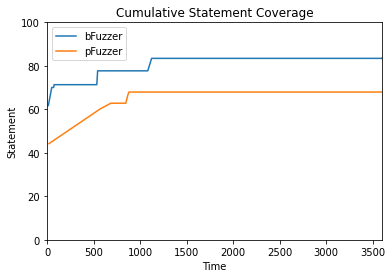

In [495]:
plt.plot(tinyc_time, tinyc_line, label='bFuzzer')
plt.plot(ptinyc_time, ptinyc_line, label='pFuzzer')
plt.ylabel('Statement')
plt.xlabel('Time')
plt.title('Cumulative Statement Coverage')
plt.axis([0, 3600, 0, 100]) 
plt.legend()
plt.show()

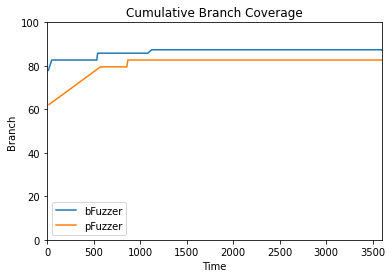

In [496]:
plt.plot(tinyc_time, tinyc_branch, label='bFuzzer')
plt.plot(ptinyc_time, ptinyc_branch, label='pFuzzer')
plt.ylabel('Branch')
plt.xlabel('Time')
plt.title('Cumulative Branch Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
plt.show()

In [497]:
ini_lst[-1][1]

('76.92', '76.92')

In [498]:
ini_time, ini_line, ini_branch = read_cov_data('build/results_ini.json')

3600  line: 76.15 branch:  74.36


In [499]:
pini_time, pini_line, pini_branch = read_cov_data('pfuzzer/results_ini.json')

3600  line: 67.69 branch:  69.23


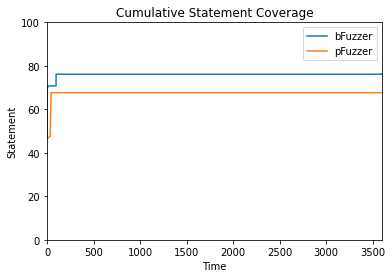

In [500]:
plt.plot(ini_time, ini_line, label='bFuzzer')
plt.plot(pini_time, pini_line, label='pFuzzer')
plt.ylabel('Statement')
plt.xlabel('Time')
plt.title('Cumulative Statement Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
plt.show()

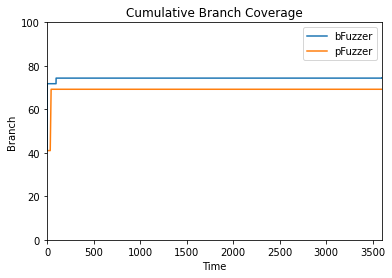

In [501]:
plt.plot(ini_time, ini_branch, label='bFuzzer')
plt.plot(pini_time, pini_branch, label='pFuzzer')
plt.ylabel('Branch')
plt.xlabel('Time')
plt.title('Cumulative Branch Coverage')
plt.axis([0, 3600, 0, 100]) 
plt.legend()
plt.show()

In [502]:
csv_lst[-1][1]

('66.97', '81.48')

In [503]:
csv_time, csv_line, csv_branch = read_cov_data('build/results_csv.json')

3600  line: 66.97 branch:  81.48


In [504]:
pcsv_time, pcsv_line, pcsv_branch = read_cov_data('pfuzzer/results_csvparser.json')

3600  line: 58.72 branch:  74.07


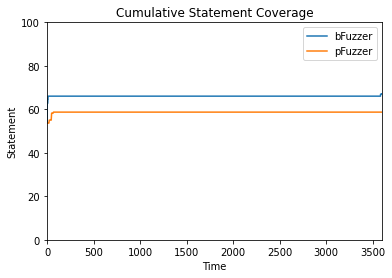

In [505]:
plt.plot(csv_time, csv_line, label='bFuzzer')
plt.plot(pcsv_time, pcsv_line, label='pFuzzer')
plt.ylabel('Statement')
plt.xlabel('Time')
plt.title('Cumulative Statement Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
plt.show()

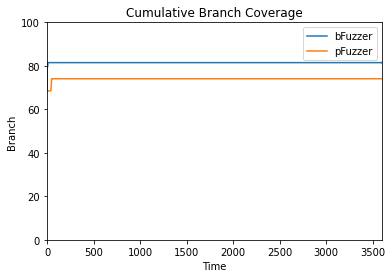

In [506]:
plt.plot(csv_time, csv_branch, label='bFuzzer')
plt.plot(pcsv_time, pcsv_branch, label='pFuzzer')
plt.ylabel('Branch')
plt.xlabel('Time')
plt.title('Cumulative Branch Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
plt.show()

In [507]:
mjs_lst[-1][1]

('28.55', '32.40')

In [508]:
mjs_time, mjs_line, mjs_branch = read_cov_data('build/results_mjs.json')

3600  line: 28.55 branch:  32.4


In [509]:
pmjs_time, pmjs_line, pmjs_branch = read_cov_data('pfuzzer/results_mjs.json')

3600  line: 20.42 branch:  18.67


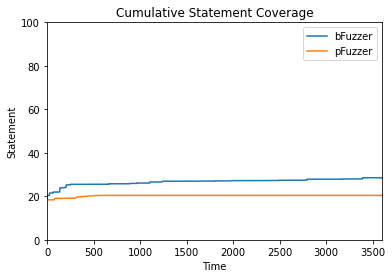

In [510]:
plt.plot(mjs_time, mjs_line, label='bFuzzer')
plt.plot(pmjs_time, pmjs_line, label='pFuzzer')
plt.ylabel('Statement')
plt.xlabel('Time')
plt.title('Cumulative Statement Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
plt.show()

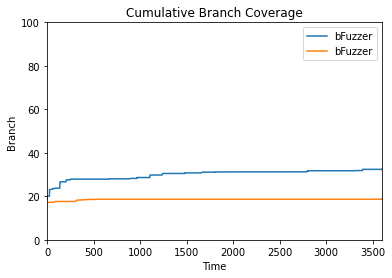

In [511]:
plt.plot(mjs_time, mjs_branch, label='bFuzzer')
plt.plot(pmjs_time, pmjs_branch, label='bFuzzer')
plt.ylabel('Branch')
plt.xlabel('Time')
plt.title('Cumulative Branch Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
plt.show()

In [512]:
cjson_lst[-1][1]

('10.62', '19.48')

In [513]:
cjson_time, cjson_line, cjson_branch = read_cov_data('build/results_cjson.json')

3600  line: 10.62 branch:  19.48


In [514]:
pcjson_time, pcjson_line, pcjson_branch = read_cov_data('pfuzzer/results_cjson.json')

3600  line: 6.72 branch:  13.36


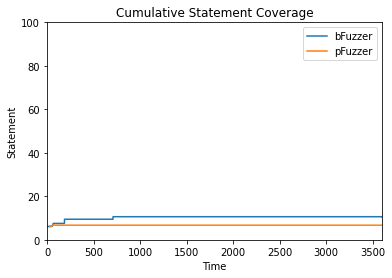

In [515]:
plt.plot(cjson_time, cjson_line, label='bFuzzer')
plt.plot(pcjson_time, pcjson_line, label='pFuzzer')
plt.ylabel('Statement')
plt.xlabel('Time')
plt.title('Cumulative Statement Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
plt.show()

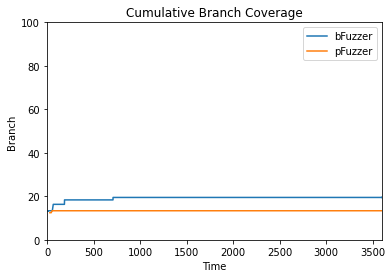

In [516]:
plt.plot(cjson_time, cjson_branch, label='bFuzzer')
plt.plot(pcjson_time, pcjson_branch, label='pFuzzer')
plt.ylabel('Branch')
plt.xlabel('Time')
plt.title('Cumulative Branch Coverage')
plt.axis([0, 3600, 0, 100]) 
plt.legend()
plt.show()